In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import torch.utils.data
import torch.optim as optim

from tensorboardX import SummaryWriter
import matplotlib.pyplot as plt

import os
from utils import tools
from sklearn import preprocessing
from torchviz import make_dot, make_dot_from_trace


# import FlowNetC
from networks import FlowNetC

from PIL import Image
import numpy as np
import pandas as pd

# import flowlib

from PIL import Image

import tqdm
import cv2
import csv
import time

In [206]:
cap = cv2.VideoCapture('data/caolin_foot_trial1-4.mp4')
name = 'caolin'

framerate = cap.get(5)
total_image = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

print(f'The oringinal framerate is {cap.get(5)} with frame resolution of: {cap.get(3), cap.get(4)}')
print(f'The total number of frame in this video is {total_image}')

The oringinal framerate is 25.0 with frame resolution of: (768.0, 576.0)
The total number of frame in this video is 17155


In [207]:
count = 1
while(cap.isOpened()):
    frameID = cap.get(1) # get the current frame number
    ret, frame = cap.read()
    
    if(ret != True):
        print(f'We\'ve gotten {int(frameID/5)+1} frames from this video.')
        break
    if (frameID % int(framerate/5) == 0):
        frame = frame[64:, 170:600 , :]
        filename = 'Train_1/'+ name + "_frame%04d.jpg" % count;count+=1
        cv2.imwrite(filename, frame)
cap.release()

We've gotten 3432 frames from this video.


## Building Dataset

In [13]:
image_files = dataset.image_files

In [2]:
class MyDataset:
    
    def __init__(self, num_train_img = 3400, base_dir = '/home/projectx/Documents/GitHub repos/VINET_modification/', sequence = 'Train_1/'):  # base_dir(image) and sequence(lstm) are directories
        self.base_dir = base_dir
        self.sequence = sequence
        self.base_path_img = self.base_dir + self.sequence
        
        self.image_files = os.listdir(self.base_path_img)
        self.image_files.sort()
        self.image_files = self.image_files[0:num_train_img]
        
        # normalization for lstm data
        self.train_scaler = preprocessing.StandardScaler()
        
        ## Omega.7 and load cells
        self.input_lstm = self.read_OMEGA7_LC()
        
        
        self.imu_seq_len = 20
    
    def read_OMEGA7_LC(self, path='data/result_1.csv'):
        # read csv data
        df = pd.read_csv(path,header = None)
        df = df[:874300]
        
        # take moving average of every 10 data points
        new_df = df.groupby(df.index//10).mean()
        array_input = np.array(new_df)
        
        # normalization
        array_input_scaled = self.train_scaler.fit_transform(array_input)
        
        input_lstm  = Variable(torch.from_numpy(array_input_scaled).type(torch.FloatTensor))
        input_lstm = input_lstm[:80000,:]
        
        
        
        # reshape to (num_dataset, sequence_length, feature_size)
        input_lstm = input_lstm.view(-1,20,11)
        
        return np.array(input_lstm)
    
    
    def get_input_lstm(self):
        return self.input_lstm
    
    def __len__(self):
        return len(self.image_files)
    
    def load_img_bat(self, idx, batch):
        batch_x = []
        batch_input_lstm = []
        for i in range(batch):
            x_data_np_1 = np.array(Image.open(self.base_path_img + self.image_files[idx + i]))
            x_data_np_2 = np.array(Image.open(self.base_path_img + self.image_files[idx+1 + i]))
            x_data_np_1 = x_data_np_1.reshape(3,512,430)
            x_data_np_2 = x_data_np_2.reshape(3,512,430)

#             ## 3 channels
#             x_data_np_1 = np.array([x_data_np_1, x_data_np_1, x_data_np_1])
#             x_data_np_2 = np.array([x_data_np_2, x_data_np_2, x_data_np_2])

            X = np.array([x_data_np_1, x_data_np_2])
            batch_x.append(X)
        
#           self.input_lstm of size: (num_dataset, sequence_length, feature_size)
            tmp = np.array(self.input_lstm[idx + i])
            batch_input_lstm.append(tmp)
            
        
        batch_x = np.array(batch_x)
        batch_input_lstm = np.array(batch_input_lstm)
        
        X = Variable(torch.from_numpy(batch_x).type(torch.FloatTensor).cuda())    
        X2 = Variable(torch.from_numpy(batch_input_lstm).type(torch.FloatTensor).cuda())    
        
        Y = X2[:,:,-3:]
        
     
        return X, X2 , Y.mean(1)

In [184]:
dataset = MyDataset()

/home/projectx/anaconda3/envs/fastai/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3325: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


/home/projectx/anaconda3/envs/fastai/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3248: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


(80000, 11)

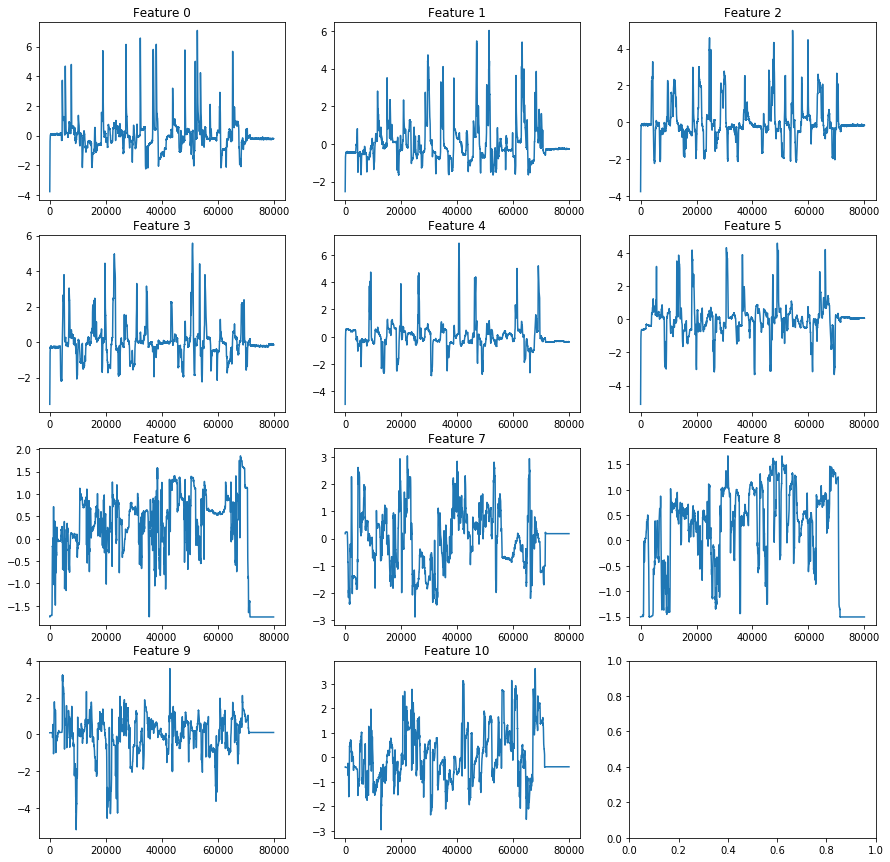

In [20]:
lstm_input = dataset.read_OMEGA7_LC()
lstm_input = lstm_input.reshape(4000*20, -1)
plot_feature_dim(lstm_input)
lstm_input.shape

In [3]:
def plot_feature_dim(lstm_input):
    fig, axs = plt.subplots(4,3,figsize=(15,15))

    for i in range(4):
        for j in range(3):
            if (i == 3 and j == 2):
                break

            x = np.arange(0,80000)
            axs[i,j].plot(x,lstm_input[:,i*3+j])
            axs[i,j].set_title(f'Feature {i*3+j}')

In [4]:
class Vinet(nn.Module):
    def __init__(self):
        super(Vinet, self).__init__()
        self.rnn = nn.LSTM(
            input_size=57464,#49152,#24576, 
            hidden_size=1024,#64, 
            num_layers=2,
            batch_first=True)
        self.rnn.cuda()
        
        self.rnnIMU = nn.LSTM(
            input_size=11, 
            hidden_size=6,
            num_layers=2,
            batch_first=True)
        self.rnnIMU.cuda()
        
        self.linear1 = nn.Linear(1024, 128)
        self.linear2 = nn.Linear(128, 3)
        #self.linear3 = nn.Linear(128, 6)
        self.linear1.cuda()
        self.linear2.cuda()
        #self.linear3.cuda()
        
        # load checkpoint state from NVIDIA training
        checkpoint_pytorch = 'None'
#         checkpoint_pytorch = 'FlowNet2-C_checkpoint.pth.tar'
        #checkpoint_pytorch = '/notebooks/data/model/FlowNet2-SD_checkpoint.pth.tar'
        if os.path.isfile(checkpoint_pytorch):
            print('pre_trained_weights found')
            checkpoint = torch.load(checkpoint_pytorch,\
                                map_location=lambda storage, loc: storage.cuda(0))
            pop_list = ["deconv5.0.weight", "deconv5.0.bias", "deconv4.0.weight", "deconv4.0.bias", "deconv3.0.weight", "deconv3.0.bias", "deconv2.0.weight", "deconv2.0.bias", "predict_flow6.weight", "predict_flow6.bias", "predict_flow5.weight", "predict_flow5.bias", "predict_flow4.weight", "predict_flow4.bias", "predict_flow3.weight", "predict_flow3.bias", "predict_flow2.weight", "predict_flow2.bias", "upsampled_flow6_to_5.weight", "upsampled_flow6_to_5.bias", "upsampled_flow5_to_4.weight", "upsampled_flow5_to_4.bias", "upsampled_flow4_to_3.weight", "upsampled_flow4_to_3.bias", "upsampled_flow3_to_2.weight", "upsampled_flow3_to_2.bias"]
            for name in pop_list:
                checkpoint['state_dict'].pop(name);
        
        self.flownet_c = FlowNetC.FlowNetC(batchNorm=True)
        print('....creating model....')
#         self.flownet_c.load_state_dict(checkpoint['state_dict'])
#         print('....loading weights....')
        self.flownet_c.cuda()
        
        

    def forward(self, image, imu):
        batch_size, timesteps, C, H, W = image.size()
        
        ## Input1: Feed image pairs to FlownetC
        c_in = image.view(batch_size, timesteps * C, H, W)
        c_out = self.flownet_c(c_in)
#         print('c_out', c_out.shape)
        
        ## Input2: Feed IMU records to LSTM
        imu_out, (imu_n, imu_c) = self.rnnIMU(imu)
        # to match Vision output shape
        imu_out = imu_out.view(batch_size,1,-1)   # (batch_size, 1, total_hidden_size)
        
#         print('imu_out', imu_out.shape)
        
        
        ## Combine the output of input1 and 2 and feed it to LSTM
        #r_in = c_out.view(batch_size, timesteps, -1)
        r_in = c_out.view(batch_size, 1, -1)
#         print('r_in', r_in.shape)
        

        cat_out = torch.cat((r_in, imu_out), 2)#1 1 49158
#         print(cat_out.shape)
        
        
        r_out, (h_n, h_c) = self.rnn(cat_out)  # (1, 1, 1024)
#         print('r_out', r_out.shape)
        l_out1 = self.linear1(r_out[:,-1,:])
        l_out2 = self.linear2(l_out1)
        
#         print('r_ol_out2ut', l_out2.shape)
        #l_out3 = self.linear3(l_out2)

        return l_out2

### Test

In [5]:
model = Vinet()

....creating model....


In [35]:
dataset = MyDataset()
X, X2 , Y = dataset.load_img_bat(0,1)
X.size(), X2.size() , Y.size() 

/home/projectx/anaconda3/envs/fastai/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3325: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


(torch.Size([1, 2, 3, 512, 430]), torch.Size([1, 20, 11]), torch.Size([1, 3]))

In [36]:
output = model(X,X2)

/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


In [15]:
(output.size(), Y.size())

(torch.Size([1, 3]), torch.Size([1, 3]))

In [16]:
criterion = nn.MSELoss()

loss = criterion(output, Y)

## Visulization of network

In [197]:
image = X
imu   = X2
y = model(image, imu)
dot = make_dot(y, params = dict(list(model.named_parameters()) + [('x',X), ('x2',X2)]))

c_out torch.Size([1, 1024, 8, 7])
imu_out torch.Size([1, 1, 120])
r_in torch.Size([1, 1, 57344])
torch.Size([1, 1, 57464])
r_out torch.Size([1, 1, 1024])
r_ol_out2ut torch.Size([1, 3])


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


In [203]:
dot.save(filename='My_new_Network')

'My_new_Network'

In [204]:
dot.render()

'My_new_Network.pdf'

## Design the training loop

In [5]:
def train():
    # hyper-parameters
    epoch = 2
    batch = 1
    lr = 1e-5
    
    # creat model and dataset
    model = Vinet()
    mydataset = MyDataset()
    
    
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    
    # TensorBoard
    writer = SummaryWriter()
 
    model.train()
    
    mydataset = MyDataset()
    
    criterion = nn.MSELoss()
    
    start = 0
    end = len(mydataset) - batch
    batch_num = (end - start)
    startT = time.time()
    
    with tools.TimerBlock("Start training") as block :
        for k in range(epoch):
            for i in range(start, end):
                data, data_lstm, target = mydataset.load_img_bat(i, batch)
                data, data_lstm, target = data.cuda(), data_lstm.cuda(), target.cuda()
                
                optimizer.zero_grad()
                
                # forward pass
                output = model(data, data_lstm)
                
                # compute loss
                loss = criterion(output, target)
                
                # backward pass
                loss.backward()
                torch.nn.utils.clip_grad_value_(model.parameters(), 1.0)
                optimizer.step()
                
                avgTime = block.avg()
                remainingTime = int((batch_num*epoch -  (i + batch_num*k)) * avgTime)
                rTime_str = "{:02d}:{:02d}:{:02d}".format(int(remainingTime/60//60), 
                                                          int(remainingTime//60%60), 
                                                          int(remainingTime%60))
                block.log(f'Train Epoch: {k}\t[{i}/{batch_num} ({(100.*(i + batch_num*k)):.0f}%)]\tLoss: {loss.data:.6f}, TimeAvg: {avgTime:.4f}, Remaining: {rTime_str}')
                          
                writer.add_scalar('loss', loss.data, k*batch_num + i)
                

                
                
                
            check_str = 'checkpoint_{}.pt'.format(k)
            if (k+1)%5 == 0:
                torch.save(model.state_dict(), check_str)
    
    torch.save(model.state_dict(), 'test_network_trial_1.pt')
    writer.export_scalars_to_json("./summary_writer.json")
    writer.close()

In [6]:
train()

....creating model....


/home/projectx/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:1: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  """Entry point for launching an IPython kernel.
/home/projectx/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:1: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  """Entry point for launching an IPython kernel.
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Start training
  [0.858s] Train Epoch: 0	[0/3399 (0%)]	Loss: 0.874135, TimeAvg: 0.1912, Remaining: 00:21:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.693s] Train Epoch: 0	[1/3399 (100%)]	Loss: 0.863921, TimeAvg: 1.0148, Remaining: 01:54:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.531s] Train Epoch: 0	[2/3399 (200%)]	Loss: 0.853374, TimeAvg: 0.9204, Remaining: 01:44:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.366s] Train Epoch: 0	[3/3399 (300%)]	Loss: 0.857693, TimeAvg: 0.8936, Remaining: 01:41:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.203s] Train Epoch: 0	[4/3399 (400%)]	Loss: 0.852014, TimeAvg: 0.8797, Remaining: 01:39:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.040s] Train Epoch: 0	[5/3399 (500%)]	Loss: 0.844865, TimeAvg: 0.8723, Remaining: 01:38:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.879s] Train Epoch: 0	[6/3399 (600%)]	Loss: 0.864997, TimeAvg: 0.8661, Remaining: 01:38:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.715s] Train Epoch: 0	[7/3399 (700%)]	Loss: 0.862669, TimeAvg: 0.8627, Remaining: 01:37:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.550s] Train Epoch: 0	[8/3399 (800%)]	Loss: 0.845606, TimeAvg: 0.8582, Remaining: 01:37:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.387s] Train Epoch: 0	[9/3399 (900%)]	Loss: 0.853009, TimeAvg: 0.8561, Remaining: 01:36:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.222s] Train Epoch: 0	[10/3399 (1000%)]	Loss: 0.857180, TimeAvg: 0.8536, Remaining: 01:36:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.058s] Train Epoch: 0	[11/3399 (1100%)]	Loss: 0.859272, TimeAvg: 0.8520, Remaining: 01:36:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.915s] Train Epoch: 0	[12/3399 (1200%)]	Loss: 0.861483, TimeAvg: 0.8505, Remaining: 01:36:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.764s] Train Epoch: 0	[13/3399 (1300%)]	Loss: 0.855025, TimeAvg: 0.8519, Remaining: 01:36:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.600s] Train Epoch: 0	[14/3399 (1400%)]	Loss: 0.856322, TimeAvg: 0.8508, Remaining: 01:36:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.442s] Train Epoch: 0	[15/3399 (1500%)]	Loss: 0.855968, TimeAvg: 0.8509, Remaining: 01:36:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.277s] Train Epoch: 0	[16/3399 (1600%)]	Loss: 0.860554, TimeAvg: 0.8494, Remaining: 01:36:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.114s] Train Epoch: 0	[17/3399 (1700%)]	Loss: 0.840634, TimeAvg: 0.8488, Remaining: 01:35:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.953s] Train Epoch: 0	[18/3399 (1800%)]	Loss: 0.837478, TimeAvg: 0.8483, Remaining: 01:35:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.790s] Train Epoch: 0	[19/3399 (1900%)]	Loss: 0.843240, TimeAvg: 0.8473, Remaining: 01:35:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.623s] Train Epoch: 0	[20/3399 (2000%)]	Loss: 0.854909, TimeAvg: 0.8466, Remaining: 01:35:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.455s] Train Epoch: 0	[21/3399 (2100%)]	Loss: 0.848328, TimeAvg: 0.8459, Remaining: 01:35:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.294s] Train Epoch: 0	[22/3399 (2200%)]	Loss: 0.835780, TimeAvg: 0.8452, Remaining: 01:35:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.150s] Train Epoch: 0	[23/3399 (2300%)]	Loss: 0.826766, TimeAvg: 0.8467, Remaining: 01:35:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.983s] Train Epoch: 0	[24/3399 (2400%)]	Loss: 0.850765, TimeAvg: 0.8457, Remaining: 01:35:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.822s] Train Epoch: 0	[25/3399 (2500%)]	Loss: 0.859388, TimeAvg: 0.8450, Remaining: 01:35:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.658s] Train Epoch: 0	[26/3399 (2600%)]	Loss: 0.843683, TimeAvg: 0.8447, Remaining: 01:35:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.494s] Train Epoch: 0	[27/3399 (2700%)]	Loss: 0.846025, TimeAvg: 0.8448, Remaining: 01:35:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.332s] Train Epoch: 0	[28/3399 (2800%)]	Loss: 0.846765, TimeAvg: 0.8447, Remaining: 01:35:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.165s] Train Epoch: 0	[29/3399 (2900%)]	Loss: 0.856447, TimeAvg: 0.8442, Remaining: 01:35:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.003s] Train Epoch: 0	[30/3399 (3000%)]	Loss: 0.844060, TimeAvg: 0.8441, Remaining: 01:35:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.837s] Train Epoch: 0	[31/3399 (3100%)]	Loss: 0.840870, TimeAvg: 0.8437, Remaining: 01:35:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.671s] Train Epoch: 0	[32/3399 (3200%)]	Loss: 0.861609, TimeAvg: 0.8433, Remaining: 01:35:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.504s] Train Epoch: 0	[33/3399 (3300%)]	Loss: 0.839510, TimeAvg: 0.8430, Remaining: 01:35:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.337s] Train Epoch: 0	[34/3399 (3400%)]	Loss: 0.852287, TimeAvg: 0.8424, Remaining: 01:34:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.171s] Train Epoch: 0	[35/3399 (3500%)]	Loss: 0.848808, TimeAvg: 0.8422, Remaining: 01:34:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.007s] Train Epoch: 0	[36/3399 (3600%)]	Loss: 0.832596, TimeAvg: 0.8421, Remaining: 01:34:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.841s] Train Epoch: 0	[37/3399 (3700%)]	Loss: 0.859853, TimeAvg: 0.8417, Remaining: 01:34:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.675s] Train Epoch: 0	[38/3399 (3800%)]	Loss: 0.856850, TimeAvg: 0.8415, Remaining: 01:34:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.509s] Train Epoch: 0	[39/3399 (3900%)]	Loss: 0.847034, TimeAvg: 0.8413, Remaining: 01:34:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.346s] Train Epoch: 0	[40/3399 (4000%)]	Loss: 0.863736, TimeAvg: 0.8414, Remaining: 01:34:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.180s] Train Epoch: 0	[41/3399 (4100%)]	Loss: 0.838966, TimeAvg: 0.8410, Remaining: 01:34:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.014s] Train Epoch: 0	[42/3399 (4200%)]	Loss: 0.833747, TimeAvg: 0.8409, Remaining: 01:34:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.848s] Train Epoch: 0	[43/3399 (4300%)]	Loss: 0.821861, TimeAvg: 0.8407, Remaining: 01:34:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.682s] Train Epoch: 0	[44/3399 (4400%)]	Loss: 0.840697, TimeAvg: 0.8406, Remaining: 01:34:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.516s] Train Epoch: 0	[45/3399 (4500%)]	Loss: 0.846933, TimeAvg: 0.8405, Remaining: 01:34:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.351s] Train Epoch: 0	[46/3399 (4600%)]	Loss: 0.848804, TimeAvg: 0.8404, Remaining: 01:34:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.185s] Train Epoch: 0	[47/3399 (4700%)]	Loss: 0.820618, TimeAvg: 0.8404, Remaining: 01:34:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.019s] Train Epoch: 0	[48/3399 (4800%)]	Loss: 0.771645, TimeAvg: 0.8402, Remaining: 01:34:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.854s] Train Epoch: 0	[49/3399 (4900%)]	Loss: 0.736203, TimeAvg: 0.8402, Remaining: 01:34:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.688s] Train Epoch: 0	[50/3399 (5000%)]	Loss: 0.760601, TimeAvg: 0.8401, Remaining: 01:34:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.535s] Train Epoch: 0	[51/3399 (5100%)]	Loss: 0.754661, TimeAvg: 0.8401, Remaining: 01:34:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.369s] Train Epoch: 0	[52/3399 (5200%)]	Loss: 0.706435, TimeAvg: 0.8400, Remaining: 01:34:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.203s] Train Epoch: 0	[53/3399 (5300%)]	Loss: 0.658515, TimeAvg: 0.8400, Remaining: 01:34:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.038s] Train Epoch: 0	[54/3399 (5400%)]	Loss: 0.577495, TimeAvg: 0.8399, Remaining: 01:34:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.872s] Train Epoch: 0	[55/3399 (5500%)]	Loss: 0.382753, TimeAvg: 0.8397, Remaining: 01:34:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.707s] Train Epoch: 0	[56/3399 (5600%)]	Loss: 0.194744, TimeAvg: 0.8397, Remaining: 01:34:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.541s] Train Epoch: 0	[57/3399 (5700%)]	Loss: 0.167775, TimeAvg: 0.8396, Remaining: 01:34:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.376s] Train Epoch: 0	[58/3399 (5800%)]	Loss: 0.194578, TimeAvg: 0.8395, Remaining: 01:34:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.210s] Train Epoch: 0	[59/3399 (5900%)]	Loss: 0.179006, TimeAvg: 0.8394, Remaining: 01:34:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.047s] Train Epoch: 0	[60/3399 (6000%)]	Loss: 0.176909, TimeAvg: 0.8393, Remaining: 01:34:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.881s] Train Epoch: 0	[61/3399 (6100%)]	Loss: 0.261088, TimeAvg: 0.8392, Remaining: 01:34:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.716s] Train Epoch: 0	[62/3399 (6200%)]	Loss: 0.475850, TimeAvg: 0.8390, Remaining: 01:34:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.550s] Train Epoch: 0	[63/3399 (6300%)]	Loss: 0.813948, TimeAvg: 0.8390, Remaining: 01:34:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.385s] Train Epoch: 0	[64/3399 (6400%)]	Loss: 0.975825, TimeAvg: 0.8389, Remaining: 01:34:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.219s] Train Epoch: 0	[65/3399 (6500%)]	Loss: 1.053954, TimeAvg: 0.8388, Remaining: 01:34:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.053s] Train Epoch: 0	[66/3399 (6600%)]	Loss: 1.203012, TimeAvg: 0.8387, Remaining: 01:34:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.887s] Train Epoch: 0	[67/3399 (6700%)]	Loss: 1.262651, TimeAvg: 0.8387, Remaining: 01:34:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.722s] Train Epoch: 0	[68/3399 (6800%)]	Loss: 1.248293, TimeAvg: 0.8387, Remaining: 01:34:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.555s] Train Epoch: 0	[69/3399 (6900%)]	Loss: 1.221562, TimeAvg: 0.8386, Remaining: 01:34:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.388s] Train Epoch: 0	[70/3399 (7000%)]	Loss: 1.009515, TimeAvg: 0.8384, Remaining: 01:34:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.004m] Train Epoch: 0	[71/3399 (7100%)]	Loss: 0.709653, TimeAvg: 0.8385, Remaining: 01:34:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.018m] Train Epoch: 0	[72/3399 (7200%)]	Loss: 0.358270, TimeAvg: 0.8388, Remaining: 01:34:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.032m] Train Epoch: 0	[73/3399 (7300%)]	Loss: 0.097173, TimeAvg: 0.8385, Remaining: 01:33:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.046m] Train Epoch: 0	[74/3399 (7400%)]	Loss: 0.038978, TimeAvg: 0.8384, Remaining: 01:33:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.059m] Train Epoch: 0	[75/3399 (7500%)]	Loss: 0.080519, TimeAvg: 0.8384, Remaining: 01:33:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.073m] Train Epoch: 0	[76/3399 (7600%)]	Loss: 0.289431, TimeAvg: 0.8383, Remaining: 01:33:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.087m] Train Epoch: 0	[77/3399 (7700%)]	Loss: 0.713276, TimeAvg: 0.8383, Remaining: 01:33:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.101m] Train Epoch: 0	[78/3399 (7800%)]	Loss: 0.961887, TimeAvg: 0.8382, Remaining: 01:33:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.115m] Train Epoch: 0	[79/3399 (7900%)]	Loss: 0.975437, TimeAvg: 0.8382, Remaining: 01:33:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.129m] Train Epoch: 0	[80/3399 (8000%)]	Loss: 1.055809, TimeAvg: 0.8382, Remaining: 01:33:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.143m] Train Epoch: 0	[81/3399 (8100%)]	Loss: 1.150510, TimeAvg: 0.8381, Remaining: 01:33:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.157m] Train Epoch: 0	[82/3399 (8200%)]	Loss: 1.174782, TimeAvg: 0.8380, Remaining: 01:33:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.171m] Train Epoch: 0	[83/3399 (8300%)]	Loss: 1.058021, TimeAvg: 0.8380, Remaining: 01:33:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.185m] Train Epoch: 0	[84/3399 (8400%)]	Loss: 0.932099, TimeAvg: 0.8379, Remaining: 01:33:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.199m] Train Epoch: 0	[85/3399 (8500%)]	Loss: 0.825547, TimeAvg: 0.8379, Remaining: 01:33:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.212m] Train Epoch: 0	[86/3399 (8600%)]	Loss: 0.787454, TimeAvg: 0.8378, Remaining: 01:33:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.226m] Train Epoch: 0	[87/3399 (8700%)]	Loss: 0.788723, TimeAvg: 0.8377, Remaining: 01:33:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.240m] Train Epoch: 0	[88/3399 (8800%)]	Loss: 0.801733, TimeAvg: 0.8377, Remaining: 01:33:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.254m] Train Epoch: 0	[89/3399 (8900%)]	Loss: 0.776846, TimeAvg: 0.8377, Remaining: 01:33:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.268m] Train Epoch: 0	[90/3399 (9000%)]	Loss: 0.763807, TimeAvg: 0.8377, Remaining: 01:33:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.282m] Train Epoch: 0	[91/3399 (9100%)]	Loss: 0.762240, TimeAvg: 0.8376, Remaining: 01:33:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.296m] Train Epoch: 0	[92/3399 (9200%)]	Loss: 0.785866, TimeAvg: 0.8375, Remaining: 01:33:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.310m] Train Epoch: 0	[93/3399 (9300%)]	Loss: 0.773835, TimeAvg: 0.8376, Remaining: 01:33:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.324m] Train Epoch: 0	[94/3399 (9400%)]	Loss: 0.767806, TimeAvg: 0.8375, Remaining: 01:33:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.338m] Train Epoch: 0	[95/3399 (9500%)]	Loss: 0.745343, TimeAvg: 0.8375, Remaining: 01:33:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.351m] Train Epoch: 0	[96/3399 (9600%)]	Loss: 0.722775, TimeAvg: 0.8374, Remaining: 01:33:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.365m] Train Epoch: 0	[97/3399 (9700%)]	Loss: 0.758729, TimeAvg: 0.8375, Remaining: 01:33:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.379m] Train Epoch: 0	[98/3399 (9800%)]	Loss: 0.775478, TimeAvg: 0.8374, Remaining: 01:33:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.393m] Train Epoch: 0	[99/3399 (9900%)]	Loss: 0.762517, TimeAvg: 0.8374, Remaining: 01:33:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.407m] Train Epoch: 0	[100/3399 (10000%)]	Loss: 0.767717, TimeAvg: 0.8374, Remaining: 01:33:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.421m] Train Epoch: 0	[101/3399 (10100%)]	Loss: 0.769070, TimeAvg: 0.8375, Remaining: 01:33:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.435m] Train Epoch: 0	[102/3399 (10200%)]	Loss: 0.760542, TimeAvg: 0.8373, Remaining: 01:33:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.449m] Train Epoch: 0	[103/3399 (10300%)]	Loss: 0.725257, TimeAvg: 0.8373, Remaining: 01:33:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.463m] Train Epoch: 0	[104/3399 (10400%)]	Loss: 0.663964, TimeAvg: 0.8372, Remaining: 01:33:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.477m] Train Epoch: 0	[105/3399 (10500%)]	Loss: 0.501122, TimeAvg: 0.8372, Remaining: 01:33:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.490m] Train Epoch: 0	[106/3399 (10600%)]	Loss: 0.214493, TimeAvg: 0.8372, Remaining: 01:33:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.504m] Train Epoch: 0	[107/3399 (10700%)]	Loss: 0.202745, TimeAvg: 0.8372, Remaining: 01:33:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.518m] Train Epoch: 0	[108/3399 (10800%)]	Loss: 0.334515, TimeAvg: 0.8371, Remaining: 01:33:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.532m] Train Epoch: 0	[109/3399 (10900%)]	Loss: 0.275687, TimeAvg: 0.8371, Remaining: 01:33:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.546m] Train Epoch: 0	[110/3399 (11000%)]	Loss: 0.193385, TimeAvg: 0.8371, Remaining: 01:33:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.560m] Train Epoch: 0	[111/3399 (11100%)]	Loss: 0.179458, TimeAvg: 0.8370, Remaining: 01:33:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.574m] Train Epoch: 0	[112/3399 (11200%)]	Loss: 0.176329, TimeAvg: 0.8369, Remaining: 01:33:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.588m] Train Epoch: 0	[113/3399 (11300%)]	Loss: 0.125582, TimeAvg: 0.8370, Remaining: 01:33:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.602m] Train Epoch: 0	[114/3399 (11400%)]	Loss: 0.070048, TimeAvg: 0.8369, Remaining: 01:33:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.616m] Train Epoch: 0	[115/3399 (11500%)]	Loss: 0.064548, TimeAvg: 0.8369, Remaining: 01:33:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.629m] Train Epoch: 0	[116/3399 (11600%)]	Loss: 0.065804, TimeAvg: 0.8369, Remaining: 01:33:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.643m] Train Epoch: 0	[117/3399 (11700%)]	Loss: 0.059738, TimeAvg: 0.8369, Remaining: 01:33:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.657m] Train Epoch: 0	[118/3399 (11800%)]	Loss: 0.054534, TimeAvg: 0.8369, Remaining: 01:33:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.671m] Train Epoch: 0	[119/3399 (11900%)]	Loss: 0.053719, TimeAvg: 0.8368, Remaining: 01:33:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.685m] Train Epoch: 0	[120/3399 (12000%)]	Loss: 0.053128, TimeAvg: 0.8369, Remaining: 01:33:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.699m] Train Epoch: 0	[121/3399 (12100%)]	Loss: 0.057724, TimeAvg: 0.8368, Remaining: 01:33:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.713m] Train Epoch: 0	[122/3399 (12200%)]	Loss: 0.055597, TimeAvg: 0.8368, Remaining: 01:33:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.727m] Train Epoch: 0	[123/3399 (12300%)]	Loss: 0.054664, TimeAvg: 0.8368, Remaining: 01:33:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.741m] Train Epoch: 0	[124/3399 (12400%)]	Loss: 0.059081, TimeAvg: 0.8368, Remaining: 01:33:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.755m] Train Epoch: 0	[125/3399 (12500%)]	Loss: 0.071543, TimeAvg: 0.8368, Remaining: 01:33:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.769m] Train Epoch: 0	[126/3399 (12600%)]	Loss: 0.088807, TimeAvg: 0.8368, Remaining: 01:33:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.783m] Train Epoch: 0	[127/3399 (12700%)]	Loss: 0.104078, TimeAvg: 0.8367, Remaining: 01:33:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.796m] Train Epoch: 0	[128/3399 (12800%)]	Loss: 0.104018, TimeAvg: 0.8367, Remaining: 01:33:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.810m] Train Epoch: 0	[129/3399 (12900%)]	Loss: 0.104041, TimeAvg: 0.8367, Remaining: 01:32:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.824m] Train Epoch: 0	[130/3399 (13000%)]	Loss: 0.089373, TimeAvg: 0.8368, Remaining: 01:32:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.838m] Train Epoch: 0	[131/3399 (13100%)]	Loss: 0.081747, TimeAvg: 0.8367, Remaining: 01:32:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.852m] Train Epoch: 0	[132/3399 (13200%)]	Loss: 0.083211, TimeAvg: 0.8367, Remaining: 01:32:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.866m] Train Epoch: 0	[133/3399 (13300%)]	Loss: 0.056758, TimeAvg: 0.8366, Remaining: 01:32:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.880m] Train Epoch: 0	[134/3399 (13400%)]	Loss: 0.026222, TimeAvg: 0.8366, Remaining: 01:32:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.894m] Train Epoch: 0	[135/3399 (13500%)]	Loss: 0.014498, TimeAvg: 0.8366, Remaining: 01:32:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.908m] Train Epoch: 0	[136/3399 (13600%)]	Loss: 0.011397, TimeAvg: 0.8365, Remaining: 01:32:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.922m] Train Epoch: 0	[137/3399 (13700%)]	Loss: 0.009080, TimeAvg: 0.8366, Remaining: 01:32:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.936m] Train Epoch: 0	[138/3399 (13800%)]	Loss: 0.007320, TimeAvg: 0.8366, Remaining: 01:32:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.949m] Train Epoch: 0	[139/3399 (13900%)]	Loss: 0.004520, TimeAvg: 0.8365, Remaining: 01:32:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.963m] Train Epoch: 0	[140/3399 (14000%)]	Loss: 0.010373, TimeAvg: 0.8365, Remaining: 01:32:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.977m] Train Epoch: 0	[141/3399 (14100%)]	Loss: 0.026569, TimeAvg: 0.8365, Remaining: 01:32:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.991m] Train Epoch: 0	[142/3399 (14200%)]	Loss: 0.049328, TimeAvg: 0.8365, Remaining: 01:32:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.005m] Train Epoch: 0	[143/3399 (14300%)]	Loss: 0.063749, TimeAvg: 0.8365, Remaining: 01:32:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.019m] Train Epoch: 0	[144/3399 (14400%)]	Loss: 0.077485, TimeAvg: 0.8365, Remaining: 01:32:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.033m] Train Epoch: 0	[145/3399 (14500%)]	Loss: 0.120853, TimeAvg: 0.8364, Remaining: 01:32:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.047m] Train Epoch: 0	[146/3399 (14600%)]	Loss: 0.202785, TimeAvg: 0.8364, Remaining: 01:32:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.061m] Train Epoch: 0	[147/3399 (14700%)]	Loss: 0.369729, TimeAvg: 0.8364, Remaining: 01:32:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.075m] Train Epoch: 0	[148/3399 (14800%)]	Loss: 0.686409, TimeAvg: 0.8364, Remaining: 01:32:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.089m] Train Epoch: 0	[149/3399 (14900%)]	Loss: 0.859232, TimeAvg: 0.8364, Remaining: 01:32:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.103m] Train Epoch: 0	[150/3399 (15000%)]	Loss: 0.855580, TimeAvg: 0.8363, Remaining: 01:32:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.116m] Train Epoch: 0	[151/3399 (15100%)]	Loss: 0.838493, TimeAvg: 0.8364, Remaining: 01:32:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.130m] Train Epoch: 0	[152/3399 (15200%)]	Loss: 0.837605, TimeAvg: 0.8364, Remaining: 01:32:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.144m] Train Epoch: 0	[153/3399 (15300%)]	Loss: 0.846284, TimeAvg: 0.8364, Remaining: 01:32:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.158m] Train Epoch: 0	[154/3399 (15400%)]	Loss: 0.841070, TimeAvg: 0.8364, Remaining: 01:32:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.172m] Train Epoch: 0	[155/3399 (15500%)]	Loss: 0.843337, TimeAvg: 0.8363, Remaining: 01:32:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.186m] Train Epoch: 0	[156/3399 (15600%)]	Loss: 0.843980, TimeAvg: 0.8364, Remaining: 01:32:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.200m] Train Epoch: 0	[157/3399 (15700%)]	Loss: 0.831976, TimeAvg: 0.8363, Remaining: 01:32:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.214m] Train Epoch: 0	[158/3399 (15800%)]	Loss: 0.829704, TimeAvg: 0.8363, Remaining: 01:32:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.228m] Train Epoch: 0	[159/3399 (15900%)]	Loss: 0.831316, TimeAvg: 0.8363, Remaining: 01:32:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.242m] Train Epoch: 0	[160/3399 (16000%)]	Loss: 0.827905, TimeAvg: 0.8364, Remaining: 01:32:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.256m] Train Epoch: 0	[161/3399 (16100%)]	Loss: 0.831934, TimeAvg: 0.8363, Remaining: 01:32:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.270m] Train Epoch: 0	[162/3399 (16200%)]	Loss: 0.843598, TimeAvg: 0.8363, Remaining: 01:32:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.284m] Train Epoch: 0	[163/3399 (16300%)]	Loss: 0.839697, TimeAvg: 0.8363, Remaining: 01:32:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.297m] Train Epoch: 0	[164/3399 (16400%)]	Loss: 0.839809, TimeAvg: 0.8363, Remaining: 01:32:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.311m] Train Epoch: 0	[165/3399 (16500%)]	Loss: 0.816709, TimeAvg: 0.8363, Remaining: 01:32:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.325m] Train Epoch: 0	[166/3399 (16600%)]	Loss: 0.824666, TimeAvg: 0.8363, Remaining: 01:32:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.339m] Train Epoch: 0	[167/3399 (16700%)]	Loss: 0.818041, TimeAvg: 0.8363, Remaining: 01:32:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.353m] Train Epoch: 0	[168/3399 (16800%)]	Loss: 0.819907, TimeAvg: 0.8363, Remaining: 01:32:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.367m] Train Epoch: 0	[169/3399 (16900%)]	Loss: 0.817578, TimeAvg: 0.8363, Remaining: 01:32:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.381m] Train Epoch: 0	[170/3399 (17000%)]	Loss: 0.815210, TimeAvg: 0.8363, Remaining: 01:32:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.395m] Train Epoch: 0	[171/3399 (17100%)]	Loss: 0.806223, TimeAvg: 0.8363, Remaining: 01:32:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.409m] Train Epoch: 0	[172/3399 (17200%)]	Loss: 0.806623, TimeAvg: 0.8363, Remaining: 01:32:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.423m] Train Epoch: 0	[173/3399 (17300%)]	Loss: 0.804162, TimeAvg: 0.8362, Remaining: 01:32:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.437m] Train Epoch: 0	[174/3399 (17400%)]	Loss: 0.807883, TimeAvg: 0.8362, Remaining: 01:32:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.450m] Train Epoch: 0	[175/3399 (17500%)]	Loss: 0.798678, TimeAvg: 0.8362, Remaining: 01:32:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.464m] Train Epoch: 0	[176/3399 (17600%)]	Loss: 0.797757, TimeAvg: 0.8362, Remaining: 01:32:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.478m] Train Epoch: 0	[177/3399 (17700%)]	Loss: 0.808996, TimeAvg: 0.8362, Remaining: 01:32:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.492m] Train Epoch: 0	[178/3399 (17800%)]	Loss: 0.825285, TimeAvg: 0.8362, Remaining: 01:32:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.506m] Train Epoch: 0	[179/3399 (17900%)]	Loss: 0.810891, TimeAvg: 0.8361, Remaining: 01:32:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.520m] Train Epoch: 0	[180/3399 (18000%)]	Loss: 0.843579, TimeAvg: 0.8361, Remaining: 01:32:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.534m] Train Epoch: 0	[181/3399 (18100%)]	Loss: 0.828942, TimeAvg: 0.8361, Remaining: 01:32:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.548m] Train Epoch: 0	[182/3399 (18200%)]	Loss: 0.830553, TimeAvg: 0.8361, Remaining: 01:32:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.562m] Train Epoch: 0	[183/3399 (18300%)]	Loss: 0.835790, TimeAvg: 0.8361, Remaining: 01:32:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.576m] Train Epoch: 0	[184/3399 (18400%)]	Loss: 0.831321, TimeAvg: 0.8362, Remaining: 01:32:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.590m] Train Epoch: 0	[185/3399 (18500%)]	Loss: 0.819076, TimeAvg: 0.8361, Remaining: 01:32:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.603m] Train Epoch: 0	[186/3399 (18600%)]	Loss: 0.835589, TimeAvg: 0.8361, Remaining: 01:32:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.617m] Train Epoch: 0	[187/3399 (18700%)]	Loss: 0.819073, TimeAvg: 0.8361, Remaining: 01:32:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.631m] Train Epoch: 0	[188/3399 (18800%)]	Loss: 0.816396, TimeAvg: 0.8361, Remaining: 01:32:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.645m] Train Epoch: 0	[189/3399 (18900%)]	Loss: 0.816056, TimeAvg: 0.8361, Remaining: 01:32:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.659m] Train Epoch: 0	[190/3399 (19000%)]	Loss: 0.832074, TimeAvg: 0.8361, Remaining: 01:32:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.673m] Train Epoch: 0	[191/3399 (19100%)]	Loss: 0.820616, TimeAvg: 0.8361, Remaining: 01:32:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.687m] Train Epoch: 0	[192/3399 (19200%)]	Loss: 0.836789, TimeAvg: 0.8361, Remaining: 01:32:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.701m] Train Epoch: 0	[193/3399 (19300%)]	Loss: 0.820221, TimeAvg: 0.8361, Remaining: 01:32:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.715m] Train Epoch: 0	[194/3399 (19400%)]	Loss: 0.835526, TimeAvg: 0.8362, Remaining: 01:32:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.729m] Train Epoch: 0	[195/3399 (19500%)]	Loss: 0.840513, TimeAvg: 0.8361, Remaining: 01:32:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.743m] Train Epoch: 0	[196/3399 (19600%)]	Loss: 0.839668, TimeAvg: 0.8361, Remaining: 01:31:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.756m] Train Epoch: 0	[197/3399 (19700%)]	Loss: 0.829906, TimeAvg: 0.8360, Remaining: 01:31:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.770m] Train Epoch: 0	[198/3399 (19800%)]	Loss: 0.820928, TimeAvg: 0.8360, Remaining: 01:31:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.784m] Train Epoch: 0	[199/3399 (19900%)]	Loss: 0.826182, TimeAvg: 0.8360, Remaining: 01:31:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.798m] Train Epoch: 0	[200/3399 (20000%)]	Loss: 0.823013, TimeAvg: 0.8361, Remaining: 01:31:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.812m] Train Epoch: 0	[201/3399 (20100%)]	Loss: 0.823593, TimeAvg: 0.8360, Remaining: 01:31:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.826m] Train Epoch: 0	[202/3399 (20200%)]	Loss: 0.820978, TimeAvg: 0.8360, Remaining: 01:31:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.840m] Train Epoch: 0	[203/3399 (20300%)]	Loss: 0.815023, TimeAvg: 0.8360, Remaining: 01:31:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.854m] Train Epoch: 0	[204/3399 (20400%)]	Loss: 0.819512, TimeAvg: 0.8360, Remaining: 01:31:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.868m] Train Epoch: 0	[205/3399 (20500%)]	Loss: 0.820741, TimeAvg: 0.8360, Remaining: 01:31:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.882m] Train Epoch: 0	[206/3399 (20600%)]	Loss: 0.821932, TimeAvg: 0.8360, Remaining: 01:31:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.896m] Train Epoch: 0	[207/3399 (20700%)]	Loss: 0.810649, TimeAvg: 0.8359, Remaining: 01:31:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.909m] Train Epoch: 0	[208/3399 (20800%)]	Loss: 0.814579, TimeAvg: 0.8359, Remaining: 01:31:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.923m] Train Epoch: 0	[209/3399 (20900%)]	Loss: 0.809752, TimeAvg: 0.8359, Remaining: 01:31:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.937m] Train Epoch: 0	[210/3399 (21000%)]	Loss: 0.823033, TimeAvg: 0.8359, Remaining: 01:31:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.951m] Train Epoch: 0	[211/3399 (21100%)]	Loss: 0.839939, TimeAvg: 0.8360, Remaining: 01:31:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.965m] Train Epoch: 0	[212/3399 (21200%)]	Loss: 0.823985, TimeAvg: 0.8359, Remaining: 01:31:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.979m] Train Epoch: 0	[213/3399 (21300%)]	Loss: 0.803565, TimeAvg: 0.8359, Remaining: 01:31:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.993m] Train Epoch: 0	[214/3399 (21400%)]	Loss: 0.808063, TimeAvg: 0.8359, Remaining: 01:31:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.007m] Train Epoch: 0	[215/3399 (21500%)]	Loss: 0.808153, TimeAvg: 0.8359, Remaining: 01:31:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.021m] Train Epoch: 0	[216/3399 (21600%)]	Loss: 0.828735, TimeAvg: 0.8361, Remaining: 01:31:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.035m] Train Epoch: 0	[217/3399 (21700%)]	Loss: 0.811152, TimeAvg: 0.8359, Remaining: 01:31:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.049m] Train Epoch: 0	[218/3399 (21800%)]	Loss: 0.812261, TimeAvg: 0.8359, Remaining: 01:31:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.063m] Train Epoch: 0	[219/3399 (21900%)]	Loss: 0.818412, TimeAvg: 0.8359, Remaining: 01:31:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.077m] Train Epoch: 0	[220/3399 (22000%)]	Loss: 0.817137, TimeAvg: 0.8359, Remaining: 01:31:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.090m] Train Epoch: 0	[221/3399 (22100%)]	Loss: 0.856864, TimeAvg: 0.8359, Remaining: 01:31:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.104m] Train Epoch: 0	[222/3399 (22200%)]	Loss: 0.843756, TimeAvg: 0.8359, Remaining: 01:31:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.118m] Train Epoch: 0	[223/3399 (22300%)]	Loss: 0.857888, TimeAvg: 0.8359, Remaining: 01:31:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.132m] Train Epoch: 0	[224/3399 (22400%)]	Loss: 0.924763, TimeAvg: 0.8359, Remaining: 01:31:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.146m] Train Epoch: 0	[225/3399 (22500%)]	Loss: 1.620514, TimeAvg: 0.8359, Remaining: 01:31:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.160m] Train Epoch: 0	[226/3399 (22600%)]	Loss: 3.546122, TimeAvg: 0.8359, Remaining: 01:31:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.174m] Train Epoch: 0	[227/3399 (22700%)]	Loss: 4.623143, TimeAvg: 0.8359, Remaining: 01:31:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.188m] Train Epoch: 0	[228/3399 (22800%)]	Loss: 4.208898, TimeAvg: 0.8358, Remaining: 01:31:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.202m] Train Epoch: 0	[229/3399 (22900%)]	Loss: 3.626124, TimeAvg: 0.8358, Remaining: 01:31:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.215m] Train Epoch: 0	[230/3399 (23000%)]	Loss: 3.877789, TimeAvg: 0.8358, Remaining: 01:31:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.229m] Train Epoch: 0	[231/3399 (23100%)]	Loss: 3.853791, TimeAvg: 0.8359, Remaining: 01:31:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.243m] Train Epoch: 0	[232/3399 (23200%)]	Loss: 3.145525, TimeAvg: 0.8358, Remaining: 01:31:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.257m] Train Epoch: 0	[233/3399 (23300%)]	Loss: 2.578930, TimeAvg: 0.8358, Remaining: 01:31:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.271m] Train Epoch: 0	[234/3399 (23400%)]	Loss: 2.385805, TimeAvg: 0.8358, Remaining: 01:31:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.285m] Train Epoch: 0	[235/3399 (23500%)]	Loss: 2.375513, TimeAvg: 0.8358, Remaining: 01:31:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.299m] Train Epoch: 0	[236/3399 (23600%)]	Loss: 2.664607, TimeAvg: 0.8358, Remaining: 01:31:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.313m] Train Epoch: 0	[237/3399 (23700%)]	Loss: 2.861444, TimeAvg: 0.8358, Remaining: 01:31:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.327m] Train Epoch: 0	[238/3399 (23800%)]	Loss: 2.851357, TimeAvg: 0.8358, Remaining: 01:31:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.341m] Train Epoch: 0	[239/3399 (23900%)]	Loss: 2.881371, TimeAvg: 0.8358, Remaining: 01:31:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.355m] Train Epoch: 0	[240/3399 (24000%)]	Loss: 2.907296, TimeAvg: 0.8358, Remaining: 01:31:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.369m] Train Epoch: 0	[241/3399 (24100%)]	Loss: 2.862355, TimeAvg: 0.8358, Remaining: 01:31:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.382m] Train Epoch: 0	[242/3399 (24200%)]	Loss: 2.840363, TimeAvg: 0.8358, Remaining: 01:31:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.396m] Train Epoch: 0	[243/3399 (24300%)]	Loss: 2.828635, TimeAvg: 0.8358, Remaining: 01:31:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.410m] Train Epoch: 0	[244/3399 (24400%)]	Loss: 2.786347, TimeAvg: 0.8358, Remaining: 01:31:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.424m] Train Epoch: 0	[245/3399 (24500%)]	Loss: 2.811318, TimeAvg: 0.8358, Remaining: 01:31:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.438m] Train Epoch: 0	[246/3399 (24600%)]	Loss: 2.827956, TimeAvg: 0.8358, Remaining: 01:31:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.452m] Train Epoch: 0	[247/3399 (24700%)]	Loss: 2.816361, TimeAvg: 0.8358, Remaining: 01:31:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.466m] Train Epoch: 0	[248/3399 (24800%)]	Loss: 2.587384, TimeAvg: 0.8358, Remaining: 01:31:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.480m] Train Epoch: 0	[249/3399 (24900%)]	Loss: 2.288444, TimeAvg: 0.8358, Remaining: 01:31:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.494m] Train Epoch: 0	[250/3399 (25000%)]	Loss: 2.210327, TimeAvg: 0.8358, Remaining: 01:31:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.508m] Train Epoch: 0	[251/3399 (25100%)]	Loss: 2.109169, TimeAvg: 0.8358, Remaining: 01:31:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.522m] Train Epoch: 0	[252/3399 (25200%)]	Loss: 2.067456, TimeAvg: 0.8358, Remaining: 01:31:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.536m] Train Epoch: 0	[253/3399 (25300%)]	Loss: 2.042138, TimeAvg: 0.8357, Remaining: 01:31:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.550m] Train Epoch: 0	[254/3399 (25400%)]	Loss: 1.924250, TimeAvg: 0.8357, Remaining: 01:31:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.563m] Train Epoch: 0	[255/3399 (25500%)]	Loss: 1.928980, TimeAvg: 0.8357, Remaining: 01:31:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.577m] Train Epoch: 0	[256/3399 (25600%)]	Loss: 1.770328, TimeAvg: 0.8358, Remaining: 01:31:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.591m] Train Epoch: 0	[257/3399 (25700%)]	Loss: 1.115843, TimeAvg: 0.8358, Remaining: 01:31:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.605m] Train Epoch: 0	[258/3399 (25800%)]	Loss: 0.503672, TimeAvg: 0.8358, Remaining: 01:31:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.619m] Train Epoch: 0	[259/3399 (25900%)]	Loss: 0.310630, TimeAvg: 0.8358, Remaining: 01:31:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.633m] Train Epoch: 0	[260/3399 (26000%)]	Loss: 0.265438, TimeAvg: 0.8357, Remaining: 01:31:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.647m] Train Epoch: 0	[261/3399 (26100%)]	Loss: 0.145936, TimeAvg: 0.8357, Remaining: 01:31:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.661m] Train Epoch: 0	[262/3399 (26200%)]	Loss: 0.065121, TimeAvg: 0.8357, Remaining: 01:31:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.675m] Train Epoch: 0	[263/3399 (26300%)]	Loss: 0.200429, TimeAvg: 0.8357, Remaining: 01:31:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.689m] Train Epoch: 0	[264/3399 (26400%)]	Loss: 0.181043, TimeAvg: 0.8357, Remaining: 01:31:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.703m] Train Epoch: 0	[265/3399 (26500%)]	Loss: 0.104695, TimeAvg: 0.8357, Remaining: 01:30:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.716m] Train Epoch: 0	[266/3399 (26600%)]	Loss: 0.062136, TimeAvg: 0.8357, Remaining: 01:30:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.730m] Train Epoch: 0	[267/3399 (26700%)]	Loss: 0.122456, TimeAvg: 0.8357, Remaining: 01:30:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.744m] Train Epoch: 0	[268/3399 (26800%)]	Loss: 0.219472, TimeAvg: 0.8357, Remaining: 01:30:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.758m] Train Epoch: 0	[269/3399 (26900%)]	Loss: 0.248131, TimeAvg: 0.8357, Remaining: 01:30:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.772m] Train Epoch: 0	[270/3399 (27000%)]	Loss: 0.249401, TimeAvg: 0.8357, Remaining: 01:30:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.786m] Train Epoch: 0	[271/3399 (27100%)]	Loss: 0.243611, TimeAvg: 0.8357, Remaining: 01:30:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.800m] Train Epoch: 0	[272/3399 (27200%)]	Loss: 0.262375, TimeAvg: 0.8357, Remaining: 01:30:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.814m] Train Epoch: 0	[273/3399 (27300%)]	Loss: 0.327436, TimeAvg: 0.8357, Remaining: 01:30:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.828m] Train Epoch: 0	[274/3399 (27400%)]	Loss: 0.327417, TimeAvg: 0.8357, Remaining: 01:30:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.842m] Train Epoch: 0	[275/3399 (27500%)]	Loss: 0.314346, TimeAvg: 0.8357, Remaining: 01:30:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.856m] Train Epoch: 0	[276/3399 (27600%)]	Loss: 0.301437, TimeAvg: 0.8357, Remaining: 01:30:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.870m] Train Epoch: 0	[277/3399 (27700%)]	Loss: 0.304966, TimeAvg: 0.8357, Remaining: 01:30:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.884m] Train Epoch: 0	[278/3399 (27800%)]	Loss: 0.310979, TimeAvg: 0.8357, Remaining: 01:30:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.897m] Train Epoch: 0	[279/3399 (27900%)]	Loss: 0.317295, TimeAvg: 0.8357, Remaining: 01:30:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.911m] Train Epoch: 0	[280/3399 (28000%)]	Loss: 0.376907, TimeAvg: 0.8357, Remaining: 01:30:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.925m] Train Epoch: 0	[281/3399 (28100%)]	Loss: 0.425775, TimeAvg: 0.8357, Remaining: 01:30:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.939m] Train Epoch: 0	[282/3399 (28200%)]	Loss: 0.435471, TimeAvg: 0.8357, Remaining: 01:30:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.953m] Train Epoch: 0	[283/3399 (28300%)]	Loss: 0.432732, TimeAvg: 0.8357, Remaining: 01:30:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.967m] Train Epoch: 0	[284/3399 (28400%)]	Loss: 0.421570, TimeAvg: 0.8357, Remaining: 01:30:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.981m] Train Epoch: 0	[285/3399 (28500%)]	Loss: 0.412627, TimeAvg: 0.8357, Remaining: 01:30:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.995m] Train Epoch: 0	[286/3399 (28600%)]	Loss: 0.424104, TimeAvg: 0.8357, Remaining: 01:30:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.009m] Train Epoch: 0	[287/3399 (28700%)]	Loss: 0.423838, TimeAvg: 0.8357, Remaining: 01:30:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.023m] Train Epoch: 0	[288/3399 (28800%)]	Loss: 0.401890, TimeAvg: 0.8356, Remaining: 01:30:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.037m] Train Epoch: 0	[289/3399 (28900%)]	Loss: 0.393879, TimeAvg: 0.8356, Remaining: 01:30:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.051m] Train Epoch: 0	[290/3399 (29000%)]	Loss: 0.446644, TimeAvg: 0.8356, Remaining: 01:30:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.065m] Train Epoch: 0	[291/3399 (29100%)]	Loss: 0.431861, TimeAvg: 0.8357, Remaining: 01:30:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.079m] Train Epoch: 0	[292/3399 (29200%)]	Loss: 0.409743, TimeAvg: 0.8357, Remaining: 01:30:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.093m] Train Epoch: 0	[293/3399 (29300%)]	Loss: 0.457409, TimeAvg: 0.8357, Remaining: 01:30:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.106m] Train Epoch: 0	[294/3399 (29400%)]	Loss: 0.536602, TimeAvg: 0.8357, Remaining: 01:30:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.120m] Train Epoch: 0	[295/3399 (29500%)]	Loss: 0.579108, TimeAvg: 0.8357, Remaining: 01:30:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.134m] Train Epoch: 0	[296/3399 (29600%)]	Loss: 0.544517, TimeAvg: 0.8357, Remaining: 01:30:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.148m] Train Epoch: 0	[297/3399 (29700%)]	Loss: 0.592543, TimeAvg: 0.8357, Remaining: 01:30:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.162m] Train Epoch: 0	[298/3399 (29800%)]	Loss: 0.841966, TimeAvg: 0.8357, Remaining: 01:30:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.176m] Train Epoch: 0	[299/3399 (29900%)]	Loss: 0.998494, TimeAvg: 0.8357, Remaining: 01:30:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.190m] Train Epoch: 0	[300/3399 (30000%)]	Loss: 0.603420, TimeAvg: 0.8357, Remaining: 01:30:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.204m] Train Epoch: 0	[301/3399 (30100%)]	Loss: 0.346520, TimeAvg: 0.8357, Remaining: 01:30:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.218m] Train Epoch: 0	[302/3399 (30200%)]	Loss: 0.417364, TimeAvg: 0.8357, Remaining: 01:30:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.232m] Train Epoch: 0	[303/3399 (30300%)]	Loss: 0.535078, TimeAvg: 0.8357, Remaining: 01:30:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.246m] Train Epoch: 0	[304/3399 (30400%)]	Loss: 0.525536, TimeAvg: 0.8357, Remaining: 01:30:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.260m] Train Epoch: 0	[305/3399 (30500%)]	Loss: 0.421654, TimeAvg: 0.8357, Remaining: 01:30:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.273m] Train Epoch: 0	[306/3399 (30600%)]	Loss: 0.316309, TimeAvg: 0.8357, Remaining: 01:30:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.287m] Train Epoch: 0	[307/3399 (30700%)]	Loss: 0.273723, TimeAvg: 0.8357, Remaining: 01:30:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.301m] Train Epoch: 0	[308/3399 (30800%)]	Loss: 0.315276, TimeAvg: 0.8357, Remaining: 01:30:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.315m] Train Epoch: 0	[309/3399 (30900%)]	Loss: 0.344064, TimeAvg: 0.8357, Remaining: 01:30:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.329m] Train Epoch: 0	[310/3399 (31000%)]	Loss: 0.368368, TimeAvg: 0.8357, Remaining: 01:30:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.343m] Train Epoch: 0	[311/3399 (31100%)]	Loss: 0.326434, TimeAvg: 0.8357, Remaining: 01:30:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.357m] Train Epoch: 0	[312/3399 (31200%)]	Loss: 0.332122, TimeAvg: 0.8357, Remaining: 01:30:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.371m] Train Epoch: 0	[313/3399 (31300%)]	Loss: 0.310483, TimeAvg: 0.8356, Remaining: 01:30:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.385m] Train Epoch: 0	[314/3399 (31400%)]	Loss: 0.317644, TimeAvg: 0.8356, Remaining: 01:30:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.399m] Train Epoch: 0	[315/3399 (31500%)]	Loss: 0.321571, TimeAvg: 0.8357, Remaining: 01:30:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.412m] Train Epoch: 0	[316/3399 (31600%)]	Loss: 0.328068, TimeAvg: 0.8357, Remaining: 01:30:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.427m] Train Epoch: 0	[317/3399 (31700%)]	Loss: 0.349762, TimeAvg: 0.8357, Remaining: 01:30:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.440m] Train Epoch: 0	[318/3399 (31800%)]	Loss: 0.391991, TimeAvg: 0.8357, Remaining: 01:30:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.454m] Train Epoch: 0	[319/3399 (31900%)]	Loss: 0.372445, TimeAvg: 0.8357, Remaining: 01:30:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.468m] Train Epoch: 0	[320/3399 (32000%)]	Loss: 0.418777, TimeAvg: 0.8357, Remaining: 01:30:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.482m] Train Epoch: 0	[321/3399 (32100%)]	Loss: 0.445548, TimeAvg: 0.8357, Remaining: 01:30:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.496m] Train Epoch: 0	[322/3399 (32200%)]	Loss: 0.475043, TimeAvg: 0.8356, Remaining: 01:30:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.510m] Train Epoch: 0	[323/3399 (32300%)]	Loss: 0.484124, TimeAvg: 0.8357, Remaining: 01:30:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.524m] Train Epoch: 0	[324/3399 (32400%)]	Loss: 0.464097, TimeAvg: 0.8356, Remaining: 01:30:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.538m] Train Epoch: 0	[325/3399 (32500%)]	Loss: 0.452596, TimeAvg: 0.8356, Remaining: 01:30:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.552m] Train Epoch: 0	[326/3399 (32600%)]	Loss: 0.409062, TimeAvg: 0.8356, Remaining: 01:30:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.566m] Train Epoch: 0	[327/3399 (32700%)]	Loss: 0.305866, TimeAvg: 0.8356, Remaining: 01:30:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.580m] Train Epoch: 0	[328/3399 (32800%)]	Loss: 0.341617, TimeAvg: 0.8356, Remaining: 01:30:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.594m] Train Epoch: 0	[329/3399 (32900%)]	Loss: 0.478070, TimeAvg: 0.8356, Remaining: 01:30:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.608m] Train Epoch: 0	[330/3399 (33000%)]	Loss: 0.495221, TimeAvg: 0.8357, Remaining: 01:30:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.621m] Train Epoch: 0	[331/3399 (33100%)]	Loss: 0.454347, TimeAvg: 0.8357, Remaining: 01:30:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.635m] Train Epoch: 0	[332/3399 (33200%)]	Loss: 0.465266, TimeAvg: 0.8357, Remaining: 01:30:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.649m] Train Epoch: 0	[333/3399 (33300%)]	Loss: 0.535419, TimeAvg: 0.8357, Remaining: 01:30:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.663m] Train Epoch: 0	[334/3399 (33400%)]	Loss: 0.644463, TimeAvg: 0.8357, Remaining: 01:30:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.677m] Train Epoch: 0	[335/3399 (33500%)]	Loss: 0.651426, TimeAvg: 0.8357, Remaining: 01:30:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.691m] Train Epoch: 0	[336/3399 (33600%)]	Loss: 0.640524, TimeAvg: 0.8356, Remaining: 01:29:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.705m] Train Epoch: 0	[337/3399 (33700%)]	Loss: 0.644135, TimeAvg: 0.8357, Remaining: 01:29:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.719m] Train Epoch: 0	[338/3399 (33800%)]	Loss: 0.618638, TimeAvg: 0.8356, Remaining: 01:29:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.733m] Train Epoch: 0	[339/3399 (33900%)]	Loss: 0.570710, TimeAvg: 0.8356, Remaining: 01:29:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.747m] Train Epoch: 0	[340/3399 (34000%)]	Loss: 0.514291, TimeAvg: 0.8356, Remaining: 01:29:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.761m] Train Epoch: 0	[341/3399 (34100%)]	Loss: 0.467385, TimeAvg: 0.8356, Remaining: 01:29:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.775m] Train Epoch: 0	[342/3399 (34200%)]	Loss: 0.446421, TimeAvg: 0.8356, Remaining: 01:29:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.788m] Train Epoch: 0	[343/3399 (34300%)]	Loss: 0.435524, TimeAvg: 0.8357, Remaining: 01:29:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.802m] Train Epoch: 0	[344/3399 (34400%)]	Loss: 0.438918, TimeAvg: 0.8356, Remaining: 01:29:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.816m] Train Epoch: 0	[345/3399 (34500%)]	Loss: 0.455960, TimeAvg: 0.8356, Remaining: 01:29:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.830m] Train Epoch: 0	[346/3399 (34600%)]	Loss: 0.461945, TimeAvg: 0.8357, Remaining: 01:29:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.844m] Train Epoch: 0	[347/3399 (34700%)]	Loss: 0.457521, TimeAvg: 0.8356, Remaining: 01:29:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.858m] Train Epoch: 0	[348/3399 (34800%)]	Loss: 0.463965, TimeAvg: 0.8356, Remaining: 01:29:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.872m] Train Epoch: 0	[349/3399 (34900%)]	Loss: 0.467340, TimeAvg: 0.8356, Remaining: 01:29:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.886m] Train Epoch: 0	[350/3399 (35000%)]	Loss: 0.470291, TimeAvg: 0.8356, Remaining: 01:29:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.900m] Train Epoch: 0	[351/3399 (35100%)]	Loss: 0.482584, TimeAvg: 0.8356, Remaining: 01:29:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.914m] Train Epoch: 0	[352/3399 (35200%)]	Loss: 0.482078, TimeAvg: 0.8357, Remaining: 01:29:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.928m] Train Epoch: 0	[353/3399 (35300%)]	Loss: 0.472574, TimeAvg: 0.8356, Remaining: 01:29:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.942m] Train Epoch: 0	[354/3399 (35400%)]	Loss: 0.484664, TimeAvg: 0.8356, Remaining: 01:29:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.956m] Train Epoch: 0	[355/3399 (35500%)]	Loss: 0.364212, TimeAvg: 0.8356, Remaining: 01:29:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.969m] Train Epoch: 0	[356/3399 (35600%)]	Loss: 0.222237, TimeAvg: 0.8356, Remaining: 01:29:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.983m] Train Epoch: 0	[357/3399 (35700%)]	Loss: 0.430679, TimeAvg: 0.8356, Remaining: 01:29:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.997m] Train Epoch: 0	[358/3399 (35800%)]	Loss: 0.433484, TimeAvg: 0.8356, Remaining: 01:29:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.011m] Train Epoch: 0	[359/3399 (35900%)]	Loss: 0.375893, TimeAvg: 0.8356, Remaining: 01:29:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.025m] Train Epoch: 0	[360/3399 (36000%)]	Loss: 0.145144, TimeAvg: 0.8356, Remaining: 01:29:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.039m] Train Epoch: 0	[361/3399 (36100%)]	Loss: 0.126118, TimeAvg: 0.8356, Remaining: 01:29:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.053m] Train Epoch: 0	[362/3399 (36200%)]	Loss: 0.337034, TimeAvg: 0.8356, Remaining: 01:29:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.067m] Train Epoch: 0	[363/3399 (36300%)]	Loss: 0.497801, TimeAvg: 0.8356, Remaining: 01:29:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.081m] Train Epoch: 0	[364/3399 (36400%)]	Loss: 0.612683, TimeAvg: 0.8356, Remaining: 01:29:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.095m] Train Epoch: 0	[365/3399 (36500%)]	Loss: 0.598866, TimeAvg: 0.8356, Remaining: 01:29:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.109m] Train Epoch: 0	[366/3399 (36600%)]	Loss: 0.579046, TimeAvg: 0.8356, Remaining: 01:29:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.123m] Train Epoch: 0	[367/3399 (36700%)]	Loss: 0.570269, TimeAvg: 0.8357, Remaining: 01:29:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.137m] Train Epoch: 0	[368/3399 (36800%)]	Loss: 0.628878, TimeAvg: 0.8356, Remaining: 01:29:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.151m] Train Epoch: 0	[369/3399 (36900%)]	Loss: 0.889679, TimeAvg: 0.8356, Remaining: 01:29:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.164m] Train Epoch: 0	[370/3399 (37000%)]	Loss: 1.144605, TimeAvg: 0.8356, Remaining: 01:29:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.178m] Train Epoch: 0	[371/3399 (37100%)]	Loss: 1.310314, TimeAvg: 0.8356, Remaining: 01:29:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.192m] Train Epoch: 0	[372/3399 (37200%)]	Loss: 1.348873, TimeAvg: 0.8356, Remaining: 01:29:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.206m] Train Epoch: 0	[373/3399 (37300%)]	Loss: 1.259244, TimeAvg: 0.8356, Remaining: 01:29:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.220m] Train Epoch: 0	[374/3399 (37400%)]	Loss: 1.131762, TimeAvg: 0.8356, Remaining: 01:29:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.234m] Train Epoch: 0	[375/3399 (37500%)]	Loss: 1.073722, TimeAvg: 0.8356, Remaining: 01:29:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.248m] Train Epoch: 0	[376/3399 (37600%)]	Loss: 1.194592, TimeAvg: 0.8356, Remaining: 01:29:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.262m] Train Epoch: 0	[377/3399 (37700%)]	Loss: 1.329939, TimeAvg: 0.8356, Remaining: 01:29:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.276m] Train Epoch: 0	[378/3399 (37800%)]	Loss: 1.354556, TimeAvg: 0.8356, Remaining: 01:29:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.290m] Train Epoch: 0	[379/3399 (37900%)]	Loss: 1.352738, TimeAvg: 0.8356, Remaining: 01:29:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.304m] Train Epoch: 0	[380/3399 (38000%)]	Loss: 1.343284, TimeAvg: 0.8356, Remaining: 01:29:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.318m] Train Epoch: 0	[381/3399 (38100%)]	Loss: 1.352770, TimeAvg: 0.8356, Remaining: 01:29:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.332m] Train Epoch: 0	[382/3399 (38200%)]	Loss: 1.354151, TimeAvg: 0.8356, Remaining: 01:29:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.346m] Train Epoch: 0	[383/3399 (38300%)]	Loss: 1.359323, TimeAvg: 0.8357, Remaining: 01:29:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.360m] Train Epoch: 0	[384/3399 (38400%)]	Loss: 1.348831, TimeAvg: 0.8356, Remaining: 01:29:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.373m] Train Epoch: 0	[385/3399 (38500%)]	Loss: 1.333166, TimeAvg: 0.8356, Remaining: 01:29:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.387m] Train Epoch: 0	[386/3399 (38600%)]	Loss: 1.219996, TimeAvg: 0.8356, Remaining: 01:29:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.401m] Train Epoch: 0	[387/3399 (38700%)]	Loss: 1.259368, TimeAvg: 0.8356, Remaining: 01:29:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.415m] Train Epoch: 0	[388/3399 (38800%)]	Loss: 1.352443, TimeAvg: 0.8357, Remaining: 01:29:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.429m] Train Epoch: 0	[389/3399 (38900%)]	Loss: 1.364514, TimeAvg: 0.8357, Remaining: 01:29:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.443m] Train Epoch: 0	[390/3399 (39000%)]	Loss: 1.692179, TimeAvg: 0.8356, Remaining: 01:29:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.457m] Train Epoch: 0	[391/3399 (39100%)]	Loss: 2.027752, TimeAvg: 0.8357, Remaining: 01:29:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.471m] Train Epoch: 0	[392/3399 (39200%)]	Loss: 2.167313, TimeAvg: 0.8357, Remaining: 01:29:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.485m] Train Epoch: 0	[393/3399 (39300%)]	Loss: 1.996639, TimeAvg: 0.8357, Remaining: 01:29:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.499m] Train Epoch: 0	[394/3399 (39400%)]	Loss: 1.315164, TimeAvg: 0.8357, Remaining: 01:29:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.513m] Train Epoch: 0	[395/3399 (39500%)]	Loss: 0.906104, TimeAvg: 0.8357, Remaining: 01:29:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.527m] Train Epoch: 0	[396/3399 (39600%)]	Loss: 0.823891, TimeAvg: 0.8357, Remaining: 01:29:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.541m] Train Epoch: 0	[397/3399 (39700%)]	Loss: 0.791288, TimeAvg: 0.8357, Remaining: 01:29:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.555m] Train Epoch: 0	[398/3399 (39800%)]	Loss: 0.828719, TimeAvg: 0.8356, Remaining: 01:29:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.569m] Train Epoch: 0	[399/3399 (39900%)]	Loss: 0.928666, TimeAvg: 0.8357, Remaining: 01:29:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.582m] Train Epoch: 0	[400/3399 (40000%)]	Loss: 0.986459, TimeAvg: 0.8357, Remaining: 01:29:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.596m] Train Epoch: 0	[401/3399 (40100%)]	Loss: 1.079314, TimeAvg: 0.8357, Remaining: 01:29:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.610m] Train Epoch: 0	[402/3399 (40200%)]	Loss: 1.310823, TimeAvg: 0.8357, Remaining: 01:29:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.624m] Train Epoch: 0	[403/3399 (40300%)]	Loss: 1.400082, TimeAvg: 0.8357, Remaining: 01:29:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.638m] Train Epoch: 0	[404/3399 (40400%)]	Loss: 1.393514, TimeAvg: 0.8356, Remaining: 01:29:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.652m] Train Epoch: 0	[405/3399 (40500%)]	Loss: 1.376545, TimeAvg: 0.8357, Remaining: 01:29:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.666m] Train Epoch: 0	[406/3399 (40600%)]	Loss: 1.346917, TimeAvg: 0.8357, Remaining: 01:29:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.680m] Train Epoch: 0	[407/3399 (40700%)]	Loss: 1.347274, TimeAvg: 0.8357, Remaining: 01:29:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.694m] Train Epoch: 0	[408/3399 (40800%)]	Loss: 1.348218, TimeAvg: 0.8357, Remaining: 01:28:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.708m] Train Epoch: 0	[409/3399 (40900%)]	Loss: 1.360345, TimeAvg: 0.8357, Remaining: 01:28:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.722m] Train Epoch: 0	[410/3399 (41000%)]	Loss: 1.370397, TimeAvg: 0.8357, Remaining: 01:28:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.736m] Train Epoch: 0	[411/3399 (41100%)]	Loss: 1.377649, TimeAvg: 0.8357, Remaining: 01:28:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.750m] Train Epoch: 0	[412/3399 (41200%)]	Loss: 1.385917, TimeAvg: 0.8357, Remaining: 01:28:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.764m] Train Epoch: 0	[413/3399 (41300%)]	Loss: 1.407966, TimeAvg: 0.8357, Remaining: 01:28:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.778m] Train Epoch: 0	[414/3399 (41400%)]	Loss: 1.435060, TimeAvg: 0.8357, Remaining: 01:28:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.791m] Train Epoch: 0	[415/3399 (41500%)]	Loss: 1.444827, TimeAvg: 0.8357, Remaining: 01:28:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.805m] Train Epoch: 0	[416/3399 (41600%)]	Loss: 1.419450, TimeAvg: 0.8357, Remaining: 01:28:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.819m] Train Epoch: 0	[417/3399 (41700%)]	Loss: 1.174692, TimeAvg: 0.8356, Remaining: 01:28:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.833m] Train Epoch: 0	[418/3399 (41800%)]	Loss: 0.603285, TimeAvg: 0.8356, Remaining: 01:28:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.847m] Train Epoch: 0	[419/3399 (41900%)]	Loss: 0.201014, TimeAvg: 0.8357, Remaining: 01:28:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.861m] Train Epoch: 0	[420/3399 (42000%)]	Loss: 0.440695, TimeAvg: 0.8357, Remaining: 01:28:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.875m] Train Epoch: 0	[421/3399 (42100%)]	Loss: 0.655795, TimeAvg: 0.8357, Remaining: 01:28:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.889m] Train Epoch: 0	[422/3399 (42200%)]	Loss: 0.521806, TimeAvg: 0.8357, Remaining: 01:28:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.903m] Train Epoch: 0	[423/3399 (42300%)]	Loss: 0.396201, TimeAvg: 0.8357, Remaining: 01:28:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.917m] Train Epoch: 0	[424/3399 (42400%)]	Loss: 0.292453, TimeAvg: 0.8357, Remaining: 01:28:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.931m] Train Epoch: 0	[425/3399 (42500%)]	Loss: 0.191602, TimeAvg: 0.8357, Remaining: 01:28:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.945m] Train Epoch: 0	[426/3399 (42600%)]	Loss: 0.184719, TimeAvg: 0.8357, Remaining: 01:28:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.959m] Train Epoch: 0	[427/3399 (42700%)]	Loss: 0.176149, TimeAvg: 0.8357, Remaining: 01:28:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.973m] Train Epoch: 0	[428/3399 (42800%)]	Loss: 0.174580, TimeAvg: 0.8357, Remaining: 01:28:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.986m] Train Epoch: 0	[429/3399 (42900%)]	Loss: 0.172727, TimeAvg: 0.8357, Remaining: 01:28:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.000m] Train Epoch: 0	[430/3399 (43000%)]	Loss: 0.177113, TimeAvg: 0.8357, Remaining: 01:28:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.014m] Train Epoch: 0	[431/3399 (43100%)]	Loss: 0.175573, TimeAvg: 0.8357, Remaining: 01:28:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.028m] Train Epoch: 0	[432/3399 (43200%)]	Loss: 0.171590, TimeAvg: 0.8357, Remaining: 01:28:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.042m] Train Epoch: 0	[433/3399 (43300%)]	Loss: 0.231762, TimeAvg: 0.8357, Remaining: 01:28:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.056m] Train Epoch: 0	[434/3399 (43400%)]	Loss: 0.556922, TimeAvg: 0.8357, Remaining: 01:28:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.070m] Train Epoch: 0	[435/3399 (43500%)]	Loss: 1.212432, TimeAvg: 0.8357, Remaining: 01:28:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.084m] Train Epoch: 0	[436/3399 (43600%)]	Loss: 1.522047, TimeAvg: 0.8357, Remaining: 01:28:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.098m] Train Epoch: 0	[437/3399 (43700%)]	Loss: 1.586722, TimeAvg: 0.8357, Remaining: 01:28:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.112m] Train Epoch: 0	[438/3399 (43800%)]	Loss: 1.722222, TimeAvg: 0.8357, Remaining: 01:28:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.126m] Train Epoch: 0	[439/3399 (43900%)]	Loss: 1.714400, TimeAvg: 0.8357, Remaining: 01:28:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.140m] Train Epoch: 0	[440/3399 (44000%)]	Loss: 1.716265, TimeAvg: 0.8357, Remaining: 01:28:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.154m] Train Epoch: 0	[441/3399 (44100%)]	Loss: 1.584438, TimeAvg: 0.8357, Remaining: 01:28:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.168m] Train Epoch: 0	[442/3399 (44200%)]	Loss: 1.340155, TimeAvg: 0.8357, Remaining: 01:28:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.182m] Train Epoch: 0	[443/3399 (44300%)]	Loss: 1.241618, TimeAvg: 0.8357, Remaining: 01:28:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.196m] Train Epoch: 0	[444/3399 (44400%)]	Loss: 1.268857, TimeAvg: 0.8357, Remaining: 01:28:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.209m] Train Epoch: 0	[445/3399 (44500%)]	Loss: 1.274229, TimeAvg: 0.8357, Remaining: 01:28:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.223m] Train Epoch: 0	[446/3399 (44600%)]	Loss: 1.240549, TimeAvg: 0.8357, Remaining: 01:28:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.237m] Train Epoch: 0	[447/3399 (44700%)]	Loss: 1.427840, TimeAvg: 0.8357, Remaining: 01:28:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.251m] Train Epoch: 0	[448/3399 (44800%)]	Loss: 1.691096, TimeAvg: 0.8357, Remaining: 01:28:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.265m] Train Epoch: 0	[449/3399 (44900%)]	Loss: 1.721156, TimeAvg: 0.8357, Remaining: 01:28:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.279m] Train Epoch: 0	[450/3399 (45000%)]	Loss: 1.527239, TimeAvg: 0.8357, Remaining: 01:28:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.293m] Train Epoch: 0	[451/3399 (45100%)]	Loss: 1.508537, TimeAvg: 0.8357, Remaining: 01:28:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.307m] Train Epoch: 0	[452/3399 (45200%)]	Loss: 1.505504, TimeAvg: 0.8357, Remaining: 01:28:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.321m] Train Epoch: 0	[453/3399 (45300%)]	Loss: 1.341674, TimeAvg: 0.8357, Remaining: 01:28:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.335m] Train Epoch: 0	[454/3399 (45400%)]	Loss: 1.335722, TimeAvg: 0.8357, Remaining: 01:28:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.349m] Train Epoch: 0	[455/3399 (45500%)]	Loss: 1.281007, TimeAvg: 0.8357, Remaining: 01:28:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.363m] Train Epoch: 0	[456/3399 (45600%)]	Loss: 1.341763, TimeAvg: 0.8357, Remaining: 01:28:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.377m] Train Epoch: 0	[457/3399 (45700%)]	Loss: 1.696250, TimeAvg: 0.8357, Remaining: 01:28:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.391m] Train Epoch: 0	[458/3399 (45800%)]	Loss: 2.245291, TimeAvg: 0.8357, Remaining: 01:28:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.405m] Train Epoch: 0	[459/3399 (45900%)]	Loss: 2.827563, TimeAvg: 0.8357, Remaining: 01:28:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.419m] Train Epoch: 0	[460/3399 (46000%)]	Loss: 3.499020, TimeAvg: 0.8357, Remaining: 01:28:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.433m] Train Epoch: 0	[461/3399 (46100%)]	Loss: 3.770722, TimeAvg: 0.8357, Remaining: 01:28:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.446m] Train Epoch: 0	[462/3399 (46200%)]	Loss: 4.176585, TimeAvg: 0.8357, Remaining: 01:28:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.460m] Train Epoch: 0	[463/3399 (46300%)]	Loss: 4.407139, TimeAvg: 0.8357, Remaining: 01:28:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.474m] Train Epoch: 0	[464/3399 (46400%)]	Loss: 4.352413, TimeAvg: 0.8357, Remaining: 01:28:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.488m] Train Epoch: 0	[465/3399 (46500%)]	Loss: 4.506142, TimeAvg: 0.8357, Remaining: 01:28:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.502m] Train Epoch: 0	[466/3399 (46600%)]	Loss: 5.258811, TimeAvg: 0.8357, Remaining: 01:28:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.516m] Train Epoch: 0	[467/3399 (46700%)]	Loss: 6.266372, TimeAvg: 0.8357, Remaining: 01:28:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.530m] Train Epoch: 0	[468/3399 (46800%)]	Loss: 6.432140, TimeAvg: 0.8357, Remaining: 01:28:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.544m] Train Epoch: 0	[469/3399 (46900%)]	Loss: 5.831127, TimeAvg: 0.8357, Remaining: 01:28:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.558m] Train Epoch: 0	[470/3399 (47000%)]	Loss: 4.606982, TimeAvg: 0.8357, Remaining: 01:28:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.572m] Train Epoch: 0	[471/3399 (47100%)]	Loss: 5.031809, TimeAvg: 0.8357, Remaining: 01:28:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.586m] Train Epoch: 0	[472/3399 (47200%)]	Loss: 8.449185, TimeAvg: 0.8357, Remaining: 01:28:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.600m] Train Epoch: 0	[473/3399 (47300%)]	Loss: 8.224748, TimeAvg: 0.8357, Remaining: 01:28:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.613m] Train Epoch: 0	[474/3399 (47400%)]	Loss: 7.135157, TimeAvg: 0.8357, Remaining: 01:28:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.628m] Train Epoch: 0	[475/3399 (47500%)]	Loss: 6.752295, TimeAvg: 0.8357, Remaining: 01:28:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.641m] Train Epoch: 0	[476/3399 (47600%)]	Loss: 6.321511, TimeAvg: 0.8357, Remaining: 01:28:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.655m] Train Epoch: 0	[477/3399 (47700%)]	Loss: 5.894572, TimeAvg: 0.8357, Remaining: 01:28:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.669m] Train Epoch: 0	[478/3399 (47800%)]	Loss: 5.332961, TimeAvg: 0.8357, Remaining: 01:28:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.683m] Train Epoch: 0	[479/3399 (47900%)]	Loss: 4.820762, TimeAvg: 0.8357, Remaining: 01:28:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.697m] Train Epoch: 0	[480/3399 (48000%)]	Loss: 4.684246, TimeAvg: 0.8357, Remaining: 01:27:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.711m] Train Epoch: 0	[481/3399 (48100%)]	Loss: 4.710712, TimeAvg: 0.8357, Remaining: 01:27:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.725m] Train Epoch: 0	[482/3399 (48200%)]	Loss: 4.702234, TimeAvg: 0.8357, Remaining: 01:27:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.739m] Train Epoch: 0	[483/3399 (48300%)]	Loss: 4.501934, TimeAvg: 0.8357, Remaining: 01:27:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.753m] Train Epoch: 0	[484/3399 (48400%)]	Loss: 3.596976, TimeAvg: 0.8357, Remaining: 01:27:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.767m] Train Epoch: 0	[485/3399 (48500%)]	Loss: 2.398180, TimeAvg: 0.8357, Remaining: 01:27:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.780m] Train Epoch: 0	[486/3399 (48600%)]	Loss: 1.653131, TimeAvg: 0.8357, Remaining: 01:27:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.794m] Train Epoch: 0	[487/3399 (48700%)]	Loss: 1.314273, TimeAvg: 0.8357, Remaining: 01:27:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.808m] Train Epoch: 0	[488/3399 (48800%)]	Loss: 1.211055, TimeAvg: 0.8357, Remaining: 01:27:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.822m] Train Epoch: 0	[489/3399 (48900%)]	Loss: 1.174965, TimeAvg: 0.8357, Remaining: 01:27:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.836m] Train Epoch: 0	[490/3399 (49000%)]	Loss: 1.482727, TimeAvg: 0.8357, Remaining: 01:27:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.850m] Train Epoch: 0	[491/3399 (49100%)]	Loss: 1.860615, TimeAvg: 0.8357, Remaining: 01:27:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.864m] Train Epoch: 0	[492/3399 (49200%)]	Loss: 1.848271, TimeAvg: 0.8357, Remaining: 01:27:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.878m] Train Epoch: 0	[493/3399 (49300%)]	Loss: 1.689606, TimeAvg: 0.8357, Remaining: 01:27:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.892m] Train Epoch: 0	[494/3399 (49400%)]	Loss: 1.217244, TimeAvg: 0.8357, Remaining: 01:27:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.906m] Train Epoch: 0	[495/3399 (49500%)]	Loss: 0.670910, TimeAvg: 0.8357, Remaining: 01:27:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.920m] Train Epoch: 0	[496/3399 (49600%)]	Loss: 0.407904, TimeAvg: 0.8357, Remaining: 01:27:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.934m] Train Epoch: 0	[497/3399 (49700%)]	Loss: 0.386108, TimeAvg: 0.8357, Remaining: 01:27:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.948m] Train Epoch: 0	[498/3399 (49800%)]	Loss: 0.516603, TimeAvg: 0.8357, Remaining: 01:27:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.961m] Train Epoch: 0	[499/3399 (49900%)]	Loss: 0.652847, TimeAvg: 0.8357, Remaining: 01:27:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.975m] Train Epoch: 0	[500/3399 (50000%)]	Loss: 0.639338, TimeAvg: 0.8357, Remaining: 01:27:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.989m] Train Epoch: 0	[501/3399 (50100%)]	Loss: 0.994915, TimeAvg: 0.8357, Remaining: 01:27:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.003m] Train Epoch: 0	[502/3399 (50200%)]	Loss: 1.302918, TimeAvg: 0.8357, Remaining: 01:27:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.017m] Train Epoch: 0	[503/3399 (50300%)]	Loss: 1.290311, TimeAvg: 0.8357, Remaining: 01:27:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.031m] Train Epoch: 0	[504/3399 (50400%)]	Loss: 1.269539, TimeAvg: 0.8357, Remaining: 01:27:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.045m] Train Epoch: 0	[505/3399 (50500%)]	Loss: 1.172408, TimeAvg: 0.8357, Remaining: 01:27:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.059m] Train Epoch: 0	[506/3399 (50600%)]	Loss: 1.069920, TimeAvg: 0.8357, Remaining: 01:27:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.073m] Train Epoch: 0	[507/3399 (50700%)]	Loss: 1.063143, TimeAvg: 0.8357, Remaining: 01:27:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.087m] Train Epoch: 0	[508/3399 (50800%)]	Loss: 1.055274, TimeAvg: 0.8357, Remaining: 01:27:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.101m] Train Epoch: 0	[509/3399 (50900%)]	Loss: 1.039851, TimeAvg: 0.8357, Remaining: 01:27:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.115m] Train Epoch: 0	[510/3399 (51000%)]	Loss: 1.041843, TimeAvg: 0.8357, Remaining: 01:27:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.128m] Train Epoch: 0	[511/3399 (51100%)]	Loss: 1.034809, TimeAvg: 0.8356, Remaining: 01:27:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.142m] Train Epoch: 0	[512/3399 (51200%)]	Loss: 0.990229, TimeAvg: 0.8356, Remaining: 01:27:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.156m] Train Epoch: 0	[513/3399 (51300%)]	Loss: 0.999290, TimeAvg: 0.8356, Remaining: 01:27:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.170m] Train Epoch: 0	[514/3399 (51400%)]	Loss: 0.991942, TimeAvg: 0.8356, Remaining: 01:27:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.184m] Train Epoch: 0	[515/3399 (51500%)]	Loss: 0.992423, TimeAvg: 0.8356, Remaining: 01:27:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.198m] Train Epoch: 0	[516/3399 (51600%)]	Loss: 1.011200, TimeAvg: 0.8356, Remaining: 01:27:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.212m] Train Epoch: 0	[517/3399 (51700%)]	Loss: 1.006171, TimeAvg: 0.8356, Remaining: 01:27:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.226m] Train Epoch: 0	[518/3399 (51800%)]	Loss: 0.997459, TimeAvg: 0.8356, Remaining: 01:27:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.240m] Train Epoch: 0	[519/3399 (51900%)]	Loss: 1.000838, TimeAvg: 0.8356, Remaining: 01:27:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.254m] Train Epoch: 0	[520/3399 (52000%)]	Loss: 1.022480, TimeAvg: 0.8357, Remaining: 01:27:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.268m] Train Epoch: 0	[521/3399 (52100%)]	Loss: 1.022245, TimeAvg: 0.8356, Remaining: 01:27:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.282m] Train Epoch: 0	[522/3399 (52200%)]	Loss: 1.012942, TimeAvg: 0.8356, Remaining: 01:27:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.296m] Train Epoch: 0	[523/3399 (52300%)]	Loss: 1.009007, TimeAvg: 0.8357, Remaining: 01:27:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.309m] Train Epoch: 0	[524/3399 (52400%)]	Loss: 1.060350, TimeAvg: 0.8357, Remaining: 01:27:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.323m] Train Epoch: 0	[525/3399 (52500%)]	Loss: 1.049724, TimeAvg: 0.8356, Remaining: 01:27:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.337m] Train Epoch: 0	[526/3399 (52600%)]	Loss: 0.970584, TimeAvg: 0.8357, Remaining: 01:27:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.351m] Train Epoch: 0	[527/3399 (52700%)]	Loss: 0.946112, TimeAvg: 0.8357, Remaining: 01:27:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.365m] Train Epoch: 0	[528/3399 (52800%)]	Loss: 0.871069, TimeAvg: 0.8356, Remaining: 01:27:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.379m] Train Epoch: 0	[529/3399 (52900%)]	Loss: 0.736957, TimeAvg: 0.8357, Remaining: 01:27:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.393m] Train Epoch: 0	[530/3399 (53000%)]	Loss: 0.723371, TimeAvg: 0.8357, Remaining: 01:27:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.407m] Train Epoch: 0	[531/3399 (53100%)]	Loss: 0.794671, TimeAvg: 0.8357, Remaining: 01:27:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.421m] Train Epoch: 0	[532/3399 (53200%)]	Loss: 0.803048, TimeAvg: 0.8357, Remaining: 01:27:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.435m] Train Epoch: 0	[533/3399 (53300%)]	Loss: 0.719322, TimeAvg: 0.8357, Remaining: 01:27:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.449m] Train Epoch: 0	[534/3399 (53400%)]	Loss: 0.675176, TimeAvg: 0.8357, Remaining: 01:27:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.463m] Train Epoch: 0	[535/3399 (53500%)]	Loss: 0.797152, TimeAvg: 0.8357, Remaining: 01:27:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.477m] Train Epoch: 0	[536/3399 (53600%)]	Loss: 0.928608, TimeAvg: 0.8357, Remaining: 01:27:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.491m] Train Epoch: 0	[537/3399 (53700%)]	Loss: 0.914631, TimeAvg: 0.8356, Remaining: 01:27:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.505m] Train Epoch: 0	[538/3399 (53800%)]	Loss: 0.912200, TimeAvg: 0.8357, Remaining: 01:27:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.518m] Train Epoch: 0	[539/3399 (53900%)]	Loss: 0.925842, TimeAvg: 0.8356, Remaining: 01:27:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.532m] Train Epoch: 0	[540/3399 (54000%)]	Loss: 0.913493, TimeAvg: 0.8357, Remaining: 01:27:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.546m] Train Epoch: 0	[541/3399 (54100%)]	Loss: 0.909834, TimeAvg: 0.8356, Remaining: 01:27:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.560m] Train Epoch: 0	[542/3399 (54200%)]	Loss: 0.915677, TimeAvg: 0.8356, Remaining: 01:27:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.574m] Train Epoch: 0	[543/3399 (54300%)]	Loss: 0.909238, TimeAvg: 0.8357, Remaining: 01:27:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.588m] Train Epoch: 0	[544/3399 (54400%)]	Loss: 0.877363, TimeAvg: 0.8357, Remaining: 01:27:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.602m] Train Epoch: 0	[545/3399 (54500%)]	Loss: 0.841172, TimeAvg: 0.8357, Remaining: 01:27:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.616m] Train Epoch: 0	[546/3399 (54600%)]	Loss: 0.820768, TimeAvg: 0.8356, Remaining: 01:27:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.630m] Train Epoch: 0	[547/3399 (54700%)]	Loss: 0.819801, TimeAvg: 0.8357, Remaining: 01:27:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.644m] Train Epoch: 0	[548/3399 (54800%)]	Loss: 0.809182, TimeAvg: 0.8357, Remaining: 01:27:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.658m] Train Epoch: 0	[549/3399 (54900%)]	Loss: 0.796842, TimeAvg: 0.8357, Remaining: 01:27:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.672m] Train Epoch: 0	[550/3399 (55000%)]	Loss: 0.777099, TimeAvg: 0.8357, Remaining: 01:27:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.686m] Train Epoch: 0	[551/3399 (55100%)]	Loss: 0.775521, TimeAvg: 0.8357, Remaining: 01:27:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.700m] Train Epoch: 0	[552/3399 (55200%)]	Loss: 0.769951, TimeAvg: 0.8357, Remaining: 01:26:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.714m] Train Epoch: 0	[553/3399 (55300%)]	Loss: 0.760262, TimeAvg: 0.8357, Remaining: 01:26:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.728m] Train Epoch: 0	[554/3399 (55400%)]	Loss: 0.747845, TimeAvg: 0.8357, Remaining: 01:26:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.742m] Train Epoch: 0	[555/3399 (55500%)]	Loss: 0.694436, TimeAvg: 0.8357, Remaining: 01:26:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.756m] Train Epoch: 0	[556/3399 (55600%)]	Loss: 0.677059, TimeAvg: 0.8357, Remaining: 01:26:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.770m] Train Epoch: 0	[557/3399 (55700%)]	Loss: 0.666973, TimeAvg: 0.8357, Remaining: 01:26:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.784m] Train Epoch: 0	[558/3399 (55800%)]	Loss: 0.654565, TimeAvg: 0.8357, Remaining: 01:26:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.797m] Train Epoch: 0	[559/3399 (55900%)]	Loss: 0.609587, TimeAvg: 0.8357, Remaining: 01:26:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.811m] Train Epoch: 0	[560/3399 (56000%)]	Loss: 0.552128, TimeAvg: 0.8357, Remaining: 01:26:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.825m] Train Epoch: 0	[561/3399 (56100%)]	Loss: 0.505801, TimeAvg: 0.8357, Remaining: 01:26:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.839m] Train Epoch: 0	[562/3399 (56200%)]	Loss: 0.484912, TimeAvg: 0.8357, Remaining: 01:26:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.853m] Train Epoch: 0	[563/3399 (56300%)]	Loss: 0.546045, TimeAvg: 0.8357, Remaining: 01:26:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.867m] Train Epoch: 0	[564/3399 (56400%)]	Loss: 0.636057, TimeAvg: 0.8357, Remaining: 01:26:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.881m] Train Epoch: 0	[565/3399 (56500%)]	Loss: 0.693624, TimeAvg: 0.8357, Remaining: 01:26:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.895m] Train Epoch: 0	[566/3399 (56600%)]	Loss: 0.761664, TimeAvg: 0.8357, Remaining: 01:26:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.909m] Train Epoch: 0	[567/3399 (56700%)]	Loss: 0.764084, TimeAvg: 0.8357, Remaining: 01:26:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.923m] Train Epoch: 0	[568/3399 (56800%)]	Loss: 0.759134, TimeAvg: 0.8357, Remaining: 01:26:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.937m] Train Epoch: 0	[569/3399 (56900%)]	Loss: 0.739908, TimeAvg: 0.8357, Remaining: 01:26:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.951m] Train Epoch: 0	[570/3399 (57000%)]	Loss: 0.731594, TimeAvg: 0.8357, Remaining: 01:26:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.965m] Train Epoch: 0	[571/3399 (57100%)]	Loss: 0.724243, TimeAvg: 0.8357, Remaining: 01:26:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.979m] Train Epoch: 0	[572/3399 (57200%)]	Loss: 0.688982, TimeAvg: 0.8357, Remaining: 01:26:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.993m] Train Epoch: 0	[573/3399 (57300%)]	Loss: 0.662595, TimeAvg: 0.8357, Remaining: 01:26:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.007m] Train Epoch: 0	[574/3399 (57400%)]	Loss: 0.605392, TimeAvg: 0.8357, Remaining: 01:26:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.020m] Train Epoch: 0	[575/3399 (57500%)]	Loss: 0.515606, TimeAvg: 0.8357, Remaining: 01:26:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.034m] Train Epoch: 0	[576/3399 (57600%)]	Loss: 0.527057, TimeAvg: 0.8357, Remaining: 01:26:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.048m] Train Epoch: 0	[577/3399 (57700%)]	Loss: 0.539650, TimeAvg: 0.8357, Remaining: 01:26:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.062m] Train Epoch: 0	[578/3399 (57800%)]	Loss: 0.519314, TimeAvg: 0.8357, Remaining: 01:26:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.076m] Train Epoch: 0	[579/3399 (57900%)]	Loss: 0.520385, TimeAvg: 0.8357, Remaining: 01:26:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.090m] Train Epoch: 0	[580/3399 (58000%)]	Loss: 0.522332, TimeAvg: 0.8357, Remaining: 01:26:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.104m] Train Epoch: 0	[581/3399 (58100%)]	Loss: 0.541588, TimeAvg: 0.8357, Remaining: 01:26:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.118m] Train Epoch: 0	[582/3399 (58200%)]	Loss: 0.548604, TimeAvg: 0.8357, Remaining: 01:26:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.132m] Train Epoch: 0	[583/3399 (58300%)]	Loss: 0.498499, TimeAvg: 0.8357, Remaining: 01:26:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.146m] Train Epoch: 0	[584/3399 (58400%)]	Loss: 0.528689, TimeAvg: 0.8357, Remaining: 01:26:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.160m] Train Epoch: 0	[585/3399 (58500%)]	Loss: 0.523415, TimeAvg: 0.8357, Remaining: 01:26:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.174m] Train Epoch: 0	[586/3399 (58600%)]	Loss: 0.496542, TimeAvg: 0.8357, Remaining: 01:26:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.187m] Train Epoch: 0	[587/3399 (58700%)]	Loss: 0.499845, TimeAvg: 0.8357, Remaining: 01:26:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.201m] Train Epoch: 0	[588/3399 (58800%)]	Loss: 0.481632, TimeAvg: 0.8357, Remaining: 01:26:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.215m] Train Epoch: 0	[589/3399 (58900%)]	Loss: 0.493830, TimeAvg: 0.8357, Remaining: 01:26:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.229m] Train Epoch: 0	[590/3399 (59000%)]	Loss: 0.476186, TimeAvg: 0.8357, Remaining: 01:26:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.243m] Train Epoch: 0	[591/3399 (59100%)]	Loss: 0.466249, TimeAvg: 0.8357, Remaining: 01:26:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.257m] Train Epoch: 0	[592/3399 (59200%)]	Loss: 0.464197, TimeAvg: 0.8357, Remaining: 01:26:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.271m] Train Epoch: 0	[593/3399 (59300%)]	Loss: 0.432417, TimeAvg: 0.8357, Remaining: 01:26:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.285m] Train Epoch: 0	[594/3399 (59400%)]	Loss: 0.425462, TimeAvg: 0.8357, Remaining: 01:26:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.299m] Train Epoch: 0	[595/3399 (59500%)]	Loss: 0.384998, TimeAvg: 0.8357, Remaining: 01:26:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.313m] Train Epoch: 0	[596/3399 (59600%)]	Loss: 0.404107, TimeAvg: 0.8357, Remaining: 01:26:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.327m] Train Epoch: 0	[597/3399 (59700%)]	Loss: 0.412912, TimeAvg: 0.8357, Remaining: 01:26:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.341m] Train Epoch: 0	[598/3399 (59800%)]	Loss: 0.417338, TimeAvg: 0.8357, Remaining: 01:26:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.355m] Train Epoch: 0	[599/3399 (59900%)]	Loss: 0.458119, TimeAvg: 0.8357, Remaining: 01:26:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.369m] Train Epoch: 0	[600/3399 (60000%)]	Loss: 0.456589, TimeAvg: 0.8357, Remaining: 01:26:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.383m] Train Epoch: 0	[601/3399 (60100%)]	Loss: 0.434552, TimeAvg: 0.8357, Remaining: 01:26:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.396m] Train Epoch: 0	[602/3399 (60200%)]	Loss: 0.479365, TimeAvg: 0.8357, Remaining: 01:26:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.410m] Train Epoch: 0	[603/3399 (60300%)]	Loss: 0.460240, TimeAvg: 0.8357, Remaining: 01:26:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.424m] Train Epoch: 0	[604/3399 (60400%)]	Loss: 0.458715, TimeAvg: 0.8357, Remaining: 01:26:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.438m] Train Epoch: 0	[605/3399 (60500%)]	Loss: 0.482460, TimeAvg: 0.8357, Remaining: 01:26:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.452m] Train Epoch: 0	[606/3399 (60600%)]	Loss: 0.425578, TimeAvg: 0.8357, Remaining: 01:26:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.466m] Train Epoch: 0	[607/3399 (60700%)]	Loss: 0.413628, TimeAvg: 0.8357, Remaining: 01:26:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.480m] Train Epoch: 0	[608/3399 (60800%)]	Loss: 0.396836, TimeAvg: 0.8357, Remaining: 01:26:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.494m] Train Epoch: 0	[609/3399 (60900%)]	Loss: 0.362350, TimeAvg: 0.8357, Remaining: 01:26:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.508m] Train Epoch: 0	[610/3399 (61000%)]	Loss: 0.364487, TimeAvg: 0.8357, Remaining: 01:26:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.522m] Train Epoch: 0	[611/3399 (61100%)]	Loss: 0.363677, TimeAvg: 0.8357, Remaining: 01:26:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.536m] Train Epoch: 0	[612/3399 (61200%)]	Loss: 0.386640, TimeAvg: 0.8357, Remaining: 01:26:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.550m] Train Epoch: 0	[613/3399 (61300%)]	Loss: 0.359512, TimeAvg: 0.8357, Remaining: 01:26:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.564m] Train Epoch: 0	[614/3399 (61400%)]	Loss: 0.375187, TimeAvg: 0.8357, Remaining: 01:26:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.578m] Train Epoch: 0	[615/3399 (61500%)]	Loss: 0.356763, TimeAvg: 0.8357, Remaining: 01:26:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.592m] Train Epoch: 0	[616/3399 (61600%)]	Loss: 0.374220, TimeAvg: 0.8357, Remaining: 01:26:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.606m] Train Epoch: 0	[617/3399 (61700%)]	Loss: 0.361166, TimeAvg: 0.8357, Remaining: 01:26:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.620m] Train Epoch: 0	[618/3399 (61800%)]	Loss: 0.380505, TimeAvg: 0.8357, Remaining: 01:26:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.633m] Train Epoch: 0	[619/3399 (61900%)]	Loss: 0.364295, TimeAvg: 0.8357, Remaining: 01:26:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.647m] Train Epoch: 0	[620/3399 (62000%)]	Loss: 0.388541, TimeAvg: 0.8358, Remaining: 01:26:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.661m] Train Epoch: 0	[621/3399 (62100%)]	Loss: 0.361051, TimeAvg: 0.8357, Remaining: 01:26:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.675m] Train Epoch: 0	[622/3399 (62200%)]	Loss: 0.375263, TimeAvg: 0.8357, Remaining: 01:26:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.689m] Train Epoch: 0	[623/3399 (62300%)]	Loss: 0.395149, TimeAvg: 0.8357, Remaining: 01:26:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.703m] Train Epoch: 0	[624/3399 (62400%)]	Loss: 0.377379, TimeAvg: 0.8357, Remaining: 01:25:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.717m] Train Epoch: 0	[625/3399 (62500%)]	Loss: 0.368432, TimeAvg: 0.8357, Remaining: 01:25:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.731m] Train Epoch: 0	[626/3399 (62600%)]	Loss: 0.364243, TimeAvg: 0.8357, Remaining: 01:25:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.745m] Train Epoch: 0	[627/3399 (62700%)]	Loss: 0.438352, TimeAvg: 0.8357, Remaining: 01:25:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.759m] Train Epoch: 0	[628/3399 (62800%)]	Loss: 0.477613, TimeAvg: 0.8357, Remaining: 01:25:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.773m] Train Epoch: 0	[629/3399 (62900%)]	Loss: 0.489321, TimeAvg: 0.8357, Remaining: 01:25:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.787m] Train Epoch: 0	[630/3399 (63000%)]	Loss: 0.496886, TimeAvg: 0.8357, Remaining: 01:25:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.801m] Train Epoch: 0	[631/3399 (63100%)]	Loss: 0.500181, TimeAvg: 0.8357, Remaining: 01:25:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.815m] Train Epoch: 0	[632/3399 (63200%)]	Loss: 0.492788, TimeAvg: 0.8357, Remaining: 01:25:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.829m] Train Epoch: 0	[633/3399 (63300%)]	Loss: 0.469543, TimeAvg: 0.8357, Remaining: 01:25:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.843m] Train Epoch: 0	[634/3399 (63400%)]	Loss: 0.461209, TimeAvg: 0.8357, Remaining: 01:25:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.856m] Train Epoch: 0	[635/3399 (63500%)]	Loss: 0.474052, TimeAvg: 0.8357, Remaining: 01:25:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.870m] Train Epoch: 0	[636/3399 (63600%)]	Loss: 0.543534, TimeAvg: 0.8357, Remaining: 01:25:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.884m] Train Epoch: 0	[637/3399 (63700%)]	Loss: 0.560347, TimeAvg: 0.8357, Remaining: 01:25:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.898m] Train Epoch: 0	[638/3399 (63800%)]	Loss: 0.531287, TimeAvg: 0.8357, Remaining: 01:25:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.912m] Train Epoch: 0	[639/3399 (63900%)]	Loss: 0.594100, TimeAvg: 0.8358, Remaining: 01:25:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.926m] Train Epoch: 0	[640/3399 (64000%)]	Loss: 1.861420, TimeAvg: 0.8358, Remaining: 01:25:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.940m] Train Epoch: 0	[641/3399 (64100%)]	Loss: 3.214024, TimeAvg: 0.8357, Remaining: 01:25:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.954m] Train Epoch: 0	[642/3399 (64200%)]	Loss: 2.947837, TimeAvg: 0.8358, Remaining: 01:25:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.968m] Train Epoch: 0	[643/3399 (64300%)]	Loss: 2.616830, TimeAvg: 0.8357, Remaining: 01:25:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.982m] Train Epoch: 0	[644/3399 (64400%)]	Loss: 2.220889, TimeAvg: 0.8358, Remaining: 01:25:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.996m] Train Epoch: 0	[645/3399 (64500%)]	Loss: 1.888179, TimeAvg: 0.8358, Remaining: 01:25:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.010m] Train Epoch: 0	[646/3399 (64600%)]	Loss: 1.545077, TimeAvg: 0.8358, Remaining: 01:25:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.024m] Train Epoch: 0	[647/3399 (64700%)]	Loss: 1.499272, TimeAvg: 0.8358, Remaining: 01:25:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.038m] Train Epoch: 0	[648/3399 (64800%)]	Loss: 1.530920, TimeAvg: 0.8358, Remaining: 01:25:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.052m] Train Epoch: 0	[649/3399 (64900%)]	Loss: 1.480371, TimeAvg: 0.8358, Remaining: 01:25:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.066m] Train Epoch: 0	[650/3399 (65000%)]	Loss: 1.394156, TimeAvg: 0.8358, Remaining: 01:25:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.079m] Train Epoch: 0	[651/3399 (65100%)]	Loss: 1.371644, TimeAvg: 0.8358, Remaining: 01:25:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.093m] Train Epoch: 0	[652/3399 (65200%)]	Loss: 1.385321, TimeAvg: 0.8358, Remaining: 01:25:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.107m] Train Epoch: 0	[653/3399 (65300%)]	Loss: 1.489283, TimeAvg: 0.8358, Remaining: 01:25:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.121m] Train Epoch: 0	[654/3399 (65400%)]	Loss: 1.998366, TimeAvg: 0.8358, Remaining: 01:25:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.135m] Train Epoch: 0	[655/3399 (65500%)]	Loss: 2.423111, TimeAvg: 0.8358, Remaining: 01:25:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.149m] Train Epoch: 0	[656/3399 (65600%)]	Loss: 1.939831, TimeAvg: 0.8358, Remaining: 01:25:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.163m] Train Epoch: 0	[657/3399 (65700%)]	Loss: 1.306074, TimeAvg: 0.8358, Remaining: 01:25:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.177m] Train Epoch: 0	[658/3399 (65800%)]	Loss: 1.029046, TimeAvg: 0.8358, Remaining: 01:25:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.191m] Train Epoch: 0	[659/3399 (65900%)]	Loss: 0.927879, TimeAvg: 0.8358, Remaining: 01:25:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.205m] Train Epoch: 0	[660/3399 (66000%)]	Loss: 0.855721, TimeAvg: 0.8358, Remaining: 01:25:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.219m] Train Epoch: 0	[661/3399 (66100%)]	Loss: 0.760907, TimeAvg: 0.8358, Remaining: 01:25:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.233m] Train Epoch: 0	[662/3399 (66200%)]	Loss: 0.517376, TimeAvg: 0.8358, Remaining: 01:25:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.247m] Train Epoch: 0	[663/3399 (66300%)]	Loss: 0.493107, TimeAvg: 0.8358, Remaining: 01:25:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.261m] Train Epoch: 0	[664/3399 (66400%)]	Loss: 0.569902, TimeAvg: 0.8358, Remaining: 01:25:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.275m] Train Epoch: 0	[665/3399 (66500%)]	Loss: 0.555502, TimeAvg: 0.8358, Remaining: 01:25:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.289m] Train Epoch: 0	[666/3399 (66600%)]	Loss: 0.548588, TimeAvg: 0.8358, Remaining: 01:25:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.302m] Train Epoch: 0	[667/3399 (66700%)]	Loss: 0.525869, TimeAvg: 0.8358, Remaining: 01:25:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.316m] Train Epoch: 0	[668/3399 (66800%)]	Loss: 0.468233, TimeAvg: 0.8358, Remaining: 01:25:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.330m] Train Epoch: 0	[669/3399 (66900%)]	Loss: 0.433324, TimeAvg: 0.8358, Remaining: 01:25:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.344m] Train Epoch: 0	[670/3399 (67000%)]	Loss: 0.387772, TimeAvg: 0.8358, Remaining: 01:25:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.358m] Train Epoch: 0	[671/3399 (67100%)]	Loss: 0.356807, TimeAvg: 0.8358, Remaining: 01:25:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.372m] Train Epoch: 0	[672/3399 (67200%)]	Loss: 0.335946, TimeAvg: 0.8358, Remaining: 01:25:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.386m] Train Epoch: 0	[673/3399 (67300%)]	Loss: 0.326845, TimeAvg: 0.8358, Remaining: 01:25:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.400m] Train Epoch: 0	[674/3399 (67400%)]	Loss: 0.370779, TimeAvg: 0.8358, Remaining: 01:25:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.414m] Train Epoch: 0	[675/3399 (67500%)]	Loss: 0.348190, TimeAvg: 0.8358, Remaining: 01:25:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.428m] Train Epoch: 0	[676/3399 (67600%)]	Loss: 0.322794, TimeAvg: 0.8358, Remaining: 01:25:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.442m] Train Epoch: 0	[677/3399 (67700%)]	Loss: 0.275185, TimeAvg: 0.8358, Remaining: 01:25:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.456m] Train Epoch: 0	[678/3399 (67800%)]	Loss: 0.269450, TimeAvg: 0.8358, Remaining: 01:25:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.470m] Train Epoch: 0	[679/3399 (67900%)]	Loss: 0.261810, TimeAvg: 0.8358, Remaining: 01:25:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.484m] Train Epoch: 0	[680/3399 (68000%)]	Loss: 0.249276, TimeAvg: 0.8358, Remaining: 01:25:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.498m] Train Epoch: 0	[681/3399 (68100%)]	Loss: 0.258820, TimeAvg: 0.8358, Remaining: 01:25:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.512m] Train Epoch: 0	[682/3399 (68200%)]	Loss: 0.312905, TimeAvg: 0.8358, Remaining: 01:25:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.526m] Train Epoch: 0	[683/3399 (68300%)]	Loss: 0.451498, TimeAvg: 0.8358, Remaining: 01:25:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.540m] Train Epoch: 0	[684/3399 (68400%)]	Loss: 0.580754, TimeAvg: 0.8358, Remaining: 01:25:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.553m] Train Epoch: 0	[685/3399 (68500%)]	Loss: 0.648450, TimeAvg: 0.8358, Remaining: 01:25:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.567m] Train Epoch: 0	[686/3399 (68600%)]	Loss: 0.601966, TimeAvg: 0.8358, Remaining: 01:25:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.581m] Train Epoch: 0	[687/3399 (68700%)]	Loss: 0.577941, TimeAvg: 0.8358, Remaining: 01:25:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.595m] Train Epoch: 0	[688/3399 (68800%)]	Loss: 0.554225, TimeAvg: 0.8358, Remaining: 01:25:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.609m] Train Epoch: 0	[689/3399 (68900%)]	Loss: 0.514593, TimeAvg: 0.8358, Remaining: 01:25:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.623m] Train Epoch: 0	[690/3399 (69000%)]	Loss: 0.474252, TimeAvg: 0.8358, Remaining: 01:25:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.637m] Train Epoch: 0	[691/3399 (69100%)]	Loss: 0.453999, TimeAvg: 0.8358, Remaining: 01:25:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.651m] Train Epoch: 0	[692/3399 (69200%)]	Loss: 0.460555, TimeAvg: 0.8358, Remaining: 01:25:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.665m] Train Epoch: 0	[693/3399 (69300%)]	Loss: 0.424187, TimeAvg: 0.8358, Remaining: 01:25:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.679m] Train Epoch: 0	[694/3399 (69400%)]	Loss: 0.422927, TimeAvg: 0.8358, Remaining: 01:25:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.693m] Train Epoch: 0	[695/3399 (69500%)]	Loss: 0.427603, TimeAvg: 0.8358, Remaining: 01:25:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.707m] Train Epoch: 0	[696/3399 (69600%)]	Loss: 0.422418, TimeAvg: 0.8358, Remaining: 01:24:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.721m] Train Epoch: 0	[697/3399 (69700%)]	Loss: 0.421011, TimeAvg: 0.8358, Remaining: 01:24:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.735m] Train Epoch: 0	[698/3399 (69800%)]	Loss: 0.442524, TimeAvg: 0.8358, Remaining: 01:24:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.749m] Train Epoch: 0	[699/3399 (69900%)]	Loss: 0.439657, TimeAvg: 0.8358, Remaining: 01:24:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.763m] Train Epoch: 0	[700/3399 (70000%)]	Loss: 0.420019, TimeAvg: 0.8358, Remaining: 01:24:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.776m] Train Epoch: 0	[701/3399 (70100%)]	Loss: 0.446895, TimeAvg: 0.8358, Remaining: 01:24:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.790m] Train Epoch: 0	[702/3399 (70200%)]	Loss: 0.425249, TimeAvg: 0.8358, Remaining: 01:24:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.804m] Train Epoch: 0	[703/3399 (70300%)]	Loss: 0.402683, TimeAvg: 0.8358, Remaining: 01:24:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.818m] Train Epoch: 0	[704/3399 (70400%)]	Loss: 0.398546, TimeAvg: 0.8358, Remaining: 01:24:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.832m] Train Epoch: 0	[705/3399 (70500%)]	Loss: 0.424549, TimeAvg: 0.8358, Remaining: 01:24:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.846m] Train Epoch: 0	[706/3399 (70600%)]	Loss: 0.455709, TimeAvg: 0.8358, Remaining: 01:24:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.860m] Train Epoch: 0	[707/3399 (70700%)]	Loss: 0.475859, TimeAvg: 0.8358, Remaining: 01:24:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.874m] Train Epoch: 0	[708/3399 (70800%)]	Loss: 0.521290, TimeAvg: 0.8358, Remaining: 01:24:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.888m] Train Epoch: 0	[709/3399 (70900%)]	Loss: 0.607034, TimeAvg: 0.8358, Remaining: 01:24:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.902m] Train Epoch: 0	[710/3399 (71000%)]	Loss: 0.706158, TimeAvg: 0.8358, Remaining: 01:24:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.916m] Train Epoch: 0	[711/3399 (71100%)]	Loss: 0.822770, TimeAvg: 0.8358, Remaining: 01:24:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.930m] Train Epoch: 0	[712/3399 (71200%)]	Loss: 0.968731, TimeAvg: 0.8358, Remaining: 01:24:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.944m] Train Epoch: 0	[713/3399 (71300%)]	Loss: 1.087698, TimeAvg: 0.8358, Remaining: 01:24:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.958m] Train Epoch: 0	[714/3399 (71400%)]	Loss: 0.798759, TimeAvg: 0.8358, Remaining: 01:24:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.971m] Train Epoch: 0	[715/3399 (71500%)]	Loss: 0.491823, TimeAvg: 0.8358, Remaining: 01:24:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.985m] Train Epoch: 0	[716/3399 (71600%)]	Loss: 0.315581, TimeAvg: 0.8358, Remaining: 01:24:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.999m] Train Epoch: 0	[717/3399 (71700%)]	Loss: 0.172858, TimeAvg: 0.8358, Remaining: 01:24:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.013m] Train Epoch: 0	[718/3399 (71800%)]	Loss: 0.067792, TimeAvg: 0.8358, Remaining: 01:24:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.027m] Train Epoch: 0	[719/3399 (71900%)]	Loss: 0.058439, TimeAvg: 0.8358, Remaining: 01:24:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.041m] Train Epoch: 0	[720/3399 (72000%)]	Loss: 0.062654, TimeAvg: 0.8358, Remaining: 01:24:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.055m] Train Epoch: 0	[721/3399 (72100%)]	Loss: 0.057609, TimeAvg: 0.8358, Remaining: 01:24:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.069m] Train Epoch: 0	[722/3399 (72200%)]	Loss: 0.054769, TimeAvg: 0.8358, Remaining: 01:24:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.083m] Train Epoch: 0	[723/3399 (72300%)]	Loss: 0.053377, TimeAvg: 0.8358, Remaining: 01:24:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.097m] Train Epoch: 0	[724/3399 (72400%)]	Loss: 0.066493, TimeAvg: 0.8358, Remaining: 01:24:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.111m] Train Epoch: 0	[725/3399 (72500%)]	Loss: 0.062006, TimeAvg: 0.8358, Remaining: 01:24:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.125m] Train Epoch: 0	[726/3399 (72600%)]	Loss: 0.065098, TimeAvg: 0.8358, Remaining: 01:24:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.139m] Train Epoch: 0	[727/3399 (72700%)]	Loss: 0.071186, TimeAvg: 0.8358, Remaining: 01:24:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.153m] Train Epoch: 0	[728/3399 (72800%)]	Loss: 0.075256, TimeAvg: 0.8358, Remaining: 01:24:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.167m] Train Epoch: 0	[729/3399 (72900%)]	Loss: 0.078046, TimeAvg: 0.8358, Remaining: 01:24:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.181m] Train Epoch: 0	[730/3399 (73000%)]	Loss: 0.091647, TimeAvg: 0.8358, Remaining: 01:24:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.194m] Train Epoch: 0	[731/3399 (73100%)]	Loss: 0.158470, TimeAvg: 0.8358, Remaining: 01:24:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.208m] Train Epoch: 0	[732/3399 (73200%)]	Loss: 0.350877, TimeAvg: 0.8358, Remaining: 01:24:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.222m] Train Epoch: 0	[733/3399 (73300%)]	Loss: 0.408492, TimeAvg: 0.8358, Remaining: 01:24:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.236m] Train Epoch: 0	[734/3399 (73400%)]	Loss: 0.450901, TimeAvg: 0.8358, Remaining: 01:24:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.250m] Train Epoch: 0	[735/3399 (73500%)]	Loss: 0.644860, TimeAvg: 0.8358, Remaining: 01:24:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.264m] Train Epoch: 0	[736/3399 (73600%)]	Loss: 0.858404, TimeAvg: 0.8358, Remaining: 01:24:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.278m] Train Epoch: 0	[737/3399 (73700%)]	Loss: 0.908166, TimeAvg: 0.8358, Remaining: 01:24:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.292m] Train Epoch: 0	[738/3399 (73800%)]	Loss: 0.843161, TimeAvg: 0.8358, Remaining: 01:24:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.306m] Train Epoch: 0	[739/3399 (73900%)]	Loss: 0.900248, TimeAvg: 0.8358, Remaining: 01:24:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.320m] Train Epoch: 0	[740/3399 (74000%)]	Loss: 1.137834, TimeAvg: 0.8358, Remaining: 01:24:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.334m] Train Epoch: 0	[741/3399 (74100%)]	Loss: 1.252263, TimeAvg: 0.8358, Remaining: 01:24:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.348m] Train Epoch: 0	[742/3399 (74200%)]	Loss: 1.269817, TimeAvg: 0.8358, Remaining: 01:24:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.362m] Train Epoch: 0	[743/3399 (74300%)]	Loss: 1.242220, TimeAvg: 0.8358, Remaining: 01:24:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.375m] Train Epoch: 0	[744/3399 (74400%)]	Loss: 1.197966, TimeAvg: 0.8358, Remaining: 01:24:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.389m] Train Epoch: 0	[745/3399 (74500%)]	Loss: 1.171477, TimeAvg: 0.8358, Remaining: 01:24:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.403m] Train Epoch: 0	[746/3399 (74600%)]	Loss: 1.101695, TimeAvg: 0.8358, Remaining: 01:24:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.417m] Train Epoch: 0	[747/3399 (74700%)]	Loss: 0.886081, TimeAvg: 0.8358, Remaining: 01:24:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.431m] Train Epoch: 0	[748/3399 (74800%)]	Loss: 0.736022, TimeAvg: 0.8358, Remaining: 01:24:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.445m] Train Epoch: 0	[749/3399 (74900%)]	Loss: 0.591548, TimeAvg: 0.8358, Remaining: 01:24:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.459m] Train Epoch: 0	[750/3399 (75000%)]	Loss: 0.530870, TimeAvg: 0.8358, Remaining: 01:24:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.473m] Train Epoch: 0	[751/3399 (75100%)]	Loss: 0.496941, TimeAvg: 0.8358, Remaining: 01:24:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.487m] Train Epoch: 0	[752/3399 (75200%)]	Loss: 0.424958, TimeAvg: 0.8358, Remaining: 01:24:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.501m] Train Epoch: 0	[753/3399 (75300%)]	Loss: 0.380477, TimeAvg: 0.8358, Remaining: 01:24:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.515m] Train Epoch: 0	[754/3399 (75400%)]	Loss: 0.361231, TimeAvg: 0.8358, Remaining: 01:24:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.529m] Train Epoch: 0	[755/3399 (75500%)]	Loss: 0.341617, TimeAvg: 0.8358, Remaining: 01:24:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.543m] Train Epoch: 0	[756/3399 (75600%)]	Loss: 0.294874, TimeAvg: 0.8358, Remaining: 01:24:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.557m] Train Epoch: 0	[757/3399 (75700%)]	Loss: 0.273550, TimeAvg: 0.8358, Remaining: 01:24:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.571m] Train Epoch: 0	[758/3399 (75800%)]	Loss: 0.264791, TimeAvg: 0.8358, Remaining: 01:24:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.585m] Train Epoch: 0	[759/3399 (75900%)]	Loss: 0.211944, TimeAvg: 0.8358, Remaining: 01:24:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.598m] Train Epoch: 0	[760/3399 (76000%)]	Loss: 0.147069, TimeAvg: 0.8358, Remaining: 01:24:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.612m] Train Epoch: 0	[761/3399 (76100%)]	Loss: 0.128946, TimeAvg: 0.8358, Remaining: 01:24:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.626m] Train Epoch: 0	[762/3399 (76200%)]	Loss: 0.131455, TimeAvg: 0.8358, Remaining: 01:24:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.640m] Train Epoch: 0	[763/3399 (76300%)]	Loss: 0.150616, TimeAvg: 0.8358, Remaining: 01:24:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.654m] Train Epoch: 0	[764/3399 (76400%)]	Loss: 0.145471, TimeAvg: 0.8358, Remaining: 01:24:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.668m] Train Epoch: 0	[765/3399 (76500%)]	Loss: 0.145445, TimeAvg: 0.8358, Remaining: 01:24:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.682m] Train Epoch: 0	[766/3399 (76600%)]	Loss: 0.142571, TimeAvg: 0.8358, Remaining: 01:24:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.696m] Train Epoch: 0	[767/3399 (76700%)]	Loss: 0.137674, TimeAvg: 0.8358, Remaining: 01:24:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.710m] Train Epoch: 0	[768/3399 (76800%)]	Loss: 0.133762, TimeAvg: 0.8358, Remaining: 01:23:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.724m] Train Epoch: 0	[769/3399 (76900%)]	Loss: 0.142189, TimeAvg: 0.8358, Remaining: 01:23:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.738m] Train Epoch: 0	[770/3399 (77000%)]	Loss: 0.138125, TimeAvg: 0.8358, Remaining: 01:23:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.752m] Train Epoch: 0	[771/3399 (77100%)]	Loss: 0.125104, TimeAvg: 0.8358, Remaining: 01:23:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.765m] Train Epoch: 0	[772/3399 (77200%)]	Loss: 0.125243, TimeAvg: 0.8358, Remaining: 01:23:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.779m] Train Epoch: 0	[773/3399 (77300%)]	Loss: 0.117332, TimeAvg: 0.8358, Remaining: 01:23:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.793m] Train Epoch: 0	[774/3399 (77400%)]	Loss: 0.114796, TimeAvg: 0.8358, Remaining: 01:23:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.807m] Train Epoch: 0	[775/3399 (77500%)]	Loss: 0.100911, TimeAvg: 0.8358, Remaining: 01:23:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.821m] Train Epoch: 0	[776/3399 (77600%)]	Loss: 0.097825, TimeAvg: 0.8358, Remaining: 01:23:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.835m] Train Epoch: 0	[777/3399 (77700%)]	Loss: 0.100852, TimeAvg: 0.8358, Remaining: 01:23:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.849m] Train Epoch: 0	[778/3399 (77800%)]	Loss: 0.104413, TimeAvg: 0.8358, Remaining: 01:23:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.863m] Train Epoch: 0	[779/3399 (77900%)]	Loss: 0.097815, TimeAvg: 0.8358, Remaining: 01:23:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.877m] Train Epoch: 0	[780/3399 (78000%)]	Loss: 0.106900, TimeAvg: 0.8358, Remaining: 01:23:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.891m] Train Epoch: 0	[781/3399 (78100%)]	Loss: 0.098079, TimeAvg: 0.8358, Remaining: 01:23:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.905m] Train Epoch: 0	[782/3399 (78200%)]	Loss: 0.097757, TimeAvg: 0.8358, Remaining: 01:23:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.919m] Train Epoch: 0	[783/3399 (78300%)]	Loss: 0.092142, TimeAvg: 0.8358, Remaining: 01:23:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.932m] Train Epoch: 0	[784/3399 (78400%)]	Loss: 0.098543, TimeAvg: 0.8358, Remaining: 01:23:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.946m] Train Epoch: 0	[785/3399 (78500%)]	Loss: 0.090595, TimeAvg: 0.8358, Remaining: 01:23:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.960m] Train Epoch: 0	[786/3399 (78600%)]	Loss: 0.095264, TimeAvg: 0.8358, Remaining: 01:23:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.974m] Train Epoch: 0	[787/3399 (78700%)]	Loss: 0.102285, TimeAvg: 0.8358, Remaining: 01:23:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.988m] Train Epoch: 0	[788/3399 (78800%)]	Loss: 0.114615, TimeAvg: 0.8358, Remaining: 01:23:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.002m] Train Epoch: 0	[789/3399 (78900%)]	Loss: 0.164529, TimeAvg: 0.8358, Remaining: 01:23:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.016m] Train Epoch: 0	[790/3399 (79000%)]	Loss: 0.234327, TimeAvg: 0.8358, Remaining: 01:23:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.030m] Train Epoch: 0	[791/3399 (79100%)]	Loss: 0.235105, TimeAvg: 0.8358, Remaining: 01:23:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.044m] Train Epoch: 0	[792/3399 (79200%)]	Loss: 0.244473, TimeAvg: 0.8358, Remaining: 01:23:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.058m] Train Epoch: 0	[793/3399 (79300%)]	Loss: 0.302540, TimeAvg: 0.8358, Remaining: 01:23:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.072m] Train Epoch: 0	[794/3399 (79400%)]	Loss: 0.333629, TimeAvg: 0.8358, Remaining: 01:23:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.086m] Train Epoch: 0	[795/3399 (79500%)]	Loss: 0.358029, TimeAvg: 0.8358, Remaining: 01:23:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.100m] Train Epoch: 0	[796/3399 (79600%)]	Loss: 0.375345, TimeAvg: 0.8358, Remaining: 01:23:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.114m] Train Epoch: 0	[797/3399 (79700%)]	Loss: 0.374614, TimeAvg: 0.8358, Remaining: 01:23:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.128m] Train Epoch: 0	[798/3399 (79800%)]	Loss: 0.372272, TimeAvg: 0.8358, Remaining: 01:23:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.142m] Train Epoch: 0	[799/3399 (79900%)]	Loss: 0.398240, TimeAvg: 0.8358, Remaining: 01:23:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.156m] Train Epoch: 0	[800/3399 (80000%)]	Loss: 0.492257, TimeAvg: 0.8358, Remaining: 01:23:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.169m] Train Epoch: 0	[801/3399 (80100%)]	Loss: 0.592937, TimeAvg: 0.8358, Remaining: 01:23:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.183m] Train Epoch: 0	[802/3399 (80200%)]	Loss: 0.641248, TimeAvg: 0.8358, Remaining: 01:23:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.197m] Train Epoch: 0	[803/3399 (80300%)]	Loss: 0.685905, TimeAvg: 0.8358, Remaining: 01:23:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.211m] Train Epoch: 0	[804/3399 (80400%)]	Loss: 0.658285, TimeAvg: 0.8358, Remaining: 01:23:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.225m] Train Epoch: 0	[805/3399 (80500%)]	Loss: 0.668834, TimeAvg: 0.8358, Remaining: 01:23:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.239m] Train Epoch: 0	[806/3399 (80600%)]	Loss: 0.666952, TimeAvg: 0.8358, Remaining: 01:23:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.253m] Train Epoch: 0	[807/3399 (80700%)]	Loss: 0.666736, TimeAvg: 0.8358, Remaining: 01:23:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.267m] Train Epoch: 0	[808/3399 (80800%)]	Loss: 0.671793, TimeAvg: 0.8358, Remaining: 01:23:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.281m] Train Epoch: 0	[809/3399 (80900%)]	Loss: 0.675180, TimeAvg: 0.8358, Remaining: 01:23:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.295m] Train Epoch: 0	[810/3399 (81000%)]	Loss: 0.677802, TimeAvg: 0.8358, Remaining: 01:23:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.309m] Train Epoch: 0	[811/3399 (81100%)]	Loss: 0.648969, TimeAvg: 0.8358, Remaining: 01:23:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.323m] Train Epoch: 0	[812/3399 (81200%)]	Loss: 0.649790, TimeAvg: 0.8358, Remaining: 01:23:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.337m] Train Epoch: 0	[813/3399 (81300%)]	Loss: 0.719575, TimeAvg: 0.8358, Remaining: 01:23:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.351m] Train Epoch: 0	[814/3399 (81400%)]	Loss: 0.778546, TimeAvg: 0.8358, Remaining: 01:23:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.365m] Train Epoch: 0	[815/3399 (81500%)]	Loss: 1.214351, TimeAvg: 0.8358, Remaining: 01:23:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.379m] Train Epoch: 0	[816/3399 (81600%)]	Loss: 1.544196, TimeAvg: 0.8358, Remaining: 01:23:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.393m] Train Epoch: 0	[817/3399 (81700%)]	Loss: 1.525374, TimeAvg: 0.8358, Remaining: 01:23:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.407m] Train Epoch: 0	[818/3399 (81800%)]	Loss: 1.395669, TimeAvg: 0.8358, Remaining: 01:23:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.420m] Train Epoch: 0	[819/3399 (81900%)]	Loss: 1.183300, TimeAvg: 0.8358, Remaining: 01:23:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.434m] Train Epoch: 0	[820/3399 (82000%)]	Loss: 0.913893, TimeAvg: 0.8358, Remaining: 01:23:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.448m] Train Epoch: 0	[821/3399 (82100%)]	Loss: 0.853430, TimeAvg: 0.8358, Remaining: 01:23:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.462m] Train Epoch: 0	[822/3399 (82200%)]	Loss: 0.999891, TimeAvg: 0.8358, Remaining: 01:23:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.476m] Train Epoch: 0	[823/3399 (82300%)]	Loss: 1.167918, TimeAvg: 0.8358, Remaining: 01:23:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.490m] Train Epoch: 0	[824/3399 (82400%)]	Loss: 1.263985, TimeAvg: 0.8358, Remaining: 01:23:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.504m] Train Epoch: 0	[825/3399 (82500%)]	Loss: 1.295148, TimeAvg: 0.8358, Remaining: 01:23:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.518m] Train Epoch: 0	[826/3399 (82600%)]	Loss: 1.318140, TimeAvg: 0.8358, Remaining: 01:23:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.532m] Train Epoch: 0	[827/3399 (82700%)]	Loss: 1.332139, TimeAvg: 0.8358, Remaining: 01:23:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.546m] Train Epoch: 0	[828/3399 (82800%)]	Loss: 1.348019, TimeAvg: 0.8358, Remaining: 01:23:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.560m] Train Epoch: 0	[829/3399 (82900%)]	Loss: 1.324848, TimeAvg: 0.8358, Remaining: 01:23:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.574m] Train Epoch: 0	[830/3399 (83000%)]	Loss: 1.359614, TimeAvg: 0.8358, Remaining: 01:23:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.588m] Train Epoch: 0	[831/3399 (83100%)]	Loss: 1.428689, TimeAvg: 0.8358, Remaining: 01:23:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.602m] Train Epoch: 0	[832/3399 (83200%)]	Loss: 1.566176, TimeAvg: 0.8358, Remaining: 01:23:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.615m] Train Epoch: 0	[833/3399 (83300%)]	Loss: 1.598313, TimeAvg: 0.8358, Remaining: 01:23:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.629m] Train Epoch: 0	[834/3399 (83400%)]	Loss: 1.739970, TimeAvg: 0.8358, Remaining: 01:23:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.643m] Train Epoch: 0	[835/3399 (83500%)]	Loss: 1.744327, TimeAvg: 0.8358, Remaining: 01:23:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.657m] Train Epoch: 0	[836/3399 (83600%)]	Loss: 1.796461, TimeAvg: 0.8358, Remaining: 01:23:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.671m] Train Epoch: 0	[837/3399 (83700%)]	Loss: 1.781554, TimeAvg: 0.8358, Remaining: 01:23:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.685m] Train Epoch: 0	[838/3399 (83800%)]	Loss: 1.737885, TimeAvg: 0.8358, Remaining: 01:23:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.699m] Train Epoch: 0	[839/3399 (83900%)]	Loss: 1.728737, TimeAvg: 0.8358, Remaining: 01:23:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.713m] Train Epoch: 0	[840/3399 (84000%)]	Loss: 1.644126, TimeAvg: 0.8358, Remaining: 01:22:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.727m] Train Epoch: 0	[841/3399 (84100%)]	Loss: 1.548942, TimeAvg: 0.8358, Remaining: 01:22:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.741m] Train Epoch: 0	[842/3399 (84200%)]	Loss: 1.580346, TimeAvg: 0.8358, Remaining: 01:22:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.755m] Train Epoch: 0	[843/3399 (84300%)]	Loss: 1.596257, TimeAvg: 0.8358, Remaining: 01:22:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.769m] Train Epoch: 0	[844/3399 (84400%)]	Loss: 1.572690, TimeAvg: 0.8358, Remaining: 01:22:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.783m] Train Epoch: 0	[845/3399 (84500%)]	Loss: 1.593439, TimeAvg: 0.8358, Remaining: 01:22:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.797m] Train Epoch: 0	[846/3399 (84600%)]	Loss: 1.508674, TimeAvg: 0.8358, Remaining: 01:22:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.811m] Train Epoch: 0	[847/3399 (84700%)]	Loss: 1.236066, TimeAvg: 0.8358, Remaining: 01:22:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.824m] Train Epoch: 0	[848/3399 (84800%)]	Loss: 1.068860, TimeAvg: 0.8358, Remaining: 01:22:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.838m] Train Epoch: 0	[849/3399 (84900%)]	Loss: 0.845470, TimeAvg: 0.8358, Remaining: 01:22:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.852m] Train Epoch: 0	[850/3399 (85000%)]	Loss: 0.422159, TimeAvg: 0.8358, Remaining: 01:22:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.866m] Train Epoch: 0	[851/3399 (85100%)]	Loss: 0.254046, TimeAvg: 0.8358, Remaining: 01:22:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.880m] Train Epoch: 0	[852/3399 (85200%)]	Loss: 0.171019, TimeAvg: 0.8358, Remaining: 01:22:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.894m] Train Epoch: 0	[853/3399 (85300%)]	Loss: 0.105626, TimeAvg: 0.8358, Remaining: 01:22:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.908m] Train Epoch: 0	[854/3399 (85400%)]	Loss: 0.070894, TimeAvg: 0.8358, Remaining: 01:22:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.922m] Train Epoch: 0	[855/3399 (85500%)]	Loss: 0.023644, TimeAvg: 0.8358, Remaining: 01:22:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.936m] Train Epoch: 0	[856/3399 (85600%)]	Loss: 0.018497, TimeAvg: 0.8358, Remaining: 01:22:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.950m] Train Epoch: 0	[857/3399 (85700%)]	Loss: 0.026658, TimeAvg: 0.8358, Remaining: 01:22:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.964m] Train Epoch: 0	[858/3399 (85800%)]	Loss: 0.035145, TimeAvg: 0.8358, Remaining: 01:22:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.978m] Train Epoch: 0	[859/3399 (85900%)]	Loss: 0.031766, TimeAvg: 0.8358, Remaining: 01:22:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.992m] Train Epoch: 0	[860/3399 (86000%)]	Loss: 0.039749, TimeAvg: 0.8358, Remaining: 01:22:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.006m] Train Epoch: 0	[861/3399 (86100%)]	Loss: 0.038839, TimeAvg: 0.8358, Remaining: 01:22:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.019m] Train Epoch: 0	[862/3399 (86200%)]	Loss: 0.084204, TimeAvg: 0.8358, Remaining: 01:22:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.033m] Train Epoch: 0	[863/3399 (86300%)]	Loss: 0.208591, TimeAvg: 0.8358, Remaining: 01:22:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.047m] Train Epoch: 0	[864/3399 (86400%)]	Loss: 0.327837, TimeAvg: 0.8358, Remaining: 01:22:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.061m] Train Epoch: 0	[865/3399 (86500%)]	Loss: 0.311591, TimeAvg: 0.8358, Remaining: 01:22:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.075m] Train Epoch: 0	[866/3399 (86600%)]	Loss: 0.129882, TimeAvg: 0.8358, Remaining: 01:22:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.089m] Train Epoch: 0	[867/3399 (86700%)]	Loss: 0.116231, TimeAvg: 0.8359, Remaining: 01:22:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.103m] Train Epoch: 0	[868/3399 (86800%)]	Loss: 0.184341, TimeAvg: 0.8358, Remaining: 01:22:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.117m] Train Epoch: 0	[869/3399 (86900%)]	Loss: 0.284755, TimeAvg: 0.8358, Remaining: 01:22:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.131m] Train Epoch: 0	[870/3399 (87000%)]	Loss: 0.465701, TimeAvg: 0.8358, Remaining: 01:22:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.145m] Train Epoch: 0	[871/3399 (87100%)]	Loss: 0.785395, TimeAvg: 0.8358, Remaining: 01:22:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.159m] Train Epoch: 0	[872/3399 (87200%)]	Loss: 0.845105, TimeAvg: 0.8358, Remaining: 01:22:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.173m] Train Epoch: 0	[873/3399 (87300%)]	Loss: 0.805930, TimeAvg: 0.8358, Remaining: 01:22:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.187m] Train Epoch: 0	[874/3399 (87400%)]	Loss: 0.840216, TimeAvg: 0.8358, Remaining: 01:22:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.201m] Train Epoch: 0	[875/3399 (87500%)]	Loss: 0.821659, TimeAvg: 0.8358, Remaining: 01:22:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.215m] Train Epoch: 0	[876/3399 (87600%)]	Loss: 0.752317, TimeAvg: 0.8358, Remaining: 01:22:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.229m] Train Epoch: 0	[877/3399 (87700%)]	Loss: 0.737619, TimeAvg: 0.8358, Remaining: 01:22:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.243m] Train Epoch: 0	[878/3399 (87800%)]	Loss: 0.701715, TimeAvg: 0.8359, Remaining: 01:22:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.257m] Train Epoch: 0	[879/3399 (87900%)]	Loss: 0.684066, TimeAvg: 0.8358, Remaining: 01:22:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.271m] Train Epoch: 0	[880/3399 (88000%)]	Loss: 0.633559, TimeAvg: 0.8358, Remaining: 01:22:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.285m] Train Epoch: 0	[881/3399 (88100%)]	Loss: 0.631051, TimeAvg: 0.8358, Remaining: 01:22:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.298m] Train Epoch: 0	[882/3399 (88200%)]	Loss: 0.617850, TimeAvg: 0.8358, Remaining: 01:22:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.312m] Train Epoch: 0	[883/3399 (88300%)]	Loss: 0.604712, TimeAvg: 0.8358, Remaining: 01:22:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.326m] Train Epoch: 0	[884/3399 (88400%)]	Loss: 0.592476, TimeAvg: 0.8358, Remaining: 01:22:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.340m] Train Epoch: 0	[885/3399 (88500%)]	Loss: 0.584738, TimeAvg: 0.8358, Remaining: 01:22:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.354m] Train Epoch: 0	[886/3399 (88600%)]	Loss: 0.568511, TimeAvg: 0.8358, Remaining: 01:22:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.368m] Train Epoch: 0	[887/3399 (88700%)]	Loss: 0.547384, TimeAvg: 0.8358, Remaining: 01:22:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.382m] Train Epoch: 0	[888/3399 (88800%)]	Loss: 0.518562, TimeAvg: 0.8359, Remaining: 01:22:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.396m] Train Epoch: 0	[889/3399 (88900%)]	Loss: 0.329032, TimeAvg: 0.8359, Remaining: 01:22:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.410m] Train Epoch: 0	[890/3399 (89000%)]	Loss: 0.104632, TimeAvg: 0.8359, Remaining: 01:22:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.424m] Train Epoch: 0	[891/3399 (89100%)]	Loss: 0.121297, TimeAvg: 0.8359, Remaining: 01:22:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.438m] Train Epoch: 0	[892/3399 (89200%)]	Loss: 0.243174, TimeAvg: 0.8359, Remaining: 01:22:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.452m] Train Epoch: 0	[893/3399 (89300%)]	Loss: 0.485275, TimeAvg: 0.8359, Remaining: 01:22:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.466m] Train Epoch: 0	[894/3399 (89400%)]	Loss: 0.578672, TimeAvg: 0.8359, Remaining: 01:22:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.480m] Train Epoch: 0	[895/3399 (89500%)]	Loss: 0.622738, TimeAvg: 0.8359, Remaining: 01:22:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.494m] Train Epoch: 0	[896/3399 (89600%)]	Loss: 0.552245, TimeAvg: 0.8359, Remaining: 01:22:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.508m] Train Epoch: 0	[897/3399 (89700%)]	Loss: 0.410646, TimeAvg: 0.8359, Remaining: 01:22:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.521m] Train Epoch: 0	[898/3399 (89800%)]	Loss: 0.325508, TimeAvg: 0.8359, Remaining: 01:22:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.535m] Train Epoch: 0	[899/3399 (89900%)]	Loss: 0.311276, TimeAvg: 0.8359, Remaining: 01:22:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.549m] Train Epoch: 0	[900/3399 (90000%)]	Loss: 0.279513, TimeAvg: 0.8359, Remaining: 01:22:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.563m] Train Epoch: 0	[901/3399 (90100%)]	Loss: 0.213113, TimeAvg: 0.8359, Remaining: 01:22:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.577m] Train Epoch: 0	[902/3399 (90200%)]	Loss: 0.195995, TimeAvg: 0.8359, Remaining: 01:22:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.591m] Train Epoch: 0	[903/3399 (90300%)]	Loss: 0.217871, TimeAvg: 0.8359, Remaining: 01:22:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.605m] Train Epoch: 0	[904/3399 (90400%)]	Loss: 0.209213, TimeAvg: 0.8359, Remaining: 01:22:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.619m] Train Epoch: 0	[905/3399 (90500%)]	Loss: 0.202302, TimeAvg: 0.8359, Remaining: 01:22:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.633m] Train Epoch: 0	[906/3399 (90600%)]	Loss: 0.208267, TimeAvg: 0.8359, Remaining: 01:22:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.647m] Train Epoch: 0	[907/3399 (90700%)]	Loss: 0.191868, TimeAvg: 0.8359, Remaining: 01:22:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.661m] Train Epoch: 0	[908/3399 (90800%)]	Loss: 0.183885, TimeAvg: 0.8359, Remaining: 01:22:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.675m] Train Epoch: 0	[909/3399 (90900%)]	Loss: 0.167361, TimeAvg: 0.8359, Remaining: 01:22:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.689m] Train Epoch: 0	[910/3399 (91000%)]	Loss: 0.156658, TimeAvg: 0.8359, Remaining: 01:22:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.703m] Train Epoch: 0	[911/3399 (91100%)]	Loss: 0.156495, TimeAvg: 0.8359, Remaining: 01:22:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.717m] Train Epoch: 0	[912/3399 (91200%)]	Loss: 0.143897, TimeAvg: 0.8359, Remaining: 01:21:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.731m] Train Epoch: 0	[913/3399 (91300%)]	Loss: 0.130421, TimeAvg: 0.8359, Remaining: 01:21:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.745m] Train Epoch: 0	[914/3399 (91400%)]	Loss: 0.114475, TimeAvg: 0.8359, Remaining: 01:21:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.758m] Train Epoch: 0	[915/3399 (91500%)]	Loss: 0.091343, TimeAvg: 0.8359, Remaining: 01:21:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.772m] Train Epoch: 0	[916/3399 (91600%)]	Loss: 0.097570, TimeAvg: 0.8359, Remaining: 01:21:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.786m] Train Epoch: 0	[917/3399 (91700%)]	Loss: 0.097930, TimeAvg: 0.8359, Remaining: 01:21:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.800m] Train Epoch: 0	[918/3399 (91800%)]	Loss: 0.122021, TimeAvg: 0.8359, Remaining: 01:21:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.814m] Train Epoch: 0	[919/3399 (91900%)]	Loss: 0.125663, TimeAvg: 0.8359, Remaining: 01:21:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.828m] Train Epoch: 0	[920/3399 (92000%)]	Loss: 0.144393, TimeAvg: 0.8359, Remaining: 01:21:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.842m] Train Epoch: 0	[921/3399 (92100%)]	Loss: 0.146487, TimeAvg: 0.8359, Remaining: 01:21:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.856m] Train Epoch: 0	[922/3399 (92200%)]	Loss: 0.134045, TimeAvg: 0.8359, Remaining: 01:21:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.870m] Train Epoch: 0	[923/3399 (92300%)]	Loss: 0.144132, TimeAvg: 0.8359, Remaining: 01:21:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.884m] Train Epoch: 0	[924/3399 (92400%)]	Loss: 0.154391, TimeAvg: 0.8359, Remaining: 01:21:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.898m] Train Epoch: 0	[925/3399 (92500%)]	Loss: 0.141240, TimeAvg: 0.8359, Remaining: 01:21:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.912m] Train Epoch: 0	[926/3399 (92600%)]	Loss: 0.159025, TimeAvg: 0.8359, Remaining: 01:21:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.926m] Train Epoch: 0	[927/3399 (92700%)]	Loss: 0.205080, TimeAvg: 0.8359, Remaining: 01:21:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.940m] Train Epoch: 0	[928/3399 (92800%)]	Loss: 0.277419, TimeAvg: 0.8359, Remaining: 01:21:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.954m] Train Epoch: 0	[929/3399 (92900%)]	Loss: 0.352811, TimeAvg: 0.8359, Remaining: 01:21:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.968m] Train Epoch: 0	[930/3399 (93000%)]	Loss: 0.408715, TimeAvg: 0.8359, Remaining: 01:21:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.982m] Train Epoch: 0	[931/3399 (93100%)]	Loss: 0.458427, TimeAvg: 0.8359, Remaining: 01:21:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.996m] Train Epoch: 0	[932/3399 (93200%)]	Loss: 0.551903, TimeAvg: 0.8359, Remaining: 01:21:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.010m] Train Epoch: 0	[933/3399 (93300%)]	Loss: 0.618100, TimeAvg: 0.8359, Remaining: 01:21:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.023m] Train Epoch: 0	[934/3399 (93400%)]	Loss: 0.650153, TimeAvg: 0.8359, Remaining: 01:21:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.037m] Train Epoch: 0	[935/3399 (93500%)]	Loss: 0.651512, TimeAvg: 0.8359, Remaining: 01:21:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.051m] Train Epoch: 0	[936/3399 (93600%)]	Loss: 0.639892, TimeAvg: 0.8359, Remaining: 01:21:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.065m] Train Epoch: 0	[937/3399 (93700%)]	Loss: 0.628261, TimeAvg: 0.8359, Remaining: 01:21:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.079m] Train Epoch: 0	[938/3399 (93800%)]	Loss: 0.637039, TimeAvg: 0.8359, Remaining: 01:21:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.093m] Train Epoch: 0	[939/3399 (93900%)]	Loss: 0.510989, TimeAvg: 0.8359, Remaining: 01:21:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.107m] Train Epoch: 0	[940/3399 (94000%)]	Loss: 0.417612, TimeAvg: 0.8359, Remaining: 01:21:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.121m] Train Epoch: 0	[941/3399 (94100%)]	Loss: 0.797427, TimeAvg: 0.8359, Remaining: 01:21:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.135m] Train Epoch: 0	[942/3399 (94200%)]	Loss: 0.986484, TimeAvg: 0.8359, Remaining: 01:21:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.149m] Train Epoch: 0	[943/3399 (94300%)]	Loss: 0.883378, TimeAvg: 0.8359, Remaining: 01:21:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.163m] Train Epoch: 0	[944/3399 (94400%)]	Loss: 0.791786, TimeAvg: 0.8359, Remaining: 01:21:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.177m] Train Epoch: 0	[945/3399 (94500%)]	Loss: 0.769516, TimeAvg: 0.8359, Remaining: 01:21:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.191m] Train Epoch: 0	[946/3399 (94600%)]	Loss: 0.819790, TimeAvg: 0.8359, Remaining: 01:21:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.205m] Train Epoch: 0	[947/3399 (94700%)]	Loss: 0.920118, TimeAvg: 0.8359, Remaining: 01:21:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.219m] Train Epoch: 0	[948/3399 (94800%)]	Loss: 0.932848, TimeAvg: 0.8359, Remaining: 01:21:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.233m] Train Epoch: 0	[949/3399 (94900%)]	Loss: 0.864253, TimeAvg: 0.8359, Remaining: 01:21:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.247m] Train Epoch: 0	[950/3399 (95000%)]	Loss: 0.588705, TimeAvg: 0.8359, Remaining: 01:21:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.260m] Train Epoch: 0	[951/3399 (95100%)]	Loss: 0.477443, TimeAvg: 0.8359, Remaining: 01:21:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.274m] Train Epoch: 0	[952/3399 (95200%)]	Loss: 0.485154, TimeAvg: 0.8359, Remaining: 01:21:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.288m] Train Epoch: 0	[953/3399 (95300%)]	Loss: 0.436013, TimeAvg: 0.8359, Remaining: 01:21:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.302m] Train Epoch: 0	[954/3399 (95400%)]	Loss: 0.366590, TimeAvg: 0.8359, Remaining: 01:21:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.316m] Train Epoch: 0	[955/3399 (95500%)]	Loss: 0.386649, TimeAvg: 0.8359, Remaining: 01:21:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.330m] Train Epoch: 0	[956/3399 (95600%)]	Loss: 0.426973, TimeAvg: 0.8359, Remaining: 01:21:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.344m] Train Epoch: 0	[957/3399 (95700%)]	Loss: 0.463829, TimeAvg: 0.8359, Remaining: 01:21:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.358m] Train Epoch: 0	[958/3399 (95800%)]	Loss: 0.472694, TimeAvg: 0.8359, Remaining: 01:21:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.372m] Train Epoch: 0	[959/3399 (95900%)]	Loss: 0.465936, TimeAvg: 0.8359, Remaining: 01:21:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.386m] Train Epoch: 0	[960/3399 (96000%)]	Loss: 0.445441, TimeAvg: 0.8359, Remaining: 01:21:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.400m] Train Epoch: 0	[961/3399 (96100%)]	Loss: 0.465531, TimeAvg: 0.8359, Remaining: 01:21:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.414m] Train Epoch: 0	[962/3399 (96200%)]	Loss: 0.482492, TimeAvg: 0.8359, Remaining: 01:21:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.428m] Train Epoch: 0	[963/3399 (96300%)]	Loss: 0.466301, TimeAvg: 0.8359, Remaining: 01:21:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.442m] Train Epoch: 0	[964/3399 (96400%)]	Loss: 0.457701, TimeAvg: 0.8359, Remaining: 01:21:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.456m] Train Epoch: 0	[965/3399 (96500%)]	Loss: 0.473613, TimeAvg: 0.8359, Remaining: 01:21:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.469m] Train Epoch: 0	[966/3399 (96600%)]	Loss: 0.515582, TimeAvg: 0.8359, Remaining: 01:21:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.483m] Train Epoch: 0	[967/3399 (96700%)]	Loss: 0.497216, TimeAvg: 0.8359, Remaining: 01:21:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.497m] Train Epoch: 0	[968/3399 (96800%)]	Loss: 0.458575, TimeAvg: 0.8359, Remaining: 01:21:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.511m] Train Epoch: 0	[969/3399 (96900%)]	Loss: 0.437325, TimeAvg: 0.8359, Remaining: 01:21:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.525m] Train Epoch: 0	[970/3399 (97000%)]	Loss: 0.457763, TimeAvg: 0.8359, Remaining: 01:21:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.539m] Train Epoch: 0	[971/3399 (97100%)]	Loss: 0.455972, TimeAvg: 0.8359, Remaining: 01:21:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.553m] Train Epoch: 0	[972/3399 (97200%)]	Loss: 0.497011, TimeAvg: 0.8359, Remaining: 01:21:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.567m] Train Epoch: 0	[973/3399 (97300%)]	Loss: 0.479809, TimeAvg: 0.8359, Remaining: 01:21:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.581m] Train Epoch: 0	[974/3399 (97400%)]	Loss: 0.435972, TimeAvg: 0.8359, Remaining: 01:21:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.595m] Train Epoch: 0	[975/3399 (97500%)]	Loss: 0.408527, TimeAvg: 0.8359, Remaining: 01:21:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.609m] Train Epoch: 0	[976/3399 (97600%)]	Loss: 0.388077, TimeAvg: 0.8359, Remaining: 01:21:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.623m] Train Epoch: 0	[977/3399 (97700%)]	Loss: 0.340815, TimeAvg: 0.8359, Remaining: 01:21:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.637m] Train Epoch: 0	[978/3399 (97800%)]	Loss: 0.338083, TimeAvg: 0.8359, Remaining: 01:21:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.651m] Train Epoch: 0	[979/3399 (97900%)]	Loss: 0.331544, TimeAvg: 0.8360, Remaining: 01:21:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.665m] Train Epoch: 0	[980/3399 (98000%)]	Loss: 0.311626, TimeAvg: 0.8359, Remaining: 01:21:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.679m] Train Epoch: 0	[981/3399 (98100%)]	Loss: 0.271633, TimeAvg: 0.8359, Remaining: 01:21:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.693m] Train Epoch: 0	[982/3399 (98200%)]	Loss: 0.205121, TimeAvg: 0.8359, Remaining: 01:21:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.707m] Train Epoch: 0	[983/3399 (98300%)]	Loss: 0.168547, TimeAvg: 0.8359, Remaining: 01:21:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.721m] Train Epoch: 0	[984/3399 (98400%)]	Loss: 0.172440, TimeAvg: 0.8359, Remaining: 01:21:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.735m] Train Epoch: 0	[985/3399 (98500%)]	Loss: 0.171193, TimeAvg: 0.8359, Remaining: 01:20:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.749m] Train Epoch: 0	[986/3399 (98600%)]	Loss: 0.185107, TimeAvg: 0.8359, Remaining: 01:20:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.763m] Train Epoch: 0	[987/3399 (98700%)]	Loss: 0.178648, TimeAvg: 0.8359, Remaining: 01:20:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.777m] Train Epoch: 0	[988/3399 (98800%)]	Loss: 0.171477, TimeAvg: 0.8360, Remaining: 01:20:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.791m] Train Epoch: 0	[989/3399 (98900%)]	Loss: 0.158905, TimeAvg: 0.8359, Remaining: 01:20:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.805m] Train Epoch: 0	[990/3399 (99000%)]	Loss: 0.158105, TimeAvg: 0.8359, Remaining: 01:20:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.819m] Train Epoch: 0	[991/3399 (99100%)]	Loss: 0.113195, TimeAvg: 0.8360, Remaining: 01:20:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.833m] Train Epoch: 0	[992/3399 (99200%)]	Loss: 0.095799, TimeAvg: 0.8359, Remaining: 01:20:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.846m] Train Epoch: 0	[993/3399 (99300%)]	Loss: 0.090735, TimeAvg: 0.8360, Remaining: 01:20:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.860m] Train Epoch: 0	[994/3399 (99400%)]	Loss: 0.089786, TimeAvg: 0.8359, Remaining: 01:20:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.874m] Train Epoch: 0	[995/3399 (99500%)]	Loss: 0.090982, TimeAvg: 0.8359, Remaining: 01:20:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.888m] Train Epoch: 0	[996/3399 (99600%)]	Loss: 0.094941, TimeAvg: 0.8359, Remaining: 01:20:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.902m] Train Epoch: 0	[997/3399 (99700%)]	Loss: 0.096153, TimeAvg: 0.8360, Remaining: 01:20:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.916m] Train Epoch: 0	[998/3399 (99800%)]	Loss: 0.091444, TimeAvg: 0.8360, Remaining: 01:20:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.930m] Train Epoch: 0	[999/3399 (99900%)]	Loss: 0.083897, TimeAvg: 0.8360, Remaining: 01:20:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.944m] Train Epoch: 0	[1000/3399 (100000%)]	Loss: 0.077438, TimeAvg: 0.8360, Remaining: 01:20:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.958m] Train Epoch: 0	[1001/3399 (100100%)]	Loss: 0.061008, TimeAvg: 0.8360, Remaining: 01:20:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.972m] Train Epoch: 0	[1002/3399 (100200%)]	Loss: 0.086441, TimeAvg: 0.8360, Remaining: 01:20:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.986m] Train Epoch: 0	[1003/3399 (100300%)]	Loss: 0.149572, TimeAvg: 0.8360, Remaining: 01:20:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.000m] Train Epoch: 0	[1004/3399 (100400%)]	Loss: 0.197081, TimeAvg: 0.8360, Remaining: 01:20:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.014m] Train Epoch: 0	[1005/3399 (100500%)]	Loss: 0.208695, TimeAvg: 0.8360, Remaining: 01:20:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.028m] Train Epoch: 0	[1006/3399 (100600%)]	Loss: 0.205785, TimeAvg: 0.8360, Remaining: 01:20:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.042m] Train Epoch: 0	[1007/3399 (100700%)]	Loss: 0.210971, TimeAvg: 0.8360, Remaining: 01:20:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.056m] Train Epoch: 0	[1008/3399 (100800%)]	Loss: 0.201715, TimeAvg: 0.8360, Remaining: 01:20:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.070m] Train Epoch: 0	[1009/3399 (100900%)]	Loss: 0.174586, TimeAvg: 0.8360, Remaining: 01:20:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.084m] Train Epoch: 0	[1010/3399 (101000%)]	Loss: 0.161681, TimeAvg: 0.8360, Remaining: 01:20:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.098m] Train Epoch: 0	[1011/3399 (101100%)]	Loss: 0.150932, TimeAvg: 0.8360, Remaining: 01:20:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.112m] Train Epoch: 0	[1012/3399 (101200%)]	Loss: 0.154708, TimeAvg: 0.8360, Remaining: 01:20:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.125m] Train Epoch: 0	[1013/3399 (101300%)]	Loss: 0.125555, TimeAvg: 0.8360, Remaining: 01:20:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.139m] Train Epoch: 0	[1014/3399 (101400%)]	Loss: 0.110405, TimeAvg: 0.8360, Remaining: 01:20:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.153m] Train Epoch: 0	[1015/3399 (101500%)]	Loss: 0.146757, TimeAvg: 0.8360, Remaining: 01:20:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.167m] Train Epoch: 0	[1016/3399 (101600%)]	Loss: 0.196803, TimeAvg: 0.8360, Remaining: 01:20:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.181m] Train Epoch: 0	[1017/3399 (101700%)]	Loss: 0.332735, TimeAvg: 0.8360, Remaining: 01:20:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.195m] Train Epoch: 0	[1018/3399 (101800%)]	Loss: 0.641126, TimeAvg: 0.8360, Remaining: 01:20:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.209m] Train Epoch: 0	[1019/3399 (101900%)]	Loss: 1.002581, TimeAvg: 0.8360, Remaining: 01:20:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.223m] Train Epoch: 0	[1020/3399 (102000%)]	Loss: 1.390700, TimeAvg: 0.8360, Remaining: 01:20:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.237m] Train Epoch: 0	[1021/3399 (102100%)]	Loss: 2.086289, TimeAvg: 0.8360, Remaining: 01:20:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.251m] Train Epoch: 0	[1022/3399 (102200%)]	Loss: 3.273686, TimeAvg: 0.8360, Remaining: 01:20:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.265m] Train Epoch: 0	[1023/3399 (102300%)]	Loss: 4.679037, TimeAvg: 0.8360, Remaining: 01:20:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.279m] Train Epoch: 0	[1024/3399 (102400%)]	Loss: 5.792481, TimeAvg: 0.8360, Remaining: 01:20:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.293m] Train Epoch: 0	[1025/3399 (102500%)]	Loss: 6.616535, TimeAvg: 0.8360, Remaining: 01:20:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.307m] Train Epoch: 0	[1026/3399 (102600%)]	Loss: 6.272570, TimeAvg: 0.8360, Remaining: 01:20:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.321m] Train Epoch: 0	[1027/3399 (102700%)]	Loss: 5.983036, TimeAvg: 0.8360, Remaining: 01:20:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.335m] Train Epoch: 0	[1028/3399 (102800%)]	Loss: 5.795545, TimeAvg: 0.8360, Remaining: 01:20:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.349m] Train Epoch: 0	[1029/3399 (102900%)]	Loss: 4.892749, TimeAvg: 0.8360, Remaining: 01:20:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.363m] Train Epoch: 0	[1030/3399 (103000%)]	Loss: 4.597072, TimeAvg: 0.8360, Remaining: 01:20:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.377m] Train Epoch: 0	[1031/3399 (103100%)]	Loss: 5.176279, TimeAvg: 0.8360, Remaining: 01:20:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.391m] Train Epoch: 0	[1032/3399 (103200%)]	Loss: 5.812132, TimeAvg: 0.8360, Remaining: 01:20:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.405m] Train Epoch: 0	[1033/3399 (103300%)]	Loss: 6.261633, TimeAvg: 0.8360, Remaining: 01:20:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.418m] Train Epoch: 0	[1034/3399 (103400%)]	Loss: 6.051605, TimeAvg: 0.8360, Remaining: 01:20:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.432m] Train Epoch: 0	[1035/3399 (103500%)]	Loss: 5.826879, TimeAvg: 0.8360, Remaining: 01:20:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.446m] Train Epoch: 0	[1036/3399 (103600%)]	Loss: 5.128153, TimeAvg: 0.8360, Remaining: 01:20:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.460m] Train Epoch: 0	[1037/3399 (103700%)]	Loss: 4.565338, TimeAvg: 0.8360, Remaining: 01:20:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.474m] Train Epoch: 0	[1038/3399 (103800%)]	Loss: 4.275547, TimeAvg: 0.8360, Remaining: 01:20:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.488m] Train Epoch: 0	[1039/3399 (103900%)]	Loss: 4.033024, TimeAvg: 0.8360, Remaining: 01:20:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.502m] Train Epoch: 0	[1040/3399 (104000%)]	Loss: 4.032839, TimeAvg: 0.8360, Remaining: 01:20:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.516m] Train Epoch: 0	[1041/3399 (104100%)]	Loss: 4.025046, TimeAvg: 0.8360, Remaining: 01:20:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.530m] Train Epoch: 0	[1042/3399 (104200%)]	Loss: 4.052922, TimeAvg: 0.8360, Remaining: 01:20:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.544m] Train Epoch: 0	[1043/3399 (104300%)]	Loss: 4.077254, TimeAvg: 0.8360, Remaining: 01:20:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.558m] Train Epoch: 0	[1044/3399 (104400%)]	Loss: 4.094849, TimeAvg: 0.8360, Remaining: 01:20:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.572m] Train Epoch: 0	[1045/3399 (104500%)]	Loss: 4.202615, TimeAvg: 0.8360, Remaining: 01:20:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.586m] Train Epoch: 0	[1046/3399 (104600%)]	Loss: 4.391198, TimeAvg: 0.8360, Remaining: 01:20:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.600m] Train Epoch: 0	[1047/3399 (104700%)]	Loss: 4.585570, TimeAvg: 0.8360, Remaining: 01:20:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.614m] Train Epoch: 0	[1048/3399 (104800%)]	Loss: 4.736837, TimeAvg: 0.8360, Remaining: 01:20:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.628m] Train Epoch: 0	[1049/3399 (104900%)]	Loss: 4.913780, TimeAvg: 0.8360, Remaining: 01:20:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.642m] Train Epoch: 0	[1050/3399 (105000%)]	Loss: 5.104735, TimeAvg: 0.8361, Remaining: 01:20:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.656m] Train Epoch: 0	[1051/3399 (105100%)]	Loss: 5.008139, TimeAvg: 0.8360, Remaining: 01:20:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.670m] Train Epoch: 0	[1052/3399 (105200%)]	Loss: 4.678261, TimeAvg: 0.8360, Remaining: 01:20:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.684m] Train Epoch: 0	[1053/3399 (105300%)]	Loss: 4.215445, TimeAvg: 0.8361, Remaining: 01:20:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.698m] Train Epoch: 0	[1054/3399 (105400%)]	Loss: 4.125861, TimeAvg: 0.8361, Remaining: 01:20:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.712m] Train Epoch: 0	[1055/3399 (105500%)]	Loss: 4.136224, TimeAvg: 0.8361, Remaining: 01:20:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.726m] Train Epoch: 0	[1056/3399 (105600%)]	Loss: 4.201382, TimeAvg: 0.8361, Remaining: 01:20:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.740m] Train Epoch: 0	[1057/3399 (105700%)]	Loss: 4.466826, TimeAvg: 0.8361, Remaining: 01:19:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.754m] Train Epoch: 0	[1058/3399 (105800%)]	Loss: 4.798912, TimeAvg: 0.8361, Remaining: 01:19:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.768m] Train Epoch: 0	[1059/3399 (105900%)]	Loss: 4.727594, TimeAvg: 0.8361, Remaining: 01:19:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.782m] Train Epoch: 0	[1060/3399 (106000%)]	Loss: 4.194473, TimeAvg: 0.8361, Remaining: 01:19:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.796m] Train Epoch: 0	[1061/3399 (106100%)]	Loss: 3.007247, TimeAvg: 0.8361, Remaining: 01:19:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.810m] Train Epoch: 0	[1062/3399 (106200%)]	Loss: 2.568922, TimeAvg: 0.8361, Remaining: 01:19:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.824m] Train Epoch: 0	[1063/3399 (106300%)]	Loss: 2.244264, TimeAvg: 0.8361, Remaining: 01:19:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.838m] Train Epoch: 0	[1064/3399 (106400%)]	Loss: 1.649711, TimeAvg: 0.8361, Remaining: 01:19:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.852m] Train Epoch: 0	[1065/3399 (106500%)]	Loss: 0.913558, TimeAvg: 0.8361, Remaining: 01:19:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.866m] Train Epoch: 0	[1066/3399 (106600%)]	Loss: 0.292255, TimeAvg: 0.8361, Remaining: 01:19:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.880m] Train Epoch: 0	[1067/3399 (106700%)]	Loss: 0.885751, TimeAvg: 0.8361, Remaining: 01:19:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.894m] Train Epoch: 0	[1068/3399 (106800%)]	Loss: 1.674630, TimeAvg: 0.8361, Remaining: 01:19:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.908m] Train Epoch: 0	[1069/3399 (106900%)]	Loss: 2.154129, TimeAvg: 0.8361, Remaining: 01:19:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.922m] Train Epoch: 0	[1070/3399 (107000%)]	Loss: 2.360810, TimeAvg: 0.8361, Remaining: 01:19:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.936m] Train Epoch: 0	[1071/3399 (107100%)]	Loss: 2.467167, TimeAvg: 0.8361, Remaining: 01:19:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.950m] Train Epoch: 0	[1072/3399 (107200%)]	Loss: 2.609863, TimeAvg: 0.8361, Remaining: 01:19:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.964m] Train Epoch: 0	[1073/3399 (107300%)]	Loss: 2.866097, TimeAvg: 0.8361, Remaining: 01:19:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.978m] Train Epoch: 0	[1074/3399 (107400%)]	Loss: 3.536943, TimeAvg: 0.8361, Remaining: 01:19:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.992m] Train Epoch: 0	[1075/3399 (107500%)]	Loss: 4.214013, TimeAvg: 0.8361, Remaining: 01:19:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.006m] Train Epoch: 0	[1076/3399 (107600%)]	Loss: 4.733476, TimeAvg: 0.8361, Remaining: 01:19:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.020m] Train Epoch: 0	[1077/3399 (107700%)]	Loss: 4.859274, TimeAvg: 0.8361, Remaining: 01:19:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.034m] Train Epoch: 0	[1078/3399 (107800%)]	Loss: 5.221271, TimeAvg: 0.8361, Remaining: 01:19:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.048m] Train Epoch: 0	[1079/3399 (107900%)]	Loss: 5.501398, TimeAvg: 0.8361, Remaining: 01:19:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.062m] Train Epoch: 0	[1080/3399 (108000%)]	Loss: 5.562325, TimeAvg: 0.8361, Remaining: 01:19:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.075m] Train Epoch: 0	[1081/3399 (108100%)]	Loss: 5.831746, TimeAvg: 0.8361, Remaining: 01:19:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.089m] Train Epoch: 0	[1082/3399 (108200%)]	Loss: 6.067158, TimeAvg: 0.8361, Remaining: 01:19:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.103m] Train Epoch: 0	[1083/3399 (108300%)]	Loss: 5.984093, TimeAvg: 0.8361, Remaining: 01:19:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.117m] Train Epoch: 0	[1084/3399 (108400%)]	Loss: 5.975615, TimeAvg: 0.8361, Remaining: 01:19:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.131m] Train Epoch: 0	[1085/3399 (108500%)]	Loss: 5.872953, TimeAvg: 0.8361, Remaining: 01:19:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.145m] Train Epoch: 0	[1086/3399 (108600%)]	Loss: 5.708303, TimeAvg: 0.8361, Remaining: 01:19:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.159m] Train Epoch: 0	[1087/3399 (108700%)]	Loss: 5.665297, TimeAvg: 0.8361, Remaining: 01:19:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.173m] Train Epoch: 0	[1088/3399 (108800%)]	Loss: 5.402112, TimeAvg: 0.8361, Remaining: 01:19:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.187m] Train Epoch: 0	[1089/3399 (108900%)]	Loss: 4.901926, TimeAvg: 0.8361, Remaining: 01:19:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.201m] Train Epoch: 0	[1090/3399 (109000%)]	Loss: 4.718088, TimeAvg: 0.8361, Remaining: 01:19:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.215m] Train Epoch: 0	[1091/3399 (109100%)]	Loss: 4.605506, TimeAvg: 0.8361, Remaining: 01:19:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.229m] Train Epoch: 0	[1092/3399 (109200%)]	Loss: 4.378729, TimeAvg: 0.8361, Remaining: 01:19:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.243m] Train Epoch: 0	[1093/3399 (109300%)]	Loss: 4.327180, TimeAvg: 0.8361, Remaining: 01:19:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.257m] Train Epoch: 0	[1094/3399 (109400%)]	Loss: 4.230850, TimeAvg: 0.8361, Remaining: 01:19:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.271m] Train Epoch: 0	[1095/3399 (109500%)]	Loss: 4.156718, TimeAvg: 0.8361, Remaining: 01:19:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.285m] Train Epoch: 0	[1096/3399 (109600%)]	Loss: 4.214511, TimeAvg: 0.8361, Remaining: 01:19:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.299m] Train Epoch: 0	[1097/3399 (109700%)]	Loss: 4.203234, TimeAvg: 0.8362, Remaining: 01:19:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.313m] Train Epoch: 0	[1098/3399 (109800%)]	Loss: 3.918374, TimeAvg: 0.8361, Remaining: 01:19:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.327m] Train Epoch: 0	[1099/3399 (109900%)]	Loss: 3.454861, TimeAvg: 0.8362, Remaining: 01:19:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.341m] Train Epoch: 0	[1100/3399 (110000%)]	Loss: 3.367663, TimeAvg: 0.8361, Remaining: 01:19:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.355m] Train Epoch: 0	[1101/3399 (110100%)]	Loss: 3.279913, TimeAvg: 0.8362, Remaining: 01:19:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.369m] Train Epoch: 0	[1102/3399 (110200%)]	Loss: 3.024207, TimeAvg: 0.8362, Remaining: 01:19:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.383m] Train Epoch: 0	[1103/3399 (110300%)]	Loss: 2.424765, TimeAvg: 0.8362, Remaining: 01:19:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.397m] Train Epoch: 0	[1104/3399 (110400%)]	Loss: 1.776797, TimeAvg: 0.8362, Remaining: 01:19:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.411m] Train Epoch: 0	[1105/3399 (110500%)]	Loss: 1.429488, TimeAvg: 0.8362, Remaining: 01:19:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.425m] Train Epoch: 0	[1106/3399 (110600%)]	Loss: 1.245981, TimeAvg: 0.8362, Remaining: 01:19:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.439m] Train Epoch: 0	[1107/3399 (110700%)]	Loss: 1.157817, TimeAvg: 0.8362, Remaining: 01:19:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.453m] Train Epoch: 0	[1108/3399 (110800%)]	Loss: 1.481349, TimeAvg: 0.8362, Remaining: 01:19:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.467m] Train Epoch: 0	[1109/3399 (110900%)]	Loss: 1.585243, TimeAvg: 0.8362, Remaining: 01:19:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.481m] Train Epoch: 0	[1110/3399 (111000%)]	Loss: 1.387848, TimeAvg: 0.8362, Remaining: 01:19:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.495m] Train Epoch: 0	[1111/3399 (111100%)]	Loss: 1.203406, TimeAvg: 0.8362, Remaining: 01:19:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.509m] Train Epoch: 0	[1112/3399 (111200%)]	Loss: 1.006235, TimeAvg: 0.8362, Remaining: 01:19:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.523m] Train Epoch: 0	[1113/3399 (111300%)]	Loss: 0.949635, TimeAvg: 0.8362, Remaining: 01:19:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.537m] Train Epoch: 0	[1114/3399 (111400%)]	Loss: 0.901604, TimeAvg: 0.8362, Remaining: 01:19:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.551m] Train Epoch: 0	[1115/3399 (111500%)]	Loss: 0.812173, TimeAvg: 0.8362, Remaining: 01:19:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.565m] Train Epoch: 0	[1116/3399 (111600%)]	Loss: 0.755973, TimeAvg: 0.8362, Remaining: 01:19:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.579m] Train Epoch: 0	[1117/3399 (111700%)]	Loss: 0.715650, TimeAvg: 0.8362, Remaining: 01:19:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.592m] Train Epoch: 0	[1118/3399 (111800%)]	Loss: 0.701939, TimeAvg: 0.8362, Remaining: 01:19:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.606m] Train Epoch: 0	[1119/3399 (111900%)]	Loss: 0.719151, TimeAvg: 0.8362, Remaining: 01:19:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.620m] Train Epoch: 0	[1120/3399 (112000%)]	Loss: 0.671696, TimeAvg: 0.8362, Remaining: 01:19:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.634m] Train Epoch: 0	[1121/3399 (112100%)]	Loss: 0.657819, TimeAvg: 0.8362, Remaining: 01:19:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.648m] Train Epoch: 0	[1122/3399 (112200%)]	Loss: 0.628951, TimeAvg: 0.8362, Remaining: 01:19:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.662m] Train Epoch: 0	[1123/3399 (112300%)]	Loss: 0.676868, TimeAvg: 0.8362, Remaining: 01:19:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.676m] Train Epoch: 0	[1124/3399 (112400%)]	Loss: 0.655405, TimeAvg: 0.8362, Remaining: 01:19:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.690m] Train Epoch: 0	[1125/3399 (112500%)]	Loss: 0.619801, TimeAvg: 0.8362, Remaining: 01:19:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.704m] Train Epoch: 0	[1126/3399 (112600%)]	Loss: 0.621499, TimeAvg: 0.8362, Remaining: 01:19:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.718m] Train Epoch: 0	[1127/3399 (112700%)]	Loss: 0.598387, TimeAvg: 0.8362, Remaining: 01:19:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.732m] Train Epoch: 0	[1128/3399 (112800%)]	Loss: 0.569767, TimeAvg: 0.8362, Remaining: 01:19:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.746m] Train Epoch: 0	[1129/3399 (112900%)]	Loss: 0.522616, TimeAvg: 0.8362, Remaining: 01:19:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.760m] Train Epoch: 0	[1130/3399 (113000%)]	Loss: 0.538959, TimeAvg: 0.8362, Remaining: 01:18:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.774m] Train Epoch: 0	[1131/3399 (113100%)]	Loss: 0.526397, TimeAvg: 0.8362, Remaining: 01:18:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.788m] Train Epoch: 0	[1132/3399 (113200%)]	Loss: 0.533933, TimeAvg: 0.8362, Remaining: 01:18:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.802m] Train Epoch: 0	[1133/3399 (113300%)]	Loss: 0.542629, TimeAvg: 0.8362, Remaining: 01:18:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.816m] Train Epoch: 0	[1134/3399 (113400%)]	Loss: 0.521816, TimeAvg: 0.8362, Remaining: 01:18:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.830m] Train Epoch: 0	[1135/3399 (113500%)]	Loss: 0.550277, TimeAvg: 0.8362, Remaining: 01:18:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.844m] Train Epoch: 0	[1136/3399 (113600%)]	Loss: 0.580593, TimeAvg: 0.8362, Remaining: 01:18:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.858m] Train Epoch: 0	[1137/3399 (113700%)]	Loss: 0.596697, TimeAvg: 0.8362, Remaining: 01:18:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.872m] Train Epoch: 0	[1138/3399 (113800%)]	Loss: 0.582462, TimeAvg: 0.8362, Remaining: 01:18:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.886m] Train Epoch: 0	[1139/3399 (113900%)]	Loss: 0.587430, TimeAvg: 0.8362, Remaining: 01:18:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.900m] Train Epoch: 0	[1140/3399 (114000%)]	Loss: 0.597010, TimeAvg: 0.8362, Remaining: 01:18:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.914m] Train Epoch: 0	[1141/3399 (114100%)]	Loss: 0.561599, TimeAvg: 0.8362, Remaining: 01:18:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.928m] Train Epoch: 0	[1142/3399 (114200%)]	Loss: 0.554061, TimeAvg: 0.8362, Remaining: 01:18:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.942m] Train Epoch: 0	[1143/3399 (114300%)]	Loss: 0.571111, TimeAvg: 0.8362, Remaining: 01:18:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.956m] Train Epoch: 0	[1144/3399 (114400%)]	Loss: 0.561766, TimeAvg: 0.8362, Remaining: 01:18:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.970m] Train Epoch: 0	[1145/3399 (114500%)]	Loss: 0.574953, TimeAvg: 0.8362, Remaining: 01:18:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.984m] Train Epoch: 0	[1146/3399 (114600%)]	Loss: 0.561375, TimeAvg: 0.8362, Remaining: 01:18:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.998m] Train Epoch: 0	[1147/3399 (114700%)]	Loss: 0.565837, TimeAvg: 0.8362, Remaining: 01:18:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.011m] Train Epoch: 0	[1148/3399 (114800%)]	Loss: 0.572210, TimeAvg: 0.8362, Remaining: 01:18:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.025m] Train Epoch: 0	[1149/3399 (114900%)]	Loss: 0.586272, TimeAvg: 0.8362, Remaining: 01:18:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.040m] Train Epoch: 0	[1150/3399 (115000%)]	Loss: 0.604705, TimeAvg: 0.8362, Remaining: 01:18:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.053m] Train Epoch: 0	[1151/3399 (115100%)]	Loss: 0.623737, TimeAvg: 0.8362, Remaining: 01:18:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.067m] Train Epoch: 0	[1152/3399 (115200%)]	Loss: 0.625466, TimeAvg: 0.8362, Remaining: 01:18:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.081m] Train Epoch: 0	[1153/3399 (115300%)]	Loss: 0.619384, TimeAvg: 0.8363, Remaining: 01:18:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.095m] Train Epoch: 0	[1154/3399 (115400%)]	Loss: 0.603011, TimeAvg: 0.8363, Remaining: 01:18:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.109m] Train Epoch: 0	[1155/3399 (115500%)]	Loss: 0.585316, TimeAvg: 0.8363, Remaining: 01:18:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.124m] Train Epoch: 0	[1156/3399 (115600%)]	Loss: 0.576671, TimeAvg: 0.8363, Remaining: 01:18:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.137m] Train Epoch: 0	[1157/3399 (115700%)]	Loss: 0.608057, TimeAvg: 0.8363, Remaining: 01:18:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.151m] Train Epoch: 0	[1158/3399 (115800%)]	Loss: 0.622330, TimeAvg: 0.8363, Remaining: 01:18:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.165m] Train Epoch: 0	[1159/3399 (115900%)]	Loss: 0.608451, TimeAvg: 0.8363, Remaining: 01:18:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.179m] Train Epoch: 0	[1160/3399 (116000%)]	Loss: 0.623280, TimeAvg: 0.8363, Remaining: 01:18:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.193m] Train Epoch: 0	[1161/3399 (116100%)]	Loss: 0.606066, TimeAvg: 0.8363, Remaining: 01:18:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.207m] Train Epoch: 0	[1162/3399 (116200%)]	Loss: 0.615963, TimeAvg: 0.8363, Remaining: 01:18:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.221m] Train Epoch: 0	[1163/3399 (116300%)]	Loss: 0.617582, TimeAvg: 0.8363, Remaining: 01:18:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.235m] Train Epoch: 0	[1164/3399 (116400%)]	Loss: 0.624441, TimeAvg: 0.8363, Remaining: 01:18:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.249m] Train Epoch: 0	[1165/3399 (116500%)]	Loss: 0.632233, TimeAvg: 0.8363, Remaining: 01:18:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.263m] Train Epoch: 0	[1166/3399 (116600%)]	Loss: 0.637910, TimeAvg: 0.8363, Remaining: 01:18:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.277m] Train Epoch: 0	[1167/3399 (116700%)]	Loss: 0.608297, TimeAvg: 0.8363, Remaining: 01:18:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.291m] Train Epoch: 0	[1168/3399 (116800%)]	Loss: 0.624106, TimeAvg: 0.8363, Remaining: 01:18:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.305m] Train Epoch: 0	[1169/3399 (116900%)]	Loss: 0.630245, TimeAvg: 0.8363, Remaining: 01:18:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.319m] Train Epoch: 0	[1170/3399 (117000%)]	Loss: 0.654363, TimeAvg: 0.8363, Remaining: 01:18:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.333m] Train Epoch: 0	[1171/3399 (117100%)]	Loss: 0.748672, TimeAvg: 0.8363, Remaining: 01:18:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.347m] Train Epoch: 0	[1172/3399 (117200%)]	Loss: 1.270380, TimeAvg: 0.8363, Remaining: 01:18:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.361m] Train Epoch: 0	[1173/3399 (117300%)]	Loss: 2.423575, TimeAvg: 0.8363, Remaining: 01:18:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.375m] Train Epoch: 0	[1174/3399 (117400%)]	Loss: 2.799389, TimeAvg: 0.8363, Remaining: 01:18:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.389m] Train Epoch: 0	[1175/3399 (117500%)]	Loss: 2.777774, TimeAvg: 0.8363, Remaining: 01:18:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.403m] Train Epoch: 0	[1176/3399 (117600%)]	Loss: 2.770098, TimeAvg: 0.8363, Remaining: 01:18:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.417m] Train Epoch: 0	[1177/3399 (117700%)]	Loss: 2.481750, TimeAvg: 0.8363, Remaining: 01:18:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.431m] Train Epoch: 0	[1178/3399 (117800%)]	Loss: 2.126996, TimeAvg: 0.8363, Remaining: 01:18:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.445m] Train Epoch: 0	[1179/3399 (117900%)]	Loss: 2.033427, TimeAvg: 0.8363, Remaining: 01:18:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.459m] Train Epoch: 0	[1180/3399 (118000%)]	Loss: 2.007096, TimeAvg: 0.8363, Remaining: 01:18:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.473m] Train Epoch: 0	[1181/3399 (118100%)]	Loss: 2.061826, TimeAvg: 0.8363, Remaining: 01:18:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.486m] Train Epoch: 0	[1182/3399 (118200%)]	Loss: 2.158278, TimeAvg: 0.8363, Remaining: 01:18:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.500m] Train Epoch: 0	[1183/3399 (118300%)]	Loss: 2.139913, TimeAvg: 0.8363, Remaining: 01:18:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.515m] Train Epoch: 0	[1184/3399 (118400%)]	Loss: 1.936901, TimeAvg: 0.8363, Remaining: 01:18:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.528m] Train Epoch: 0	[1185/3399 (118500%)]	Loss: 1.689529, TimeAvg: 0.8363, Remaining: 01:18:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.542m] Train Epoch: 0	[1186/3399 (118600%)]	Loss: 1.552522, TimeAvg: 0.8363, Remaining: 01:18:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.556m] Train Epoch: 0	[1187/3399 (118700%)]	Loss: 2.131161, TimeAvg: 0.8363, Remaining: 01:18:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.570m] Train Epoch: 0	[1188/3399 (118800%)]	Loss: 3.416435, TimeAvg: 0.8363, Remaining: 01:18:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.584m] Train Epoch: 0	[1189/3399 (118900%)]	Loss: 3.766862, TimeAvg: 0.8363, Remaining: 01:18:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.598m] Train Epoch: 0	[1190/3399 (119000%)]	Loss: 3.739979, TimeAvg: 0.8363, Remaining: 01:18:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.612m] Train Epoch: 0	[1191/3399 (119100%)]	Loss: 3.786865, TimeAvg: 0.8363, Remaining: 01:18:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.626m] Train Epoch: 0	[1192/3399 (119200%)]	Loss: 3.866761, TimeAvg: 0.8363, Remaining: 01:18:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.640m] Train Epoch: 0	[1193/3399 (119300%)]	Loss: 3.398195, TimeAvg: 0.8363, Remaining: 01:18:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.654m] Train Epoch: 0	[1194/3399 (119400%)]	Loss: 2.568160, TimeAvg: 0.8363, Remaining: 01:18:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.668m] Train Epoch: 0	[1195/3399 (119500%)]	Loss: 1.811618, TimeAvg: 0.8363, Remaining: 01:18:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.682m] Train Epoch: 0	[1196/3399 (119600%)]	Loss: 1.446704, TimeAvg: 0.8363, Remaining: 01:18:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.696m] Train Epoch: 0	[1197/3399 (119700%)]	Loss: 1.229926, TimeAvg: 0.8363, Remaining: 01:18:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.710m] Train Epoch: 0	[1198/3399 (119800%)]	Loss: 1.153750, TimeAvg: 0.8363, Remaining: 01:18:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.724m] Train Epoch: 0	[1199/3399 (119900%)]	Loss: 1.171051, TimeAvg: 0.8363, Remaining: 01:18:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.738m] Train Epoch: 0	[1200/3399 (120000%)]	Loss: 1.156714, TimeAvg: 0.8363, Remaining: 01:18:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.752m] Train Epoch: 0	[1201/3399 (120100%)]	Loss: 0.997883, TimeAvg: 0.8363, Remaining: 01:18:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.766m] Train Epoch: 0	[1202/3399 (120200%)]	Loss: 0.931930, TimeAvg: 0.8363, Remaining: 01:18:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.780m] Train Epoch: 0	[1203/3399 (120300%)]	Loss: 1.682597, TimeAvg: 0.8363, Remaining: 01:17:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.794m] Train Epoch: 0	[1204/3399 (120400%)]	Loss: 2.503032, TimeAvg: 0.8363, Remaining: 01:17:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.808m] Train Epoch: 0	[1205/3399 (120500%)]	Loss: 2.751031, TimeAvg: 0.8363, Remaining: 01:17:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.822m] Train Epoch: 0	[1206/3399 (120600%)]	Loss: 2.908682, TimeAvg: 0.8364, Remaining: 01:17:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.836m] Train Epoch: 0	[1207/3399 (120700%)]	Loss: 3.204203, TimeAvg: 0.8364, Remaining: 01:17:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.850m] Train Epoch: 0	[1208/3399 (120800%)]	Loss: 4.025414, TimeAvg: 0.8363, Remaining: 01:17:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.864m] Train Epoch: 0	[1209/3399 (120900%)]	Loss: 5.086704, TimeAvg: 0.8363, Remaining: 01:17:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.878m] Train Epoch: 0	[1210/3399 (121000%)]	Loss: 5.731267, TimeAvg: 0.8363, Remaining: 01:17:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.892m] Train Epoch: 0	[1211/3399 (121100%)]	Loss: 5.684689, TimeAvg: 0.8363, Remaining: 01:17:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.906m] Train Epoch: 0	[1212/3399 (121200%)]	Loss: 5.735143, TimeAvg: 0.8364, Remaining: 01:17:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.920m] Train Epoch: 0	[1213/3399 (121300%)]	Loss: 4.902730, TimeAvg: 0.8364, Remaining: 01:17:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.934m] Train Epoch: 0	[1214/3399 (121400%)]	Loss: 3.700808, TimeAvg: 0.8364, Remaining: 01:17:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.948m] Train Epoch: 0	[1215/3399 (121500%)]	Loss: 2.795305, TimeAvg: 0.8363, Remaining: 01:17:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.962m] Train Epoch: 0	[1216/3399 (121600%)]	Loss: 2.220989, TimeAvg: 0.8364, Remaining: 01:17:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.976m] Train Epoch: 0	[1217/3399 (121700%)]	Loss: 1.869854, TimeAvg: 0.8363, Remaining: 01:17:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.989m] Train Epoch: 0	[1218/3399 (121800%)]	Loss: 1.707207, TimeAvg: 0.8364, Remaining: 01:17:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.003m] Train Epoch: 0	[1219/3399 (121900%)]	Loss: 1.680838, TimeAvg: 0.8363, Remaining: 01:17:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.017m] Train Epoch: 0	[1220/3399 (122000%)]	Loss: 1.600338, TimeAvg: 0.8364, Remaining: 01:17:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.031m] Train Epoch: 0	[1221/3399 (122100%)]	Loss: 1.454210, TimeAvg: 0.8364, Remaining: 01:17:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.045m] Train Epoch: 0	[1222/3399 (122200%)]	Loss: 1.369634, TimeAvg: 0.8364, Remaining: 01:17:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.059m] Train Epoch: 0	[1223/3399 (122300%)]	Loss: 1.386642, TimeAvg: 0.8364, Remaining: 01:17:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.073m] Train Epoch: 0	[1224/3399 (122400%)]	Loss: 1.343281, TimeAvg: 0.8364, Remaining: 01:17:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.087m] Train Epoch: 0	[1225/3399 (122500%)]	Loss: 1.333703, TimeAvg: 0.8364, Remaining: 01:17:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.101m] Train Epoch: 0	[1226/3399 (122600%)]	Loss: 1.324110, TimeAvg: 0.8364, Remaining: 01:17:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.115m] Train Epoch: 0	[1227/3399 (122700%)]	Loss: 1.301930, TimeAvg: 0.8364, Remaining: 01:17:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.129m] Train Epoch: 0	[1228/3399 (122800%)]	Loss: 1.305252, TimeAvg: 0.8364, Remaining: 01:17:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.143m] Train Epoch: 0	[1229/3399 (122900%)]	Loss: 1.328941, TimeAvg: 0.8364, Remaining: 01:17:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.157m] Train Epoch: 0	[1230/3399 (123000%)]	Loss: 1.364711, TimeAvg: 0.8364, Remaining: 01:17:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.171m] Train Epoch: 0	[1231/3399 (123100%)]	Loss: 1.373033, TimeAvg: 0.8364, Remaining: 01:17:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.185m] Train Epoch: 0	[1232/3399 (123200%)]	Loss: 1.367672, TimeAvg: 0.8364, Remaining: 01:17:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.199m] Train Epoch: 0	[1233/3399 (123300%)]	Loss: 1.362811, TimeAvg: 0.8364, Remaining: 01:17:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.213m] Train Epoch: 0	[1234/3399 (123400%)]	Loss: 1.235118, TimeAvg: 0.8364, Remaining: 01:17:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.227m] Train Epoch: 0	[1235/3399 (123500%)]	Loss: 1.094694, TimeAvg: 0.8364, Remaining: 01:17:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.241m] Train Epoch: 0	[1236/3399 (123600%)]	Loss: 0.843036, TimeAvg: 0.8364, Remaining: 01:17:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.255m] Train Epoch: 0	[1237/3399 (123700%)]	Loss: 0.560994, TimeAvg: 0.8364, Remaining: 01:17:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.269m] Train Epoch: 0	[1238/3399 (123800%)]	Loss: 0.473701, TimeAvg: 0.8364, Remaining: 01:17:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.283m] Train Epoch: 0	[1239/3399 (123900%)]	Loss: 0.559354, TimeAvg: 0.8364, Remaining: 01:17:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.297m] Train Epoch: 0	[1240/3399 (124000%)]	Loss: 0.552699, TimeAvg: 0.8364, Remaining: 01:17:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.311m] Train Epoch: 0	[1241/3399 (124100%)]	Loss: 0.271085, TimeAvg: 0.8364, Remaining: 01:17:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.325m] Train Epoch: 0	[1242/3399 (124200%)]	Loss: 0.090302, TimeAvg: 0.8364, Remaining: 01:17:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.339m] Train Epoch: 0	[1243/3399 (124300%)]	Loss: 0.071000, TimeAvg: 0.8364, Remaining: 01:17:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.353m] Train Epoch: 0	[1244/3399 (124400%)]	Loss: 0.078853, TimeAvg: 0.8364, Remaining: 01:17:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.367m] Train Epoch: 0	[1245/3399 (124500%)]	Loss: 0.092491, TimeAvg: 0.8364, Remaining: 01:17:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.381m] Train Epoch: 0	[1246/3399 (124600%)]	Loss: 0.140641, TimeAvg: 0.8364, Remaining: 01:17:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.395m] Train Epoch: 0	[1247/3399 (124700%)]	Loss: 0.215366, TimeAvg: 0.8364, Remaining: 01:17:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.409m] Train Epoch: 0	[1248/3399 (124800%)]	Loss: 0.301379, TimeAvg: 0.8364, Remaining: 01:17:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.423m] Train Epoch: 0	[1249/3399 (124900%)]	Loss: 0.384819, TimeAvg: 0.8364, Remaining: 01:17:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.437m] Train Epoch: 0	[1250/3399 (125000%)]	Loss: 0.511811, TimeAvg: 0.8364, Remaining: 01:17:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.451m] Train Epoch: 0	[1251/3399 (125100%)]	Loss: 0.703628, TimeAvg: 0.8364, Remaining: 01:17:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.465m] Train Epoch: 0	[1252/3399 (125200%)]	Loss: 0.770223, TimeAvg: 0.8364, Remaining: 01:17:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.479m] Train Epoch: 0	[1253/3399 (125300%)]	Loss: 0.757621, TimeAvg: 0.8364, Remaining: 01:17:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.493m] Train Epoch: 0	[1254/3399 (125400%)]	Loss: 0.847200, TimeAvg: 0.8364, Remaining: 01:17:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.507m] Train Epoch: 0	[1255/3399 (125500%)]	Loss: 1.362523, TimeAvg: 0.8365, Remaining: 01:17:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.521m] Train Epoch: 0	[1256/3399 (125600%)]	Loss: 1.736714, TimeAvg: 0.8364, Remaining: 01:17:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.535m] Train Epoch: 0	[1257/3399 (125700%)]	Loss: 1.039523, TimeAvg: 0.8364, Remaining: 01:17:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.549m] Train Epoch: 0	[1258/3399 (125800%)]	Loss: 0.444371, TimeAvg: 0.8365, Remaining: 01:17:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.563m] Train Epoch: 0	[1259/3399 (125900%)]	Loss: 0.352932, TimeAvg: 0.8365, Remaining: 01:17:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.577m] Train Epoch: 0	[1260/3399 (126000%)]	Loss: 0.340271, TimeAvg: 0.8365, Remaining: 01:17:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.591m] Train Epoch: 0	[1261/3399 (126100%)]	Loss: 0.197040, TimeAvg: 0.8365, Remaining: 01:17:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.605m] Train Epoch: 0	[1262/3399 (126200%)]	Loss: 0.223993, TimeAvg: 0.8365, Remaining: 01:17:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.619m] Train Epoch: 0	[1263/3399 (126300%)]	Loss: 0.249220, TimeAvg: 0.8365, Remaining: 01:17:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.633m] Train Epoch: 0	[1264/3399 (126400%)]	Loss: 0.323498, TimeAvg: 0.8365, Remaining: 01:17:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.647m] Train Epoch: 0	[1265/3399 (126500%)]	Loss: 0.388015, TimeAvg: 0.8365, Remaining: 01:17:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.661m] Train Epoch: 0	[1266/3399 (126600%)]	Loss: 0.419136, TimeAvg: 0.8365, Remaining: 01:17:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.675m] Train Epoch: 0	[1267/3399 (126700%)]	Loss: 0.505213, TimeAvg: 0.8365, Remaining: 01:17:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.689m] Train Epoch: 0	[1268/3399 (126800%)]	Loss: 0.712278, TimeAvg: 0.8365, Remaining: 01:17:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.703m] Train Epoch: 0	[1269/3399 (126900%)]	Loss: 1.011091, TimeAvg: 0.8365, Remaining: 01:17:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.717m] Train Epoch: 0	[1270/3399 (127000%)]	Loss: 1.076007, TimeAvg: 0.8365, Remaining: 01:17:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.731m] Train Epoch: 0	[1271/3399 (127100%)]	Loss: 0.934909, TimeAvg: 0.8365, Remaining: 01:17:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.745m] Train Epoch: 0	[1272/3399 (127200%)]	Loss: 0.878656, TimeAvg: 0.8365, Remaining: 01:17:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.759m] Train Epoch: 0	[1273/3399 (127300%)]	Loss: 0.861554, TimeAvg: 0.8365, Remaining: 01:17:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.773m] Train Epoch: 0	[1274/3399 (127400%)]	Loss: 0.854449, TimeAvg: 0.8365, Remaining: 01:17:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.787m] Train Epoch: 0	[1275/3399 (127500%)]	Loss: 0.835868, TimeAvg: 0.8365, Remaining: 01:16:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.801m] Train Epoch: 0	[1276/3399 (127600%)]	Loss: 0.802795, TimeAvg: 0.8365, Remaining: 01:16:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.815m] Train Epoch: 0	[1277/3399 (127700%)]	Loss: 0.798765, TimeAvg: 0.8365, Remaining: 01:16:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.829m] Train Epoch: 0	[1278/3399 (127800%)]	Loss: 0.788633, TimeAvg: 0.8365, Remaining: 01:16:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.843m] Train Epoch: 0	[1279/3399 (127900%)]	Loss: 0.784823, TimeAvg: 0.8365, Remaining: 01:16:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.857m] Train Epoch: 0	[1280/3399 (128000%)]	Loss: 0.775603, TimeAvg: 0.8365, Remaining: 01:16:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.871m] Train Epoch: 0	[1281/3399 (128100%)]	Loss: 0.784261, TimeAvg: 0.8365, Remaining: 01:16:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.885m] Train Epoch: 0	[1282/3399 (128200%)]	Loss: 0.784747, TimeAvg: 0.8365, Remaining: 01:16:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.899m] Train Epoch: 0	[1283/3399 (128300%)]	Loss: 0.798899, TimeAvg: 0.8365, Remaining: 01:16:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.913m] Train Epoch: 0	[1284/3399 (128400%)]	Loss: 0.825978, TimeAvg: 0.8365, Remaining: 01:16:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.927m] Train Epoch: 0	[1285/3399 (128500%)]	Loss: 0.829860, TimeAvg: 0.8365, Remaining: 01:16:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.941m] Train Epoch: 0	[1286/3399 (128600%)]	Loss: 0.829309, TimeAvg: 0.8365, Remaining: 01:16:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.955m] Train Epoch: 0	[1287/3399 (128700%)]	Loss: 0.806037, TimeAvg: 0.8365, Remaining: 01:16:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.969m] Train Epoch: 0	[1288/3399 (128800%)]	Loss: 0.661364, TimeAvg: 0.8365, Remaining: 01:16:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.983m] Train Epoch: 0	[1289/3399 (128900%)]	Loss: 0.292988, TimeAvg: 0.8365, Remaining: 01:16:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.997m] Train Epoch: 0	[1290/3399 (129000%)]	Loss: 0.503453, TimeAvg: 0.8365, Remaining: 01:16:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.011m] Train Epoch: 0	[1291/3399 (129100%)]	Loss: 0.748650, TimeAvg: 0.8365, Remaining: 01:16:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.024m] Train Epoch: 0	[1292/3399 (129200%)]	Loss: 0.793444, TimeAvg: 0.8365, Remaining: 01:16:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.038m] Train Epoch: 0	[1293/3399 (129300%)]	Loss: 0.783188, TimeAvg: 0.8365, Remaining: 01:16:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.053m] Train Epoch: 0	[1294/3399 (129400%)]	Loss: 0.773669, TimeAvg: 0.8365, Remaining: 01:16:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.067m] Train Epoch: 0	[1295/3399 (129500%)]	Loss: 0.720480, TimeAvg: 0.8365, Remaining: 01:16:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.080m] Train Epoch: 0	[1296/3399 (129600%)]	Loss: 0.829261, TimeAvg: 0.8365, Remaining: 01:16:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.094m] Train Epoch: 0	[1297/3399 (129700%)]	Loss: 0.848307, TimeAvg: 0.8365, Remaining: 01:16:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.108m] Train Epoch: 0	[1298/3399 (129800%)]	Loss: 0.810967, TimeAvg: 0.8365, Remaining: 01:16:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.122m] Train Epoch: 0	[1299/3399 (129900%)]	Loss: 0.773669, TimeAvg: 0.8365, Remaining: 01:16:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.136m] Train Epoch: 0	[1300/3399 (130000%)]	Loss: 0.758629, TimeAvg: 0.8365, Remaining: 01:16:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.150m] Train Epoch: 0	[1301/3399 (130100%)]	Loss: 0.707980, TimeAvg: 0.8365, Remaining: 01:16:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.164m] Train Epoch: 0	[1302/3399 (130200%)]	Loss: 0.643059, TimeAvg: 0.8365, Remaining: 01:16:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.178m] Train Epoch: 0	[1303/3399 (130300%)]	Loss: 0.623344, TimeAvg: 0.8365, Remaining: 01:16:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.192m] Train Epoch: 0	[1304/3399 (130400%)]	Loss: 0.525923, TimeAvg: 0.8365, Remaining: 01:16:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.206m] Train Epoch: 0	[1305/3399 (130500%)]	Loss: 0.452377, TimeAvg: 0.8365, Remaining: 01:16:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.220m] Train Epoch: 0	[1306/3399 (130600%)]	Loss: 0.423529, TimeAvg: 0.8365, Remaining: 01:16:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.234m] Train Epoch: 0	[1307/3399 (130700%)]	Loss: 0.409077, TimeAvg: 0.8365, Remaining: 01:16:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.248m] Train Epoch: 0	[1308/3399 (130800%)]	Loss: 0.396662, TimeAvg: 0.8365, Remaining: 01:16:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.262m] Train Epoch: 0	[1309/3399 (130900%)]	Loss: 0.388768, TimeAvg: 0.8365, Remaining: 01:16:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.276m] Train Epoch: 0	[1310/3399 (131000%)]	Loss: 0.409927, TimeAvg: 0.8365, Remaining: 01:16:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.290m] Train Epoch: 0	[1311/3399 (131100%)]	Loss: 0.396872, TimeAvg: 0.8365, Remaining: 01:16:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.304m] Train Epoch: 0	[1312/3399 (131200%)]	Loss: 0.361165, TimeAvg: 0.8365, Remaining: 01:16:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.318m] Train Epoch: 0	[1313/3399 (131300%)]	Loss: 0.357785, TimeAvg: 0.8365, Remaining: 01:16:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.332m] Train Epoch: 0	[1314/3399 (131400%)]	Loss: 0.369543, TimeAvg: 0.8366, Remaining: 01:16:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.346m] Train Epoch: 0	[1315/3399 (131500%)]	Loss: 0.344223, TimeAvg: 0.8366, Remaining: 01:16:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.360m] Train Epoch: 0	[1316/3399 (131600%)]	Loss: 0.306771, TimeAvg: 0.8366, Remaining: 01:16:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.374m] Train Epoch: 0	[1317/3399 (131700%)]	Loss: 0.266024, TimeAvg: 0.8366, Remaining: 01:16:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.388m] Train Epoch: 0	[1318/3399 (131800%)]	Loss: 0.251959, TimeAvg: 0.8366, Remaining: 01:16:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.402m] Train Epoch: 0	[1319/3399 (131900%)]	Loss: 0.273904, TimeAvg: 0.8366, Remaining: 01:16:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.416m] Train Epoch: 0	[1320/3399 (132000%)]	Loss: 0.380509, TimeAvg: 0.8365, Remaining: 01:16:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.430m] Train Epoch: 0	[1321/3399 (132100%)]	Loss: 0.484646, TimeAvg: 0.8366, Remaining: 01:16:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.444m] Train Epoch: 0	[1322/3399 (132200%)]	Loss: 0.608963, TimeAvg: 0.8366, Remaining: 01:16:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.458m] Train Epoch: 0	[1323/3399 (132300%)]	Loss: 0.779636, TimeAvg: 0.8366, Remaining: 01:16:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.472m] Train Epoch: 0	[1324/3399 (132400%)]	Loss: 0.912632, TimeAvg: 0.8366, Remaining: 01:16:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.486m] Train Epoch: 0	[1325/3399 (132500%)]	Loss: 0.935734, TimeAvg: 0.8366, Remaining: 01:16:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.500m] Train Epoch: 0	[1326/3399 (132600%)]	Loss: 1.160427, TimeAvg: 0.8366, Remaining: 01:16:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.514m] Train Epoch: 0	[1327/3399 (132700%)]	Loss: 1.322023, TimeAvg: 0.8366, Remaining: 01:16:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.528m] Train Epoch: 0	[1328/3399 (132800%)]	Loss: 1.062071, TimeAvg: 0.8366, Remaining: 01:16:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.542m] Train Epoch: 0	[1329/3399 (132900%)]	Loss: 0.940010, TimeAvg: 0.8366, Remaining: 01:16:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.556m] Train Epoch: 0	[1330/3399 (133000%)]	Loss: 1.128258, TimeAvg: 0.8366, Remaining: 01:16:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.570m] Train Epoch: 0	[1331/3399 (133100%)]	Loss: 1.398648, TimeAvg: 0.8366, Remaining: 01:16:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.584m] Train Epoch: 0	[1332/3399 (133200%)]	Loss: 1.633395, TimeAvg: 0.8366, Remaining: 01:16:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.598m] Train Epoch: 0	[1333/3399 (133300%)]	Loss: 1.792279, TimeAvg: 0.8366, Remaining: 01:16:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.612m] Train Epoch: 0	[1334/3399 (133400%)]	Loss: 1.650279, TimeAvg: 0.8366, Remaining: 01:16:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.626m] Train Epoch: 0	[1335/3399 (133500%)]	Loss: 1.405221, TimeAvg: 0.8366, Remaining: 01:16:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.640m] Train Epoch: 0	[1336/3399 (133600%)]	Loss: 0.991807, TimeAvg: 0.8366, Remaining: 01:16:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.654m] Train Epoch: 0	[1337/3399 (133700%)]	Loss: 0.650065, TimeAvg: 0.8366, Remaining: 01:16:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.668m] Train Epoch: 0	[1338/3399 (133800%)]	Loss: 0.529376, TimeAvg: 0.8366, Remaining: 01:16:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.682m] Train Epoch: 0	[1339/3399 (133900%)]	Loss: 0.586306, TimeAvg: 0.8366, Remaining: 01:16:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.695m] Train Epoch: 0	[1340/3399 (134000%)]	Loss: 0.715235, TimeAvg: 0.8366, Remaining: 01:16:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.710m] Train Epoch: 0	[1341/3399 (134100%)]	Loss: 0.857311, TimeAvg: 0.8366, Remaining: 01:16:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.724m] Train Epoch: 0	[1342/3399 (134200%)]	Loss: 0.876538, TimeAvg: 0.8366, Remaining: 01:16:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.738m] Train Epoch: 0	[1343/3399 (134300%)]	Loss: 0.932870, TimeAvg: 0.8366, Remaining: 01:16:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.752m] Train Epoch: 0	[1344/3399 (134400%)]	Loss: 1.016202, TimeAvg: 0.8366, Remaining: 01:16:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.765m] Train Epoch: 0	[1345/3399 (134500%)]	Loss: 1.084207, TimeAvg: 0.8366, Remaining: 01:16:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.779m] Train Epoch: 0	[1346/3399 (134600%)]	Loss: 1.141276, TimeAvg: 0.8366, Remaining: 01:16:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.793m] Train Epoch: 0	[1347/3399 (134700%)]	Loss: 1.162663, TimeAvg: 0.8366, Remaining: 01:16:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.807m] Train Epoch: 0	[1348/3399 (134800%)]	Loss: 1.122120, TimeAvg: 0.8366, Remaining: 01:15:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.821m] Train Epoch: 0	[1349/3399 (134900%)]	Loss: 0.923396, TimeAvg: 0.8366, Remaining: 01:15:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.835m] Train Epoch: 0	[1350/3399 (135000%)]	Loss: 0.852360, TimeAvg: 0.8366, Remaining: 01:15:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.849m] Train Epoch: 0	[1351/3399 (135100%)]	Loss: 0.895400, TimeAvg: 0.8366, Remaining: 01:15:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.863m] Train Epoch: 0	[1352/3399 (135200%)]	Loss: 1.131287, TimeAvg: 0.8366, Remaining: 01:15:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.877m] Train Epoch: 0	[1353/3399 (135300%)]	Loss: 1.487581, TimeAvg: 0.8366, Remaining: 01:15:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.891m] Train Epoch: 0	[1354/3399 (135400%)]	Loss: 1.485381, TimeAvg: 0.8366, Remaining: 01:15:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.905m] Train Epoch: 0	[1355/3399 (135500%)]	Loss: 1.429947, TimeAvg: 0.8366, Remaining: 01:15:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.919m] Train Epoch: 0	[1356/3399 (135600%)]	Loss: 1.287603, TimeAvg: 0.8366, Remaining: 01:15:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.933m] Train Epoch: 0	[1357/3399 (135700%)]	Loss: 1.159629, TimeAvg: 0.8366, Remaining: 01:15:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.947m] Train Epoch: 0	[1358/3399 (135800%)]	Loss: 1.067445, TimeAvg: 0.8366, Remaining: 01:15:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.961m] Train Epoch: 0	[1359/3399 (135900%)]	Loss: 1.050268, TimeAvg: 0.8366, Remaining: 01:15:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.975m] Train Epoch: 0	[1360/3399 (136000%)]	Loss: 1.049077, TimeAvg: 0.8366, Remaining: 01:15:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.989m] Train Epoch: 0	[1361/3399 (136100%)]	Loss: 1.117191, TimeAvg: 0.8366, Remaining: 01:15:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.003m] Train Epoch: 0	[1362/3399 (136200%)]	Loss: 1.286914, TimeAvg: 0.8366, Remaining: 01:15:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.017m] Train Epoch: 0	[1363/3399 (136300%)]	Loss: 1.364594, TimeAvg: 0.8366, Remaining: 01:15:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.031m] Train Epoch: 0	[1364/3399 (136400%)]	Loss: 0.963528, TimeAvg: 0.8366, Remaining: 01:15:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.045m] Train Epoch: 0	[1365/3399 (136500%)]	Loss: 0.477142, TimeAvg: 0.8366, Remaining: 01:15:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.058m] Train Epoch: 0	[1366/3399 (136600%)]	Loss: 0.296170, TimeAvg: 0.8366, Remaining: 01:15:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.072m] Train Epoch: 0	[1367/3399 (136700%)]	Loss: 0.336751, TimeAvg: 0.8366, Remaining: 01:15:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.086m] Train Epoch: 0	[1368/3399 (136800%)]	Loss: 0.408795, TimeAvg: 0.8366, Remaining: 01:15:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.100m] Train Epoch: 0	[1369/3399 (136900%)]	Loss: 0.462972, TimeAvg: 0.8367, Remaining: 01:15:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.114m] Train Epoch: 0	[1370/3399 (137000%)]	Loss: 0.457691, TimeAvg: 0.8366, Remaining: 01:15:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.128m] Train Epoch: 0	[1371/3399 (137100%)]	Loss: 0.378683, TimeAvg: 0.8366, Remaining: 01:15:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.142m] Train Epoch: 0	[1372/3399 (137200%)]	Loss: 0.366875, TimeAvg: 0.8366, Remaining: 01:15:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.156m] Train Epoch: 0	[1373/3399 (137300%)]	Loss: 0.406879, TimeAvg: 0.8366, Remaining: 01:15:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.170m] Train Epoch: 0	[1374/3399 (137400%)]	Loss: 0.473464, TimeAvg: 0.8366, Remaining: 01:15:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.184m] Train Epoch: 0	[1375/3399 (137500%)]	Loss: 0.524216, TimeAvg: 0.8366, Remaining: 01:15:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.198m] Train Epoch: 0	[1376/3399 (137600%)]	Loss: 0.575010, TimeAvg: 0.8366, Remaining: 01:15:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.212m] Train Epoch: 0	[1377/3399 (137700%)]	Loss: 0.756672, TimeAvg: 0.8366, Remaining: 01:15:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.226m] Train Epoch: 0	[1378/3399 (137800%)]	Loss: 0.988238, TimeAvg: 0.8366, Remaining: 01:15:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.240m] Train Epoch: 0	[1379/3399 (137900%)]	Loss: 1.155340, TimeAvg: 0.8366, Remaining: 01:15:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.254m] Train Epoch: 0	[1380/3399 (138000%)]	Loss: 1.149035, TimeAvg: 0.8367, Remaining: 01:15:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.268m] Train Epoch: 0	[1381/3399 (138100%)]	Loss: 1.117036, TimeAvg: 0.8367, Remaining: 01:15:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.282m] Train Epoch: 0	[1382/3399 (138200%)]	Loss: 1.125793, TimeAvg: 0.8366, Remaining: 01:15:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.296m] Train Epoch: 0	[1383/3399 (138300%)]	Loss: 1.120401, TimeAvg: 0.8367, Remaining: 01:15:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.310m] Train Epoch: 0	[1384/3399 (138400%)]	Loss: 1.085898, TimeAvg: 0.8367, Remaining: 01:15:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.324m] Train Epoch: 0	[1385/3399 (138500%)]	Loss: 1.069925, TimeAvg: 0.8367, Remaining: 01:15:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.338m] Train Epoch: 0	[1386/3399 (138600%)]	Loss: 1.071087, TimeAvg: 0.8367, Remaining: 01:15:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.352m] Train Epoch: 0	[1387/3399 (138700%)]	Loss: 1.066303, TimeAvg: 0.8367, Remaining: 01:15:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.366m] Train Epoch: 0	[1388/3399 (138800%)]	Loss: 1.059606, TimeAvg: 0.8366, Remaining: 01:15:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.380m] Train Epoch: 0	[1389/3399 (138900%)]	Loss: 1.050758, TimeAvg: 0.8366, Remaining: 01:15:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.394m] Train Epoch: 0	[1390/3399 (139000%)]	Loss: 1.048175, TimeAvg: 0.8367, Remaining: 01:15:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.408m] Train Epoch: 0	[1391/3399 (139100%)]	Loss: 1.051311, TimeAvg: 0.8367, Remaining: 01:15:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.422m] Train Epoch: 0	[1392/3399 (139200%)]	Loss: 1.035395, TimeAvg: 0.8367, Remaining: 01:15:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.436m] Train Epoch: 0	[1393/3399 (139300%)]	Loss: 1.047887, TimeAvg: 0.8367, Remaining: 01:15:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.450m] Train Epoch: 0	[1394/3399 (139400%)]	Loss: 1.025805, TimeAvg: 0.8367, Remaining: 01:15:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.464m] Train Epoch: 0	[1395/3399 (139500%)]	Loss: 1.053067, TimeAvg: 0.8367, Remaining: 01:15:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.478m] Train Epoch: 0	[1396/3399 (139600%)]	Loss: 1.102905, TimeAvg: 0.8367, Remaining: 01:15:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.492m] Train Epoch: 0	[1397/3399 (139700%)]	Loss: 0.982496, TimeAvg: 0.8367, Remaining: 01:15:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.506m] Train Epoch: 0	[1398/3399 (139800%)]	Loss: 0.809987, TimeAvg: 0.8367, Remaining: 01:15:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.520m] Train Epoch: 0	[1399/3399 (139900%)]	Loss: 0.872242, TimeAvg: 0.8367, Remaining: 01:15:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.534m] Train Epoch: 0	[1400/3399 (140000%)]	Loss: 1.125406, TimeAvg: 0.8367, Remaining: 01:15:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.548m] Train Epoch: 0	[1401/3399 (140100%)]	Loss: 1.482764, TimeAvg: 0.8367, Remaining: 01:15:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.562m] Train Epoch: 0	[1402/3399 (140200%)]	Loss: 1.497572, TimeAvg: 0.8367, Remaining: 01:15:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.576m] Train Epoch: 0	[1403/3399 (140300%)]	Loss: 1.252119, TimeAvg: 0.8367, Remaining: 01:15:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.590m] Train Epoch: 0	[1404/3399 (140400%)]	Loss: 0.712034, TimeAvg: 0.8367, Remaining: 01:15:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.604m] Train Epoch: 0	[1405/3399 (140500%)]	Loss: 0.195616, TimeAvg: 0.8367, Remaining: 01:15:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.618m] Train Epoch: 0	[1406/3399 (140600%)]	Loss: 0.052948, TimeAvg: 0.8367, Remaining: 01:15:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.632m] Train Epoch: 0	[1407/3399 (140700%)]	Loss: 0.115548, TimeAvg: 0.8367, Remaining: 01:15:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.646m] Train Epoch: 0	[1408/3399 (140800%)]	Loss: 0.406894, TimeAvg: 0.8367, Remaining: 01:15:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.659m] Train Epoch: 0	[1409/3399 (140900%)]	Loss: 0.683536, TimeAvg: 0.8367, Remaining: 01:15:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.673m] Train Epoch: 0	[1410/3399 (141000%)]	Loss: 0.800577, TimeAvg: 0.8367, Remaining: 01:15:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.687m] Train Epoch: 0	[1411/3399 (141100%)]	Loss: 0.842448, TimeAvg: 0.8367, Remaining: 01:15:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.701m] Train Epoch: 0	[1412/3399 (141200%)]	Loss: 0.797007, TimeAvg: 0.8367, Remaining: 01:15:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.715m] Train Epoch: 0	[1413/3399 (141300%)]	Loss: 0.797646, TimeAvg: 0.8367, Remaining: 01:15:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.729m] Train Epoch: 0	[1414/3399 (141400%)]	Loss: 0.760105, TimeAvg: 0.8367, Remaining: 01:15:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.743m] Train Epoch: 0	[1415/3399 (141500%)]	Loss: 0.368172, TimeAvg: 0.8367, Remaining: 01:15:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.757m] Train Epoch: 0	[1416/3399 (141600%)]	Loss: 0.035316, TimeAvg: 0.8367, Remaining: 01:15:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.771m] Train Epoch: 0	[1417/3399 (141700%)]	Loss: 0.177686, TimeAvg: 0.8367, Remaining: 01:15:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.785m] Train Epoch: 0	[1418/3399 (141800%)]	Loss: 0.213563, TimeAvg: 0.8367, Remaining: 01:15:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.799m] Train Epoch: 0	[1419/3399 (141900%)]	Loss: 0.206386, TimeAvg: 0.8367, Remaining: 01:15:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.813m] Train Epoch: 0	[1420/3399 (142000%)]	Loss: 0.191969, TimeAvg: 0.8367, Remaining: 01:14:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.827m] Train Epoch: 0	[1421/3399 (142100%)]	Loss: 0.213042, TimeAvg: 0.8367, Remaining: 01:14:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.841m] Train Epoch: 0	[1422/3399 (142200%)]	Loss: 0.219608, TimeAvg: 0.8367, Remaining: 01:14:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.855m] Train Epoch: 0	[1423/3399 (142300%)]	Loss: 0.225138, TimeAvg: 0.8367, Remaining: 01:14:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.869m] Train Epoch: 0	[1424/3399 (142400%)]	Loss: 0.216348, TimeAvg: 0.8367, Remaining: 01:14:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.883m] Train Epoch: 0	[1425/3399 (142500%)]	Loss: 0.212949, TimeAvg: 0.8367, Remaining: 01:14:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.897m] Train Epoch: 0	[1426/3399 (142600%)]	Loss: 0.198059, TimeAvg: 0.8367, Remaining: 01:14:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.911m] Train Epoch: 0	[1427/3399 (142700%)]	Loss: 0.169815, TimeAvg: 0.8367, Remaining: 01:14:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.925m] Train Epoch: 0	[1428/3399 (142800%)]	Loss: 0.169405, TimeAvg: 0.8367, Remaining: 01:14:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.939m] Train Epoch: 0	[1429/3399 (142900%)]	Loss: 0.176226, TimeAvg: 0.8367, Remaining: 01:14:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.953m] Train Epoch: 0	[1430/3399 (143000%)]	Loss: 0.187954, TimeAvg: 0.8367, Remaining: 01:14:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.967m] Train Epoch: 0	[1431/3399 (143100%)]	Loss: 0.193318, TimeAvg: 0.8367, Remaining: 01:14:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.981m] Train Epoch: 0	[1432/3399 (143200%)]	Loss: 0.179594, TimeAvg: 0.8367, Remaining: 01:14:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.995m] Train Epoch: 0	[1433/3399 (143300%)]	Loss: 0.138590, TimeAvg: 0.8367, Remaining: 01:14:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.009m] Train Epoch: 0	[1434/3399 (143400%)]	Loss: 0.053712, TimeAvg: 0.8367, Remaining: 01:14:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.023m] Train Epoch: 0	[1435/3399 (143500%)]	Loss: 0.314493, TimeAvg: 0.8367, Remaining: 01:14:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.037m] Train Epoch: 0	[1436/3399 (143600%)]	Loss: 0.783897, TimeAvg: 0.8367, Remaining: 01:14:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.051m] Train Epoch: 0	[1437/3399 (143700%)]	Loss: 0.939672, TimeAvg: 0.8367, Remaining: 01:14:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.065m] Train Epoch: 0	[1438/3399 (143800%)]	Loss: 0.984290, TimeAvg: 0.8367, Remaining: 01:14:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.079m] Train Epoch: 0	[1439/3399 (143900%)]	Loss: 1.168520, TimeAvg: 0.8367, Remaining: 01:14:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.093m] Train Epoch: 0	[1440/3399 (144000%)]	Loss: 1.288573, TimeAvg: 0.8367, Remaining: 01:14:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.107m] Train Epoch: 0	[1441/3399 (144100%)]	Loss: 1.282846, TimeAvg: 0.8368, Remaining: 01:14:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.121m] Train Epoch: 0	[1442/3399 (144200%)]	Loss: 1.291046, TimeAvg: 0.8367, Remaining: 01:14:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.135m] Train Epoch: 0	[1443/3399 (144300%)]	Loss: 1.303283, TimeAvg: 0.8367, Remaining: 01:14:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.149m] Train Epoch: 0	[1444/3399 (144400%)]	Loss: 1.293007, TimeAvg: 0.8367, Remaining: 01:14:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.163m] Train Epoch: 0	[1445/3399 (144500%)]	Loss: 1.263111, TimeAvg: 0.8367, Remaining: 01:14:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.177m] Train Epoch: 0	[1446/3399 (144600%)]	Loss: 1.251479, TimeAvg: 0.8367, Remaining: 01:14:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.191m] Train Epoch: 0	[1447/3399 (144700%)]	Loss: 1.231671, TimeAvg: 0.8367, Remaining: 01:14:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.205m] Train Epoch: 0	[1448/3399 (144800%)]	Loss: 1.252036, TimeAvg: 0.8367, Remaining: 01:14:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.219m] Train Epoch: 0	[1449/3399 (144900%)]	Loss: 1.226606, TimeAvg: 0.8367, Remaining: 01:14:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.233m] Train Epoch: 0	[1450/3399 (145000%)]	Loss: 1.220587, TimeAvg: 0.8368, Remaining: 01:14:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.247m] Train Epoch: 0	[1451/3399 (145100%)]	Loss: 1.218329, TimeAvg: 0.8368, Remaining: 01:14:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.261m] Train Epoch: 0	[1452/3399 (145200%)]	Loss: 1.221680, TimeAvg: 0.8368, Remaining: 01:14:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.275m] Train Epoch: 0	[1453/3399 (145300%)]	Loss: 1.239189, TimeAvg: 0.8367, Remaining: 01:14:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.289m] Train Epoch: 0	[1454/3399 (145400%)]	Loss: 1.273252, TimeAvg: 0.8368, Remaining: 01:14:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.303m] Train Epoch: 0	[1455/3399 (145500%)]	Loss: 1.292518, TimeAvg: 0.8368, Remaining: 01:14:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.317m] Train Epoch: 0	[1456/3399 (145600%)]	Loss: 1.305837, TimeAvg: 0.8368, Remaining: 01:14:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.331m] Train Epoch: 0	[1457/3399 (145700%)]	Loss: 1.306963, TimeAvg: 0.8367, Remaining: 01:14:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.345m] Train Epoch: 0	[1458/3399 (145800%)]	Loss: 1.295577, TimeAvg: 0.8368, Remaining: 01:14:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.359m] Train Epoch: 0	[1459/3399 (145900%)]	Loss: 1.304626, TimeAvg: 0.8368, Remaining: 01:14:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.373m] Train Epoch: 0	[1460/3399 (146000%)]	Loss: 1.294822, TimeAvg: 0.8368, Remaining: 01:14:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.386m] Train Epoch: 0	[1461/3399 (146100%)]	Loss: 1.326085, TimeAvg: 0.8368, Remaining: 01:14:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.400m] Train Epoch: 0	[1462/3399 (146200%)]	Loss: 1.356524, TimeAvg: 0.8368, Remaining: 01:14:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.414m] Train Epoch: 0	[1463/3399 (146300%)]	Loss: 1.371394, TimeAvg: 0.8368, Remaining: 01:14:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.428m] Train Epoch: 0	[1464/3399 (146400%)]	Loss: 1.376601, TimeAvg: 0.8368, Remaining: 01:14:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.442m] Train Epoch: 0	[1465/3399 (146500%)]	Loss: 1.463174, TimeAvg: 0.8368, Remaining: 01:14:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.456m] Train Epoch: 0	[1466/3399 (146600%)]	Loss: 1.480308, TimeAvg: 0.8368, Remaining: 01:14:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.470m] Train Epoch: 0	[1467/3399 (146700%)]	Loss: 1.517620, TimeAvg: 0.8368, Remaining: 01:14:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.484m] Train Epoch: 0	[1468/3399 (146800%)]	Loss: 1.526542, TimeAvg: 0.8368, Remaining: 01:14:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.498m] Train Epoch: 0	[1469/3399 (146900%)]	Loss: 1.582103, TimeAvg: 0.8368, Remaining: 01:14:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.512m] Train Epoch: 0	[1470/3399 (147000%)]	Loss: 1.581384, TimeAvg: 0.8368, Remaining: 01:14:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.526m] Train Epoch: 0	[1471/3399 (147100%)]	Loss: 1.584099, TimeAvg: 0.8368, Remaining: 01:14:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.540m] Train Epoch: 0	[1472/3399 (147200%)]	Loss: 1.536243, TimeAvg: 0.8368, Remaining: 01:14:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.554m] Train Epoch: 0	[1473/3399 (147300%)]	Loss: 1.462367, TimeAvg: 0.8368, Remaining: 01:14:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.568m] Train Epoch: 0	[1474/3399 (147400%)]	Loss: 1.398062, TimeAvg: 0.8368, Remaining: 01:14:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.582m] Train Epoch: 0	[1475/3399 (147500%)]	Loss: 1.285626, TimeAvg: 0.8368, Remaining: 01:14:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.596m] Train Epoch: 0	[1476/3399 (147600%)]	Loss: 1.147225, TimeAvg: 0.8368, Remaining: 01:14:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.610m] Train Epoch: 0	[1477/3399 (147700%)]	Loss: 1.095535, TimeAvg: 0.8368, Remaining: 01:14:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.624m] Train Epoch: 0	[1478/3399 (147800%)]	Loss: 1.027675, TimeAvg: 0.8368, Remaining: 01:14:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.638m] Train Epoch: 0	[1479/3399 (147900%)]	Loss: 0.970116, TimeAvg: 0.8368, Remaining: 01:14:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.652m] Train Epoch: 0	[1480/3399 (148000%)]	Loss: 0.983050, TimeAvg: 0.8368, Remaining: 01:14:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.666m] Train Epoch: 0	[1481/3399 (148100%)]	Loss: 0.995059, TimeAvg: 0.8368, Remaining: 01:14:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.680m] Train Epoch: 0	[1482/3399 (148200%)]	Loss: 0.985571, TimeAvg: 0.8368, Remaining: 01:14:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.694m] Train Epoch: 0	[1483/3399 (148300%)]	Loss: 0.947987, TimeAvg: 0.8368, Remaining: 01:14:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.708m] Train Epoch: 0	[1484/3399 (148400%)]	Loss: 0.875283, TimeAvg: 0.8368, Remaining: 01:14:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.722m] Train Epoch: 0	[1485/3399 (148500%)]	Loss: 0.830182, TimeAvg: 0.8368, Remaining: 01:14:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.736m] Train Epoch: 0	[1486/3399 (148600%)]	Loss: 0.795583, TimeAvg: 0.8368, Remaining: 01:14:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.750m] Train Epoch: 0	[1487/3399 (148700%)]	Loss: 0.747190, TimeAvg: 0.8368, Remaining: 01:14:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.764m] Train Epoch: 0	[1488/3399 (148800%)]	Loss: 0.710458, TimeAvg: 0.8368, Remaining: 01:14:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.777m] Train Epoch: 0	[1489/3399 (148900%)]	Loss: 0.664340, TimeAvg: 0.8368, Remaining: 01:14:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.791m] Train Epoch: 0	[1490/3399 (149000%)]	Loss: 0.653759, TimeAvg: 0.8368, Remaining: 01:14:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.805m] Train Epoch: 0	[1491/3399 (149100%)]	Loss: 0.632414, TimeAvg: 0.8368, Remaining: 01:14:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.819m] Train Epoch: 0	[1492/3399 (149200%)]	Loss: 0.578259, TimeAvg: 0.8368, Remaining: 01:13:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.833m] Train Epoch: 0	[1493/3399 (149300%)]	Loss: 0.544266, TimeAvg: 0.8368, Remaining: 01:13:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.847m] Train Epoch: 0	[1494/3399 (149400%)]	Loss: 0.548688, TimeAvg: 0.8368, Remaining: 01:13:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.861m] Train Epoch: 0	[1495/3399 (149500%)]	Loss: 0.545277, TimeAvg: 0.8368, Remaining: 01:13:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.875m] Train Epoch: 0	[1496/3399 (149600%)]	Loss: 0.554304, TimeAvg: 0.8368, Remaining: 01:13:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.889m] Train Epoch: 0	[1497/3399 (149700%)]	Loss: 0.560677, TimeAvg: 0.8368, Remaining: 01:13:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.903m] Train Epoch: 0	[1498/3399 (149800%)]	Loss: 0.547624, TimeAvg: 0.8368, Remaining: 01:13:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.917m] Train Epoch: 0	[1499/3399 (149900%)]	Loss: 0.548225, TimeAvg: 0.8368, Remaining: 01:13:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.931m] Train Epoch: 0	[1500/3399 (150000%)]	Loss: 0.553919, TimeAvg: 0.8368, Remaining: 01:13:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.945m] Train Epoch: 0	[1501/3399 (150100%)]	Loss: 0.550454, TimeAvg: 0.8368, Remaining: 01:13:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.959m] Train Epoch: 0	[1502/3399 (150200%)]	Loss: 0.555877, TimeAvg: 0.8368, Remaining: 01:13:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.973m] Train Epoch: 0	[1503/3399 (150300%)]	Loss: 0.560105, TimeAvg: 0.8368, Remaining: 01:13:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.987m] Train Epoch: 0	[1504/3399 (150400%)]	Loss: 0.557137, TimeAvg: 0.8368, Remaining: 01:13:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.001m] Train Epoch: 0	[1505/3399 (150500%)]	Loss: 0.562680, TimeAvg: 0.8368, Remaining: 01:13:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.015m] Train Epoch: 0	[1506/3399 (150600%)]	Loss: 0.573393, TimeAvg: 0.8368, Remaining: 01:13:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.029m] Train Epoch: 0	[1507/3399 (150700%)]	Loss: 0.583841, TimeAvg: 0.8368, Remaining: 01:13:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.043m] Train Epoch: 0	[1508/3399 (150800%)]	Loss: 0.580498, TimeAvg: 0.8368, Remaining: 01:13:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.057m] Train Epoch: 0	[1509/3399 (150900%)]	Loss: 0.575074, TimeAvg: 0.8368, Remaining: 01:13:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.071m] Train Epoch: 0	[1510/3399 (151000%)]	Loss: 0.587109, TimeAvg: 0.8368, Remaining: 01:13:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.085m] Train Epoch: 0	[1511/3399 (151100%)]	Loss: 0.581797, TimeAvg: 0.8368, Remaining: 01:13:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.099m] Train Epoch: 0	[1512/3399 (151200%)]	Loss: 0.585252, TimeAvg: 0.8368, Remaining: 01:13:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.113m] Train Epoch: 0	[1513/3399 (151300%)]	Loss: 0.574904, TimeAvg: 0.8368, Remaining: 01:13:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.127m] Train Epoch: 0	[1514/3399 (151400%)]	Loss: 0.577233, TimeAvg: 0.8368, Remaining: 01:13:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.141m] Train Epoch: 0	[1515/3399 (151500%)]	Loss: 0.565160, TimeAvg: 0.8368, Remaining: 01:13:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.155m] Train Epoch: 0	[1516/3399 (151600%)]	Loss: 0.569427, TimeAvg: 0.8368, Remaining: 01:13:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.169m] Train Epoch: 0	[1517/3399 (151700%)]	Loss: 0.570372, TimeAvg: 0.8368, Remaining: 01:13:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.183m] Train Epoch: 0	[1518/3399 (151800%)]	Loss: 0.511242, TimeAvg: 0.8368, Remaining: 01:13:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.197m] Train Epoch: 0	[1519/3399 (151900%)]	Loss: 0.426526, TimeAvg: 0.8368, Remaining: 01:13:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.211m] Train Epoch: 0	[1520/3399 (152000%)]	Loss: 0.484876, TimeAvg: 0.8368, Remaining: 01:13:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.225m] Train Epoch: 0	[1521/3399 (152100%)]	Loss: 0.671014, TimeAvg: 0.8368, Remaining: 01:13:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.239m] Train Epoch: 0	[1522/3399 (152200%)]	Loss: 1.147912, TimeAvg: 0.8368, Remaining: 01:13:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.253m] Train Epoch: 0	[1523/3399 (152300%)]	Loss: 1.787054, TimeAvg: 0.8368, Remaining: 01:13:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.267m] Train Epoch: 0	[1524/3399 (152400%)]	Loss: 2.127228, TimeAvg: 0.8368, Remaining: 01:13:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.280m] Train Epoch: 0	[1525/3399 (152500%)]	Loss: 2.305209, TimeAvg: 0.8368, Remaining: 01:13:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.294m] Train Epoch: 0	[1526/3399 (152600%)]	Loss: 2.519080, TimeAvg: 0.8368, Remaining: 01:13:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.308m] Train Epoch: 0	[1527/3399 (152700%)]	Loss: 2.692767, TimeAvg: 0.8368, Remaining: 01:13:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.322m] Train Epoch: 0	[1528/3399 (152800%)]	Loss: 2.430372, TimeAvg: 0.8368, Remaining: 01:13:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.336m] Train Epoch: 0	[1529/3399 (152900%)]	Loss: 2.096775, TimeAvg: 0.8368, Remaining: 01:13:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.350m] Train Epoch: 0	[1530/3399 (153000%)]	Loss: 1.920767, TimeAvg: 0.8368, Remaining: 01:13:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.364m] Train Epoch: 0	[1531/3399 (153100%)]	Loss: 1.856326, TimeAvg: 0.8368, Remaining: 01:13:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.378m] Train Epoch: 0	[1532/3399 (153200%)]	Loss: 1.821426, TimeAvg: 0.8368, Remaining: 01:13:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.392m] Train Epoch: 0	[1533/3399 (153300%)]	Loss: 1.713930, TimeAvg: 0.8368, Remaining: 01:13:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.406m] Train Epoch: 0	[1534/3399 (153400%)]	Loss: 1.583671, TimeAvg: 0.8368, Remaining: 01:13:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.420m] Train Epoch: 0	[1535/3399 (153500%)]	Loss: 1.567180, TimeAvg: 0.8368, Remaining: 01:13:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.434m] Train Epoch: 0	[1536/3399 (153600%)]	Loss: 1.608087, TimeAvg: 0.8368, Remaining: 01:13:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.448m] Train Epoch: 0	[1537/3399 (153700%)]	Loss: 1.594591, TimeAvg: 0.8369, Remaining: 01:13:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.462m] Train Epoch: 0	[1538/3399 (153800%)]	Loss: 1.606063, TimeAvg: 0.8368, Remaining: 01:13:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.476m] Train Epoch: 0	[1539/3399 (153900%)]	Loss: 1.670174, TimeAvg: 0.8368, Remaining: 01:13:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.490m] Train Epoch: 0	[1540/3399 (154000%)]	Loss: 1.924656, TimeAvg: 0.8368, Remaining: 01:13:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.504m] Train Epoch: 0	[1541/3399 (154100%)]	Loss: 2.417087, TimeAvg: 0.8368, Remaining: 01:13:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.518m] Train Epoch: 0	[1542/3399 (154200%)]	Loss: 2.713517, TimeAvg: 0.8369, Remaining: 01:13:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.532m] Train Epoch: 0	[1543/3399 (154300%)]	Loss: 2.615694, TimeAvg: 0.8368, Remaining: 01:13:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.546m] Train Epoch: 0	[1544/3399 (154400%)]	Loss: 2.647719, TimeAvg: 0.8368, Remaining: 01:13:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.560m] Train Epoch: 0	[1545/3399 (154500%)]	Loss: 2.543788, TimeAvg: 0.8368, Remaining: 01:13:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.574m] Train Epoch: 0	[1546/3399 (154600%)]	Loss: 2.459287, TimeAvg: 0.8368, Remaining: 01:13:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.588m] Train Epoch: 0	[1547/3399 (154700%)]	Loss: 2.362194, TimeAvg: 0.8369, Remaining: 01:13:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.603m] Train Epoch: 0	[1548/3399 (154800%)]	Loss: 2.248060, TimeAvg: 0.8369, Remaining: 01:13:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.616m] Train Epoch: 0	[1549/3399 (154900%)]	Loss: 2.223895, TimeAvg: 0.8369, Remaining: 01:13:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.630m] Train Epoch: 0	[1550/3399 (155000%)]	Loss: 2.174603, TimeAvg: 0.8369, Remaining: 01:13:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.644m] Train Epoch: 0	[1551/3399 (155100%)]	Loss: 2.174847, TimeAvg: 0.8369, Remaining: 01:13:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.658m] Train Epoch: 0	[1552/3399 (155200%)]	Loss: 2.205153, TimeAvg: 0.8369, Remaining: 01:13:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.672m] Train Epoch: 0	[1553/3399 (155300%)]	Loss: 2.264231, TimeAvg: 0.8369, Remaining: 01:13:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.686m] Train Epoch: 0	[1554/3399 (155400%)]	Loss: 2.243264, TimeAvg: 0.8369, Remaining: 01:13:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.700m] Train Epoch: 0	[1555/3399 (155500%)]	Loss: 2.205376, TimeAvg: 0.8369, Remaining: 01:13:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.714m] Train Epoch: 0	[1556/3399 (155600%)]	Loss: 1.992549, TimeAvg: 0.8369, Remaining: 01:13:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.728m] Train Epoch: 0	[1557/3399 (155700%)]	Loss: 1.867133, TimeAvg: 0.8369, Remaining: 01:13:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.742m] Train Epoch: 0	[1558/3399 (155800%)]	Loss: 1.703335, TimeAvg: 0.8369, Remaining: 01:13:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.756m] Train Epoch: 0	[1559/3399 (155900%)]	Loss: 1.356176, TimeAvg: 0.8369, Remaining: 01:13:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.770m] Train Epoch: 0	[1560/3399 (156000%)]	Loss: 1.421868, TimeAvg: 0.8369, Remaining: 01:13:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.784m] Train Epoch: 0	[1561/3399 (156100%)]	Loss: 1.779181, TimeAvg: 0.8369, Remaining: 01:13:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.798m] Train Epoch: 0	[1562/3399 (156200%)]	Loss: 1.618748, TimeAvg: 0.8369, Remaining: 01:13:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.812m] Train Epoch: 0	[1563/3399 (156300%)]	Loss: 1.402378, TimeAvg: 0.8369, Remaining: 01:13:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.826m] Train Epoch: 0	[1564/3399 (156400%)]	Loss: 1.180890, TimeAvg: 0.8369, Remaining: 01:13:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.840m] Train Epoch: 0	[1565/3399 (156500%)]	Loss: 0.939127, TimeAvg: 0.8369, Remaining: 01:12:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.854m] Train Epoch: 0	[1566/3399 (156600%)]	Loss: 0.622339, TimeAvg: 0.8369, Remaining: 01:12:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.868m] Train Epoch: 0	[1567/3399 (156700%)]	Loss: 0.531024, TimeAvg: 0.8369, Remaining: 01:12:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.882m] Train Epoch: 0	[1568/3399 (156800%)]	Loss: 0.532484, TimeAvg: 0.8369, Remaining: 01:12:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.896m] Train Epoch: 0	[1569/3399 (156900%)]	Loss: 0.534218, TimeAvg: 0.8369, Remaining: 01:12:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.910m] Train Epoch: 0	[1570/3399 (157000%)]	Loss: 0.541118, TimeAvg: 0.8369, Remaining: 01:12:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.924m] Train Epoch: 0	[1571/3399 (157100%)]	Loss: 0.553040, TimeAvg: 0.8369, Remaining: 01:12:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.938m] Train Epoch: 0	[1572/3399 (157200%)]	Loss: 0.560496, TimeAvg: 0.8369, Remaining: 01:12:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.952m] Train Epoch: 0	[1573/3399 (157300%)]	Loss: 0.551100, TimeAvg: 0.8369, Remaining: 01:12:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.966m] Train Epoch: 0	[1574/3399 (157400%)]	Loss: 0.566767, TimeAvg: 0.8369, Remaining: 01:12:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.980m] Train Epoch: 0	[1575/3399 (157500%)]	Loss: 0.553785, TimeAvg: 0.8369, Remaining: 01:12:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.994m] Train Epoch: 0	[1576/3399 (157600%)]	Loss: 0.554590, TimeAvg: 0.8369, Remaining: 01:12:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.008m] Train Epoch: 0	[1577/3399 (157700%)]	Loss: 0.526399, TimeAvg: 0.8369, Remaining: 01:12:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.022m] Train Epoch: 0	[1578/3399 (157800%)]	Loss: 0.512985, TimeAvg: 0.8369, Remaining: 01:12:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.036m] Train Epoch: 0	[1579/3399 (157900%)]	Loss: 0.479400, TimeAvg: 0.8369, Remaining: 01:12:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.050m] Train Epoch: 0	[1580/3399 (158000%)]	Loss: 0.451771, TimeAvg: 0.8369, Remaining: 01:12:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.064m] Train Epoch: 0	[1581/3399 (158100%)]	Loss: 0.440994, TimeAvg: 0.8369, Remaining: 01:12:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.078m] Train Epoch: 0	[1582/3399 (158200%)]	Loss: 0.450987, TimeAvg: 0.8369, Remaining: 01:12:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.091m] Train Epoch: 0	[1583/3399 (158300%)]	Loss: 0.451316, TimeAvg: 0.8369, Remaining: 01:12:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.105m] Train Epoch: 0	[1584/3399 (158400%)]	Loss: 0.460471, TimeAvg: 0.8369, Remaining: 01:12:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.119m] Train Epoch: 0	[1585/3399 (158500%)]	Loss: 0.469681, TimeAvg: 0.8369, Remaining: 01:12:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.133m] Train Epoch: 0	[1586/3399 (158600%)]	Loss: 0.517007, TimeAvg: 0.8369, Remaining: 01:12:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.147m] Train Epoch: 0	[1587/3399 (158700%)]	Loss: 0.557345, TimeAvg: 0.8369, Remaining: 01:12:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.161m] Train Epoch: 0	[1588/3399 (158800%)]	Loss: 0.554513, TimeAvg: 0.8369, Remaining: 01:12:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.175m] Train Epoch: 0	[1589/3399 (158900%)]	Loss: 0.545990, TimeAvg: 0.8369, Remaining: 01:12:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.189m] Train Epoch: 0	[1590/3399 (159000%)]	Loss: 0.537202, TimeAvg: 0.8369, Remaining: 01:12:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.203m] Train Epoch: 0	[1591/3399 (159100%)]	Loss: 0.526652, TimeAvg: 0.8369, Remaining: 01:12:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.217m] Train Epoch: 0	[1592/3399 (159200%)]	Loss: 0.519920, TimeAvg: 0.8369, Remaining: 01:12:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.231m] Train Epoch: 0	[1593/3399 (159300%)]	Loss: 0.511683, TimeAvg: 0.8369, Remaining: 01:12:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.245m] Train Epoch: 0	[1594/3399 (159400%)]	Loss: 0.535559, TimeAvg: 0.8369, Remaining: 01:12:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.259m] Train Epoch: 0	[1595/3399 (159500%)]	Loss: 0.532372, TimeAvg: 0.8369, Remaining: 01:12:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.273m] Train Epoch: 0	[1596/3399 (159600%)]	Loss: 0.531455, TimeAvg: 0.8369, Remaining: 01:12:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.287m] Train Epoch: 0	[1597/3399 (159700%)]	Loss: 0.519629, TimeAvg: 0.8369, Remaining: 01:12:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.301m] Train Epoch: 0	[1598/3399 (159800%)]	Loss: 0.521193, TimeAvg: 0.8369, Remaining: 01:12:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.315m] Train Epoch: 0	[1599/3399 (159900%)]	Loss: 0.485413, TimeAvg: 0.8369, Remaining: 01:12:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.329m] Train Epoch: 0	[1600/3399 (160000%)]	Loss: 0.461641, TimeAvg: 0.8369, Remaining: 01:12:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.343m] Train Epoch: 0	[1601/3399 (160100%)]	Loss: 0.451580, TimeAvg: 0.8369, Remaining: 01:12:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.357m] Train Epoch: 0	[1602/3399 (160200%)]	Loss: 0.460164, TimeAvg: 0.8369, Remaining: 01:12:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.371m] Train Epoch: 0	[1603/3399 (160300%)]	Loss: 0.451598, TimeAvg: 0.8369, Remaining: 01:12:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.385m] Train Epoch: 0	[1604/3399 (160400%)]	Loss: 0.452477, TimeAvg: 0.8369, Remaining: 01:12:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.399m] Train Epoch: 0	[1605/3399 (160500%)]	Loss: 0.353979, TimeAvg: 0.8369, Remaining: 01:12:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.413m] Train Epoch: 0	[1606/3399 (160600%)]	Loss: 0.324158, TimeAvg: 0.8369, Remaining: 01:12:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.427m] Train Epoch: 0	[1607/3399 (160700%)]	Loss: 0.336634, TimeAvg: 0.8369, Remaining: 01:12:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.441m] Train Epoch: 0	[1608/3399 (160800%)]	Loss: 0.292923, TimeAvg: 0.8369, Remaining: 01:12:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.455m] Train Epoch: 0	[1609/3399 (160900%)]	Loss: 0.247800, TimeAvg: 0.8369, Remaining: 01:12:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.469m] Train Epoch: 0	[1610/3399 (161000%)]	Loss: 0.210338, TimeAvg: 0.8369, Remaining: 01:12:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.483m] Train Epoch: 0	[1611/3399 (161100%)]	Loss: 0.139963, TimeAvg: 0.8369, Remaining: 01:12:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.497m] Train Epoch: 0	[1612/3399 (161200%)]	Loss: 0.113469, TimeAvg: 0.8369, Remaining: 01:12:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.511m] Train Epoch: 0	[1613/3399 (161300%)]	Loss: 0.135715, TimeAvg: 0.8369, Remaining: 01:12:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.525m] Train Epoch: 0	[1614/3399 (161400%)]	Loss: 0.136100, TimeAvg: 0.8369, Remaining: 01:12:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.539m] Train Epoch: 0	[1615/3399 (161500%)]	Loss: 0.127251, TimeAvg: 0.8369, Remaining: 01:12:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.552m] Train Epoch: 0	[1616/3399 (161600%)]	Loss: 0.126868, TimeAvg: 0.8369, Remaining: 01:12:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.566m] Train Epoch: 0	[1617/3399 (161700%)]	Loss: 0.138071, TimeAvg: 0.8369, Remaining: 01:12:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.580m] Train Epoch: 0	[1618/3399 (161800%)]	Loss: 0.126050, TimeAvg: 0.8369, Remaining: 01:12:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.594m] Train Epoch: 0	[1619/3399 (161900%)]	Loss: 0.128475, TimeAvg: 0.8369, Remaining: 01:12:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.608m] Train Epoch: 0	[1620/3399 (162000%)]	Loss: 0.138747, TimeAvg: 0.8369, Remaining: 01:12:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.622m] Train Epoch: 0	[1621/3399 (162100%)]	Loss: 0.136972, TimeAvg: 0.8369, Remaining: 01:12:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.636m] Train Epoch: 0	[1622/3399 (162200%)]	Loss: 0.144299, TimeAvg: 0.8369, Remaining: 01:12:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.650m] Train Epoch: 0	[1623/3399 (162300%)]	Loss: 0.144047, TimeAvg: 0.8369, Remaining: 01:12:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.665m] Train Epoch: 0	[1624/3399 (162400%)]	Loss: 0.154228, TimeAvg: 0.8369, Remaining: 01:12:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.679m] Train Epoch: 0	[1625/3399 (162500%)]	Loss: 0.145642, TimeAvg: 0.8369, Remaining: 01:12:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.693m] Train Epoch: 0	[1626/3399 (162600%)]	Loss: 0.155398, TimeAvg: 0.8369, Remaining: 01:12:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.707m] Train Epoch: 0	[1627/3399 (162700%)]	Loss: 0.156312, TimeAvg: 0.8369, Remaining: 01:12:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.721m] Train Epoch: 0	[1628/3399 (162800%)]	Loss: 0.165670, TimeAvg: 0.8369, Remaining: 01:12:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.735m] Train Epoch: 0	[1629/3399 (162900%)]	Loss: 0.196445, TimeAvg: 0.8369, Remaining: 01:12:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.749m] Train Epoch: 0	[1630/3399 (163000%)]	Loss: 0.225086, TimeAvg: 0.8370, Remaining: 01:12:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.763m] Train Epoch: 0	[1631/3399 (163100%)]	Loss: 0.248577, TimeAvg: 0.8370, Remaining: 01:12:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.777m] Train Epoch: 0	[1632/3399 (163200%)]	Loss: 0.234299, TimeAvg: 0.8370, Remaining: 01:12:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.791m] Train Epoch: 0	[1633/3399 (163300%)]	Loss: 0.230755, TimeAvg: 0.8370, Remaining: 01:12:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.804m] Train Epoch: 0	[1634/3399 (163400%)]	Loss: 0.225665, TimeAvg: 0.8370, Remaining: 01:12:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.818m] Train Epoch: 0	[1635/3399 (163500%)]	Loss: 0.227400, TimeAvg: 0.8370, Remaining: 01:12:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.833m] Train Epoch: 0	[1636/3399 (163600%)]	Loss: 0.238208, TimeAvg: 0.8370, Remaining: 01:12:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.847m] Train Epoch: 0	[1637/3399 (163700%)]	Loss: 0.226832, TimeAvg: 0.8370, Remaining: 01:11:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.861m] Train Epoch: 0	[1638/3399 (163800%)]	Loss: 0.231179, TimeAvg: 0.8370, Remaining: 01:11:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.874m] Train Epoch: 0	[1639/3399 (163900%)]	Loss: 0.227900, TimeAvg: 0.8370, Remaining: 01:11:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.888m] Train Epoch: 0	[1640/3399 (164000%)]	Loss: 0.232851, TimeAvg: 0.8370, Remaining: 01:11:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.902m] Train Epoch: 0	[1641/3399 (164100%)]	Loss: 0.252131, TimeAvg: 0.8370, Remaining: 01:11:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.916m] Train Epoch: 0	[1642/3399 (164200%)]	Loss: 0.266681, TimeAvg: 0.8370, Remaining: 01:11:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.930m] Train Epoch: 0	[1643/3399 (164300%)]	Loss: 0.253656, TimeAvg: 0.8370, Remaining: 01:11:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.944m] Train Epoch: 0	[1644/3399 (164400%)]	Loss: 0.239033, TimeAvg: 0.8370, Remaining: 01:11:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.958m] Train Epoch: 0	[1645/3399 (164500%)]	Loss: 0.245701, TimeAvg: 0.8370, Remaining: 01:11:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.972m] Train Epoch: 0	[1646/3399 (164600%)]	Loss: 0.233544, TimeAvg: 0.8370, Remaining: 01:11:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.986m] Train Epoch: 0	[1647/3399 (164700%)]	Loss: 0.189571, TimeAvg: 0.8370, Remaining: 01:11:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.000m] Train Epoch: 0	[1648/3399 (164800%)]	Loss: 0.077925, TimeAvg: 0.8370, Remaining: 01:11:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.014m] Train Epoch: 0	[1649/3399 (164900%)]	Loss: 0.038395, TimeAvg: 0.8370, Remaining: 01:11:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.028m] Train Epoch: 0	[1650/3399 (165000%)]	Loss: 0.146524, TimeAvg: 0.8370, Remaining: 01:11:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.042m] Train Epoch: 0	[1651/3399 (165100%)]	Loss: 0.404554, TimeAvg: 0.8370, Remaining: 01:11:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.056m] Train Epoch: 0	[1652/3399 (165200%)]	Loss: 0.559293, TimeAvg: 0.8370, Remaining: 01:11:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.070m] Train Epoch: 0	[1653/3399 (165300%)]	Loss: 0.514365, TimeAvg: 0.8370, Remaining: 01:11:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.084m] Train Epoch: 0	[1654/3399 (165400%)]	Loss: 0.583799, TimeAvg: 0.8370, Remaining: 01:11:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.098m] Train Epoch: 0	[1655/3399 (165500%)]	Loss: 0.700102, TimeAvg: 0.8370, Remaining: 01:11:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.112m] Train Epoch: 0	[1656/3399 (165600%)]	Loss: 0.710151, TimeAvg: 0.8370, Remaining: 01:11:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.126m] Train Epoch: 0	[1657/3399 (165700%)]	Loss: 0.707266, TimeAvg: 0.8370, Remaining: 01:11:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.140m] Train Epoch: 0	[1658/3399 (165800%)]	Loss: 0.710856, TimeAvg: 0.8370, Remaining: 01:11:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.154m] Train Epoch: 0	[1659/3399 (165900%)]	Loss: 0.695788, TimeAvg: 0.8370, Remaining: 01:11:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.168m] Train Epoch: 0	[1660/3399 (166000%)]	Loss: 0.681498, TimeAvg: 0.8370, Remaining: 01:11:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.182m] Train Epoch: 0	[1661/3399 (166100%)]	Loss: 0.686421, TimeAvg: 0.8370, Remaining: 01:11:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.196m] Train Epoch: 0	[1662/3399 (166200%)]	Loss: 0.667001, TimeAvg: 0.8370, Remaining: 01:11:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.210m] Train Epoch: 0	[1663/3399 (166300%)]	Loss: 0.798406, TimeAvg: 0.8370, Remaining: 01:11:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.224m] Train Epoch: 0	[1664/3399 (166400%)]	Loss: 0.915869, TimeAvg: 0.8370, Remaining: 01:11:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.238m] Train Epoch: 0	[1665/3399 (166500%)]	Loss: 0.966512, TimeAvg: 0.8370, Remaining: 01:11:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.252m] Train Epoch: 0	[1666/3399 (166600%)]	Loss: 1.105284, TimeAvg: 0.8370, Remaining: 01:11:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.266m] Train Epoch: 0	[1667/3399 (166700%)]	Loss: 1.283525, TimeAvg: 0.8370, Remaining: 01:11:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.279m] Train Epoch: 0	[1668/3399 (166800%)]	Loss: 1.397074, TimeAvg: 0.8370, Remaining: 01:11:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.293m] Train Epoch: 0	[1669/3399 (166900%)]	Loss: 1.393484, TimeAvg: 0.8370, Remaining: 01:11:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.307m] Train Epoch: 0	[1670/3399 (167000%)]	Loss: 1.327964, TimeAvg: 0.8370, Remaining: 01:11:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.321m] Train Epoch: 0	[1671/3399 (167100%)]	Loss: 1.314606, TimeAvg: 0.8370, Remaining: 01:11:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.335m] Train Epoch: 0	[1672/3399 (167200%)]	Loss: 1.309767, TimeAvg: 0.8370, Remaining: 01:11:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.349m] Train Epoch: 0	[1673/3399 (167300%)]	Loss: 1.292252, TimeAvg: 0.8370, Remaining: 01:11:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.363m] Train Epoch: 0	[1674/3399 (167400%)]	Loss: 1.244503, TimeAvg: 0.8370, Remaining: 01:11:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.377m] Train Epoch: 0	[1675/3399 (167500%)]	Loss: 1.216888, TimeAvg: 0.8370, Remaining: 01:11:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.391m] Train Epoch: 0	[1676/3399 (167600%)]	Loss: 1.175418, TimeAvg: 0.8370, Remaining: 01:11:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.405m] Train Epoch: 0	[1677/3399 (167700%)]	Loss: 1.101680, TimeAvg: 0.8370, Remaining: 01:11:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.419m] Train Epoch: 0	[1678/3399 (167800%)]	Loss: 1.028954, TimeAvg: 0.8370, Remaining: 01:11:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.433m] Train Epoch: 0	[1679/3399 (167900%)]	Loss: 0.895950, TimeAvg: 0.8370, Remaining: 01:11:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.447m] Train Epoch: 0	[1680/3399 (168000%)]	Loss: 0.798825, TimeAvg: 0.8370, Remaining: 01:11:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.461m] Train Epoch: 0	[1681/3399 (168100%)]	Loss: 0.756110, TimeAvg: 0.8370, Remaining: 01:11:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.475m] Train Epoch: 0	[1682/3399 (168200%)]	Loss: 0.699152, TimeAvg: 0.8370, Remaining: 01:11:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.489m] Train Epoch: 0	[1683/3399 (168300%)]	Loss: 0.641380, TimeAvg: 0.8370, Remaining: 01:11:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.503m] Train Epoch: 0	[1684/3399 (168400%)]	Loss: 0.607064, TimeAvg: 0.8370, Remaining: 01:11:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.517m] Train Epoch: 0	[1685/3399 (168500%)]	Loss: 0.474889, TimeAvg: 0.8370, Remaining: 01:11:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.531m] Train Epoch: 0	[1686/3399 (168600%)]	Loss: 0.313529, TimeAvg: 0.8370, Remaining: 01:11:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.545m] Train Epoch: 0	[1687/3399 (168700%)]	Loss: 0.200574, TimeAvg: 0.8370, Remaining: 01:11:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.559m] Train Epoch: 0	[1688/3399 (168800%)]	Loss: 0.203200, TimeAvg: 0.8370, Remaining: 01:11:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.573m] Train Epoch: 0	[1689/3399 (168900%)]	Loss: 0.256144, TimeAvg: 0.8370, Remaining: 01:11:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.587m] Train Epoch: 0	[1690/3399 (169000%)]	Loss: 0.404789, TimeAvg: 0.8370, Remaining: 01:11:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.601m] Train Epoch: 0	[1691/3399 (169100%)]	Loss: 0.729031, TimeAvg: 0.8370, Remaining: 01:11:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.615m] Train Epoch: 0	[1692/3399 (169200%)]	Loss: 1.117284, TimeAvg: 0.8370, Remaining: 01:11:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.629m] Train Epoch: 0	[1693/3399 (169300%)]	Loss: 1.363369, TimeAvg: 0.8370, Remaining: 01:11:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.643m] Train Epoch: 0	[1694/3399 (169400%)]	Loss: 1.462582, TimeAvg: 0.8370, Remaining: 01:11:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.657m] Train Epoch: 0	[1695/3399 (169500%)]	Loss: 1.508225, TimeAvg: 0.8370, Remaining: 01:11:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.671m] Train Epoch: 0	[1696/3399 (169600%)]	Loss: 1.500619, TimeAvg: 0.8370, Remaining: 01:11:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.685m] Train Epoch: 0	[1697/3399 (169700%)]	Loss: 1.431973, TimeAvg: 0.8370, Remaining: 01:11:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.699m] Train Epoch: 0	[1698/3399 (169800%)]	Loss: 1.327363, TimeAvg: 0.8370, Remaining: 01:11:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.713m] Train Epoch: 0	[1699/3399 (169900%)]	Loss: 1.289116, TimeAvg: 0.8370, Remaining: 01:11:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.727m] Train Epoch: 0	[1700/3399 (170000%)]	Loss: 1.282736, TimeAvg: 0.8370, Remaining: 01:11:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.741m] Train Epoch: 0	[1701/3399 (170100%)]	Loss: 1.281252, TimeAvg: 0.8370, Remaining: 01:11:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.755m] Train Epoch: 0	[1702/3399 (170200%)]	Loss: 1.232835, TimeAvg: 0.8370, Remaining: 01:11:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.769m] Train Epoch: 0	[1703/3399 (170300%)]	Loss: 1.212029, TimeAvg: 0.8370, Remaining: 01:11:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.783m] Train Epoch: 0	[1704/3399 (170400%)]	Loss: 1.201707, TimeAvg: 0.8370, Remaining: 01:11:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.797m] Train Epoch: 0	[1705/3399 (170500%)]	Loss: 1.218618, TimeAvg: 0.8370, Remaining: 01:11:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.811m] Train Epoch: 0	[1706/3399 (170600%)]	Loss: 1.224169, TimeAvg: 0.8370, Remaining: 01:11:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.825m] Train Epoch: 0	[1707/3399 (170700%)]	Loss: 1.199328, TimeAvg: 0.8370, Remaining: 01:11:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.839m] Train Epoch: 0	[1708/3399 (170800%)]	Loss: 1.230766, TimeAvg: 0.8370, Remaining: 01:11:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.853m] Train Epoch: 0	[1709/3399 (170900%)]	Loss: 1.209585, TimeAvg: 0.8370, Remaining: 01:10:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.867m] Train Epoch: 0	[1710/3399 (171000%)]	Loss: 1.208332, TimeAvg: 0.8370, Remaining: 01:10:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.880m] Train Epoch: 0	[1711/3399 (171100%)]	Loss: 1.211498, TimeAvg: 0.8370, Remaining: 01:10:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.894m] Train Epoch: 0	[1712/3399 (171200%)]	Loss: 1.211720, TimeAvg: 0.8370, Remaining: 01:10:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.908m] Train Epoch: 0	[1713/3399 (171300%)]	Loss: 1.195029, TimeAvg: 0.8370, Remaining: 01:10:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.922m] Train Epoch: 0	[1714/3399 (171400%)]	Loss: 1.175084, TimeAvg: 0.8370, Remaining: 01:10:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.936m] Train Epoch: 0	[1715/3399 (171500%)]	Loss: 1.161878, TimeAvg: 0.8370, Remaining: 01:10:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.950m] Train Epoch: 0	[1716/3399 (171600%)]	Loss: 1.167175, TimeAvg: 0.8370, Remaining: 01:10:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.964m] Train Epoch: 0	[1717/3399 (171700%)]	Loss: 1.185672, TimeAvg: 0.8370, Remaining: 01:10:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.978m] Train Epoch: 0	[1718/3399 (171800%)]	Loss: 1.192662, TimeAvg: 0.8370, Remaining: 01:10:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.992m] Train Epoch: 0	[1719/3399 (171900%)]	Loss: 1.172792, TimeAvg: 0.8370, Remaining: 01:10:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.006m] Train Epoch: 0	[1720/3399 (172000%)]	Loss: 1.166857, TimeAvg: 0.8370, Remaining: 01:10:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.020m] Train Epoch: 0	[1721/3399 (172100%)]	Loss: 1.167471, TimeAvg: 0.8370, Remaining: 01:10:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.034m] Train Epoch: 0	[1722/3399 (172200%)]	Loss: 1.179832, TimeAvg: 0.8370, Remaining: 01:10:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.048m] Train Epoch: 0	[1723/3399 (172300%)]	Loss: 1.120447, TimeAvg: 0.8370, Remaining: 01:10:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.062m] Train Epoch: 0	[1724/3399 (172400%)]	Loss: 0.982943, TimeAvg: 0.8370, Remaining: 01:10:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.076m] Train Epoch: 0	[1725/3399 (172500%)]	Loss: 0.900002, TimeAvg: 0.8370, Remaining: 01:10:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.090m] Train Epoch: 0	[1726/3399 (172600%)]	Loss: 0.870075, TimeAvg: 0.8370, Remaining: 01:10:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.104m] Train Epoch: 0	[1727/3399 (172700%)]	Loss: 0.861815, TimeAvg: 0.8370, Remaining: 01:10:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.118m] Train Epoch: 0	[1728/3399 (172800%)]	Loss: 0.849857, TimeAvg: 0.8370, Remaining: 01:10:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.132m] Train Epoch: 0	[1729/3399 (172900%)]	Loss: 0.863457, TimeAvg: 0.8370, Remaining: 01:10:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.146m] Train Epoch: 0	[1730/3399 (173000%)]	Loss: 0.872675, TimeAvg: 0.8370, Remaining: 01:10:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.160m] Train Epoch: 0	[1731/3399 (173100%)]	Loss: 0.865180, TimeAvg: 0.8370, Remaining: 01:10:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.174m] Train Epoch: 0	[1732/3399 (173200%)]	Loss: 0.853569, TimeAvg: 0.8370, Remaining: 01:10:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.188m] Train Epoch: 0	[1733/3399 (173300%)]	Loss: 0.859745, TimeAvg: 0.8370, Remaining: 01:10:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.202m] Train Epoch: 0	[1734/3399 (173400%)]	Loss: 0.852819, TimeAvg: 0.8370, Remaining: 01:10:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.216m] Train Epoch: 0	[1735/3399 (173500%)]	Loss: 0.872467, TimeAvg: 0.8370, Remaining: 01:10:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.230m] Train Epoch: 0	[1736/3399 (173600%)]	Loss: 0.866248, TimeAvg: 0.8370, Remaining: 01:10:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.244m] Train Epoch: 0	[1737/3399 (173700%)]	Loss: 0.851579, TimeAvg: 0.8370, Remaining: 01:10:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.258m] Train Epoch: 0	[1738/3399 (173800%)]	Loss: 0.858340, TimeAvg: 0.8370, Remaining: 01:10:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.272m] Train Epoch: 0	[1739/3399 (173900%)]	Loss: 0.765553, TimeAvg: 0.8370, Remaining: 01:10:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.286m] Train Epoch: 0	[1740/3399 (174000%)]	Loss: 0.726671, TimeAvg: 0.8370, Remaining: 01:10:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.300m] Train Epoch: 0	[1741/3399 (174100%)]	Loss: 0.683550, TimeAvg: 0.8370, Remaining: 01:10:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.314m] Train Epoch: 0	[1742/3399 (174200%)]	Loss: 0.649548, TimeAvg: 0.8370, Remaining: 01:10:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.328m] Train Epoch: 0	[1743/3399 (174300%)]	Loss: 0.564247, TimeAvg: 0.8371, Remaining: 01:10:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.342m] Train Epoch: 0	[1744/3399 (174400%)]	Loss: 0.464852, TimeAvg: 0.8371, Remaining: 01:10:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.356m] Train Epoch: 0	[1745/3399 (174500%)]	Loss: 0.433345, TimeAvg: 0.8371, Remaining: 01:10:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.370m] Train Epoch: 0	[1746/3399 (174600%)]	Loss: 0.431484, TimeAvg: 0.8371, Remaining: 01:10:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.384m] Train Epoch: 0	[1747/3399 (174700%)]	Loss: 0.422016, TimeAvg: 0.8371, Remaining: 01:10:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.398m] Train Epoch: 0	[1748/3399 (174800%)]	Loss: 0.419067, TimeAvg: 0.8371, Remaining: 01:10:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.412m] Train Epoch: 0	[1749/3399 (174900%)]	Loss: 0.427194, TimeAvg: 0.8371, Remaining: 01:10:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.426m] Train Epoch: 0	[1750/3399 (175000%)]	Loss: 0.408026, TimeAvg: 0.8371, Remaining: 01:10:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.440m] Train Epoch: 0	[1751/3399 (175100%)]	Loss: 0.393411, TimeAvg: 0.8371, Remaining: 01:10:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.454m] Train Epoch: 0	[1752/3399 (175200%)]	Loss: 0.342725, TimeAvg: 0.8371, Remaining: 01:10:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.468m] Train Epoch: 0	[1753/3399 (175300%)]	Loss: 0.288034, TimeAvg: 0.8371, Remaining: 01:10:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.482m] Train Epoch: 0	[1754/3399 (175400%)]	Loss: 0.254296, TimeAvg: 0.8371, Remaining: 01:10:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.496m] Train Epoch: 0	[1755/3399 (175500%)]	Loss: 0.287404, TimeAvg: 0.8371, Remaining: 01:10:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.510m] Train Epoch: 0	[1756/3399 (175600%)]	Loss: 0.295670, TimeAvg: 0.8371, Remaining: 01:10:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.524m] Train Epoch: 0	[1757/3399 (175700%)]	Loss: 0.305539, TimeAvg: 0.8371, Remaining: 01:10:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.538m] Train Epoch: 0	[1758/3399 (175800%)]	Loss: 0.298411, TimeAvg: 0.8371, Remaining: 01:10:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.551m] Train Epoch: 0	[1759/3399 (175900%)]	Loss: 0.281695, TimeAvg: 0.8371, Remaining: 01:10:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.565m] Train Epoch: 0	[1760/3399 (176000%)]	Loss: 0.360325, TimeAvg: 0.8371, Remaining: 01:10:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.579m] Train Epoch: 0	[1761/3399 (176100%)]	Loss: 0.463410, TimeAvg: 0.8371, Remaining: 01:10:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.593m] Train Epoch: 0	[1762/3399 (176200%)]	Loss: 0.515667, TimeAvg: 0.8371, Remaining: 01:10:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.608m] Train Epoch: 0	[1763/3399 (176300%)]	Loss: 0.427412, TimeAvg: 0.8371, Remaining: 01:10:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.622m] Train Epoch: 0	[1764/3399 (176400%)]	Loss: 0.331815, TimeAvg: 0.8371, Remaining: 01:10:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.635m] Train Epoch: 0	[1765/3399 (176500%)]	Loss: 0.242564, TimeAvg: 0.8371, Remaining: 01:10:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.649m] Train Epoch: 0	[1766/3399 (176600%)]	Loss: 0.228881, TimeAvg: 0.8371, Remaining: 01:10:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.663m] Train Epoch: 0	[1767/3399 (176700%)]	Loss: 0.225551, TimeAvg: 0.8371, Remaining: 01:10:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.677m] Train Epoch: 0	[1768/3399 (176800%)]	Loss: 0.288366, TimeAvg: 0.8371, Remaining: 01:10:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.691m] Train Epoch: 0	[1769/3399 (176900%)]	Loss: 0.393024, TimeAvg: 0.8371, Remaining: 01:10:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.705m] Train Epoch: 0	[1770/3399 (177000%)]	Loss: 0.520389, TimeAvg: 0.8371, Remaining: 01:10:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.719m] Train Epoch: 0	[1771/3399 (177100%)]	Loss: 0.698180, TimeAvg: 0.8371, Remaining: 01:10:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.733m] Train Epoch: 0	[1772/3399 (177200%)]	Loss: 0.958327, TimeAvg: 0.8371, Remaining: 01:10:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.747m] Train Epoch: 0	[1773/3399 (177300%)]	Loss: 1.048644, TimeAvg: 0.8371, Remaining: 01:10:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.761m] Train Epoch: 0	[1774/3399 (177400%)]	Loss: 0.915776, TimeAvg: 0.8371, Remaining: 01:10:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.775m] Train Epoch: 0	[1775/3399 (177500%)]	Loss: 0.877032, TimeAvg: 0.8371, Remaining: 01:10:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.789m] Train Epoch: 0	[1776/3399 (177600%)]	Loss: 0.907566, TimeAvg: 0.8371, Remaining: 01:10:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.803m] Train Epoch: 0	[1777/3399 (177700%)]	Loss: 0.916883, TimeAvg: 0.8371, Remaining: 01:10:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.817m] Train Epoch: 0	[1778/3399 (177800%)]	Loss: 0.874490, TimeAvg: 0.8371, Remaining: 01:10:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.831m] Train Epoch: 0	[1779/3399 (177900%)]	Loss: 0.880510, TimeAvg: 0.8371, Remaining: 01:10:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.845m] Train Epoch: 0	[1780/3399 (178000%)]	Loss: 0.886852, TimeAvg: 0.8371, Remaining: 01:10:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.859m] Train Epoch: 0	[1781/3399 (178100%)]	Loss: 0.885021, TimeAvg: 0.8371, Remaining: 01:09:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.873m] Train Epoch: 0	[1782/3399 (178200%)]	Loss: 0.884048, TimeAvg: 0.8371, Remaining: 01:09:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.887m] Train Epoch: 0	[1783/3399 (178300%)]	Loss: 0.895998, TimeAvg: 0.8371, Remaining: 01:09:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.901m] Train Epoch: 0	[1784/3399 (178400%)]	Loss: 0.845633, TimeAvg: 0.8371, Remaining: 01:09:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.915m] Train Epoch: 0	[1785/3399 (178500%)]	Loss: 0.570182, TimeAvg: 0.8371, Remaining: 01:09:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.929m] Train Epoch: 0	[1786/3399 (178600%)]	Loss: 0.419350, TimeAvg: 0.8371, Remaining: 01:09:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.943m] Train Epoch: 0	[1787/3399 (178700%)]	Loss: 0.438323, TimeAvg: 0.8371, Remaining: 01:09:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.957m] Train Epoch: 0	[1788/3399 (178800%)]	Loss: 0.459986, TimeAvg: 0.8371, Remaining: 01:09:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.971m] Train Epoch: 0	[1789/3399 (178900%)]	Loss: 0.578290, TimeAvg: 0.8371, Remaining: 01:09:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.985m] Train Epoch: 0	[1790/3399 (179000%)]	Loss: 0.739260, TimeAvg: 0.8371, Remaining: 01:09:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.999m] Train Epoch: 0	[1791/3399 (179100%)]	Loss: 0.720090, TimeAvg: 0.8371, Remaining: 01:09:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.013m] Train Epoch: 0	[1792/3399 (179200%)]	Loss: 0.740944, TimeAvg: 0.8371, Remaining: 01:09:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.027m] Train Epoch: 0	[1793/3399 (179300%)]	Loss: 0.815224, TimeAvg: 0.8371, Remaining: 01:09:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.041m] Train Epoch: 0	[1794/3399 (179400%)]	Loss: 1.111766, TimeAvg: 0.8371, Remaining: 01:09:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.055m] Train Epoch: 0	[1795/3399 (179500%)]	Loss: 1.501404, TimeAvg: 0.8371, Remaining: 01:09:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.069m] Train Epoch: 0	[1796/3399 (179600%)]	Loss: 1.515207, TimeAvg: 0.8371, Remaining: 01:09:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.083m] Train Epoch: 0	[1797/3399 (179700%)]	Loss: 1.314863, TimeAvg: 0.8371, Remaining: 01:09:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.097m] Train Epoch: 0	[1798/3399 (179800%)]	Loss: 1.077159, TimeAvg: 0.8371, Remaining: 01:09:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.111m] Train Epoch: 0	[1799/3399 (179900%)]	Loss: 0.905064, TimeAvg: 0.8371, Remaining: 01:09:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.125m] Train Epoch: 0	[1800/3399 (180000%)]	Loss: 0.816685, TimeAvg: 0.8371, Remaining: 01:09:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.139m] Train Epoch: 0	[1801/3399 (180100%)]	Loss: 0.875565, TimeAvg: 0.8371, Remaining: 01:09:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.153m] Train Epoch: 0	[1802/3399 (180200%)]	Loss: 0.901736, TimeAvg: 0.8371, Remaining: 01:09:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.167m] Train Epoch: 0	[1803/3399 (180300%)]	Loss: 0.930604, TimeAvg: 0.8371, Remaining: 01:09:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.181m] Train Epoch: 0	[1804/3399 (180400%)]	Loss: 0.867877, TimeAvg: 0.8371, Remaining: 01:09:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.195m] Train Epoch: 0	[1805/3399 (180500%)]	Loss: 0.871037, TimeAvg: 0.8371, Remaining: 01:09:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.209m] Train Epoch: 0	[1806/3399 (180600%)]	Loss: 0.821238, TimeAvg: 0.8371, Remaining: 01:09:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.223m] Train Epoch: 0	[1807/3399 (180700%)]	Loss: 0.783850, TimeAvg: 0.8371, Remaining: 01:09:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.237m] Train Epoch: 0	[1808/3399 (180800%)]	Loss: 0.749278, TimeAvg: 0.8371, Remaining: 01:09:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.250m] Train Epoch: 0	[1809/3399 (180900%)]	Loss: 0.742798, TimeAvg: 0.8371, Remaining: 01:09:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.264m] Train Epoch: 0	[1810/3399 (181000%)]	Loss: 0.736162, TimeAvg: 0.8371, Remaining: 01:09:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.278m] Train Epoch: 0	[1811/3399 (181100%)]	Loss: 0.774438, TimeAvg: 0.8371, Remaining: 01:09:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.292m] Train Epoch: 0	[1812/3399 (181200%)]	Loss: 0.717238, TimeAvg: 0.8371, Remaining: 01:09:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.306m] Train Epoch: 0	[1813/3399 (181300%)]	Loss: 0.659524, TimeAvg: 0.8371, Remaining: 01:09:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.320m] Train Epoch: 0	[1814/3399 (181400%)]	Loss: 0.642968, TimeAvg: 0.8371, Remaining: 01:09:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.334m] Train Epoch: 0	[1815/3399 (181500%)]	Loss: 0.637826, TimeAvg: 0.8371, Remaining: 01:09:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.348m] Train Epoch: 0	[1816/3399 (181600%)]	Loss: 0.692146, TimeAvg: 0.8371, Remaining: 01:09:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.362m] Train Epoch: 0	[1817/3399 (181700%)]	Loss: 0.912284, TimeAvg: 0.8371, Remaining: 01:09:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.376m] Train Epoch: 0	[1818/3399 (181800%)]	Loss: 1.140134, TimeAvg: 0.8371, Remaining: 01:09:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.390m] Train Epoch: 0	[1819/3399 (181900%)]	Loss: 1.206179, TimeAvg: 0.8371, Remaining: 01:09:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.404m] Train Epoch: 0	[1820/3399 (182000%)]	Loss: 1.143844, TimeAvg: 0.8371, Remaining: 01:09:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.418m] Train Epoch: 0	[1821/3399 (182100%)]	Loss: 1.063994, TimeAvg: 0.8371, Remaining: 01:09:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.432m] Train Epoch: 0	[1822/3399 (182200%)]	Loss: 1.056754, TimeAvg: 0.8371, Remaining: 01:09:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.446m] Train Epoch: 0	[1823/3399 (182300%)]	Loss: 1.039033, TimeAvg: 0.8371, Remaining: 01:09:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.460m] Train Epoch: 0	[1824/3399 (182400%)]	Loss: 0.910705, TimeAvg: 0.8371, Remaining: 01:09:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.474m] Train Epoch: 0	[1825/3399 (182500%)]	Loss: 0.786868, TimeAvg: 0.8371, Remaining: 01:09:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.488m] Train Epoch: 0	[1826/3399 (182600%)]	Loss: 0.671414, TimeAvg: 0.8371, Remaining: 01:09:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.502m] Train Epoch: 0	[1827/3399 (182700%)]	Loss: 0.649877, TimeAvg: 0.8371, Remaining: 01:09:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.516m] Train Epoch: 0	[1828/3399 (182800%)]	Loss: 0.643610, TimeAvg: 0.8371, Remaining: 01:09:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.530m] Train Epoch: 0	[1829/3399 (182900%)]	Loss: 0.643431, TimeAvg: 0.8371, Remaining: 01:09:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.544m] Train Epoch: 0	[1830/3399 (183000%)]	Loss: 0.637928, TimeAvg: 0.8371, Remaining: 01:09:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.558m] Train Epoch: 0	[1831/3399 (183100%)]	Loss: 0.614757, TimeAvg: 0.8371, Remaining: 01:09:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.572m] Train Epoch: 0	[1832/3399 (183200%)]	Loss: 0.577497, TimeAvg: 0.8371, Remaining: 01:09:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.586m] Train Epoch: 0	[1833/3399 (183300%)]	Loss: 0.568456, TimeAvg: 0.8371, Remaining: 01:09:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.600m] Train Epoch: 0	[1834/3399 (183400%)]	Loss: 0.589030, TimeAvg: 0.8371, Remaining: 01:09:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.614m] Train Epoch: 0	[1835/3399 (183500%)]	Loss: 0.595219, TimeAvg: 0.8371, Remaining: 01:09:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.628m] Train Epoch: 0	[1836/3399 (183600%)]	Loss: 0.579914, TimeAvg: 0.8371, Remaining: 01:09:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.642m] Train Epoch: 0	[1837/3399 (183700%)]	Loss: 0.610453, TimeAvg: 0.8372, Remaining: 01:09:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.656m] Train Epoch: 0	[1838/3399 (183800%)]	Loss: 0.593811, TimeAvg: 0.8372, Remaining: 01:09:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.670m] Train Epoch: 0	[1839/3399 (183900%)]	Loss: 0.608994, TimeAvg: 0.8372, Remaining: 01:09:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.684m] Train Epoch: 0	[1840/3399 (184000%)]	Loss: 0.621611, TimeAvg: 0.8372, Remaining: 01:09:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.698m] Train Epoch: 0	[1841/3399 (184100%)]	Loss: 0.616154, TimeAvg: 0.8372, Remaining: 01:09:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.712m] Train Epoch: 0	[1842/3399 (184200%)]	Loss: 0.582045, TimeAvg: 0.8372, Remaining: 01:09:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.726m] Train Epoch: 0	[1843/3399 (184300%)]	Loss: 0.530540, TimeAvg: 0.8372, Remaining: 01:09:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.740m] Train Epoch: 0	[1844/3399 (184400%)]	Loss: 0.567581, TimeAvg: 0.8372, Remaining: 01:09:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.754m] Train Epoch: 0	[1845/3399 (184500%)]	Loss: 0.539306, TimeAvg: 0.8372, Remaining: 01:09:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.768m] Train Epoch: 0	[1846/3399 (184600%)]	Loss: 0.494330, TimeAvg: 0.8372, Remaining: 01:09:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.782m] Train Epoch: 0	[1847/3399 (184700%)]	Loss: 0.511803, TimeAvg: 0.8372, Remaining: 01:09:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.796m] Train Epoch: 0	[1848/3399 (184800%)]	Loss: 0.492348, TimeAvg: 0.8372, Remaining: 01:09:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.810m] Train Epoch: 0	[1849/3399 (184900%)]	Loss: 0.488457, TimeAvg: 0.8372, Remaining: 01:09:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.824m] Train Epoch: 0	[1850/3399 (185000%)]	Loss: 0.478508, TimeAvg: 0.8372, Remaining: 01:09:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.838m] Train Epoch: 0	[1851/3399 (185100%)]	Loss: 0.476575, TimeAvg: 0.8372, Remaining: 01:09:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.852m] Train Epoch: 0	[1852/3399 (185200%)]	Loss: 0.469436, TimeAvg: 0.8372, Remaining: 01:09:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.866m] Train Epoch: 0	[1853/3399 (185300%)]	Loss: 0.469560, TimeAvg: 0.8372, Remaining: 01:08:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.880m] Train Epoch: 0	[1854/3399 (185400%)]	Loss: 0.384880, TimeAvg: 0.8372, Remaining: 01:08:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.894m] Train Epoch: 0	[1855/3399 (185500%)]	Loss: 0.288081, TimeAvg: 0.8372, Remaining: 01:08:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.908m] Train Epoch: 0	[1856/3399 (185600%)]	Loss: 0.249246, TimeAvg: 0.8372, Remaining: 01:08:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.922m] Train Epoch: 0	[1857/3399 (185700%)]	Loss: 0.274844, TimeAvg: 0.8372, Remaining: 01:08:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.936m] Train Epoch: 0	[1858/3399 (185800%)]	Loss: 0.325954, TimeAvg: 0.8372, Remaining: 01:08:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.950m] Train Epoch: 0	[1859/3399 (185900%)]	Loss: 0.320800, TimeAvg: 0.8372, Remaining: 01:08:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.964m] Train Epoch: 0	[1860/3399 (186000%)]	Loss: 0.314483, TimeAvg: 0.8372, Remaining: 01:08:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.978m] Train Epoch: 0	[1861/3399 (186100%)]	Loss: 0.324565, TimeAvg: 0.8372, Remaining: 01:08:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.992m] Train Epoch: 0	[1862/3399 (186200%)]	Loss: 0.319747, TimeAvg: 0.8372, Remaining: 01:08:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.006m] Train Epoch: 0	[1863/3399 (186300%)]	Loss: 0.333307, TimeAvg: 0.8372, Remaining: 01:08:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.020m] Train Epoch: 0	[1864/3399 (186400%)]	Loss: 0.334342, TimeAvg: 0.8372, Remaining: 01:08:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.034m] Train Epoch: 0	[1865/3399 (186500%)]	Loss: 0.325180, TimeAvg: 0.8372, Remaining: 01:08:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.048m] Train Epoch: 0	[1866/3399 (186600%)]	Loss: 0.330426, TimeAvg: 0.8372, Remaining: 01:08:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.062m] Train Epoch: 0	[1867/3399 (186700%)]	Loss: 0.333768, TimeAvg: 0.8372, Remaining: 01:08:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.076m] Train Epoch: 0	[1868/3399 (186800%)]	Loss: 0.320107, TimeAvg: 0.8372, Remaining: 01:08:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.090m] Train Epoch: 0	[1869/3399 (186900%)]	Loss: 0.319884, TimeAvg: 0.8372, Remaining: 01:08:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.104m] Train Epoch: 0	[1870/3399 (187000%)]	Loss: 0.332792, TimeAvg: 0.8372, Remaining: 01:08:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.118m] Train Epoch: 0	[1871/3399 (187100%)]	Loss: 0.331177, TimeAvg: 0.8372, Remaining: 01:08:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.132m] Train Epoch: 0	[1872/3399 (187200%)]	Loss: 0.320668, TimeAvg: 0.8372, Remaining: 01:08:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.146m] Train Epoch: 0	[1873/3399 (187300%)]	Loss: 0.305243, TimeAvg: 0.8372, Remaining: 01:08:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.160m] Train Epoch: 0	[1874/3399 (187400%)]	Loss: 0.285022, TimeAvg: 0.8372, Remaining: 01:08:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.173m] Train Epoch: 0	[1875/3399 (187500%)]	Loss: 0.333290, TimeAvg: 0.8372, Remaining: 01:08:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.187m] Train Epoch: 0	[1876/3399 (187600%)]	Loss: 0.320431, TimeAvg: 0.8372, Remaining: 01:08:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.201m] Train Epoch: 0	[1877/3399 (187700%)]	Loss: 0.361810, TimeAvg: 0.8372, Remaining: 01:08:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.215m] Train Epoch: 0	[1878/3399 (187800%)]	Loss: 0.389629, TimeAvg: 0.8372, Remaining: 01:08:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.229m] Train Epoch: 0	[1879/3399 (187900%)]	Loss: 0.446968, TimeAvg: 0.8372, Remaining: 01:08:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.243m] Train Epoch: 0	[1880/3399 (188000%)]	Loss: 0.470016, TimeAvg: 0.8372, Remaining: 01:08:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.257m] Train Epoch: 0	[1881/3399 (188100%)]	Loss: 0.509976, TimeAvg: 0.8372, Remaining: 01:08:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.271m] Train Epoch: 0	[1882/3399 (188200%)]	Loss: 0.534120, TimeAvg: 0.8372, Remaining: 01:08:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.285m] Train Epoch: 0	[1883/3399 (188300%)]	Loss: 0.553605, TimeAvg: 0.8372, Remaining: 01:08:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.299m] Train Epoch: 0	[1884/3399 (188400%)]	Loss: 0.566307, TimeAvg: 0.8372, Remaining: 01:08:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.313m] Train Epoch: 0	[1885/3399 (188500%)]	Loss: 0.582377, TimeAvg: 0.8372, Remaining: 01:08:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.327m] Train Epoch: 0	[1886/3399 (188600%)]	Loss: 0.587229, TimeAvg: 0.8372, Remaining: 01:08:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.341m] Train Epoch: 0	[1887/3399 (188700%)]	Loss: 0.578184, TimeAvg: 0.8372, Remaining: 01:08:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.355m] Train Epoch: 0	[1888/3399 (188800%)]	Loss: 0.514264, TimeAvg: 0.8372, Remaining: 01:08:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.369m] Train Epoch: 0	[1889/3399 (188900%)]	Loss: 0.443114, TimeAvg: 0.8372, Remaining: 01:08:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.383m] Train Epoch: 0	[1890/3399 (189000%)]	Loss: 0.449526, TimeAvg: 0.8372, Remaining: 01:08:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.397m] Train Epoch: 0	[1891/3399 (189100%)]	Loss: 0.454886, TimeAvg: 0.8372, Remaining: 01:08:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.411m] Train Epoch: 0	[1892/3399 (189200%)]	Loss: 0.465059, TimeAvg: 0.8372, Remaining: 01:08:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.425m] Train Epoch: 0	[1893/3399 (189300%)]	Loss: 0.476369, TimeAvg: 0.8372, Remaining: 01:08:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.439m] Train Epoch: 0	[1894/3399 (189400%)]	Loss: 0.473862, TimeAvg: 0.8372, Remaining: 01:08:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.453m] Train Epoch: 0	[1895/3399 (189500%)]	Loss: 0.478909, TimeAvg: 0.8372, Remaining: 01:08:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.467m] Train Epoch: 0	[1896/3399 (189600%)]	Loss: 0.501381, TimeAvg: 0.8372, Remaining: 01:08:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.481m] Train Epoch: 0	[1897/3399 (189700%)]	Loss: 0.524681, TimeAvg: 0.8372, Remaining: 01:08:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.495m] Train Epoch: 0	[1898/3399 (189800%)]	Loss: 0.525330, TimeAvg: 0.8372, Remaining: 01:08:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.509m] Train Epoch: 0	[1899/3399 (189900%)]	Loss: 0.551878, TimeAvg: 0.8372, Remaining: 01:08:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.523m] Train Epoch: 0	[1900/3399 (190000%)]	Loss: 0.579396, TimeAvg: 0.8372, Remaining: 01:08:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.537m] Train Epoch: 0	[1901/3399 (190100%)]	Loss: 0.581404, TimeAvg: 0.8372, Remaining: 01:08:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.551m] Train Epoch: 0	[1902/3399 (190200%)]	Loss: 0.576116, TimeAvg: 0.8372, Remaining: 01:08:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.565m] Train Epoch: 0	[1903/3399 (190300%)]	Loss: 0.578292, TimeAvg: 0.8372, Remaining: 01:08:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.579m] Train Epoch: 0	[1904/3399 (190400%)]	Loss: 0.596431, TimeAvg: 0.8372, Remaining: 01:08:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.593m] Train Epoch: 0	[1905/3399 (190500%)]	Loss: 0.609111, TimeAvg: 0.8372, Remaining: 01:08:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.607m] Train Epoch: 0	[1906/3399 (190600%)]	Loss: 0.640268, TimeAvg: 0.8372, Remaining: 01:08:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.621m] Train Epoch: 0	[1907/3399 (190700%)]	Loss: 0.624425, TimeAvg: 0.8372, Remaining: 01:08:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.635m] Train Epoch: 0	[1908/3399 (190800%)]	Loss: 0.647762, TimeAvg: 0.8372, Remaining: 01:08:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.649m] Train Epoch: 0	[1909/3399 (190900%)]	Loss: 0.647064, TimeAvg: 0.8372, Remaining: 01:08:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.663m] Train Epoch: 0	[1910/3399 (191000%)]	Loss: 0.639574, TimeAvg: 0.8372, Remaining: 01:08:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.677m] Train Epoch: 0	[1911/3399 (191100%)]	Loss: 0.635142, TimeAvg: 0.8372, Remaining: 01:08:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.691m] Train Epoch: 0	[1912/3399 (191200%)]	Loss: 0.611403, TimeAvg: 0.8372, Remaining: 01:08:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.705m] Train Epoch: 0	[1913/3399 (191300%)]	Loss: 0.583404, TimeAvg: 0.8372, Remaining: 01:08:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.719m] Train Epoch: 0	[1914/3399 (191400%)]	Loss: 0.609534, TimeAvg: 0.8372, Remaining: 01:08:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.733m] Train Epoch: 0	[1915/3399 (191500%)]	Loss: 0.616677, TimeAvg: 0.8372, Remaining: 01:08:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.747m] Train Epoch: 0	[1916/3399 (191600%)]	Loss: 0.654892, TimeAvg: 0.8372, Remaining: 01:08:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.761m] Train Epoch: 0	[1917/3399 (191700%)]	Loss: 0.737044, TimeAvg: 0.8372, Remaining: 01:08:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.775m] Train Epoch: 0	[1918/3399 (191800%)]	Loss: 0.750378, TimeAvg: 0.8372, Remaining: 01:08:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.789m] Train Epoch: 0	[1919/3399 (191900%)]	Loss: 0.721683, TimeAvg: 0.8372, Remaining: 01:08:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.803m] Train Epoch: 0	[1920/3399 (192000%)]	Loss: 0.755066, TimeAvg: 0.8372, Remaining: 01:08:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.817m] Train Epoch: 0	[1921/3399 (192100%)]	Loss: 0.736010, TimeAvg: 0.8372, Remaining: 01:08:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.831m] Train Epoch: 0	[1922/3399 (192200%)]	Loss: 0.710520, TimeAvg: 0.8372, Remaining: 01:08:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.845m] Train Epoch: 0	[1923/3399 (192300%)]	Loss: 0.677326, TimeAvg: 0.8372, Remaining: 01:08:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.859m] Train Epoch: 0	[1924/3399 (192400%)]	Loss: 0.640522, TimeAvg: 0.8372, Remaining: 01:08:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.873m] Train Epoch: 0	[1925/3399 (192500%)]	Loss: 0.657148, TimeAvg: 0.8372, Remaining: 01:07:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.887m] Train Epoch: 0	[1926/3399 (192600%)]	Loss: 0.611484, TimeAvg: 0.8372, Remaining: 01:07:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.901m] Train Epoch: 0	[1927/3399 (192700%)]	Loss: 0.593112, TimeAvg: 0.8372, Remaining: 01:07:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.915m] Train Epoch: 0	[1928/3399 (192800%)]	Loss: 0.592958, TimeAvg: 0.8372, Remaining: 01:07:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.928m] Train Epoch: 0	[1929/3399 (192900%)]	Loss: 0.512913, TimeAvg: 0.8372, Remaining: 01:07:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.942m] Train Epoch: 0	[1930/3399 (193000%)]	Loss: 0.447817, TimeAvg: 0.8372, Remaining: 01:07:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.956m] Train Epoch: 0	[1931/3399 (193100%)]	Loss: 0.391816, TimeAvg: 0.8372, Remaining: 01:07:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.970m] Train Epoch: 0	[1932/3399 (193200%)]	Loss: 0.385798, TimeAvg: 0.8372, Remaining: 01:07:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.984m] Train Epoch: 0	[1933/3399 (193300%)]	Loss: 0.391586, TimeAvg: 0.8372, Remaining: 01:07:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.998m] Train Epoch: 0	[1934/3399 (193400%)]	Loss: 0.394320, TimeAvg: 0.8372, Remaining: 01:07:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.012m] Train Epoch: 0	[1935/3399 (193500%)]	Loss: 0.404912, TimeAvg: 0.8372, Remaining: 01:07:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.026m] Train Epoch: 0	[1936/3399 (193600%)]	Loss: 0.389276, TimeAvg: 0.8372, Remaining: 01:07:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.040m] Train Epoch: 0	[1937/3399 (193700%)]	Loss: 0.401656, TimeAvg: 0.8372, Remaining: 01:07:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.054m] Train Epoch: 0	[1938/3399 (193800%)]	Loss: 0.393913, TimeAvg: 0.8372, Remaining: 01:07:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.068m] Train Epoch: 0	[1939/3399 (193900%)]	Loss: 0.395608, TimeAvg: 0.8372, Remaining: 01:07:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.082m] Train Epoch: 0	[1940/3399 (194000%)]	Loss: 0.383813, TimeAvg: 0.8372, Remaining: 01:07:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.096m] Train Epoch: 0	[1941/3399 (194100%)]	Loss: 0.355641, TimeAvg: 0.8372, Remaining: 01:07:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.110m] Train Epoch: 0	[1942/3399 (194200%)]	Loss: 0.352167, TimeAvg: 0.8373, Remaining: 01:07:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.124m] Train Epoch: 0	[1943/3399 (194300%)]	Loss: 0.366707, TimeAvg: 0.8372, Remaining: 01:07:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.138m] Train Epoch: 0	[1944/3399 (194400%)]	Loss: 0.363330, TimeAvg: 0.8372, Remaining: 01:07:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.152m] Train Epoch: 0	[1945/3399 (194500%)]	Loss: 0.316764, TimeAvg: 0.8372, Remaining: 01:07:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.166m] Train Epoch: 0	[1946/3399 (194600%)]	Loss: 0.304903, TimeAvg: 0.8372, Remaining: 01:07:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.180m] Train Epoch: 0	[1947/3399 (194700%)]	Loss: 0.310501, TimeAvg: 0.8372, Remaining: 01:07:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.194m] Train Epoch: 0	[1948/3399 (194800%)]	Loss: 0.304988, TimeAvg: 0.8372, Remaining: 01:07:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.208m] Train Epoch: 0	[1949/3399 (194900%)]	Loss: 0.297218, TimeAvg: 0.8372, Remaining: 01:07:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.222m] Train Epoch: 0	[1950/3399 (195000%)]	Loss: 0.339355, TimeAvg: 0.8372, Remaining: 01:07:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.236m] Train Epoch: 0	[1951/3399 (195100%)]	Loss: 0.348566, TimeAvg: 0.8372, Remaining: 01:07:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.250m] Train Epoch: 0	[1952/3399 (195200%)]	Loss: 0.344140, TimeAvg: 0.8372, Remaining: 01:07:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.264m] Train Epoch: 0	[1953/3399 (195300%)]	Loss: 0.340503, TimeAvg: 0.8372, Remaining: 01:07:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.278m] Train Epoch: 0	[1954/3399 (195400%)]	Loss: 0.356460, TimeAvg: 0.8372, Remaining: 01:07:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.292m] Train Epoch: 0	[1955/3399 (195500%)]	Loss: 0.359036, TimeAvg: 0.8373, Remaining: 01:07:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.306m] Train Epoch: 0	[1956/3399 (195600%)]	Loss: 0.365012, TimeAvg: 0.8372, Remaining: 01:07:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.320m] Train Epoch: 0	[1957/3399 (195700%)]	Loss: 0.370154, TimeAvg: 0.8372, Remaining: 01:07:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.334m] Train Epoch: 0	[1958/3399 (195800%)]	Loss: 0.385060, TimeAvg: 0.8372, Remaining: 01:07:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.348m] Train Epoch: 0	[1959/3399 (195900%)]	Loss: 0.384691, TimeAvg: 0.8372, Remaining: 01:07:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.362m] Train Epoch: 0	[1960/3399 (196000%)]	Loss: 0.386096, TimeAvg: 0.8373, Remaining: 01:07:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.376m] Train Epoch: 0	[1961/3399 (196100%)]	Loss: 0.385298, TimeAvg: 0.8373, Remaining: 01:07:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.390m] Train Epoch: 0	[1962/3399 (196200%)]	Loss: 0.403472, TimeAvg: 0.8373, Remaining: 01:07:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.404m] Train Epoch: 0	[1963/3399 (196300%)]	Loss: 0.390101, TimeAvg: 0.8373, Remaining: 01:07:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.418m] Train Epoch: 0	[1964/3399 (196400%)]	Loss: 0.394948, TimeAvg: 0.8373, Remaining: 01:07:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.432m] Train Epoch: 0	[1965/3399 (196500%)]	Loss: 0.404444, TimeAvg: 0.8373, Remaining: 01:07:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.446m] Train Epoch: 0	[1966/3399 (196600%)]	Loss: 0.400461, TimeAvg: 0.8373, Remaining: 01:07:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.460m] Train Epoch: 0	[1967/3399 (196700%)]	Loss: 0.385189, TimeAvg: 0.8373, Remaining: 01:07:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.474m] Train Epoch: 0	[1968/3399 (196800%)]	Loss: 0.400520, TimeAvg: 0.8373, Remaining: 01:07:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.488m] Train Epoch: 0	[1969/3399 (196900%)]	Loss: 0.387820, TimeAvg: 0.8373, Remaining: 01:07:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.502m] Train Epoch: 0	[1970/3399 (197000%)]	Loss: 0.385140, TimeAvg: 0.8373, Remaining: 01:07:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.516m] Train Epoch: 0	[1971/3399 (197100%)]	Loss: 0.384994, TimeAvg: 0.8373, Remaining: 01:07:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.530m] Train Epoch: 0	[1972/3399 (197200%)]	Loss: 0.411438, TimeAvg: 0.8373, Remaining: 01:07:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.544m] Train Epoch: 0	[1973/3399 (197300%)]	Loss: 0.440226, TimeAvg: 0.8373, Remaining: 01:07:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.558m] Train Epoch: 0	[1974/3399 (197400%)]	Loss: 0.469876, TimeAvg: 0.8373, Remaining: 01:07:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.571m] Train Epoch: 0	[1975/3399 (197500%)]	Loss: 0.467652, TimeAvg: 0.8373, Remaining: 01:07:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.585m] Train Epoch: 0	[1976/3399 (197600%)]	Loss: 0.459875, TimeAvg: 0.8373, Remaining: 01:07:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.599m] Train Epoch: 0	[1977/3399 (197700%)]	Loss: 0.474752, TimeAvg: 0.8373, Remaining: 01:07:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.613m] Train Epoch: 0	[1978/3399 (197800%)]	Loss: 0.483228, TimeAvg: 0.8373, Remaining: 01:07:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.627m] Train Epoch: 0	[1979/3399 (197900%)]	Loss: 0.474381, TimeAvg: 0.8373, Remaining: 01:07:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.641m] Train Epoch: 0	[1980/3399 (198000%)]	Loss: 0.474316, TimeAvg: 0.8373, Remaining: 01:07:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.655m] Train Epoch: 0	[1981/3399 (198100%)]	Loss: 0.460664, TimeAvg: 0.8373, Remaining: 01:07:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.669m] Train Epoch: 0	[1982/3399 (198200%)]	Loss: 0.455619, TimeAvg: 0.8373, Remaining: 01:07:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.683m] Train Epoch: 0	[1983/3399 (198300%)]	Loss: 0.477172, TimeAvg: 0.8373, Remaining: 01:07:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.697m] Train Epoch: 0	[1984/3399 (198400%)]	Loss: 0.467844, TimeAvg: 0.8373, Remaining: 01:07:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.711m] Train Epoch: 0	[1985/3399 (198500%)]	Loss: 0.495308, TimeAvg: 0.8373, Remaining: 01:07:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.725m] Train Epoch: 0	[1986/3399 (198600%)]	Loss: 0.501637, TimeAvg: 0.8373, Remaining: 01:07:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.739m] Train Epoch: 0	[1987/3399 (198700%)]	Loss: 0.488726, TimeAvg: 0.8373, Remaining: 01:07:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.753m] Train Epoch: 0	[1988/3399 (198800%)]	Loss: 0.489788, TimeAvg: 0.8373, Remaining: 01:07:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.767m] Train Epoch: 0	[1989/3399 (198900%)]	Loss: 0.482534, TimeAvg: 0.8373, Remaining: 01:07:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.781m] Train Epoch: 0	[1990/3399 (199000%)]	Loss: 0.475848, TimeAvg: 0.8373, Remaining: 01:07:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.795m] Train Epoch: 0	[1991/3399 (199100%)]	Loss: 0.454790, TimeAvg: 0.8373, Remaining: 01:07:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.809m] Train Epoch: 0	[1992/3399 (199200%)]	Loss: 0.459719, TimeAvg: 0.8373, Remaining: 01:07:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.823m] Train Epoch: 0	[1993/3399 (199300%)]	Loss: 0.448773, TimeAvg: 0.8373, Remaining: 01:07:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.837m] Train Epoch: 0	[1994/3399 (199400%)]	Loss: 0.447475, TimeAvg: 0.8373, Remaining: 01:07:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.851m] Train Epoch: 0	[1995/3399 (199500%)]	Loss: 0.442927, TimeAvg: 0.8373, Remaining: 01:07:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.865m] Train Epoch: 0	[1996/3399 (199600%)]	Loss: 0.437281, TimeAvg: 0.8373, Remaining: 01:07:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.879m] Train Epoch: 0	[1997/3399 (199700%)]	Loss: 0.426721, TimeAvg: 0.8373, Remaining: 01:06:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.893m] Train Epoch: 0	[1998/3399 (199800%)]	Loss: 0.438576, TimeAvg: 0.8373, Remaining: 01:06:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.907m] Train Epoch: 0	[1999/3399 (199900%)]	Loss: 0.451945, TimeAvg: 0.8373, Remaining: 01:06:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.921m] Train Epoch: 0	[2000/3399 (200000%)]	Loss: 0.442629, TimeAvg: 0.8373, Remaining: 01:06:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.935m] Train Epoch: 0	[2001/3399 (200100%)]	Loss: 0.436392, TimeAvg: 0.8373, Remaining: 01:06:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.949m] Train Epoch: 0	[2002/3399 (200200%)]	Loss: 0.427669, TimeAvg: 0.8373, Remaining: 01:06:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.963m] Train Epoch: 0	[2003/3399 (200300%)]	Loss: 0.433451, TimeAvg: 0.8373, Remaining: 01:06:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.977m] Train Epoch: 0	[2004/3399 (200400%)]	Loss: 0.432428, TimeAvg: 0.8373, Remaining: 01:06:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.991m] Train Epoch: 0	[2005/3399 (200500%)]	Loss: 0.430329, TimeAvg: 0.8373, Remaining: 01:06:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.005m] Train Epoch: 0	[2006/3399 (200600%)]	Loss: 0.421135, TimeAvg: 0.8373, Remaining: 01:06:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.019m] Train Epoch: 0	[2007/3399 (200700%)]	Loss: 0.425429, TimeAvg: 0.8373, Remaining: 01:06:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.033m] Train Epoch: 0	[2008/3399 (200800%)]	Loss: 0.420750, TimeAvg: 0.8373, Remaining: 01:06:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.047m] Train Epoch: 0	[2009/3399 (200900%)]	Loss: 0.414573, TimeAvg: 0.8373, Remaining: 01:06:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.061m] Train Epoch: 0	[2010/3399 (201000%)]	Loss: 0.422562, TimeAvg: 0.8373, Remaining: 01:06:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.075m] Train Epoch: 0	[2011/3399 (201100%)]	Loss: 0.422019, TimeAvg: 0.8373, Remaining: 01:06:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.088m] Train Epoch: 0	[2012/3399 (201200%)]	Loss: 0.419592, TimeAvg: 0.8373, Remaining: 01:06:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.102m] Train Epoch: 0	[2013/3399 (201300%)]	Loss: 0.421782, TimeAvg: 0.8373, Remaining: 01:06:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.116m] Train Epoch: 0	[2014/3399 (201400%)]	Loss: 0.395947, TimeAvg: 0.8373, Remaining: 01:06:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.130m] Train Epoch: 0	[2015/3399 (201500%)]	Loss: 0.392923, TimeAvg: 0.8373, Remaining: 01:06:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.144m] Train Epoch: 0	[2016/3399 (201600%)]	Loss: 0.401993, TimeAvg: 0.8373, Remaining: 01:06:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.158m] Train Epoch: 0	[2017/3399 (201700%)]	Loss: 0.400188, TimeAvg: 0.8373, Remaining: 01:06:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.172m] Train Epoch: 0	[2018/3399 (201800%)]	Loss: 0.394473, TimeAvg: 0.8373, Remaining: 01:06:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.186m] Train Epoch: 0	[2019/3399 (201900%)]	Loss: 0.409073, TimeAvg: 0.8373, Remaining: 01:06:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.200m] Train Epoch: 0	[2020/3399 (202000%)]	Loss: 0.403286, TimeAvg: 0.8373, Remaining: 01:06:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.214m] Train Epoch: 0	[2021/3399 (202100%)]	Loss: 0.397178, TimeAvg: 0.8373, Remaining: 01:06:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.228m] Train Epoch: 0	[2022/3399 (202200%)]	Loss: 0.403708, TimeAvg: 0.8373, Remaining: 01:06:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.242m] Train Epoch: 0	[2023/3399 (202300%)]	Loss: 0.396106, TimeAvg: 0.8373, Remaining: 01:06:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.256m] Train Epoch: 0	[2024/3399 (202400%)]	Loss: 0.387251, TimeAvg: 0.8373, Remaining: 01:06:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.270m] Train Epoch: 0	[2025/3399 (202500%)]	Loss: 0.387530, TimeAvg: 0.8373, Remaining: 01:06:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.284m] Train Epoch: 0	[2026/3399 (202600%)]	Loss: 0.386845, TimeAvg: 0.8373, Remaining: 01:06:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.298m] Train Epoch: 0	[2027/3399 (202700%)]	Loss: 0.362906, TimeAvg: 0.8373, Remaining: 01:06:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.312m] Train Epoch: 0	[2028/3399 (202800%)]	Loss: 0.343910, TimeAvg: 0.8373, Remaining: 01:06:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.326m] Train Epoch: 0	[2029/3399 (202900%)]	Loss: 0.343848, TimeAvg: 0.8373, Remaining: 01:06:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.340m] Train Epoch: 0	[2030/3399 (203000%)]	Loss: 0.342376, TimeAvg: 0.8373, Remaining: 01:06:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.354m] Train Epoch: 0	[2031/3399 (203100%)]	Loss: 0.334568, TimeAvg: 0.8373, Remaining: 01:06:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.368m] Train Epoch: 0	[2032/3399 (203200%)]	Loss: 0.343249, TimeAvg: 0.8373, Remaining: 01:06:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.382m] Train Epoch: 0	[2033/3399 (203300%)]	Loss: 0.319073, TimeAvg: 0.8373, Remaining: 01:06:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.396m] Train Epoch: 0	[2034/3399 (203400%)]	Loss: 0.302526, TimeAvg: 0.8373, Remaining: 01:06:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.409m] Train Epoch: 0	[2035/3399 (203500%)]	Loss: 0.286058, TimeAvg: 0.8373, Remaining: 01:06:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.423m] Train Epoch: 0	[2036/3399 (203600%)]	Loss: 0.282107, TimeAvg: 0.8373, Remaining: 01:06:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.437m] Train Epoch: 0	[2037/3399 (203700%)]	Loss: 0.288875, TimeAvg: 0.8373, Remaining: 01:06:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.451m] Train Epoch: 0	[2038/3399 (203800%)]	Loss: 0.292985, TimeAvg: 0.8373, Remaining: 01:06:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.465m] Train Epoch: 0	[2039/3399 (203900%)]	Loss: 0.289048, TimeAvg: 0.8373, Remaining: 01:06:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.479m] Train Epoch: 0	[2040/3399 (204000%)]	Loss: 0.291657, TimeAvg: 0.8373, Remaining: 01:06:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.493m] Train Epoch: 0	[2041/3399 (204100%)]	Loss: 0.306248, TimeAvg: 0.8373, Remaining: 01:06:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.507m] Train Epoch: 0	[2042/3399 (204200%)]	Loss: 0.308298, TimeAvg: 0.8373, Remaining: 01:06:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.521m] Train Epoch: 0	[2043/3399 (204300%)]	Loss: 0.304286, TimeAvg: 0.8373, Remaining: 01:06:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.535m] Train Epoch: 0	[2044/3399 (204400%)]	Loss: 0.307290, TimeAvg: 0.8373, Remaining: 01:06:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.549m] Train Epoch: 0	[2045/3399 (204500%)]	Loss: 0.285850, TimeAvg: 0.8373, Remaining: 01:06:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.563m] Train Epoch: 0	[2046/3399 (204600%)]	Loss: 0.271319, TimeAvg: 0.8373, Remaining: 01:06:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.577m] Train Epoch: 0	[2047/3399 (204700%)]	Loss: 0.282176, TimeAvg: 0.8373, Remaining: 01:06:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.591m] Train Epoch: 0	[2048/3399 (204800%)]	Loss: 0.274696, TimeAvg: 0.8373, Remaining: 01:06:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.605m] Train Epoch: 0	[2049/3399 (204900%)]	Loss: 0.285467, TimeAvg: 0.8373, Remaining: 01:06:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.619m] Train Epoch: 0	[2050/3399 (205000%)]	Loss: 0.280721, TimeAvg: 0.8373, Remaining: 01:06:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.633m] Train Epoch: 0	[2051/3399 (205100%)]	Loss: 0.284092, TimeAvg: 0.8373, Remaining: 01:06:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.647m] Train Epoch: 0	[2052/3399 (205200%)]	Loss: 0.287906, TimeAvg: 0.8373, Remaining: 01:06:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.661m] Train Epoch: 0	[2053/3399 (205300%)]	Loss: 0.273146, TimeAvg: 0.8373, Remaining: 01:06:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.675m] Train Epoch: 0	[2054/3399 (205400%)]	Loss: 0.282614, TimeAvg: 0.8373, Remaining: 01:06:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.689m] Train Epoch: 0	[2055/3399 (205500%)]	Loss: 0.276123, TimeAvg: 0.8373, Remaining: 01:06:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.703m] Train Epoch: 0	[2056/3399 (205600%)]	Loss: 0.270718, TimeAvg: 0.8373, Remaining: 01:06:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.717m] Train Epoch: 0	[2057/3399 (205700%)]	Loss: 0.275062, TimeAvg: 0.8373, Remaining: 01:06:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.731m] Train Epoch: 0	[2058/3399 (205800%)]	Loss: 0.278057, TimeAvg: 0.8373, Remaining: 01:06:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.745m] Train Epoch: 0	[2059/3399 (205900%)]	Loss: 0.276946, TimeAvg: 0.8373, Remaining: 01:06:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.759m] Train Epoch: 0	[2060/3399 (206000%)]	Loss: 0.260526, TimeAvg: 0.8373, Remaining: 01:06:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.773m] Train Epoch: 0	[2061/3399 (206100%)]	Loss: 0.271211, TimeAvg: 0.8373, Remaining: 01:06:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.787m] Train Epoch: 0	[2062/3399 (206200%)]	Loss: 0.263684, TimeAvg: 0.8373, Remaining: 01:06:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.801m] Train Epoch: 0	[2063/3399 (206300%)]	Loss: 0.275395, TimeAvg: 0.8373, Remaining: 01:06:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.815m] Train Epoch: 0	[2064/3399 (206400%)]	Loss: 0.270189, TimeAvg: 0.8373, Remaining: 01:06:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.829m] Train Epoch: 0	[2065/3399 (206500%)]	Loss: 0.290774, TimeAvg: 0.8373, Remaining: 01:06:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.843m] Train Epoch: 0	[2066/3399 (206600%)]	Loss: 0.291741, TimeAvg: 0.8373, Remaining: 01:06:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.857m] Train Epoch: 0	[2067/3399 (206700%)]	Loss: 0.301270, TimeAvg: 0.8373, Remaining: 01:06:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.871m] Train Epoch: 0	[2068/3399 (206800%)]	Loss: 0.293646, TimeAvg: 0.8373, Remaining: 01:06:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.885m] Train Epoch: 0	[2069/3399 (206900%)]	Loss: 0.297650, TimeAvg: 0.8373, Remaining: 01:05:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.899m] Train Epoch: 0	[2070/3399 (207000%)]	Loss: 0.293415, TimeAvg: 0.8373, Remaining: 01:05:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.913m] Train Epoch: 0	[2071/3399 (207100%)]	Loss: 0.291137, TimeAvg: 0.8373, Remaining: 01:05:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.927m] Train Epoch: 0	[2072/3399 (207200%)]	Loss: 0.306101, TimeAvg: 0.8373, Remaining: 01:05:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.941m] Train Epoch: 0	[2073/3399 (207300%)]	Loss: 0.305051, TimeAvg: 0.8373, Remaining: 01:05:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.954m] Train Epoch: 0	[2074/3399 (207400%)]	Loss: 0.314569, TimeAvg: 0.8373, Remaining: 01:05:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.968m] Train Epoch: 0	[2075/3399 (207500%)]	Loss: 0.302452, TimeAvg: 0.8373, Remaining: 01:05:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.982m] Train Epoch: 0	[2076/3399 (207600%)]	Loss: 0.318253, TimeAvg: 0.8373, Remaining: 01:05:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.996m] Train Epoch: 0	[2077/3399 (207700%)]	Loss: 0.396904, TimeAvg: 0.8373, Remaining: 01:05:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.010m] Train Epoch: 0	[2078/3399 (207800%)]	Loss: 0.467068, TimeAvg: 0.8373, Remaining: 01:05:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.024m] Train Epoch: 0	[2079/3399 (207900%)]	Loss: 0.564256, TimeAvg: 0.8373, Remaining: 01:05:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.038m] Train Epoch: 0	[2080/3399 (208000%)]	Loss: 0.654198, TimeAvg: 0.8373, Remaining: 01:05:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.052m] Train Epoch: 0	[2081/3399 (208100%)]	Loss: 0.712656, TimeAvg: 0.8373, Remaining: 01:05:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.066m] Train Epoch: 0	[2082/3399 (208200%)]	Loss: 0.751066, TimeAvg: 0.8373, Remaining: 01:05:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.080m] Train Epoch: 0	[2083/3399 (208300%)]	Loss: 0.687903, TimeAvg: 0.8373, Remaining: 01:05:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.094m] Train Epoch: 0	[2084/3399 (208400%)]	Loss: 0.460390, TimeAvg: 0.8373, Remaining: 01:05:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.108m] Train Epoch: 0	[2085/3399 (208500%)]	Loss: 0.230889, TimeAvg: 0.8373, Remaining: 01:05:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.122m] Train Epoch: 0	[2086/3399 (208600%)]	Loss: 0.107570, TimeAvg: 0.8373, Remaining: 01:05:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.136m] Train Epoch: 0	[2087/3399 (208700%)]	Loss: 0.082211, TimeAvg: 0.8373, Remaining: 01:05:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.150m] Train Epoch: 0	[2088/3399 (208800%)]	Loss: 0.175723, TimeAvg: 0.8373, Remaining: 01:05:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.164m] Train Epoch: 0	[2089/3399 (208900%)]	Loss: 0.449668, TimeAvg: 0.8373, Remaining: 01:05:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.178m] Train Epoch: 0	[2090/3399 (209000%)]	Loss: 0.782458, TimeAvg: 0.8373, Remaining: 01:05:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.192m] Train Epoch: 0	[2091/3399 (209100%)]	Loss: 0.843266, TimeAvg: 0.8373, Remaining: 01:05:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.206m] Train Epoch: 0	[2092/3399 (209200%)]	Loss: 0.786583, TimeAvg: 0.8373, Remaining: 01:05:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.220m] Train Epoch: 0	[2093/3399 (209300%)]	Loss: 0.744118, TimeAvg: 0.8373, Remaining: 01:05:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.234m] Train Epoch: 0	[2094/3399 (209400%)]	Loss: 0.733709, TimeAvg: 0.8373, Remaining: 01:05:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.248m] Train Epoch: 0	[2095/3399 (209500%)]	Loss: 0.825095, TimeAvg: 0.8373, Remaining: 01:05:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.262m] Train Epoch: 0	[2096/3399 (209600%)]	Loss: 1.050609, TimeAvg: 0.8373, Remaining: 01:05:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.276m] Train Epoch: 0	[2097/3399 (209700%)]	Loss: 1.242471, TimeAvg: 0.8373, Remaining: 01:05:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.290m] Train Epoch: 0	[2098/3399 (209800%)]	Loss: 1.590462, TimeAvg: 0.8373, Remaining: 01:05:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.304m] Train Epoch: 0	[2099/3399 (209900%)]	Loss: 2.324744, TimeAvg: 0.8373, Remaining: 01:05:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.318m] Train Epoch: 0	[2100/3399 (210000%)]	Loss: 2.921219, TimeAvg: 0.8373, Remaining: 01:05:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.332m] Train Epoch: 0	[2101/3399 (210100%)]	Loss: 3.232545, TimeAvg: 0.8373, Remaining: 01:05:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.346m] Train Epoch: 0	[2102/3399 (210200%)]	Loss: 3.389176, TimeAvg: 0.8373, Remaining: 01:05:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.360m] Train Epoch: 0	[2103/3399 (210300%)]	Loss: 3.408975, TimeAvg: 0.8373, Remaining: 01:05:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.374m] Train Epoch: 0	[2104/3399 (210400%)]	Loss: 3.487190, TimeAvg: 0.8373, Remaining: 01:05:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.388m] Train Epoch: 0	[2105/3399 (210500%)]	Loss: 3.638347, TimeAvg: 0.8373, Remaining: 01:05:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.402m] Train Epoch: 0	[2106/3399 (210600%)]	Loss: 3.657294, TimeAvg: 0.8373, Remaining: 01:05:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.416m] Train Epoch: 0	[2107/3399 (210700%)]	Loss: 3.551882, TimeAvg: 0.8373, Remaining: 01:05:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.430m] Train Epoch: 0	[2108/3399 (210800%)]	Loss: 3.574173, TimeAvg: 0.8373, Remaining: 01:05:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.444m] Train Epoch: 0	[2109/3399 (210900%)]	Loss: 3.538362, TimeAvg: 0.8373, Remaining: 01:05:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.458m] Train Epoch: 0	[2110/3399 (211000%)]	Loss: 3.528113, TimeAvg: 0.8373, Remaining: 01:05:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.472m] Train Epoch: 0	[2111/3399 (211100%)]	Loss: 3.542901, TimeAvg: 0.8373, Remaining: 01:05:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.486m] Train Epoch: 0	[2112/3399 (211200%)]	Loss: 3.576664, TimeAvg: 0.8373, Remaining: 01:05:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.500m] Train Epoch: 0	[2113/3399 (211300%)]	Loss: 3.612216, TimeAvg: 0.8373, Remaining: 01:05:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.514m] Train Epoch: 0	[2114/3399 (211400%)]	Loss: 3.618062, TimeAvg: 0.8373, Remaining: 01:05:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.528m] Train Epoch: 0	[2115/3399 (211500%)]	Loss: 3.511179, TimeAvg: 0.8373, Remaining: 01:05:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.542m] Train Epoch: 0	[2116/3399 (211600%)]	Loss: 3.469522, TimeAvg: 0.8373, Remaining: 01:05:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.556m] Train Epoch: 0	[2117/3399 (211700%)]	Loss: 3.402318, TimeAvg: 0.8373, Remaining: 01:05:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.570m] Train Epoch: 0	[2118/3399 (211800%)]	Loss: 3.352555, TimeAvg: 0.8373, Remaining: 01:05:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.584m] Train Epoch: 0	[2119/3399 (211900%)]	Loss: 3.374849, TimeAvg: 0.8374, Remaining: 01:05:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.598m] Train Epoch: 0	[2120/3399 (212000%)]	Loss: 3.378486, TimeAvg: 0.8373, Remaining: 01:05:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.612m] Train Epoch: 0	[2121/3399 (212100%)]	Loss: 3.409038, TimeAvg: 0.8374, Remaining: 01:05:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.626m] Train Epoch: 0	[2122/3399 (212200%)]	Loss: 3.286678, TimeAvg: 0.8374, Remaining: 01:05:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.640m] Train Epoch: 0	[2123/3399 (212300%)]	Loss: 2.913970, TimeAvg: 0.8374, Remaining: 01:05:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.654m] Train Epoch: 0	[2124/3399 (212400%)]	Loss: 2.331620, TimeAvg: 0.8374, Remaining: 01:05:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.668m] Train Epoch: 0	[2125/3399 (212500%)]	Loss: 1.857674, TimeAvg: 0.8374, Remaining: 01:05:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.682m] Train Epoch: 0	[2126/3399 (212600%)]	Loss: 1.475186, TimeAvg: 0.8374, Remaining: 01:05:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.696m] Train Epoch: 0	[2127/3399 (212700%)]	Loss: 1.075018, TimeAvg: 0.8374, Remaining: 01:05:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.710m] Train Epoch: 0	[2128/3399 (212800%)]	Loss: 0.828123, TimeAvg: 0.8374, Remaining: 01:05:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.724m] Train Epoch: 0	[2129/3399 (212900%)]	Loss: 0.662777, TimeAvg: 0.8374, Remaining: 01:05:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.738m] Train Epoch: 0	[2130/3399 (213000%)]	Loss: 0.509622, TimeAvg: 0.8374, Remaining: 01:05:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.752m] Train Epoch: 0	[2131/3399 (213100%)]	Loss: 0.394339, TimeAvg: 0.8374, Remaining: 01:05:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.766m] Train Epoch: 0	[2132/3399 (213200%)]	Loss: 0.324367, TimeAvg: 0.8374, Remaining: 01:05:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.780m] Train Epoch: 0	[2133/3399 (213300%)]	Loss: 0.251420, TimeAvg: 0.8374, Remaining: 01:05:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.794m] Train Epoch: 0	[2134/3399 (213400%)]	Loss: 0.287922, TimeAvg: 0.8374, Remaining: 01:05:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.808m] Train Epoch: 0	[2135/3399 (213500%)]	Loss: 0.535674, TimeAvg: 0.8374, Remaining: 01:05:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.822m] Train Epoch: 0	[2136/3399 (213600%)]	Loss: 0.739941, TimeAvg: 0.8374, Remaining: 01:05:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.836m] Train Epoch: 0	[2137/3399 (213700%)]	Loss: 0.769507, TimeAvg: 0.8374, Remaining: 01:05:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.850m] Train Epoch: 0	[2138/3399 (213800%)]	Loss: 0.760750, TimeAvg: 0.8374, Remaining: 01:05:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.864m] Train Epoch: 0	[2139/3399 (213900%)]	Loss: 0.758004, TimeAvg: 0.8374, Remaining: 01:05:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.878m] Train Epoch: 0	[2140/3399 (214000%)]	Loss: 0.711932, TimeAvg: 0.8374, Remaining: 01:05:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.892m] Train Epoch: 0	[2141/3399 (214100%)]	Loss: 0.815123, TimeAvg: 0.8374, Remaining: 01:04:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.906m] Train Epoch: 0	[2142/3399 (214200%)]	Loss: 1.657703, TimeAvg: 0.8374, Remaining: 01:04:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.920m] Train Epoch: 0	[2143/3399 (214300%)]	Loss: 3.254924, TimeAvg: 0.8374, Remaining: 01:04:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.934m] Train Epoch: 0	[2144/3399 (214400%)]	Loss: 4.164233, TimeAvg: 0.8374, Remaining: 01:04:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.948m] Train Epoch: 0	[2145/3399 (214500%)]	Loss: 4.389106, TimeAvg: 0.8374, Remaining: 01:04:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.962m] Train Epoch: 0	[2146/3399 (214600%)]	Loss: 4.538599, TimeAvg: 0.8374, Remaining: 01:04:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.976m] Train Epoch: 0	[2147/3399 (214700%)]	Loss: 4.465930, TimeAvg: 0.8374, Remaining: 01:04:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.990m] Train Epoch: 0	[2148/3399 (214800%)]	Loss: 3.008741, TimeAvg: 0.8374, Remaining: 01:04:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.003m] Train Epoch: 0	[2149/3399 (214900%)]	Loss: 1.415521, TimeAvg: 0.8374, Remaining: 01:04:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.018m] Train Epoch: 0	[2150/3399 (215000%)]	Loss: 0.926847, TimeAvg: 0.8374, Remaining: 01:04:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.032m] Train Epoch: 0	[2151/3399 (215100%)]	Loss: 0.990920, TimeAvg: 0.8374, Remaining: 01:04:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.046m] Train Epoch: 0	[2152/3399 (215200%)]	Loss: 1.067303, TimeAvg: 0.8374, Remaining: 01:04:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.059m] Train Epoch: 0	[2153/3399 (215300%)]	Loss: 1.082184, TimeAvg: 0.8374, Remaining: 01:04:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.073m] Train Epoch: 0	[2154/3399 (215400%)]	Loss: 1.082812, TimeAvg: 0.8374, Remaining: 01:04:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.087m] Train Epoch: 0	[2155/3399 (215500%)]	Loss: 1.067011, TimeAvg: 0.8374, Remaining: 01:04:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.101m] Train Epoch: 0	[2156/3399 (215600%)]	Loss: 1.115090, TimeAvg: 0.8374, Remaining: 01:04:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.115m] Train Epoch: 0	[2157/3399 (215700%)]	Loss: 1.122254, TimeAvg: 0.8374, Remaining: 01:04:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.129m] Train Epoch: 0	[2158/3399 (215800%)]	Loss: 1.125876, TimeAvg: 0.8374, Remaining: 01:04:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.143m] Train Epoch: 0	[2159/3399 (215900%)]	Loss: 1.139449, TimeAvg: 0.8374, Remaining: 01:04:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.157m] Train Epoch: 0	[2160/3399 (216000%)]	Loss: 1.119788, TimeAvg: 0.8374, Remaining: 01:04:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.171m] Train Epoch: 0	[2161/3399 (216100%)]	Loss: 1.093627, TimeAvg: 0.8374, Remaining: 01:04:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.185m] Train Epoch: 0	[2162/3399 (216200%)]	Loss: 1.081335, TimeAvg: 0.8374, Remaining: 01:04:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.199m] Train Epoch: 0	[2163/3399 (216300%)]	Loss: 1.090387, TimeAvg: 0.8374, Remaining: 01:04:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.213m] Train Epoch: 0	[2164/3399 (216400%)]	Loss: 1.087489, TimeAvg: 0.8374, Remaining: 01:04:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.227m] Train Epoch: 0	[2165/3399 (216500%)]	Loss: 1.084751, TimeAvg: 0.8374, Remaining: 01:04:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.241m] Train Epoch: 0	[2166/3399 (216600%)]	Loss: 1.094931, TimeAvg: 0.8374, Remaining: 01:04:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.255m] Train Epoch: 0	[2167/3399 (216700%)]	Loss: 1.087636, TimeAvg: 0.8374, Remaining: 01:04:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.269m] Train Epoch: 0	[2168/3399 (216800%)]	Loss: 1.095465, TimeAvg: 0.8374, Remaining: 01:04:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.283m] Train Epoch: 0	[2169/3399 (216900%)]	Loss: 1.082140, TimeAvg: 0.8374, Remaining: 01:04:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.297m] Train Epoch: 0	[2170/3399 (217000%)]	Loss: 1.091315, TimeAvg: 0.8374, Remaining: 01:04:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.311m] Train Epoch: 0	[2171/3399 (217100%)]	Loss: 1.082216, TimeAvg: 0.8374, Remaining: 01:04:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.325m] Train Epoch: 0	[2172/3399 (217200%)]	Loss: 1.087999, TimeAvg: 0.8374, Remaining: 01:04:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.339m] Train Epoch: 0	[2173/3399 (217300%)]	Loss: 1.067203, TimeAvg: 0.8374, Remaining: 01:04:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.353m] Train Epoch: 0	[2174/3399 (217400%)]	Loss: 1.095917, TimeAvg: 0.8374, Remaining: 01:04:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.367m] Train Epoch: 0	[2175/3399 (217500%)]	Loss: 1.089914, TimeAvg: 0.8374, Remaining: 01:04:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.381m] Train Epoch: 0	[2176/3399 (217600%)]	Loss: 1.090214, TimeAvg: 0.8374, Remaining: 01:04:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.395m] Train Epoch: 0	[2177/3399 (217700%)]	Loss: 1.076907, TimeAvg: 0.8374, Remaining: 01:04:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.409m] Train Epoch: 0	[2178/3399 (217800%)]	Loss: 1.042023, TimeAvg: 0.8374, Remaining: 01:04:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.423m] Train Epoch: 0	[2179/3399 (217900%)]	Loss: 0.941981, TimeAvg: 0.8374, Remaining: 01:04:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.437m] Train Epoch: 0	[2180/3399 (218000%)]	Loss: 0.850515, TimeAvg: 0.8374, Remaining: 01:04:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.451m] Train Epoch: 0	[2181/3399 (218100%)]	Loss: 0.843549, TimeAvg: 0.8374, Remaining: 01:04:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.465m] Train Epoch: 0	[2182/3399 (218200%)]	Loss: 0.838571, TimeAvg: 0.8374, Remaining: 01:04:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.479m] Train Epoch: 0	[2183/3399 (218300%)]	Loss: 0.822704, TimeAvg: 0.8374, Remaining: 01:04:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.493m] Train Epoch: 0	[2184/3399 (218400%)]	Loss: 0.764058, TimeAvg: 0.8374, Remaining: 01:04:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.507m] Train Epoch: 0	[2185/3399 (218500%)]	Loss: 0.735349, TimeAvg: 0.8374, Remaining: 01:04:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.521m] Train Epoch: 0	[2186/3399 (218600%)]	Loss: 0.709906, TimeAvg: 0.8374, Remaining: 01:04:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.535m] Train Epoch: 0	[2187/3399 (218700%)]	Loss: 0.601504, TimeAvg: 0.8374, Remaining: 01:04:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.549m] Train Epoch: 0	[2188/3399 (218800%)]	Loss: 0.722350, TimeAvg: 0.8374, Remaining: 01:04:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.563m] Train Epoch: 0	[2189/3399 (218900%)]	Loss: 1.097325, TimeAvg: 0.8374, Remaining: 01:04:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.577m] Train Epoch: 0	[2190/3399 (219000%)]	Loss: 1.644033, TimeAvg: 0.8374, Remaining: 01:04:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.591m] Train Epoch: 0	[2191/3399 (219100%)]	Loss: 1.909737, TimeAvg: 0.8374, Remaining: 01:04:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.605m] Train Epoch: 0	[2192/3399 (219200%)]	Loss: 1.815268, TimeAvg: 0.8374, Remaining: 01:04:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.619m] Train Epoch: 0	[2193/3399 (219300%)]	Loss: 1.653757, TimeAvg: 0.8374, Remaining: 01:04:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.633m] Train Epoch: 0	[2194/3399 (219400%)]	Loss: 1.520315, TimeAvg: 0.8374, Remaining: 01:04:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.646m] Train Epoch: 0	[2195/3399 (219500%)]	Loss: 1.500221, TimeAvg: 0.8374, Remaining: 01:04:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.660m] Train Epoch: 0	[2196/3399 (219600%)]	Loss: 1.159682, TimeAvg: 0.8374, Remaining: 01:04:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.674m] Train Epoch: 0	[2197/3399 (219700%)]	Loss: 0.673315, TimeAvg: 0.8374, Remaining: 01:04:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.688m] Train Epoch: 0	[2198/3399 (219800%)]	Loss: 0.280457, TimeAvg: 0.8374, Remaining: 01:04:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.702m] Train Epoch: 0	[2199/3399 (219900%)]	Loss: 0.056306, TimeAvg: 0.8374, Remaining: 01:04:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.716m] Train Epoch: 0	[2200/3399 (220000%)]	Loss: 0.138548, TimeAvg: 0.8374, Remaining: 01:04:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.730m] Train Epoch: 0	[2201/3399 (220100%)]	Loss: 0.277053, TimeAvg: 0.8374, Remaining: 01:04:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.744m] Train Epoch: 0	[2202/3399 (220200%)]	Loss: 0.555113, TimeAvg: 0.8374, Remaining: 01:04:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.758m] Train Epoch: 0	[2203/3399 (220300%)]	Loss: 0.881970, TimeAvg: 0.8374, Remaining: 01:04:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.772m] Train Epoch: 0	[2204/3399 (220400%)]	Loss: 0.859918, TimeAvg: 0.8374, Remaining: 01:04:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.786m] Train Epoch: 0	[2205/3399 (220500%)]	Loss: 1.058922, TimeAvg: 0.8374, Remaining: 01:04:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.800m] Train Epoch: 0	[2206/3399 (220600%)]	Loss: 1.323410, TimeAvg: 0.8374, Remaining: 01:04:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.814m] Train Epoch: 0	[2207/3399 (220700%)]	Loss: 1.438755, TimeAvg: 0.8374, Remaining: 01:04:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.828m] Train Epoch: 0	[2208/3399 (220800%)]	Loss: 1.080156, TimeAvg: 0.8374, Remaining: 01:04:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.842m] Train Epoch: 0	[2209/3399 (220900%)]	Loss: 0.581975, TimeAvg: 0.8374, Remaining: 01:04:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.856m] Train Epoch: 0	[2210/3399 (221000%)]	Loss: 0.432894, TimeAvg: 0.8374, Remaining: 01:04:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.870m] Train Epoch: 0	[2211/3399 (221100%)]	Loss: 0.462347, TimeAvg: 0.8374, Remaining: 01:04:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.884m] Train Epoch: 0	[2212/3399 (221200%)]	Loss: 0.533269, TimeAvg: 0.8374, Remaining: 01:04:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.898m] Train Epoch: 0	[2213/3399 (221300%)]	Loss: 0.621449, TimeAvg: 0.8374, Remaining: 01:03:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.912m] Train Epoch: 0	[2214/3399 (221400%)]	Loss: 0.885944, TimeAvg: 0.8374, Remaining: 01:03:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.926m] Train Epoch: 0	[2215/3399 (221500%)]	Loss: 1.007037, TimeAvg: 0.8374, Remaining: 01:03:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.940m] Train Epoch: 0	[2216/3399 (221600%)]	Loss: 1.091436, TimeAvg: 0.8374, Remaining: 01:03:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.954m] Train Epoch: 0	[2217/3399 (221700%)]	Loss: 1.265760, TimeAvg: 0.8374, Remaining: 01:03:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.968m] Train Epoch: 0	[2218/3399 (221800%)]	Loss: 1.447925, TimeAvg: 0.8374, Remaining: 01:03:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.982m] Train Epoch: 0	[2219/3399 (221900%)]	Loss: 1.424698, TimeAvg: 0.8374, Remaining: 01:03:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.996m] Train Epoch: 0	[2220/3399 (222000%)]	Loss: 1.195541, TimeAvg: 0.8374, Remaining: 01:03:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.010m] Train Epoch: 0	[2221/3399 (222100%)]	Loss: 0.817539, TimeAvg: 0.8374, Remaining: 01:03:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.024m] Train Epoch: 0	[2222/3399 (222200%)]	Loss: 0.690518, TimeAvg: 0.8374, Remaining: 01:03:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.038m] Train Epoch: 0	[2223/3399 (222300%)]	Loss: 0.763378, TimeAvg: 0.8374, Remaining: 01:03:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.052m] Train Epoch: 0	[2224/3399 (222400%)]	Loss: 0.994736, TimeAvg: 0.8374, Remaining: 01:03:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.066m] Train Epoch: 0	[2225/3399 (222500%)]	Loss: 1.152038, TimeAvg: 0.8374, Remaining: 01:03:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.080m] Train Epoch: 0	[2226/3399 (222600%)]	Loss: 1.312226, TimeAvg: 0.8374, Remaining: 01:03:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.094m] Train Epoch: 0	[2227/3399 (222700%)]	Loss: 1.566962, TimeAvg: 0.8374, Remaining: 01:03:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.108m] Train Epoch: 0	[2228/3399 (222800%)]	Loss: 1.658155, TimeAvg: 0.8374, Remaining: 01:03:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.122m] Train Epoch: 0	[2229/3399 (222900%)]	Loss: 1.659979, TimeAvg: 0.8374, Remaining: 01:03:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.136m] Train Epoch: 0	[2230/3399 (223000%)]	Loss: 1.685479, TimeAvg: 0.8374, Remaining: 01:03:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.150m] Train Epoch: 0	[2231/3399 (223100%)]	Loss: 1.740945, TimeAvg: 0.8374, Remaining: 01:03:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.164m] Train Epoch: 0	[2232/3399 (223200%)]	Loss: 1.662877, TimeAvg: 0.8374, Remaining: 01:03:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.178m] Train Epoch: 0	[2233/3399 (223300%)]	Loss: 1.630308, TimeAvg: 0.8374, Remaining: 01:03:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.192m] Train Epoch: 0	[2234/3399 (223400%)]	Loss: 1.558607, TimeAvg: 0.8374, Remaining: 01:03:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.206m] Train Epoch: 0	[2235/3399 (223500%)]	Loss: 1.582411, TimeAvg: 0.8374, Remaining: 01:03:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.220m] Train Epoch: 0	[2236/3399 (223600%)]	Loss: 1.560980, TimeAvg: 0.8374, Remaining: 01:03:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.234m] Train Epoch: 0	[2237/3399 (223700%)]	Loss: 1.544188, TimeAvg: 0.8374, Remaining: 01:03:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.248m] Train Epoch: 0	[2238/3399 (223800%)]	Loss: 1.566160, TimeAvg: 0.8374, Remaining: 01:03:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.262m] Train Epoch: 0	[2239/3399 (223900%)]	Loss: 1.579211, TimeAvg: 0.8374, Remaining: 01:03:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.276m] Train Epoch: 0	[2240/3399 (224000%)]	Loss: 1.563745, TimeAvg: 0.8374, Remaining: 01:03:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.290m] Train Epoch: 0	[2241/3399 (224100%)]	Loss: 1.559260, TimeAvg: 0.8374, Remaining: 01:03:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.304m] Train Epoch: 0	[2242/3399 (224200%)]	Loss: 1.464245, TimeAvg: 0.8374, Remaining: 01:03:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.318m] Train Epoch: 0	[2243/3399 (224300%)]	Loss: 0.830847, TimeAvg: 0.8374, Remaining: 01:03:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.332m] Train Epoch: 0	[2244/3399 (224400%)]	Loss: 0.251033, TimeAvg: 0.8375, Remaining: 01:03:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.346m] Train Epoch: 0	[2245/3399 (224500%)]	Loss: 0.100788, TimeAvg: 0.8374, Remaining: 01:03:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.360m] Train Epoch: 0	[2246/3399 (224600%)]	Loss: 0.042342, TimeAvg: 0.8375, Remaining: 01:03:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.374m] Train Epoch: 0	[2247/3399 (224700%)]	Loss: 0.035805, TimeAvg: 0.8375, Remaining: 01:03:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.388m] Train Epoch: 0	[2248/3399 (224800%)]	Loss: 0.089297, TimeAvg: 0.8375, Remaining: 01:03:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.402m] Train Epoch: 0	[2249/3399 (224900%)]	Loss: 0.187372, TimeAvg: 0.8375, Remaining: 01:03:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.416m] Train Epoch: 0	[2250/3399 (225000%)]	Loss: 0.321794, TimeAvg: 0.8375, Remaining: 01:03:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.430m] Train Epoch: 0	[2251/3399 (225100%)]	Loss: 0.467948, TimeAvg: 0.8375, Remaining: 01:03:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.444m] Train Epoch: 0	[2252/3399 (225200%)]	Loss: 0.579058, TimeAvg: 0.8375, Remaining: 01:03:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.458m] Train Epoch: 0	[2253/3399 (225300%)]	Loss: 0.697985, TimeAvg: 0.8375, Remaining: 01:03:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.472m] Train Epoch: 0	[2254/3399 (225400%)]	Loss: 0.810201, TimeAvg: 0.8375, Remaining: 01:03:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.486m] Train Epoch: 0	[2255/3399 (225500%)]	Loss: 0.931459, TimeAvg: 0.8374, Remaining: 01:03:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.500m] Train Epoch: 0	[2256/3399 (225600%)]	Loss: 0.950587, TimeAvg: 0.8374, Remaining: 01:03:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.514m] Train Epoch: 0	[2257/3399 (225700%)]	Loss: 0.927958, TimeAvg: 0.8374, Remaining: 01:03:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.528m] Train Epoch: 0	[2258/3399 (225800%)]	Loss: 0.924720, TimeAvg: 0.8375, Remaining: 01:03:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.542m] Train Epoch: 0	[2259/3399 (225900%)]	Loss: 0.933100, TimeAvg: 0.8374, Remaining: 01:03:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.556m] Train Epoch: 0	[2260/3399 (226000%)]	Loss: 0.938405, TimeAvg: 0.8375, Remaining: 01:03:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.570m] Train Epoch: 0	[2261/3399 (226100%)]	Loss: 0.928027, TimeAvg: 0.8375, Remaining: 01:03:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.584m] Train Epoch: 0	[2262/3399 (226200%)]	Loss: 0.923476, TimeAvg: 0.8375, Remaining: 01:03:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.598m] Train Epoch: 0	[2263/3399 (226300%)]	Loss: 0.951637, TimeAvg: 0.8375, Remaining: 01:03:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.612m] Train Epoch: 0	[2264/3399 (226400%)]	Loss: 0.935570, TimeAvg: 0.8375, Remaining: 01:03:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.626m] Train Epoch: 0	[2265/3399 (226500%)]	Loss: 0.915165, TimeAvg: 0.8375, Remaining: 01:03:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.640m] Train Epoch: 0	[2266/3399 (226600%)]	Loss: 0.901105, TimeAvg: 0.8375, Remaining: 01:03:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.653m] Train Epoch: 0	[2267/3399 (226700%)]	Loss: 0.848023, TimeAvg: 0.8375, Remaining: 01:03:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.668m] Train Epoch: 0	[2268/3399 (226800%)]	Loss: 0.566974, TimeAvg: 0.8375, Remaining: 01:03:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.682m] Train Epoch: 0	[2269/3399 (226900%)]	Loss: 0.300933, TimeAvg: 0.8375, Remaining: 01:03:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.695m] Train Epoch: 0	[2270/3399 (227000%)]	Loss: 0.131095, TimeAvg: 0.8375, Remaining: 01:03:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.709m] Train Epoch: 0	[2271/3399 (227100%)]	Loss: 0.068810, TimeAvg: 0.8375, Remaining: 01:03:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.723m] Train Epoch: 0	[2272/3399 (227200%)]	Loss: 0.097962, TimeAvg: 0.8375, Remaining: 01:03:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.737m] Train Epoch: 0	[2273/3399 (227300%)]	Loss: 0.203114, TimeAvg: 0.8375, Remaining: 01:03:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.751m] Train Epoch: 0	[2274/3399 (227400%)]	Loss: 0.386635, TimeAvg: 0.8375, Remaining: 01:03:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.765m] Train Epoch: 0	[2275/3399 (227500%)]	Loss: 0.574085, TimeAvg: 0.8375, Remaining: 01:03:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.780m] Train Epoch: 0	[2276/3399 (227600%)]	Loss: 0.769031, TimeAvg: 0.8375, Remaining: 01:03:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.794m] Train Epoch: 0	[2277/3399 (227700%)]	Loss: 0.916636, TimeAvg: 0.8375, Remaining: 01:03:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.808m] Train Epoch: 0	[2278/3399 (227800%)]	Loss: 0.891202, TimeAvg: 0.8375, Remaining: 01:03:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.822m] Train Epoch: 0	[2279/3399 (227900%)]	Loss: 0.866950, TimeAvg: 0.8375, Remaining: 01:03:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.836m] Train Epoch: 0	[2280/3399 (228000%)]	Loss: 0.828208, TimeAvg: 0.8375, Remaining: 01:03:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.850m] Train Epoch: 0	[2281/3399 (228100%)]	Loss: 0.827238, TimeAvg: 0.8375, Remaining: 01:03:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.864m] Train Epoch: 0	[2282/3399 (228200%)]	Loss: 0.799635, TimeAvg: 0.8375, Remaining: 01:03:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.878m] Train Epoch: 0	[2283/3399 (228300%)]	Loss: 0.773399, TimeAvg: 0.8375, Remaining: 01:03:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.892m] Train Epoch: 0	[2284/3399 (228400%)]	Loss: 0.760043, TimeAvg: 0.8375, Remaining: 01:03:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.906m] Train Epoch: 0	[2285/3399 (228500%)]	Loss: 0.763433, TimeAvg: 0.8375, Remaining: 01:02:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.919m] Train Epoch: 0	[2286/3399 (228600%)]	Loss: 0.758047, TimeAvg: 0.8375, Remaining: 01:02:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.933m] Train Epoch: 0	[2287/3399 (228700%)]	Loss: 0.775365, TimeAvg: 0.8375, Remaining: 01:02:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.947m] Train Epoch: 0	[2288/3399 (228800%)]	Loss: 0.794840, TimeAvg: 0.8375, Remaining: 01:02:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.961m] Train Epoch: 0	[2289/3399 (228900%)]	Loss: 0.778868, TimeAvg: 0.8375, Remaining: 01:02:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.975m] Train Epoch: 0	[2290/3399 (229000%)]	Loss: 0.782645, TimeAvg: 0.8375, Remaining: 01:02:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.989m] Train Epoch: 0	[2291/3399 (229100%)]	Loss: 0.753637, TimeAvg: 0.8375, Remaining: 01:02:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.003m] Train Epoch: 0	[2292/3399 (229200%)]	Loss: 0.735793, TimeAvg: 0.8375, Remaining: 01:02:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.017m] Train Epoch: 0	[2293/3399 (229300%)]	Loss: 0.716868, TimeAvg: 0.8375, Remaining: 01:02:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.031m] Train Epoch: 0	[2294/3399 (229400%)]	Loss: 0.733045, TimeAvg: 0.8375, Remaining: 01:02:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.045m] Train Epoch: 0	[2295/3399 (229500%)]	Loss: 0.732614, TimeAvg: 0.8375, Remaining: 01:02:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.059m] Train Epoch: 0	[2296/3399 (229600%)]	Loss: 0.729534, TimeAvg: 0.8375, Remaining: 01:02:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.073m] Train Epoch: 0	[2297/3399 (229700%)]	Loss: 0.747209, TimeAvg: 0.8375, Remaining: 01:02:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.087m] Train Epoch: 0	[2298/3399 (229800%)]	Loss: 0.729971, TimeAvg: 0.8375, Remaining: 01:02:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.101m] Train Epoch: 0	[2299/3399 (229900%)]	Loss: 0.716539, TimeAvg: 0.8375, Remaining: 01:02:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.115m] Train Epoch: 0	[2300/3399 (230000%)]	Loss: 0.714482, TimeAvg: 0.8375, Remaining: 01:02:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.129m] Train Epoch: 0	[2301/3399 (230100%)]	Loss: 0.698700, TimeAvg: 0.8375, Remaining: 01:02:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.143m] Train Epoch: 0	[2302/3399 (230200%)]	Loss: 0.706372, TimeAvg: 0.8375, Remaining: 01:02:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.157m] Train Epoch: 0	[2303/3399 (230300%)]	Loss: 0.688153, TimeAvg: 0.8375, Remaining: 01:02:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.171m] Train Epoch: 0	[2304/3399 (230400%)]	Loss: 0.668819, TimeAvg: 0.8375, Remaining: 01:02:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.185m] Train Epoch: 0	[2305/3399 (230500%)]	Loss: 0.633753, TimeAvg: 0.8375, Remaining: 01:02:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.199m] Train Epoch: 0	[2306/3399 (230600%)]	Loss: 0.584737, TimeAvg: 0.8375, Remaining: 01:02:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.213m] Train Epoch: 0	[2307/3399 (230700%)]	Loss: 0.536287, TimeAvg: 0.8375, Remaining: 01:02:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.227m] Train Epoch: 0	[2308/3399 (230800%)]	Loss: 0.477796, TimeAvg: 0.8375, Remaining: 01:02:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.241m] Train Epoch: 0	[2309/3399 (230900%)]	Loss: 0.471368, TimeAvg: 0.8375, Remaining: 01:02:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.255m] Train Epoch: 0	[2310/3399 (231000%)]	Loss: 0.481156, TimeAvg: 0.8375, Remaining: 01:02:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.269m] Train Epoch: 0	[2311/3399 (231100%)]	Loss: 0.483273, TimeAvg: 0.8375, Remaining: 01:02:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.283m] Train Epoch: 0	[2312/3399 (231200%)]	Loss: 0.468860, TimeAvg: 0.8375, Remaining: 01:02:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.297m] Train Epoch: 0	[2313/3399 (231300%)]	Loss: 0.522406, TimeAvg: 0.8375, Remaining: 01:02:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.311m] Train Epoch: 0	[2314/3399 (231400%)]	Loss: 0.726852, TimeAvg: 0.8375, Remaining: 01:02:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.325m] Train Epoch: 0	[2315/3399 (231500%)]	Loss: 0.819500, TimeAvg: 0.8375, Remaining: 01:02:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.339m] Train Epoch: 0	[2316/3399 (231600%)]	Loss: 0.799758, TimeAvg: 0.8375, Remaining: 01:02:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.353m] Train Epoch: 0	[2317/3399 (231700%)]	Loss: 0.741275, TimeAvg: 0.8375, Remaining: 01:02:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.367m] Train Epoch: 0	[2318/3399 (231800%)]	Loss: 0.726782, TimeAvg: 0.8375, Remaining: 01:02:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.381m] Train Epoch: 0	[2319/3399 (231900%)]	Loss: 0.757911, TimeAvg: 0.8375, Remaining: 01:02:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.395m] Train Epoch: 0	[2320/3399 (232000%)]	Loss: 0.743520, TimeAvg: 0.8375, Remaining: 01:02:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.409m] Train Epoch: 0	[2321/3399 (232100%)]	Loss: 0.731251, TimeAvg: 0.8375, Remaining: 01:02:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.423m] Train Epoch: 0	[2322/3399 (232200%)]	Loss: 0.731379, TimeAvg: 0.8375, Remaining: 01:02:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.437m] Train Epoch: 0	[2323/3399 (232300%)]	Loss: 0.723274, TimeAvg: 0.8375, Remaining: 01:02:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.451m] Train Epoch: 0	[2324/3399 (232400%)]	Loss: 0.724379, TimeAvg: 0.8375, Remaining: 01:02:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.465m] Train Epoch: 0	[2325/3399 (232500%)]	Loss: 0.726812, TimeAvg: 0.8375, Remaining: 01:02:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.479m] Train Epoch: 0	[2326/3399 (232600%)]	Loss: 0.717636, TimeAvg: 0.8375, Remaining: 01:02:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.493m] Train Epoch: 0	[2327/3399 (232700%)]	Loss: 0.722350, TimeAvg: 0.8375, Remaining: 01:02:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.507m] Train Epoch: 0	[2328/3399 (232800%)]	Loss: 0.721425, TimeAvg: 0.8375, Remaining: 01:02:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.521m] Train Epoch: 0	[2329/3399 (232900%)]	Loss: 0.734199, TimeAvg: 0.8375, Remaining: 01:02:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.535m] Train Epoch: 0	[2330/3399 (233000%)]	Loss: 0.703844, TimeAvg: 0.8375, Remaining: 01:02:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.549m] Train Epoch: 0	[2331/3399 (233100%)]	Loss: 0.705969, TimeAvg: 0.8375, Remaining: 01:02:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.563m] Train Epoch: 0	[2332/3399 (233200%)]	Loss: 0.714970, TimeAvg: 0.8375, Remaining: 01:02:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.577m] Train Epoch: 0	[2333/3399 (233300%)]	Loss: 0.707003, TimeAvg: 0.8375, Remaining: 01:02:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.591m] Train Epoch: 0	[2334/3399 (233400%)]	Loss: 0.632620, TimeAvg: 0.8375, Remaining: 01:02:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.604m] Train Epoch: 0	[2335/3399 (233500%)]	Loss: 0.612375, TimeAvg: 0.8375, Remaining: 01:02:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.618m] Train Epoch: 0	[2336/3399 (233600%)]	Loss: 0.557906, TimeAvg: 0.8375, Remaining: 01:02:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.632m] Train Epoch: 0	[2337/3399 (233700%)]	Loss: 0.560772, TimeAvg: 0.8375, Remaining: 01:02:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.646m] Train Epoch: 0	[2338/3399 (233800%)]	Loss: 0.562059, TimeAvg: 0.8375, Remaining: 01:02:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.660m] Train Epoch: 0	[2339/3399 (233900%)]	Loss: 0.571420, TimeAvg: 0.8375, Remaining: 01:02:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.674m] Train Epoch: 0	[2340/3399 (234000%)]	Loss: 0.561724, TimeAvg: 0.8375, Remaining: 01:02:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.688m] Train Epoch: 0	[2341/3399 (234100%)]	Loss: 0.555174, TimeAvg: 0.8375, Remaining: 01:02:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.702m] Train Epoch: 0	[2342/3399 (234200%)]	Loss: 0.548452, TimeAvg: 0.8375, Remaining: 01:02:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.716m] Train Epoch: 0	[2343/3399 (234300%)]	Loss: 0.543578, TimeAvg: 0.8375, Remaining: 01:02:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.730m] Train Epoch: 0	[2344/3399 (234400%)]	Loss: 0.532565, TimeAvg: 0.8375, Remaining: 01:02:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.744m] Train Epoch: 0	[2345/3399 (234500%)]	Loss: 0.516112, TimeAvg: 0.8375, Remaining: 01:02:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.758m] Train Epoch: 0	[2346/3399 (234600%)]	Loss: 0.514228, TimeAvg: 0.8375, Remaining: 01:02:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.772m] Train Epoch: 0	[2347/3399 (234700%)]	Loss: 0.510027, TimeAvg: 0.8375, Remaining: 01:02:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.786m] Train Epoch: 0	[2348/3399 (234800%)]	Loss: 0.508780, TimeAvg: 0.8375, Remaining: 01:02:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.800m] Train Epoch: 0	[2349/3399 (234900%)]	Loss: 0.504505, TimeAvg: 0.8375, Remaining: 01:02:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.814m] Train Epoch: 0	[2350/3399 (235000%)]	Loss: 0.505719, TimeAvg: 0.8375, Remaining: 01:02:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.828m] Train Epoch: 0	[2351/3399 (235100%)]	Loss: 0.531087, TimeAvg: 0.8375, Remaining: 01:02:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.842m] Train Epoch: 0	[2352/3399 (235200%)]	Loss: 0.530278, TimeAvg: 0.8375, Remaining: 01:02:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.856m] Train Epoch: 0	[2353/3399 (235300%)]	Loss: 0.538973, TimeAvg: 0.8375, Remaining: 01:02:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.870m] Train Epoch: 0	[2354/3399 (235400%)]	Loss: 0.591246, TimeAvg: 0.8375, Remaining: 01:02:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.884m] Train Epoch: 0	[2355/3399 (235500%)]	Loss: 0.626675, TimeAvg: 0.8375, Remaining: 01:02:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.898m] Train Epoch: 0	[2356/3399 (235600%)]	Loss: 0.687756, TimeAvg: 0.8375, Remaining: 01:02:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.912m] Train Epoch: 0	[2357/3399 (235700%)]	Loss: 0.778269, TimeAvg: 0.8375, Remaining: 01:01:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.926m] Train Epoch: 0	[2358/3399 (235800%)]	Loss: 0.792342, TimeAvg: 0.8375, Remaining: 01:01:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.940m] Train Epoch: 0	[2359/3399 (235900%)]	Loss: 0.797695, TimeAvg: 0.8375, Remaining: 01:01:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.954m] Train Epoch: 0	[2360/3399 (236000%)]	Loss: 0.788726, TimeAvg: 0.8375, Remaining: 01:01:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.968m] Train Epoch: 0	[2361/3399 (236100%)]	Loss: 0.801164, TimeAvg: 0.8375, Remaining: 01:01:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.982m] Train Epoch: 0	[2362/3399 (236200%)]	Loss: 0.806130, TimeAvg: 0.8375, Remaining: 01:01:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.996m] Train Epoch: 0	[2363/3399 (236300%)]	Loss: 0.843524, TimeAvg: 0.8375, Remaining: 01:01:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.010m] Train Epoch: 0	[2364/3399 (236400%)]	Loss: 0.902821, TimeAvg: 0.8375, Remaining: 01:01:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.024m] Train Epoch: 0	[2365/3399 (236500%)]	Loss: 0.939581, TimeAvg: 0.8375, Remaining: 01:01:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.038m] Train Epoch: 0	[2366/3399 (236600%)]	Loss: 0.971053, TimeAvg: 0.8375, Remaining: 01:01:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.052m] Train Epoch: 0	[2367/3399 (236700%)]	Loss: 1.025323, TimeAvg: 0.8375, Remaining: 01:01:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.066m] Train Epoch: 0	[2368/3399 (236800%)]	Loss: 1.112547, TimeAvg: 0.8375, Remaining: 01:01:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.080m] Train Epoch: 0	[2369/3399 (236900%)]	Loss: 1.167554, TimeAvg: 0.8375, Remaining: 01:01:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.094m] Train Epoch: 0	[2370/3399 (237000%)]	Loss: 1.048964, TimeAvg: 0.8375, Remaining: 01:01:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.108m] Train Epoch: 0	[2371/3399 (237100%)]	Loss: 0.941259, TimeAvg: 0.8375, Remaining: 01:01:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.122m] Train Epoch: 0	[2372/3399 (237200%)]	Loss: 0.808531, TimeAvg: 0.8375, Remaining: 01:01:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.136m] Train Epoch: 0	[2373/3399 (237300%)]	Loss: 0.697342, TimeAvg: 0.8375, Remaining: 01:01:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.150m] Train Epoch: 0	[2374/3399 (237400%)]	Loss: 0.695653, TimeAvg: 0.8375, Remaining: 01:01:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.164m] Train Epoch: 0	[2375/3399 (237500%)]	Loss: 0.720077, TimeAvg: 0.8375, Remaining: 01:01:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.178m] Train Epoch: 0	[2376/3399 (237600%)]	Loss: 0.783516, TimeAvg: 0.8375, Remaining: 01:01:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.192m] Train Epoch: 0	[2377/3399 (237700%)]	Loss: 0.779615, TimeAvg: 0.8375, Remaining: 01:01:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.206m] Train Epoch: 0	[2378/3399 (237800%)]	Loss: 0.763888, TimeAvg: 0.8375, Remaining: 01:01:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.220m] Train Epoch: 0	[2379/3399 (237900%)]	Loss: 0.789212, TimeAvg: 0.8375, Remaining: 01:01:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.234m] Train Epoch: 0	[2380/3399 (238000%)]	Loss: 0.792405, TimeAvg: 0.8375, Remaining: 01:01:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.248m] Train Epoch: 0	[2381/3399 (238100%)]	Loss: 0.779641, TimeAvg: 0.8375, Remaining: 01:01:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.262m] Train Epoch: 0	[2382/3399 (238200%)]	Loss: 0.683279, TimeAvg: 0.8375, Remaining: 01:01:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.276m] Train Epoch: 0	[2383/3399 (238300%)]	Loss: 0.493085, TimeAvg: 0.8375, Remaining: 01:01:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.290m] Train Epoch: 0	[2384/3399 (238400%)]	Loss: 0.390767, TimeAvg: 0.8375, Remaining: 01:01:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.304m] Train Epoch: 0	[2385/3399 (238500%)]	Loss: 0.224882, TimeAvg: 0.8375, Remaining: 01:01:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.318m] Train Epoch: 0	[2386/3399 (238600%)]	Loss: 0.094662, TimeAvg: 0.8375, Remaining: 01:01:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.332m] Train Epoch: 0	[2387/3399 (238700%)]	Loss: 0.028268, TimeAvg: 0.8376, Remaining: 01:01:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.346m] Train Epoch: 0	[2388/3399 (238800%)]	Loss: 0.027751, TimeAvg: 0.8375, Remaining: 01:01:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.360m] Train Epoch: 0	[2389/3399 (238900%)]	Loss: 0.025840, TimeAvg: 0.8375, Remaining: 01:01:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.374m] Train Epoch: 0	[2390/3399 (239000%)]	Loss: 0.036470, TimeAvg: 0.8376, Remaining: 01:01:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.388m] Train Epoch: 0	[2391/3399 (239100%)]	Loss: 0.052539, TimeAvg: 0.8376, Remaining: 01:01:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.402m] Train Epoch: 0	[2392/3399 (239200%)]	Loss: 0.065238, TimeAvg: 0.8376, Remaining: 01:01:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.416m] Train Epoch: 0	[2393/3399 (239300%)]	Loss: 0.041086, TimeAvg: 0.8376, Remaining: 01:01:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.430m] Train Epoch: 0	[2394/3399 (239400%)]	Loss: 0.131354, TimeAvg: 0.8376, Remaining: 01:01:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.444m] Train Epoch: 0	[2395/3399 (239500%)]	Loss: 0.264207, TimeAvg: 0.8376, Remaining: 01:01:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.458m] Train Epoch: 0	[2396/3399 (239600%)]	Loss: 0.373726, TimeAvg: 0.8376, Remaining: 01:01:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.472m] Train Epoch: 0	[2397/3399 (239700%)]	Loss: 0.489465, TimeAvg: 0.8376, Remaining: 01:01:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.486m] Train Epoch: 0	[2398/3399 (239800%)]	Loss: 0.502089, TimeAvg: 0.8376, Remaining: 01:01:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.500m] Train Epoch: 0	[2399/3399 (239900%)]	Loss: 0.460245, TimeAvg: 0.8376, Remaining: 01:01:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.514m] Train Epoch: 0	[2400/3399 (240000%)]	Loss: 0.434283, TimeAvg: 0.8376, Remaining: 01:01:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.528m] Train Epoch: 0	[2401/3399 (240100%)]	Loss: 0.390854, TimeAvg: 0.8376, Remaining: 01:01:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.542m] Train Epoch: 0	[2402/3399 (240200%)]	Loss: 0.354617, TimeAvg: 0.8376, Remaining: 01:01:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.556m] Train Epoch: 0	[2403/3399 (240300%)]	Loss: 0.346159, TimeAvg: 0.8376, Remaining: 01:01:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.570m] Train Epoch: 0	[2404/3399 (240400%)]	Loss: 0.331965, TimeAvg: 0.8376, Remaining: 01:01:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.584m] Train Epoch: 0	[2405/3399 (240500%)]	Loss: 0.333289, TimeAvg: 0.8376, Remaining: 01:01:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.598m] Train Epoch: 0	[2406/3399 (240600%)]	Loss: 0.322277, TimeAvg: 0.8376, Remaining: 01:01:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.611m] Train Epoch: 0	[2407/3399 (240700%)]	Loss: 0.298276, TimeAvg: 0.8376, Remaining: 01:01:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.625m] Train Epoch: 0	[2408/3399 (240800%)]	Loss: 0.273996, TimeAvg: 0.8376, Remaining: 01:01:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.639m] Train Epoch: 0	[2409/3399 (240900%)]	Loss: 0.273344, TimeAvg: 0.8376, Remaining: 01:01:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.653m] Train Epoch: 0	[2410/3399 (241000%)]	Loss: 0.273719, TimeAvg: 0.8376, Remaining: 01:01:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.667m] Train Epoch: 0	[2411/3399 (241100%)]	Loss: 0.279013, TimeAvg: 0.8376, Remaining: 01:01:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.681m] Train Epoch: 0	[2412/3399 (241200%)]	Loss: 0.278345, TimeAvg: 0.8376, Remaining: 01:01:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.695m] Train Epoch: 0	[2413/3399 (241300%)]	Loss: 0.276756, TimeAvg: 0.8376, Remaining: 01:01:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.709m] Train Epoch: 0	[2414/3399 (241400%)]	Loss: 0.279869, TimeAvg: 0.8376, Remaining: 01:01:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.723m] Train Epoch: 0	[2415/3399 (241500%)]	Loss: 0.278095, TimeAvg: 0.8376, Remaining: 01:01:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.737m] Train Epoch: 0	[2416/3399 (241600%)]	Loss: 0.272035, TimeAvg: 0.8376, Remaining: 01:01:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.751m] Train Epoch: 0	[2417/3399 (241700%)]	Loss: 0.280176, TimeAvg: 0.8376, Remaining: 01:01:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.765m] Train Epoch: 0	[2418/3399 (241800%)]	Loss: 0.449531, TimeAvg: 0.8376, Remaining: 01:01:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.779m] Train Epoch: 0	[2419/3399 (241900%)]	Loss: 0.752365, TimeAvg: 0.8376, Remaining: 01:01:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.793m] Train Epoch: 0	[2420/3399 (242000%)]	Loss: 0.810046, TimeAvg: 0.8376, Remaining: 01:01:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.807m] Train Epoch: 0	[2421/3399 (242100%)]	Loss: 0.954777, TimeAvg: 0.8376, Remaining: 01:01:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.821m] Train Epoch: 0	[2422/3399 (242200%)]	Loss: 1.251392, TimeAvg: 0.8376, Remaining: 01:01:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.835m] Train Epoch: 0	[2423/3399 (242300%)]	Loss: 1.550802, TimeAvg: 0.8376, Remaining: 01:01:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.849m] Train Epoch: 0	[2424/3399 (242400%)]	Loss: 1.820333, TimeAvg: 0.8376, Remaining: 01:01:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.863m] Train Epoch: 0	[2425/3399 (242500%)]	Loss: 1.712728, TimeAvg: 0.8376, Remaining: 01:01:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.877m] Train Epoch: 0	[2426/3399 (242600%)]	Loss: 1.597039, TimeAvg: 0.8376, Remaining: 01:01:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.891m] Train Epoch: 0	[2427/3399 (242700%)]	Loss: 1.502811, TimeAvg: 0.8376, Remaining: 01:01:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.905m] Train Epoch: 0	[2428/3399 (242800%)]	Loss: 1.319924, TimeAvg: 0.8376, Remaining: 01:01:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.919m] Train Epoch: 0	[2429/3399 (242900%)]	Loss: 1.237125, TimeAvg: 0.8376, Remaining: 01:00:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.933m] Train Epoch: 0	[2430/3399 (243000%)]	Loss: 1.153412, TimeAvg: 0.8376, Remaining: 01:00:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.947m] Train Epoch: 0	[2431/3399 (243100%)]	Loss: 1.091474, TimeAvg: 0.8376, Remaining: 01:00:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.961m] Train Epoch: 0	[2432/3399 (243200%)]	Loss: 1.071418, TimeAvg: 0.8376, Remaining: 01:00:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.975m] Train Epoch: 0	[2433/3399 (243300%)]	Loss: 1.048782, TimeAvg: 0.8376, Remaining: 01:00:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.989m] Train Epoch: 0	[2434/3399 (243400%)]	Loss: 1.035153, TimeAvg: 0.8376, Remaining: 01:00:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.003m] Train Epoch: 0	[2435/3399 (243500%)]	Loss: 1.034705, TimeAvg: 0.8376, Remaining: 01:00:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.017m] Train Epoch: 0	[2436/3399 (243600%)]	Loss: 0.990668, TimeAvg: 0.8376, Remaining: 01:00:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.031m] Train Epoch: 0	[2437/3399 (243700%)]	Loss: 0.921926, TimeAvg: 0.8376, Remaining: 01:00:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.045m] Train Epoch: 0	[2438/3399 (243800%)]	Loss: 0.794077, TimeAvg: 0.8376, Remaining: 01:00:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.059m] Train Epoch: 0	[2439/3399 (243900%)]	Loss: 0.697821, TimeAvg: 0.8376, Remaining: 01:00:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.073m] Train Epoch: 0	[2440/3399 (244000%)]	Loss: 0.665483, TimeAvg: 0.8376, Remaining: 01:00:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.087m] Train Epoch: 0	[2441/3399 (244100%)]	Loss: 0.602294, TimeAvg: 0.8376, Remaining: 01:00:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.101m] Train Epoch: 0	[2442/3399 (244200%)]	Loss: 0.579307, TimeAvg: 0.8376, Remaining: 01:00:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.115m] Train Epoch: 0	[2443/3399 (244300%)]	Loss: 0.565871, TimeAvg: 0.8376, Remaining: 01:00:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.129m] Train Epoch: 0	[2444/3399 (244400%)]	Loss: 0.563104, TimeAvg: 0.8376, Remaining: 01:00:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.143m] Train Epoch: 0	[2445/3399 (244500%)]	Loss: 0.582905, TimeAvg: 0.8376, Remaining: 01:00:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.157m] Train Epoch: 0	[2446/3399 (244600%)]	Loss: 0.586983, TimeAvg: 0.8376, Remaining: 01:00:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.171m] Train Epoch: 0	[2447/3399 (244700%)]	Loss: 0.590490, TimeAvg: 0.8376, Remaining: 01:00:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.185m] Train Epoch: 0	[2448/3399 (244800%)]	Loss: 0.631557, TimeAvg: 0.8376, Remaining: 01:00:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.199m] Train Epoch: 0	[2449/3399 (244900%)]	Loss: 0.654921, TimeAvg: 0.8376, Remaining: 01:00:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.212m] Train Epoch: 0	[2450/3399 (245000%)]	Loss: 0.641960, TimeAvg: 0.8376, Remaining: 01:00:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.226m] Train Epoch: 0	[2451/3399 (245100%)]	Loss: 0.617322, TimeAvg: 0.8376, Remaining: 01:00:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.240m] Train Epoch: 0	[2452/3399 (245200%)]	Loss: 0.564330, TimeAvg: 0.8376, Remaining: 01:00:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.254m] Train Epoch: 0	[2453/3399 (245300%)]	Loss: 0.585786, TimeAvg: 0.8376, Remaining: 01:00:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.268m] Train Epoch: 0	[2454/3399 (245400%)]	Loss: 0.603178, TimeAvg: 0.8376, Remaining: 01:00:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.282m] Train Epoch: 0	[2455/3399 (245500%)]	Loss: 0.607261, TimeAvg: 0.8376, Remaining: 01:00:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.296m] Train Epoch: 0	[2456/3399 (245600%)]	Loss: 0.609307, TimeAvg: 0.8376, Remaining: 01:00:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.310m] Train Epoch: 0	[2457/3399 (245700%)]	Loss: 0.622038, TimeAvg: 0.8376, Remaining: 01:00:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.324m] Train Epoch: 0	[2458/3399 (245800%)]	Loss: 0.621067, TimeAvg: 0.8376, Remaining: 01:00:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.338m] Train Epoch: 0	[2459/3399 (245900%)]	Loss: 0.633179, TimeAvg: 0.8376, Remaining: 01:00:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.352m] Train Epoch: 0	[2460/3399 (246000%)]	Loss: 0.642077, TimeAvg: 0.8376, Remaining: 01:00:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.366m] Train Epoch: 0	[2461/3399 (246100%)]	Loss: 0.656915, TimeAvg: 0.8376, Remaining: 01:00:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.380m] Train Epoch: 0	[2462/3399 (246200%)]	Loss: 0.687599, TimeAvg: 0.8376, Remaining: 01:00:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.394m] Train Epoch: 0	[2463/3399 (246300%)]	Loss: 0.689799, TimeAvg: 0.8376, Remaining: 01:00:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.408m] Train Epoch: 0	[2464/3399 (246400%)]	Loss: 0.667581, TimeAvg: 0.8376, Remaining: 01:00:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.422m] Train Epoch: 0	[2465/3399 (246500%)]	Loss: 0.654166, TimeAvg: 0.8376, Remaining: 01:00:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.436m] Train Epoch: 0	[2466/3399 (246600%)]	Loss: 0.692745, TimeAvg: 0.8376, Remaining: 01:00:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.450m] Train Epoch: 0	[2467/3399 (246700%)]	Loss: 0.755604, TimeAvg: 0.8376, Remaining: 01:00:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.464m] Train Epoch: 0	[2468/3399 (246800%)]	Loss: 0.755948, TimeAvg: 0.8376, Remaining: 01:00:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.478m] Train Epoch: 0	[2469/3399 (246900%)]	Loss: 0.755260, TimeAvg: 0.8376, Remaining: 01:00:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.492m] Train Epoch: 0	[2470/3399 (247000%)]	Loss: 0.758559, TimeAvg: 0.8376, Remaining: 01:00:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.506m] Train Epoch: 0	[2471/3399 (247100%)]	Loss: 0.748577, TimeAvg: 0.8376, Remaining: 01:00:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.520m] Train Epoch: 0	[2472/3399 (247200%)]	Loss: 0.711527, TimeAvg: 0.8376, Remaining: 01:00:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.534m] Train Epoch: 0	[2473/3399 (247300%)]	Loss: 0.644537, TimeAvg: 0.8376, Remaining: 01:00:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.548m] Train Epoch: 0	[2474/3399 (247400%)]	Loss: 0.543759, TimeAvg: 0.8376, Remaining: 01:00:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.562m] Train Epoch: 0	[2475/3399 (247500%)]	Loss: 0.564963, TimeAvg: 0.8376, Remaining: 01:00:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.576m] Train Epoch: 0	[2476/3399 (247600%)]	Loss: 0.673635, TimeAvg: 0.8376, Remaining: 01:00:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.590m] Train Epoch: 0	[2477/3399 (247700%)]	Loss: 0.764364, TimeAvg: 0.8376, Remaining: 01:00:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.604m] Train Epoch: 0	[2478/3399 (247800%)]	Loss: 0.852630, TimeAvg: 0.8376, Remaining: 01:00:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.618m] Train Epoch: 0	[2479/3399 (247900%)]	Loss: 0.981921, TimeAvg: 0.8376, Remaining: 01:00:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.632m] Train Epoch: 0	[2480/3399 (248000%)]	Loss: 1.197762, TimeAvg: 0.8376, Remaining: 01:00:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.646m] Train Epoch: 0	[2481/3399 (248100%)]	Loss: 1.434018, TimeAvg: 0.8376, Remaining: 01:00:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.660m] Train Epoch: 0	[2482/3399 (248200%)]	Loss: 1.665824, TimeAvg: 0.8376, Remaining: 01:00:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.674m] Train Epoch: 0	[2483/3399 (248300%)]	Loss: 1.709175, TimeAvg: 0.8376, Remaining: 01:00:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.688m] Train Epoch: 0	[2484/3399 (248400%)]	Loss: 1.499967, TimeAvg: 0.8376, Remaining: 01:00:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.701m] Train Epoch: 0	[2485/3399 (248500%)]	Loss: 1.250039, TimeAvg: 0.8376, Remaining: 01:00:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.715m] Train Epoch: 0	[2486/3399 (248600%)]	Loss: 1.201414, TimeAvg: 0.8376, Remaining: 01:00:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.729m] Train Epoch: 0	[2487/3399 (248700%)]	Loss: 1.226740, TimeAvg: 0.8376, Remaining: 01:00:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.743m] Train Epoch: 0	[2488/3399 (248800%)]	Loss: 1.251131, TimeAvg: 0.8376, Remaining: 01:00:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.757m] Train Epoch: 0	[2489/3399 (248900%)]	Loss: 1.260055, TimeAvg: 0.8376, Remaining: 01:00:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.771m] Train Epoch: 0	[2490/3399 (249000%)]	Loss: 1.241780, TimeAvg: 0.8376, Remaining: 01:00:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.785m] Train Epoch: 0	[2491/3399 (249100%)]	Loss: 1.222449, TimeAvg: 0.8376, Remaining: 01:00:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.799m] Train Epoch: 0	[2492/3399 (249200%)]	Loss: 1.183144, TimeAvg: 0.8376, Remaining: 01:00:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.813m] Train Epoch: 0	[2493/3399 (249300%)]	Loss: 1.160304, TimeAvg: 0.8376, Remaining: 01:00:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.826m] Train Epoch: 0	[2494/3399 (249400%)]	Loss: 1.097633, TimeAvg: 0.8376, Remaining: 01:00:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.840m] Train Epoch: 0	[2495/3399 (249500%)]	Loss: 1.002993, TimeAvg: 0.8376, Remaining: 01:00:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.854m] Train Epoch: 0	[2496/3399 (249600%)]	Loss: 0.963555, TimeAvg: 0.8376, Remaining: 01:00:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.868m] Train Epoch: 0	[2497/3399 (249700%)]	Loss: 0.945406, TimeAvg: 0.8376, Remaining: 01:00:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.882m] Train Epoch: 0	[2498/3399 (249800%)]	Loss: 0.919890, TimeAvg: 0.8376, Remaining: 01:00:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.896m] Train Epoch: 0	[2499/3399 (249900%)]	Loss: 0.944486, TimeAvg: 0.8376, Remaining: 01:00:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.910m] Train Epoch: 0	[2500/3399 (250000%)]	Loss: 0.946717, TimeAvg: 0.8376, Remaining: 00:59:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.924m] Train Epoch: 0	[2501/3399 (250100%)]	Loss: 0.945725, TimeAvg: 0.8376, Remaining: 00:59:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.938m] Train Epoch: 0	[2502/3399 (250200%)]	Loss: 0.965510, TimeAvg: 0.8376, Remaining: 00:59:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.952m] Train Epoch: 0	[2503/3399 (250300%)]	Loss: 0.922082, TimeAvg: 0.8376, Remaining: 00:59:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.967m] Train Epoch: 0	[2504/3399 (250400%)]	Loss: 0.839276, TimeAvg: 0.8376, Remaining: 00:59:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.980m] Train Epoch: 0	[2505/3399 (250500%)]	Loss: 0.638989, TimeAvg: 0.8376, Remaining: 00:59:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.994m] Train Epoch: 0	[2506/3399 (250600%)]	Loss: 0.358224, TimeAvg: 0.8376, Remaining: 00:59:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.008m] Train Epoch: 0	[2507/3399 (250700%)]	Loss: 0.193706, TimeAvg: 0.8376, Remaining: 00:59:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.022m] Train Epoch: 0	[2508/3399 (250800%)]	Loss: 0.202105, TimeAvg: 0.8376, Remaining: 00:59:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.036m] Train Epoch: 0	[2509/3399 (250900%)]	Loss: 0.263039, TimeAvg: 0.8376, Remaining: 00:59:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.050m] Train Epoch: 0	[2510/3399 (251000%)]	Loss: 0.310170, TimeAvg: 0.8376, Remaining: 00:59:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.064m] Train Epoch: 0	[2511/3399 (251100%)]	Loss: 0.350692, TimeAvg: 0.8376, Remaining: 00:59:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.078m] Train Epoch: 0	[2512/3399 (251200%)]	Loss: 0.416780, TimeAvg: 0.8376, Remaining: 00:59:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.092m] Train Epoch: 0	[2513/3399 (251300%)]	Loss: 0.479249, TimeAvg: 0.8376, Remaining: 00:59:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.106m] Train Epoch: 0	[2514/3399 (251400%)]	Loss: 0.495581, TimeAvg: 0.8376, Remaining: 00:59:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.120m] Train Epoch: 0	[2515/3399 (251500%)]	Loss: 0.496975, TimeAvg: 0.8376, Remaining: 00:59:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.135m] Train Epoch: 0	[2516/3399 (251600%)]	Loss: 0.490780, TimeAvg: 0.8376, Remaining: 00:59:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.149m] Train Epoch: 0	[2517/3399 (251700%)]	Loss: 0.516009, TimeAvg: 0.8376, Remaining: 00:59:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.163m] Train Epoch: 0	[2518/3399 (251800%)]	Loss: 0.574158, TimeAvg: 0.8376, Remaining: 00:59:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.177m] Train Epoch: 0	[2519/3399 (251900%)]	Loss: 0.604146, TimeAvg: 0.8376, Remaining: 00:59:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.191m] Train Epoch: 0	[2520/3399 (252000%)]	Loss: 0.601140, TimeAvg: 0.8376, Remaining: 00:59:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.205m] Train Epoch: 0	[2521/3399 (252100%)]	Loss: 0.604622, TimeAvg: 0.8376, Remaining: 00:59:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.219m] Train Epoch: 0	[2522/3399 (252200%)]	Loss: 0.637597, TimeAvg: 0.8376, Remaining: 00:59:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.232m] Train Epoch: 0	[2523/3399 (252300%)]	Loss: 0.787390, TimeAvg: 0.8376, Remaining: 00:59:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.246m] Train Epoch: 0	[2524/3399 (252400%)]	Loss: 0.916433, TimeAvg: 0.8376, Remaining: 00:59:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.260m] Train Epoch: 0	[2525/3399 (252500%)]	Loss: 0.993806, TimeAvg: 0.8376, Remaining: 00:59:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.274m] Train Epoch: 0	[2526/3399 (252600%)]	Loss: 0.966941, TimeAvg: 0.8376, Remaining: 00:59:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.288m] Train Epoch: 0	[2527/3399 (252700%)]	Loss: 0.925119, TimeAvg: 0.8376, Remaining: 00:59:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.302m] Train Epoch: 0	[2528/3399 (252800%)]	Loss: 0.901305, TimeAvg: 0.8376, Remaining: 00:59:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.316m] Train Epoch: 0	[2529/3399 (252900%)]	Loss: 0.889316, TimeAvg: 0.8376, Remaining: 00:59:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.330m] Train Epoch: 0	[2530/3399 (253000%)]	Loss: 0.875940, TimeAvg: 0.8376, Remaining: 00:59:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.344m] Train Epoch: 0	[2531/3399 (253100%)]	Loss: 0.884050, TimeAvg: 0.8376, Remaining: 00:59:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.358m] Train Epoch: 0	[2532/3399 (253200%)]	Loss: 0.900339, TimeAvg: 0.8376, Remaining: 00:59:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.372m] Train Epoch: 0	[2533/3399 (253300%)]	Loss: 0.883433, TimeAvg: 0.8376, Remaining: 00:59:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.386m] Train Epoch: 0	[2534/3399 (253400%)]	Loss: 0.878231, TimeAvg: 0.8376, Remaining: 00:59:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.400m] Train Epoch: 0	[2535/3399 (253500%)]	Loss: 0.868827, TimeAvg: 0.8376, Remaining: 00:59:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.414m] Train Epoch: 0	[2536/3399 (253600%)]	Loss: 0.859244, TimeAvg: 0.8376, Remaining: 00:59:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.428m] Train Epoch: 0	[2537/3399 (253700%)]	Loss: 0.865571, TimeAvg: 0.8376, Remaining: 00:59:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.442m] Train Epoch: 0	[2538/3399 (253800%)]	Loss: 0.847114, TimeAvg: 0.8376, Remaining: 00:59:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.456m] Train Epoch: 0	[2539/3399 (253900%)]	Loss: 0.841254, TimeAvg: 0.8376, Remaining: 00:59:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.470m] Train Epoch: 0	[2540/3399 (254000%)]	Loss: 0.856467, TimeAvg: 0.8376, Remaining: 00:59:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.484m] Train Epoch: 0	[2541/3399 (254100%)]	Loss: 0.850373, TimeAvg: 0.8376, Remaining: 00:59:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.498m] Train Epoch: 0	[2542/3399 (254200%)]	Loss: 0.854297, TimeAvg: 0.8376, Remaining: 00:59:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.512m] Train Epoch: 0	[2543/3399 (254300%)]	Loss: 0.839520, TimeAvg: 0.8376, Remaining: 00:59:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.526m] Train Epoch: 0	[2544/3399 (254400%)]	Loss: 0.840891, TimeAvg: 0.8376, Remaining: 00:59:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.540m] Train Epoch: 0	[2545/3399 (254500%)]	Loss: 0.792810, TimeAvg: 0.8376, Remaining: 00:59:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.554m] Train Epoch: 0	[2546/3399 (254600%)]	Loss: 0.811557, TimeAvg: 0.8376, Remaining: 00:59:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.568m] Train Epoch: 0	[2547/3399 (254700%)]	Loss: 0.811821, TimeAvg: 0.8376, Remaining: 00:59:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.582m] Train Epoch: 0	[2548/3399 (254800%)]	Loss: 0.815099, TimeAvg: 0.8376, Remaining: 00:59:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.596m] Train Epoch: 0	[2549/3399 (254900%)]	Loss: 0.809042, TimeAvg: 0.8376, Remaining: 00:59:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.610m] Train Epoch: 0	[2550/3399 (255000%)]	Loss: 0.816643, TimeAvg: 0.8376, Remaining: 00:59:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.624m] Train Epoch: 0	[2551/3399 (255100%)]	Loss: 0.817505, TimeAvg: 0.8376, Remaining: 00:59:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.638m] Train Epoch: 0	[2552/3399 (255200%)]	Loss: 0.817439, TimeAvg: 0.8376, Remaining: 00:59:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.652m] Train Epoch: 0	[2553/3399 (255300%)]	Loss: 0.812183, TimeAvg: 0.8376, Remaining: 00:59:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.666m] Train Epoch: 0	[2554/3399 (255400%)]	Loss: 0.821757, TimeAvg: 0.8376, Remaining: 00:59:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.680m] Train Epoch: 0	[2555/3399 (255500%)]	Loss: 0.820135, TimeAvg: 0.8376, Remaining: 00:59:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.694m] Train Epoch: 0	[2556/3399 (255600%)]	Loss: 0.830981, TimeAvg: 0.8376, Remaining: 00:59:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.708m] Train Epoch: 0	[2557/3399 (255700%)]	Loss: 0.849437, TimeAvg: 0.8376, Remaining: 00:59:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.722m] Train Epoch: 0	[2558/3399 (255800%)]	Loss: 0.846352, TimeAvg: 0.8376, Remaining: 00:59:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.736m] Train Epoch: 0	[2559/3399 (255900%)]	Loss: 0.854553, TimeAvg: 0.8376, Remaining: 00:59:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.750m] Train Epoch: 0	[2560/3399 (256000%)]	Loss: 0.848047, TimeAvg: 0.8376, Remaining: 00:59:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.764m] Train Epoch: 0	[2561/3399 (256100%)]	Loss: 0.852641, TimeAvg: 0.8376, Remaining: 00:59:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.778m] Train Epoch: 0	[2562/3399 (256200%)]	Loss: 0.854518, TimeAvg: 0.8376, Remaining: 00:59:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.792m] Train Epoch: 0	[2563/3399 (256300%)]	Loss: 0.858052, TimeAvg: 0.8376, Remaining: 00:59:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.806m] Train Epoch: 0	[2564/3399 (256400%)]	Loss: 0.901516, TimeAvg: 0.8376, Remaining: 00:59:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.820m] Train Epoch: 0	[2565/3399 (256500%)]	Loss: 0.937072, TimeAvg: 0.8376, Remaining: 00:59:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.834m] Train Epoch: 0	[2566/3399 (256600%)]	Loss: 1.038027, TimeAvg: 0.8376, Remaining: 00:59:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.848m] Train Epoch: 0	[2567/3399 (256700%)]	Loss: 1.293654, TimeAvg: 0.8376, Remaining: 00:59:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.862m] Train Epoch: 0	[2568/3399 (256800%)]	Loss: 1.374666, TimeAvg: 0.8376, Remaining: 00:59:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.876m] Train Epoch: 0	[2569/3399 (256900%)]	Loss: 1.355937, TimeAvg: 0.8376, Remaining: 00:59:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.890m] Train Epoch: 0	[2570/3399 (257000%)]	Loss: 1.350682, TimeAvg: 0.8376, Remaining: 00:59:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.904m] Train Epoch: 0	[2571/3399 (257100%)]	Loss: 1.341512, TimeAvg: 0.8376, Remaining: 00:59:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.918m] Train Epoch: 0	[2572/3399 (257200%)]	Loss: 1.329980, TimeAvg: 0.8376, Remaining: 00:58:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.932m] Train Epoch: 0	[2573/3399 (257300%)]	Loss: 1.317016, TimeAvg: 0.8376, Remaining: 00:58:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.946m] Train Epoch: 0	[2574/3399 (257400%)]	Loss: 1.323192, TimeAvg: 0.8376, Remaining: 00:58:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.960m] Train Epoch: 0	[2575/3399 (257500%)]	Loss: 1.259405, TimeAvg: 0.8376, Remaining: 00:58:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.974m] Train Epoch: 0	[2576/3399 (257600%)]	Loss: 1.186883, TimeAvg: 0.8376, Remaining: 00:58:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.988m] Train Epoch: 0	[2577/3399 (257700%)]	Loss: 1.226455, TimeAvg: 0.8376, Remaining: 00:58:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.002m] Train Epoch: 0	[2578/3399 (257800%)]	Loss: 1.275762, TimeAvg: 0.8376, Remaining: 00:58:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.016m] Train Epoch: 0	[2579/3399 (257900%)]	Loss: 1.301147, TimeAvg: 0.8376, Remaining: 00:58:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.030m] Train Epoch: 0	[2580/3399 (258000%)]	Loss: 1.340618, TimeAvg: 0.8376, Remaining: 00:58:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.044m] Train Epoch: 0	[2581/3399 (258100%)]	Loss: 1.333590, TimeAvg: 0.8376, Remaining: 00:58:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.058m] Train Epoch: 0	[2582/3399 (258200%)]	Loss: 1.343805, TimeAvg: 0.8376, Remaining: 00:58:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.072m] Train Epoch: 0	[2583/3399 (258300%)]	Loss: 1.412493, TimeAvg: 0.8376, Remaining: 00:58:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.086m] Train Epoch: 0	[2584/3399 (258400%)]	Loss: 1.445352, TimeAvg: 0.8376, Remaining: 00:58:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.100m] Train Epoch: 0	[2585/3399 (258500%)]	Loss: 1.454027, TimeAvg: 0.8376, Remaining: 00:58:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.114m] Train Epoch: 0	[2586/3399 (258600%)]	Loss: 1.438715, TimeAvg: 0.8376, Remaining: 00:58:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.128m] Train Epoch: 0	[2587/3399 (258700%)]	Loss: 1.460777, TimeAvg: 0.8376, Remaining: 00:58:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.142m] Train Epoch: 0	[2588/3399 (258800%)]	Loss: 1.467638, TimeAvg: 0.8376, Remaining: 00:58:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.156m] Train Epoch: 0	[2589/3399 (258900%)]	Loss: 1.500099, TimeAvg: 0.8376, Remaining: 00:58:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.170m] Train Epoch: 0	[2590/3399 (259000%)]	Loss: 1.522035, TimeAvg: 0.8377, Remaining: 00:58:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.184m] Train Epoch: 0	[2591/3399 (259100%)]	Loss: 1.538459, TimeAvg: 0.8376, Remaining: 00:58:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.198m] Train Epoch: 0	[2592/3399 (259200%)]	Loss: 1.476139, TimeAvg: 0.8376, Remaining: 00:58:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.212m] Train Epoch: 0	[2593/3399 (259300%)]	Loss: 1.466368, TimeAvg: 0.8377, Remaining: 00:58:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.226m] Train Epoch: 0	[2594/3399 (259400%)]	Loss: 1.446980, TimeAvg: 0.8376, Remaining: 00:58:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.240m] Train Epoch: 0	[2595/3399 (259500%)]	Loss: 1.442367, TimeAvg: 0.8377, Remaining: 00:58:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.254m] Train Epoch: 0	[2596/3399 (259600%)]	Loss: 1.475614, TimeAvg: 0.8377, Remaining: 00:58:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.268m] Train Epoch: 0	[2597/3399 (259700%)]	Loss: 1.490764, TimeAvg: 0.8377, Remaining: 00:58:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.282m] Train Epoch: 0	[2598/3399 (259800%)]	Loss: 1.499865, TimeAvg: 0.8377, Remaining: 00:58:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.296m] Train Epoch: 0	[2599/3399 (259900%)]	Loss: 1.494724, TimeAvg: 0.8376, Remaining: 00:58:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.310m] Train Epoch: 0	[2600/3399 (260000%)]	Loss: 1.501093, TimeAvg: 0.8377, Remaining: 00:58:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.324m] Train Epoch: 0	[2601/3399 (260100%)]	Loss: 1.471167, TimeAvg: 0.8377, Remaining: 00:58:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.338m] Train Epoch: 0	[2602/3399 (260200%)]	Loss: 1.455761, TimeAvg: 0.8377, Remaining: 00:58:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.352m] Train Epoch: 0	[2603/3399 (260300%)]	Loss: 1.431125, TimeAvg: 0.8377, Remaining: 00:58:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.366m] Train Epoch: 0	[2604/3399 (260400%)]	Loss: 1.423031, TimeAvg: 0.8377, Remaining: 00:58:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.380m] Train Epoch: 0	[2605/3399 (260500%)]	Loss: 1.336087, TimeAvg: 0.8377, Remaining: 00:58:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.394m] Train Epoch: 0	[2606/3399 (260600%)]	Loss: 1.184406, TimeAvg: 0.8377, Remaining: 00:58:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.408m] Train Epoch: 0	[2607/3399 (260700%)]	Loss: 1.128361, TimeAvg: 0.8377, Remaining: 00:58:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.422m] Train Epoch: 0	[2608/3399 (260800%)]	Loss: 1.022424, TimeAvg: 0.8377, Remaining: 00:58:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.436m] Train Epoch: 0	[2609/3399 (260900%)]	Loss: 0.885314, TimeAvg: 0.8377, Remaining: 00:58:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.450m] Train Epoch: 0	[2610/3399 (261000%)]	Loss: 0.861085, TimeAvg: 0.8377, Remaining: 00:58:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.464m] Train Epoch: 0	[2611/3399 (261100%)]	Loss: 0.851399, TimeAvg: 0.8377, Remaining: 00:58:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.478m] Train Epoch: 0	[2612/3399 (261200%)]	Loss: 0.841080, TimeAvg: 0.8377, Remaining: 00:58:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.492m] Train Epoch: 0	[2613/3399 (261300%)]	Loss: 0.736014, TimeAvg: 0.8377, Remaining: 00:58:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.506m] Train Epoch: 0	[2614/3399 (261400%)]	Loss: 0.671571, TimeAvg: 0.8377, Remaining: 00:58:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.520m] Train Epoch: 0	[2615/3399 (261500%)]	Loss: 0.803149, TimeAvg: 0.8377, Remaining: 00:58:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.534m] Train Epoch: 0	[2616/3399 (261600%)]	Loss: 0.759753, TimeAvg: 0.8377, Remaining: 00:58:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.548m] Train Epoch: 0	[2617/3399 (261700%)]	Loss: 0.520993, TimeAvg: 0.8377, Remaining: 00:58:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.562m] Train Epoch: 0	[2618/3399 (261800%)]	Loss: 0.337452, TimeAvg: 0.8377, Remaining: 00:58:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.576m] Train Epoch: 0	[2619/3399 (261900%)]	Loss: 0.257093, TimeAvg: 0.8377, Remaining: 00:58:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.590m] Train Epoch: 0	[2620/3399 (262000%)]	Loss: 0.187173, TimeAvg: 0.8377, Remaining: 00:58:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.604m] Train Epoch: 0	[2621/3399 (262100%)]	Loss: 0.143229, TimeAvg: 0.8377, Remaining: 00:58:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.618m] Train Epoch: 0	[2622/3399 (262200%)]	Loss: 0.108909, TimeAvg: 0.8377, Remaining: 00:58:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.632m] Train Epoch: 0	[2623/3399 (262300%)]	Loss: 0.036471, TimeAvg: 0.8377, Remaining: 00:58:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.645m] Train Epoch: 0	[2624/3399 (262400%)]	Loss: 0.045515, TimeAvg: 0.8377, Remaining: 00:58:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.659m] Train Epoch: 0	[2625/3399 (262500%)]	Loss: 0.236178, TimeAvg: 0.8377, Remaining: 00:58:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.673m] Train Epoch: 0	[2626/3399 (262600%)]	Loss: 0.240733, TimeAvg: 0.8377, Remaining: 00:58:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.687m] Train Epoch: 0	[2627/3399 (262700%)]	Loss: 0.195008, TimeAvg: 0.8377, Remaining: 00:58:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.701m] Train Epoch: 0	[2628/3399 (262800%)]	Loss: 0.185844, TimeAvg: 0.8377, Remaining: 00:58:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.715m] Train Epoch: 0	[2629/3399 (262900%)]	Loss: 0.174849, TimeAvg: 0.8377, Remaining: 00:58:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.729m] Train Epoch: 0	[2630/3399 (263000%)]	Loss: 0.153414, TimeAvg: 0.8377, Remaining: 00:58:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.743m] Train Epoch: 0	[2631/3399 (263100%)]	Loss: 0.145167, TimeAvg: 0.8377, Remaining: 00:58:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.757m] Train Epoch: 0	[2632/3399 (263200%)]	Loss: 0.141004, TimeAvg: 0.8377, Remaining: 00:58:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.771m] Train Epoch: 0	[2633/3399 (263300%)]	Loss: 0.142403, TimeAvg: 0.8377, Remaining: 00:58:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.785m] Train Epoch: 0	[2634/3399 (263400%)]	Loss: 0.132751, TimeAvg: 0.8377, Remaining: 00:58:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.799m] Train Epoch: 0	[2635/3399 (263500%)]	Loss: 0.120469, TimeAvg: 0.8377, Remaining: 00:58:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.813m] Train Epoch: 0	[2636/3399 (263600%)]	Loss: 0.120381, TimeAvg: 0.8377, Remaining: 00:58:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.827m] Train Epoch: 0	[2637/3399 (263700%)]	Loss: 0.133442, TimeAvg: 0.8377, Remaining: 00:58:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.841m] Train Epoch: 0	[2638/3399 (263800%)]	Loss: 0.177737, TimeAvg: 0.8377, Remaining: 00:58:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.855m] Train Epoch: 0	[2639/3399 (263900%)]	Loss: 0.311633, TimeAvg: 0.8377, Remaining: 00:58:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.869m] Train Epoch: 0	[2640/3399 (264000%)]	Loss: 0.411704, TimeAvg: 0.8377, Remaining: 00:58:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.883m] Train Epoch: 0	[2641/3399 (264100%)]	Loss: 0.400626, TimeAvg: 0.8377, Remaining: 00:58:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.897m] Train Epoch: 0	[2642/3399 (264200%)]	Loss: 0.426163, TimeAvg: 0.8377, Remaining: 00:58:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.911m] Train Epoch: 0	[2643/3399 (264300%)]	Loss: 0.472375, TimeAvg: 0.8377, Remaining: 00:58:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.925m] Train Epoch: 0	[2644/3399 (264400%)]	Loss: 0.527684, TimeAvg: 0.8377, Remaining: 00:57:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.939m] Train Epoch: 0	[2645/3399 (264500%)]	Loss: 0.538298, TimeAvg: 0.8377, Remaining: 00:57:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.953m] Train Epoch: 0	[2646/3399 (264600%)]	Loss: 0.532625, TimeAvg: 0.8377, Remaining: 00:57:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.967m] Train Epoch: 0	[2647/3399 (264700%)]	Loss: 0.550179, TimeAvg: 0.8377, Remaining: 00:57:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.981m] Train Epoch: 0	[2648/3399 (264800%)]	Loss: 0.619466, TimeAvg: 0.8377, Remaining: 00:57:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.995m] Train Epoch: 0	[2649/3399 (264900%)]	Loss: 0.648405, TimeAvg: 0.8377, Remaining: 00:57:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.009m] Train Epoch: 0	[2650/3399 (265000%)]	Loss: 0.633881, TimeAvg: 0.8377, Remaining: 00:57:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.023m] Train Epoch: 0	[2651/3399 (265100%)]	Loss: 0.653622, TimeAvg: 0.8377, Remaining: 00:57:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.037m] Train Epoch: 0	[2652/3399 (265200%)]	Loss: 0.680104, TimeAvg: 0.8377, Remaining: 00:57:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.051m] Train Epoch: 0	[2653/3399 (265300%)]	Loss: 0.697881, TimeAvg: 0.8377, Remaining: 00:57:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.065m] Train Epoch: 0	[2654/3399 (265400%)]	Loss: 0.741081, TimeAvg: 0.8377, Remaining: 00:57:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.079m] Train Epoch: 0	[2655/3399 (265500%)]	Loss: 0.866518, TimeAvg: 0.8377, Remaining: 00:57:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.093m] Train Epoch: 0	[2656/3399 (265600%)]	Loss: 1.077174, TimeAvg: 0.8377, Remaining: 00:57:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.107m] Train Epoch: 0	[2657/3399 (265700%)]	Loss: 1.106794, TimeAvg: 0.8377, Remaining: 00:57:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.121m] Train Epoch: 0	[2658/3399 (265800%)]	Loss: 1.150993, TimeAvg: 0.8377, Remaining: 00:57:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.135m] Train Epoch: 0	[2659/3399 (265900%)]	Loss: 1.125617, TimeAvg: 0.8377, Remaining: 00:57:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.149m] Train Epoch: 0	[2660/3399 (266000%)]	Loss: 1.055989, TimeAvg: 0.8377, Remaining: 00:57:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.163m] Train Epoch: 0	[2661/3399 (266100%)]	Loss: 0.978865, TimeAvg: 0.8377, Remaining: 00:57:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.177m] Train Epoch: 0	[2662/3399 (266200%)]	Loss: 0.929683, TimeAvg: 0.8377, Remaining: 00:57:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.191m] Train Epoch: 0	[2663/3399 (266300%)]	Loss: 0.876478, TimeAvg: 0.8377, Remaining: 00:57:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.205m] Train Epoch: 0	[2664/3399 (266400%)]	Loss: 0.787162, TimeAvg: 0.8377, Remaining: 00:57:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.219m] Train Epoch: 0	[2665/3399 (266500%)]	Loss: 0.747459, TimeAvg: 0.8377, Remaining: 00:57:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.233m] Train Epoch: 0	[2666/3399 (266600%)]	Loss: 0.719781, TimeAvg: 0.8377, Remaining: 00:57:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.247m] Train Epoch: 0	[2667/3399 (266700%)]	Loss: 0.689635, TimeAvg: 0.8377, Remaining: 00:57:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.261m] Train Epoch: 0	[2668/3399 (266800%)]	Loss: 0.667920, TimeAvg: 0.8377, Remaining: 00:57:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.275m] Train Epoch: 0	[2669/3399 (266900%)]	Loss: 0.674769, TimeAvg: 0.8377, Remaining: 00:57:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.289m] Train Epoch: 0	[2670/3399 (267000%)]	Loss: 0.650315, TimeAvg: 0.8377, Remaining: 00:57:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.303m] Train Epoch: 0	[2671/3399 (267100%)]	Loss: 0.576051, TimeAvg: 0.8377, Remaining: 00:57:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.317m] Train Epoch: 0	[2672/3399 (267200%)]	Loss: 0.532796, TimeAvg: 0.8377, Remaining: 00:57:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.331m] Train Epoch: 0	[2673/3399 (267300%)]	Loss: 0.495764, TimeAvg: 0.8377, Remaining: 00:57:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.345m] Train Epoch: 0	[2674/3399 (267400%)]	Loss: 0.451443, TimeAvg: 0.8377, Remaining: 00:57:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.359m] Train Epoch: 0	[2675/3399 (267500%)]	Loss: 0.427116, TimeAvg: 0.8377, Remaining: 00:57:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.373m] Train Epoch: 0	[2676/3399 (267600%)]	Loss: 0.401745, TimeAvg: 0.8377, Remaining: 00:57:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.387m] Train Epoch: 0	[2677/3399 (267700%)]	Loss: 0.415639, TimeAvg: 0.8377, Remaining: 00:57:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.401m] Train Epoch: 0	[2678/3399 (267800%)]	Loss: 0.394579, TimeAvg: 0.8377, Remaining: 00:57:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.415m] Train Epoch: 0	[2679/3399 (267900%)]	Loss: 0.379160, TimeAvg: 0.8377, Remaining: 00:57:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.429m] Train Epoch: 0	[2680/3399 (268000%)]	Loss: 0.356089, TimeAvg: 0.8377, Remaining: 00:57:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.443m] Train Epoch: 0	[2681/3399 (268100%)]	Loss: 0.317106, TimeAvg: 0.8377, Remaining: 00:57:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.457m] Train Epoch: 0	[2682/3399 (268200%)]	Loss: 0.304811, TimeAvg: 0.8377, Remaining: 00:57:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.471m] Train Epoch: 0	[2683/3399 (268300%)]	Loss: 0.316928, TimeAvg: 0.8377, Remaining: 00:57:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.485m] Train Epoch: 0	[2684/3399 (268400%)]	Loss: 0.308336, TimeAvg: 0.8377, Remaining: 00:57:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.499m] Train Epoch: 0	[2685/3399 (268500%)]	Loss: 0.315802, TimeAvg: 0.8377, Remaining: 00:57:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.512m] Train Epoch: 0	[2686/3399 (268600%)]	Loss: 0.314136, TimeAvg: 0.8377, Remaining: 00:57:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.526m] Train Epoch: 0	[2687/3399 (268700%)]	Loss: 0.297564, TimeAvg: 0.8377, Remaining: 00:57:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.540m] Train Epoch: 0	[2688/3399 (268800%)]	Loss: 0.308849, TimeAvg: 0.8377, Remaining: 00:57:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.554m] Train Epoch: 0	[2689/3399 (268900%)]	Loss: 0.329461, TimeAvg: 0.8377, Remaining: 00:57:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.568m] Train Epoch: 0	[2690/3399 (269000%)]	Loss: 0.374966, TimeAvg: 0.8377, Remaining: 00:57:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.582m] Train Epoch: 0	[2691/3399 (269100%)]	Loss: 0.428639, TimeAvg: 0.8377, Remaining: 00:57:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.596m] Train Epoch: 0	[2692/3399 (269200%)]	Loss: 0.484155, TimeAvg: 0.8377, Remaining: 00:57:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.610m] Train Epoch: 0	[2693/3399 (269300%)]	Loss: 0.486351, TimeAvg: 0.8377, Remaining: 00:57:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.624m] Train Epoch: 0	[2694/3399 (269400%)]	Loss: 0.483621, TimeAvg: 0.8377, Remaining: 00:57:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.638m] Train Epoch: 0	[2695/3399 (269500%)]	Loss: 0.480085, TimeAvg: 0.8377, Remaining: 00:57:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.652m] Train Epoch: 0	[2696/3399 (269600%)]	Loss: 0.453240, TimeAvg: 0.8377, Remaining: 00:57:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.666m] Train Epoch: 0	[2697/3399 (269700%)]	Loss: 0.456711, TimeAvg: 0.8377, Remaining: 00:57:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.680m] Train Epoch: 0	[2698/3399 (269800%)]	Loss: 0.462722, TimeAvg: 0.8377, Remaining: 00:57:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.694m] Train Epoch: 0	[2699/3399 (269900%)]	Loss: 0.458396, TimeAvg: 0.8377, Remaining: 00:57:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.708m] Train Epoch: 0	[2700/3399 (270000%)]	Loss: 0.475021, TimeAvg: 0.8377, Remaining: 00:57:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.722m] Train Epoch: 0	[2701/3399 (270100%)]	Loss: 0.474445, TimeAvg: 0.8377, Remaining: 00:57:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.736m] Train Epoch: 0	[2702/3399 (270200%)]	Loss: 0.457829, TimeAvg: 0.8377, Remaining: 00:57:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.750m] Train Epoch: 0	[2703/3399 (270300%)]	Loss: 0.421031, TimeAvg: 0.8377, Remaining: 00:57:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.764m] Train Epoch: 0	[2704/3399 (270400%)]	Loss: 0.377801, TimeAvg: 0.8377, Remaining: 00:57:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.778m] Train Epoch: 0	[2705/3399 (270500%)]	Loss: 0.448590, TimeAvg: 0.8377, Remaining: 00:57:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.792m] Train Epoch: 0	[2706/3399 (270600%)]	Loss: 0.489369, TimeAvg: 0.8377, Remaining: 00:57:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.806m] Train Epoch: 0	[2707/3399 (270700%)]	Loss: 0.506110, TimeAvg: 0.8377, Remaining: 00:57:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.820m] Train Epoch: 0	[2708/3399 (270800%)]	Loss: 0.637131, TimeAvg: 0.8377, Remaining: 00:57:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.834m] Train Epoch: 0	[2709/3399 (270900%)]	Loss: 0.863526, TimeAvg: 0.8377, Remaining: 00:57:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.848m] Train Epoch: 0	[2710/3399 (271000%)]	Loss: 1.083418, TimeAvg: 0.8377, Remaining: 00:57:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.862m] Train Epoch: 0	[2711/3399 (271100%)]	Loss: 1.079561, TimeAvg: 0.8377, Remaining: 00:57:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.876m] Train Epoch: 0	[2712/3399 (271200%)]	Loss: 0.960278, TimeAvg: 0.8377, Remaining: 00:57:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.890m] Train Epoch: 0	[2713/3399 (271300%)]	Loss: 0.912035, TimeAvg: 0.8377, Remaining: 00:57:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.904m] Train Epoch: 0	[2714/3399 (271400%)]	Loss: 0.850119, TimeAvg: 0.8377, Remaining: 00:57:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.918m] Train Epoch: 0	[2715/3399 (271500%)]	Loss: 0.822228, TimeAvg: 0.8377, Remaining: 00:57:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.932m] Train Epoch: 0	[2716/3399 (271600%)]	Loss: 0.934028, TimeAvg: 0.8377, Remaining: 00:56:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.946m] Train Epoch: 0	[2717/3399 (271700%)]	Loss: 1.113098, TimeAvg: 0.8377, Remaining: 00:56:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.960m] Train Epoch: 0	[2718/3399 (271800%)]	Loss: 1.088958, TimeAvg: 0.8377, Remaining: 00:56:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.974m] Train Epoch: 0	[2719/3399 (271900%)]	Loss: 1.098578, TimeAvg: 0.8377, Remaining: 00:56:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.988m] Train Epoch: 0	[2720/3399 (272000%)]	Loss: 1.113639, TimeAvg: 0.8377, Remaining: 00:56:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.002m] Train Epoch: 0	[2721/3399 (272100%)]	Loss: 1.108625, TimeAvg: 0.8377, Remaining: 00:56:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.016m] Train Epoch: 0	[2722/3399 (272200%)]	Loss: 1.110134, TimeAvg: 0.8377, Remaining: 00:56:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.030m] Train Epoch: 0	[2723/3399 (272300%)]	Loss: 1.169305, TimeAvg: 0.8377, Remaining: 00:56:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.044m] Train Epoch: 0	[2724/3399 (272400%)]	Loss: 1.334296, TimeAvg: 0.8377, Remaining: 00:56:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.058m] Train Epoch: 0	[2725/3399 (272500%)]	Loss: 1.407343, TimeAvg: 0.8377, Remaining: 00:56:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.072m] Train Epoch: 0	[2726/3399 (272600%)]	Loss: 1.424335, TimeAvg: 0.8377, Remaining: 00:56:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.087m] Train Epoch: 0	[2727/3399 (272700%)]	Loss: 1.548066, TimeAvg: 0.8377, Remaining: 00:56:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.101m] Train Epoch: 0	[2728/3399 (272800%)]	Loss: 1.289197, TimeAvg: 0.8377, Remaining: 00:56:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.115m] Train Epoch: 0	[2729/3399 (272900%)]	Loss: 0.785654, TimeAvg: 0.8377, Remaining: 00:56:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.129m] Train Epoch: 0	[2730/3399 (273000%)]	Loss: 0.503787, TimeAvg: 0.8377, Remaining: 00:56:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.142m] Train Epoch: 0	[2731/3399 (273100%)]	Loss: 0.394365, TimeAvg: 0.8377, Remaining: 00:56:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.156m] Train Epoch: 0	[2732/3399 (273200%)]	Loss: 0.427366, TimeAvg: 0.8377, Remaining: 00:56:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.170m] Train Epoch: 0	[2733/3399 (273300%)]	Loss: 0.576390, TimeAvg: 0.8377, Remaining: 00:56:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.184m] Train Epoch: 0	[2734/3399 (273400%)]	Loss: 0.824345, TimeAvg: 0.8377, Remaining: 00:56:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.198m] Train Epoch: 0	[2735/3399 (273500%)]	Loss: 0.985305, TimeAvg: 0.8377, Remaining: 00:56:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.212m] Train Epoch: 0	[2736/3399 (273600%)]	Loss: 0.968828, TimeAvg: 0.8377, Remaining: 00:56:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.226m] Train Epoch: 0	[2737/3399 (273700%)]	Loss: 0.971944, TimeAvg: 0.8377, Remaining: 00:56:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.240m] Train Epoch: 0	[2738/3399 (273800%)]	Loss: 0.983323, TimeAvg: 0.8377, Remaining: 00:56:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.254m] Train Epoch: 0	[2739/3399 (273900%)]	Loss: 0.920734, TimeAvg: 0.8377, Remaining: 00:56:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.268m] Train Epoch: 0	[2740/3399 (274000%)]	Loss: 0.870934, TimeAvg: 0.8377, Remaining: 00:56:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.282m] Train Epoch: 0	[2741/3399 (274100%)]	Loss: 0.854009, TimeAvg: 0.8377, Remaining: 00:56:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.296m] Train Epoch: 0	[2742/3399 (274200%)]	Loss: 0.811492, TimeAvg: 0.8377, Remaining: 00:56:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.310m] Train Epoch: 0	[2743/3399 (274300%)]	Loss: 0.800635, TimeAvg: 0.8377, Remaining: 00:56:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.324m] Train Epoch: 0	[2744/3399 (274400%)]	Loss: 0.772088, TimeAvg: 0.8377, Remaining: 00:56:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.338m] Train Epoch: 0	[2745/3399 (274500%)]	Loss: 0.717733, TimeAvg: 0.8377, Remaining: 00:56:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.352m] Train Epoch: 0	[2746/3399 (274600%)]	Loss: 0.684943, TimeAvg: 0.8377, Remaining: 00:56:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.366m] Train Epoch: 0	[2747/3399 (274700%)]	Loss: 0.705134, TimeAvg: 0.8377, Remaining: 00:56:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.380m] Train Epoch: 0	[2748/3399 (274800%)]	Loss: 0.652187, TimeAvg: 0.8377, Remaining: 00:56:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.394m] Train Epoch: 0	[2749/3399 (274900%)]	Loss: 0.617007, TimeAvg: 0.8377, Remaining: 00:56:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.408m] Train Epoch: 0	[2750/3399 (275000%)]	Loss: 0.607893, TimeAvg: 0.8377, Remaining: 00:56:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.422m] Train Epoch: 0	[2751/3399 (275100%)]	Loss: 0.423344, TimeAvg: 0.8377, Remaining: 00:56:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.436m] Train Epoch: 0	[2752/3399 (275200%)]	Loss: 0.217257, TimeAvg: 0.8377, Remaining: 00:56:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.450m] Train Epoch: 0	[2753/3399 (275300%)]	Loss: 0.157939, TimeAvg: 0.8377, Remaining: 00:56:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.464m] Train Epoch: 0	[2754/3399 (275400%)]	Loss: 0.206553, TimeAvg: 0.8377, Remaining: 00:56:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.478m] Train Epoch: 0	[2755/3399 (275500%)]	Loss: 0.276162, TimeAvg: 0.8377, Remaining: 00:56:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.492m] Train Epoch: 0	[2756/3399 (275600%)]	Loss: 0.386413, TimeAvg: 0.8377, Remaining: 00:56:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.506m] Train Epoch: 0	[2757/3399 (275700%)]	Loss: 0.514964, TimeAvg: 0.8378, Remaining: 00:56:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.520m] Train Epoch: 0	[2758/3399 (275800%)]	Loss: 0.574407, TimeAvg: 0.8377, Remaining: 00:56:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.534m] Train Epoch: 0	[2759/3399 (275900%)]	Loss: 0.600551, TimeAvg: 0.8377, Remaining: 00:56:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.548m] Train Epoch: 0	[2760/3399 (276000%)]	Loss: 0.573751, TimeAvg: 0.8377, Remaining: 00:56:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.562m] Train Epoch: 0	[2761/3399 (276100%)]	Loss: 0.568884, TimeAvg: 0.8377, Remaining: 00:56:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.576m] Train Epoch: 0	[2762/3399 (276200%)]	Loss: 0.581092, TimeAvg: 0.8377, Remaining: 00:56:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.590m] Train Epoch: 0	[2763/3399 (276300%)]	Loss: 0.622878, TimeAvg: 0.8378, Remaining: 00:56:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.604m] Train Epoch: 0	[2764/3399 (276400%)]	Loss: 0.698948, TimeAvg: 0.8378, Remaining: 00:56:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.618m] Train Epoch: 0	[2765/3399 (276500%)]	Loss: 0.756163, TimeAvg: 0.8378, Remaining: 00:56:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.632m] Train Epoch: 0	[2766/3399 (276600%)]	Loss: 0.756436, TimeAvg: 0.8378, Remaining: 00:56:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.646m] Train Epoch: 0	[2767/3399 (276700%)]	Loss: 0.749590, TimeAvg: 0.8378, Remaining: 00:56:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.660m] Train Epoch: 0	[2768/3399 (276800%)]	Loss: 0.730455, TimeAvg: 0.8378, Remaining: 00:56:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.674m] Train Epoch: 0	[2769/3399 (276900%)]	Loss: 0.706440, TimeAvg: 0.8378, Remaining: 00:56:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.688m] Train Epoch: 0	[2770/3399 (277000%)]	Loss: 0.733561, TimeAvg: 0.8378, Remaining: 00:56:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.702m] Train Epoch: 0	[2771/3399 (277100%)]	Loss: 0.751563, TimeAvg: 0.8378, Remaining: 00:56:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.716m] Train Epoch: 0	[2772/3399 (277200%)]	Loss: 0.748352, TimeAvg: 0.8378, Remaining: 00:56:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.730m] Train Epoch: 0	[2773/3399 (277300%)]	Loss: 0.748984, TimeAvg: 0.8378, Remaining: 00:56:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.744m] Train Epoch: 0	[2774/3399 (277400%)]	Loss: 0.739103, TimeAvg: 0.8378, Remaining: 00:56:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.758m] Train Epoch: 0	[2775/3399 (277500%)]	Loss: 0.744198, TimeAvg: 0.8378, Remaining: 00:56:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.772m] Train Epoch: 0	[2776/3399 (277600%)]	Loss: 0.749872, TimeAvg: 0.8378, Remaining: 00:56:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.786m] Train Epoch: 0	[2777/3399 (277700%)]	Loss: 0.754166, TimeAvg: 0.8378, Remaining: 00:56:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.800m] Train Epoch: 0	[2778/3399 (277800%)]	Loss: 0.724242, TimeAvg: 0.8378, Remaining: 00:56:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.814m] Train Epoch: 0	[2779/3399 (277900%)]	Loss: 0.664132, TimeAvg: 0.8378, Remaining: 00:56:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.828m] Train Epoch: 0	[2780/3399 (278000%)]	Loss: 0.558968, TimeAvg: 0.8378, Remaining: 00:56:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.842m] Train Epoch: 0	[2781/3399 (278100%)]	Loss: 0.502586, TimeAvg: 0.8378, Remaining: 00:56:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.856m] Train Epoch: 0	[2782/3399 (278200%)]	Loss: 0.482968, TimeAvg: 0.8378, Remaining: 00:56:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.870m] Train Epoch: 0	[2783/3399 (278300%)]	Loss: 0.462504, TimeAvg: 0.8378, Remaining: 00:56:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.884m] Train Epoch: 0	[2784/3399 (278400%)]	Loss: 0.368845, TimeAvg: 0.8378, Remaining: 00:56:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.898m] Train Epoch: 0	[2785/3399 (278500%)]	Loss: 0.299997, TimeAvg: 0.8378, Remaining: 00:56:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.912m] Train Epoch: 0	[2786/3399 (278600%)]	Loss: 0.307024, TimeAvg: 0.8378, Remaining: 00:56:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.926m] Train Epoch: 0	[2787/3399 (278700%)]	Loss: 0.316123, TimeAvg: 0.8378, Remaining: 00:56:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.940m] Train Epoch: 0	[2788/3399 (278800%)]	Loss: 0.384105, TimeAvg: 0.8378, Remaining: 00:55:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.954m] Train Epoch: 0	[2789/3399 (278900%)]	Loss: 0.551852, TimeAvg: 0.8378, Remaining: 00:55:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.968m] Train Epoch: 0	[2790/3399 (279000%)]	Loss: 0.514260, TimeAvg: 0.8378, Remaining: 00:55:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.982m] Train Epoch: 0	[2791/3399 (279100%)]	Loss: 0.332387, TimeAvg: 0.8378, Remaining: 00:55:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.996m] Train Epoch: 0	[2792/3399 (279200%)]	Loss: 0.258660, TimeAvg: 0.8378, Remaining: 00:55:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.010m] Train Epoch: 0	[2793/3399 (279300%)]	Loss: 0.265030, TimeAvg: 0.8378, Remaining: 00:55:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.024m] Train Epoch: 0	[2794/3399 (279400%)]	Loss: 0.253326, TimeAvg: 0.8378, Remaining: 00:55:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.038m] Train Epoch: 0	[2795/3399 (279500%)]	Loss: 0.228391, TimeAvg: 0.8378, Remaining: 00:55:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.052m] Train Epoch: 0	[2796/3399 (279600%)]	Loss: 0.173348, TimeAvg: 0.8378, Remaining: 00:55:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.066m] Train Epoch: 0	[2797/3399 (279700%)]	Loss: 0.148276, TimeAvg: 0.8378, Remaining: 00:55:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.080m] Train Epoch: 0	[2798/3399 (279800%)]	Loss: 0.173257, TimeAvg: 0.8378, Remaining: 00:55:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.094m] Train Epoch: 0	[2799/3399 (279900%)]	Loss: 0.473817, TimeAvg: 0.8378, Remaining: 00:55:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.108m] Train Epoch: 0	[2800/3399 (280000%)]	Loss: 1.042153, TimeAvg: 0.8378, Remaining: 00:55:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.122m] Train Epoch: 0	[2801/3399 (280100%)]	Loss: 1.845544, TimeAvg: 0.8378, Remaining: 00:55:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.136m] Train Epoch: 0	[2802/3399 (280200%)]	Loss: 2.496611, TimeAvg: 0.8378, Remaining: 00:55:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.150m] Train Epoch: 0	[2803/3399 (280300%)]	Loss: 2.590688, TimeAvg: 0.8378, Remaining: 00:55:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.164m] Train Epoch: 0	[2804/3399 (280400%)]	Loss: 2.634519, TimeAvg: 0.8378, Remaining: 00:55:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.178m] Train Epoch: 0	[2805/3399 (280500%)]	Loss: 2.641368, TimeAvg: 0.8378, Remaining: 00:55:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.192m] Train Epoch: 0	[2806/3399 (280600%)]	Loss: 2.636922, TimeAvg: 0.8378, Remaining: 00:55:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.206m] Train Epoch: 0	[2807/3399 (280700%)]	Loss: 2.631987, TimeAvg: 0.8378, Remaining: 00:55:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.220m] Train Epoch: 0	[2808/3399 (280800%)]	Loss: 2.642892, TimeAvg: 0.8378, Remaining: 00:55:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.234m] Train Epoch: 0	[2809/3399 (280900%)]	Loss: 2.605253, TimeAvg: 0.8378, Remaining: 00:55:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.248m] Train Epoch: 0	[2810/3399 (281000%)]	Loss: 2.582813, TimeAvg: 0.8378, Remaining: 00:55:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.262m] Train Epoch: 0	[2811/3399 (281100%)]	Loss: 2.588849, TimeAvg: 0.8378, Remaining: 00:55:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.276m] Train Epoch: 0	[2812/3399 (281200%)]	Loss: 2.590949, TimeAvg: 0.8378, Remaining: 00:55:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.289m] Train Epoch: 0	[2813/3399 (281300%)]	Loss: 2.583164, TimeAvg: 0.8378, Remaining: 00:55:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.303m] Train Epoch: 0	[2814/3399 (281400%)]	Loss: 2.593780, TimeAvg: 0.8378, Remaining: 00:55:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.317m] Train Epoch: 0	[2815/3399 (281500%)]	Loss: 2.533538, TimeAvg: 0.8378, Remaining: 00:55:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.331m] Train Epoch: 0	[2816/3399 (281600%)]	Loss: 2.525987, TimeAvg: 0.8378, Remaining: 00:55:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.345m] Train Epoch: 0	[2817/3399 (281700%)]	Loss: 2.514997, TimeAvg: 0.8378, Remaining: 00:55:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.359m] Train Epoch: 0	[2818/3399 (281800%)]	Loss: 2.502558, TimeAvg: 0.8378, Remaining: 00:55:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.373m] Train Epoch: 0	[2819/3399 (281900%)]	Loss: 2.495575, TimeAvg: 0.8378, Remaining: 00:55:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.387m] Train Epoch: 0	[2820/3399 (282000%)]	Loss: 2.493415, TimeAvg: 0.8378, Remaining: 00:55:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.401m] Train Epoch: 0	[2821/3399 (282100%)]	Loss: 2.490520, TimeAvg: 0.8378, Remaining: 00:55:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.416m] Train Epoch: 0	[2822/3399 (282200%)]	Loss: 2.478388, TimeAvg: 0.8378, Remaining: 00:55:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.430m] Train Epoch: 0	[2823/3399 (282300%)]	Loss: 2.471468, TimeAvg: 0.8378, Remaining: 00:55:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.443m] Train Epoch: 0	[2824/3399 (282400%)]	Loss: 2.501090, TimeAvg: 0.8378, Remaining: 00:55:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.457m] Train Epoch: 0	[2825/3399 (282500%)]	Loss: 2.488434, TimeAvg: 0.8378, Remaining: 00:55:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.471m] Train Epoch: 0	[2826/3399 (282600%)]	Loss: 2.461255, TimeAvg: 0.8378, Remaining: 00:55:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.485m] Train Epoch: 0	[2827/3399 (282700%)]	Loss: 2.447080, TimeAvg: 0.8378, Remaining: 00:55:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.499m] Train Epoch: 0	[2828/3399 (282800%)]	Loss: 2.415735, TimeAvg: 0.8378, Remaining: 00:55:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.514m] Train Epoch: 0	[2829/3399 (282900%)]	Loss: 2.402662, TimeAvg: 0.8378, Remaining: 00:55:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.528m] Train Epoch: 0	[2830/3399 (283000%)]	Loss: 2.412627, TimeAvg: 0.8378, Remaining: 00:55:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.542m] Train Epoch: 0	[2831/3399 (283100%)]	Loss: 2.419426, TimeAvg: 0.8378, Remaining: 00:55:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.555m] Train Epoch: 0	[2832/3399 (283200%)]	Loss: 2.421017, TimeAvg: 0.8378, Remaining: 00:55:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.569m] Train Epoch: 0	[2833/3399 (283300%)]	Loss: 2.385324, TimeAvg: 0.8378, Remaining: 00:55:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.583m] Train Epoch: 0	[2834/3399 (283400%)]	Loss: 2.436327, TimeAvg: 0.8378, Remaining: 00:55:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.597m] Train Epoch: 0	[2835/3399 (283500%)]	Loss: 2.285389, TimeAvg: 0.8378, Remaining: 00:55:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.611m] Train Epoch: 0	[2836/3399 (283600%)]	Loss: 1.460846, TimeAvg: 0.8378, Remaining: 00:55:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.625m] Train Epoch: 0	[2837/3399 (283700%)]	Loss: 1.188236, TimeAvg: 0.8378, Remaining: 00:55:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.640m] Train Epoch: 0	[2838/3399 (283800%)]	Loss: 1.294362, TimeAvg: 0.8378, Remaining: 00:55:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.653m] Train Epoch: 0	[2839/3399 (283900%)]	Loss: 1.057946, TimeAvg: 0.8378, Remaining: 00:55:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.667m] Train Epoch: 0	[2840/3399 (284000%)]	Loss: 0.798679, TimeAvg: 0.8378, Remaining: 00:55:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.681m] Train Epoch: 0	[2841/3399 (284100%)]	Loss: 0.731786, TimeAvg: 0.8378, Remaining: 00:55:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.696m] Train Epoch: 0	[2842/3399 (284200%)]	Loss: 0.729137, TimeAvg: 0.8378, Remaining: 00:55:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.710m] Train Epoch: 0	[2843/3399 (284300%)]	Loss: 0.714018, TimeAvg: 0.8378, Remaining: 00:55:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.724m] Train Epoch: 0	[2844/3399 (284400%)]	Loss: 0.684181, TimeAvg: 0.8378, Remaining: 00:55:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.737m] Train Epoch: 0	[2845/3399 (284500%)]	Loss: 0.669727, TimeAvg: 0.8378, Remaining: 00:55:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.751m] Train Epoch: 0	[2846/3399 (284600%)]	Loss: 0.652307, TimeAvg: 0.8378, Remaining: 00:55:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.765m] Train Epoch: 0	[2847/3399 (284700%)]	Loss: 0.631716, TimeAvg: 0.8378, Remaining: 00:55:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.780m] Train Epoch: 0	[2848/3399 (284800%)]	Loss: 0.543569, TimeAvg: 0.8378, Remaining: 00:55:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.794m] Train Epoch: 0	[2849/3399 (284900%)]	Loss: 0.464618, TimeAvg: 0.8378, Remaining: 00:55:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.808m] Train Epoch: 0	[2850/3399 (285000%)]	Loss: 0.482354, TimeAvg: 0.8378, Remaining: 00:55:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.822m] Train Epoch: 0	[2851/3399 (285100%)]	Loss: 0.494039, TimeAvg: 0.8378, Remaining: 00:55:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.835m] Train Epoch: 0	[2852/3399 (285200%)]	Loss: 0.502077, TimeAvg: 0.8378, Remaining: 00:55:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.849m] Train Epoch: 0	[2853/3399 (285300%)]	Loss: 0.496210, TimeAvg: 0.8378, Remaining: 00:55:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.864m] Train Epoch: 0	[2854/3399 (285400%)]	Loss: 0.488229, TimeAvg: 0.8378, Remaining: 00:55:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.878m] Train Epoch: 0	[2855/3399 (285500%)]	Loss: 0.510689, TimeAvg: 0.8378, Remaining: 00:55:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.892m] Train Epoch: 0	[2856/3399 (285600%)]	Loss: 0.512361, TimeAvg: 0.8378, Remaining: 00:55:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.906m] Train Epoch: 0	[2857/3399 (285700%)]	Loss: 0.472951, TimeAvg: 0.8378, Remaining: 00:55:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.920m] Train Epoch: 0	[2858/3399 (285800%)]	Loss: 0.488632, TimeAvg: 0.8378, Remaining: 00:55:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.934m] Train Epoch: 0	[2859/3399 (285900%)]	Loss: 0.476527, TimeAvg: 0.8378, Remaining: 00:55:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.947m] Train Epoch: 0	[2860/3399 (286000%)]	Loss: 0.480959, TimeAvg: 0.8378, Remaining: 00:54:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.961m] Train Epoch: 0	[2861/3399 (286100%)]	Loss: 0.483402, TimeAvg: 0.8378, Remaining: 00:54:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.975m] Train Epoch: 0	[2862/3399 (286200%)]	Loss: 0.484922, TimeAvg: 0.8378, Remaining: 00:54:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.989m] Train Epoch: 0	[2863/3399 (286300%)]	Loss: 0.485539, TimeAvg: 0.8378, Remaining: 00:54:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.003m] Train Epoch: 0	[2864/3399 (286400%)]	Loss: 0.473848, TimeAvg: 0.8378, Remaining: 00:54:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.017m] Train Epoch: 0	[2865/3399 (286500%)]	Loss: 0.468376, TimeAvg: 0.8378, Remaining: 00:54:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.031m] Train Epoch: 0	[2866/3399 (286600%)]	Loss: 0.458427, TimeAvg: 0.8378, Remaining: 00:54:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.045m] Train Epoch: 0	[2867/3399 (286700%)]	Loss: 0.446624, TimeAvg: 0.8378, Remaining: 00:54:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.059m] Train Epoch: 0	[2868/3399 (286800%)]	Loss: 0.396975, TimeAvg: 0.8378, Remaining: 00:54:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.073m] Train Epoch: 0	[2869/3399 (286900%)]	Loss: 0.332275, TimeAvg: 0.8378, Remaining: 00:54:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.087m] Train Epoch: 0	[2870/3399 (287000%)]	Loss: 0.333332, TimeAvg: 0.8378, Remaining: 00:54:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.101m] Train Epoch: 0	[2871/3399 (287100%)]	Loss: 0.329351, TimeAvg: 0.8378, Remaining: 00:54:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.115m] Train Epoch: 0	[2872/3399 (287200%)]	Loss: 0.328285, TimeAvg: 0.8378, Remaining: 00:54:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.129m] Train Epoch: 0	[2873/3399 (287300%)]	Loss: 0.321009, TimeAvg: 0.8378, Remaining: 00:54:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.143m] Train Epoch: 0	[2874/3399 (287400%)]	Loss: 0.319448, TimeAvg: 0.8378, Remaining: 00:54:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.157m] Train Epoch: 0	[2875/3399 (287500%)]	Loss: 0.309495, TimeAvg: 0.8378, Remaining: 00:54:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.171m] Train Epoch: 0	[2876/3399 (287600%)]	Loss: 0.288936, TimeAvg: 0.8378, Remaining: 00:54:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.185m] Train Epoch: 0	[2877/3399 (287700%)]	Loss: 0.291024, TimeAvg: 0.8378, Remaining: 00:54:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.199m] Train Epoch: 0	[2878/3399 (287800%)]	Loss: 0.291580, TimeAvg: 0.8378, Remaining: 00:54:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.213m] Train Epoch: 0	[2879/3399 (287900%)]	Loss: 0.305023, TimeAvg: 0.8378, Remaining: 00:54:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.227m] Train Epoch: 0	[2880/3399 (288000%)]	Loss: 0.340542, TimeAvg: 0.8378, Remaining: 00:54:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.241m] Train Epoch: 0	[2881/3399 (288100%)]	Loss: 0.391670, TimeAvg: 0.8378, Remaining: 00:54:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.255m] Train Epoch: 0	[2882/3399 (288200%)]	Loss: 0.389691, TimeAvg: 0.8378, Remaining: 00:54:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.269m] Train Epoch: 0	[2883/3399 (288300%)]	Loss: 0.391207, TimeAvg: 0.8378, Remaining: 00:54:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.283m] Train Epoch: 0	[2884/3399 (288400%)]	Loss: 0.387719, TimeAvg: 0.8378, Remaining: 00:54:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.297m] Train Epoch: 0	[2885/3399 (288500%)]	Loss: 0.395328, TimeAvg: 0.8378, Remaining: 00:54:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.311m] Train Epoch: 0	[2886/3399 (288600%)]	Loss: 0.389843, TimeAvg: 0.8378, Remaining: 00:54:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.325m] Train Epoch: 0	[2887/3399 (288700%)]	Loss: 0.413292, TimeAvg: 0.8378, Remaining: 00:54:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.339m] Train Epoch: 0	[2888/3399 (288800%)]	Loss: 0.464309, TimeAvg: 0.8378, Remaining: 00:54:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.353m] Train Epoch: 0	[2889/3399 (288900%)]	Loss: 0.528506, TimeAvg: 0.8378, Remaining: 00:54:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.367m] Train Epoch: 0	[2890/3399 (289000%)]	Loss: 0.542782, TimeAvg: 0.8378, Remaining: 00:54:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.381m] Train Epoch: 0	[2891/3399 (289100%)]	Loss: 0.537578, TimeAvg: 0.8378, Remaining: 00:54:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.395m] Train Epoch: 0	[2892/3399 (289200%)]	Loss: 0.565940, TimeAvg: 0.8378, Remaining: 00:54:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.409m] Train Epoch: 0	[2893/3399 (289300%)]	Loss: 0.610686, TimeAvg: 0.8378, Remaining: 00:54:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.423m] Train Epoch: 0	[2894/3399 (289400%)]	Loss: 0.619589, TimeAvg: 0.8378, Remaining: 00:54:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.437m] Train Epoch: 0	[2895/3399 (289500%)]	Loss: 0.588332, TimeAvg: 0.8378, Remaining: 00:54:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.451m] Train Epoch: 0	[2896/3399 (289600%)]	Loss: 0.611085, TimeAvg: 0.8378, Remaining: 00:54:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.465m] Train Epoch: 0	[2897/3399 (289700%)]	Loss: 0.633858, TimeAvg: 0.8378, Remaining: 00:54:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.479m] Train Epoch: 0	[2898/3399 (289800%)]	Loss: 0.683685, TimeAvg: 0.8378, Remaining: 00:54:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.493m] Train Epoch: 0	[2899/3399 (289900%)]	Loss: 0.683359, TimeAvg: 0.8378, Remaining: 00:54:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.507m] Train Epoch: 0	[2900/3399 (290000%)]	Loss: 0.686282, TimeAvg: 0.8378, Remaining: 00:54:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.521m] Train Epoch: 0	[2901/3399 (290100%)]	Loss: 0.711882, TimeAvg: 0.8378, Remaining: 00:54:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.535m] Train Epoch: 0	[2902/3399 (290200%)]	Loss: 0.770697, TimeAvg: 0.8378, Remaining: 00:54:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.549m] Train Epoch: 0	[2903/3399 (290300%)]	Loss: 0.785303, TimeAvg: 0.8378, Remaining: 00:54:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.563m] Train Epoch: 0	[2904/3399 (290400%)]	Loss: 0.633517, TimeAvg: 0.8378, Remaining: 00:54:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.577m] Train Epoch: 0	[2905/3399 (290500%)]	Loss: 0.430868, TimeAvg: 0.8378, Remaining: 00:54:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.591m] Train Epoch: 0	[2906/3399 (290600%)]	Loss: 0.383253, TimeAvg: 0.8378, Remaining: 00:54:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.605m] Train Epoch: 0	[2907/3399 (290700%)]	Loss: 0.382179, TimeAvg: 0.8378, Remaining: 00:54:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.619m] Train Epoch: 0	[2908/3399 (290800%)]	Loss: 0.382037, TimeAvg: 0.8378, Remaining: 00:54:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.633m] Train Epoch: 0	[2909/3399 (290900%)]	Loss: 0.382080, TimeAvg: 0.8378, Remaining: 00:54:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.647m] Train Epoch: 0	[2910/3399 (291000%)]	Loss: 0.399589, TimeAvg: 0.8379, Remaining: 00:54:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.661m] Train Epoch: 0	[2911/3399 (291100%)]	Loss: 0.451103, TimeAvg: 0.8379, Remaining: 00:54:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.675m] Train Epoch: 0	[2912/3399 (291200%)]	Loss: 0.485111, TimeAvg: 0.8379, Remaining: 00:54:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.689m] Train Epoch: 0	[2913/3399 (291300%)]	Loss: 0.468886, TimeAvg: 0.8379, Remaining: 00:54:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.703m] Train Epoch: 0	[2914/3399 (291400%)]	Loss: 0.476025, TimeAvg: 0.8379, Remaining: 00:54:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.717m] Train Epoch: 0	[2915/3399 (291500%)]	Loss: 0.505310, TimeAvg: 0.8378, Remaining: 00:54:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.731m] Train Epoch: 0	[2916/3399 (291600%)]	Loss: 0.510082, TimeAvg: 0.8379, Remaining: 00:54:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.745m] Train Epoch: 0	[2917/3399 (291700%)]	Loss: 0.514324, TimeAvg: 0.8379, Remaining: 00:54:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.759m] Train Epoch: 0	[2918/3399 (291800%)]	Loss: 0.502381, TimeAvg: 0.8379, Remaining: 00:54:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.773m] Train Epoch: 0	[2919/3399 (291900%)]	Loss: 0.490178, TimeAvg: 0.8378, Remaining: 00:54:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.787m] Train Epoch: 0	[2920/3399 (292000%)]	Loss: 0.519419, TimeAvg: 0.8378, Remaining: 00:54:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.801m] Train Epoch: 0	[2921/3399 (292100%)]	Loss: 0.541002, TimeAvg: 0.8379, Remaining: 00:54:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.815m] Train Epoch: 0	[2922/3399 (292200%)]	Loss: 0.545138, TimeAvg: 0.8379, Remaining: 00:54:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.829m] Train Epoch: 0	[2923/3399 (292300%)]	Loss: 0.567683, TimeAvg: 0.8378, Remaining: 00:54:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.843m] Train Epoch: 0	[2924/3399 (292400%)]	Loss: 0.539383, TimeAvg: 0.8378, Remaining: 00:54:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.857m] Train Epoch: 0	[2925/3399 (292500%)]	Loss: 0.525595, TimeAvg: 0.8378, Remaining: 00:54:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.871m] Train Epoch: 0	[2926/3399 (292600%)]	Loss: 0.537943, TimeAvg: 0.8379, Remaining: 00:54:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.885m] Train Epoch: 0	[2927/3399 (292700%)]	Loss: 0.528694, TimeAvg: 0.8379, Remaining: 00:54:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.899m] Train Epoch: 0	[2928/3399 (292800%)]	Loss: 0.524454, TimeAvg: 0.8378, Remaining: 00:54:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.912m] Train Epoch: 0	[2929/3399 (292900%)]	Loss: 0.524934, TimeAvg: 0.8378, Remaining: 00:54:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.927m] Train Epoch: 0	[2930/3399 (293000%)]	Loss: 0.520417, TimeAvg: 0.8379, Remaining: 00:54:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.941m] Train Epoch: 0	[2931/3399 (293100%)]	Loss: 0.513736, TimeAvg: 0.8379, Remaining: 00:53:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.955m] Train Epoch: 0	[2932/3399 (293200%)]	Loss: 0.511005, TimeAvg: 0.8379, Remaining: 00:53:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.969m] Train Epoch: 0	[2933/3399 (293300%)]	Loss: 0.518617, TimeAvg: 0.8379, Remaining: 00:53:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.983m] Train Epoch: 0	[2934/3399 (293400%)]	Loss: 0.519039, TimeAvg: 0.8379, Remaining: 00:53:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.997m] Train Epoch: 0	[2935/3399 (293500%)]	Loss: 0.571636, TimeAvg: 0.8379, Remaining: 00:53:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.011m] Train Epoch: 0	[2936/3399 (293600%)]	Loss: 0.645151, TimeAvg: 0.8379, Remaining: 00:53:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.025m] Train Epoch: 0	[2937/3399 (293700%)]	Loss: 0.652023, TimeAvg: 0.8379, Remaining: 00:53:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.039m] Train Epoch: 0	[2938/3399 (293800%)]	Loss: 0.637762, TimeAvg: 0.8379, Remaining: 00:53:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.053m] Train Epoch: 0	[2939/3399 (293900%)]	Loss: 0.621655, TimeAvg: 0.8379, Remaining: 00:53:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.067m] Train Epoch: 0	[2940/3399 (294000%)]	Loss: 0.630230, TimeAvg: 0.8379, Remaining: 00:53:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.081m] Train Epoch: 0	[2941/3399 (294100%)]	Loss: 0.630221, TimeAvg: 0.8379, Remaining: 00:53:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.095m] Train Epoch: 0	[2942/3399 (294200%)]	Loss: 0.628814, TimeAvg: 0.8379, Remaining: 00:53:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.109m] Train Epoch: 0	[2943/3399 (294300%)]	Loss: 0.601940, TimeAvg: 0.8379, Remaining: 00:53:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.123m] Train Epoch: 0	[2944/3399 (294400%)]	Loss: 0.594403, TimeAvg: 0.8379, Remaining: 00:53:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.137m] Train Epoch: 0	[2945/3399 (294500%)]	Loss: 0.574894, TimeAvg: 0.8379, Remaining: 00:53:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.151m] Train Epoch: 0	[2946/3399 (294600%)]	Loss: 0.584756, TimeAvg: 0.8379, Remaining: 00:53:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.165m] Train Epoch: 0	[2947/3399 (294700%)]	Loss: 0.591158, TimeAvg: 0.8379, Remaining: 00:53:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.179m] Train Epoch: 0	[2948/3399 (294800%)]	Loss: 0.553315, TimeAvg: 0.8379, Remaining: 00:53:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.193m] Train Epoch: 0	[2949/3399 (294900%)]	Loss: 0.686582, TimeAvg: 0.8379, Remaining: 00:53:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.207m] Train Epoch: 0	[2950/3399 (295000%)]	Loss: 0.961842, TimeAvg: 0.8379, Remaining: 00:53:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.221m] Train Epoch: 0	[2951/3399 (295100%)]	Loss: 1.094602, TimeAvg: 0.8379, Remaining: 00:53:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.235m] Train Epoch: 0	[2952/3399 (295200%)]	Loss: 1.060165, TimeAvg: 0.8379, Remaining: 00:53:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.249m] Train Epoch: 0	[2953/3399 (295300%)]	Loss: 1.027854, TimeAvg: 0.8379, Remaining: 00:53:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.263m] Train Epoch: 0	[2954/3399 (295400%)]	Loss: 1.015782, TimeAvg: 0.8379, Remaining: 00:53:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.277m] Train Epoch: 0	[2955/3399 (295500%)]	Loss: 1.058838, TimeAvg: 0.8379, Remaining: 00:53:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.291m] Train Epoch: 0	[2956/3399 (295600%)]	Loss: 1.233241, TimeAvg: 0.8379, Remaining: 00:53:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.305m] Train Epoch: 0	[2957/3399 (295700%)]	Loss: 1.408817, TimeAvg: 0.8379, Remaining: 00:53:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.319m] Train Epoch: 0	[2958/3399 (295800%)]	Loss: 1.564866, TimeAvg: 0.8379, Remaining: 00:53:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.333m] Train Epoch: 0	[2959/3399 (295900%)]	Loss: 1.732354, TimeAvg: 0.8379, Remaining: 00:53:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.347m] Train Epoch: 0	[2960/3399 (296000%)]	Loss: 2.091982, TimeAvg: 0.8379, Remaining: 00:53:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.361m] Train Epoch: 0	[2961/3399 (296100%)]	Loss: 2.536159, TimeAvg: 0.8379, Remaining: 00:53:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.374m] Train Epoch: 0	[2962/3399 (296200%)]	Loss: 2.624604, TimeAvg: 0.8379, Remaining: 00:53:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.388m] Train Epoch: 0	[2963/3399 (296300%)]	Loss: 2.603716, TimeAvg: 0.8379, Remaining: 00:53:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.402m] Train Epoch: 0	[2964/3399 (296400%)]	Loss: 2.562194, TimeAvg: 0.8379, Remaining: 00:53:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.416m] Train Epoch: 0	[2965/3399 (296500%)]	Loss: 2.490521, TimeAvg: 0.8379, Remaining: 00:53:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.430m] Train Epoch: 0	[2966/3399 (296600%)]	Loss: 2.440567, TimeAvg: 0.8379, Remaining: 00:53:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.444m] Train Epoch: 0	[2967/3399 (296700%)]	Loss: 2.310442, TimeAvg: 0.8379, Remaining: 00:53:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.458m] Train Epoch: 0	[2968/3399 (296800%)]	Loss: 2.399478, TimeAvg: 0.8379, Remaining: 00:53:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.473m] Train Epoch: 0	[2969/3399 (296900%)]	Loss: 3.135704, TimeAvg: 0.8379, Remaining: 00:53:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.486m] Train Epoch: 0	[2970/3399 (297000%)]	Loss: 4.069198, TimeAvg: 0.8379, Remaining: 00:53:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.500m] Train Epoch: 0	[2971/3399 (297100%)]	Loss: 4.449790, TimeAvg: 0.8379, Remaining: 00:53:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.514m] Train Epoch: 0	[2972/3399 (297200%)]	Loss: 4.450539, TimeAvg: 0.8379, Remaining: 00:53:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.528m] Train Epoch: 0	[2973/3399 (297300%)]	Loss: 4.140832, TimeAvg: 0.8379, Remaining: 00:53:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.542m] Train Epoch: 0	[2974/3399 (297400%)]	Loss: 4.193374, TimeAvg: 0.8379, Remaining: 00:53:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.556m] Train Epoch: 0	[2975/3399 (297500%)]	Loss: 4.359356, TimeAvg: 0.8379, Remaining: 00:53:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.570m] Train Epoch: 0	[2976/3399 (297600%)]	Loss: 3.917022, TimeAvg: 0.8379, Remaining: 00:53:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.584m] Train Epoch: 0	[2977/3399 (297700%)]	Loss: 2.895175, TimeAvg: 0.8379, Remaining: 00:53:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.598m] Train Epoch: 0	[2978/3399 (297800%)]	Loss: 1.957383, TimeAvg: 0.8379, Remaining: 00:53:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.612m] Train Epoch: 0	[2979/3399 (297900%)]	Loss: 1.357320, TimeAvg: 0.8379, Remaining: 00:53:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.626m] Train Epoch: 0	[2980/3399 (298000%)]	Loss: 1.919635, TimeAvg: 0.8379, Remaining: 00:53:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.640m] Train Epoch: 0	[2981/3399 (298100%)]	Loss: 2.781644, TimeAvg: 0.8379, Remaining: 00:53:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.654m] Train Epoch: 0	[2982/3399 (298200%)]	Loss: 3.084638, TimeAvg: 0.8379, Remaining: 00:53:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.668m] Train Epoch: 0	[2983/3399 (298300%)]	Loss: 3.122804, TimeAvg: 0.8379, Remaining: 00:53:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.682m] Train Epoch: 0	[2984/3399 (298400%)]	Loss: 3.158770, TimeAvg: 0.8379, Remaining: 00:53:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.696m] Train Epoch: 0	[2985/3399 (298500%)]	Loss: 2.995685, TimeAvg: 0.8379, Remaining: 00:53:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.710m] Train Epoch: 0	[2986/3399 (298600%)]	Loss: 2.803141, TimeAvg: 0.8379, Remaining: 00:53:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.725m] Train Epoch: 0	[2987/3399 (298700%)]	Loss: 2.816801, TimeAvg: 0.8379, Remaining: 00:53:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.738m] Train Epoch: 0	[2988/3399 (298800%)]	Loss: 2.915704, TimeAvg: 0.8379, Remaining: 00:53:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.752m] Train Epoch: 0	[2989/3399 (298900%)]	Loss: 2.819049, TimeAvg: 0.8379, Remaining: 00:53:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.766m] Train Epoch: 0	[2990/3399 (299000%)]	Loss: 2.765508, TimeAvg: 0.8379, Remaining: 00:53:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.780m] Train Epoch: 0	[2991/3399 (299100%)]	Loss: 2.816935, TimeAvg: 0.8379, Remaining: 00:53:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.794m] Train Epoch: 0	[2992/3399 (299200%)]	Loss: 2.459992, TimeAvg: 0.8379, Remaining: 00:53:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.808m] Train Epoch: 0	[2993/3399 (299300%)]	Loss: 1.573478, TimeAvg: 0.8379, Remaining: 00:53:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.822m] Train Epoch: 0	[2994/3399 (299400%)]	Loss: 1.283617, TimeAvg: 0.8379, Remaining: 00:53:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.836m] Train Epoch: 0	[2995/3399 (299500%)]	Loss: 0.976379, TimeAvg: 0.8379, Remaining: 00:53:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.850m] Train Epoch: 0	[2996/3399 (299600%)]	Loss: 0.603563, TimeAvg: 0.8379, Remaining: 00:53:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.864m] Train Epoch: 0	[2997/3399 (299700%)]	Loss: 0.429467, TimeAvg: 0.8379, Remaining: 00:53:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.878m] Train Epoch: 0	[2998/3399 (299800%)]	Loss: 0.393575, TimeAvg: 0.8379, Remaining: 00:53:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.891m] Train Epoch: 0	[2999/3399 (299900%)]	Loss: 0.349016, TimeAvg: 0.8379, Remaining: 00:53:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.905m] Train Epoch: 0	[3000/3399 (300000%)]	Loss: 0.326579, TimeAvg: 0.8379, Remaining: 00:53:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.919m] Train Epoch: 0	[3001/3399 (300100%)]	Loss: 0.286363, TimeAvg: 0.8379, Remaining: 00:53:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.933m] Train Epoch: 0	[3002/3399 (300200%)]	Loss: 0.275178, TimeAvg: 0.8379, Remaining: 00:53:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.947m] Train Epoch: 0	[3003/3399 (300300%)]	Loss: 0.284366, TimeAvg: 0.8379, Remaining: 00:52:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.961m] Train Epoch: 0	[3004/3399 (300400%)]	Loss: 0.280677, TimeAvg: 0.8379, Remaining: 00:52:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.975m] Train Epoch: 0	[3005/3399 (300500%)]	Loss: 0.255206, TimeAvg: 0.8379, Remaining: 00:52:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.989m] Train Epoch: 0	[3006/3399 (300600%)]	Loss: 0.222233, TimeAvg: 0.8379, Remaining: 00:52:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.003m] Train Epoch: 0	[3007/3399 (300700%)]	Loss: 0.223025, TimeAvg: 0.8379, Remaining: 00:52:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.017m] Train Epoch: 0	[3008/3399 (300800%)]	Loss: 0.232955, TimeAvg: 0.8379, Remaining: 00:52:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.031m] Train Epoch: 0	[3009/3399 (300900%)]	Loss: 0.231303, TimeAvg: 0.8379, Remaining: 00:52:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.045m] Train Epoch: 0	[3010/3399 (301000%)]	Loss: 0.219979, TimeAvg: 0.8379, Remaining: 00:52:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.059m] Train Epoch: 0	[3011/3399 (301100%)]	Loss: 0.231747, TimeAvg: 0.8379, Remaining: 00:52:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.073m] Train Epoch: 0	[3012/3399 (301200%)]	Loss: 0.208956, TimeAvg: 0.8379, Remaining: 00:52:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.087m] Train Epoch: 0	[3013/3399 (301300%)]	Loss: 0.207860, TimeAvg: 0.8379, Remaining: 00:52:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.101m] Train Epoch: 0	[3014/3399 (301400%)]	Loss: 0.194020, TimeAvg: 0.8379, Remaining: 00:52:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.115m] Train Epoch: 0	[3015/3399 (301500%)]	Loss: 0.182754, TimeAvg: 0.8379, Remaining: 00:52:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.129m] Train Epoch: 0	[3016/3399 (301600%)]	Loss: 0.165052, TimeAvg: 0.8379, Remaining: 00:52:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.143m] Train Epoch: 0	[3017/3399 (301700%)]	Loss: 0.153275, TimeAvg: 0.8379, Remaining: 00:52:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.156m] Train Epoch: 0	[3018/3399 (301800%)]	Loss: 0.143225, TimeAvg: 0.8379, Remaining: 00:52:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.170m] Train Epoch: 0	[3019/3399 (301900%)]	Loss: 0.136855, TimeAvg: 0.8379, Remaining: 00:52:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.184m] Train Epoch: 0	[3020/3399 (302000%)]	Loss: 0.132924, TimeAvg: 0.8379, Remaining: 00:52:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.198m] Train Epoch: 0	[3021/3399 (302100%)]	Loss: 0.140670, TimeAvg: 0.8379, Remaining: 00:52:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.212m] Train Epoch: 0	[3022/3399 (302200%)]	Loss: 0.202045, TimeAvg: 0.8379, Remaining: 00:52:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.226m] Train Epoch: 0	[3023/3399 (302300%)]	Loss: 0.631781, TimeAvg: 0.8379, Remaining: 00:52:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.240m] Train Epoch: 0	[3024/3399 (302400%)]	Loss: 1.298231, TimeAvg: 0.8379, Remaining: 00:52:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.254m] Train Epoch: 0	[3025/3399 (302500%)]	Loss: 1.516391, TimeAvg: 0.8379, Remaining: 00:52:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.268m] Train Epoch: 0	[3026/3399 (302600%)]	Loss: 1.584862, TimeAvg: 0.8379, Remaining: 00:52:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.282m] Train Epoch: 0	[3027/3399 (302700%)]	Loss: 1.739807, TimeAvg: 0.8379, Remaining: 00:52:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.296m] Train Epoch: 0	[3028/3399 (302800%)]	Loss: 1.795595, TimeAvg: 0.8379, Remaining: 00:52:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.310m] Train Epoch: 0	[3029/3399 (302900%)]	Loss: 1.673684, TimeAvg: 0.8379, Remaining: 00:52:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.324m] Train Epoch: 0	[3030/3399 (303000%)]	Loss: 1.449272, TimeAvg: 0.8379, Remaining: 00:52:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.338m] Train Epoch: 0	[3031/3399 (303100%)]	Loss: 1.302856, TimeAvg: 0.8379, Remaining: 00:52:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.352m] Train Epoch: 0	[3032/3399 (303200%)]	Loss: 1.155610, TimeAvg: 0.8379, Remaining: 00:52:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.366m] Train Epoch: 0	[3033/3399 (303300%)]	Loss: 1.280157, TimeAvg: 0.8379, Remaining: 00:52:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.380m] Train Epoch: 0	[3034/3399 (303400%)]	Loss: 1.516270, TimeAvg: 0.8379, Remaining: 00:52:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.394m] Train Epoch: 0	[3035/3399 (303500%)]	Loss: 1.822478, TimeAvg: 0.8379, Remaining: 00:52:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.408m] Train Epoch: 0	[3036/3399 (303600%)]	Loss: 2.316897, TimeAvg: 0.8379, Remaining: 00:52:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.422m] Train Epoch: 0	[3037/3399 (303700%)]	Loss: 2.559846, TimeAvg: 0.8379, Remaining: 00:52:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.436m] Train Epoch: 0	[3038/3399 (303800%)]	Loss: 2.261116, TimeAvg: 0.8379, Remaining: 00:52:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.450m] Train Epoch: 0	[3039/3399 (303900%)]	Loss: 1.890932, TimeAvg: 0.8379, Remaining: 00:52:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.464m] Train Epoch: 0	[3040/3399 (304000%)]	Loss: 1.615487, TimeAvg: 0.8379, Remaining: 00:52:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.478m] Train Epoch: 0	[3041/3399 (304100%)]	Loss: 1.597780, TimeAvg: 0.8379, Remaining: 00:52:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.492m] Train Epoch: 0	[3042/3399 (304200%)]	Loss: 2.149657, TimeAvg: 0.8379, Remaining: 00:52:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.506m] Train Epoch: 0	[3043/3399 (304300%)]	Loss: 3.186468, TimeAvg: 0.8379, Remaining: 00:52:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.520m] Train Epoch: 0	[3044/3399 (304400%)]	Loss: 3.602696, TimeAvg: 0.8379, Remaining: 00:52:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.534m] Train Epoch: 0	[3045/3399 (304500%)]	Loss: 3.313518, TimeAvg: 0.8379, Remaining: 00:52:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.548m] Train Epoch: 0	[3046/3399 (304600%)]	Loss: 3.324915, TimeAvg: 0.8379, Remaining: 00:52:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.562m] Train Epoch: 0	[3047/3399 (304700%)]	Loss: 3.420510, TimeAvg: 0.8379, Remaining: 00:52:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.576m] Train Epoch: 0	[3048/3399 (304800%)]	Loss: 3.349435, TimeAvg: 0.8379, Remaining: 00:52:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.590m] Train Epoch: 0	[3049/3399 (304900%)]	Loss: 3.256386, TimeAvg: 0.8379, Remaining: 00:52:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.604m] Train Epoch: 0	[3050/3399 (305000%)]	Loss: 3.253392, TimeAvg: 0.8379, Remaining: 00:52:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.618m] Train Epoch: 0	[3051/3399 (305100%)]	Loss: 3.156420, TimeAvg: 0.8379, Remaining: 00:52:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.632m] Train Epoch: 0	[3052/3399 (305200%)]	Loss: 2.927113, TimeAvg: 0.8379, Remaining: 00:52:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.646m] Train Epoch: 0	[3053/3399 (305300%)]	Loss: 2.858405, TimeAvg: 0.8379, Remaining: 00:52:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.660m] Train Epoch: 0	[3054/3399 (305400%)]	Loss: 2.686316, TimeAvg: 0.8379, Remaining: 00:52:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.674m] Train Epoch: 0	[3055/3399 (305500%)]	Loss: 2.465025, TimeAvg: 0.8379, Remaining: 00:52:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.688m] Train Epoch: 0	[3056/3399 (305600%)]	Loss: 2.345956, TimeAvg: 0.8379, Remaining: 00:52:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.702m] Train Epoch: 0	[3057/3399 (305700%)]	Loss: 2.322230, TimeAvg: 0.8379, Remaining: 00:52:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.716m] Train Epoch: 0	[3058/3399 (305800%)]	Loss: 2.255162, TimeAvg: 0.8379, Remaining: 00:52:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.730m] Train Epoch: 0	[3059/3399 (305900%)]	Loss: 2.111153, TimeAvg: 0.8379, Remaining: 00:52:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.744m] Train Epoch: 0	[3060/3399 (306000%)]	Loss: 1.995996, TimeAvg: 0.8379, Remaining: 00:52:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.758m] Train Epoch: 0	[3061/3399 (306100%)]	Loss: 1.966141, TimeAvg: 0.8379, Remaining: 00:52:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.772m] Train Epoch: 0	[3062/3399 (306200%)]	Loss: 1.900401, TimeAvg: 0.8379, Remaining: 00:52:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.786m] Train Epoch: 0	[3063/3399 (306300%)]	Loss: 1.905047, TimeAvg: 0.8379, Remaining: 00:52:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.800m] Train Epoch: 0	[3064/3399 (306400%)]	Loss: 1.876174, TimeAvg: 0.8379, Remaining: 00:52:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.814m] Train Epoch: 0	[3065/3399 (306500%)]	Loss: 1.866702, TimeAvg: 0.8379, Remaining: 00:52:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.828m] Train Epoch: 0	[3066/3399 (306600%)]	Loss: 1.846046, TimeAvg: 0.8379, Remaining: 00:52:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.842m] Train Epoch: 0	[3067/3399 (306700%)]	Loss: 1.859534, TimeAvg: 0.8379, Remaining: 00:52:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.856m] Train Epoch: 0	[3068/3399 (306800%)]	Loss: 1.878473, TimeAvg: 0.8379, Remaining: 00:52:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.870m] Train Epoch: 0	[3069/3399 (306900%)]	Loss: 1.929781, TimeAvg: 0.8379, Remaining: 00:52:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.884m] Train Epoch: 0	[3070/3399 (307000%)]	Loss: 1.990829, TimeAvg: 0.8379, Remaining: 00:52:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.898m] Train Epoch: 0	[3071/3399 (307100%)]	Loss: 2.050139, TimeAvg: 0.8379, Remaining: 00:52:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.912m] Train Epoch: 0	[3072/3399 (307200%)]	Loss: 2.066028, TimeAvg: 0.8379, Remaining: 00:52:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.926m] Train Epoch: 0	[3073/3399 (307300%)]	Loss: 2.038864, TimeAvg: 0.8379, Remaining: 00:52:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.940m] Train Epoch: 0	[3074/3399 (307400%)]	Loss: 1.805989, TimeAvg: 0.8379, Remaining: 00:52:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.954m] Train Epoch: 0	[3075/3399 (307500%)]	Loss: 1.304111, TimeAvg: 0.8379, Remaining: 00:51:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.968m] Train Epoch: 0	[3076/3399 (307600%)]	Loss: 0.809155, TimeAvg: 0.8379, Remaining: 00:51:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.982m] Train Epoch: 0	[3077/3399 (307700%)]	Loss: 0.644013, TimeAvg: 0.8379, Remaining: 00:51:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.996m] Train Epoch: 0	[3078/3399 (307800%)]	Loss: 0.509942, TimeAvg: 0.8379, Remaining: 00:51:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.010m] Train Epoch: 0	[3079/3399 (307900%)]	Loss: 0.467414, TimeAvg: 0.8379, Remaining: 00:51:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.024m] Train Epoch: 0	[3080/3399 (308000%)]	Loss: 0.554098, TimeAvg: 0.8379, Remaining: 00:51:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.038m] Train Epoch: 0	[3081/3399 (308100%)]	Loss: 0.469687, TimeAvg: 0.8379, Remaining: 00:51:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.052m] Train Epoch: 0	[3082/3399 (308200%)]	Loss: 0.232556, TimeAvg: 0.8379, Remaining: 00:51:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.066m] Train Epoch: 0	[3083/3399 (308300%)]	Loss: 0.140440, TimeAvg: 0.8379, Remaining: 00:51:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.080m] Train Epoch: 0	[3084/3399 (308400%)]	Loss: 0.240511, TimeAvg: 0.8379, Remaining: 00:51:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.094m] Train Epoch: 0	[3085/3399 (308500%)]	Loss: 0.430566, TimeAvg: 0.8379, Remaining: 00:51:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.108m] Train Epoch: 0	[3086/3399 (308600%)]	Loss: 0.534056, TimeAvg: 0.8379, Remaining: 00:51:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.122m] Train Epoch: 0	[3087/3399 (308700%)]	Loss: 0.575337, TimeAvg: 0.8379, Remaining: 00:51:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.136m] Train Epoch: 0	[3088/3399 (308800%)]	Loss: 0.722372, TimeAvg: 0.8379, Remaining: 00:51:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.150m] Train Epoch: 0	[3089/3399 (308900%)]	Loss: 0.830793, TimeAvg: 0.8379, Remaining: 00:51:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.164m] Train Epoch: 0	[3090/3399 (309000%)]	Loss: 0.877793, TimeAvg: 0.8379, Remaining: 00:51:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.178m] Train Epoch: 0	[3091/3399 (309100%)]	Loss: 0.741186, TimeAvg: 0.8379, Remaining: 00:51:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.192m] Train Epoch: 0	[3092/3399 (309200%)]	Loss: 0.616516, TimeAvg: 0.8379, Remaining: 00:51:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.206m] Train Epoch: 0	[3093/3399 (309300%)]	Loss: 0.563867, TimeAvg: 0.8379, Remaining: 00:51:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.220m] Train Epoch: 0	[3094/3399 (309400%)]	Loss: 0.573982, TimeAvg: 0.8379, Remaining: 00:51:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.234m] Train Epoch: 0	[3095/3399 (309500%)]	Loss: 0.567610, TimeAvg: 0.8379, Remaining: 00:51:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.248m] Train Epoch: 0	[3096/3399 (309600%)]	Loss: 0.401279, TimeAvg: 0.8379, Remaining: 00:51:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.262m] Train Epoch: 0	[3097/3399 (309700%)]	Loss: 0.259820, TimeAvg: 0.8379, Remaining: 00:51:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.276m] Train Epoch: 0	[3098/3399 (309800%)]	Loss: 0.191196, TimeAvg: 0.8379, Remaining: 00:51:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.290m] Train Epoch: 0	[3099/3399 (309900%)]	Loss: 0.161105, TimeAvg: 0.8379, Remaining: 00:51:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.304m] Train Epoch: 0	[3100/3399 (310000%)]	Loss: 0.167053, TimeAvg: 0.8379, Remaining: 00:51:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.318m] Train Epoch: 0	[3101/3399 (310100%)]	Loss: 0.326039, TimeAvg: 0.8379, Remaining: 00:51:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.332m] Train Epoch: 0	[3102/3399 (310200%)]	Loss: 0.556247, TimeAvg: 0.8379, Remaining: 00:51:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.346m] Train Epoch: 0	[3103/3399 (310300%)]	Loss: 0.652045, TimeAvg: 0.8379, Remaining: 00:51:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.360m] Train Epoch: 0	[3104/3399 (310400%)]	Loss: 0.698729, TimeAvg: 0.8379, Remaining: 00:51:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.374m] Train Epoch: 0	[3105/3399 (310500%)]	Loss: 0.701864, TimeAvg: 0.8379, Remaining: 00:51:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.388m] Train Epoch: 0	[3106/3399 (310600%)]	Loss: 0.756628, TimeAvg: 0.8379, Remaining: 00:51:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.402m] Train Epoch: 0	[3107/3399 (310700%)]	Loss: 0.754800, TimeAvg: 0.8379, Remaining: 00:51:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.416m] Train Epoch: 0	[3108/3399 (310800%)]	Loss: 0.739253, TimeAvg: 0.8379, Remaining: 00:51:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.430m] Train Epoch: 0	[3109/3399 (310900%)]	Loss: 0.756440, TimeAvg: 0.8379, Remaining: 00:51:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.444m] Train Epoch: 0	[3110/3399 (311000%)]	Loss: 0.707550, TimeAvg: 0.8379, Remaining: 00:51:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.458m] Train Epoch: 0	[3111/3399 (311100%)]	Loss: 0.691084, TimeAvg: 0.8379, Remaining: 00:51:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.472m] Train Epoch: 0	[3112/3399 (311200%)]	Loss: 0.873808, TimeAvg: 0.8379, Remaining: 00:51:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.486m] Train Epoch: 0	[3113/3399 (311300%)]	Loss: 1.112016, TimeAvg: 0.8379, Remaining: 00:51:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.500m] Train Epoch: 0	[3114/3399 (311400%)]	Loss: 1.295247, TimeAvg: 0.8379, Remaining: 00:51:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.514m] Train Epoch: 0	[3115/3399 (311500%)]	Loss: 1.407790, TimeAvg: 0.8379, Remaining: 00:51:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.528m] Train Epoch: 0	[3116/3399 (311600%)]	Loss: 1.256939, TimeAvg: 0.8379, Remaining: 00:51:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.542m] Train Epoch: 0	[3117/3399 (311700%)]	Loss: 1.122307, TimeAvg: 0.8379, Remaining: 00:51:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.556m] Train Epoch: 0	[3118/3399 (311800%)]	Loss: 1.097901, TimeAvg: 0.8379, Remaining: 00:51:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.570m] Train Epoch: 0	[3119/3399 (311900%)]	Loss: 1.110362, TimeAvg: 0.8379, Remaining: 00:51:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.584m] Train Epoch: 0	[3120/3399 (312000%)]	Loss: 1.218523, TimeAvg: 0.8379, Remaining: 00:51:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.598m] Train Epoch: 0	[3121/3399 (312100%)]	Loss: 1.246221, TimeAvg: 0.8379, Remaining: 00:51:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.612m] Train Epoch: 0	[3122/3399 (312200%)]	Loss: 1.176882, TimeAvg: 0.8379, Remaining: 00:51:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.626m] Train Epoch: 0	[3123/3399 (312300%)]	Loss: 0.854967, TimeAvg: 0.8379, Remaining: 00:51:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.640m] Train Epoch: 0	[3124/3399 (312400%)]	Loss: 0.550644, TimeAvg: 0.8379, Remaining: 00:51:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.654m] Train Epoch: 0	[3125/3399 (312500%)]	Loss: 0.467065, TimeAvg: 0.8379, Remaining: 00:51:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.668m] Train Epoch: 0	[3126/3399 (312600%)]	Loss: 0.631082, TimeAvg: 0.8379, Remaining: 00:51:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.682m] Train Epoch: 0	[3127/3399 (312700%)]	Loss: 1.184755, TimeAvg: 0.8379, Remaining: 00:51:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.695m] Train Epoch: 0	[3128/3399 (312800%)]	Loss: 1.787928, TimeAvg: 0.8379, Remaining: 00:51:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.709m] Train Epoch: 0	[3129/3399 (312900%)]	Loss: 2.247941, TimeAvg: 0.8379, Remaining: 00:51:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.723m] Train Epoch: 0	[3130/3399 (313000%)]	Loss: 2.413546, TimeAvg: 0.8379, Remaining: 00:51:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.737m] Train Epoch: 0	[3131/3399 (313100%)]	Loss: 2.181429, TimeAvg: 0.8379, Remaining: 00:51:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.751m] Train Epoch: 0	[3132/3399 (313200%)]	Loss: 2.008966, TimeAvg: 0.8379, Remaining: 00:51:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.765m] Train Epoch: 0	[3133/3399 (313300%)]	Loss: 1.682314, TimeAvg: 0.8379, Remaining: 00:51:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.779m] Train Epoch: 0	[3134/3399 (313400%)]	Loss: 1.496096, TimeAvg: 0.8379, Remaining: 00:51:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.793m] Train Epoch: 0	[3135/3399 (313500%)]	Loss: 1.333720, TimeAvg: 0.8379, Remaining: 00:51:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.807m] Train Epoch: 0	[3136/3399 (313600%)]	Loss: 0.819496, TimeAvg: 0.8379, Remaining: 00:51:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.821m] Train Epoch: 0	[3137/3399 (313700%)]	Loss: 0.224225, TimeAvg: 0.8379, Remaining: 00:51:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.835m] Train Epoch: 0	[3138/3399 (313800%)]	Loss: 0.203994, TimeAvg: 0.8379, Remaining: 00:51:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.849m] Train Epoch: 0	[3139/3399 (313900%)]	Loss: 0.230268, TimeAvg: 0.8379, Remaining: 00:51:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.863m] Train Epoch: 0	[3140/3399 (314000%)]	Loss: 0.233562, TimeAvg: 0.8379, Remaining: 00:51:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.877m] Train Epoch: 0	[3141/3399 (314100%)]	Loss: 0.249179, TimeAvg: 0.8379, Remaining: 00:51:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.891m] Train Epoch: 0	[3142/3399 (314200%)]	Loss: 0.279578, TimeAvg: 0.8379, Remaining: 00:51:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.905m] Train Epoch: 0	[3143/3399 (314300%)]	Loss: 0.274235, TimeAvg: 0.8379, Remaining: 00:51:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.919m] Train Epoch: 0	[3144/3399 (314400%)]	Loss: 0.260618, TimeAvg: 0.8379, Remaining: 00:51:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.933m] Train Epoch: 0	[3145/3399 (314500%)]	Loss: 0.249653, TimeAvg: 0.8379, Remaining: 00:51:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.947m] Train Epoch: 0	[3146/3399 (314600%)]	Loss: 0.233904, TimeAvg: 0.8379, Remaining: 00:51:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.961m] Train Epoch: 0	[3147/3399 (314700%)]	Loss: 0.235339, TimeAvg: 0.8379, Remaining: 00:50:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.975m] Train Epoch: 0	[3148/3399 (314800%)]	Loss: 0.236083, TimeAvg: 0.8379, Remaining: 00:50:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.989m] Train Epoch: 0	[3149/3399 (314900%)]	Loss: 0.224728, TimeAvg: 0.8379, Remaining: 00:50:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.003m] Train Epoch: 0	[3150/3399 (315000%)]	Loss: 0.223402, TimeAvg: 0.8379, Remaining: 00:50:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.017m] Train Epoch: 0	[3151/3399 (315100%)]	Loss: 0.201058, TimeAvg: 0.8379, Remaining: 00:50:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.031m] Train Epoch: 0	[3152/3399 (315200%)]	Loss: 0.205321, TimeAvg: 0.8379, Remaining: 00:50:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.045m] Train Epoch: 0	[3153/3399 (315300%)]	Loss: 0.240389, TimeAvg: 0.8379, Remaining: 00:50:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.059m] Train Epoch: 0	[3154/3399 (315400%)]	Loss: 0.231735, TimeAvg: 0.8379, Remaining: 00:50:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.073m] Train Epoch: 0	[3155/3399 (315500%)]	Loss: 0.196801, TimeAvg: 0.8379, Remaining: 00:50:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.087m] Train Epoch: 0	[3156/3399 (315600%)]	Loss: 0.177410, TimeAvg: 0.8379, Remaining: 00:50:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.101m] Train Epoch: 0	[3157/3399 (315700%)]	Loss: 0.174945, TimeAvg: 0.8379, Remaining: 00:50:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.115m] Train Epoch: 0	[3158/3399 (315800%)]	Loss: 0.178691, TimeAvg: 0.8379, Remaining: 00:50:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.129m] Train Epoch: 0	[3159/3399 (315900%)]	Loss: 0.183697, TimeAvg: 0.8379, Remaining: 00:50:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.143m] Train Epoch: 0	[3160/3399 (316000%)]	Loss: 0.209648, TimeAvg: 0.8379, Remaining: 00:50:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.157m] Train Epoch: 0	[3161/3399 (316100%)]	Loss: 0.211208, TimeAvg: 0.8379, Remaining: 00:50:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.171m] Train Epoch: 0	[3162/3399 (316200%)]	Loss: 0.214685, TimeAvg: 0.8379, Remaining: 00:50:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.185m] Train Epoch: 0	[3163/3399 (316300%)]	Loss: 0.214630, TimeAvg: 0.8379, Remaining: 00:50:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.199m] Train Epoch: 0	[3164/3399 (316400%)]	Loss: 0.198583, TimeAvg: 0.8379, Remaining: 00:50:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.213m] Train Epoch: 0	[3165/3399 (316500%)]	Loss: 0.205221, TimeAvg: 0.8379, Remaining: 00:50:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.227m] Train Epoch: 0	[3166/3399 (316600%)]	Loss: 0.194923, TimeAvg: 0.8379, Remaining: 00:50:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.241m] Train Epoch: 0	[3167/3399 (316700%)]	Loss: 0.179827, TimeAvg: 0.8379, Remaining: 00:50:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.255m] Train Epoch: 0	[3168/3399 (316800%)]	Loss: 0.199870, TimeAvg: 0.8379, Remaining: 00:50:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.269m] Train Epoch: 0	[3169/3399 (316900%)]	Loss: 0.232841, TimeAvg: 0.8379, Remaining: 00:50:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.283m] Train Epoch: 0	[3170/3399 (317000%)]	Loss: 0.232916, TimeAvg: 0.8379, Remaining: 00:50:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.297m] Train Epoch: 0	[3171/3399 (317100%)]	Loss: 0.205551, TimeAvg: 0.8379, Remaining: 00:50:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.311m] Train Epoch: 0	[3172/3399 (317200%)]	Loss: 0.179291, TimeAvg: 0.8379, Remaining: 00:50:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.325m] Train Epoch: 0	[3173/3399 (317300%)]	Loss: 0.159576, TimeAvg: 0.8379, Remaining: 00:50:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.339m] Train Epoch: 0	[3174/3399 (317400%)]	Loss: 0.174066, TimeAvg: 0.8380, Remaining: 00:50:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.353m] Train Epoch: 0	[3175/3399 (317500%)]	Loss: 0.171904, TimeAvg: 0.8379, Remaining: 00:50:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.367m] Train Epoch: 0	[3176/3399 (317600%)]	Loss: 0.156687, TimeAvg: 0.8379, Remaining: 00:50:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.381m] Train Epoch: 0	[3177/3399 (317700%)]	Loss: 0.146964, TimeAvg: 0.8379, Remaining: 00:50:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.395m] Train Epoch: 0	[3178/3399 (317800%)]	Loss: 0.194213, TimeAvg: 0.8379, Remaining: 00:50:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.409m] Train Epoch: 0	[3179/3399 (317900%)]	Loss: 0.248791, TimeAvg: 0.8380, Remaining: 00:50:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.423m] Train Epoch: 0	[3180/3399 (318000%)]	Loss: 0.276818, TimeAvg: 0.8380, Remaining: 00:50:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.437m] Train Epoch: 0	[3181/3399 (318100%)]	Loss: 0.322192, TimeAvg: 0.8380, Remaining: 00:50:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.452m] Train Epoch: 0	[3182/3399 (318200%)]	Loss: 0.337905, TimeAvg: 0.8380, Remaining: 00:50:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.466m] Train Epoch: 0	[3183/3399 (318300%)]	Loss: 0.357289, TimeAvg: 0.8380, Remaining: 00:50:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.480m] Train Epoch: 0	[3184/3399 (318400%)]	Loss: 0.370186, TimeAvg: 0.8380, Remaining: 00:50:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.493m] Train Epoch: 0	[3185/3399 (318500%)]	Loss: 0.382457, TimeAvg: 0.8380, Remaining: 00:50:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.508m] Train Epoch: 0	[3186/3399 (318600%)]	Loss: 0.374938, TimeAvg: 0.8380, Remaining: 00:50:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.521m] Train Epoch: 0	[3187/3399 (318700%)]	Loss: 0.382644, TimeAvg: 0.8380, Remaining: 00:50:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.535m] Train Epoch: 0	[3188/3399 (318800%)]	Loss: 0.391453, TimeAvg: 0.8380, Remaining: 00:50:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.550m] Train Epoch: 0	[3189/3399 (318900%)]	Loss: 0.419581, TimeAvg: 0.8380, Remaining: 00:50:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.564m] Train Epoch: 0	[3190/3399 (319000%)]	Loss: 0.386835, TimeAvg: 0.8380, Remaining: 00:50:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.578m] Train Epoch: 0	[3191/3399 (319100%)]	Loss: 0.350936, TimeAvg: 0.8380, Remaining: 00:50:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.592m] Train Epoch: 0	[3192/3399 (319200%)]	Loss: 0.361550, TimeAvg: 0.8380, Remaining: 00:50:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.606m] Train Epoch: 0	[3193/3399 (319300%)]	Loss: 0.354753, TimeAvg: 0.8380, Remaining: 00:50:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.620m] Train Epoch: 0	[3194/3399 (319400%)]	Loss: 0.338334, TimeAvg: 0.8380, Remaining: 00:50:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.634m] Train Epoch: 0	[3195/3399 (319500%)]	Loss: 0.371446, TimeAvg: 0.8380, Remaining: 00:50:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.648m] Train Epoch: 0	[3196/3399 (319600%)]	Loss: 0.411190, TimeAvg: 0.8380, Remaining: 00:50:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.662m] Train Epoch: 0	[3197/3399 (319700%)]	Loss: 0.352288, TimeAvg: 0.8380, Remaining: 00:50:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.676m] Train Epoch: 0	[3198/3399 (319800%)]	Loss: 0.373852, TimeAvg: 0.8380, Remaining: 00:50:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.690m] Train Epoch: 0	[3199/3399 (319900%)]	Loss: 0.425124, TimeAvg: 0.8380, Remaining: 00:50:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.704m] Train Epoch: 0	[3200/3399 (320000%)]	Loss: 0.454685, TimeAvg: 0.8380, Remaining: 00:50:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.718m] Train Epoch: 0	[3201/3399 (320100%)]	Loss: 0.438563, TimeAvg: 0.8380, Remaining: 00:50:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.732m] Train Epoch: 0	[3202/3399 (320200%)]	Loss: 0.373235, TimeAvg: 0.8380, Remaining: 00:50:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.746m] Train Epoch: 0	[3203/3399 (320300%)]	Loss: 0.355429, TimeAvg: 0.8380, Remaining: 00:50:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.760m] Train Epoch: 0	[3204/3399 (320400%)]	Loss: 0.359978, TimeAvg: 0.8380, Remaining: 00:50:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.773m] Train Epoch: 0	[3205/3399 (320500%)]	Loss: 0.348173, TimeAvg: 0.8380, Remaining: 00:50:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.787m] Train Epoch: 0	[3206/3399 (320600%)]	Loss: 0.351830, TimeAvg: 0.8380, Remaining: 00:50:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.801m] Train Epoch: 0	[3207/3399 (320700%)]	Loss: 0.349726, TimeAvg: 0.8380, Remaining: 00:50:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.815m] Train Epoch: 0	[3208/3399 (320800%)]	Loss: 0.406848, TimeAvg: 0.8380, Remaining: 00:50:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.829m] Train Epoch: 0	[3209/3399 (320900%)]	Loss: 0.458042, TimeAvg: 0.8380, Remaining: 00:50:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.843m] Train Epoch: 0	[3210/3399 (321000%)]	Loss: 0.453764, TimeAvg: 0.8380, Remaining: 00:50:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.857m] Train Epoch: 0	[3211/3399 (321100%)]	Loss: 0.467255, TimeAvg: 0.8380, Remaining: 00:50:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.871m] Train Epoch: 0	[3212/3399 (321200%)]	Loss: 0.464864, TimeAvg: 0.8380, Remaining: 00:50:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.885m] Train Epoch: 0	[3213/3399 (321300%)]	Loss: 0.452349, TimeAvg: 0.8380, Remaining: 00:50:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.899m] Train Epoch: 0	[3214/3399 (321400%)]	Loss: 0.420522, TimeAvg: 0.8380, Remaining: 00:50:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.913m] Train Epoch: 0	[3215/3399 (321500%)]	Loss: 0.399674, TimeAvg: 0.8380, Remaining: 00:50:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.927m] Train Epoch: 0	[3216/3399 (321600%)]	Loss: 0.376025, TimeAvg: 0.8380, Remaining: 00:50:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.941m] Train Epoch: 0	[3217/3399 (321700%)]	Loss: 0.379510, TimeAvg: 0.8380, Remaining: 00:50:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.956m] Train Epoch: 0	[3218/3399 (321800%)]	Loss: 0.390331, TimeAvg: 0.8380, Remaining: 00:50:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.969m] Train Epoch: 0	[3219/3399 (321900%)]	Loss: 0.400293, TimeAvg: 0.8380, Remaining: 00:49:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.983m] Train Epoch: 0	[3220/3399 (322000%)]	Loss: 0.407409, TimeAvg: 0.8380, Remaining: 00:49:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.998m] Train Epoch: 0	[3221/3399 (322100%)]	Loss: 0.410063, TimeAvg: 0.8380, Remaining: 00:49:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.012m] Train Epoch: 0	[3222/3399 (322200%)]	Loss: 0.421271, TimeAvg: 0.8380, Remaining: 00:49:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.025m] Train Epoch: 0	[3223/3399 (322300%)]	Loss: 0.397739, TimeAvg: 0.8380, Remaining: 00:49:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.039m] Train Epoch: 0	[3224/3399 (322400%)]	Loss: 0.402674, TimeAvg: 0.8380, Remaining: 00:49:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.053m] Train Epoch: 0	[3225/3399 (322500%)]	Loss: 0.397208, TimeAvg: 0.8380, Remaining: 00:49:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.067m] Train Epoch: 0	[3226/3399 (322600%)]	Loss: 0.497011, TimeAvg: 0.8380, Remaining: 00:49:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.081m] Train Epoch: 0	[3227/3399 (322700%)]	Loss: 0.792797, TimeAvg: 0.8380, Remaining: 00:49:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.095m] Train Epoch: 0	[3228/3399 (322800%)]	Loss: 1.216393, TimeAvg: 0.8380, Remaining: 00:49:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.109m] Train Epoch: 0	[3229/3399 (322900%)]	Loss: 1.471370, TimeAvg: 0.8380, Remaining: 00:49:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.123m] Train Epoch: 0	[3230/3399 (323000%)]	Loss: 1.435366, TimeAvg: 0.8380, Remaining: 00:49:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.137m] Train Epoch: 0	[3231/3399 (323100%)]	Loss: 1.428622, TimeAvg: 0.8380, Remaining: 00:49:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.151m] Train Epoch: 0	[3232/3399 (323200%)]	Loss: 1.390446, TimeAvg: 0.8380, Remaining: 00:49:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.165m] Train Epoch: 0	[3233/3399 (323300%)]	Loss: 1.359865, TimeAvg: 0.8380, Remaining: 00:49:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.179m] Train Epoch: 0	[3234/3399 (323400%)]	Loss: 1.477133, TimeAvg: 0.8380, Remaining: 00:49:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.193m] Train Epoch: 0	[3235/3399 (323500%)]	Loss: 1.782507, TimeAvg: 0.8380, Remaining: 00:49:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.207m] Train Epoch: 0	[3236/3399 (323600%)]	Loss: 2.167072, TimeAvg: 0.8380, Remaining: 00:49:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.221m] Train Epoch: 0	[3237/3399 (323700%)]	Loss: 2.335349, TimeAvg: 0.8380, Remaining: 00:49:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.235m] Train Epoch: 0	[3238/3399 (323800%)]	Loss: 2.305442, TimeAvg: 0.8380, Remaining: 00:49:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.249m] Train Epoch: 0	[3239/3399 (323900%)]	Loss: 2.216755, TimeAvg: 0.8380, Remaining: 00:49:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.263m] Train Epoch: 0	[3240/3399 (324000%)]	Loss: 2.082709, TimeAvg: 0.8380, Remaining: 00:49:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.277m] Train Epoch: 0	[3241/3399 (324100%)]	Loss: 1.993033, TimeAvg: 0.8380, Remaining: 00:49:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.291m] Train Epoch: 0	[3242/3399 (324200%)]	Loss: 1.876589, TimeAvg: 0.8380, Remaining: 00:49:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.306m] Train Epoch: 0	[3243/3399 (324300%)]	Loss: 1.744552, TimeAvg: 0.8380, Remaining: 00:49:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.319m] Train Epoch: 0	[3244/3399 (324400%)]	Loss: 1.573680, TimeAvg: 0.8380, Remaining: 00:49:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.333m] Train Epoch: 0	[3245/3399 (324500%)]	Loss: 1.313854, TimeAvg: 0.8380, Remaining: 00:49:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.347m] Train Epoch: 0	[3246/3399 (324600%)]	Loss: 0.972534, TimeAvg: 0.8380, Remaining: 00:49:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.361m] Train Epoch: 0	[3247/3399 (324700%)]	Loss: 0.723466, TimeAvg: 0.8380, Remaining: 00:49:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.375m] Train Epoch: 0	[3248/3399 (324800%)]	Loss: 0.672313, TimeAvg: 0.8380, Remaining: 00:49:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.389m] Train Epoch: 0	[3249/3399 (324900%)]	Loss: 0.673218, TimeAvg: 0.8380, Remaining: 00:49:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.403m] Train Epoch: 0	[3250/3399 (325000%)]	Loss: 0.685965, TimeAvg: 0.8380, Remaining: 00:49:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.417m] Train Epoch: 0	[3251/3399 (325100%)]	Loss: 0.677649, TimeAvg: 0.8380, Remaining: 00:49:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.431m] Train Epoch: 0	[3252/3399 (325200%)]	Loss: 0.687101, TimeAvg: 0.8380, Remaining: 00:49:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.446m] Train Epoch: 0	[3253/3399 (325300%)]	Loss: 0.720001, TimeAvg: 0.8380, Remaining: 00:49:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.459m] Train Epoch: 0	[3254/3399 (325400%)]	Loss: 0.746373, TimeAvg: 0.8380, Remaining: 00:49:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.473m] Train Epoch: 0	[3255/3399 (325500%)]	Loss: 0.816910, TimeAvg: 0.8380, Remaining: 00:49:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.487m] Train Epoch: 0	[3256/3399 (325600%)]	Loss: 0.837326, TimeAvg: 0.8380, Remaining: 00:49:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.501m] Train Epoch: 0	[3257/3399 (325700%)]	Loss: 0.818849, TimeAvg: 0.8380, Remaining: 00:49:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.515m] Train Epoch: 0	[3258/3399 (325800%)]	Loss: 0.794073, TimeAvg: 0.8380, Remaining: 00:49:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.529m] Train Epoch: 0	[3259/3399 (325900%)]	Loss: 0.766063, TimeAvg: 0.8380, Remaining: 00:49:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.543m] Train Epoch: 0	[3260/3399 (326000%)]	Loss: 0.743875, TimeAvg: 0.8380, Remaining: 00:49:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.558m] Train Epoch: 0	[3261/3399 (326100%)]	Loss: 0.731179, TimeAvg: 0.8380, Remaining: 00:49:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.572m] Train Epoch: 0	[3262/3399 (326200%)]	Loss: 0.737046, TimeAvg: 0.8380, Remaining: 00:49:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.586m] Train Epoch: 0	[3263/3399 (326300%)]	Loss: 0.738876, TimeAvg: 0.8380, Remaining: 00:49:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.600m] Train Epoch: 0	[3264/3399 (326400%)]	Loss: 0.755528, TimeAvg: 0.8380, Remaining: 00:49:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.614m] Train Epoch: 0	[3265/3399 (326500%)]	Loss: 0.752587, TimeAvg: 0.8380, Remaining: 00:49:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.628m] Train Epoch: 0	[3266/3399 (326600%)]	Loss: 0.740768, TimeAvg: 0.8380, Remaining: 00:49:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.642m] Train Epoch: 0	[3267/3399 (326700%)]	Loss: 0.800987, TimeAvg: 0.8380, Remaining: 00:49:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.656m] Train Epoch: 0	[3268/3399 (326800%)]	Loss: 1.127398, TimeAvg: 0.8380, Remaining: 00:49:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.670m] Train Epoch: 0	[3269/3399 (326900%)]	Loss: 1.606678, TimeAvg: 0.8380, Remaining: 00:49:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.684m] Train Epoch: 0	[3270/3399 (327000%)]	Loss: 1.966942, TimeAvg: 0.8380, Remaining: 00:49:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.698m] Train Epoch: 0	[3271/3399 (327100%)]	Loss: 1.939399, TimeAvg: 0.8380, Remaining: 00:49:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.712m] Train Epoch: 0	[3272/3399 (327200%)]	Loss: 1.958506, TimeAvg: 0.8380, Remaining: 00:49:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.726m] Train Epoch: 0	[3273/3399 (327300%)]	Loss: 2.037155, TimeAvg: 0.8380, Remaining: 00:49:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.740m] Train Epoch: 0	[3274/3399 (327400%)]	Loss: 2.114267, TimeAvg: 0.8380, Remaining: 00:49:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.754m] Train Epoch: 0	[3275/3399 (327500%)]	Loss: 2.174299, TimeAvg: 0.8380, Remaining: 00:49:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.768m] Train Epoch: 0	[3276/3399 (327600%)]	Loss: 2.148684, TimeAvg: 0.8380, Remaining: 00:49:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.782m] Train Epoch: 0	[3277/3399 (327700%)]	Loss: 2.167607, TimeAvg: 0.8380, Remaining: 00:49:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.796m] Train Epoch: 0	[3278/3399 (327800%)]	Loss: 2.190689, TimeAvg: 0.8380, Remaining: 00:49:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.810m] Train Epoch: 0	[3279/3399 (327900%)]	Loss: 2.127314, TimeAvg: 0.8380, Remaining: 00:49:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.824m] Train Epoch: 0	[3280/3399 (328000%)]	Loss: 2.084298, TimeAvg: 0.8380, Remaining: 00:49:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.838m] Train Epoch: 0	[3281/3399 (328100%)]	Loss: 2.096516, TimeAvg: 0.8380, Remaining: 00:49:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.851m] Train Epoch: 0	[3282/3399 (328200%)]	Loss: 2.056647, TimeAvg: 0.8380, Remaining: 00:49:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.865m] Train Epoch: 0	[3283/3399 (328300%)]	Loss: 2.009831, TimeAvg: 0.8380, Remaining: 00:49:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.880m] Train Epoch: 0	[3284/3399 (328400%)]	Loss: 1.915650, TimeAvg: 0.8380, Remaining: 00:49:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.894m] Train Epoch: 0	[3285/3399 (328500%)]	Loss: 1.831900, TimeAvg: 0.8380, Remaining: 00:49:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.907m] Train Epoch: 0	[3286/3399 (328600%)]	Loss: 1.719271, TimeAvg: 0.8380, Remaining: 00:49:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.922m] Train Epoch: 0	[3287/3399 (328700%)]	Loss: 1.727858, TimeAvg: 0.8380, Remaining: 00:49:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.935m] Train Epoch: 0	[3288/3399 (328800%)]	Loss: 1.782875, TimeAvg: 0.8380, Remaining: 00:49:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.950m] Train Epoch: 0	[3289/3399 (328900%)]	Loss: 1.775378, TimeAvg: 0.8380, Remaining: 00:49:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.964m] Train Epoch: 0	[3290/3399 (329000%)]	Loss: 1.662903, TimeAvg: 0.8380, Remaining: 00:48:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.977m] Train Epoch: 0	[3291/3399 (329100%)]	Loss: 1.602495, TimeAvg: 0.8380, Remaining: 00:48:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.991m] Train Epoch: 0	[3292/3399 (329200%)]	Loss: 1.565167, TimeAvg: 0.8380, Remaining: 00:48:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.006m] Train Epoch: 0	[3293/3399 (329300%)]	Loss: 1.540023, TimeAvg: 0.8380, Remaining: 00:48:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.020m] Train Epoch: 0	[3294/3399 (329400%)]	Loss: 1.555422, TimeAvg: 0.8380, Remaining: 00:48:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.034m] Train Epoch: 0	[3295/3399 (329500%)]	Loss: 1.609961, TimeAvg: 0.8380, Remaining: 00:48:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.048m] Train Epoch: 0	[3296/3399 (329600%)]	Loss: 1.532111, TimeAvg: 0.8380, Remaining: 00:48:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.061m] Train Epoch: 0	[3297/3399 (329700%)]	Loss: 1.461002, TimeAvg: 0.8380, Remaining: 00:48:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.075m] Train Epoch: 0	[3298/3399 (329800%)]	Loss: 1.249087, TimeAvg: 0.8380, Remaining: 00:48:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.089m] Train Epoch: 0	[3299/3399 (329900%)]	Loss: 1.107784, TimeAvg: 0.8380, Remaining: 00:48:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.103m] Train Epoch: 0	[3300/3399 (330000%)]	Loss: 1.075591, TimeAvg: 0.8380, Remaining: 00:48:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.117m] Train Epoch: 0	[3301/3399 (330100%)]	Loss: 1.037401, TimeAvg: 0.8380, Remaining: 00:48:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.131m] Train Epoch: 0	[3302/3399 (330200%)]	Loss: 0.791311, TimeAvg: 0.8380, Remaining: 00:48:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.145m] Train Epoch: 0	[3303/3399 (330300%)]	Loss: 0.676602, TimeAvg: 0.8380, Remaining: 00:48:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.159m] Train Epoch: 0	[3304/3399 (330400%)]	Loss: 0.717692, TimeAvg: 0.8380, Remaining: 00:48:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.173m] Train Epoch: 0	[3305/3399 (330500%)]	Loss: 0.660423, TimeAvg: 0.8380, Remaining: 00:48:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.187m] Train Epoch: 0	[3306/3399 (330600%)]	Loss: 0.673831, TimeAvg: 0.8380, Remaining: 00:48:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.201m] Train Epoch: 0	[3307/3399 (330700%)]	Loss: 0.806603, TimeAvg: 0.8380, Remaining: 00:48:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.215m] Train Epoch: 0	[3308/3399 (330800%)]	Loss: 0.808096, TimeAvg: 0.8380, Remaining: 00:48:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.229m] Train Epoch: 0	[3309/3399 (330900%)]	Loss: 0.751874, TimeAvg: 0.8380, Remaining: 00:48:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.243m] Train Epoch: 0	[3310/3399 (331000%)]	Loss: 0.732424, TimeAvg: 0.8380, Remaining: 00:48:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.257m] Train Epoch: 0	[3311/3399 (331100%)]	Loss: 0.730182, TimeAvg: 0.8380, Remaining: 00:48:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.271m] Train Epoch: 0	[3312/3399 (331200%)]	Loss: 0.765042, TimeAvg: 0.8380, Remaining: 00:48:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.285m] Train Epoch: 0	[3313/3399 (331300%)]	Loss: 0.796984, TimeAvg: 0.8380, Remaining: 00:48:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.299m] Train Epoch: 0	[3314/3399 (331400%)]	Loss: 0.840244, TimeAvg: 0.8380, Remaining: 00:48:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.313m] Train Epoch: 0	[3315/3399 (331500%)]	Loss: 0.851430, TimeAvg: 0.8380, Remaining: 00:48:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.327m] Train Epoch: 0	[3316/3399 (331600%)]	Loss: 0.858289, TimeAvg: 0.8380, Remaining: 00:48:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.341m] Train Epoch: 0	[3317/3399 (331700%)]	Loss: 0.860988, TimeAvg: 0.8380, Remaining: 00:48:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.355m] Train Epoch: 0	[3318/3399 (331800%)]	Loss: 0.862099, TimeAvg: 0.8380, Remaining: 00:48:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.369m] Train Epoch: 0	[3319/3399 (331900%)]	Loss: 0.870401, TimeAvg: 0.8380, Remaining: 00:48:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.383m] Train Epoch: 0	[3320/3399 (332000%)]	Loss: 0.811599, TimeAvg: 0.8380, Remaining: 00:48:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.397m] Train Epoch: 0	[3321/3399 (332100%)]	Loss: 0.785436, TimeAvg: 0.8380, Remaining: 00:48:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.411m] Train Epoch: 0	[3322/3399 (332200%)]	Loss: 0.733006, TimeAvg: 0.8380, Remaining: 00:48:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.425m] Train Epoch: 0	[3323/3399 (332300%)]	Loss: 0.743930, TimeAvg: 0.8380, Remaining: 00:48:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.439m] Train Epoch: 0	[3324/3399 (332400%)]	Loss: 0.709684, TimeAvg: 0.8381, Remaining: 00:48:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.453m] Train Epoch: 0	[3325/3399 (332500%)]	Loss: 0.671749, TimeAvg: 0.8381, Remaining: 00:48:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.467m] Train Epoch: 0	[3326/3399 (332600%)]	Loss: 0.544500, TimeAvg: 0.8380, Remaining: 00:48:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.481m] Train Epoch: 0	[3327/3399 (332700%)]	Loss: 0.398278, TimeAvg: 0.8381, Remaining: 00:48:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.495m] Train Epoch: 0	[3328/3399 (332800%)]	Loss: 0.361500, TimeAvg: 0.8381, Remaining: 00:48:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.509m] Train Epoch: 0	[3329/3399 (332900%)]	Loss: 0.478639, TimeAvg: 0.8381, Remaining: 00:48:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.523m] Train Epoch: 0	[3330/3399 (333000%)]	Loss: 0.557060, TimeAvg: 0.8381, Remaining: 00:48:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.538m] Train Epoch: 0	[3331/3399 (333100%)]	Loss: 0.522758, TimeAvg: 0.8381, Remaining: 00:48:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.551m] Train Epoch: 0	[3332/3399 (333200%)]	Loss: 0.497173, TimeAvg: 0.8381, Remaining: 00:48:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.565m] Train Epoch: 0	[3333/3399 (333300%)]	Loss: 0.504314, TimeAvg: 0.8381, Remaining: 00:48:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.579m] Train Epoch: 0	[3334/3399 (333400%)]	Loss: 0.478303, TimeAvg: 0.8381, Remaining: 00:48:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.593m] Train Epoch: 0	[3335/3399 (333500%)]	Loss: 0.419915, TimeAvg: 0.8381, Remaining: 00:48:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.607m] Train Epoch: 0	[3336/3399 (333600%)]	Loss: 0.388815, TimeAvg: 0.8381, Remaining: 00:48:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.621m] Train Epoch: 0	[3337/3399 (333700%)]	Loss: 0.362486, TimeAvg: 0.8381, Remaining: 00:48:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.635m] Train Epoch: 0	[3338/3399 (333800%)]	Loss: 0.359577, TimeAvg: 0.8381, Remaining: 00:48:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.649m] Train Epoch: 0	[3339/3399 (333900%)]	Loss: 0.356795, TimeAvg: 0.8381, Remaining: 00:48:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.663m] Train Epoch: 0	[3340/3399 (334000%)]	Loss: 0.371896, TimeAvg: 0.8381, Remaining: 00:48:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.678m] Train Epoch: 0	[3341/3399 (334100%)]	Loss: 0.386272, TimeAvg: 0.8381, Remaining: 00:48:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.691m] Train Epoch: 0	[3342/3399 (334200%)]	Loss: 0.389293, TimeAvg: 0.8381, Remaining: 00:48:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.706m] Train Epoch: 0	[3343/3399 (334300%)]	Loss: 0.377211, TimeAvg: 0.8381, Remaining: 00:48:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.720m] Train Epoch: 0	[3344/3399 (334400%)]	Loss: 0.362900, TimeAvg: 0.8381, Remaining: 00:48:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.734m] Train Epoch: 0	[3345/3399 (334500%)]	Loss: 0.376054, TimeAvg: 0.8381, Remaining: 00:48:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.748m] Train Epoch: 0	[3346/3399 (334600%)]	Loss: 0.387991, TimeAvg: 0.8381, Remaining: 00:48:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.761m] Train Epoch: 0	[3347/3399 (334700%)]	Loss: 0.354744, TimeAvg: 0.8381, Remaining: 00:48:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.775m] Train Epoch: 0	[3348/3399 (334800%)]	Loss: 0.364047, TimeAvg: 0.8381, Remaining: 00:48:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.789m] Train Epoch: 0	[3349/3399 (334900%)]	Loss: 0.384317, TimeAvg: 0.8381, Remaining: 00:48:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.803m] Train Epoch: 0	[3350/3399 (335000%)]	Loss: 0.342762, TimeAvg: 0.8381, Remaining: 00:48:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.817m] Train Epoch: 0	[3351/3399 (335100%)]	Loss: 0.246709, TimeAvg: 0.8381, Remaining: 00:48:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.831m] Train Epoch: 0	[3352/3399 (335200%)]	Loss: 0.141809, TimeAvg: 0.8381, Remaining: 00:48:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.845m] Train Epoch: 0	[3353/3399 (335300%)]	Loss: 0.330915, TimeAvg: 0.8381, Remaining: 00:48:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.859m] Train Epoch: 0	[3354/3399 (335400%)]	Loss: 0.739136, TimeAvg: 0.8381, Remaining: 00:48:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.873m] Train Epoch: 0	[3355/3399 (335500%)]	Loss: 1.115474, TimeAvg: 0.8381, Remaining: 00:48:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.887m] Train Epoch: 0	[3356/3399 (335600%)]	Loss: 1.287991, TimeAvg: 0.8381, Remaining: 00:48:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.901m] Train Epoch: 0	[3357/3399 (335700%)]	Loss: 1.545889, TimeAvg: 0.8381, Remaining: 00:48:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.915m] Train Epoch: 0	[3358/3399 (335800%)]	Loss: 1.906753, TimeAvg: 0.8381, Remaining: 00:48:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.929m] Train Epoch: 0	[3359/3399 (335900%)]	Loss: 2.179646, TimeAvg: 0.8381, Remaining: 00:48:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.943m] Train Epoch: 0	[3360/3399 (336000%)]	Loss: 2.668717, TimeAvg: 0.8381, Remaining: 00:48:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.957m] Train Epoch: 0	[3361/3399 (336100%)]	Loss: 3.260033, TimeAvg: 0.8381, Remaining: 00:48:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.971m] Train Epoch: 0	[3362/3399 (336200%)]	Loss: 3.328096, TimeAvg: 0.8381, Remaining: 00:47:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.985m] Train Epoch: 0	[3363/3399 (336300%)]	Loss: 3.312583, TimeAvg: 0.8381, Remaining: 00:47:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.999m] Train Epoch: 0	[3364/3399 (336400%)]	Loss: 3.185178, TimeAvg: 0.8381, Remaining: 00:47:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.014m] Train Epoch: 0	[3365/3399 (336500%)]	Loss: 3.026996, TimeAvg: 0.8381, Remaining: 00:47:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.028m] Train Epoch: 0	[3366/3399 (336600%)]	Loss: 2.788821, TimeAvg: 0.8381, Remaining: 00:47:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.042m] Train Epoch: 0	[3367/3399 (336700%)]	Loss: 2.753562, TimeAvg: 0.8381, Remaining: 00:47:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.056m] Train Epoch: 0	[3368/3399 (336800%)]	Loss: 2.514812, TimeAvg: 0.8381, Remaining: 00:47:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.070m] Train Epoch: 0	[3369/3399 (336900%)]	Loss: 2.305509, TimeAvg: 0.8381, Remaining: 00:47:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.084m] Train Epoch: 0	[3370/3399 (337000%)]	Loss: 2.223500, TimeAvg: 0.8381, Remaining: 00:47:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.098m] Train Epoch: 0	[3371/3399 (337100%)]	Loss: 2.191350, TimeAvg: 0.8381, Remaining: 00:47:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.112m] Train Epoch: 0	[3372/3399 (337200%)]	Loss: 2.207855, TimeAvg: 0.8381, Remaining: 00:47:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.126m] Train Epoch: 0	[3373/3399 (337300%)]	Loss: 2.140496, TimeAvg: 0.8381, Remaining: 00:47:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.140m] Train Epoch: 0	[3374/3399 (337400%)]	Loss: 2.063686, TimeAvg: 0.8381, Remaining: 00:47:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.154m] Train Epoch: 0	[3375/3399 (337500%)]	Loss: 1.912516, TimeAvg: 0.8381, Remaining: 00:47:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.167m] Train Epoch: 0	[3376/3399 (337600%)]	Loss: 1.808858, TimeAvg: 0.8381, Remaining: 00:47:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.181m] Train Epoch: 0	[3377/3399 (337700%)]	Loss: 1.366073, TimeAvg: 0.8381, Remaining: 00:47:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.195m] Train Epoch: 0	[3378/3399 (337800%)]	Loss: 0.926287, TimeAvg: 0.8381, Remaining: 00:47:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.209m] Train Epoch: 0	[3379/3399 (337900%)]	Loss: 0.842256, TimeAvg: 0.8381, Remaining: 00:47:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.223m] Train Epoch: 0	[3380/3399 (338000%)]	Loss: 0.915436, TimeAvg: 0.8381, Remaining: 00:47:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.237m] Train Epoch: 0	[3381/3399 (338100%)]	Loss: 0.934539, TimeAvg: 0.8381, Remaining: 00:47:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.251m] Train Epoch: 0	[3382/3399 (338200%)]	Loss: 0.965796, TimeAvg: 0.8381, Remaining: 00:47:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.266m] Train Epoch: 0	[3383/3399 (338300%)]	Loss: 0.990452, TimeAvg: 0.8381, Remaining: 00:47:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.280m] Train Epoch: 0	[3384/3399 (338400%)]	Loss: 1.008634, TimeAvg: 0.8381, Remaining: 00:47:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.294m] Train Epoch: 0	[3385/3399 (338500%)]	Loss: 1.007916, TimeAvg: 0.8381, Remaining: 00:47:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.308m] Train Epoch: 0	[3386/3399 (338600%)]	Loss: 1.011084, TimeAvg: 0.8381, Remaining: 00:47:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.322m] Train Epoch: 0	[3387/3399 (338700%)]	Loss: 1.019691, TimeAvg: 0.8381, Remaining: 00:47:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.336m] Train Epoch: 0	[3388/3399 (338800%)]	Loss: 1.017356, TimeAvg: 0.8381, Remaining: 00:47:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.350m] Train Epoch: 0	[3389/3399 (338900%)]	Loss: 1.018700, TimeAvg: 0.8381, Remaining: 00:47:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.364m] Train Epoch: 0	[3390/3399 (339000%)]	Loss: 0.994929, TimeAvg: 0.8381, Remaining: 00:47:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.378m] Train Epoch: 0	[3391/3399 (339100%)]	Loss: 0.994954, TimeAvg: 0.8381, Remaining: 00:47:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.392m] Train Epoch: 0	[3392/3399 (339200%)]	Loss: 1.672088, TimeAvg: 0.8381, Remaining: 00:47:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.406m] Train Epoch: 0	[3393/3399 (339300%)]	Loss: 3.772682, TimeAvg: 0.8381, Remaining: 00:47:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.420m] Train Epoch: 0	[3394/3399 (339400%)]	Loss: 4.307051, TimeAvg: 0.8381, Remaining: 00:47:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.433m] Train Epoch: 0	[3395/3399 (339500%)]	Loss: 4.387647, TimeAvg: 0.8381, Remaining: 00:47:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.447m] Train Epoch: 0	[3396/3399 (339600%)]	Loss: 4.483864, TimeAvg: 0.8381, Remaining: 00:47:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.462m] Train Epoch: 0	[3397/3399 (339700%)]	Loss: 4.317432, TimeAvg: 0.8381, Remaining: 00:47:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.476m] Train Epoch: 0	[3398/3399 (339800%)]	Loss: 3.955547, TimeAvg: 0.8381, Remaining: 00:47:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.490m] Train Epoch: 1	[0/3399 (339900%)]	Loss: 0.975415, TimeAvg: 0.8381, Remaining: 00:47:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.504m] Train Epoch: 1	[1/3399 (340000%)]	Loss: 0.971616, TimeAvg: 0.8381, Remaining: 00:47:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.518m] Train Epoch: 1	[2/3399 (340100%)]	Loss: 0.959806, TimeAvg: 0.8381, Remaining: 00:47:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.532m] Train Epoch: 1	[3/3399 (340200%)]	Loss: 0.961419, TimeAvg: 0.8381, Remaining: 00:47:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.546m] Train Epoch: 1	[4/3399 (340300%)]	Loss: 0.959818, TimeAvg: 0.8381, Remaining: 00:47:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.560m] Train Epoch: 1	[5/3399 (340400%)]	Loss: 0.941051, TimeAvg: 0.8381, Remaining: 00:47:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.574m] Train Epoch: 1	[6/3399 (340500%)]	Loss: 0.955837, TimeAvg: 0.8381, Remaining: 00:47:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.588m] Train Epoch: 1	[7/3399 (340600%)]	Loss: 0.958352, TimeAvg: 0.8381, Remaining: 00:47:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.602m] Train Epoch: 1	[8/3399 (340700%)]	Loss: 0.937210, TimeAvg: 0.8381, Remaining: 00:47:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.616m] Train Epoch: 1	[9/3399 (340800%)]	Loss: 0.949182, TimeAvg: 0.8381, Remaining: 00:47:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.630m] Train Epoch: 1	[10/3399 (340900%)]	Loss: 0.925246, TimeAvg: 0.8381, Remaining: 00:47:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.644m] Train Epoch: 1	[11/3399 (341000%)]	Loss: 0.956110, TimeAvg: 0.8381, Remaining: 00:47:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.658m] Train Epoch: 1	[12/3399 (341100%)]	Loss: 0.944826, TimeAvg: 0.8381, Remaining: 00:47:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.672m] Train Epoch: 1	[13/3399 (341200%)]	Loss: 0.940210, TimeAvg: 0.8381, Remaining: 00:47:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.686m] Train Epoch: 1	[14/3399 (341300%)]	Loss: 0.947526, TimeAvg: 0.8381, Remaining: 00:47:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.700m] Train Epoch: 1	[15/3399 (341400%)]	Loss: 0.954387, TimeAvg: 0.8381, Remaining: 00:47:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.714m] Train Epoch: 1	[16/3399 (341500%)]	Loss: 0.962223, TimeAvg: 0.8381, Remaining: 00:47:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.728m] Train Epoch: 1	[17/3399 (341600%)]	Loss: 0.970471, TimeAvg: 0.8381, Remaining: 00:47:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.742m] Train Epoch: 1	[18/3399 (341700%)]	Loss: 0.946476, TimeAvg: 0.8381, Remaining: 00:47:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.756m] Train Epoch: 1	[19/3399 (341800%)]	Loss: 0.966282, TimeAvg: 0.8381, Remaining: 00:47:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.770m] Train Epoch: 1	[20/3399 (341900%)]	Loss: 0.951743, TimeAvg: 0.8381, Remaining: 00:47:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.784m] Train Epoch: 1	[21/3399 (342000%)]	Loss: 0.957070, TimeAvg: 0.8381, Remaining: 00:47:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.798m] Train Epoch: 1	[22/3399 (342100%)]	Loss: 0.945849, TimeAvg: 0.8381, Remaining: 00:47:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.812m] Train Epoch: 1	[23/3399 (342200%)]	Loss: 0.955335, TimeAvg: 0.8381, Remaining: 00:47:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.826m] Train Epoch: 1	[24/3399 (342300%)]	Loss: 0.956418, TimeAvg: 0.8381, Remaining: 00:47:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.840m] Train Epoch: 1	[25/3399 (342400%)]	Loss: 0.984266, TimeAvg: 0.8381, Remaining: 00:47:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.854m] Train Epoch: 1	[26/3399 (342500%)]	Loss: 0.967093, TimeAvg: 0.8381, Remaining: 00:47:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.867m] Train Epoch: 1	[27/3399 (342600%)]	Loss: 0.969177, TimeAvg: 0.8381, Remaining: 00:47:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.882m] Train Epoch: 1	[28/3399 (342700%)]	Loss: 0.949105, TimeAvg: 0.8381, Remaining: 00:47:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.895m] Train Epoch: 1	[29/3399 (342800%)]	Loss: 0.958977, TimeAvg: 0.8381, Remaining: 00:47:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.909m] Train Epoch: 1	[30/3399 (342900%)]	Loss: 0.961632, TimeAvg: 0.8381, Remaining: 00:47:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.923m] Train Epoch: 1	[31/3399 (343000%)]	Loss: 0.959147, TimeAvg: 0.8381, Remaining: 00:47:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.937m] Train Epoch: 1	[32/3399 (343100%)]	Loss: 0.970589, TimeAvg: 0.8381, Remaining: 00:47:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.951m] Train Epoch: 1	[33/3399 (343200%)]	Loss: 0.950155, TimeAvg: 0.8381, Remaining: 00:47:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.965m] Train Epoch: 1	[34/3399 (343300%)]	Loss: 0.957379, TimeAvg: 0.8381, Remaining: 00:47:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.979m] Train Epoch: 1	[35/3399 (343400%)]	Loss: 0.943784, TimeAvg: 0.8381, Remaining: 00:46:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.993m] Train Epoch: 1	[36/3399 (343500%)]	Loss: 0.946130, TimeAvg: 0.8381, Remaining: 00:46:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.007m] Train Epoch: 1	[37/3399 (343600%)]	Loss: 0.943372, TimeAvg: 0.8381, Remaining: 00:46:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.021m] Train Epoch: 1	[38/3399 (343700%)]	Loss: 0.967812, TimeAvg: 0.8381, Remaining: 00:46:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.035m] Train Epoch: 1	[39/3399 (343800%)]	Loss: 0.970673, TimeAvg: 0.8381, Remaining: 00:46:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.049m] Train Epoch: 1	[40/3399 (343900%)]	Loss: 0.991599, TimeAvg: 0.8381, Remaining: 00:46:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.063m] Train Epoch: 1	[41/3399 (344000%)]	Loss: 0.978135, TimeAvg: 0.8381, Remaining: 00:46:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.077m] Train Epoch: 1	[42/3399 (344100%)]	Loss: 0.943529, TimeAvg: 0.8381, Remaining: 00:46:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.091m] Train Epoch: 1	[43/3399 (344200%)]	Loss: 0.946036, TimeAvg: 0.8381, Remaining: 00:46:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.105m] Train Epoch: 1	[44/3399 (344300%)]	Loss: 0.957056, TimeAvg: 0.8381, Remaining: 00:46:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.119m] Train Epoch: 1	[45/3399 (344400%)]	Loss: 0.961266, TimeAvg: 0.8381, Remaining: 00:46:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.133m] Train Epoch: 1	[46/3399 (344500%)]	Loss: 0.941088, TimeAvg: 0.8381, Remaining: 00:46:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.147m] Train Epoch: 1	[47/3399 (344600%)]	Loss: 0.922279, TimeAvg: 0.8381, Remaining: 00:46:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.161m] Train Epoch: 1	[48/3399 (344700%)]	Loss: 0.879562, TimeAvg: 0.8381, Remaining: 00:46:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.175m] Train Epoch: 1	[49/3399 (344800%)]	Loss: 0.840727, TimeAvg: 0.8381, Remaining: 00:46:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.189m] Train Epoch: 1	[50/3399 (344900%)]	Loss: 0.852605, TimeAvg: 0.8381, Remaining: 00:46:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.203m] Train Epoch: 1	[51/3399 (345000%)]	Loss: 0.858137, TimeAvg: 0.8381, Remaining: 00:46:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.217m] Train Epoch: 1	[52/3399 (345100%)]	Loss: 0.815605, TimeAvg: 0.8381, Remaining: 00:46:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.231m] Train Epoch: 1	[53/3399 (345200%)]	Loss: 0.737747, TimeAvg: 0.8381, Remaining: 00:46:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.245m] Train Epoch: 1	[54/3399 (345300%)]	Loss: 0.634625, TimeAvg: 0.8381, Remaining: 00:46:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.259m] Train Epoch: 1	[55/3399 (345400%)]	Loss: 0.424918, TimeAvg: 0.8381, Remaining: 00:46:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.273m] Train Epoch: 1	[56/3399 (345500%)]	Loss: 0.221702, TimeAvg: 0.8381, Remaining: 00:46:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.287m] Train Epoch: 1	[57/3399 (345600%)]	Loss: 0.187866, TimeAvg: 0.8381, Remaining: 00:46:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.301m] Train Epoch: 1	[58/3399 (345700%)]	Loss: 0.203911, TimeAvg: 0.8381, Remaining: 00:46:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.315m] Train Epoch: 1	[59/3399 (345800%)]	Loss: 0.174115, TimeAvg: 0.8381, Remaining: 00:46:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.329m] Train Epoch: 1	[60/3399 (345900%)]	Loss: 0.169134, TimeAvg: 0.8381, Remaining: 00:46:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.343m] Train Epoch: 1	[61/3399 (346000%)]	Loss: 0.221726, TimeAvg: 0.8381, Remaining: 00:46:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.357m] Train Epoch: 1	[62/3399 (346100%)]	Loss: 0.431517, TimeAvg: 0.8381, Remaining: 00:46:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.372m] Train Epoch: 1	[63/3399 (346200%)]	Loss: 0.757835, TimeAvg: 0.8381, Remaining: 00:46:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.386m] Train Epoch: 1	[64/3399 (346300%)]	Loss: 0.916870, TimeAvg: 0.8381, Remaining: 00:46:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.399m] Train Epoch: 1	[65/3399 (346400%)]	Loss: 1.027896, TimeAvg: 0.8381, Remaining: 00:46:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.414m] Train Epoch: 1	[66/3399 (346500%)]	Loss: 1.204728, TimeAvg: 0.8381, Remaining: 00:46:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.428m] Train Epoch: 1	[67/3399 (346600%)]	Loss: 1.266511, TimeAvg: 0.8381, Remaining: 00:46:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.442m] Train Epoch: 1	[68/3399 (346700%)]	Loss: 1.249795, TimeAvg: 0.8381, Remaining: 00:46:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.456m] Train Epoch: 1	[69/3399 (346800%)]	Loss: 1.213812, TimeAvg: 0.8381, Remaining: 00:46:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.470m] Train Epoch: 1	[70/3399 (346900%)]	Loss: 1.027351, TimeAvg: 0.8381, Remaining: 00:46:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.484m] Train Epoch: 1	[71/3399 (347000%)]	Loss: 0.722504, TimeAvg: 0.8381, Remaining: 00:46:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.498m] Train Epoch: 1	[72/3399 (347100%)]	Loss: 0.358001, TimeAvg: 0.8381, Remaining: 00:46:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.512m] Train Epoch: 1	[73/3399 (347200%)]	Loss: 0.099113, TimeAvg: 0.8381, Remaining: 00:46:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.526m] Train Epoch: 1	[74/3399 (347300%)]	Loss: 0.046521, TimeAvg: 0.8381, Remaining: 00:46:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.540m] Train Epoch: 1	[75/3399 (347400%)]	Loss: 0.082098, TimeAvg: 0.8381, Remaining: 00:46:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.554m] Train Epoch: 1	[76/3399 (347500%)]	Loss: 0.294103, TimeAvg: 0.8381, Remaining: 00:46:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.568m] Train Epoch: 1	[77/3399 (347600%)]	Loss: 0.712194, TimeAvg: 0.8381, Remaining: 00:46:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.582m] Train Epoch: 1	[78/3399 (347700%)]	Loss: 0.957450, TimeAvg: 0.8382, Remaining: 00:46:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.596m] Train Epoch: 1	[79/3399 (347800%)]	Loss: 0.961224, TimeAvg: 0.8381, Remaining: 00:46:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.610m] Train Epoch: 1	[80/3399 (347900%)]	Loss: 1.027367, TimeAvg: 0.8381, Remaining: 00:46:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.624m] Train Epoch: 1	[81/3399 (348000%)]	Loss: 1.127931, TimeAvg: 0.8381, Remaining: 00:46:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.638m] Train Epoch: 1	[82/3399 (348100%)]	Loss: 1.162157, TimeAvg: 0.8382, Remaining: 00:46:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.652m] Train Epoch: 1	[83/3399 (348200%)]	Loss: 1.041096, TimeAvg: 0.8381, Remaining: 00:46:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.666m] Train Epoch: 1	[84/3399 (348300%)]	Loss: 0.923371, TimeAvg: 0.8381, Remaining: 00:46:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.680m] Train Epoch: 1	[85/3399 (348400%)]	Loss: 0.808152, TimeAvg: 0.8381, Remaining: 00:46:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.694m] Train Epoch: 1	[86/3399 (348500%)]	Loss: 0.770478, TimeAvg: 0.8381, Remaining: 00:46:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.708m] Train Epoch: 1	[87/3399 (348600%)]	Loss: 0.763483, TimeAvg: 0.8381, Remaining: 00:46:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.722m] Train Epoch: 1	[88/3399 (348700%)]	Loss: 0.765941, TimeAvg: 0.8381, Remaining: 00:46:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.736m] Train Epoch: 1	[89/3399 (348800%)]	Loss: 0.764146, TimeAvg: 0.8381, Remaining: 00:46:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.750m] Train Epoch: 1	[90/3399 (348900%)]	Loss: 0.741204, TimeAvg: 0.8381, Remaining: 00:46:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.764m] Train Epoch: 1	[91/3399 (349000%)]	Loss: 0.749920, TimeAvg: 0.8382, Remaining: 00:46:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.778m] Train Epoch: 1	[92/3399 (349100%)]	Loss: 0.769346, TimeAvg: 0.8382, Remaining: 00:46:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.792m] Train Epoch: 1	[93/3399 (349200%)]	Loss: 0.759685, TimeAvg: 0.8382, Remaining: 00:46:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.806m] Train Epoch: 1	[94/3399 (349300%)]	Loss: 0.758176, TimeAvg: 0.8382, Remaining: 00:46:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.820m] Train Epoch: 1	[95/3399 (349400%)]	Loss: 0.728702, TimeAvg: 0.8382, Remaining: 00:46:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.834m] Train Epoch: 1	[96/3399 (349500%)]	Loss: 0.686789, TimeAvg: 0.8382, Remaining: 00:46:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.848m] Train Epoch: 1	[97/3399 (349600%)]	Loss: 0.748174, TimeAvg: 0.8382, Remaining: 00:46:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.862m] Train Epoch: 1	[98/3399 (349700%)]	Loss: 0.754557, TimeAvg: 0.8382, Remaining: 00:46:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.876m] Train Epoch: 1	[99/3399 (349800%)]	Loss: 0.755871, TimeAvg: 0.8382, Remaining: 00:46:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.890m] Train Epoch: 1	[100/3399 (349900%)]	Loss: 0.758252, TimeAvg: 0.8382, Remaining: 00:46:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.904m] Train Epoch: 1	[101/3399 (350000%)]	Loss: 0.747546, TimeAvg: 0.8382, Remaining: 00:46:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.918m] Train Epoch: 1	[102/3399 (350100%)]	Loss: 0.731091, TimeAvg: 0.8382, Remaining: 00:46:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.932m] Train Epoch: 1	[103/3399 (350200%)]	Loss: 0.691130, TimeAvg: 0.8382, Remaining: 00:46:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.945m] Train Epoch: 1	[104/3399 (350300%)]	Loss: 0.631504, TimeAvg: 0.8382, Remaining: 00:46:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.959m] Train Epoch: 1	[105/3399 (350400%)]	Loss: 0.482312, TimeAvg: 0.8382, Remaining: 00:46:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.973m] Train Epoch: 1	[106/3399 (350500%)]	Loss: 0.202879, TimeAvg: 0.8381, Remaining: 00:46:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.987m] Train Epoch: 1	[107/3399 (350600%)]	Loss: 0.200152, TimeAvg: 0.8381, Remaining: 00:45:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.001m] Train Epoch: 1	[108/3399 (350700%)]	Loss: 0.354956, TimeAvg: 0.8381, Remaining: 00:45:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.014m] Train Epoch: 1	[109/3399 (350800%)]	Loss: 0.283960, TimeAvg: 0.8381, Remaining: 00:45:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.028m] Train Epoch: 1	[110/3399 (350900%)]	Loss: 0.192575, TimeAvg: 0.8381, Remaining: 00:45:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.042m] Train Epoch: 1	[111/3399 (351000%)]	Loss: 0.174234, TimeAvg: 0.8381, Remaining: 00:45:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.056m] Train Epoch: 1	[112/3399 (351100%)]	Loss: 0.173111, TimeAvg: 0.8381, Remaining: 00:45:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.070m] Train Epoch: 1	[113/3399 (351200%)]	Loss: 0.116980, TimeAvg: 0.8381, Remaining: 00:45:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.084m] Train Epoch: 1	[114/3399 (351300%)]	Loss: 0.052358, TimeAvg: 0.8381, Remaining: 00:45:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.098m] Train Epoch: 1	[115/3399 (351400%)]	Loss: 0.040396, TimeAvg: 0.8381, Remaining: 00:45:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.112m] Train Epoch: 1	[116/3399 (351500%)]	Loss: 0.040728, TimeAvg: 0.8381, Remaining: 00:45:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.126m] Train Epoch: 1	[117/3399 (351600%)]	Loss: 0.037115, TimeAvg: 0.8381, Remaining: 00:45:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.140m] Train Epoch: 1	[118/3399 (351700%)]	Loss: 0.031184, TimeAvg: 0.8381, Remaining: 00:45:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.154m] Train Epoch: 1	[119/3399 (351800%)]	Loss: 0.028544, TimeAvg: 0.8381, Remaining: 00:45:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.168m] Train Epoch: 1	[120/3399 (351900%)]	Loss: 0.029543, TimeAvg: 0.8381, Remaining: 00:45:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.181m] Train Epoch: 1	[121/3399 (352000%)]	Loss: 0.031197, TimeAvg: 0.8381, Remaining: 00:45:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.195m] Train Epoch: 1	[122/3399 (352100%)]	Loss: 0.029672, TimeAvg: 0.8381, Remaining: 00:45:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.209m] Train Epoch: 1	[123/3399 (352200%)]	Loss: 0.030132, TimeAvg: 0.8381, Remaining: 00:45:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.223m] Train Epoch: 1	[124/3399 (352300%)]	Loss: 0.034966, TimeAvg: 0.8381, Remaining: 00:45:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.237m] Train Epoch: 1	[125/3399 (352400%)]	Loss: 0.049059, TimeAvg: 0.8381, Remaining: 00:45:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.251m] Train Epoch: 1	[126/3399 (352500%)]	Loss: 0.066774, TimeAvg: 0.8381, Remaining: 00:45:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.266m] Train Epoch: 1	[127/3399 (352600%)]	Loss: 0.085712, TimeAvg: 0.8381, Remaining: 00:45:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.280m] Train Epoch: 1	[128/3399 (352700%)]	Loss: 0.084992, TimeAvg: 0.8381, Remaining: 00:45:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.294m] Train Epoch: 1	[129/3399 (352800%)]	Loss: 0.084597, TimeAvg: 0.8381, Remaining: 00:45:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.308m] Train Epoch: 1	[130/3399 (352900%)]	Loss: 0.068793, TimeAvg: 0.8381, Remaining: 00:45:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.322m] Train Epoch: 1	[131/3399 (353000%)]	Loss: 0.053848, TimeAvg: 0.8381, Remaining: 00:45:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.336m] Train Epoch: 1	[132/3399 (353100%)]	Loss: 0.057085, TimeAvg: 0.8381, Remaining: 00:45:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.350m] Train Epoch: 1	[133/3399 (353200%)]	Loss: 0.032003, TimeAvg: 0.8381, Remaining: 00:45:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.364m] Train Epoch: 1	[134/3399 (353300%)]	Loss: 0.012432, TimeAvg: 0.8381, Remaining: 00:45:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.378m] Train Epoch: 1	[135/3399 (353400%)]	Loss: 0.007760, TimeAvg: 0.8381, Remaining: 00:45:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.392m] Train Epoch: 1	[136/3399 (353500%)]	Loss: 0.008606, TimeAvg: 0.8381, Remaining: 00:45:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.406m] Train Epoch: 1	[137/3399 (353600%)]	Loss: 0.006989, TimeAvg: 0.8381, Remaining: 00:45:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.420m] Train Epoch: 1	[138/3399 (353700%)]	Loss: 0.006070, TimeAvg: 0.8381, Remaining: 00:45:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.434m] Train Epoch: 1	[139/3399 (353800%)]	Loss: 0.009811, TimeAvg: 0.8381, Remaining: 00:45:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.448m] Train Epoch: 1	[140/3399 (353900%)]	Loss: 0.022504, TimeAvg: 0.8381, Remaining: 00:45:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.462m] Train Epoch: 1	[141/3399 (354000%)]	Loss: 0.045755, TimeAvg: 0.8381, Remaining: 00:45:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.476m] Train Epoch: 1	[142/3399 (354100%)]	Loss: 0.073963, TimeAvg: 0.8381, Remaining: 00:45:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.490m] Train Epoch: 1	[143/3399 (354200%)]	Loss: 0.092913, TimeAvg: 0.8381, Remaining: 00:45:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.504m] Train Epoch: 1	[144/3399 (354300%)]	Loss: 0.104787, TimeAvg: 0.8381, Remaining: 00:45:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.518m] Train Epoch: 1	[145/3399 (354400%)]	Loss: 0.150613, TimeAvg: 0.8381, Remaining: 00:45:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.532m] Train Epoch: 1	[146/3399 (354500%)]	Loss: 0.242834, TimeAvg: 0.8381, Remaining: 00:45:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.546m] Train Epoch: 1	[147/3399 (354600%)]	Loss: 0.419769, TimeAvg: 0.8381, Remaining: 00:45:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.560m] Train Epoch: 1	[148/3399 (354700%)]	Loss: 0.758488, TimeAvg: 0.8381, Remaining: 00:45:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.574m] Train Epoch: 1	[149/3399 (354800%)]	Loss: 0.940520, TimeAvg: 0.8381, Remaining: 00:45:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.588m] Train Epoch: 1	[150/3399 (354900%)]	Loss: 0.930075, TimeAvg: 0.8381, Remaining: 00:45:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.602m] Train Epoch: 1	[151/3399 (355000%)]	Loss: 0.923800, TimeAvg: 0.8381, Remaining: 00:45:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.616m] Train Epoch: 1	[152/3399 (355100%)]	Loss: 0.918628, TimeAvg: 0.8381, Remaining: 00:45:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.630m] Train Epoch: 1	[153/3399 (355200%)]	Loss: 0.921538, TimeAvg: 0.8381, Remaining: 00:45:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.644m] Train Epoch: 1	[154/3399 (355300%)]	Loss: 0.923054, TimeAvg: 0.8381, Remaining: 00:45:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.658m] Train Epoch: 1	[155/3399 (355400%)]	Loss: 0.920849, TimeAvg: 0.8382, Remaining: 00:45:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.672m] Train Epoch: 1	[156/3399 (355500%)]	Loss: 0.903632, TimeAvg: 0.8382, Remaining: 00:45:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.686m] Train Epoch: 1	[157/3399 (355600%)]	Loss: 0.899383, TimeAvg: 0.8382, Remaining: 00:45:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.700m] Train Epoch: 1	[158/3399 (355700%)]	Loss: 0.908387, TimeAvg: 0.8382, Remaining: 00:45:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.714m] Train Epoch: 1	[159/3399 (355800%)]	Loss: 0.904497, TimeAvg: 0.8381, Remaining: 00:45:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.728m] Train Epoch: 1	[160/3399 (355900%)]	Loss: 0.928431, TimeAvg: 0.8382, Remaining: 00:45:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.742m] Train Epoch: 1	[161/3399 (356000%)]	Loss: 0.922992, TimeAvg: 0.8382, Remaining: 00:45:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.756m] Train Epoch: 1	[162/3399 (356100%)]	Loss: 0.915224, TimeAvg: 0.8382, Remaining: 00:45:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.770m] Train Epoch: 1	[163/3399 (356200%)]	Loss: 0.918965, TimeAvg: 0.8382, Remaining: 00:45:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.784m] Train Epoch: 1	[164/3399 (356300%)]	Loss: 0.920362, TimeAvg: 0.8382, Remaining: 00:45:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.798m] Train Epoch: 1	[165/3399 (356400%)]	Loss: 0.936323, TimeAvg: 0.8382, Remaining: 00:45:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.812m] Train Epoch: 1	[166/3399 (356500%)]	Loss: 0.930453, TimeAvg: 0.8382, Remaining: 00:45:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.826m] Train Epoch: 1	[167/3399 (356600%)]	Loss: 0.933571, TimeAvg: 0.8382, Remaining: 00:45:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.840m] Train Epoch: 1	[168/3399 (356700%)]	Loss: 0.930288, TimeAvg: 0.8382, Remaining: 00:45:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.854m] Train Epoch: 1	[169/3399 (356800%)]	Loss: 0.927562, TimeAvg: 0.8382, Remaining: 00:45:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.868m] Train Epoch: 1	[170/3399 (356900%)]	Loss: 0.923685, TimeAvg: 0.8382, Remaining: 00:45:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.882m] Train Epoch: 1	[171/3399 (357000%)]	Loss: 0.912199, TimeAvg: 0.8382, Remaining: 00:45:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.896m] Train Epoch: 1	[172/3399 (357100%)]	Loss: 0.920787, TimeAvg: 0.8382, Remaining: 00:45:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.910m] Train Epoch: 1	[173/3399 (357200%)]	Loss: 0.927194, TimeAvg: 0.8382, Remaining: 00:45:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.924m] Train Epoch: 1	[174/3399 (357300%)]	Loss: 0.919372, TimeAvg: 0.8382, Remaining: 00:45:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.938m] Train Epoch: 1	[175/3399 (357400%)]	Loss: 0.910807, TimeAvg: 0.8382, Remaining: 00:45:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.952m] Train Epoch: 1	[176/3399 (357500%)]	Loss: 0.922334, TimeAvg: 0.8382, Remaining: 00:45:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.966m] Train Epoch: 1	[177/3399 (357600%)]	Loss: 0.924512, TimeAvg: 0.8382, Remaining: 00:45:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.980m] Train Epoch: 1	[178/3399 (357700%)]	Loss: 0.947051, TimeAvg: 0.8382, Remaining: 00:44:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.994m] Train Epoch: 1	[179/3399 (357800%)]	Loss: 0.915321, TimeAvg: 0.8382, Remaining: 00:44:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.008m] Train Epoch: 1	[180/3399 (357900%)]	Loss: 0.918537, TimeAvg: 0.8382, Remaining: 00:44:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.022m] Train Epoch: 1	[181/3399 (358000%)]	Loss: 0.940607, TimeAvg: 0.8382, Remaining: 00:44:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.036m] Train Epoch: 1	[182/3399 (358100%)]	Loss: 0.947662, TimeAvg: 0.8382, Remaining: 00:44:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.050m] Train Epoch: 1	[183/3399 (358200%)]	Loss: 0.944400, TimeAvg: 0.8382, Remaining: 00:44:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.064m] Train Epoch: 1	[184/3399 (358300%)]	Loss: 0.932650, TimeAvg: 0.8382, Remaining: 00:44:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.078m] Train Epoch: 1	[185/3399 (358400%)]	Loss: 0.937598, TimeAvg: 0.8382, Remaining: 00:44:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.092m] Train Epoch: 1	[186/3399 (358500%)]	Loss: 0.939765, TimeAvg: 0.8382, Remaining: 00:44:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.106m] Train Epoch: 1	[187/3399 (358600%)]	Loss: 0.905986, TimeAvg: 0.8382, Remaining: 00:44:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.120m] Train Epoch: 1	[188/3399 (358700%)]	Loss: 0.929756, TimeAvg: 0.8382, Remaining: 00:44:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.134m] Train Epoch: 1	[189/3399 (358800%)]	Loss: 0.945860, TimeAvg: 0.8382, Remaining: 00:44:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.148m] Train Epoch: 1	[190/3399 (358900%)]	Loss: 0.937236, TimeAvg: 0.8382, Remaining: 00:44:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.162m] Train Epoch: 1	[191/3399 (359000%)]	Loss: 0.935722, TimeAvg: 0.8382, Remaining: 00:44:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.176m] Train Epoch: 1	[192/3399 (359100%)]	Loss: 0.933170, TimeAvg: 0.8382, Remaining: 00:44:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.190m] Train Epoch: 1	[193/3399 (359200%)]	Loss: 0.943072, TimeAvg: 0.8382, Remaining: 00:44:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.204m] Train Epoch: 1	[194/3399 (359300%)]	Loss: 0.949738, TimeAvg: 0.8382, Remaining: 00:44:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.218m] Train Epoch: 1	[195/3399 (359400%)]	Loss: 0.958582, TimeAvg: 0.8382, Remaining: 00:44:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.232m] Train Epoch: 1	[196/3399 (359500%)]	Loss: 0.951373, TimeAvg: 0.8382, Remaining: 00:44:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.246m] Train Epoch: 1	[197/3399 (359600%)]	Loss: 0.940794, TimeAvg: 0.8382, Remaining: 00:44:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.260m] Train Epoch: 1	[198/3399 (359700%)]	Loss: 0.936577, TimeAvg: 0.8382, Remaining: 00:44:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.274m] Train Epoch: 1	[199/3399 (359800%)]	Loss: 0.944523, TimeAvg: 0.8382, Remaining: 00:44:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.288m] Train Epoch: 1	[200/3399 (359900%)]	Loss: 0.936306, TimeAvg: 0.8382, Remaining: 00:44:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.302m] Train Epoch: 1	[201/3399 (360000%)]	Loss: 0.953374, TimeAvg: 0.8382, Remaining: 00:44:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.316m] Train Epoch: 1	[202/3399 (360100%)]	Loss: 0.937946, TimeAvg: 0.8382, Remaining: 00:44:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.330m] Train Epoch: 1	[203/3399 (360200%)]	Loss: 0.937096, TimeAvg: 0.8382, Remaining: 00:44:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.344m] Train Epoch: 1	[204/3399 (360300%)]	Loss: 0.925885, TimeAvg: 0.8382, Remaining: 00:44:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.358m] Train Epoch: 1	[205/3399 (360400%)]	Loss: 0.924456, TimeAvg: 0.8382, Remaining: 00:44:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.372m] Train Epoch: 1	[206/3399 (360500%)]	Loss: 0.927642, TimeAvg: 0.8382, Remaining: 00:44:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.386m] Train Epoch: 1	[207/3399 (360600%)]	Loss: 0.907487, TimeAvg: 0.8382, Remaining: 00:44:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.400m] Train Epoch: 1	[208/3399 (360700%)]	Loss: 0.908002, TimeAvg: 0.8382, Remaining: 00:44:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.414m] Train Epoch: 1	[209/3399 (360800%)]	Loss: 0.905932, TimeAvg: 0.8382, Remaining: 00:44:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.428m] Train Epoch: 1	[210/3399 (360900%)]	Loss: 0.922595, TimeAvg: 0.8382, Remaining: 00:44:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.442m] Train Epoch: 1	[211/3399 (361000%)]	Loss: 0.943482, TimeAvg: 0.8382, Remaining: 00:44:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.456m] Train Epoch: 1	[212/3399 (361100%)]	Loss: 0.935936, TimeAvg: 0.8382, Remaining: 00:44:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.470m] Train Epoch: 1	[213/3399 (361200%)]	Loss: 0.917962, TimeAvg: 0.8382, Remaining: 00:44:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.484m] Train Epoch: 1	[214/3399 (361300%)]	Loss: 0.936105, TimeAvg: 0.8382, Remaining: 00:44:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.498m] Train Epoch: 1	[215/3399 (361400%)]	Loss: 0.925871, TimeAvg: 0.8382, Remaining: 00:44:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.512m] Train Epoch: 1	[216/3399 (361500%)]	Loss: 0.919122, TimeAvg: 0.8382, Remaining: 00:44:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.526m] Train Epoch: 1	[217/3399 (361600%)]	Loss: 0.907455, TimeAvg: 0.8382, Remaining: 00:44:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.540m] Train Epoch: 1	[218/3399 (361700%)]	Loss: 0.919424, TimeAvg: 0.8382, Remaining: 00:44:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.554m] Train Epoch: 1	[219/3399 (361800%)]	Loss: 0.941895, TimeAvg: 0.8382, Remaining: 00:44:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.568m] Train Epoch: 1	[220/3399 (361900%)]	Loss: 0.911428, TimeAvg: 0.8382, Remaining: 00:44:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.582m] Train Epoch: 1	[221/3399 (362000%)]	Loss: 0.934590, TimeAvg: 0.8382, Remaining: 00:44:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.596m] Train Epoch: 1	[222/3399 (362100%)]	Loss: 0.935292, TimeAvg: 0.8382, Remaining: 00:44:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.610m] Train Epoch: 1	[223/3399 (362200%)]	Loss: 0.957337, TimeAvg: 0.8382, Remaining: 00:44:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.624m] Train Epoch: 1	[224/3399 (362300%)]	Loss: 0.976827, TimeAvg: 0.8382, Remaining: 00:44:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.638m] Train Epoch: 1	[225/3399 (362400%)]	Loss: 1.659933, TimeAvg: 0.8382, Remaining: 00:44:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.652m] Train Epoch: 1	[226/3399 (362500%)]	Loss: 3.545904, TimeAvg: 0.8382, Remaining: 00:44:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.666m] Train Epoch: 1	[227/3399 (362600%)]	Loss: 4.546038, TimeAvg: 0.8382, Remaining: 00:44:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.680m] Train Epoch: 1	[228/3399 (362700%)]	Loss: 4.187453, TimeAvg: 0.8382, Remaining: 00:44:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.694m] Train Epoch: 1	[229/3399 (362800%)]	Loss: 3.571352, TimeAvg: 0.8382, Remaining: 00:44:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.708m] Train Epoch: 1	[230/3399 (362900%)]	Loss: 3.796155, TimeAvg: 0.8382, Remaining: 00:44:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.722m] Train Epoch: 1	[231/3399 (363000%)]	Loss: 3.821682, TimeAvg: 0.8382, Remaining: 00:44:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.736m] Train Epoch: 1	[232/3399 (363100%)]	Loss: 3.090388, TimeAvg: 0.8382, Remaining: 00:44:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.750m] Train Epoch: 1	[233/3399 (363200%)]	Loss: 2.537512, TimeAvg: 0.8382, Remaining: 00:44:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.764m] Train Epoch: 1	[234/3399 (363300%)]	Loss: 2.298777, TimeAvg: 0.8382, Remaining: 00:44:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.778m] Train Epoch: 1	[235/3399 (363400%)]	Loss: 2.282843, TimeAvg: 0.8382, Remaining: 00:44:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.792m] Train Epoch: 1	[236/3399 (363500%)]	Loss: 2.598451, TimeAvg: 0.8382, Remaining: 00:44:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.806m] Train Epoch: 1	[237/3399 (363600%)]	Loss: 2.748132, TimeAvg: 0.8382, Remaining: 00:44:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.820m] Train Epoch: 1	[238/3399 (363700%)]	Loss: 2.734522, TimeAvg: 0.8382, Remaining: 00:44:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.834m] Train Epoch: 1	[239/3399 (363800%)]	Loss: 2.775370, TimeAvg: 0.8382, Remaining: 00:44:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.848m] Train Epoch: 1	[240/3399 (363900%)]	Loss: 2.786703, TimeAvg: 0.8382, Remaining: 00:44:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.862m] Train Epoch: 1	[241/3399 (364000%)]	Loss: 2.746506, TimeAvg: 0.8382, Remaining: 00:44:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.876m] Train Epoch: 1	[242/3399 (364100%)]	Loss: 2.737855, TimeAvg: 0.8382, Remaining: 00:44:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.890m] Train Epoch: 1	[243/3399 (364200%)]	Loss: 2.755376, TimeAvg: 0.8382, Remaining: 00:44:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.904m] Train Epoch: 1	[244/3399 (364300%)]	Loss: 2.779857, TimeAvg: 0.8382, Remaining: 00:44:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.918m] Train Epoch: 1	[245/3399 (364400%)]	Loss: 2.780609, TimeAvg: 0.8382, Remaining: 00:44:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.932m] Train Epoch: 1	[246/3399 (364500%)]	Loss: 2.762786, TimeAvg: 0.8382, Remaining: 00:44:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.946m] Train Epoch: 1	[247/3399 (364600%)]	Loss: 2.769081, TimeAvg: 0.8382, Remaining: 00:44:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.960m] Train Epoch: 1	[248/3399 (364700%)]	Loss: 2.529320, TimeAvg: 0.8382, Remaining: 00:44:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.974m] Train Epoch: 1	[249/3399 (364800%)]	Loss: 2.218078, TimeAvg: 0.8382, Remaining: 00:44:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.988m] Train Epoch: 1	[250/3399 (364900%)]	Loss: 2.172474, TimeAvg: 0.8382, Remaining: 00:43:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.002m] Train Epoch: 1	[251/3399 (365000%)]	Loss: 2.063971, TimeAvg: 0.8382, Remaining: 00:43:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.016m] Train Epoch: 1	[252/3399 (365100%)]	Loss: 2.051473, TimeAvg: 0.8382, Remaining: 00:43:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.030m] Train Epoch: 1	[253/3399 (365200%)]	Loss: 1.990090, TimeAvg: 0.8382, Remaining: 00:43:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.044m] Train Epoch: 1	[254/3399 (365300%)]	Loss: 1.906413, TimeAvg: 0.8382, Remaining: 00:43:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.058m] Train Epoch: 1	[255/3399 (365400%)]	Loss: 1.907103, TimeAvg: 0.8382, Remaining: 00:43:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.072m] Train Epoch: 1	[256/3399 (365500%)]	Loss: 1.737417, TimeAvg: 0.8382, Remaining: 00:43:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.086m] Train Epoch: 1	[257/3399 (365600%)]	Loss: 1.110201, TimeAvg: 0.8382, Remaining: 00:43:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.100m] Train Epoch: 1	[258/3399 (365700%)]	Loss: 0.497822, TimeAvg: 0.8382, Remaining: 00:43:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.114m] Train Epoch: 1	[259/3399 (365800%)]	Loss: 0.277459, TimeAvg: 0.8382, Remaining: 00:43:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.128m] Train Epoch: 1	[260/3399 (365900%)]	Loss: 0.244971, TimeAvg: 0.8382, Remaining: 00:43:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.142m] Train Epoch: 1	[261/3399 (366000%)]	Loss: 0.122161, TimeAvg: 0.8382, Remaining: 00:43:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.156m] Train Epoch: 1	[262/3399 (366100%)]	Loss: 0.056687, TimeAvg: 0.8382, Remaining: 00:43:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.169m] Train Epoch: 1	[263/3399 (366200%)]	Loss: 0.197796, TimeAvg: 0.8382, Remaining: 00:43:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.183m] Train Epoch: 1	[264/3399 (366300%)]	Loss: 0.190154, TimeAvg: 0.8382, Remaining: 00:43:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.197m] Train Epoch: 1	[265/3399 (366400%)]	Loss: 0.117652, TimeAvg: 0.8382, Remaining: 00:43:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.211m] Train Epoch: 1	[266/3399 (366500%)]	Loss: 0.084177, TimeAvg: 0.8382, Remaining: 00:43:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.226m] Train Epoch: 1	[267/3399 (366600%)]	Loss: 0.151135, TimeAvg: 0.8382, Remaining: 00:43:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.239m] Train Epoch: 1	[268/3399 (366700%)]	Loss: 0.249896, TimeAvg: 0.8382, Remaining: 00:43:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.253m] Train Epoch: 1	[269/3399 (366800%)]	Loss: 0.286229, TimeAvg: 0.8382, Remaining: 00:43:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.267m] Train Epoch: 1	[270/3399 (366900%)]	Loss: 0.289118, TimeAvg: 0.8382, Remaining: 00:43:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.281m] Train Epoch: 1	[271/3399 (367000%)]	Loss: 0.280329, TimeAvg: 0.8382, Remaining: 00:43:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.295m] Train Epoch: 1	[272/3399 (367100%)]	Loss: 0.303442, TimeAvg: 0.8382, Remaining: 00:43:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.309m] Train Epoch: 1	[273/3399 (367200%)]	Loss: 0.359445, TimeAvg: 0.8382, Remaining: 00:43:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.324m] Train Epoch: 1	[274/3399 (367300%)]	Loss: 0.357140, TimeAvg: 0.8382, Remaining: 00:43:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.338m] Train Epoch: 1	[275/3399 (367400%)]	Loss: 0.343235, TimeAvg: 0.8382, Remaining: 00:43:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.351m] Train Epoch: 1	[276/3399 (367500%)]	Loss: 0.326637, TimeAvg: 0.8382, Remaining: 00:43:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.366m] Train Epoch: 1	[277/3399 (367600%)]	Loss: 0.331327, TimeAvg: 0.8382, Remaining: 00:43:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.380m] Train Epoch: 1	[278/3399 (367700%)]	Loss: 0.326978, TimeAvg: 0.8382, Remaining: 00:43:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.394m] Train Epoch: 1	[279/3399 (367800%)]	Loss: 0.332361, TimeAvg: 0.8382, Remaining: 00:43:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.408m] Train Epoch: 1	[280/3399 (367900%)]	Loss: 0.380325, TimeAvg: 0.8382, Remaining: 00:43:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.422m] Train Epoch: 1	[281/3399 (368000%)]	Loss: 0.425870, TimeAvg: 0.8382, Remaining: 00:43:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.436m] Train Epoch: 1	[282/3399 (368100%)]	Loss: 0.441643, TimeAvg: 0.8382, Remaining: 00:43:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.450m] Train Epoch: 1	[283/3399 (368200%)]	Loss: 0.434417, TimeAvg: 0.8382, Remaining: 00:43:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.464m] Train Epoch: 1	[284/3399 (368300%)]	Loss: 0.417225, TimeAvg: 0.8382, Remaining: 00:43:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.478m] Train Epoch: 1	[285/3399 (368400%)]	Loss: 0.432882, TimeAvg: 0.8382, Remaining: 00:43:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.492m] Train Epoch: 1	[286/3399 (368500%)]	Loss: 0.437309, TimeAvg: 0.8382, Remaining: 00:43:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.506m] Train Epoch: 1	[287/3399 (368600%)]	Loss: 0.432241, TimeAvg: 0.8382, Remaining: 00:43:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.520m] Train Epoch: 1	[288/3399 (368700%)]	Loss: 0.421328, TimeAvg: 0.8382, Remaining: 00:43:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.534m] Train Epoch: 1	[289/3399 (368800%)]	Loss: 0.411575, TimeAvg: 0.8382, Remaining: 00:43:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.548m] Train Epoch: 1	[290/3399 (368900%)]	Loss: 0.430420, TimeAvg: 0.8382, Remaining: 00:43:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.562m] Train Epoch: 1	[291/3399 (369000%)]	Loss: 0.436960, TimeAvg: 0.8382, Remaining: 00:43:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.576m] Train Epoch: 1	[292/3399 (369100%)]	Loss: 0.412918, TimeAvg: 0.8382, Remaining: 00:43:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.590m] Train Epoch: 1	[293/3399 (369200%)]	Loss: 0.471829, TimeAvg: 0.8382, Remaining: 00:43:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.604m] Train Epoch: 1	[294/3399 (369300%)]	Loss: 0.541076, TimeAvg: 0.8382, Remaining: 00:43:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.618m] Train Epoch: 1	[295/3399 (369400%)]	Loss: 0.582102, TimeAvg: 0.8382, Remaining: 00:43:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.632m] Train Epoch: 1	[296/3399 (369500%)]	Loss: 0.535865, TimeAvg: 0.8382, Remaining: 00:43:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.646m] Train Epoch: 1	[297/3399 (369600%)]	Loss: 0.553243, TimeAvg: 0.8382, Remaining: 00:43:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.660m] Train Epoch: 1	[298/3399 (369700%)]	Loss: 0.771882, TimeAvg: 0.8382, Remaining: 00:43:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.674m] Train Epoch: 1	[299/3399 (369800%)]	Loss: 0.914581, TimeAvg: 0.8382, Remaining: 00:43:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.688m] Train Epoch: 1	[300/3399 (369900%)]	Loss: 0.550279, TimeAvg: 0.8382, Remaining: 00:43:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.702m] Train Epoch: 1	[301/3399 (370000%)]	Loss: 0.292857, TimeAvg: 0.8382, Remaining: 00:43:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.716m] Train Epoch: 1	[302/3399 (370100%)]	Loss: 0.367952, TimeAvg: 0.8382, Remaining: 00:43:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.730m] Train Epoch: 1	[303/3399 (370200%)]	Loss: 0.528583, TimeAvg: 0.8382, Remaining: 00:43:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.744m] Train Epoch: 1	[304/3399 (370300%)]	Loss: 0.504110, TimeAvg: 0.8382, Remaining: 00:43:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.757m] Train Epoch: 1	[305/3399 (370400%)]	Loss: 0.409740, TimeAvg: 0.8382, Remaining: 00:43:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.771m] Train Epoch: 1	[306/3399 (370500%)]	Loss: 0.309988, TimeAvg: 0.8382, Remaining: 00:43:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.785m] Train Epoch: 1	[307/3399 (370600%)]	Loss: 0.271371, TimeAvg: 0.8382, Remaining: 00:43:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.799m] Train Epoch: 1	[308/3399 (370700%)]	Loss: 0.300179, TimeAvg: 0.8382, Remaining: 00:43:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.813m] Train Epoch: 1	[309/3399 (370800%)]	Loss: 0.350209, TimeAvg: 0.8382, Remaining: 00:43:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.827m] Train Epoch: 1	[310/3399 (370900%)]	Loss: 0.377246, TimeAvg: 0.8382, Remaining: 00:43:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.841m] Train Epoch: 1	[311/3399 (371000%)]	Loss: 0.344777, TimeAvg: 0.8382, Remaining: 00:43:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.855m] Train Epoch: 1	[312/3399 (371100%)]	Loss: 0.350190, TimeAvg: 0.8382, Remaining: 00:43:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.869m] Train Epoch: 1	[313/3399 (371200%)]	Loss: 0.326461, TimeAvg: 0.8382, Remaining: 00:43:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.883m] Train Epoch: 1	[314/3399 (371300%)]	Loss: 0.329666, TimeAvg: 0.8382, Remaining: 00:43:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.897m] Train Epoch: 1	[315/3399 (371400%)]	Loss: 0.332801, TimeAvg: 0.8382, Remaining: 00:43:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.911m] Train Epoch: 1	[316/3399 (371500%)]	Loss: 0.332406, TimeAvg: 0.8382, Remaining: 00:43:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.925m] Train Epoch: 1	[317/3399 (371600%)]	Loss: 0.367911, TimeAvg: 0.8382, Remaining: 00:43:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.939m] Train Epoch: 1	[318/3399 (371700%)]	Loss: 0.393932, TimeAvg: 0.8382, Remaining: 00:43:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.953m] Train Epoch: 1	[319/3399 (371800%)]	Loss: 0.387188, TimeAvg: 0.8382, Remaining: 00:43:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.967m] Train Epoch: 1	[320/3399 (371900%)]	Loss: 0.406962, TimeAvg: 0.8382, Remaining: 00:43:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.981m] Train Epoch: 1	[321/3399 (372000%)]	Loss: 0.444922, TimeAvg: 0.8382, Remaining: 00:43:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.995m] Train Epoch: 1	[322/3399 (372100%)]	Loss: 0.486993, TimeAvg: 0.8382, Remaining: 00:42:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.009m] Train Epoch: 1	[323/3399 (372200%)]	Loss: 0.502537, TimeAvg: 0.8382, Remaining: 00:42:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.023m] Train Epoch: 1	[324/3399 (372300%)]	Loss: 0.477750, TimeAvg: 0.8382, Remaining: 00:42:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.037m] Train Epoch: 1	[325/3399 (372400%)]	Loss: 0.457250, TimeAvg: 0.8382, Remaining: 00:42:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.051m] Train Epoch: 1	[326/3399 (372500%)]	Loss: 0.385324, TimeAvg: 0.8382, Remaining: 00:42:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.065m] Train Epoch: 1	[327/3399 (372600%)]	Loss: 0.257876, TimeAvg: 0.8382, Remaining: 00:42:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.079m] Train Epoch: 1	[328/3399 (372700%)]	Loss: 0.295772, TimeAvg: 0.8382, Remaining: 00:42:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.093m] Train Epoch: 1	[329/3399 (372800%)]	Loss: 0.420535, TimeAvg: 0.8382, Remaining: 00:42:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.107m] Train Epoch: 1	[330/3399 (372900%)]	Loss: 0.447527, TimeAvg: 0.8382, Remaining: 00:42:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.121m] Train Epoch: 1	[331/3399 (373000%)]	Loss: 0.399846, TimeAvg: 0.8382, Remaining: 00:42:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.135m] Train Epoch: 1	[332/3399 (373100%)]	Loss: 0.401850, TimeAvg: 0.8382, Remaining: 00:42:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.149m] Train Epoch: 1	[333/3399 (373200%)]	Loss: 0.469722, TimeAvg: 0.8382, Remaining: 00:42:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.163m] Train Epoch: 1	[334/3399 (373300%)]	Loss: 0.559201, TimeAvg: 0.8382, Remaining: 00:42:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.177m] Train Epoch: 1	[335/3399 (373400%)]	Loss: 0.581643, TimeAvg: 0.8382, Remaining: 00:42:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.191m] Train Epoch: 1	[336/3399 (373500%)]	Loss: 0.568895, TimeAvg: 0.8382, Remaining: 00:42:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.205m] Train Epoch: 1	[337/3399 (373600%)]	Loss: 0.550484, TimeAvg: 0.8382, Remaining: 00:42:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.219m] Train Epoch: 1	[338/3399 (373700%)]	Loss: 0.536192, TimeAvg: 0.8382, Remaining: 00:42:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.233m] Train Epoch: 1	[339/3399 (373800%)]	Loss: 0.483842, TimeAvg: 0.8382, Remaining: 00:42:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.247m] Train Epoch: 1	[340/3399 (373900%)]	Loss: 0.434029, TimeAvg: 0.8382, Remaining: 00:42:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.261m] Train Epoch: 1	[341/3399 (374000%)]	Loss: 0.384202, TimeAvg: 0.8382, Remaining: 00:42:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.275m] Train Epoch: 1	[342/3399 (374100%)]	Loss: 0.361947, TimeAvg: 0.8382, Remaining: 00:42:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.289m] Train Epoch: 1	[343/3399 (374200%)]	Loss: 0.357641, TimeAvg: 0.8382, Remaining: 00:42:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.303m] Train Epoch: 1	[344/3399 (374300%)]	Loss: 0.362136, TimeAvg: 0.8382, Remaining: 00:42:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.317m] Train Epoch: 1	[345/3399 (374400%)]	Loss: 0.376847, TimeAvg: 0.8382, Remaining: 00:42:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.331m] Train Epoch: 1	[346/3399 (374500%)]	Loss: 0.390917, TimeAvg: 0.8382, Remaining: 00:42:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.345m] Train Epoch: 1	[347/3399 (374600%)]	Loss: 0.390621, TimeAvg: 0.8382, Remaining: 00:42:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.359m] Train Epoch: 1	[348/3399 (374700%)]	Loss: 0.380415, TimeAvg: 0.8382, Remaining: 00:42:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.373m] Train Epoch: 1	[349/3399 (374800%)]	Loss: 0.384906, TimeAvg: 0.8382, Remaining: 00:42:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.387m] Train Epoch: 1	[350/3399 (374900%)]	Loss: 0.393762, TimeAvg: 0.8382, Remaining: 00:42:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.401m] Train Epoch: 1	[351/3399 (375000%)]	Loss: 0.386799, TimeAvg: 0.8382, Remaining: 00:42:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.415m] Train Epoch: 1	[352/3399 (375100%)]	Loss: 0.394344, TimeAvg: 0.8382, Remaining: 00:42:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.429m] Train Epoch: 1	[353/3399 (375200%)]	Loss: 0.394289, TimeAvg: 0.8382, Remaining: 00:42:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.443m] Train Epoch: 1	[354/3399 (375300%)]	Loss: 0.394777, TimeAvg: 0.8382, Remaining: 00:42:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.457m] Train Epoch: 1	[355/3399 (375400%)]	Loss: 0.286521, TimeAvg: 0.8382, Remaining: 00:42:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.471m] Train Epoch: 1	[356/3399 (375500%)]	Loss: 0.169254, TimeAvg: 0.8382, Remaining: 00:42:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.485m] Train Epoch: 1	[357/3399 (375600%)]	Loss: 0.395347, TimeAvg: 0.8382, Remaining: 00:42:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.499m] Train Epoch: 1	[358/3399 (375700%)]	Loss: 0.416976, TimeAvg: 0.8382, Remaining: 00:42:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.513m] Train Epoch: 1	[359/3399 (375800%)]	Loss: 0.337113, TimeAvg: 0.8382, Remaining: 00:42:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.527m] Train Epoch: 1	[360/3399 (375900%)]	Loss: 0.121750, TimeAvg: 0.8382, Remaining: 00:42:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.541m] Train Epoch: 1	[361/3399 (376000%)]	Loss: 0.085805, TimeAvg: 0.8382, Remaining: 00:42:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.555m] Train Epoch: 1	[362/3399 (376100%)]	Loss: 0.280325, TimeAvg: 0.8382, Remaining: 00:42:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.569m] Train Epoch: 1	[363/3399 (376200%)]	Loss: 0.427109, TimeAvg: 0.8382, Remaining: 00:42:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.583m] Train Epoch: 1	[364/3399 (376300%)]	Loss: 0.535674, TimeAvg: 0.8382, Remaining: 00:42:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.597m] Train Epoch: 1	[365/3399 (376400%)]	Loss: 0.538395, TimeAvg: 0.8382, Remaining: 00:42:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.611m] Train Epoch: 1	[366/3399 (376500%)]	Loss: 0.510966, TimeAvg: 0.8382, Remaining: 00:42:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.625m] Train Epoch: 1	[367/3399 (376600%)]	Loss: 0.517558, TimeAvg: 0.8382, Remaining: 00:42:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.639m] Train Epoch: 1	[368/3399 (376700%)]	Loss: 0.585449, TimeAvg: 0.8382, Remaining: 00:42:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.653m] Train Epoch: 1	[369/3399 (376800%)]	Loss: 0.846145, TimeAvg: 0.8382, Remaining: 00:42:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.667m] Train Epoch: 1	[370/3399 (376900%)]	Loss: 1.095134, TimeAvg: 0.8382, Remaining: 00:42:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.681m] Train Epoch: 1	[371/3399 (377000%)]	Loss: 1.259450, TimeAvg: 0.8382, Remaining: 00:42:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.695m] Train Epoch: 1	[372/3399 (377100%)]	Loss: 1.314677, TimeAvg: 0.8382, Remaining: 00:42:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.709m] Train Epoch: 1	[373/3399 (377200%)]	Loss: 1.219195, TimeAvg: 0.8382, Remaining: 00:42:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.723m] Train Epoch: 1	[374/3399 (377300%)]	Loss: 1.116684, TimeAvg: 0.8382, Remaining: 00:42:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.737m] Train Epoch: 1	[375/3399 (377400%)]	Loss: 1.082794, TimeAvg: 0.8382, Remaining: 00:42:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.751m] Train Epoch: 1	[376/3399 (377500%)]	Loss: 1.222170, TimeAvg: 0.8382, Remaining: 00:42:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.765m] Train Epoch: 1	[377/3399 (377600%)]	Loss: 1.359465, TimeAvg: 0.8382, Remaining: 00:42:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.779m] Train Epoch: 1	[378/3399 (377700%)]	Loss: 1.392274, TimeAvg: 0.8382, Remaining: 00:42:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.793m] Train Epoch: 1	[379/3399 (377800%)]	Loss: 1.388707, TimeAvg: 0.8382, Remaining: 00:42:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.807m] Train Epoch: 1	[380/3399 (377900%)]	Loss: 1.386667, TimeAvg: 0.8382, Remaining: 00:42:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.821m] Train Epoch: 1	[381/3399 (378000%)]	Loss: 1.395041, TimeAvg: 0.8382, Remaining: 00:42:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.835m] Train Epoch: 1	[382/3399 (378100%)]	Loss: 1.383901, TimeAvg: 0.8382, Remaining: 00:42:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.849m] Train Epoch: 1	[383/3399 (378200%)]	Loss: 1.386204, TimeAvg: 0.8382, Remaining: 00:42:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.863m] Train Epoch: 1	[384/3399 (378300%)]	Loss: 1.389052, TimeAvg: 0.8382, Remaining: 00:42:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.877m] Train Epoch: 1	[385/3399 (378400%)]	Loss: 1.374060, TimeAvg: 0.8382, Remaining: 00:42:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.891m] Train Epoch: 1	[386/3399 (378500%)]	Loss: 1.231003, TimeAvg: 0.8382, Remaining: 00:42:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.905m] Train Epoch: 1	[387/3399 (378600%)]	Loss: 1.234211, TimeAvg: 0.8383, Remaining: 00:42:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.919m] Train Epoch: 1	[388/3399 (378700%)]	Loss: 1.325297, TimeAvg: 0.8382, Remaining: 00:42:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.933m] Train Epoch: 1	[389/3399 (378800%)]	Loss: 1.330964, TimeAvg: 0.8382, Remaining: 00:42:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.947m] Train Epoch: 1	[390/3399 (378900%)]	Loss: 1.646787, TimeAvg: 0.8382, Remaining: 00:42:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.961m] Train Epoch: 1	[391/3399 (379000%)]	Loss: 1.990460, TimeAvg: 0.8382, Remaining: 00:42:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.975m] Train Epoch: 1	[392/3399 (379100%)]	Loss: 2.133494, TimeAvg: 0.8383, Remaining: 00:42:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.989m] Train Epoch: 1	[393/3399 (379200%)]	Loss: 1.983625, TimeAvg: 0.8383, Remaining: 00:41:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.003m] Train Epoch: 1	[394/3399 (379300%)]	Loss: 1.320574, TimeAvg: 0.8383, Remaining: 00:41:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.017m] Train Epoch: 1	[395/3399 (379400%)]	Loss: 0.909992, TimeAvg: 0.8383, Remaining: 00:41:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.031m] Train Epoch: 1	[396/3399 (379500%)]	Loss: 0.830149, TimeAvg: 0.8383, Remaining: 00:41:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.045m] Train Epoch: 1	[397/3399 (379600%)]	Loss: 0.802596, TimeAvg: 0.8383, Remaining: 00:41:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.059m] Train Epoch: 1	[398/3399 (379700%)]	Loss: 0.843563, TimeAvg: 0.8383, Remaining: 00:41:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.073m] Train Epoch: 1	[399/3399 (379800%)]	Loss: 0.979484, TimeAvg: 0.8383, Remaining: 00:41:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.087m] Train Epoch: 1	[400/3399 (379900%)]	Loss: 1.021257, TimeAvg: 0.8383, Remaining: 00:41:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.101m] Train Epoch: 1	[401/3399 (380000%)]	Loss: 1.113856, TimeAvg: 0.8383, Remaining: 00:41:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.115m] Train Epoch: 1	[402/3399 (380100%)]	Loss: 1.326184, TimeAvg: 0.8383, Remaining: 00:41:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.129m] Train Epoch: 1	[403/3399 (380200%)]	Loss: 1.437452, TimeAvg: 0.8383, Remaining: 00:41:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.143m] Train Epoch: 1	[404/3399 (380300%)]	Loss: 1.431332, TimeAvg: 0.8383, Remaining: 00:41:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.158m] Train Epoch: 1	[405/3399 (380400%)]	Loss: 1.431541, TimeAvg: 0.8383, Remaining: 00:41:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.172m] Train Epoch: 1	[406/3399 (380500%)]	Loss: 1.407665, TimeAvg: 0.8383, Remaining: 00:41:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.186m] Train Epoch: 1	[407/3399 (380600%)]	Loss: 1.403811, TimeAvg: 0.8383, Remaining: 00:41:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.200m] Train Epoch: 1	[408/3399 (380700%)]	Loss: 1.385220, TimeAvg: 0.8383, Remaining: 00:41:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.214m] Train Epoch: 1	[409/3399 (380800%)]	Loss: 1.410176, TimeAvg: 0.8383, Remaining: 00:41:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.228m] Train Epoch: 1	[410/3399 (380900%)]	Loss: 1.415228, TimeAvg: 0.8383, Remaining: 00:41:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.242m] Train Epoch: 1	[411/3399 (381000%)]	Loss: 1.445116, TimeAvg: 0.8383, Remaining: 00:41:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.256m] Train Epoch: 1	[412/3399 (381100%)]	Loss: 1.443913, TimeAvg: 0.8383, Remaining: 00:41:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.269m] Train Epoch: 1	[413/3399 (381200%)]	Loss: 1.444687, TimeAvg: 0.8383, Remaining: 00:41:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.283m] Train Epoch: 1	[414/3399 (381300%)]	Loss: 1.477469, TimeAvg: 0.8383, Remaining: 00:41:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.297m] Train Epoch: 1	[415/3399 (381400%)]	Loss: 1.480645, TimeAvg: 0.8383, Remaining: 00:41:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.311m] Train Epoch: 1	[416/3399 (381500%)]	Loss: 1.457798, TimeAvg: 0.8383, Remaining: 00:41:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.325m] Train Epoch: 1	[417/3399 (381600%)]	Loss: 1.210616, TimeAvg: 0.8383, Remaining: 00:41:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.339m] Train Epoch: 1	[418/3399 (381700%)]	Loss: 0.654445, TimeAvg: 0.8383, Remaining: 00:41:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.353m] Train Epoch: 1	[419/3399 (381800%)]	Loss: 0.249557, TimeAvg: 0.8383, Remaining: 00:41:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.367m] Train Epoch: 1	[420/3399 (381900%)]	Loss: 0.506014, TimeAvg: 0.8383, Remaining: 00:41:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.381m] Train Epoch: 1	[421/3399 (382000%)]	Loss: 0.714915, TimeAvg: 0.8383, Remaining: 00:41:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.395m] Train Epoch: 1	[422/3399 (382100%)]	Loss: 0.575862, TimeAvg: 0.8383, Remaining: 00:41:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.409m] Train Epoch: 1	[423/3399 (382200%)]	Loss: 0.451436, TimeAvg: 0.8383, Remaining: 00:41:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.423m] Train Epoch: 1	[424/3399 (382300%)]	Loss: 0.342881, TimeAvg: 0.8383, Remaining: 00:41:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.437m] Train Epoch: 1	[425/3399 (382400%)]	Loss: 0.232813, TimeAvg: 0.8383, Remaining: 00:41:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.451m] Train Epoch: 1	[426/3399 (382500%)]	Loss: 0.230904, TimeAvg: 0.8383, Remaining: 00:41:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.465m] Train Epoch: 1	[427/3399 (382600%)]	Loss: 0.214336, TimeAvg: 0.8383, Remaining: 00:41:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.479m] Train Epoch: 1	[428/3399 (382700%)]	Loss: 0.212692, TimeAvg: 0.8383, Remaining: 00:41:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.493m] Train Epoch: 1	[429/3399 (382800%)]	Loss: 0.214520, TimeAvg: 0.8383, Remaining: 00:41:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.507m] Train Epoch: 1	[430/3399 (382900%)]	Loss: 0.208012, TimeAvg: 0.8383, Remaining: 00:41:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.521m] Train Epoch: 1	[431/3399 (383000%)]	Loss: 0.204187, TimeAvg: 0.8383, Remaining: 00:41:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.535m] Train Epoch: 1	[432/3399 (383100%)]	Loss: 0.206477, TimeAvg: 0.8383, Remaining: 00:41:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.549m] Train Epoch: 1	[433/3399 (383200%)]	Loss: 0.262715, TimeAvg: 0.8383, Remaining: 00:41:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.563m] Train Epoch: 1	[434/3399 (383300%)]	Loss: 0.591939, TimeAvg: 0.8383, Remaining: 00:41:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.577m] Train Epoch: 1	[435/3399 (383400%)]	Loss: 1.275673, TimeAvg: 0.8383, Remaining: 00:41:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.591m] Train Epoch: 1	[436/3399 (383500%)]	Loss: 1.579424, TimeAvg: 0.8383, Remaining: 00:41:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.605m] Train Epoch: 1	[437/3399 (383600%)]	Loss: 1.638737, TimeAvg: 0.8383, Remaining: 00:41:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.619m] Train Epoch: 1	[438/3399 (383700%)]	Loss: 1.747387, TimeAvg: 0.8383, Remaining: 00:41:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.633m] Train Epoch: 1	[439/3399 (383800%)]	Loss: 1.754846, TimeAvg: 0.8383, Remaining: 00:41:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.647m] Train Epoch: 1	[440/3399 (383900%)]	Loss: 1.743892, TimeAvg: 0.8383, Remaining: 00:41:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.661m] Train Epoch: 1	[441/3399 (384000%)]	Loss: 1.593474, TimeAvg: 0.8383, Remaining: 00:41:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.675m] Train Epoch: 1	[442/3399 (384100%)]	Loss: 1.341937, TimeAvg: 0.8383, Remaining: 00:41:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.689m] Train Epoch: 1	[443/3399 (384200%)]	Loss: 1.260428, TimeAvg: 0.8383, Remaining: 00:41:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.703m] Train Epoch: 1	[444/3399 (384300%)]	Loss: 1.316472, TimeAvg: 0.8383, Remaining: 00:41:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.717m] Train Epoch: 1	[445/3399 (384400%)]	Loss: 1.316533, TimeAvg: 0.8383, Remaining: 00:41:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.731m] Train Epoch: 1	[446/3399 (384500%)]	Loss: 1.313079, TimeAvg: 0.8383, Remaining: 00:41:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.745m] Train Epoch: 1	[447/3399 (384600%)]	Loss: 1.475819, TimeAvg: 0.8383, Remaining: 00:41:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.759m] Train Epoch: 1	[448/3399 (384700%)]	Loss: 1.745113, TimeAvg: 0.8383, Remaining: 00:41:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.773m] Train Epoch: 1	[449/3399 (384800%)]	Loss: 1.778988, TimeAvg: 0.8383, Remaining: 00:41:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.787m] Train Epoch: 1	[450/3399 (384900%)]	Loss: 1.596170, TimeAvg: 0.8383, Remaining: 00:41:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.801m] Train Epoch: 1	[451/3399 (385000%)]	Loss: 1.552005, TimeAvg: 0.8383, Remaining: 00:41:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.815m] Train Epoch: 1	[452/3399 (385100%)]	Loss: 1.566255, TimeAvg: 0.8383, Remaining: 00:41:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.829m] Train Epoch: 1	[453/3399 (385200%)]	Loss: 1.424982, TimeAvg: 0.8383, Remaining: 00:41:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.843m] Train Epoch: 1	[454/3399 (385300%)]	Loss: 1.401740, TimeAvg: 0.8383, Remaining: 00:41:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.857m] Train Epoch: 1	[455/3399 (385400%)]	Loss: 1.368059, TimeAvg: 0.8383, Remaining: 00:41:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.871m] Train Epoch: 1	[456/3399 (385500%)]	Loss: 1.413787, TimeAvg: 0.8383, Remaining: 00:41:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.885m] Train Epoch: 1	[457/3399 (385600%)]	Loss: 1.751306, TimeAvg: 0.8383, Remaining: 00:41:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.899m] Train Epoch: 1	[458/3399 (385700%)]	Loss: 2.296667, TimeAvg: 0.8383, Remaining: 00:41:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.913m] Train Epoch: 1	[459/3399 (385800%)]	Loss: 2.838053, TimeAvg: 0.8383, Remaining: 00:41:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.927m] Train Epoch: 1	[460/3399 (385900%)]	Loss: 3.531456, TimeAvg: 0.8383, Remaining: 00:41:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.941m] Train Epoch: 1	[461/3399 (386000%)]	Loss: 3.799163, TimeAvg: 0.8383, Remaining: 00:41:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.955m] Train Epoch: 1	[462/3399 (386100%)]	Loss: 4.205655, TimeAvg: 0.8383, Remaining: 00:41:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.969m] Train Epoch: 1	[463/3399 (386200%)]	Loss: 4.416316, TimeAvg: 0.8383, Remaining: 00:41:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.983m] Train Epoch: 1	[464/3399 (386300%)]	Loss: 4.435601, TimeAvg: 0.8383, Remaining: 00:41:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.997m] Train Epoch: 1	[465/3399 (386400%)]	Loss: 4.443526, TimeAvg: 0.8383, Remaining: 00:40:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.011m] Train Epoch: 1	[466/3399 (386500%)]	Loss: 5.181159, TimeAvg: 0.8383, Remaining: 00:40:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.025m] Train Epoch: 1	[467/3399 (386600%)]	Loss: 6.157987, TimeAvg: 0.8383, Remaining: 00:40:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.039m] Train Epoch: 1	[468/3399 (386700%)]	Loss: 6.338958, TimeAvg: 0.8383, Remaining: 00:40:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.054m] Train Epoch: 1	[469/3399 (386800%)]	Loss: 5.738535, TimeAvg: 0.8383, Remaining: 00:40:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.068m] Train Epoch: 1	[470/3399 (386900%)]	Loss: 4.486444, TimeAvg: 0.8383, Remaining: 00:40:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.082m] Train Epoch: 1	[471/3399 (387000%)]	Loss: 4.935915, TimeAvg: 0.8383, Remaining: 00:40:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.096m] Train Epoch: 1	[472/3399 (387100%)]	Loss: 8.300920, TimeAvg: 0.8383, Remaining: 00:40:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.110m] Train Epoch: 1	[473/3399 (387200%)]	Loss: 8.079428, TimeAvg: 0.8383, Remaining: 00:40:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.124m] Train Epoch: 1	[474/3399 (387300%)]	Loss: 7.010804, TimeAvg: 0.8383, Remaining: 00:40:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.138m] Train Epoch: 1	[475/3399 (387400%)]	Loss: 6.647041, TimeAvg: 0.8383, Remaining: 00:40:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.152m] Train Epoch: 1	[476/3399 (387500%)]	Loss: 6.194122, TimeAvg: 0.8383, Remaining: 00:40:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.166m] Train Epoch: 1	[477/3399 (387600%)]	Loss: 5.767387, TimeAvg: 0.8383, Remaining: 00:40:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.180m] Train Epoch: 1	[478/3399 (387700%)]	Loss: 5.216933, TimeAvg: 0.8383, Remaining: 00:40:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.194m] Train Epoch: 1	[479/3399 (387800%)]	Loss: 4.734807, TimeAvg: 0.8383, Remaining: 00:40:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.208m] Train Epoch: 1	[480/3399 (387900%)]	Loss: 4.592378, TimeAvg: 0.8383, Remaining: 00:40:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.222m] Train Epoch: 1	[481/3399 (388000%)]	Loss: 4.609449, TimeAvg: 0.8383, Remaining: 00:40:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.235m] Train Epoch: 1	[482/3399 (388100%)]	Loss: 4.605892, TimeAvg: 0.8383, Remaining: 00:40:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.249m] Train Epoch: 1	[483/3399 (388200%)]	Loss: 4.379058, TimeAvg: 0.8383, Remaining: 00:40:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.263m] Train Epoch: 1	[484/3399 (388300%)]	Loss: 3.557609, TimeAvg: 0.8383, Remaining: 00:40:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.277m] Train Epoch: 1	[485/3399 (388400%)]	Loss: 2.352510, TimeAvg: 0.8383, Remaining: 00:40:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.291m] Train Epoch: 1	[486/3399 (388500%)]	Loss: 1.604624, TimeAvg: 0.8383, Remaining: 00:40:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.305m] Train Epoch: 1	[487/3399 (388600%)]	Loss: 1.298337, TimeAvg: 0.8383, Remaining: 00:40:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.319m] Train Epoch: 1	[488/3399 (388700%)]	Loss: 1.200081, TimeAvg: 0.8383, Remaining: 00:40:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.334m] Train Epoch: 1	[489/3399 (388800%)]	Loss: 1.176680, TimeAvg: 0.8383, Remaining: 00:40:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.348m] Train Epoch: 1	[490/3399 (388900%)]	Loss: 1.476678, TimeAvg: 0.8383, Remaining: 00:40:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.362m] Train Epoch: 1	[491/3399 (389000%)]	Loss: 1.882635, TimeAvg: 0.8383, Remaining: 00:40:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.376m] Train Epoch: 1	[492/3399 (389100%)]	Loss: 1.846880, TimeAvg: 0.8383, Remaining: 00:40:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.390m] Train Epoch: 1	[493/3399 (389200%)]	Loss: 1.722255, TimeAvg: 0.8383, Remaining: 00:40:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.404m] Train Epoch: 1	[494/3399 (389300%)]	Loss: 1.270247, TimeAvg: 0.8383, Remaining: 00:40:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.418m] Train Epoch: 1	[495/3399 (389400%)]	Loss: 0.722906, TimeAvg: 0.8383, Remaining: 00:40:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.432m] Train Epoch: 1	[496/3399 (389500%)]	Loss: 0.470802, TimeAvg: 0.8383, Remaining: 00:40:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.446m] Train Epoch: 1	[497/3399 (389600%)]	Loss: 0.446333, TimeAvg: 0.8383, Remaining: 00:40:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.460m] Train Epoch: 1	[498/3399 (389700%)]	Loss: 0.580091, TimeAvg: 0.8383, Remaining: 00:40:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.474m] Train Epoch: 1	[499/3399 (389800%)]	Loss: 0.681485, TimeAvg: 0.8383, Remaining: 00:40:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.488m] Train Epoch: 1	[500/3399 (389900%)]	Loss: 0.706011, TimeAvg: 0.8383, Remaining: 00:40:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.502m] Train Epoch: 1	[501/3399 (390000%)]	Loss: 1.044742, TimeAvg: 0.8383, Remaining: 00:40:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.516m] Train Epoch: 1	[502/3399 (390100%)]	Loss: 1.340687, TimeAvg: 0.8383, Remaining: 00:40:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.530m] Train Epoch: 1	[503/3399 (390200%)]	Loss: 1.324545, TimeAvg: 0.8383, Remaining: 00:40:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.544m] Train Epoch: 1	[504/3399 (390300%)]	Loss: 1.324044, TimeAvg: 0.8383, Remaining: 00:40:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.558m] Train Epoch: 1	[505/3399 (390400%)]	Loss: 1.243755, TimeAvg: 0.8383, Remaining: 00:40:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.572m] Train Epoch: 1	[506/3399 (390500%)]	Loss: 1.134166, TimeAvg: 0.8383, Remaining: 00:40:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.586m] Train Epoch: 1	[507/3399 (390600%)]	Loss: 1.145489, TimeAvg: 0.8383, Remaining: 00:40:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.600m] Train Epoch: 1	[508/3399 (390700%)]	Loss: 1.131463, TimeAvg: 0.8383, Remaining: 00:40:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.614m] Train Epoch: 1	[509/3399 (390800%)]	Loss: 1.124476, TimeAvg: 0.8383, Remaining: 00:40:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.628m] Train Epoch: 1	[510/3399 (390900%)]	Loss: 1.120668, TimeAvg: 0.8383, Remaining: 00:40:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.642m] Train Epoch: 1	[511/3399 (391000%)]	Loss: 1.106895, TimeAvg: 0.8383, Remaining: 00:40:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.656m] Train Epoch: 1	[512/3399 (391100%)]	Loss: 1.064388, TimeAvg: 0.8383, Remaining: 00:40:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.670m] Train Epoch: 1	[513/3399 (391200%)]	Loss: 1.062789, TimeAvg: 0.8383, Remaining: 00:40:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.684m] Train Epoch: 1	[514/3399 (391300%)]	Loss: 1.064311, TimeAvg: 0.8383, Remaining: 00:40:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.698m] Train Epoch: 1	[515/3399 (391400%)]	Loss: 1.060601, TimeAvg: 0.8383, Remaining: 00:40:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.712m] Train Epoch: 1	[516/3399 (391500%)]	Loss: 1.079618, TimeAvg: 0.8383, Remaining: 00:40:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.726m] Train Epoch: 1	[517/3399 (391600%)]	Loss: 1.078010, TimeAvg: 0.8383, Remaining: 00:40:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.740m] Train Epoch: 1	[518/3399 (391700%)]	Loss: 1.057957, TimeAvg: 0.8383, Remaining: 00:40:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.754m] Train Epoch: 1	[519/3399 (391800%)]	Loss: 1.069084, TimeAvg: 0.8383, Remaining: 00:40:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.767m] Train Epoch: 1	[520/3399 (391900%)]	Loss: 1.104018, TimeAvg: 0.8383, Remaining: 00:40:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.782m] Train Epoch: 1	[521/3399 (392000%)]	Loss: 1.113576, TimeAvg: 0.8383, Remaining: 00:40:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.795m] Train Epoch: 1	[522/3399 (392100%)]	Loss: 1.116937, TimeAvg: 0.8383, Remaining: 00:40:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.809m] Train Epoch: 1	[523/3399 (392200%)]	Loss: 1.109267, TimeAvg: 0.8383, Remaining: 00:40:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.823m] Train Epoch: 1	[524/3399 (392300%)]	Loss: 1.127702, TimeAvg: 0.8383, Remaining: 00:40:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.837m] Train Epoch: 1	[525/3399 (392400%)]	Loss: 1.129840, TimeAvg: 0.8383, Remaining: 00:40:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.851m] Train Epoch: 1	[526/3399 (392500%)]	Loss: 1.012880, TimeAvg: 0.8383, Remaining: 00:40:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.865m] Train Epoch: 1	[527/3399 (392600%)]	Loss: 0.955620, TimeAvg: 0.8383, Remaining: 00:40:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.879m] Train Epoch: 1	[528/3399 (392700%)]	Loss: 0.857664, TimeAvg: 0.8383, Remaining: 00:40:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.893m] Train Epoch: 1	[529/3399 (392800%)]	Loss: 0.701287, TimeAvg: 0.8383, Remaining: 00:40:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.907m] Train Epoch: 1	[530/3399 (392900%)]	Loss: 0.679836, TimeAvg: 0.8383, Remaining: 00:40:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.921m] Train Epoch: 1	[531/3399 (393000%)]	Loss: 0.728366, TimeAvg: 0.8383, Remaining: 00:40:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.935m] Train Epoch: 1	[532/3399 (393100%)]	Loss: 0.730134, TimeAvg: 0.8383, Remaining: 00:40:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.949m] Train Epoch: 1	[533/3399 (393200%)]	Loss: 0.646426, TimeAvg: 0.8383, Remaining: 00:40:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.963m] Train Epoch: 1	[534/3399 (393300%)]	Loss: 0.583271, TimeAvg: 0.8383, Remaining: 00:40:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.977m] Train Epoch: 1	[535/3399 (393400%)]	Loss: 0.670081, TimeAvg: 0.8383, Remaining: 00:40:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.991m] Train Epoch: 1	[536/3399 (393500%)]	Loss: 0.774246, TimeAvg: 0.8383, Remaining: 00:40:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.005m] Train Epoch: 1	[537/3399 (393600%)]	Loss: 0.793880, TimeAvg: 0.8383, Remaining: 00:39:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.019m] Train Epoch: 1	[538/3399 (393700%)]	Loss: 0.795938, TimeAvg: 0.8383, Remaining: 00:39:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.033m] Train Epoch: 1	[539/3399 (393800%)]	Loss: 0.787827, TimeAvg: 0.8383, Remaining: 00:39:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.047m] Train Epoch: 1	[540/3399 (393900%)]	Loss: 0.790460, TimeAvg: 0.8383, Remaining: 00:39:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.061m] Train Epoch: 1	[541/3399 (394000%)]	Loss: 0.786936, TimeAvg: 0.8383, Remaining: 00:39:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.075m] Train Epoch: 1	[542/3399 (394100%)]	Loss: 0.787862, TimeAvg: 0.8383, Remaining: 00:39:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.089m] Train Epoch: 1	[543/3399 (394200%)]	Loss: 0.780285, TimeAvg: 0.8383, Remaining: 00:39:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.103m] Train Epoch: 1	[544/3399 (394300%)]	Loss: 0.748630, TimeAvg: 0.8383, Remaining: 00:39:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.117m] Train Epoch: 1	[545/3399 (394400%)]	Loss: 0.710877, TimeAvg: 0.8383, Remaining: 00:39:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.131m] Train Epoch: 1	[546/3399 (394500%)]	Loss: 0.694766, TimeAvg: 0.8383, Remaining: 00:39:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.145m] Train Epoch: 1	[547/3399 (394600%)]	Loss: 0.709716, TimeAvg: 0.8383, Remaining: 00:39:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.159m] Train Epoch: 1	[548/3399 (394700%)]	Loss: 0.700884, TimeAvg: 0.8383, Remaining: 00:39:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.173m] Train Epoch: 1	[549/3399 (394800%)]	Loss: 0.688975, TimeAvg: 0.8383, Remaining: 00:39:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.187m] Train Epoch: 1	[550/3399 (394900%)]	Loss: 0.683729, TimeAvg: 0.8383, Remaining: 00:39:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.201m] Train Epoch: 1	[551/3399 (395000%)]	Loss: 0.686441, TimeAvg: 0.8383, Remaining: 00:39:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.215m] Train Epoch: 1	[552/3399 (395100%)]	Loss: 0.675803, TimeAvg: 0.8383, Remaining: 00:39:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.229m] Train Epoch: 1	[553/3399 (395200%)]	Loss: 0.671830, TimeAvg: 0.8383, Remaining: 00:39:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.243m] Train Epoch: 1	[554/3399 (395300%)]	Loss: 0.655377, TimeAvg: 0.8383, Remaining: 00:39:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.257m] Train Epoch: 1	[555/3399 (395400%)]	Loss: 0.619929, TimeAvg: 0.8383, Remaining: 00:39:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.271m] Train Epoch: 1	[556/3399 (395500%)]	Loss: 0.580518, TimeAvg: 0.8383, Remaining: 00:39:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.285m] Train Epoch: 1	[557/3399 (395600%)]	Loss: 0.573454, TimeAvg: 0.8383, Remaining: 00:39:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.299m] Train Epoch: 1	[558/3399 (395700%)]	Loss: 0.550899, TimeAvg: 0.8383, Remaining: 00:39:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.313m] Train Epoch: 1	[559/3399 (395800%)]	Loss: 0.524153, TimeAvg: 0.8383, Remaining: 00:39:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.327m] Train Epoch: 1	[560/3399 (395900%)]	Loss: 0.458360, TimeAvg: 0.8383, Remaining: 00:39:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.341m] Train Epoch: 1	[561/3399 (396000%)]	Loss: 0.423276, TimeAvg: 0.8383, Remaining: 00:39:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.355m] Train Epoch: 1	[562/3399 (396100%)]	Loss: 0.402584, TimeAvg: 0.8383, Remaining: 00:39:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.369m] Train Epoch: 1	[563/3399 (396200%)]	Loss: 0.477410, TimeAvg: 0.8383, Remaining: 00:39:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.383m] Train Epoch: 1	[564/3399 (396300%)]	Loss: 0.537611, TimeAvg: 0.8383, Remaining: 00:39:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.397m] Train Epoch: 1	[565/3399 (396400%)]	Loss: 0.605070, TimeAvg: 0.8383, Remaining: 00:39:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.411m] Train Epoch: 1	[566/3399 (396500%)]	Loss: 0.663458, TimeAvg: 0.8383, Remaining: 00:39:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.425m] Train Epoch: 1	[567/3399 (396600%)]	Loss: 0.667717, TimeAvg: 0.8383, Remaining: 00:39:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.439m] Train Epoch: 1	[568/3399 (396700%)]	Loss: 0.670737, TimeAvg: 0.8383, Remaining: 00:39:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.453m] Train Epoch: 1	[569/3399 (396800%)]	Loss: 0.650453, TimeAvg: 0.8383, Remaining: 00:39:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.467m] Train Epoch: 1	[570/3399 (396900%)]	Loss: 0.629934, TimeAvg: 0.8383, Remaining: 00:39:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.481m] Train Epoch: 1	[571/3399 (397000%)]	Loss: 0.621747, TimeAvg: 0.8383, Remaining: 00:39:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.495m] Train Epoch: 1	[572/3399 (397100%)]	Loss: 0.589705, TimeAvg: 0.8383, Remaining: 00:39:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.509m] Train Epoch: 1	[573/3399 (397200%)]	Loss: 0.564714, TimeAvg: 0.8383, Remaining: 00:39:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.522m] Train Epoch: 1	[574/3399 (397300%)]	Loss: 0.514290, TimeAvg: 0.8383, Remaining: 00:39:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.537m] Train Epoch: 1	[575/3399 (397400%)]	Loss: 0.451804, TimeAvg: 0.8383, Remaining: 00:39:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.551m] Train Epoch: 1	[576/3399 (397500%)]	Loss: 0.447851, TimeAvg: 0.8383, Remaining: 00:39:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.565m] Train Epoch: 1	[577/3399 (397600%)]	Loss: 0.450646, TimeAvg: 0.8383, Remaining: 00:39:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.579m] Train Epoch: 1	[578/3399 (397700%)]	Loss: 0.462328, TimeAvg: 0.8383, Remaining: 00:39:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.592m] Train Epoch: 1	[579/3399 (397800%)]	Loss: 0.461200, TimeAvg: 0.8383, Remaining: 00:39:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.606m] Train Epoch: 1	[580/3399 (397900%)]	Loss: 0.465092, TimeAvg: 0.8383, Remaining: 00:39:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.620m] Train Epoch: 1	[581/3399 (398000%)]	Loss: 0.466774, TimeAvg: 0.8383, Remaining: 00:39:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.634m] Train Epoch: 1	[582/3399 (398100%)]	Loss: 0.471789, TimeAvg: 0.8383, Remaining: 00:39:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.648m] Train Epoch: 1	[583/3399 (398200%)]	Loss: 0.431771, TimeAvg: 0.8383, Remaining: 00:39:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.662m] Train Epoch: 1	[584/3399 (398300%)]	Loss: 0.453935, TimeAvg: 0.8383, Remaining: 00:39:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.676m] Train Epoch: 1	[585/3399 (398400%)]	Loss: 0.470177, TimeAvg: 0.8383, Remaining: 00:39:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.690m] Train Epoch: 1	[586/3399 (398500%)]	Loss: 0.426064, TimeAvg: 0.8383, Remaining: 00:39:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.704m] Train Epoch: 1	[587/3399 (398600%)]	Loss: 0.434206, TimeAvg: 0.8383, Remaining: 00:39:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.718m] Train Epoch: 1	[588/3399 (398700%)]	Loss: 0.431228, TimeAvg: 0.8383, Remaining: 00:39:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.732m] Train Epoch: 1	[589/3399 (398800%)]	Loss: 0.445395, TimeAvg: 0.8383, Remaining: 00:39:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.746m] Train Epoch: 1	[590/3399 (398900%)]	Loss: 0.420882, TimeAvg: 0.8383, Remaining: 00:39:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.760m] Train Epoch: 1	[591/3399 (399000%)]	Loss: 0.402803, TimeAvg: 0.8383, Remaining: 00:39:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.774m] Train Epoch: 1	[592/3399 (399100%)]	Loss: 0.399628, TimeAvg: 0.8383, Remaining: 00:39:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.788m] Train Epoch: 1	[593/3399 (399200%)]	Loss: 0.378465, TimeAvg: 0.8383, Remaining: 00:39:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.802m] Train Epoch: 1	[594/3399 (399300%)]	Loss: 0.359822, TimeAvg: 0.8383, Remaining: 00:39:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.816m] Train Epoch: 1	[595/3399 (399400%)]	Loss: 0.328723, TimeAvg: 0.8383, Remaining: 00:39:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.830m] Train Epoch: 1	[596/3399 (399500%)]	Loss: 0.342870, TimeAvg: 0.8383, Remaining: 00:39:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.844m] Train Epoch: 1	[597/3399 (399600%)]	Loss: 0.352861, TimeAvg: 0.8383, Remaining: 00:39:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.858m] Train Epoch: 1	[598/3399 (399700%)]	Loss: 0.342216, TimeAvg: 0.8383, Remaining: 00:39:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.872m] Train Epoch: 1	[599/3399 (399800%)]	Loss: 0.381192, TimeAvg: 0.8383, Remaining: 00:39:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.886m] Train Epoch: 1	[600/3399 (399900%)]	Loss: 0.374167, TimeAvg: 0.8383, Remaining: 00:39:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.900m] Train Epoch: 1	[601/3399 (400000%)]	Loss: 0.370863, TimeAvg: 0.8383, Remaining: 00:39:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.914m] Train Epoch: 1	[602/3399 (400100%)]	Loss: 0.394948, TimeAvg: 0.8383, Remaining: 00:39:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.928m] Train Epoch: 1	[603/3399 (400200%)]	Loss: 0.382136, TimeAvg: 0.8383, Remaining: 00:39:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.942m] Train Epoch: 1	[604/3399 (400300%)]	Loss: 0.385476, TimeAvg: 0.8383, Remaining: 00:39:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.956m] Train Epoch: 1	[605/3399 (400400%)]	Loss: 0.413986, TimeAvg: 0.8383, Remaining: 00:39:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.970m] Train Epoch: 1	[606/3399 (400500%)]	Loss: 0.359156, TimeAvg: 0.8383, Remaining: 00:39:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.984m] Train Epoch: 1	[607/3399 (400600%)]	Loss: 0.341196, TimeAvg: 0.8383, Remaining: 00:39:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.998m] Train Epoch: 1	[608/3399 (400700%)]	Loss: 0.318042, TimeAvg: 0.8383, Remaining: 00:38:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.012m] Train Epoch: 1	[609/3399 (400800%)]	Loss: 0.297258, TimeAvg: 0.8383, Remaining: 00:38:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.026m] Train Epoch: 1	[610/3399 (400900%)]	Loss: 0.296640, TimeAvg: 0.8383, Remaining: 00:38:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.040m] Train Epoch: 1	[611/3399 (401000%)]	Loss: 0.306922, TimeAvg: 0.8383, Remaining: 00:38:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.053m] Train Epoch: 1	[612/3399 (401100%)]	Loss: 0.307962, TimeAvg: 0.8383, Remaining: 00:38:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.067m] Train Epoch: 1	[613/3399 (401200%)]	Loss: 0.307427, TimeAvg: 0.8383, Remaining: 00:38:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.081m] Train Epoch: 1	[614/3399 (401300%)]	Loss: 0.309320, TimeAvg: 0.8383, Remaining: 00:38:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.095m] Train Epoch: 1	[615/3399 (401400%)]	Loss: 0.291769, TimeAvg: 0.8383, Remaining: 00:38:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.109m] Train Epoch: 1	[616/3399 (401500%)]	Loss: 0.312633, TimeAvg: 0.8383, Remaining: 00:38:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.123m] Train Epoch: 1	[617/3399 (401600%)]	Loss: 0.281475, TimeAvg: 0.8383, Remaining: 00:38:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.137m] Train Epoch: 1	[618/3399 (401700%)]	Loss: 0.303902, TimeAvg: 0.8383, Remaining: 00:38:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.151m] Train Epoch: 1	[619/3399 (401800%)]	Loss: 0.301517, TimeAvg: 0.8383, Remaining: 00:38:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.165m] Train Epoch: 1	[620/3399 (401900%)]	Loss: 0.305323, TimeAvg: 0.8383, Remaining: 00:38:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.178m] Train Epoch: 1	[621/3399 (402000%)]	Loss: 0.295631, TimeAvg: 0.8383, Remaining: 00:38:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.192m] Train Epoch: 1	[622/3399 (402100%)]	Loss: 0.292633, TimeAvg: 0.8383, Remaining: 00:38:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.206m] Train Epoch: 1	[623/3399 (402200%)]	Loss: 0.309109, TimeAvg: 0.8383, Remaining: 00:38:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.220m] Train Epoch: 1	[624/3399 (402300%)]	Loss: 0.307081, TimeAvg: 0.8383, Remaining: 00:38:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.234m] Train Epoch: 1	[625/3399 (402400%)]	Loss: 0.301239, TimeAvg: 0.8383, Remaining: 00:38:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.248m] Train Epoch: 1	[626/3399 (402500%)]	Loss: 0.285730, TimeAvg: 0.8383, Remaining: 00:38:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.262m] Train Epoch: 1	[627/3399 (402600%)]	Loss: 0.352571, TimeAvg: 0.8383, Remaining: 00:38:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.276m] Train Epoch: 1	[628/3399 (402700%)]	Loss: 0.389383, TimeAvg: 0.8383, Remaining: 00:38:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.290m] Train Epoch: 1	[629/3399 (402800%)]	Loss: 0.406671, TimeAvg: 0.8383, Remaining: 00:38:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.304m] Train Epoch: 1	[630/3399 (402900%)]	Loss: 0.402210, TimeAvg: 0.8383, Remaining: 00:38:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.317m] Train Epoch: 1	[631/3399 (403000%)]	Loss: 0.400856, TimeAvg: 0.8383, Remaining: 00:38:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.331m] Train Epoch: 1	[632/3399 (403100%)]	Loss: 0.390847, TimeAvg: 0.8383, Remaining: 00:38:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.345m] Train Epoch: 1	[633/3399 (403200%)]	Loss: 0.374294, TimeAvg: 0.8383, Remaining: 00:38:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.359m] Train Epoch: 1	[634/3399 (403300%)]	Loss: 0.374524, TimeAvg: 0.8383, Remaining: 00:38:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.373m] Train Epoch: 1	[635/3399 (403400%)]	Loss: 0.369342, TimeAvg: 0.8383, Remaining: 00:38:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.387m] Train Epoch: 1	[636/3399 (403500%)]	Loss: 0.437408, TimeAvg: 0.8383, Remaining: 00:38:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.401m] Train Epoch: 1	[637/3399 (403600%)]	Loss: 0.451844, TimeAvg: 0.8383, Remaining: 00:38:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.415m] Train Epoch: 1	[638/3399 (403700%)]	Loss: 0.419590, TimeAvg: 0.8383, Remaining: 00:38:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.430m] Train Epoch: 1	[639/3399 (403800%)]	Loss: 0.481654, TimeAvg: 0.8383, Remaining: 00:38:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.444m] Train Epoch: 1	[640/3399 (403900%)]	Loss: 1.708583, TimeAvg: 0.8383, Remaining: 00:38:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.458m] Train Epoch: 1	[641/3399 (404000%)]	Loss: 3.032500, TimeAvg: 0.8383, Remaining: 00:38:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.472m] Train Epoch: 1	[642/3399 (404100%)]	Loss: 2.770380, TimeAvg: 0.8383, Remaining: 00:38:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.486m] Train Epoch: 1	[643/3399 (404200%)]	Loss: 2.414887, TimeAvg: 0.8383, Remaining: 00:38:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.499m] Train Epoch: 1	[644/3399 (404300%)]	Loss: 2.081186, TimeAvg: 0.8383, Remaining: 00:38:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.513m] Train Epoch: 1	[645/3399 (404400%)]	Loss: 1.738359, TimeAvg: 0.8383, Remaining: 00:38:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.527m] Train Epoch: 1	[646/3399 (404500%)]	Loss: 1.395138, TimeAvg: 0.8383, Remaining: 00:38:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.541m] Train Epoch: 1	[647/3399 (404600%)]	Loss: 1.345552, TimeAvg: 0.8383, Remaining: 00:38:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.555m] Train Epoch: 1	[648/3399 (404700%)]	Loss: 1.386775, TimeAvg: 0.8383, Remaining: 00:38:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.569m] Train Epoch: 1	[649/3399 (404800%)]	Loss: 1.323301, TimeAvg: 0.8383, Remaining: 00:38:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.584m] Train Epoch: 1	[650/3399 (404900%)]	Loss: 1.244577, TimeAvg: 0.8383, Remaining: 00:38:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.598m] Train Epoch: 1	[651/3399 (405000%)]	Loss: 1.228505, TimeAvg: 0.8383, Remaining: 00:38:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.612m] Train Epoch: 1	[652/3399 (405100%)]	Loss: 1.219038, TimeAvg: 0.8383, Remaining: 00:38:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.626m] Train Epoch: 1	[653/3399 (405200%)]	Loss: 1.303889, TimeAvg: 0.8383, Remaining: 00:38:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.640m] Train Epoch: 1	[654/3399 (405300%)]	Loss: 1.828275, TimeAvg: 0.8383, Remaining: 00:38:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.654m] Train Epoch: 1	[655/3399 (405400%)]	Loss: 2.254988, TimeAvg: 0.8383, Remaining: 00:38:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.668m] Train Epoch: 1	[656/3399 (405500%)]	Loss: 1.793078, TimeAvg: 0.8383, Remaining: 00:38:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.682m] Train Epoch: 1	[657/3399 (405600%)]	Loss: 1.171775, TimeAvg: 0.8383, Remaining: 00:38:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.696m] Train Epoch: 1	[658/3399 (405700%)]	Loss: 0.900703, TimeAvg: 0.8383, Remaining: 00:38:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.710m] Train Epoch: 1	[659/3399 (405800%)]	Loss: 0.848568, TimeAvg: 0.8383, Remaining: 00:38:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.724m] Train Epoch: 1	[660/3399 (405900%)]	Loss: 0.772136, TimeAvg: 0.8383, Remaining: 00:38:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.738m] Train Epoch: 1	[661/3399 (406000%)]	Loss: 0.695061, TimeAvg: 0.8383, Remaining: 00:38:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.752m] Train Epoch: 1	[662/3399 (406100%)]	Loss: 0.446012, TimeAvg: 0.8383, Remaining: 00:38:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.766m] Train Epoch: 1	[663/3399 (406200%)]	Loss: 0.407184, TimeAvg: 0.8383, Remaining: 00:38:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.779m] Train Epoch: 1	[664/3399 (406300%)]	Loss: 0.493609, TimeAvg: 0.8383, Remaining: 00:38:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.794m] Train Epoch: 1	[665/3399 (406400%)]	Loss: 0.488782, TimeAvg: 0.8383, Remaining: 00:38:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.808m] Train Epoch: 1	[666/3399 (406500%)]	Loss: 0.470815, TimeAvg: 0.8383, Remaining: 00:38:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.822m] Train Epoch: 1	[667/3399 (406600%)]	Loss: 0.460425, TimeAvg: 0.8383, Remaining: 00:38:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.836m] Train Epoch: 1	[668/3399 (406700%)]	Loss: 0.409520, TimeAvg: 0.8383, Remaining: 00:38:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.850m] Train Epoch: 1	[669/3399 (406800%)]	Loss: 0.357761, TimeAvg: 0.8383, Remaining: 00:38:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.864m] Train Epoch: 1	[670/3399 (406900%)]	Loss: 0.317153, TimeAvg: 0.8383, Remaining: 00:38:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.878m] Train Epoch: 1	[671/3399 (407000%)]	Loss: 0.301306, TimeAvg: 0.8383, Remaining: 00:38:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.892m] Train Epoch: 1	[672/3399 (407100%)]	Loss: 0.282738, TimeAvg: 0.8383, Remaining: 00:38:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.906m] Train Epoch: 1	[673/3399 (407200%)]	Loss: 0.262610, TimeAvg: 0.8383, Remaining: 00:38:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.920m] Train Epoch: 1	[674/3399 (407300%)]	Loss: 0.309046, TimeAvg: 0.8383, Remaining: 00:38:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.934m] Train Epoch: 1	[675/3399 (407400%)]	Loss: 0.316369, TimeAvg: 0.8383, Remaining: 00:38:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.948m] Train Epoch: 1	[676/3399 (407500%)]	Loss: 0.272528, TimeAvg: 0.8383, Remaining: 00:38:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.962m] Train Epoch: 1	[677/3399 (407600%)]	Loss: 0.231610, TimeAvg: 0.8383, Remaining: 00:38:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.976m] Train Epoch: 1	[678/3399 (407700%)]	Loss: 0.221971, TimeAvg: 0.8383, Remaining: 00:38:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.990m] Train Epoch: 1	[679/3399 (407800%)]	Loss: 0.215722, TimeAvg: 0.8383, Remaining: 00:38:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.004m] Train Epoch: 1	[680/3399 (407900%)]	Loss: 0.205589, TimeAvg: 0.8383, Remaining: 00:37:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.018m] Train Epoch: 1	[681/3399 (408000%)]	Loss: 0.207483, TimeAvg: 0.8383, Remaining: 00:37:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.032m] Train Epoch: 1	[682/3399 (408100%)]	Loss: 0.243390, TimeAvg: 0.8383, Remaining: 00:37:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.046m] Train Epoch: 1	[683/3399 (408200%)]	Loss: 0.376289, TimeAvg: 0.8383, Remaining: 00:37:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.060m] Train Epoch: 1	[684/3399 (408300%)]	Loss: 0.481390, TimeAvg: 0.8383, Remaining: 00:37:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.074m] Train Epoch: 1	[685/3399 (408400%)]	Loss: 0.528406, TimeAvg: 0.8383, Remaining: 00:37:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.088m] Train Epoch: 1	[686/3399 (408500%)]	Loss: 0.490585, TimeAvg: 0.8383, Remaining: 00:37:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.102m] Train Epoch: 1	[687/3399 (408600%)]	Loss: 0.469701, TimeAvg: 0.8383, Remaining: 00:37:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.116m] Train Epoch: 1	[688/3399 (408700%)]	Loss: 0.462946, TimeAvg: 0.8383, Remaining: 00:37:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.130m] Train Epoch: 1	[689/3399 (408800%)]	Loss: 0.423845, TimeAvg: 0.8383, Remaining: 00:37:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.144m] Train Epoch: 1	[690/3399 (408900%)]	Loss: 0.390791, TimeAvg: 0.8383, Remaining: 00:37:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.158m] Train Epoch: 1	[691/3399 (409000%)]	Loss: 0.367224, TimeAvg: 0.8383, Remaining: 00:37:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.172m] Train Epoch: 1	[692/3399 (409100%)]	Loss: 0.371152, TimeAvg: 0.8383, Remaining: 00:37:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.186m] Train Epoch: 1	[693/3399 (409200%)]	Loss: 0.346097, TimeAvg: 0.8383, Remaining: 00:37:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.200m] Train Epoch: 1	[694/3399 (409300%)]	Loss: 0.340725, TimeAvg: 0.8383, Remaining: 00:37:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.214m] Train Epoch: 1	[695/3399 (409400%)]	Loss: 0.357156, TimeAvg: 0.8383, Remaining: 00:37:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.228m] Train Epoch: 1	[696/3399 (409500%)]	Loss: 0.358421, TimeAvg: 0.8383, Remaining: 00:37:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.242m] Train Epoch: 1	[697/3399 (409600%)]	Loss: 0.350162, TimeAvg: 0.8383, Remaining: 00:37:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.256m] Train Epoch: 1	[698/3399 (409700%)]	Loss: 0.371202, TimeAvg: 0.8383, Remaining: 00:37:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.270m] Train Epoch: 1	[699/3399 (409800%)]	Loss: 0.377464, TimeAvg: 0.8383, Remaining: 00:37:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.284m] Train Epoch: 1	[700/3399 (409900%)]	Loss: 0.370915, TimeAvg: 0.8383, Remaining: 00:37:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.298m] Train Epoch: 1	[701/3399 (410000%)]	Loss: 0.362543, TimeAvg: 0.8383, Remaining: 00:37:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.313m] Train Epoch: 1	[702/3399 (410100%)]	Loss: 0.359907, TimeAvg: 0.8383, Remaining: 00:37:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.327m] Train Epoch: 1	[703/3399 (410200%)]	Loss: 0.334187, TimeAvg: 0.8384, Remaining: 00:37:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.341m] Train Epoch: 1	[704/3399 (410300%)]	Loss: 0.334540, TimeAvg: 0.8384, Remaining: 00:37:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.355m] Train Epoch: 1	[705/3399 (410400%)]	Loss: 0.359350, TimeAvg: 0.8384, Remaining: 00:37:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.369m] Train Epoch: 1	[706/3399 (410500%)]	Loss: 0.379883, TimeAvg: 0.8383, Remaining: 00:37:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.383m] Train Epoch: 1	[707/3399 (410600%)]	Loss: 0.411184, TimeAvg: 0.8383, Remaining: 00:37:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.397m] Train Epoch: 1	[708/3399 (410700%)]	Loss: 0.437700, TimeAvg: 0.8383, Remaining: 00:37:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.411m] Train Epoch: 1	[709/3399 (410800%)]	Loss: 0.526334, TimeAvg: 0.8383, Remaining: 00:37:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.425m] Train Epoch: 1	[710/3399 (410900%)]	Loss: 0.621388, TimeAvg: 0.8384, Remaining: 00:37:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.439m] Train Epoch: 1	[711/3399 (411000%)]	Loss: 0.730596, TimeAvg: 0.8384, Remaining: 00:37:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.453m] Train Epoch: 1	[712/3399 (411100%)]	Loss: 0.874768, TimeAvg: 0.8384, Remaining: 00:37:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.466m] Train Epoch: 1	[713/3399 (411200%)]	Loss: 0.995800, TimeAvg: 0.8384, Remaining: 00:37:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.481m] Train Epoch: 1	[714/3399 (411300%)]	Loss: 0.725123, TimeAvg: 0.8383, Remaining: 00:37:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.495m] Train Epoch: 1	[715/3399 (411400%)]	Loss: 0.436757, TimeAvg: 0.8384, Remaining: 00:37:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.509m] Train Epoch: 1	[716/3399 (411500%)]	Loss: 0.272685, TimeAvg: 0.8384, Remaining: 00:37:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.522m] Train Epoch: 1	[717/3399 (411600%)]	Loss: 0.144853, TimeAvg: 0.8384, Remaining: 00:37:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.536m] Train Epoch: 1	[718/3399 (411700%)]	Loss: 0.066999, TimeAvg: 0.8384, Remaining: 00:37:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.550m] Train Epoch: 1	[719/3399 (411800%)]	Loss: 0.055751, TimeAvg: 0.8384, Remaining: 00:37:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.564m] Train Epoch: 1	[720/3399 (411900%)]	Loss: 0.062809, TimeAvg: 0.8384, Remaining: 00:37:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.578m] Train Epoch: 1	[721/3399 (412000%)]	Loss: 0.059664, TimeAvg: 0.8384, Remaining: 00:37:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.592m] Train Epoch: 1	[722/3399 (412100%)]	Loss: 0.055148, TimeAvg: 0.8384, Remaining: 00:37:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.606m] Train Epoch: 1	[723/3399 (412200%)]	Loss: 0.051323, TimeAvg: 0.8384, Remaining: 00:37:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.621m] Train Epoch: 1	[724/3399 (412300%)]	Loss: 0.064350, TimeAvg: 0.8384, Remaining: 00:37:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.635m] Train Epoch: 1	[725/3399 (412400%)]	Loss: 0.059355, TimeAvg: 0.8384, Remaining: 00:37:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.649m] Train Epoch: 1	[726/3399 (412500%)]	Loss: 0.069115, TimeAvg: 0.8384, Remaining: 00:37:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.663m] Train Epoch: 1	[727/3399 (412600%)]	Loss: 0.073255, TimeAvg: 0.8384, Remaining: 00:37:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.677m] Train Epoch: 1	[728/3399 (412700%)]	Loss: 0.076871, TimeAvg: 0.8384, Remaining: 00:37:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.691m] Train Epoch: 1	[729/3399 (412800%)]	Loss: 0.077593, TimeAvg: 0.8384, Remaining: 00:37:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.705m] Train Epoch: 1	[730/3399 (412900%)]	Loss: 0.083390, TimeAvg: 0.8384, Remaining: 00:37:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.719m] Train Epoch: 1	[731/3399 (413000%)]	Loss: 0.129982, TimeAvg: 0.8384, Remaining: 00:37:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.733m] Train Epoch: 1	[732/3399 (413100%)]	Loss: 0.307506, TimeAvg: 0.8384, Remaining: 00:37:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.747m] Train Epoch: 1	[733/3399 (413200%)]	Loss: 0.356768, TimeAvg: 0.8384, Remaining: 00:37:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.760m] Train Epoch: 1	[734/3399 (413300%)]	Loss: 0.395521, TimeAvg: 0.8384, Remaining: 00:37:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.775m] Train Epoch: 1	[735/3399 (413400%)]	Loss: 0.575256, TimeAvg: 0.8384, Remaining: 00:37:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.789m] Train Epoch: 1	[736/3399 (413500%)]	Loss: 0.771613, TimeAvg: 0.8384, Remaining: 00:37:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.803m] Train Epoch: 1	[737/3399 (413600%)]	Loss: 0.834768, TimeAvg: 0.8384, Remaining: 00:37:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.817m] Train Epoch: 1	[738/3399 (413700%)]	Loss: 0.783044, TimeAvg: 0.8384, Remaining: 00:37:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.830m] Train Epoch: 1	[739/3399 (413800%)]	Loss: 0.821778, TimeAvg: 0.8384, Remaining: 00:37:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.844m] Train Epoch: 1	[740/3399 (413900%)]	Loss: 1.043858, TimeAvg: 0.8384, Remaining: 00:37:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.858m] Train Epoch: 1	[741/3399 (414000%)]	Loss: 1.149011, TimeAvg: 0.8384, Remaining: 00:37:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.872m] Train Epoch: 1	[742/3399 (414100%)]	Loss: 1.179828, TimeAvg: 0.8384, Remaining: 00:37:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.886m] Train Epoch: 1	[743/3399 (414200%)]	Loss: 1.139706, TimeAvg: 0.8384, Remaining: 00:37:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.900m] Train Epoch: 1	[744/3399 (414300%)]	Loss: 1.080311, TimeAvg: 0.8384, Remaining: 00:37:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.914m] Train Epoch: 1	[745/3399 (414400%)]	Loss: 1.069781, TimeAvg: 0.8384, Remaining: 00:37:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.928m] Train Epoch: 1	[746/3399 (414500%)]	Loss: 0.988203, TimeAvg: 0.8384, Remaining: 00:37:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.942m] Train Epoch: 1	[747/3399 (414600%)]	Loss: 0.800879, TimeAvg: 0.8384, Remaining: 00:37:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.956m] Train Epoch: 1	[748/3399 (414700%)]	Loss: 0.655683, TimeAvg: 0.8384, Remaining: 00:37:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.970m] Train Epoch: 1	[749/3399 (414800%)]	Loss: 0.518875, TimeAvg: 0.8384, Remaining: 00:37:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.984m] Train Epoch: 1	[750/3399 (414900%)]	Loss: 0.480114, TimeAvg: 0.8384, Remaining: 00:37:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.998m] Train Epoch: 1	[751/3399 (415000%)]	Loss: 0.431645, TimeAvg: 0.8384, Remaining: 00:36:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.012m] Train Epoch: 1	[752/3399 (415100%)]	Loss: 0.365097, TimeAvg: 0.8384, Remaining: 00:36:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.026m] Train Epoch: 1	[753/3399 (415200%)]	Loss: 0.315923, TimeAvg: 0.8384, Remaining: 00:36:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.040m] Train Epoch: 1	[754/3399 (415300%)]	Loss: 0.287607, TimeAvg: 0.8384, Remaining: 00:36:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.054m] Train Epoch: 1	[755/3399 (415400%)]	Loss: 0.274801, TimeAvg: 0.8384, Remaining: 00:36:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.068m] Train Epoch: 1	[756/3399 (415500%)]	Loss: 0.238042, TimeAvg: 0.8384, Remaining: 00:36:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.083m] Train Epoch: 1	[757/3399 (415600%)]	Loss: 0.213431, TimeAvg: 0.8384, Remaining: 00:36:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.097m] Train Epoch: 1	[758/3399 (415700%)]	Loss: 0.206813, TimeAvg: 0.8384, Remaining: 00:36:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.111m] Train Epoch: 1	[759/3399 (415800%)]	Loss: 0.161687, TimeAvg: 0.8384, Remaining: 00:36:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.125m] Train Epoch: 1	[760/3399 (415900%)]	Loss: 0.100880, TimeAvg: 0.8384, Remaining: 00:36:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.139m] Train Epoch: 1	[761/3399 (416000%)]	Loss: 0.094948, TimeAvg: 0.8384, Remaining: 00:36:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.153m] Train Epoch: 1	[762/3399 (416100%)]	Loss: 0.104602, TimeAvg: 0.8384, Remaining: 00:36:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.167m] Train Epoch: 1	[763/3399 (416200%)]	Loss: 0.120142, TimeAvg: 0.8384, Remaining: 00:36:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.181m] Train Epoch: 1	[764/3399 (416300%)]	Loss: 0.117760, TimeAvg: 0.8384, Remaining: 00:36:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.195m] Train Epoch: 1	[765/3399 (416400%)]	Loss: 0.117490, TimeAvg: 0.8384, Remaining: 00:36:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.209m] Train Epoch: 1	[766/3399 (416500%)]	Loss: 0.119097, TimeAvg: 0.8384, Remaining: 00:36:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.223m] Train Epoch: 1	[767/3399 (416600%)]	Loss: 0.111969, TimeAvg: 0.8384, Remaining: 00:36:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.237m] Train Epoch: 1	[768/3399 (416700%)]	Loss: 0.110713, TimeAvg: 0.8384, Remaining: 00:36:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.251m] Train Epoch: 1	[769/3399 (416800%)]	Loss: 0.115632, TimeAvg: 0.8384, Remaining: 00:36:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.265m] Train Epoch: 1	[770/3399 (416900%)]	Loss: 0.109259, TimeAvg: 0.8384, Remaining: 00:36:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.279m] Train Epoch: 1	[771/3399 (417000%)]	Loss: 0.096264, TimeAvg: 0.8384, Remaining: 00:36:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.293m] Train Epoch: 1	[772/3399 (417100%)]	Loss: 0.097209, TimeAvg: 0.8384, Remaining: 00:36:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.307m] Train Epoch: 1	[773/3399 (417200%)]	Loss: 0.086032, TimeAvg: 0.8384, Remaining: 00:36:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.321m] Train Epoch: 1	[774/3399 (417300%)]	Loss: 0.081130, TimeAvg: 0.8384, Remaining: 00:36:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.335m] Train Epoch: 1	[775/3399 (417400%)]	Loss: 0.069204, TimeAvg: 0.8384, Remaining: 00:36:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.349m] Train Epoch: 1	[776/3399 (417500%)]	Loss: 0.067359, TimeAvg: 0.8384, Remaining: 00:36:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.363m] Train Epoch: 1	[777/3399 (417600%)]	Loss: 0.068064, TimeAvg: 0.8384, Remaining: 00:36:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.377m] Train Epoch: 1	[778/3399 (417700%)]	Loss: 0.069098, TimeAvg: 0.8384, Remaining: 00:36:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.391m] Train Epoch: 1	[779/3399 (417800%)]	Loss: 0.068706, TimeAvg: 0.8384, Remaining: 00:36:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.405m] Train Epoch: 1	[780/3399 (417900%)]	Loss: 0.070408, TimeAvg: 0.8384, Remaining: 00:36:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.419m] Train Epoch: 1	[781/3399 (418000%)]	Loss: 0.067848, TimeAvg: 0.8384, Remaining: 00:36:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.433m] Train Epoch: 1	[782/3399 (418100%)]	Loss: 0.066824, TimeAvg: 0.8384, Remaining: 00:36:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.447m] Train Epoch: 1	[783/3399 (418200%)]	Loss: 0.071819, TimeAvg: 0.8384, Remaining: 00:36:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.461m] Train Epoch: 1	[784/3399 (418300%)]	Loss: 0.069030, TimeAvg: 0.8384, Remaining: 00:36:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.475m] Train Epoch: 1	[785/3399 (418400%)]	Loss: 0.068041, TimeAvg: 0.8384, Remaining: 00:36:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.489m] Train Epoch: 1	[786/3399 (418500%)]	Loss: 0.073717, TimeAvg: 0.8384, Remaining: 00:36:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.503m] Train Epoch: 1	[787/3399 (418600%)]	Loss: 0.082238, TimeAvg: 0.8384, Remaining: 00:36:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.517m] Train Epoch: 1	[788/3399 (418700%)]	Loss: 0.087580, TimeAvg: 0.8384, Remaining: 00:36:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.531m] Train Epoch: 1	[789/3399 (418800%)]	Loss: 0.137002, TimeAvg: 0.8384, Remaining: 00:36:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.545m] Train Epoch: 1	[790/3399 (418900%)]	Loss: 0.204439, TimeAvg: 0.8384, Remaining: 00:36:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.559m] Train Epoch: 1	[791/3399 (419000%)]	Loss: 0.199396, TimeAvg: 0.8384, Remaining: 00:36:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.573m] Train Epoch: 1	[792/3399 (419100%)]	Loss: 0.213736, TimeAvg: 0.8384, Remaining: 00:36:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.587m] Train Epoch: 1	[793/3399 (419200%)]	Loss: 0.259201, TimeAvg: 0.8384, Remaining: 00:36:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.601m] Train Epoch: 1	[794/3399 (419300%)]	Loss: 0.290986, TimeAvg: 0.8384, Remaining: 00:36:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.615m] Train Epoch: 1	[795/3399 (419400%)]	Loss: 0.335818, TimeAvg: 0.8384, Remaining: 00:36:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.629m] Train Epoch: 1	[796/3399 (419500%)]	Loss: 0.341956, TimeAvg: 0.8384, Remaining: 00:36:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.643m] Train Epoch: 1	[797/3399 (419600%)]	Loss: 0.346167, TimeAvg: 0.8384, Remaining: 00:36:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.656m] Train Epoch: 1	[798/3399 (419700%)]	Loss: 0.347017, TimeAvg: 0.8384, Remaining: 00:36:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.670m] Train Epoch: 1	[799/3399 (419800%)]	Loss: 0.377908, TimeAvg: 0.8384, Remaining: 00:36:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.684m] Train Epoch: 1	[800/3399 (419900%)]	Loss: 0.478182, TimeAvg: 0.8384, Remaining: 00:36:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.698m] Train Epoch: 1	[801/3399 (420000%)]	Loss: 0.580000, TimeAvg: 0.8384, Remaining: 00:36:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.712m] Train Epoch: 1	[802/3399 (420100%)]	Loss: 0.626639, TimeAvg: 0.8384, Remaining: 00:36:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.726m] Train Epoch: 1	[803/3399 (420200%)]	Loss: 0.663895, TimeAvg: 0.8384, Remaining: 00:36:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.740m] Train Epoch: 1	[804/3399 (420300%)]	Loss: 0.635376, TimeAvg: 0.8384, Remaining: 00:36:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.754m] Train Epoch: 1	[805/3399 (420400%)]	Loss: 0.640757, TimeAvg: 0.8384, Remaining: 00:36:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.768m] Train Epoch: 1	[806/3399 (420500%)]	Loss: 0.645836, TimeAvg: 0.8384, Remaining: 00:36:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.782m] Train Epoch: 1	[807/3399 (420600%)]	Loss: 0.636881, TimeAvg: 0.8384, Remaining: 00:36:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.796m] Train Epoch: 1	[808/3399 (420700%)]	Loss: 0.644563, TimeAvg: 0.8384, Remaining: 00:36:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.810m] Train Epoch: 1	[809/3399 (420800%)]	Loss: 0.651339, TimeAvg: 0.8384, Remaining: 00:36:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.824m] Train Epoch: 1	[810/3399 (420900%)]	Loss: 0.652281, TimeAvg: 0.8384, Remaining: 00:36:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.838m] Train Epoch: 1	[811/3399 (421000%)]	Loss: 0.630654, TimeAvg: 0.8384, Remaining: 00:36:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.852m] Train Epoch: 1	[812/3399 (421100%)]	Loss: 0.632374, TimeAvg: 0.8384, Remaining: 00:36:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.865m] Train Epoch: 1	[813/3399 (421200%)]	Loss: 0.680319, TimeAvg: 0.8384, Remaining: 00:36:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.880m] Train Epoch: 1	[814/3399 (421300%)]	Loss: 0.760509, TimeAvg: 0.8384, Remaining: 00:36:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.894m] Train Epoch: 1	[815/3399 (421400%)]	Loss: 1.195146, TimeAvg: 0.8384, Remaining: 00:36:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.907m] Train Epoch: 1	[816/3399 (421500%)]	Loss: 1.541747, TimeAvg: 0.8384, Remaining: 00:36:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.921m] Train Epoch: 1	[817/3399 (421600%)]	Loss: 1.484382, TimeAvg: 0.8384, Remaining: 00:36:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.935m] Train Epoch: 1	[818/3399 (421700%)]	Loss: 1.405050, TimeAvg: 0.8384, Remaining: 00:36:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.949m] Train Epoch: 1	[819/3399 (421800%)]	Loss: 1.177047, TimeAvg: 0.8384, Remaining: 00:36:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.963m] Train Epoch: 1	[820/3399 (421900%)]	Loss: 0.873174, TimeAvg: 0.8384, Remaining: 00:36:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.977m] Train Epoch: 1	[821/3399 (422000%)]	Loss: 0.814014, TimeAvg: 0.8384, Remaining: 00:36:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.991m] Train Epoch: 1	[822/3399 (422100%)]	Loss: 0.962750, TimeAvg: 0.8384, Remaining: 00:36:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.005m] Train Epoch: 1	[823/3399 (422200%)]	Loss: 1.132877, TimeAvg: 0.8384, Remaining: 00:35:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.019m] Train Epoch: 1	[824/3399 (422300%)]	Loss: 1.253563, TimeAvg: 0.8384, Remaining: 00:35:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.033m] Train Epoch: 1	[825/3399 (422400%)]	Loss: 1.286717, TimeAvg: 0.8384, Remaining: 00:35:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.047m] Train Epoch: 1	[826/3399 (422500%)]	Loss: 1.300557, TimeAvg: 0.8384, Remaining: 00:35:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.061m] Train Epoch: 1	[827/3399 (422600%)]	Loss: 1.295783, TimeAvg: 0.8384, Remaining: 00:35:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.075m] Train Epoch: 1	[828/3399 (422700%)]	Loss: 1.365281, TimeAvg: 0.8384, Remaining: 00:35:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.089m] Train Epoch: 1	[829/3399 (422800%)]	Loss: 1.342823, TimeAvg: 0.8384, Remaining: 00:35:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.103m] Train Epoch: 1	[830/3399 (422900%)]	Loss: 1.360585, TimeAvg: 0.8384, Remaining: 00:35:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.117m] Train Epoch: 1	[831/3399 (423000%)]	Loss: 1.410614, TimeAvg: 0.8384, Remaining: 00:35:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.131m] Train Epoch: 1	[832/3399 (423100%)]	Loss: 1.552373, TimeAvg: 0.8384, Remaining: 00:35:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.145m] Train Epoch: 1	[833/3399 (423200%)]	Loss: 1.603621, TimeAvg: 0.8384, Remaining: 00:35:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.159m] Train Epoch: 1	[834/3399 (423300%)]	Loss: 1.707971, TimeAvg: 0.8384, Remaining: 00:35:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.173m] Train Epoch: 1	[835/3399 (423400%)]	Loss: 1.734823, TimeAvg: 0.8384, Remaining: 00:35:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.187m] Train Epoch: 1	[836/3399 (423500%)]	Loss: 1.793651, TimeAvg: 0.8384, Remaining: 00:35:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.201m] Train Epoch: 1	[837/3399 (423600%)]	Loss: 1.770526, TimeAvg: 0.8384, Remaining: 00:35:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.215m] Train Epoch: 1	[838/3399 (423700%)]	Loss: 1.731843, TimeAvg: 0.8384, Remaining: 00:35:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.229m] Train Epoch: 1	[839/3399 (423800%)]	Loss: 1.712646, TimeAvg: 0.8384, Remaining: 00:35:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.243m] Train Epoch: 1	[840/3399 (423900%)]	Loss: 1.616136, TimeAvg: 0.8384, Remaining: 00:35:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.257m] Train Epoch: 1	[841/3399 (424000%)]	Loss: 1.508358, TimeAvg: 0.8384, Remaining: 00:35:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.271m] Train Epoch: 1	[842/3399 (424100%)]	Loss: 1.538429, TimeAvg: 0.8384, Remaining: 00:35:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.285m] Train Epoch: 1	[843/3399 (424200%)]	Loss: 1.558730, TimeAvg: 0.8384, Remaining: 00:35:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.299m] Train Epoch: 1	[844/3399 (424300%)]	Loss: 1.523164, TimeAvg: 0.8384, Remaining: 00:35:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.313m] Train Epoch: 1	[845/3399 (424400%)]	Loss: 1.516902, TimeAvg: 0.8384, Remaining: 00:35:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.327m] Train Epoch: 1	[846/3399 (424500%)]	Loss: 1.433036, TimeAvg: 0.8384, Remaining: 00:35:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.341m] Train Epoch: 1	[847/3399 (424600%)]	Loss: 1.151561, TimeAvg: 0.8384, Remaining: 00:35:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.355m] Train Epoch: 1	[848/3399 (424700%)]	Loss: 0.983740, TimeAvg: 0.8384, Remaining: 00:35:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.369m] Train Epoch: 1	[849/3399 (424800%)]	Loss: 0.762125, TimeAvg: 0.8384, Remaining: 00:35:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.383m] Train Epoch: 1	[850/3399 (424900%)]	Loss: 0.343183, TimeAvg: 0.8384, Remaining: 00:35:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.397m] Train Epoch: 1	[851/3399 (425000%)]	Loss: 0.179065, TimeAvg: 0.8384, Remaining: 00:35:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.411m] Train Epoch: 1	[852/3399 (425100%)]	Loss: 0.114217, TimeAvg: 0.8384, Remaining: 00:35:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.425m] Train Epoch: 1	[853/3399 (425200%)]	Loss: 0.073368, TimeAvg: 0.8384, Remaining: 00:35:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.439m] Train Epoch: 1	[854/3399 (425300%)]	Loss: 0.048565, TimeAvg: 0.8384, Remaining: 00:35:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.453m] Train Epoch: 1	[855/3399 (425400%)]	Loss: 0.015107, TimeAvg: 0.8384, Remaining: 00:35:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.467m] Train Epoch: 1	[856/3399 (425500%)]	Loss: 0.008706, TimeAvg: 0.8384, Remaining: 00:35:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.481m] Train Epoch: 1	[857/3399 (425600%)]	Loss: 0.021530, TimeAvg: 0.8384, Remaining: 00:35:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.495m] Train Epoch: 1	[858/3399 (425700%)]	Loss: 0.026021, TimeAvg: 0.8384, Remaining: 00:35:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.509m] Train Epoch: 1	[859/3399 (425800%)]	Loss: 0.024822, TimeAvg: 0.8384, Remaining: 00:35:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.523m] Train Epoch: 1	[860/3399 (425900%)]	Loss: 0.028565, TimeAvg: 0.8384, Remaining: 00:35:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.537m] Train Epoch: 1	[861/3399 (426000%)]	Loss: 0.023165, TimeAvg: 0.8384, Remaining: 00:35:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.551m] Train Epoch: 1	[862/3399 (426100%)]	Loss: 0.059325, TimeAvg: 0.8384, Remaining: 00:35:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.565m] Train Epoch: 1	[863/3399 (426200%)]	Loss: 0.175298, TimeAvg: 0.8384, Remaining: 00:35:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.579m] Train Epoch: 1	[864/3399 (426300%)]	Loss: 0.270572, TimeAvg: 0.8384, Remaining: 00:35:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.593m] Train Epoch: 1	[865/3399 (426400%)]	Loss: 0.257328, TimeAvg: 0.8384, Remaining: 00:35:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.607m] Train Epoch: 1	[866/3399 (426500%)]	Loss: 0.091915, TimeAvg: 0.8384, Remaining: 00:35:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.621m] Train Epoch: 1	[867/3399 (426600%)]	Loss: 0.092331, TimeAvg: 0.8384, Remaining: 00:35:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.635m] Train Epoch: 1	[868/3399 (426700%)]	Loss: 0.164636, TimeAvg: 0.8384, Remaining: 00:35:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.649m] Train Epoch: 1	[869/3399 (426800%)]	Loss: 0.265393, TimeAvg: 0.8384, Remaining: 00:35:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.663m] Train Epoch: 1	[870/3399 (426900%)]	Loss: 0.431403, TimeAvg: 0.8384, Remaining: 00:35:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.677m] Train Epoch: 1	[871/3399 (427000%)]	Loss: 0.728757, TimeAvg: 0.8384, Remaining: 00:35:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.691m] Train Epoch: 1	[872/3399 (427100%)]	Loss: 0.775159, TimeAvg: 0.8384, Remaining: 00:35:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.705m] Train Epoch: 1	[873/3399 (427200%)]	Loss: 0.735659, TimeAvg: 0.8384, Remaining: 00:35:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.719m] Train Epoch: 1	[874/3399 (427300%)]	Loss: 0.755120, TimeAvg: 0.8384, Remaining: 00:35:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.733m] Train Epoch: 1	[875/3399 (427400%)]	Loss: 0.742035, TimeAvg: 0.8384, Remaining: 00:35:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.747m] Train Epoch: 1	[876/3399 (427500%)]	Loss: 0.691008, TimeAvg: 0.8384, Remaining: 00:35:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.761m] Train Epoch: 1	[877/3399 (427600%)]	Loss: 0.663424, TimeAvg: 0.8384, Remaining: 00:35:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.774m] Train Epoch: 1	[878/3399 (427700%)]	Loss: 0.630230, TimeAvg: 0.8384, Remaining: 00:35:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.788m] Train Epoch: 1	[879/3399 (427800%)]	Loss: 0.623960, TimeAvg: 0.8384, Remaining: 00:35:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.802m] Train Epoch: 1	[880/3399 (427900%)]	Loss: 0.581481, TimeAvg: 0.8384, Remaining: 00:35:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.816m] Train Epoch: 1	[881/3399 (428000%)]	Loss: 0.566585, TimeAvg: 0.8384, Remaining: 00:35:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.830m] Train Epoch: 1	[882/3399 (428100%)]	Loss: 0.553941, TimeAvg: 0.8384, Remaining: 00:35:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.844m] Train Epoch: 1	[883/3399 (428200%)]	Loss: 0.527260, TimeAvg: 0.8384, Remaining: 00:35:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.858m] Train Epoch: 1	[884/3399 (428300%)]	Loss: 0.524845, TimeAvg: 0.8384, Remaining: 00:35:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.872m] Train Epoch: 1	[885/3399 (428400%)]	Loss: 0.520479, TimeAvg: 0.8384, Remaining: 00:35:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.886m] Train Epoch: 1	[886/3399 (428500%)]	Loss: 0.515328, TimeAvg: 0.8384, Remaining: 00:35:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.900m] Train Epoch: 1	[887/3399 (428600%)]	Loss: 0.488643, TimeAvg: 0.8384, Remaining: 00:35:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.914m] Train Epoch: 1	[888/3399 (428700%)]	Loss: 0.454981, TimeAvg: 0.8384, Remaining: 00:35:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.928m] Train Epoch: 1	[889/3399 (428800%)]	Loss: 0.273127, TimeAvg: 0.8384, Remaining: 00:35:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.942m] Train Epoch: 1	[890/3399 (428900%)]	Loss: 0.067274, TimeAvg: 0.8384, Remaining: 00:35:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.956m] Train Epoch: 1	[891/3399 (429000%)]	Loss: 0.098191, TimeAvg: 0.8384, Remaining: 00:35:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.970m] Train Epoch: 1	[892/3399 (429100%)]	Loss: 0.222627, TimeAvg: 0.8384, Remaining: 00:35:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.984m] Train Epoch: 1	[893/3399 (429200%)]	Loss: 0.446801, TimeAvg: 0.8384, Remaining: 00:35:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.998m] Train Epoch: 1	[894/3399 (429300%)]	Loss: 0.539056, TimeAvg: 0.8384, Remaining: 00:35:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.012m] Train Epoch: 1	[895/3399 (429400%)]	Loss: 0.562103, TimeAvg: 0.8384, Remaining: 00:34:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.026m] Train Epoch: 1	[896/3399 (429500%)]	Loss: 0.500059, TimeAvg: 0.8384, Remaining: 00:34:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.040m] Train Epoch: 1	[897/3399 (429600%)]	Loss: 0.350159, TimeAvg: 0.8384, Remaining: 00:34:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.054m] Train Epoch: 1	[898/3399 (429700%)]	Loss: 0.263254, TimeAvg: 0.8384, Remaining: 00:34:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.069m] Train Epoch: 1	[899/3399 (429800%)]	Loss: 0.254276, TimeAvg: 0.8384, Remaining: 00:34:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.083m] Train Epoch: 1	[900/3399 (429900%)]	Loss: 0.229529, TimeAvg: 0.8384, Remaining: 00:34:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.097m] Train Epoch: 1	[901/3399 (430000%)]	Loss: 0.175228, TimeAvg: 0.8384, Remaining: 00:34:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.111m] Train Epoch: 1	[902/3399 (430100%)]	Loss: 0.148796, TimeAvg: 0.8384, Remaining: 00:34:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.125m] Train Epoch: 1	[903/3399 (430200%)]	Loss: 0.161482, TimeAvg: 0.8384, Remaining: 00:34:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.139m] Train Epoch: 1	[904/3399 (430300%)]	Loss: 0.163728, TimeAvg: 0.8384, Remaining: 00:34:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.153m] Train Epoch: 1	[905/3399 (430400%)]	Loss: 0.151998, TimeAvg: 0.8384, Remaining: 00:34:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.166m] Train Epoch: 1	[906/3399 (430500%)]	Loss: 0.160737, TimeAvg: 0.8384, Remaining: 00:34:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.181m] Train Epoch: 1	[907/3399 (430600%)]	Loss: 0.141035, TimeAvg: 0.8384, Remaining: 00:34:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.195m] Train Epoch: 1	[908/3399 (430700%)]	Loss: 0.135738, TimeAvg: 0.8384, Remaining: 00:34:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.209m] Train Epoch: 1	[909/3399 (430800%)]	Loss: 0.114415, TimeAvg: 0.8384, Remaining: 00:34:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.223m] Train Epoch: 1	[910/3399 (430900%)]	Loss: 0.107937, TimeAvg: 0.8384, Remaining: 00:34:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.237m] Train Epoch: 1	[911/3399 (431000%)]	Loss: 0.104687, TimeAvg: 0.8384, Remaining: 00:34:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.251m] Train Epoch: 1	[912/3399 (431100%)]	Loss: 0.105505, TimeAvg: 0.8384, Remaining: 00:34:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.265m] Train Epoch: 1	[913/3399 (431200%)]	Loss: 0.091072, TimeAvg: 0.8384, Remaining: 00:34:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.279m] Train Epoch: 1	[914/3399 (431300%)]	Loss: 0.076116, TimeAvg: 0.8384, Remaining: 00:34:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.293m] Train Epoch: 1	[915/3399 (431400%)]	Loss: 0.061798, TimeAvg: 0.8384, Remaining: 00:34:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.307m] Train Epoch: 1	[916/3399 (431500%)]	Loss: 0.062321, TimeAvg: 0.8384, Remaining: 00:34:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.321m] Train Epoch: 1	[917/3399 (431600%)]	Loss: 0.065256, TimeAvg: 0.8384, Remaining: 00:34:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.335m] Train Epoch: 1	[918/3399 (431700%)]	Loss: 0.084663, TimeAvg: 0.8384, Remaining: 00:34:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.349m] Train Epoch: 1	[919/3399 (431800%)]	Loss: 0.086647, TimeAvg: 0.8384, Remaining: 00:34:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.363m] Train Epoch: 1	[920/3399 (431900%)]	Loss: 0.099748, TimeAvg: 0.8384, Remaining: 00:34:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.377m] Train Epoch: 1	[921/3399 (432000%)]	Loss: 0.102624, TimeAvg: 0.8384, Remaining: 00:34:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.391m] Train Epoch: 1	[922/3399 (432100%)]	Loss: 0.099578, TimeAvg: 0.8384, Remaining: 00:34:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.405m] Train Epoch: 1	[923/3399 (432200%)]	Loss: 0.105148, TimeAvg: 0.8384, Remaining: 00:34:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.419m] Train Epoch: 1	[924/3399 (432300%)]	Loss: 0.106258, TimeAvg: 0.8384, Remaining: 00:34:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.433m] Train Epoch: 1	[925/3399 (432400%)]	Loss: 0.097164, TimeAvg: 0.8384, Remaining: 00:34:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.447m] Train Epoch: 1	[926/3399 (432500%)]	Loss: 0.118546, TimeAvg: 0.8384, Remaining: 00:34:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.461m] Train Epoch: 1	[927/3399 (432600%)]	Loss: 0.160258, TimeAvg: 0.8384, Remaining: 00:34:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.475m] Train Epoch: 1	[928/3399 (432700%)]	Loss: 0.223608, TimeAvg: 0.8384, Remaining: 00:34:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.489m] Train Epoch: 1	[929/3399 (432800%)]	Loss: 0.293227, TimeAvg: 0.8384, Remaining: 00:34:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.503m] Train Epoch: 1	[930/3399 (432900%)]	Loss: 0.348599, TimeAvg: 0.8384, Remaining: 00:34:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.517m] Train Epoch: 1	[931/3399 (433000%)]	Loss: 0.382654, TimeAvg: 0.8384, Remaining: 00:34:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.531m] Train Epoch: 1	[932/3399 (433100%)]	Loss: 0.451902, TimeAvg: 0.8384, Remaining: 00:34:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.545m] Train Epoch: 1	[933/3399 (433200%)]	Loss: 0.532621, TimeAvg: 0.8384, Remaining: 00:34:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.559m] Train Epoch: 1	[934/3399 (433300%)]	Loss: 0.573382, TimeAvg: 0.8384, Remaining: 00:34:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.573m] Train Epoch: 1	[935/3399 (433400%)]	Loss: 0.582281, TimeAvg: 0.8384, Remaining: 00:34:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.587m] Train Epoch: 1	[936/3399 (433500%)]	Loss: 0.557820, TimeAvg: 0.8384, Remaining: 00:34:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.601m] Train Epoch: 1	[937/3399 (433600%)]	Loss: 0.551173, TimeAvg: 0.8384, Remaining: 00:34:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.615m] Train Epoch: 1	[938/3399 (433700%)]	Loss: 0.557875, TimeAvg: 0.8384, Remaining: 00:34:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.629m] Train Epoch: 1	[939/3399 (433800%)]	Loss: 0.438734, TimeAvg: 0.8384, Remaining: 00:34:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.643m] Train Epoch: 1	[940/3399 (433900%)]	Loss: 0.349090, TimeAvg: 0.8384, Remaining: 00:34:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.657m] Train Epoch: 1	[941/3399 (434000%)]	Loss: 0.752349, TimeAvg: 0.8384, Remaining: 00:34:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.671m] Train Epoch: 1	[942/3399 (434100%)]	Loss: 0.924956, TimeAvg: 0.8384, Remaining: 00:34:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.685m] Train Epoch: 1	[943/3399 (434200%)]	Loss: 0.806444, TimeAvg: 0.8384, Remaining: 00:34:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.699m] Train Epoch: 1	[944/3399 (434300%)]	Loss: 0.740483, TimeAvg: 0.8384, Remaining: 00:34:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.712m] Train Epoch: 1	[945/3399 (434400%)]	Loss: 0.700994, TimeAvg: 0.8384, Remaining: 00:34:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.726m] Train Epoch: 1	[946/3399 (434500%)]	Loss: 0.787858, TimeAvg: 0.8384, Remaining: 00:34:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.740m] Train Epoch: 1	[947/3399 (434600%)]	Loss: 0.871924, TimeAvg: 0.8384, Remaining: 00:34:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.754m] Train Epoch: 1	[948/3399 (434700%)]	Loss: 0.891751, TimeAvg: 0.8384, Remaining: 00:34:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.768m] Train Epoch: 1	[949/3399 (434800%)]	Loss: 0.812287, TimeAvg: 0.8384, Remaining: 00:34:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.782m] Train Epoch: 1	[950/3399 (434900%)]	Loss: 0.535912, TimeAvg: 0.8384, Remaining: 00:34:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.796m] Train Epoch: 1	[951/3399 (435000%)]	Loss: 0.435102, TimeAvg: 0.8384, Remaining: 00:34:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.810m] Train Epoch: 1	[952/3399 (435100%)]	Loss: 0.426577, TimeAvg: 0.8384, Remaining: 00:34:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.824m] Train Epoch: 1	[953/3399 (435200%)]	Loss: 0.355426, TimeAvg: 0.8384, Remaining: 00:34:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.838m] Train Epoch: 1	[954/3399 (435300%)]	Loss: 0.308143, TimeAvg: 0.8384, Remaining: 00:34:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.852m] Train Epoch: 1	[955/3399 (435400%)]	Loss: 0.317424, TimeAvg: 0.8384, Remaining: 00:34:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.866m] Train Epoch: 1	[956/3399 (435500%)]	Loss: 0.353406, TimeAvg: 0.8384, Remaining: 00:34:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.880m] Train Epoch: 1	[957/3399 (435600%)]	Loss: 0.397360, TimeAvg: 0.8384, Remaining: 00:34:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.894m] Train Epoch: 1	[958/3399 (435700%)]	Loss: 0.405227, TimeAvg: 0.8384, Remaining: 00:34:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.908m] Train Epoch: 1	[959/3399 (435800%)]	Loss: 0.393598, TimeAvg: 0.8384, Remaining: 00:34:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.922m] Train Epoch: 1	[960/3399 (435900%)]	Loss: 0.385057, TimeAvg: 0.8384, Remaining: 00:34:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.936m] Train Epoch: 1	[961/3399 (436000%)]	Loss: 0.395200, TimeAvg: 0.8384, Remaining: 00:34:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.950m] Train Epoch: 1	[962/3399 (436100%)]	Loss: 0.411608, TimeAvg: 0.8384, Remaining: 00:34:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.964m] Train Epoch: 1	[963/3399 (436200%)]	Loss: 0.396884, TimeAvg: 0.8384, Remaining: 00:34:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.978m] Train Epoch: 1	[964/3399 (436300%)]	Loss: 0.402245, TimeAvg: 0.8384, Remaining: 00:34:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.992m] Train Epoch: 1	[965/3399 (436400%)]	Loss: 0.399693, TimeAvg: 0.8384, Remaining: 00:34:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.006m] Train Epoch: 1	[966/3399 (436500%)]	Loss: 0.439894, TimeAvg: 0.8384, Remaining: 00:33:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.020m] Train Epoch: 1	[967/3399 (436600%)]	Loss: 0.429978, TimeAvg: 0.8384, Remaining: 00:33:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.034m] Train Epoch: 1	[968/3399 (436700%)]	Loss: 0.393714, TimeAvg: 0.8384, Remaining: 00:33:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.048m] Train Epoch: 1	[969/3399 (436800%)]	Loss: 0.381254, TimeAvg: 0.8384, Remaining: 00:33:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.062m] Train Epoch: 1	[970/3399 (436900%)]	Loss: 0.387421, TimeAvg: 0.8384, Remaining: 00:33:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.076m] Train Epoch: 1	[971/3399 (437000%)]	Loss: 0.409111, TimeAvg: 0.8384, Remaining: 00:33:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.090m] Train Epoch: 1	[972/3399 (437100%)]	Loss: 0.441178, TimeAvg: 0.8384, Remaining: 00:33:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.104m] Train Epoch: 1	[973/3399 (437200%)]	Loss: 0.400657, TimeAvg: 0.8384, Remaining: 00:33:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.118m] Train Epoch: 1	[974/3399 (437300%)]	Loss: 0.378395, TimeAvg: 0.8384, Remaining: 00:33:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.131m] Train Epoch: 1	[975/3399 (437400%)]	Loss: 0.342571, TimeAvg: 0.8384, Remaining: 00:33:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.145m] Train Epoch: 1	[976/3399 (437500%)]	Loss: 0.329373, TimeAvg: 0.8384, Remaining: 00:33:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.159m] Train Epoch: 1	[977/3399 (437600%)]	Loss: 0.279854, TimeAvg: 0.8384, Remaining: 00:33:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.173m] Train Epoch: 1	[978/3399 (437700%)]	Loss: 0.269527, TimeAvg: 0.8384, Remaining: 00:33:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.187m] Train Epoch: 1	[979/3399 (437800%)]	Loss: 0.282116, TimeAvg: 0.8384, Remaining: 00:33:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.201m] Train Epoch: 1	[980/3399 (437900%)]	Loss: 0.265413, TimeAvg: 0.8384, Remaining: 00:33:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.216m] Train Epoch: 1	[981/3399 (438000%)]	Loss: 0.225234, TimeAvg: 0.8384, Remaining: 00:33:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.230m] Train Epoch: 1	[982/3399 (438100%)]	Loss: 0.164047, TimeAvg: 0.8384, Remaining: 00:33:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.244m] Train Epoch: 1	[983/3399 (438200%)]	Loss: 0.134805, TimeAvg: 0.8384, Remaining: 00:33:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.258m] Train Epoch: 1	[984/3399 (438300%)]	Loss: 0.145723, TimeAvg: 0.8384, Remaining: 00:33:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.272m] Train Epoch: 1	[985/3399 (438400%)]	Loss: 0.145690, TimeAvg: 0.8384, Remaining: 00:33:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.286m] Train Epoch: 1	[986/3399 (438500%)]	Loss: 0.157794, TimeAvg: 0.8384, Remaining: 00:33:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.299m] Train Epoch: 1	[987/3399 (438600%)]	Loss: 0.141109, TimeAvg: 0.8384, Remaining: 00:33:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.313m] Train Epoch: 1	[988/3399 (438700%)]	Loss: 0.144377, TimeAvg: 0.8384, Remaining: 00:33:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.327m] Train Epoch: 1	[989/3399 (438800%)]	Loss: 0.125255, TimeAvg: 0.8384, Remaining: 00:33:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.341m] Train Epoch: 1	[990/3399 (438900%)]	Loss: 0.110176, TimeAvg: 0.8384, Remaining: 00:33:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.355m] Train Epoch: 1	[991/3399 (439000%)]	Loss: 0.085932, TimeAvg: 0.8384, Remaining: 00:33:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.369m] Train Epoch: 1	[992/3399 (439100%)]	Loss: 0.075503, TimeAvg: 0.8384, Remaining: 00:33:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.383m] Train Epoch: 1	[993/3399 (439200%)]	Loss: 0.079068, TimeAvg: 0.8384, Remaining: 00:33:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.397m] Train Epoch: 1	[994/3399 (439300%)]	Loss: 0.072372, TimeAvg: 0.8384, Remaining: 00:33:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.411m] Train Epoch: 1	[995/3399 (439400%)]	Loss: 0.079003, TimeAvg: 0.8384, Remaining: 00:33:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.425m] Train Epoch: 1	[996/3399 (439500%)]	Loss: 0.078593, TimeAvg: 0.8384, Remaining: 00:33:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.439m] Train Epoch: 1	[997/3399 (439600%)]	Loss: 0.077749, TimeAvg: 0.8384, Remaining: 00:33:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.453m] Train Epoch: 1	[998/3399 (439700%)]	Loss: 0.073345, TimeAvg: 0.8384, Remaining: 00:33:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.467m] Train Epoch: 1	[999/3399 (439800%)]	Loss: 0.067612, TimeAvg: 0.8384, Remaining: 00:33:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.481m] Train Epoch: 1	[1000/3399 (439900%)]	Loss: 0.060684, TimeAvg: 0.8384, Remaining: 00:33:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.495m] Train Epoch: 1	[1001/3399 (440000%)]	Loss: 0.049257, TimeAvg: 0.8384, Remaining: 00:33:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.509m] Train Epoch: 1	[1002/3399 (440100%)]	Loss: 0.079739, TimeAvg: 0.8384, Remaining: 00:33:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.523m] Train Epoch: 1	[1003/3399 (440200%)]	Loss: 0.137766, TimeAvg: 0.8384, Remaining: 00:33:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.537m] Train Epoch: 1	[1004/3399 (440300%)]	Loss: 0.192920, TimeAvg: 0.8384, Remaining: 00:33:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.551m] Train Epoch: 1	[1005/3399 (440400%)]	Loss: 0.198828, TimeAvg: 0.8384, Remaining: 00:33:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.565m] Train Epoch: 1	[1006/3399 (440500%)]	Loss: 0.192250, TimeAvg: 0.8384, Remaining: 00:33:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.579m] Train Epoch: 1	[1007/3399 (440600%)]	Loss: 0.198415, TimeAvg: 0.8384, Remaining: 00:33:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.593m] Train Epoch: 1	[1008/3399 (440700%)]	Loss: 0.185085, TimeAvg: 0.8384, Remaining: 00:33:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.607m] Train Epoch: 1	[1009/3399 (440800%)]	Loss: 0.160018, TimeAvg: 0.8384, Remaining: 00:33:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.621m] Train Epoch: 1	[1010/3399 (440900%)]	Loss: 0.137702, TimeAvg: 0.8384, Remaining: 00:33:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.635m] Train Epoch: 1	[1011/3399 (441000%)]	Loss: 0.130218, TimeAvg: 0.8384, Remaining: 00:33:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.649m] Train Epoch: 1	[1012/3399 (441100%)]	Loss: 0.136734, TimeAvg: 0.8384, Remaining: 00:33:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.663m] Train Epoch: 1	[1013/3399 (441200%)]	Loss: 0.108713, TimeAvg: 0.8384, Remaining: 00:33:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.677m] Train Epoch: 1	[1014/3399 (441300%)]	Loss: 0.094741, TimeAvg: 0.8384, Remaining: 00:33:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.691m] Train Epoch: 1	[1015/3399 (441400%)]	Loss: 0.135840, TimeAvg: 0.8384, Remaining: 00:33:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.705m] Train Epoch: 1	[1016/3399 (441500%)]	Loss: 0.196710, TimeAvg: 0.8384, Remaining: 00:33:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.719m] Train Epoch: 1	[1017/3399 (441600%)]	Loss: 0.335139, TimeAvg: 0.8384, Remaining: 00:33:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.733m] Train Epoch: 1	[1018/3399 (441700%)]	Loss: 0.646574, TimeAvg: 0.8384, Remaining: 00:33:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.747m] Train Epoch: 1	[1019/3399 (441800%)]	Loss: 1.008239, TimeAvg: 0.8384, Remaining: 00:33:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.761m] Train Epoch: 1	[1020/3399 (441900%)]	Loss: 1.405461, TimeAvg: 0.8384, Remaining: 00:33:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.775m] Train Epoch: 1	[1021/3399 (442000%)]	Loss: 2.121454, TimeAvg: 0.8384, Remaining: 00:33:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.789m] Train Epoch: 1	[1022/3399 (442100%)]	Loss: 3.265268, TimeAvg: 0.8384, Remaining: 00:33:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.803m] Train Epoch: 1	[1023/3399 (442200%)]	Loss: 4.653296, TimeAvg: 0.8384, Remaining: 00:33:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.817m] Train Epoch: 1	[1024/3399 (442300%)]	Loss: 5.755821, TimeAvg: 0.8384, Remaining: 00:33:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.831m] Train Epoch: 1	[1025/3399 (442400%)]	Loss: 6.596641, TimeAvg: 0.8384, Remaining: 00:33:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.845m] Train Epoch: 1	[1026/3399 (442500%)]	Loss: 6.247496, TimeAvg: 0.8384, Remaining: 00:33:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.859m] Train Epoch: 1	[1027/3399 (442600%)]	Loss: 5.990862, TimeAvg: 0.8384, Remaining: 00:33:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.873m] Train Epoch: 1	[1028/3399 (442700%)]	Loss: 5.797644, TimeAvg: 0.8384, Remaining: 00:33:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.887m] Train Epoch: 1	[1029/3399 (442800%)]	Loss: 4.882167, TimeAvg: 0.8384, Remaining: 00:33:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.901m] Train Epoch: 1	[1030/3399 (442900%)]	Loss: 4.605487, TimeAvg: 0.8384, Remaining: 00:33:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.915m] Train Epoch: 1	[1031/3399 (443000%)]	Loss: 5.140769, TimeAvg: 0.8384, Remaining: 00:33:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.929m] Train Epoch: 1	[1032/3399 (443100%)]	Loss: 5.784401, TimeAvg: 0.8384, Remaining: 00:33:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.943m] Train Epoch: 1	[1033/3399 (443200%)]	Loss: 6.255045, TimeAvg: 0.8384, Remaining: 00:33:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.957m] Train Epoch: 1	[1034/3399 (443300%)]	Loss: 6.035749, TimeAvg: 0.8384, Remaining: 00:33:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.971m] Train Epoch: 1	[1035/3399 (443400%)]	Loss: 5.831356, TimeAvg: 0.8384, Remaining: 00:33:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.985m] Train Epoch: 1	[1036/3399 (443500%)]	Loss: 5.156970, TimeAvg: 0.8384, Remaining: 00:33:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.999m] Train Epoch: 1	[1037/3399 (443600%)]	Loss: 4.599027, TimeAvg: 0.8384, Remaining: 00:33:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.013m] Train Epoch: 1	[1038/3399 (443700%)]	Loss: 4.265935, TimeAvg: 0.8384, Remaining: 00:32:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.027m] Train Epoch: 1	[1039/3399 (443800%)]	Loss: 4.014411, TimeAvg: 0.8384, Remaining: 00:32:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.041m] Train Epoch: 1	[1040/3399 (443900%)]	Loss: 4.078542, TimeAvg: 0.8384, Remaining: 00:32:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.055m] Train Epoch: 1	[1041/3399 (444000%)]	Loss: 4.024246, TimeAvg: 0.8384, Remaining: 00:32:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.069m] Train Epoch: 1	[1042/3399 (444100%)]	Loss: 4.074445, TimeAvg: 0.8384, Remaining: 00:32:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.083m] Train Epoch: 1	[1043/3399 (444200%)]	Loss: 4.074811, TimeAvg: 0.8384, Remaining: 00:32:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.097m] Train Epoch: 1	[1044/3399 (444300%)]	Loss: 4.096123, TimeAvg: 0.8384, Remaining: 00:32:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.111m] Train Epoch: 1	[1045/3399 (444400%)]	Loss: 4.222761, TimeAvg: 0.8384, Remaining: 00:32:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.125m] Train Epoch: 1	[1046/3399 (444500%)]	Loss: 4.389992, TimeAvg: 0.8384, Remaining: 00:32:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.139m] Train Epoch: 1	[1047/3399 (444600%)]	Loss: 4.587598, TimeAvg: 0.8384, Remaining: 00:32:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.153m] Train Epoch: 1	[1048/3399 (444700%)]	Loss: 4.758465, TimeAvg: 0.8384, Remaining: 00:32:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.167m] Train Epoch: 1	[1049/3399 (444800%)]	Loss: 4.937867, TimeAvg: 0.8384, Remaining: 00:32:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.181m] Train Epoch: 1	[1050/3399 (444900%)]	Loss: 5.099087, TimeAvg: 0.8384, Remaining: 00:32:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.195m] Train Epoch: 1	[1051/3399 (445000%)]	Loss: 5.005142, TimeAvg: 0.8384, Remaining: 00:32:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.209m] Train Epoch: 1	[1052/3399 (445100%)]	Loss: 4.623965, TimeAvg: 0.8384, Remaining: 00:32:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.223m] Train Epoch: 1	[1053/3399 (445200%)]	Loss: 4.185071, TimeAvg: 0.8384, Remaining: 00:32:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.237m] Train Epoch: 1	[1054/3399 (445300%)]	Loss: 4.093211, TimeAvg: 0.8384, Remaining: 00:32:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.251m] Train Epoch: 1	[1055/3399 (445400%)]	Loss: 4.143020, TimeAvg: 0.8384, Remaining: 00:32:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.265m] Train Epoch: 1	[1056/3399 (445500%)]	Loss: 4.218349, TimeAvg: 0.8384, Remaining: 00:32:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.279m] Train Epoch: 1	[1057/3399 (445600%)]	Loss: 4.448887, TimeAvg: 0.8384, Remaining: 00:32:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.293m] Train Epoch: 1	[1058/3399 (445700%)]	Loss: 4.798763, TimeAvg: 0.8384, Remaining: 00:32:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.307m] Train Epoch: 1	[1059/3399 (445800%)]	Loss: 4.751131, TimeAvg: 0.8384, Remaining: 00:32:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.321m] Train Epoch: 1	[1060/3399 (445900%)]	Loss: 4.196537, TimeAvg: 0.8384, Remaining: 00:32:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.335m] Train Epoch: 1	[1061/3399 (446000%)]	Loss: 3.013817, TimeAvg: 0.8384, Remaining: 00:32:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.349m] Train Epoch: 1	[1062/3399 (446100%)]	Loss: 2.517823, TimeAvg: 0.8384, Remaining: 00:32:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.363m] Train Epoch: 1	[1063/3399 (446200%)]	Loss: 2.247833, TimeAvg: 0.8384, Remaining: 00:32:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.377m] Train Epoch: 1	[1064/3399 (446300%)]	Loss: 1.647723, TimeAvg: 0.8384, Remaining: 00:32:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.391m] Train Epoch: 1	[1065/3399 (446400%)]	Loss: 0.917025, TimeAvg: 0.8384, Remaining: 00:32:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.405m] Train Epoch: 1	[1066/3399 (446500%)]	Loss: 0.316247, TimeAvg: 0.8384, Remaining: 00:32:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.419m] Train Epoch: 1	[1067/3399 (446600%)]	Loss: 0.928163, TimeAvg: 0.8384, Remaining: 00:32:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.433m] Train Epoch: 1	[1068/3399 (446700%)]	Loss: 1.689982, TimeAvg: 0.8384, Remaining: 00:32:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.447m] Train Epoch: 1	[1069/3399 (446800%)]	Loss: 2.160157, TimeAvg: 0.8384, Remaining: 00:32:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.461m] Train Epoch: 1	[1070/3399 (446900%)]	Loss: 2.384973, TimeAvg: 0.8384, Remaining: 00:32:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.475m] Train Epoch: 1	[1071/3399 (447000%)]	Loss: 2.474497, TimeAvg: 0.8384, Remaining: 00:32:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.489m] Train Epoch: 1	[1072/3399 (447100%)]	Loss: 2.593314, TimeAvg: 0.8384, Remaining: 00:32:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.503m] Train Epoch: 1	[1073/3399 (447200%)]	Loss: 2.883412, TimeAvg: 0.8384, Remaining: 00:32:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.517m] Train Epoch: 1	[1074/3399 (447300%)]	Loss: 3.573302, TimeAvg: 0.8384, Remaining: 00:32:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.531m] Train Epoch: 1	[1075/3399 (447400%)]	Loss: 4.225092, TimeAvg: 0.8384, Remaining: 00:32:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.545m] Train Epoch: 1	[1076/3399 (447500%)]	Loss: 4.729143, TimeAvg: 0.8384, Remaining: 00:32:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.559m] Train Epoch: 1	[1077/3399 (447600%)]	Loss: 4.879774, TimeAvg: 0.8384, Remaining: 00:32:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.573m] Train Epoch: 1	[1078/3399 (447700%)]	Loss: 5.210674, TimeAvg: 0.8384, Remaining: 00:32:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.587m] Train Epoch: 1	[1079/3399 (447800%)]	Loss: 5.505533, TimeAvg: 0.8384, Remaining: 00:32:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.601m] Train Epoch: 1	[1080/3399 (447900%)]	Loss: 5.607586, TimeAvg: 0.8384, Remaining: 00:32:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.615m] Train Epoch: 1	[1081/3399 (448000%)]	Loss: 5.873262, TimeAvg: 0.8384, Remaining: 00:32:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.629m] Train Epoch: 1	[1082/3399 (448100%)]	Loss: 6.078369, TimeAvg: 0.8384, Remaining: 00:32:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.643m] Train Epoch: 1	[1083/3399 (448200%)]	Loss: 6.024942, TimeAvg: 0.8384, Remaining: 00:32:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.657m] Train Epoch: 1	[1084/3399 (448300%)]	Loss: 6.002399, TimeAvg: 0.8384, Remaining: 00:32:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.671m] Train Epoch: 1	[1085/3399 (448400%)]	Loss: 5.939779, TimeAvg: 0.8384, Remaining: 00:32:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.685m] Train Epoch: 1	[1086/3399 (448500%)]	Loss: 5.720792, TimeAvg: 0.8384, Remaining: 00:32:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.699m] Train Epoch: 1	[1087/3399 (448600%)]	Loss: 5.617344, TimeAvg: 0.8384, Remaining: 00:32:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.713m] Train Epoch: 1	[1088/3399 (448700%)]	Loss: 5.292068, TimeAvg: 0.8384, Remaining: 00:32:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.727m] Train Epoch: 1	[1089/3399 (448800%)]	Loss: 4.829366, TimeAvg: 0.8384, Remaining: 00:32:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.741m] Train Epoch: 1	[1090/3399 (448900%)]	Loss: 4.662940, TimeAvg: 0.8384, Remaining: 00:32:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.755m] Train Epoch: 1	[1091/3399 (449000%)]	Loss: 4.530467, TimeAvg: 0.8384, Remaining: 00:32:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.769m] Train Epoch: 1	[1092/3399 (449100%)]	Loss: 4.335341, TimeAvg: 0.8384, Remaining: 00:32:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.783m] Train Epoch: 1	[1093/3399 (449200%)]	Loss: 4.281440, TimeAvg: 0.8384, Remaining: 00:32:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.797m] Train Epoch: 1	[1094/3399 (449300%)]	Loss: 4.207592, TimeAvg: 0.8384, Remaining: 00:32:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.811m] Train Epoch: 1	[1095/3399 (449400%)]	Loss: 4.107603, TimeAvg: 0.8384, Remaining: 00:32:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.825m] Train Epoch: 1	[1096/3399 (449500%)]	Loss: 4.177682, TimeAvg: 0.8384, Remaining: 00:32:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.839m] Train Epoch: 1	[1097/3399 (449600%)]	Loss: 4.179562, TimeAvg: 0.8384, Remaining: 00:32:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.853m] Train Epoch: 1	[1098/3399 (449700%)]	Loss: 3.913663, TimeAvg: 0.8384, Remaining: 00:32:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.867m] Train Epoch: 1	[1099/3399 (449800%)]	Loss: 3.501241, TimeAvg: 0.8384, Remaining: 00:32:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.881m] Train Epoch: 1	[1100/3399 (449900%)]	Loss: 3.389388, TimeAvg: 0.8384, Remaining: 00:32:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.895m] Train Epoch: 1	[1101/3399 (450000%)]	Loss: 3.308318, TimeAvg: 0.8384, Remaining: 00:32:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.909m] Train Epoch: 1	[1102/3399 (450100%)]	Loss: 3.055959, TimeAvg: 0.8384, Remaining: 00:32:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.923m] Train Epoch: 1	[1103/3399 (450200%)]	Loss: 2.437294, TimeAvg: 0.8384, Remaining: 00:32:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.937m] Train Epoch: 1	[1104/3399 (450300%)]	Loss: 1.772565, TimeAvg: 0.8384, Remaining: 00:32:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.951m] Train Epoch: 1	[1105/3399 (450400%)]	Loss: 1.394624, TimeAvg: 0.8385, Remaining: 00:32:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.965m] Train Epoch: 1	[1106/3399 (450500%)]	Loss: 1.215323, TimeAvg: 0.8385, Remaining: 00:32:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.979m] Train Epoch: 1	[1107/3399 (450600%)]	Loss: 1.144708, TimeAvg: 0.8385, Remaining: 00:32:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.993m] Train Epoch: 1	[1108/3399 (450700%)]	Loss: 1.450306, TimeAvg: 0.8385, Remaining: 00:32:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.008m] Train Epoch: 1	[1109/3399 (450800%)]	Loss: 1.551922, TimeAvg: 0.8385, Remaining: 00:32:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.022m] Train Epoch: 1	[1110/3399 (450900%)]	Loss: 1.355427, TimeAvg: 0.8385, Remaining: 00:31:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.036m] Train Epoch: 1	[1111/3399 (451000%)]	Loss: 1.164082, TimeAvg: 0.8385, Remaining: 00:31:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.050m] Train Epoch: 1	[1112/3399 (451100%)]	Loss: 0.953016, TimeAvg: 0.8385, Remaining: 00:31:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.063m] Train Epoch: 1	[1113/3399 (451200%)]	Loss: 0.896153, TimeAvg: 0.8385, Remaining: 00:31:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.077m] Train Epoch: 1	[1114/3399 (451300%)]	Loss: 0.852520, TimeAvg: 0.8385, Remaining: 00:31:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.091m] Train Epoch: 1	[1115/3399 (451400%)]	Loss: 0.770054, TimeAvg: 0.8385, Remaining: 00:31:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.105m] Train Epoch: 1	[1116/3399 (451500%)]	Loss: 0.695312, TimeAvg: 0.8385, Remaining: 00:31:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.119m] Train Epoch: 1	[1117/3399 (451600%)]	Loss: 0.671382, TimeAvg: 0.8385, Remaining: 00:31:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.133m] Train Epoch: 1	[1118/3399 (451700%)]	Loss: 0.681385, TimeAvg: 0.8385, Remaining: 00:31:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.147m] Train Epoch: 1	[1119/3399 (451800%)]	Loss: 0.689238, TimeAvg: 0.8385, Remaining: 00:31:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.161m] Train Epoch: 1	[1120/3399 (451900%)]	Loss: 0.645125, TimeAvg: 0.8385, Remaining: 00:31:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.175m] Train Epoch: 1	[1121/3399 (452000%)]	Loss: 0.619861, TimeAvg: 0.8385, Remaining: 00:31:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.189m] Train Epoch: 1	[1122/3399 (452100%)]	Loss: 0.605632, TimeAvg: 0.8385, Remaining: 00:31:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.203m] Train Epoch: 1	[1123/3399 (452200%)]	Loss: 0.643804, TimeAvg: 0.8385, Remaining: 00:31:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.216m] Train Epoch: 1	[1124/3399 (452300%)]	Loss: 0.611659, TimeAvg: 0.8384, Remaining: 00:31:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.230m] Train Epoch: 1	[1125/3399 (452400%)]	Loss: 0.588094, TimeAvg: 0.8384, Remaining: 00:31:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.244m] Train Epoch: 1	[1126/3399 (452500%)]	Loss: 0.599373, TimeAvg: 0.8384, Remaining: 00:31:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.258m] Train Epoch: 1	[1127/3399 (452600%)]	Loss: 0.561381, TimeAvg: 0.8384, Remaining: 00:31:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.272m] Train Epoch: 1	[1128/3399 (452700%)]	Loss: 0.538361, TimeAvg: 0.8384, Remaining: 00:31:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.286m] Train Epoch: 1	[1129/3399 (452800%)]	Loss: 0.497325, TimeAvg: 0.8384, Remaining: 00:31:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.300m] Train Epoch: 1	[1130/3399 (452900%)]	Loss: 0.517538, TimeAvg: 0.8384, Remaining: 00:31:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.314m] Train Epoch: 1	[1131/3399 (453000%)]	Loss: 0.495205, TimeAvg: 0.8384, Remaining: 00:31:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.327m] Train Epoch: 1	[1132/3399 (453100%)]	Loss: 0.504009, TimeAvg: 0.8384, Remaining: 00:31:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.341m] Train Epoch: 1	[1133/3399 (453200%)]	Loss: 0.508654, TimeAvg: 0.8384, Remaining: 00:31:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.355m] Train Epoch: 1	[1134/3399 (453300%)]	Loss: 0.490954, TimeAvg: 0.8384, Remaining: 00:31:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.369m] Train Epoch: 1	[1135/3399 (453400%)]	Loss: 0.513186, TimeAvg: 0.8384, Remaining: 00:31:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.383m] Train Epoch: 1	[1136/3399 (453500%)]	Loss: 0.557443, TimeAvg: 0.8384, Remaining: 00:31:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.397m] Train Epoch: 1	[1137/3399 (453600%)]	Loss: 0.573339, TimeAvg: 0.8384, Remaining: 00:31:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.411m] Train Epoch: 1	[1138/3399 (453700%)]	Loss: 0.556152, TimeAvg: 0.8384, Remaining: 00:31:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.425m] Train Epoch: 1	[1139/3399 (453800%)]	Loss: 0.563731, TimeAvg: 0.8384, Remaining: 00:31:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.439m] Train Epoch: 1	[1140/3399 (453900%)]	Loss: 0.582564, TimeAvg: 0.8384, Remaining: 00:31:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.453m] Train Epoch: 1	[1141/3399 (454000%)]	Loss: 0.523453, TimeAvg: 0.8384, Remaining: 00:31:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.466m] Train Epoch: 1	[1142/3399 (454100%)]	Loss: 0.511497, TimeAvg: 0.8384, Remaining: 00:31:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.480m] Train Epoch: 1	[1143/3399 (454200%)]	Loss: 0.525192, TimeAvg: 0.8384, Remaining: 00:31:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.495m] Train Epoch: 1	[1144/3399 (454300%)]	Loss: 0.542513, TimeAvg: 0.8384, Remaining: 00:31:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.509m] Train Epoch: 1	[1145/3399 (454400%)]	Loss: 0.531070, TimeAvg: 0.8384, Remaining: 00:31:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.522m] Train Epoch: 1	[1146/3399 (454500%)]	Loss: 0.532356, TimeAvg: 0.8384, Remaining: 00:31:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.536m] Train Epoch: 1	[1147/3399 (454600%)]	Loss: 0.538106, TimeAvg: 0.8384, Remaining: 00:31:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.550m] Train Epoch: 1	[1148/3399 (454700%)]	Loss: 0.537110, TimeAvg: 0.8384, Remaining: 00:31:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.564m] Train Epoch: 1	[1149/3399 (454800%)]	Loss: 0.558835, TimeAvg: 0.8384, Remaining: 00:31:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.578m] Train Epoch: 1	[1150/3399 (454900%)]	Loss: 0.573692, TimeAvg: 0.8384, Remaining: 00:31:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.593m] Train Epoch: 1	[1151/3399 (455000%)]	Loss: 0.611742, TimeAvg: 0.8384, Remaining: 00:31:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.607m] Train Epoch: 1	[1152/3399 (455100%)]	Loss: 0.618838, TimeAvg: 0.8384, Remaining: 00:31:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.621m] Train Epoch: 1	[1153/3399 (455200%)]	Loss: 0.597790, TimeAvg: 0.8384, Remaining: 00:31:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.635m] Train Epoch: 1	[1154/3399 (455300%)]	Loss: 0.583099, TimeAvg: 0.8384, Remaining: 00:31:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.649m] Train Epoch: 1	[1155/3399 (455400%)]	Loss: 0.563373, TimeAvg: 0.8384, Remaining: 00:31:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.663m] Train Epoch: 1	[1156/3399 (455500%)]	Loss: 0.559519, TimeAvg: 0.8384, Remaining: 00:31:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.676m] Train Epoch: 1	[1157/3399 (455600%)]	Loss: 0.585622, TimeAvg: 0.8384, Remaining: 00:31:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.690m] Train Epoch: 1	[1158/3399 (455700%)]	Loss: 0.612803, TimeAvg: 0.8384, Remaining: 00:31:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.704m] Train Epoch: 1	[1159/3399 (455800%)]	Loss: 0.597583, TimeAvg: 0.8384, Remaining: 00:31:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.718m] Train Epoch: 1	[1160/3399 (455900%)]	Loss: 0.599874, TimeAvg: 0.8384, Remaining: 00:31:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.732m] Train Epoch: 1	[1161/3399 (456000%)]	Loss: 0.595274, TimeAvg: 0.8384, Remaining: 00:31:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.746m] Train Epoch: 1	[1162/3399 (456100%)]	Loss: 0.589691, TimeAvg: 0.8384, Remaining: 00:31:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.760m] Train Epoch: 1	[1163/3399 (456200%)]	Loss: 0.599250, TimeAvg: 0.8384, Remaining: 00:31:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.774m] Train Epoch: 1	[1164/3399 (456300%)]	Loss: 0.613358, TimeAvg: 0.8384, Remaining: 00:31:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.788m] Train Epoch: 1	[1165/3399 (456400%)]	Loss: 0.612489, TimeAvg: 0.8384, Remaining: 00:31:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.802m] Train Epoch: 1	[1166/3399 (456500%)]	Loss: 0.627197, TimeAvg: 0.8384, Remaining: 00:31:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.816m] Train Epoch: 1	[1167/3399 (456600%)]	Loss: 0.596359, TimeAvg: 0.8384, Remaining: 00:31:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.830m] Train Epoch: 1	[1168/3399 (456700%)]	Loss: 0.599760, TimeAvg: 0.8384, Remaining: 00:31:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.844m] Train Epoch: 1	[1169/3399 (456800%)]	Loss: 0.611867, TimeAvg: 0.8384, Remaining: 00:31:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.858m] Train Epoch: 1	[1170/3399 (456900%)]	Loss: 0.617834, TimeAvg: 0.8384, Remaining: 00:31:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.872m] Train Epoch: 1	[1171/3399 (457000%)]	Loss: 0.715077, TimeAvg: 0.8384, Remaining: 00:31:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.886m] Train Epoch: 1	[1172/3399 (457100%)]	Loss: 1.231293, TimeAvg: 0.8384, Remaining: 00:31:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.900m] Train Epoch: 1	[1173/3399 (457200%)]	Loss: 2.357503, TimeAvg: 0.8384, Remaining: 00:31:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.914m] Train Epoch: 1	[1174/3399 (457300%)]	Loss: 2.737871, TimeAvg: 0.8384, Remaining: 00:31:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.928m] Train Epoch: 1	[1175/3399 (457400%)]	Loss: 2.706437, TimeAvg: 0.8384, Remaining: 00:31:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.942m] Train Epoch: 1	[1176/3399 (457500%)]	Loss: 2.698685, TimeAvg: 0.8384, Remaining: 00:31:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.956m] Train Epoch: 1	[1177/3399 (457600%)]	Loss: 2.413278, TimeAvg: 0.8384, Remaining: 00:31:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.970m] Train Epoch: 1	[1178/3399 (457700%)]	Loss: 2.079263, TimeAvg: 0.8384, Remaining: 00:31:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.984m] Train Epoch: 1	[1179/3399 (457800%)]	Loss: 1.981171, TimeAvg: 0.8384, Remaining: 00:31:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.998m] Train Epoch: 1	[1180/3399 (457900%)]	Loss: 1.981050, TimeAvg: 0.8384, Remaining: 00:31:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.012m] Train Epoch: 1	[1181/3399 (458000%)]	Loss: 2.001622, TimeAvg: 0.8384, Remaining: 00:30:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.026m] Train Epoch: 1	[1182/3399 (458100%)]	Loss: 2.071880, TimeAvg: 0.8384, Remaining: 00:30:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.040m] Train Epoch: 1	[1183/3399 (458200%)]	Loss: 2.048844, TimeAvg: 0.8384, Remaining: 00:30:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.054m] Train Epoch: 1	[1184/3399 (458300%)]	Loss: 1.846871, TimeAvg: 0.8384, Remaining: 00:30:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.068m] Train Epoch: 1	[1185/3399 (458400%)]	Loss: 1.603787, TimeAvg: 0.8384, Remaining: 00:30:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.082m] Train Epoch: 1	[1186/3399 (458500%)]	Loss: 1.471375, TimeAvg: 0.8384, Remaining: 00:30:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.096m] Train Epoch: 1	[1187/3399 (458600%)]	Loss: 2.048031, TimeAvg: 0.8384, Remaining: 00:30:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.110m] Train Epoch: 1	[1188/3399 (458700%)]	Loss: 3.324976, TimeAvg: 0.8384, Remaining: 00:30:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.124m] Train Epoch: 1	[1189/3399 (458800%)]	Loss: 3.657132, TimeAvg: 0.8384, Remaining: 00:30:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.138m] Train Epoch: 1	[1190/3399 (458900%)]	Loss: 3.653785, TimeAvg: 0.8384, Remaining: 00:30:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.151m] Train Epoch: 1	[1191/3399 (459000%)]	Loss: 3.685124, TimeAvg: 0.8384, Remaining: 00:30:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.165m] Train Epoch: 1	[1192/3399 (459100%)]	Loss: 3.757399, TimeAvg: 0.8384, Remaining: 00:30:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.179m] Train Epoch: 1	[1193/3399 (459200%)]	Loss: 3.280682, TimeAvg: 0.8384, Remaining: 00:30:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.193m] Train Epoch: 1	[1194/3399 (459300%)]	Loss: 2.511050, TimeAvg: 0.8384, Remaining: 00:30:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.207m] Train Epoch: 1	[1195/3399 (459400%)]	Loss: 1.793532, TimeAvg: 0.8384, Remaining: 00:30:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.221m] Train Epoch: 1	[1196/3399 (459500%)]	Loss: 1.424971, TimeAvg: 0.8384, Remaining: 00:30:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.235m] Train Epoch: 1	[1197/3399 (459600%)]	Loss: 1.191334, TimeAvg: 0.8384, Remaining: 00:30:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.249m] Train Epoch: 1	[1198/3399 (459700%)]	Loss: 1.159938, TimeAvg: 0.8384, Remaining: 00:30:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.263m] Train Epoch: 1	[1199/3399 (459800%)]	Loss: 1.167410, TimeAvg: 0.8384, Remaining: 00:30:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.277m] Train Epoch: 1	[1200/3399 (459900%)]	Loss: 1.159521, TimeAvg: 0.8384, Remaining: 00:30:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.291m] Train Epoch: 1	[1201/3399 (460000%)]	Loss: 1.005056, TimeAvg: 0.8384, Remaining: 00:30:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.305m] Train Epoch: 1	[1202/3399 (460100%)]	Loss: 0.949123, TimeAvg: 0.8384, Remaining: 00:30:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.319m] Train Epoch: 1	[1203/3399 (460200%)]	Loss: 1.715807, TimeAvg: 0.8384, Remaining: 00:30:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.333m] Train Epoch: 1	[1204/3399 (460300%)]	Loss: 2.507592, TimeAvg: 0.8384, Remaining: 00:30:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.347m] Train Epoch: 1	[1205/3399 (460400%)]	Loss: 2.779496, TimeAvg: 0.8384, Remaining: 00:30:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.361m] Train Epoch: 1	[1206/3399 (460500%)]	Loss: 2.943568, TimeAvg: 0.8384, Remaining: 00:30:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.375m] Train Epoch: 1	[1207/3399 (460600%)]	Loss: 3.218151, TimeAvg: 0.8384, Remaining: 00:30:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.389m] Train Epoch: 1	[1208/3399 (460700%)]	Loss: 4.005065, TimeAvg: 0.8384, Remaining: 00:30:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.404m] Train Epoch: 1	[1209/3399 (460800%)]	Loss: 5.096178, TimeAvg: 0.8384, Remaining: 00:30:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.418m] Train Epoch: 1	[1210/3399 (460900%)]	Loss: 5.685058, TimeAvg: 0.8384, Remaining: 00:30:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.432m] Train Epoch: 1	[1211/3399 (461000%)]	Loss: 5.647058, TimeAvg: 0.8384, Remaining: 00:30:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.446m] Train Epoch: 1	[1212/3399 (461100%)]	Loss: 5.715991, TimeAvg: 0.8384, Remaining: 00:30:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.459m] Train Epoch: 1	[1213/3399 (461200%)]	Loss: 4.879467, TimeAvg: 0.8384, Remaining: 00:30:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.474m] Train Epoch: 1	[1214/3399 (461300%)]	Loss: 3.673923, TimeAvg: 0.8384, Remaining: 00:30:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.488m] Train Epoch: 1	[1215/3399 (461400%)]	Loss: 2.769500, TimeAvg: 0.8384, Remaining: 00:30:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.502m] Train Epoch: 1	[1216/3399 (461500%)]	Loss: 2.177502, TimeAvg: 0.8384, Remaining: 00:30:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.516m] Train Epoch: 1	[1217/3399 (461600%)]	Loss: 1.846736, TimeAvg: 0.8384, Remaining: 00:30:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.530m] Train Epoch: 1	[1218/3399 (461700%)]	Loss: 1.650934, TimeAvg: 0.8384, Remaining: 00:30:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.544m] Train Epoch: 1	[1219/3399 (461800%)]	Loss: 1.662823, TimeAvg: 0.8384, Remaining: 00:30:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.558m] Train Epoch: 1	[1220/3399 (461900%)]	Loss: 1.548730, TimeAvg: 0.8384, Remaining: 00:30:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.572m] Train Epoch: 1	[1221/3399 (462000%)]	Loss: 1.396615, TimeAvg: 0.8384, Remaining: 00:30:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.586m] Train Epoch: 1	[1222/3399 (462100%)]	Loss: 1.334552, TimeAvg: 0.8384, Remaining: 00:30:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.600m] Train Epoch: 1	[1223/3399 (462200%)]	Loss: 1.336576, TimeAvg: 0.8384, Remaining: 00:30:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.614m] Train Epoch: 1	[1224/3399 (462300%)]	Loss: 1.306182, TimeAvg: 0.8384, Remaining: 00:30:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.628m] Train Epoch: 1	[1225/3399 (462400%)]	Loss: 1.261375, TimeAvg: 0.8384, Remaining: 00:30:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.642m] Train Epoch: 1	[1226/3399 (462500%)]	Loss: 1.239462, TimeAvg: 0.8384, Remaining: 00:30:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.656m] Train Epoch: 1	[1227/3399 (462600%)]	Loss: 1.232811, TimeAvg: 0.8384, Remaining: 00:30:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.670m] Train Epoch: 1	[1228/3399 (462700%)]	Loss: 1.245510, TimeAvg: 0.8384, Remaining: 00:30:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.684m] Train Epoch: 1	[1229/3399 (462800%)]	Loss: 1.266058, TimeAvg: 0.8384, Remaining: 00:30:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.698m] Train Epoch: 1	[1230/3399 (462900%)]	Loss: 1.285728, TimeAvg: 0.8384, Remaining: 00:30:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.712m] Train Epoch: 1	[1231/3399 (463000%)]	Loss: 1.290542, TimeAvg: 0.8384, Remaining: 00:30:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.726m] Train Epoch: 1	[1232/3399 (463100%)]	Loss: 1.285092, TimeAvg: 0.8384, Remaining: 00:30:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.739m] Train Epoch: 1	[1233/3399 (463200%)]	Loss: 1.287848, TimeAvg: 0.8384, Remaining: 00:30:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.753m] Train Epoch: 1	[1234/3399 (463300%)]	Loss: 1.157910, TimeAvg: 0.8384, Remaining: 00:30:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.767m] Train Epoch: 1	[1235/3399 (463400%)]	Loss: 1.009995, TimeAvg: 0.8384, Remaining: 00:30:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.782m] Train Epoch: 1	[1236/3399 (463500%)]	Loss: 0.785923, TimeAvg: 0.8384, Remaining: 00:30:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.796m] Train Epoch: 1	[1237/3399 (463600%)]	Loss: 0.534018, TimeAvg: 0.8385, Remaining: 00:30:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.810m] Train Epoch: 1	[1238/3399 (463700%)]	Loss: 0.441617, TimeAvg: 0.8384, Remaining: 00:30:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.824m] Train Epoch: 1	[1239/3399 (463800%)]	Loss: 0.534913, TimeAvg: 0.8384, Remaining: 00:30:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.838m] Train Epoch: 1	[1240/3399 (463900%)]	Loss: 0.531460, TimeAvg: 0.8384, Remaining: 00:30:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.852m] Train Epoch: 1	[1241/3399 (464000%)]	Loss: 0.246845, TimeAvg: 0.8384, Remaining: 00:30:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.866m] Train Epoch: 1	[1242/3399 (464100%)]	Loss: 0.082118, TimeAvg: 0.8385, Remaining: 00:30:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.880m] Train Epoch: 1	[1243/3399 (464200%)]	Loss: 0.069045, TimeAvg: 0.8385, Remaining: 00:30:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.894m] Train Epoch: 1	[1244/3399 (464300%)]	Loss: 0.073768, TimeAvg: 0.8385, Remaining: 00:30:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.908m] Train Epoch: 1	[1245/3399 (464400%)]	Loss: 0.086163, TimeAvg: 0.8385, Remaining: 00:30:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.922m] Train Epoch: 1	[1246/3399 (464500%)]	Loss: 0.134263, TimeAvg: 0.8385, Remaining: 00:30:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.936m] Train Epoch: 1	[1247/3399 (464600%)]	Loss: 0.203670, TimeAvg: 0.8385, Remaining: 00:30:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.950m] Train Epoch: 1	[1248/3399 (464700%)]	Loss: 0.282636, TimeAvg: 0.8385, Remaining: 00:30:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.964m] Train Epoch: 1	[1249/3399 (464800%)]	Loss: 0.366259, TimeAvg: 0.8385, Remaining: 00:30:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.978m] Train Epoch: 1	[1250/3399 (464900%)]	Loss: 0.476685, TimeAvg: 0.8385, Remaining: 00:30:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.992m] Train Epoch: 1	[1251/3399 (465000%)]	Loss: 0.671368, TimeAvg: 0.8385, Remaining: 00:30:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.006m] Train Epoch: 1	[1252/3399 (465100%)]	Loss: 0.732550, TimeAvg: 0.8385, Remaining: 00:30:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.020m] Train Epoch: 1	[1253/3399 (465200%)]	Loss: 0.724677, TimeAvg: 0.8385, Remaining: 00:29:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.034m] Train Epoch: 1	[1254/3399 (465300%)]	Loss: 0.808795, TimeAvg: 0.8385, Remaining: 00:29:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.048m] Train Epoch: 1	[1255/3399 (465400%)]	Loss: 1.327363, TimeAvg: 0.8385, Remaining: 00:29:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.062m] Train Epoch: 1	[1256/3399 (465500%)]	Loss: 1.709042, TimeAvg: 0.8385, Remaining: 00:29:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.076m] Train Epoch: 1	[1257/3399 (465600%)]	Loss: 1.029016, TimeAvg: 0.8385, Remaining: 00:29:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.090m] Train Epoch: 1	[1258/3399 (465700%)]	Loss: 0.454536, TimeAvg: 0.8385, Remaining: 00:29:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.104m] Train Epoch: 1	[1259/3399 (465800%)]	Loss: 0.384675, TimeAvg: 0.8385, Remaining: 00:29:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.118m] Train Epoch: 1	[1260/3399 (465900%)]	Loss: 0.371087, TimeAvg: 0.8385, Remaining: 00:29:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.132m] Train Epoch: 1	[1261/3399 (466000%)]	Loss: 0.222573, TimeAvg: 0.8385, Remaining: 00:29:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.146m] Train Epoch: 1	[1262/3399 (466100%)]	Loss: 0.248217, TimeAvg: 0.8385, Remaining: 00:29:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.160m] Train Epoch: 1	[1263/3399 (466200%)]	Loss: 0.278858, TimeAvg: 0.8385, Remaining: 00:29:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.174m] Train Epoch: 1	[1264/3399 (466300%)]	Loss: 0.333878, TimeAvg: 0.8385, Remaining: 00:29:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.188m] Train Epoch: 1	[1265/3399 (466400%)]	Loss: 0.396150, TimeAvg: 0.8385, Remaining: 00:29:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.202m] Train Epoch: 1	[1266/3399 (466500%)]	Loss: 0.416834, TimeAvg: 0.8385, Remaining: 00:29:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.216m] Train Epoch: 1	[1267/3399 (466600%)]	Loss: 0.522109, TimeAvg: 0.8385, Remaining: 00:29:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.230m] Train Epoch: 1	[1268/3399 (466700%)]	Loss: 0.716515, TimeAvg: 0.8385, Remaining: 00:29:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.244m] Train Epoch: 1	[1269/3399 (466800%)]	Loss: 0.991881, TimeAvg: 0.8385, Remaining: 00:29:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.258m] Train Epoch: 1	[1270/3399 (466900%)]	Loss: 1.042910, TimeAvg: 0.8385, Remaining: 00:29:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.272m] Train Epoch: 1	[1271/3399 (467000%)]	Loss: 0.919877, TimeAvg: 0.8385, Remaining: 00:29:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.286m] Train Epoch: 1	[1272/3399 (467100%)]	Loss: 0.870713, TimeAvg: 0.8385, Remaining: 00:29:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.300m] Train Epoch: 1	[1273/3399 (467200%)]	Loss: 0.861196, TimeAvg: 0.8385, Remaining: 00:29:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.314m] Train Epoch: 1	[1274/3399 (467300%)]	Loss: 0.861520, TimeAvg: 0.8385, Remaining: 00:29:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.328m] Train Epoch: 1	[1275/3399 (467400%)]	Loss: 0.841738, TimeAvg: 0.8385, Remaining: 00:29:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.342m] Train Epoch: 1	[1276/3399 (467500%)]	Loss: 0.816307, TimeAvg: 0.8385, Remaining: 00:29:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.356m] Train Epoch: 1	[1277/3399 (467600%)]	Loss: 0.815187, TimeAvg: 0.8385, Remaining: 00:29:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.370m] Train Epoch: 1	[1278/3399 (467700%)]	Loss: 0.800477, TimeAvg: 0.8385, Remaining: 00:29:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.384m] Train Epoch: 1	[1279/3399 (467800%)]	Loss: 0.799811, TimeAvg: 0.8385, Remaining: 00:29:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.398m] Train Epoch: 1	[1280/3399 (467900%)]	Loss: 0.790931, TimeAvg: 0.8385, Remaining: 00:29:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.412m] Train Epoch: 1	[1281/3399 (468000%)]	Loss: 0.803370, TimeAvg: 0.8385, Remaining: 00:29:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.426m] Train Epoch: 1	[1282/3399 (468100%)]	Loss: 0.796841, TimeAvg: 0.8385, Remaining: 00:29:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.440m] Train Epoch: 1	[1283/3399 (468200%)]	Loss: 0.814446, TimeAvg: 0.8385, Remaining: 00:29:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.454m] Train Epoch: 1	[1284/3399 (468300%)]	Loss: 0.866639, TimeAvg: 0.8385, Remaining: 00:29:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.468m] Train Epoch: 1	[1285/3399 (468400%)]	Loss: 0.876652, TimeAvg: 0.8385, Remaining: 00:29:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.482m] Train Epoch: 1	[1286/3399 (468500%)]	Loss: 0.877378, TimeAvg: 0.8385, Remaining: 00:29:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.496m] Train Epoch: 1	[1287/3399 (468600%)]	Loss: 0.863743, TimeAvg: 0.8385, Remaining: 00:29:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.510m] Train Epoch: 1	[1288/3399 (468700%)]	Loss: 0.712336, TimeAvg: 0.8385, Remaining: 00:29:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.524m] Train Epoch: 1	[1289/3399 (468800%)]	Loss: 0.355475, TimeAvg: 0.8385, Remaining: 00:29:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.538m] Train Epoch: 1	[1290/3399 (468900%)]	Loss: 0.546330, TimeAvg: 0.8385, Remaining: 00:29:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.552m] Train Epoch: 1	[1291/3399 (469000%)]	Loss: 0.809688, TimeAvg: 0.8385, Remaining: 00:29:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.566m] Train Epoch: 1	[1292/3399 (469100%)]	Loss: 0.815683, TimeAvg: 0.8385, Remaining: 00:29:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.580m] Train Epoch: 1	[1293/3399 (469200%)]	Loss: 0.839492, TimeAvg: 0.8385, Remaining: 00:29:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.594m] Train Epoch: 1	[1294/3399 (469300%)]	Loss: 0.823756, TimeAvg: 0.8385, Remaining: 00:29:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.608m] Train Epoch: 1	[1295/3399 (469400%)]	Loss: 0.746194, TimeAvg: 0.8385, Remaining: 00:29:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.622m] Train Epoch: 1	[1296/3399 (469500%)]	Loss: 0.850051, TimeAvg: 0.8385, Remaining: 00:29:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.636m] Train Epoch: 1	[1297/3399 (469600%)]	Loss: 0.874819, TimeAvg: 0.8385, Remaining: 00:29:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.650m] Train Epoch: 1	[1298/3399 (469700%)]	Loss: 0.807482, TimeAvg: 0.8385, Remaining: 00:29:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.664m] Train Epoch: 1	[1299/3399 (469800%)]	Loss: 0.788875, TimeAvg: 0.8385, Remaining: 00:29:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.678m] Train Epoch: 1	[1300/3399 (469900%)]	Loss: 0.785517, TimeAvg: 0.8385, Remaining: 00:29:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.692m] Train Epoch: 1	[1301/3399 (470000%)]	Loss: 0.713359, TimeAvg: 0.8385, Remaining: 00:29:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.706m] Train Epoch: 1	[1302/3399 (470100%)]	Loss: 0.653641, TimeAvg: 0.8385, Remaining: 00:29:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.720m] Train Epoch: 1	[1303/3399 (470200%)]	Loss: 0.624525, TimeAvg: 0.8385, Remaining: 00:29:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.734m] Train Epoch: 1	[1304/3399 (470300%)]	Loss: 0.532674, TimeAvg: 0.8385, Remaining: 00:29:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.748m] Train Epoch: 1	[1305/3399 (470400%)]	Loss: 0.467481, TimeAvg: 0.8385, Remaining: 00:29:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.762m] Train Epoch: 1	[1306/3399 (470500%)]	Loss: 0.432569, TimeAvg: 0.8385, Remaining: 00:29:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.776m] Train Epoch: 1	[1307/3399 (470600%)]	Loss: 0.421156, TimeAvg: 0.8385, Remaining: 00:29:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.790m] Train Epoch: 1	[1308/3399 (470700%)]	Loss: 0.411371, TimeAvg: 0.8385, Remaining: 00:29:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.804m] Train Epoch: 1	[1309/3399 (470800%)]	Loss: 0.396768, TimeAvg: 0.8385, Remaining: 00:29:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.818m] Train Epoch: 1	[1310/3399 (470900%)]	Loss: 0.423805, TimeAvg: 0.8385, Remaining: 00:29:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.832m] Train Epoch: 1	[1311/3399 (471000%)]	Loss: 0.410286, TimeAvg: 0.8385, Remaining: 00:29:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.846m] Train Epoch: 1	[1312/3399 (471100%)]	Loss: 0.378111, TimeAvg: 0.8385, Remaining: 00:29:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.860m] Train Epoch: 1	[1313/3399 (471200%)]	Loss: 0.370807, TimeAvg: 0.8385, Remaining: 00:29:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.874m] Train Epoch: 1	[1314/3399 (471300%)]	Loss: 0.373703, TimeAvg: 0.8385, Remaining: 00:29:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.889m] Train Epoch: 1	[1315/3399 (471400%)]	Loss: 0.355132, TimeAvg: 0.8385, Remaining: 00:29:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.903m] Train Epoch: 1	[1316/3399 (471500%)]	Loss: 0.318524, TimeAvg: 0.8385, Remaining: 00:29:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.917m] Train Epoch: 1	[1317/3399 (471600%)]	Loss: 0.280851, TimeAvg: 0.8385, Remaining: 00:29:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.931m] Train Epoch: 1	[1318/3399 (471700%)]	Loss: 0.257644, TimeAvg: 0.8385, Remaining: 00:29:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.945m] Train Epoch: 1	[1319/3399 (471800%)]	Loss: 0.292402, TimeAvg: 0.8385, Remaining: 00:29:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.959m] Train Epoch: 1	[1320/3399 (471900%)]	Loss: 0.407712, TimeAvg: 0.8385, Remaining: 00:29:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.973m] Train Epoch: 1	[1321/3399 (472000%)]	Loss: 0.511585, TimeAvg: 0.8385, Remaining: 00:29:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.987m] Train Epoch: 1	[1322/3399 (472100%)]	Loss: 0.638293, TimeAvg: 0.8385, Remaining: 00:29:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.001m] Train Epoch: 1	[1323/3399 (472200%)]	Loss: 0.820491, TimeAvg: 0.8385, Remaining: 00:29:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.015m] Train Epoch: 1	[1324/3399 (472300%)]	Loss: 0.938354, TimeAvg: 0.8385, Remaining: 00:28:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.029m] Train Epoch: 1	[1325/3399 (472400%)]	Loss: 0.956811, TimeAvg: 0.8385, Remaining: 00:28:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.043m] Train Epoch: 1	[1326/3399 (472500%)]	Loss: 1.145698, TimeAvg: 0.8385, Remaining: 00:28:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.057m] Train Epoch: 1	[1327/3399 (472600%)]	Loss: 1.290481, TimeAvg: 0.8385, Remaining: 00:28:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.071m] Train Epoch: 1	[1328/3399 (472700%)]	Loss: 1.058025, TimeAvg: 0.8385, Remaining: 00:28:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.085m] Train Epoch: 1	[1329/3399 (472800%)]	Loss: 0.928996, TimeAvg: 0.8385, Remaining: 00:28:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.099m] Train Epoch: 1	[1330/3399 (472900%)]	Loss: 1.138261, TimeAvg: 0.8385, Remaining: 00:28:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.113m] Train Epoch: 1	[1331/3399 (473000%)]	Loss: 1.419934, TimeAvg: 0.8385, Remaining: 00:28:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.127m] Train Epoch: 1	[1332/3399 (473100%)]	Loss: 1.639073, TimeAvg: 0.8385, Remaining: 00:28:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.141m] Train Epoch: 1	[1333/3399 (473200%)]	Loss: 1.807605, TimeAvg: 0.8385, Remaining: 00:28:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.155m] Train Epoch: 1	[1334/3399 (473300%)]	Loss: 1.663510, TimeAvg: 0.8385, Remaining: 00:28:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.169m] Train Epoch: 1	[1335/3399 (473400%)]	Loss: 1.431417, TimeAvg: 0.8385, Remaining: 00:28:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.183m] Train Epoch: 1	[1336/3399 (473500%)]	Loss: 1.039786, TimeAvg: 0.8385, Remaining: 00:28:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.196m] Train Epoch: 1	[1337/3399 (473600%)]	Loss: 0.702650, TimeAvg: 0.8385, Remaining: 00:28:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.211m] Train Epoch: 1	[1338/3399 (473700%)]	Loss: 0.596023, TimeAvg: 0.8385, Remaining: 00:28:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.224m] Train Epoch: 1	[1339/3399 (473800%)]	Loss: 0.650582, TimeAvg: 0.8385, Remaining: 00:28:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.239m] Train Epoch: 1	[1340/3399 (473900%)]	Loss: 0.759801, TimeAvg: 0.8385, Remaining: 00:28:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.253m] Train Epoch: 1	[1341/3399 (474000%)]	Loss: 0.890037, TimeAvg: 0.8385, Remaining: 00:28:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.267m] Train Epoch: 1	[1342/3399 (474100%)]	Loss: 0.916939, TimeAvg: 0.8385, Remaining: 00:28:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.281m] Train Epoch: 1	[1343/3399 (474200%)]	Loss: 0.980412, TimeAvg: 0.8385, Remaining: 00:28:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.295m] Train Epoch: 1	[1344/3399 (474300%)]	Loss: 1.041659, TimeAvg: 0.8385, Remaining: 00:28:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.308m] Train Epoch: 1	[1345/3399 (474400%)]	Loss: 1.106691, TimeAvg: 0.8385, Remaining: 00:28:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.323m] Train Epoch: 1	[1346/3399 (474500%)]	Loss: 1.152712, TimeAvg: 0.8385, Remaining: 00:28:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.337m] Train Epoch: 1	[1347/3399 (474600%)]	Loss: 1.179008, TimeAvg: 0.8385, Remaining: 00:28:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.351m] Train Epoch: 1	[1348/3399 (474700%)]	Loss: 1.135228, TimeAvg: 0.8385, Remaining: 00:28:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.365m] Train Epoch: 1	[1349/3399 (474800%)]	Loss: 0.909593, TimeAvg: 0.8385, Remaining: 00:28:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.379m] Train Epoch: 1	[1350/3399 (474900%)]	Loss: 0.843252, TimeAvg: 0.8385, Remaining: 00:28:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.393m] Train Epoch: 1	[1351/3399 (475000%)]	Loss: 0.886598, TimeAvg: 0.8385, Remaining: 00:28:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.407m] Train Epoch: 1	[1352/3399 (475100%)]	Loss: 1.119239, TimeAvg: 0.8385, Remaining: 00:28:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.421m] Train Epoch: 1	[1353/3399 (475200%)]	Loss: 1.461029, TimeAvg: 0.8385, Remaining: 00:28:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.435m] Train Epoch: 1	[1354/3399 (475300%)]	Loss: 1.453710, TimeAvg: 0.8385, Remaining: 00:28:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.449m] Train Epoch: 1	[1355/3399 (475400%)]	Loss: 1.406342, TimeAvg: 0.8385, Remaining: 00:28:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.462m] Train Epoch: 1	[1356/3399 (475500%)]	Loss: 1.266037, TimeAvg: 0.8385, Remaining: 00:28:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.476m] Train Epoch: 1	[1357/3399 (475600%)]	Loss: 1.141453, TimeAvg: 0.8385, Remaining: 00:28:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.491m] Train Epoch: 1	[1358/3399 (475700%)]	Loss: 1.058366, TimeAvg: 0.8385, Remaining: 00:28:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.505m] Train Epoch: 1	[1359/3399 (475800%)]	Loss: 1.053469, TimeAvg: 0.8385, Remaining: 00:28:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.519m] Train Epoch: 1	[1360/3399 (475900%)]	Loss: 1.044019, TimeAvg: 0.8385, Remaining: 00:28:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.533m] Train Epoch: 1	[1361/3399 (476000%)]	Loss: 1.126868, TimeAvg: 0.8385, Remaining: 00:28:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.546m] Train Epoch: 1	[1362/3399 (476100%)]	Loss: 1.306755, TimeAvg: 0.8385, Remaining: 00:28:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.561m] Train Epoch: 1	[1363/3399 (476200%)]	Loss: 1.336918, TimeAvg: 0.8385, Remaining: 00:28:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.575m] Train Epoch: 1	[1364/3399 (476300%)]	Loss: 0.945550, TimeAvg: 0.8385, Remaining: 00:28:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.589m] Train Epoch: 1	[1365/3399 (476400%)]	Loss: 0.456966, TimeAvg: 0.8385, Remaining: 00:28:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.603m] Train Epoch: 1	[1366/3399 (476500%)]	Loss: 0.297880, TimeAvg: 0.8385, Remaining: 00:28:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.617m] Train Epoch: 1	[1367/3399 (476600%)]	Loss: 0.365390, TimeAvg: 0.8385, Remaining: 00:28:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.631m] Train Epoch: 1	[1368/3399 (476700%)]	Loss: 0.445897, TimeAvg: 0.8385, Remaining: 00:28:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.645m] Train Epoch: 1	[1369/3399 (476800%)]	Loss: 0.470916, TimeAvg: 0.8385, Remaining: 00:28:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.659m] Train Epoch: 1	[1370/3399 (476900%)]	Loss: 0.462380, TimeAvg: 0.8385, Remaining: 00:28:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.673m] Train Epoch: 1	[1371/3399 (477000%)]	Loss: 0.379141, TimeAvg: 0.8385, Remaining: 00:28:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.687m] Train Epoch: 1	[1372/3399 (477100%)]	Loss: 0.367793, TimeAvg: 0.8385, Remaining: 00:28:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.700m] Train Epoch: 1	[1373/3399 (477200%)]	Loss: 0.395795, TimeAvg: 0.8385, Remaining: 00:28:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.714m] Train Epoch: 1	[1374/3399 (477300%)]	Loss: 0.457327, TimeAvg: 0.8385, Remaining: 00:28:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.728m] Train Epoch: 1	[1375/3399 (477400%)]	Loss: 0.514690, TimeAvg: 0.8385, Remaining: 00:28:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.742m] Train Epoch: 1	[1376/3399 (477500%)]	Loss: 0.552073, TimeAvg: 0.8385, Remaining: 00:28:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.756m] Train Epoch: 1	[1377/3399 (477600%)]	Loss: 0.738020, TimeAvg: 0.8385, Remaining: 00:28:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.770m] Train Epoch: 1	[1378/3399 (477700%)]	Loss: 0.963745, TimeAvg: 0.8385, Remaining: 00:28:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.784m] Train Epoch: 1	[1379/3399 (477800%)]	Loss: 1.118496, TimeAvg: 0.8385, Remaining: 00:28:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.798m] Train Epoch: 1	[1380/3399 (477900%)]	Loss: 1.125724, TimeAvg: 0.8385, Remaining: 00:28:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.812m] Train Epoch: 1	[1381/3399 (478000%)]	Loss: 1.106179, TimeAvg: 0.8385, Remaining: 00:28:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.826m] Train Epoch: 1	[1382/3399 (478100%)]	Loss: 1.131077, TimeAvg: 0.8385, Remaining: 00:28:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.840m] Train Epoch: 1	[1383/3399 (478200%)]	Loss: 1.110648, TimeAvg: 0.8385, Remaining: 00:28:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.854m] Train Epoch: 1	[1384/3399 (478300%)]	Loss: 1.068049, TimeAvg: 0.8385, Remaining: 00:28:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.869m] Train Epoch: 1	[1385/3399 (478400%)]	Loss: 1.055382, TimeAvg: 0.8385, Remaining: 00:28:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.882m] Train Epoch: 1	[1386/3399 (478500%)]	Loss: 1.057700, TimeAvg: 0.8385, Remaining: 00:28:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.896m] Train Epoch: 1	[1387/3399 (478600%)]	Loss: 1.053288, TimeAvg: 0.8385, Remaining: 00:28:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.910m] Train Epoch: 1	[1388/3399 (478700%)]	Loss: 1.041435, TimeAvg: 0.8385, Remaining: 00:28:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.924m] Train Epoch: 1	[1389/3399 (478800%)]	Loss: 1.050614, TimeAvg: 0.8385, Remaining: 00:28:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.938m] Train Epoch: 1	[1390/3399 (478900%)]	Loss: 1.033933, TimeAvg: 0.8385, Remaining: 00:28:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.952m] Train Epoch: 1	[1391/3399 (479000%)]	Loss: 1.047724, TimeAvg: 0.8385, Remaining: 00:28:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.966m] Train Epoch: 1	[1392/3399 (479100%)]	Loss: 1.027372, TimeAvg: 0.8385, Remaining: 00:28:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.980m] Train Epoch: 1	[1393/3399 (479200%)]	Loss: 1.044195, TimeAvg: 0.8385, Remaining: 00:28:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.994m] Train Epoch: 1	[1394/3399 (479300%)]	Loss: 1.039063, TimeAvg: 0.8385, Remaining: 00:28:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.008m] Train Epoch: 1	[1395/3399 (479400%)]	Loss: 1.042199, TimeAvg: 0.8385, Remaining: 00:28:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.022m] Train Epoch: 1	[1396/3399 (479500%)]	Loss: 1.102815, TimeAvg: 0.8385, Remaining: 00:27:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.036m] Train Epoch: 1	[1397/3399 (479600%)]	Loss: 0.972773, TimeAvg: 0.8385, Remaining: 00:27:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.050m] Train Epoch: 1	[1398/3399 (479700%)]	Loss: 0.785438, TimeAvg: 0.8385, Remaining: 00:27:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.064m] Train Epoch: 1	[1399/3399 (479800%)]	Loss: 0.865850, TimeAvg: 0.8385, Remaining: 00:27:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.078m] Train Epoch: 1	[1400/3399 (479900%)]	Loss: 1.126113, TimeAvg: 0.8385, Remaining: 00:27:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.092m] Train Epoch: 1	[1401/3399 (480000%)]	Loss: 1.472421, TimeAvg: 0.8385, Remaining: 00:27:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.106m] Train Epoch: 1	[1402/3399 (480100%)]	Loss: 1.512668, TimeAvg: 0.8385, Remaining: 00:27:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.120m] Train Epoch: 1	[1403/3399 (480200%)]	Loss: 1.266878, TimeAvg: 0.8385, Remaining: 00:27:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.134m] Train Epoch: 1	[1404/3399 (480300%)]	Loss: 0.723955, TimeAvg: 0.8385, Remaining: 00:27:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.148m] Train Epoch: 1	[1405/3399 (480400%)]	Loss: 0.206127, TimeAvg: 0.8385, Remaining: 00:27:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.162m] Train Epoch: 1	[1406/3399 (480500%)]	Loss: 0.060605, TimeAvg: 0.8385, Remaining: 00:27:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.176m] Train Epoch: 1	[1407/3399 (480600%)]	Loss: 0.141835, TimeAvg: 0.8385, Remaining: 00:27:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.190m] Train Epoch: 1	[1408/3399 (480700%)]	Loss: 0.454533, TimeAvg: 0.8385, Remaining: 00:27:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.204m] Train Epoch: 1	[1409/3399 (480800%)]	Loss: 0.749983, TimeAvg: 0.8385, Remaining: 00:27:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.218m] Train Epoch: 1	[1410/3399 (480900%)]	Loss: 0.856623, TimeAvg: 0.8385, Remaining: 00:27:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.232m] Train Epoch: 1	[1411/3399 (481000%)]	Loss: 0.900651, TimeAvg: 0.8385, Remaining: 00:27:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.246m] Train Epoch: 1	[1412/3399 (481100%)]	Loss: 0.856952, TimeAvg: 0.8385, Remaining: 00:27:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.260m] Train Epoch: 1	[1413/3399 (481200%)]	Loss: 0.854175, TimeAvg: 0.8385, Remaining: 00:27:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.274m] Train Epoch: 1	[1414/3399 (481300%)]	Loss: 0.812402, TimeAvg: 0.8385, Remaining: 00:27:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.288m] Train Epoch: 1	[1415/3399 (481400%)]	Loss: 0.409368, TimeAvg: 0.8385, Remaining: 00:27:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.302m] Train Epoch: 1	[1416/3399 (481500%)]	Loss: 0.045894, TimeAvg: 0.8385, Remaining: 00:27:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.316m] Train Epoch: 1	[1417/3399 (481600%)]	Loss: 0.160978, TimeAvg: 0.8385, Remaining: 00:27:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.330m] Train Epoch: 1	[1418/3399 (481700%)]	Loss: 0.188170, TimeAvg: 0.8385, Remaining: 00:27:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.344m] Train Epoch: 1	[1419/3399 (481800%)]	Loss: 0.173300, TimeAvg: 0.8385, Remaining: 00:27:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.358m] Train Epoch: 1	[1420/3399 (481900%)]	Loss: 0.157169, TimeAvg: 0.8385, Remaining: 00:27:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.372m] Train Epoch: 1	[1421/3399 (482000%)]	Loss: 0.173265, TimeAvg: 0.8385, Remaining: 00:27:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.386m] Train Epoch: 1	[1422/3399 (482100%)]	Loss: 0.176263, TimeAvg: 0.8385, Remaining: 00:27:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.400m] Train Epoch: 1	[1423/3399 (482200%)]	Loss: 0.176555, TimeAvg: 0.8385, Remaining: 00:27:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.414m] Train Epoch: 1	[1424/3399 (482300%)]	Loss: 0.174987, TimeAvg: 0.8385, Remaining: 00:27:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.428m] Train Epoch: 1	[1425/3399 (482400%)]	Loss: 0.177366, TimeAvg: 0.8385, Remaining: 00:27:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.442m] Train Epoch: 1	[1426/3399 (482500%)]	Loss: 0.163044, TimeAvg: 0.8385, Remaining: 00:27:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.456m] Train Epoch: 1	[1427/3399 (482600%)]	Loss: 0.142613, TimeAvg: 0.8385, Remaining: 00:27:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.470m] Train Epoch: 1	[1428/3399 (482700%)]	Loss: 0.137440, TimeAvg: 0.8385, Remaining: 00:27:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.484m] Train Epoch: 1	[1429/3399 (482800%)]	Loss: 0.149622, TimeAvg: 0.8385, Remaining: 00:27:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.498m] Train Epoch: 1	[1430/3399 (482900%)]	Loss: 0.160790, TimeAvg: 0.8385, Remaining: 00:27:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.512m] Train Epoch: 1	[1431/3399 (483000%)]	Loss: 0.160868, TimeAvg: 0.8385, Remaining: 00:27:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.526m] Train Epoch: 1	[1432/3399 (483100%)]	Loss: 0.149435, TimeAvg: 0.8385, Remaining: 00:27:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.540m] Train Epoch: 1	[1433/3399 (483200%)]	Loss: 0.106659, TimeAvg: 0.8385, Remaining: 00:27:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.554m] Train Epoch: 1	[1434/3399 (483300%)]	Loss: 0.029300, TimeAvg: 0.8385, Remaining: 00:27:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.568m] Train Epoch: 1	[1435/3399 (483400%)]	Loss: 0.284486, TimeAvg: 0.8385, Remaining: 00:27:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.582m] Train Epoch: 1	[1436/3399 (483500%)]	Loss: 0.752895, TimeAvg: 0.8385, Remaining: 00:27:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.596m] Train Epoch: 1	[1437/3399 (483600%)]	Loss: 0.887130, TimeAvg: 0.8385, Remaining: 00:27:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.610m] Train Epoch: 1	[1438/3399 (483700%)]	Loss: 0.911425, TimeAvg: 0.8385, Remaining: 00:27:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.624m] Train Epoch: 1	[1439/3399 (483800%)]	Loss: 1.086371, TimeAvg: 0.8385, Remaining: 00:27:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.638m] Train Epoch: 1	[1440/3399 (483900%)]	Loss: 1.204986, TimeAvg: 0.8385, Remaining: 00:27:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.652m] Train Epoch: 1	[1441/3399 (484000%)]	Loss: 1.187510, TimeAvg: 0.8385, Remaining: 00:27:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.666m] Train Epoch: 1	[1442/3399 (484100%)]	Loss: 1.189384, TimeAvg: 0.8385, Remaining: 00:27:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.680m] Train Epoch: 1	[1443/3399 (484200%)]	Loss: 1.179114, TimeAvg: 0.8385, Remaining: 00:27:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.694m] Train Epoch: 1	[1444/3399 (484300%)]	Loss: 1.168815, TimeAvg: 0.8385, Remaining: 00:27:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.708m] Train Epoch: 1	[1445/3399 (484400%)]	Loss: 1.140022, TimeAvg: 0.8385, Remaining: 00:27:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.722m] Train Epoch: 1	[1446/3399 (484500%)]	Loss: 1.132912, TimeAvg: 0.8385, Remaining: 00:27:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.736m] Train Epoch: 1	[1447/3399 (484600%)]	Loss: 1.120940, TimeAvg: 0.8385, Remaining: 00:27:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.750m] Train Epoch: 1	[1448/3399 (484700%)]	Loss: 1.121629, TimeAvg: 0.8385, Remaining: 00:27:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.764m] Train Epoch: 1	[1449/3399 (484800%)]	Loss: 1.108619, TimeAvg: 0.8385, Remaining: 00:27:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.778m] Train Epoch: 1	[1450/3399 (484900%)]	Loss: 1.103598, TimeAvg: 0.8385, Remaining: 00:27:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.792m] Train Epoch: 1	[1451/3399 (485000%)]	Loss: 1.100241, TimeAvg: 0.8385, Remaining: 00:27:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.806m] Train Epoch: 1	[1452/3399 (485100%)]	Loss: 1.085451, TimeAvg: 0.8385, Remaining: 00:27:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.820m] Train Epoch: 1	[1453/3399 (485200%)]	Loss: 1.113189, TimeAvg: 0.8385, Remaining: 00:27:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.834m] Train Epoch: 1	[1454/3399 (485300%)]	Loss: 1.141702, TimeAvg: 0.8385, Remaining: 00:27:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.848m] Train Epoch: 1	[1455/3399 (485400%)]	Loss: 1.164580, TimeAvg: 0.8385, Remaining: 00:27:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.862m] Train Epoch: 1	[1456/3399 (485500%)]	Loss: 1.178810, TimeAvg: 0.8385, Remaining: 00:27:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.876m] Train Epoch: 1	[1457/3399 (485600%)]	Loss: 1.189517, TimeAvg: 0.8385, Remaining: 00:27:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.890m] Train Epoch: 1	[1458/3399 (485700%)]	Loss: 1.185005, TimeAvg: 0.8385, Remaining: 00:27:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.904m] Train Epoch: 1	[1459/3399 (485800%)]	Loss: 1.185213, TimeAvg: 0.8385, Remaining: 00:27:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.918m] Train Epoch: 1	[1460/3399 (485900%)]	Loss: 1.181173, TimeAvg: 0.8385, Remaining: 00:27:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.932m] Train Epoch: 1	[1461/3399 (486000%)]	Loss: 1.220987, TimeAvg: 0.8385, Remaining: 00:27:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.946m] Train Epoch: 1	[1462/3399 (486100%)]	Loss: 1.248729, TimeAvg: 0.8385, Remaining: 00:27:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.960m] Train Epoch: 1	[1463/3399 (486200%)]	Loss: 1.267043, TimeAvg: 0.8385, Remaining: 00:27:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.974m] Train Epoch: 1	[1464/3399 (486300%)]	Loss: 1.309669, TimeAvg: 0.8385, Remaining: 00:27:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.988m] Train Epoch: 1	[1465/3399 (486400%)]	Loss: 1.363577, TimeAvg: 0.8385, Remaining: 00:27:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.002m] Train Epoch: 1	[1466/3399 (486500%)]	Loss: 1.395113, TimeAvg: 0.8385, Remaining: 00:27:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.016m] Train Epoch: 1	[1467/3399 (486600%)]	Loss: 1.436099, TimeAvg: 0.8385, Remaining: 00:27:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.030m] Train Epoch: 1	[1468/3399 (486700%)]	Loss: 1.439674, TimeAvg: 0.8385, Remaining: 00:26:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.044m] Train Epoch: 1	[1469/3399 (486800%)]	Loss: 1.500369, TimeAvg: 0.8385, Remaining: 00:26:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.058m] Train Epoch: 1	[1470/3399 (486900%)]	Loss: 1.492702, TimeAvg: 0.8385, Remaining: 00:26:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.072m] Train Epoch: 1	[1471/3399 (487000%)]	Loss: 1.485264, TimeAvg: 0.8385, Remaining: 00:26:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.086m] Train Epoch: 1	[1472/3399 (487100%)]	Loss: 1.454259, TimeAvg: 0.8385, Remaining: 00:26:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.100m] Train Epoch: 1	[1473/3399 (487200%)]	Loss: 1.390243, TimeAvg: 0.8385, Remaining: 00:26:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.114m] Train Epoch: 1	[1474/3399 (487300%)]	Loss: 1.331194, TimeAvg: 0.8385, Remaining: 00:26:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.128m] Train Epoch: 1	[1475/3399 (487400%)]	Loss: 1.214443, TimeAvg: 0.8385, Remaining: 00:26:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.142m] Train Epoch: 1	[1476/3399 (487500%)]	Loss: 1.063992, TimeAvg: 0.8385, Remaining: 00:26:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.156m] Train Epoch: 1	[1477/3399 (487600%)]	Loss: 1.026493, TimeAvg: 0.8385, Remaining: 00:26:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.170m] Train Epoch: 1	[1478/3399 (487700%)]	Loss: 0.965483, TimeAvg: 0.8385, Remaining: 00:26:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.184m] Train Epoch: 1	[1479/3399 (487800%)]	Loss: 0.920695, TimeAvg: 0.8385, Remaining: 00:26:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.198m] Train Epoch: 1	[1480/3399 (487900%)]	Loss: 0.918425, TimeAvg: 0.8385, Remaining: 00:26:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.212m] Train Epoch: 1	[1481/3399 (488000%)]	Loss: 0.939388, TimeAvg: 0.8385, Remaining: 00:26:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.226m] Train Epoch: 1	[1482/3399 (488100%)]	Loss: 0.935626, TimeAvg: 0.8385, Remaining: 00:26:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.240m] Train Epoch: 1	[1483/3399 (488200%)]	Loss: 0.904183, TimeAvg: 0.8385, Remaining: 00:26:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.254m] Train Epoch: 1	[1484/3399 (488300%)]	Loss: 0.835119, TimeAvg: 0.8385, Remaining: 00:26:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.268m] Train Epoch: 1	[1485/3399 (488400%)]	Loss: 0.765105, TimeAvg: 0.8385, Remaining: 00:26:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.282m] Train Epoch: 1	[1486/3399 (488500%)]	Loss: 0.757233, TimeAvg: 0.8385, Remaining: 00:26:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.296m] Train Epoch: 1	[1487/3399 (488600%)]	Loss: 0.692139, TimeAvg: 0.8385, Remaining: 00:26:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.310m] Train Epoch: 1	[1488/3399 (488700%)]	Loss: 0.648479, TimeAvg: 0.8385, Remaining: 00:26:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.324m] Train Epoch: 1	[1489/3399 (488800%)]	Loss: 0.605200, TimeAvg: 0.8385, Remaining: 00:26:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.338m] Train Epoch: 1	[1490/3399 (488900%)]	Loss: 0.601632, TimeAvg: 0.8385, Remaining: 00:26:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.352m] Train Epoch: 1	[1491/3399 (489000%)]	Loss: 0.583141, TimeAvg: 0.8385, Remaining: 00:26:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.366m] Train Epoch: 1	[1492/3399 (489100%)]	Loss: 0.527439, TimeAvg: 0.8385, Remaining: 00:26:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.380m] Train Epoch: 1	[1493/3399 (489200%)]	Loss: 0.493431, TimeAvg: 0.8385, Remaining: 00:26:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.394m] Train Epoch: 1	[1494/3399 (489300%)]	Loss: 0.494063, TimeAvg: 0.8385, Remaining: 00:26:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.408m] Train Epoch: 1	[1495/3399 (489400%)]	Loss: 0.491894, TimeAvg: 0.8385, Remaining: 00:26:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.422m] Train Epoch: 1	[1496/3399 (489500%)]	Loss: 0.496559, TimeAvg: 0.8385, Remaining: 00:26:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.436m] Train Epoch: 1	[1497/3399 (489600%)]	Loss: 0.509985, TimeAvg: 0.8385, Remaining: 00:26:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.450m] Train Epoch: 1	[1498/3399 (489700%)]	Loss: 0.500397, TimeAvg: 0.8385, Remaining: 00:26:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.464m] Train Epoch: 1	[1499/3399 (489800%)]	Loss: 0.495416, TimeAvg: 0.8385, Remaining: 00:26:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.478m] Train Epoch: 1	[1500/3399 (489900%)]	Loss: 0.488034, TimeAvg: 0.8385, Remaining: 00:26:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.493m] Train Epoch: 1	[1501/3399 (490000%)]	Loss: 0.498080, TimeAvg: 0.8385, Remaining: 00:26:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.507m] Train Epoch: 1	[1502/3399 (490100%)]	Loss: 0.493894, TimeAvg: 0.8385, Remaining: 00:26:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.520m] Train Epoch: 1	[1503/3399 (490200%)]	Loss: 0.492296, TimeAvg: 0.8385, Remaining: 00:26:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.535m] Train Epoch: 1	[1504/3399 (490300%)]	Loss: 0.491135, TimeAvg: 0.8385, Remaining: 00:26:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.549m] Train Epoch: 1	[1505/3399 (490400%)]	Loss: 0.505148, TimeAvg: 0.8385, Remaining: 00:26:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.563m] Train Epoch: 1	[1506/3399 (490500%)]	Loss: 0.507502, TimeAvg: 0.8385, Remaining: 00:26:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.577m] Train Epoch: 1	[1507/3399 (490600%)]	Loss: 0.513875, TimeAvg: 0.8385, Remaining: 00:26:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.591m] Train Epoch: 1	[1508/3399 (490700%)]	Loss: 0.507992, TimeAvg: 0.8385, Remaining: 00:26:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.605m] Train Epoch: 1	[1509/3399 (490800%)]	Loss: 0.505258, TimeAvg: 0.8385, Remaining: 00:26:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.619m] Train Epoch: 1	[1510/3399 (490900%)]	Loss: 0.515690, TimeAvg: 0.8385, Remaining: 00:26:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.633m] Train Epoch: 1	[1511/3399 (491000%)]	Loss: 0.505587, TimeAvg: 0.8385, Remaining: 00:26:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.647m] Train Epoch: 1	[1512/3399 (491100%)]	Loss: 0.509512, TimeAvg: 0.8386, Remaining: 00:26:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.661m] Train Epoch: 1	[1513/3399 (491200%)]	Loss: 0.503273, TimeAvg: 0.8385, Remaining: 00:26:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.675m] Train Epoch: 1	[1514/3399 (491300%)]	Loss: 0.502304, TimeAvg: 0.8385, Remaining: 00:26:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.689m] Train Epoch: 1	[1515/3399 (491400%)]	Loss: 0.497141, TimeAvg: 0.8385, Remaining: 00:26:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.703m] Train Epoch: 1	[1516/3399 (491500%)]	Loss: 0.496328, TimeAvg: 0.8385, Remaining: 00:26:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.717m] Train Epoch: 1	[1517/3399 (491600%)]	Loss: 0.511540, TimeAvg: 0.8385, Remaining: 00:26:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.731m] Train Epoch: 1	[1518/3399 (491700%)]	Loss: 0.455645, TimeAvg: 0.8385, Remaining: 00:26:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.744m] Train Epoch: 1	[1519/3399 (491800%)]	Loss: 0.363264, TimeAvg: 0.8385, Remaining: 00:26:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.758m] Train Epoch: 1	[1520/3399 (491900%)]	Loss: 0.418936, TimeAvg: 0.8385, Remaining: 00:26:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.772m] Train Epoch: 1	[1521/3399 (492000%)]	Loss: 0.575956, TimeAvg: 0.8385, Remaining: 00:26:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.786m] Train Epoch: 1	[1522/3399 (492100%)]	Loss: 1.022830, TimeAvg: 0.8385, Remaining: 00:26:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.800m] Train Epoch: 1	[1523/3399 (492200%)]	Loss: 1.638959, TimeAvg: 0.8385, Remaining: 00:26:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.814m] Train Epoch: 1	[1524/3399 (492300%)]	Loss: 1.998591, TimeAvg: 0.8386, Remaining: 00:26:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.828m] Train Epoch: 1	[1525/3399 (492400%)]	Loss: 2.178119, TimeAvg: 0.8385, Remaining: 00:26:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.842m] Train Epoch: 1	[1526/3399 (492500%)]	Loss: 2.332311, TimeAvg: 0.8385, Remaining: 00:26:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.856m] Train Epoch: 1	[1527/3399 (492600%)]	Loss: 2.504931, TimeAvg: 0.8385, Remaining: 00:26:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.870m] Train Epoch: 1	[1528/3399 (492700%)]	Loss: 2.257401, TimeAvg: 0.8385, Remaining: 00:26:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.884m] Train Epoch: 1	[1529/3399 (492800%)]	Loss: 1.930562, TimeAvg: 0.8385, Remaining: 00:26:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.898m] Train Epoch: 1	[1530/3399 (492900%)]	Loss: 1.759664, TimeAvg: 0.8386, Remaining: 00:26:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.912m] Train Epoch: 1	[1531/3399 (493000%)]	Loss: 1.699453, TimeAvg: 0.8385, Remaining: 00:26:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.926m] Train Epoch: 1	[1532/3399 (493100%)]	Loss: 1.657306, TimeAvg: 0.8385, Remaining: 00:26:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.940m] Train Epoch: 1	[1533/3399 (493200%)]	Loss: 1.553991, TimeAvg: 0.8385, Remaining: 00:26:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.954m] Train Epoch: 1	[1534/3399 (493300%)]	Loss: 1.423187, TimeAvg: 0.8385, Remaining: 00:26:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.968m] Train Epoch: 1	[1535/3399 (493400%)]	Loss: 1.424713, TimeAvg: 0.8385, Remaining: 00:26:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.982m] Train Epoch: 1	[1536/3399 (493500%)]	Loss: 1.447555, TimeAvg: 0.8385, Remaining: 00:26:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.996m] Train Epoch: 1	[1537/3399 (493600%)]	Loss: 1.445218, TimeAvg: 0.8386, Remaining: 00:26:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.010m] Train Epoch: 1	[1538/3399 (493700%)]	Loss: 1.456133, TimeAvg: 0.8386, Remaining: 00:26:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.024m] Train Epoch: 1	[1539/3399 (493800%)]	Loss: 1.542675, TimeAvg: 0.8386, Remaining: 00:25:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.038m] Train Epoch: 1	[1540/3399 (493900%)]	Loss: 1.779954, TimeAvg: 0.8386, Remaining: 00:25:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.052m] Train Epoch: 1	[1541/3399 (494000%)]	Loss: 2.297790, TimeAvg: 0.8386, Remaining: 00:25:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.066m] Train Epoch: 1	[1542/3399 (494100%)]	Loss: 2.554616, TimeAvg: 0.8386, Remaining: 00:25:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.080m] Train Epoch: 1	[1543/3399 (494200%)]	Loss: 2.465619, TimeAvg: 0.8386, Remaining: 00:25:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.094m] Train Epoch: 1	[1544/3399 (494300%)]	Loss: 2.512664, TimeAvg: 0.8386, Remaining: 00:25:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.108m] Train Epoch: 1	[1545/3399 (494400%)]	Loss: 2.401420, TimeAvg: 0.8386, Remaining: 00:25:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.122m] Train Epoch: 1	[1546/3399 (494500%)]	Loss: 2.295435, TimeAvg: 0.8386, Remaining: 00:25:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.136m] Train Epoch: 1	[1547/3399 (494600%)]	Loss: 2.215832, TimeAvg: 0.8386, Remaining: 00:25:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.150m] Train Epoch: 1	[1548/3399 (494700%)]	Loss: 2.112178, TimeAvg: 0.8386, Remaining: 00:25:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.164m] Train Epoch: 1	[1549/3399 (494800%)]	Loss: 2.071671, TimeAvg: 0.8386, Remaining: 00:25:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.178m] Train Epoch: 1	[1550/3399 (494900%)]	Loss: 2.021583, TimeAvg: 0.8386, Remaining: 00:25:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.192m] Train Epoch: 1	[1551/3399 (495000%)]	Loss: 2.049475, TimeAvg: 0.8386, Remaining: 00:25:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.206m] Train Epoch: 1	[1552/3399 (495100%)]	Loss: 2.058098, TimeAvg: 0.8386, Remaining: 00:25:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.220m] Train Epoch: 1	[1553/3399 (495200%)]	Loss: 2.088466, TimeAvg: 0.8386, Remaining: 00:25:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.234m] Train Epoch: 1	[1554/3399 (495300%)]	Loss: 2.059527, TimeAvg: 0.8386, Remaining: 00:25:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.248m] Train Epoch: 1	[1555/3399 (495400%)]	Loss: 2.024437, TimeAvg: 0.8386, Remaining: 00:25:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.262m] Train Epoch: 1	[1556/3399 (495500%)]	Loss: 1.819626, TimeAvg: 0.8386, Remaining: 00:25:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.276m] Train Epoch: 1	[1557/3399 (495600%)]	Loss: 1.703334, TimeAvg: 0.8386, Remaining: 00:25:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.290m] Train Epoch: 1	[1558/3399 (495700%)]	Loss: 1.543374, TimeAvg: 0.8386, Remaining: 00:25:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.304m] Train Epoch: 1	[1559/3399 (495800%)]	Loss: 1.190700, TimeAvg: 0.8386, Remaining: 00:25:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.318m] Train Epoch: 1	[1560/3399 (495900%)]	Loss: 1.281682, TimeAvg: 0.8386, Remaining: 00:25:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.332m] Train Epoch: 1	[1561/3399 (496000%)]	Loss: 1.679486, TimeAvg: 0.8386, Remaining: 00:25:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.346m] Train Epoch: 1	[1562/3399 (496100%)]	Loss: 1.509522, TimeAvg: 0.8386, Remaining: 00:25:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.360m] Train Epoch: 1	[1563/3399 (496200%)]	Loss: 1.303133, TimeAvg: 0.8386, Remaining: 00:25:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.374m] Train Epoch: 1	[1564/3399 (496300%)]	Loss: 1.082568, TimeAvg: 0.8386, Remaining: 00:25:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.389m] Train Epoch: 1	[1565/3399 (496400%)]	Loss: 0.850921, TimeAvg: 0.8386, Remaining: 00:25:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.403m] Train Epoch: 1	[1566/3399 (496500%)]	Loss: 0.556574, TimeAvg: 0.8386, Remaining: 00:25:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.416m] Train Epoch: 1	[1567/3399 (496600%)]	Loss: 0.459739, TimeAvg: 0.8386, Remaining: 00:25:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.431m] Train Epoch: 1	[1568/3399 (496700%)]	Loss: 0.466932, TimeAvg: 0.8386, Remaining: 00:25:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.445m] Train Epoch: 1	[1569/3399 (496800%)]	Loss: 0.474573, TimeAvg: 0.8386, Remaining: 00:25:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.459m] Train Epoch: 1	[1570/3399 (496900%)]	Loss: 0.477424, TimeAvg: 0.8386, Remaining: 00:25:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.473m] Train Epoch: 1	[1571/3399 (497000%)]	Loss: 0.493382, TimeAvg: 0.8386, Remaining: 00:25:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.487m] Train Epoch: 1	[1572/3399 (497100%)]	Loss: 0.487781, TimeAvg: 0.8386, Remaining: 00:25:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.501m] Train Epoch: 1	[1573/3399 (497200%)]	Loss: 0.495015, TimeAvg: 0.8386, Remaining: 00:25:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.515m] Train Epoch: 1	[1574/3399 (497300%)]	Loss: 0.506121, TimeAvg: 0.8386, Remaining: 00:25:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.529m] Train Epoch: 1	[1575/3399 (497400%)]	Loss: 0.486648, TimeAvg: 0.8386, Remaining: 00:25:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.543m] Train Epoch: 1	[1576/3399 (497500%)]	Loss: 0.483658, TimeAvg: 0.8386, Remaining: 00:25:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.557m] Train Epoch: 1	[1577/3399 (497600%)]	Loss: 0.459469, TimeAvg: 0.8386, Remaining: 00:25:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.571m] Train Epoch: 1	[1578/3399 (497700%)]	Loss: 0.440488, TimeAvg: 0.8386, Remaining: 00:25:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.585m] Train Epoch: 1	[1579/3399 (497800%)]	Loss: 0.408659, TimeAvg: 0.8386, Remaining: 00:25:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.599m] Train Epoch: 1	[1580/3399 (497900%)]	Loss: 0.393523, TimeAvg: 0.8386, Remaining: 00:25:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.613m] Train Epoch: 1	[1581/3399 (498000%)]	Loss: 0.373054, TimeAvg: 0.8386, Remaining: 00:25:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.627m] Train Epoch: 1	[1582/3399 (498100%)]	Loss: 0.385001, TimeAvg: 0.8386, Remaining: 00:25:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.641m] Train Epoch: 1	[1583/3399 (498200%)]	Loss: 0.389185, TimeAvg: 0.8386, Remaining: 00:25:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.655m] Train Epoch: 1	[1584/3399 (498300%)]	Loss: 0.396009, TimeAvg: 0.8386, Remaining: 00:25:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.669m] Train Epoch: 1	[1585/3399 (498400%)]	Loss: 0.412332, TimeAvg: 0.8386, Remaining: 00:25:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.683m] Train Epoch: 1	[1586/3399 (498500%)]	Loss: 0.447729, TimeAvg: 0.8386, Remaining: 00:25:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.697m] Train Epoch: 1	[1587/3399 (498600%)]	Loss: 0.492000, TimeAvg: 0.8386, Remaining: 00:25:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.711m] Train Epoch: 1	[1588/3399 (498700%)]	Loss: 0.490821, TimeAvg: 0.8386, Remaining: 00:25:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.725m] Train Epoch: 1	[1589/3399 (498800%)]	Loss: 0.480273, TimeAvg: 0.8386, Remaining: 00:25:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.739m] Train Epoch: 1	[1590/3399 (498900%)]	Loss: 0.488653, TimeAvg: 0.8386, Remaining: 00:25:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.753m] Train Epoch: 1	[1591/3399 (499000%)]	Loss: 0.473435, TimeAvg: 0.8386, Remaining: 00:25:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.767m] Train Epoch: 1	[1592/3399 (499100%)]	Loss: 0.462523, TimeAvg: 0.8386, Remaining: 00:25:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.781m] Train Epoch: 1	[1593/3399 (499200%)]	Loss: 0.455619, TimeAvg: 0.8386, Remaining: 00:25:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.795m] Train Epoch: 1	[1594/3399 (499300%)]	Loss: 0.485349, TimeAvg: 0.8386, Remaining: 00:25:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.808m] Train Epoch: 1	[1595/3399 (499400%)]	Loss: 0.474626, TimeAvg: 0.8386, Remaining: 00:25:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.822m] Train Epoch: 1	[1596/3399 (499500%)]	Loss: 0.472353, TimeAvg: 0.8386, Remaining: 00:25:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.836m] Train Epoch: 1	[1597/3399 (499600%)]	Loss: 0.453951, TimeAvg: 0.8386, Remaining: 00:25:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.850m] Train Epoch: 1	[1598/3399 (499700%)]	Loss: 0.457082, TimeAvg: 0.8386, Remaining: 00:25:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.864m] Train Epoch: 1	[1599/3399 (499800%)]	Loss: 0.420243, TimeAvg: 0.8386, Remaining: 00:25:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.878m] Train Epoch: 1	[1600/3399 (499900%)]	Loss: 0.392204, TimeAvg: 0.8386, Remaining: 00:25:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.892m] Train Epoch: 1	[1601/3399 (500000%)]	Loss: 0.391773, TimeAvg: 0.8386, Remaining: 00:25:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.906m] Train Epoch: 1	[1602/3399 (500100%)]	Loss: 0.402264, TimeAvg: 0.8386, Remaining: 00:25:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.920m] Train Epoch: 1	[1603/3399 (500200%)]	Loss: 0.391831, TimeAvg: 0.8386, Remaining: 00:25:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.934m] Train Epoch: 1	[1604/3399 (500300%)]	Loss: 0.396467, TimeAvg: 0.8386, Remaining: 00:25:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.948m] Train Epoch: 1	[1605/3399 (500400%)]	Loss: 0.330711, TimeAvg: 0.8386, Remaining: 00:25:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.962m] Train Epoch: 1	[1606/3399 (500500%)]	Loss: 0.335310, TimeAvg: 0.8386, Remaining: 00:25:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.976m] Train Epoch: 1	[1607/3399 (500600%)]	Loss: 0.368717, TimeAvg: 0.8386, Remaining: 00:25:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.990m] Train Epoch: 1	[1608/3399 (500700%)]	Loss: 0.311501, TimeAvg: 0.8386, Remaining: 00:25:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.004m] Train Epoch: 1	[1609/3399 (500800%)]	Loss: 0.252266, TimeAvg: 0.8386, Remaining: 00:25:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.018m] Train Epoch: 1	[1610/3399 (500900%)]	Loss: 0.204356, TimeAvg: 0.8386, Remaining: 00:25:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.032m] Train Epoch: 1	[1611/3399 (501000%)]	Loss: 0.137220, TimeAvg: 0.8386, Remaining: 00:24:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.046m] Train Epoch: 1	[1612/3399 (501100%)]	Loss: 0.115161, TimeAvg: 0.8386, Remaining: 00:24:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.060m] Train Epoch: 1	[1613/3399 (501200%)]	Loss: 0.141794, TimeAvg: 0.8386, Remaining: 00:24:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.074m] Train Epoch: 1	[1614/3399 (501300%)]	Loss: 0.138749, TimeAvg: 0.8386, Remaining: 00:24:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.088m] Train Epoch: 1	[1615/3399 (501400%)]	Loss: 0.136706, TimeAvg: 0.8386, Remaining: 00:24:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.102m] Train Epoch: 1	[1616/3399 (501500%)]	Loss: 0.133912, TimeAvg: 0.8386, Remaining: 00:24:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.116m] Train Epoch: 1	[1617/3399 (501600%)]	Loss: 0.143011, TimeAvg: 0.8386, Remaining: 00:24:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.130m] Train Epoch: 1	[1618/3399 (501700%)]	Loss: 0.133355, TimeAvg: 0.8386, Remaining: 00:24:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.144m] Train Epoch: 1	[1619/3399 (501800%)]	Loss: 0.135290, TimeAvg: 0.8386, Remaining: 00:24:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.158m] Train Epoch: 1	[1620/3399 (501900%)]	Loss: 0.140012, TimeAvg: 0.8386, Remaining: 00:24:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.172m] Train Epoch: 1	[1621/3399 (502000%)]	Loss: 0.145072, TimeAvg: 0.8386, Remaining: 00:24:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.186m] Train Epoch: 1	[1622/3399 (502100%)]	Loss: 0.156340, TimeAvg: 0.8386, Remaining: 00:24:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.200m] Train Epoch: 1	[1623/3399 (502200%)]	Loss: 0.145095, TimeAvg: 0.8386, Remaining: 00:24:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.214m] Train Epoch: 1	[1624/3399 (502300%)]	Loss: 0.154312, TimeAvg: 0.8386, Remaining: 00:24:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.228m] Train Epoch: 1	[1625/3399 (502400%)]	Loss: 0.148419, TimeAvg: 0.8386, Remaining: 00:24:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.242m] Train Epoch: 1	[1626/3399 (502500%)]	Loss: 0.155576, TimeAvg: 0.8386, Remaining: 00:24:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.256m] Train Epoch: 1	[1627/3399 (502600%)]	Loss: 0.155392, TimeAvg: 0.8386, Remaining: 00:24:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.269m] Train Epoch: 1	[1628/3399 (502700%)]	Loss: 0.163678, TimeAvg: 0.8386, Remaining: 00:24:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.283m] Train Epoch: 1	[1629/3399 (502800%)]	Loss: 0.198419, TimeAvg: 0.8386, Remaining: 00:24:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.297m] Train Epoch: 1	[1630/3399 (502900%)]	Loss: 0.217879, TimeAvg: 0.8386, Remaining: 00:24:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.311m] Train Epoch: 1	[1631/3399 (503000%)]	Loss: 0.231971, TimeAvg: 0.8386, Remaining: 00:24:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.325m] Train Epoch: 1	[1632/3399 (503100%)]	Loss: 0.224027, TimeAvg: 0.8386, Remaining: 00:24:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.339m] Train Epoch: 1	[1633/3399 (503200%)]	Loss: 0.217076, TimeAvg: 0.8386, Remaining: 00:24:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.353m] Train Epoch: 1	[1634/3399 (503300%)]	Loss: 0.219370, TimeAvg: 0.8386, Remaining: 00:24:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.367m] Train Epoch: 1	[1635/3399 (503400%)]	Loss: 0.218603, TimeAvg: 0.8386, Remaining: 00:24:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.381m] Train Epoch: 1	[1636/3399 (503500%)]	Loss: 0.224186, TimeAvg: 0.8386, Remaining: 00:24:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.394m] Train Epoch: 1	[1637/3399 (503600%)]	Loss: 0.210994, TimeAvg: 0.8386, Remaining: 00:24:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.408m] Train Epoch: 1	[1638/3399 (503700%)]	Loss: 0.219639, TimeAvg: 0.8386, Remaining: 00:24:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.422m] Train Epoch: 1	[1639/3399 (503800%)]	Loss: 0.217609, TimeAvg: 0.8386, Remaining: 00:24:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.436m] Train Epoch: 1	[1640/3399 (503900%)]	Loss: 0.220229, TimeAvg: 0.8386, Remaining: 00:24:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.450m] Train Epoch: 1	[1641/3399 (504000%)]	Loss: 0.239456, TimeAvg: 0.8386, Remaining: 00:24:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.464m] Train Epoch: 1	[1642/3399 (504100%)]	Loss: 0.248429, TimeAvg: 0.8386, Remaining: 00:24:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.478m] Train Epoch: 1	[1643/3399 (504200%)]	Loss: 0.231793, TimeAvg: 0.8386, Remaining: 00:24:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.492m] Train Epoch: 1	[1644/3399 (504300%)]	Loss: 0.219455, TimeAvg: 0.8386, Remaining: 00:24:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.506m] Train Epoch: 1	[1645/3399 (504400%)]	Loss: 0.230705, TimeAvg: 0.8385, Remaining: 00:24:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.519m] Train Epoch: 1	[1646/3399 (504500%)]	Loss: 0.212448, TimeAvg: 0.8385, Remaining: 00:24:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.533m] Train Epoch: 1	[1647/3399 (504600%)]	Loss: 0.166693, TimeAvg: 0.8385, Remaining: 00:24:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.547m] Train Epoch: 1	[1648/3399 (504700%)]	Loss: 0.065417, TimeAvg: 0.8385, Remaining: 00:24:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.561m] Train Epoch: 1	[1649/3399 (504800%)]	Loss: 0.020552, TimeAvg: 0.8385, Remaining: 00:24:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.575m] Train Epoch: 1	[1650/3399 (504900%)]	Loss: 0.110235, TimeAvg: 0.8385, Remaining: 00:24:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.589m] Train Epoch: 1	[1651/3399 (505000%)]	Loss: 0.347175, TimeAvg: 0.8385, Remaining: 00:24:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.603m] Train Epoch: 1	[1652/3399 (505100%)]	Loss: 0.503437, TimeAvg: 0.8385, Remaining: 00:24:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.617m] Train Epoch: 1	[1653/3399 (505200%)]	Loss: 0.447099, TimeAvg: 0.8385, Remaining: 00:24:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.630m] Train Epoch: 1	[1654/3399 (505300%)]	Loss: 0.519630, TimeAvg: 0.8385, Remaining: 00:24:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.645m] Train Epoch: 1	[1655/3399 (505400%)]	Loss: 0.649495, TimeAvg: 0.8385, Remaining: 00:24:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.659m] Train Epoch: 1	[1656/3399 (505500%)]	Loss: 0.659784, TimeAvg: 0.8385, Remaining: 00:24:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.673m] Train Epoch: 1	[1657/3399 (505600%)]	Loss: 0.643379, TimeAvg: 0.8385, Remaining: 00:24:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.687m] Train Epoch: 1	[1658/3399 (505700%)]	Loss: 0.664847, TimeAvg: 0.8385, Remaining: 00:24:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.701m] Train Epoch: 1	[1659/3399 (505800%)]	Loss: 0.646356, TimeAvg: 0.8385, Remaining: 00:24:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.715m] Train Epoch: 1	[1660/3399 (505900%)]	Loss: 0.626889, TimeAvg: 0.8385, Remaining: 00:24:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.729m] Train Epoch: 1	[1661/3399 (506000%)]	Loss: 0.649154, TimeAvg: 0.8385, Remaining: 00:24:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.743m] Train Epoch: 1	[1662/3399 (506100%)]	Loss: 0.642739, TimeAvg: 0.8385, Remaining: 00:24:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.757m] Train Epoch: 1	[1663/3399 (506200%)]	Loss: 0.796454, TimeAvg: 0.8385, Remaining: 00:24:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.771m] Train Epoch: 1	[1664/3399 (506300%)]	Loss: 0.925717, TimeAvg: 0.8385, Remaining: 00:24:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.785m] Train Epoch: 1	[1665/3399 (506400%)]	Loss: 0.976472, TimeAvg: 0.8385, Remaining: 00:24:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.799m] Train Epoch: 1	[1666/3399 (506500%)]	Loss: 1.111730, TimeAvg: 0.8385, Remaining: 00:24:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.813m] Train Epoch: 1	[1667/3399 (506600%)]	Loss: 1.293314, TimeAvg: 0.8385, Remaining: 00:24:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.827m] Train Epoch: 1	[1668/3399 (506700%)]	Loss: 1.405392, TimeAvg: 0.8385, Remaining: 00:24:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.841m] Train Epoch: 1	[1669/3399 (506800%)]	Loss: 1.402812, TimeAvg: 0.8385, Remaining: 00:24:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.855m] Train Epoch: 1	[1670/3399 (506900%)]	Loss: 1.347112, TimeAvg: 0.8385, Remaining: 00:24:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.869m] Train Epoch: 1	[1671/3399 (507000%)]	Loss: 1.329164, TimeAvg: 0.8385, Remaining: 00:24:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.883m] Train Epoch: 1	[1672/3399 (507100%)]	Loss: 1.336268, TimeAvg: 0.8385, Remaining: 00:24:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.897m] Train Epoch: 1	[1673/3399 (507200%)]	Loss: 1.309718, TimeAvg: 0.8385, Remaining: 00:24:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.911m] Train Epoch: 1	[1674/3399 (507300%)]	Loss: 1.253852, TimeAvg: 0.8385, Remaining: 00:24:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.925m] Train Epoch: 1	[1675/3399 (507400%)]	Loss: 1.238768, TimeAvg: 0.8385, Remaining: 00:24:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.939m] Train Epoch: 1	[1676/3399 (507500%)]	Loss: 1.178565, TimeAvg: 0.8385, Remaining: 00:24:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.953m] Train Epoch: 1	[1677/3399 (507600%)]	Loss: 1.117962, TimeAvg: 0.8385, Remaining: 00:24:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.967m] Train Epoch: 1	[1678/3399 (507700%)]	Loss: 1.036953, TimeAvg: 0.8385, Remaining: 00:24:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.981m] Train Epoch: 1	[1679/3399 (507800%)]	Loss: 0.912248, TimeAvg: 0.8385, Remaining: 00:24:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.995m] Train Epoch: 1	[1680/3399 (507900%)]	Loss: 0.813516, TimeAvg: 0.8385, Remaining: 00:24:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.009m] Train Epoch: 1	[1681/3399 (508000%)]	Loss: 0.771715, TimeAvg: 0.8385, Remaining: 00:24:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.023m] Train Epoch: 1	[1682/3399 (508100%)]	Loss: 0.715057, TimeAvg: 0.8385, Remaining: 00:23:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.037m] Train Epoch: 1	[1683/3399 (508200%)]	Loss: 0.651130, TimeAvg: 0.8386, Remaining: 00:23:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.051m] Train Epoch: 1	[1684/3399 (508300%)]	Loss: 0.615317, TimeAvg: 0.8385, Remaining: 00:23:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.065m] Train Epoch: 1	[1685/3399 (508400%)]	Loss: 0.466042, TimeAvg: 0.8386, Remaining: 00:23:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.079m] Train Epoch: 1	[1686/3399 (508500%)]	Loss: 0.293472, TimeAvg: 0.8385, Remaining: 00:23:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.093m] Train Epoch: 1	[1687/3399 (508600%)]	Loss: 0.172642, TimeAvg: 0.8386, Remaining: 00:23:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.107m] Train Epoch: 1	[1688/3399 (508700%)]	Loss: 0.159625, TimeAvg: 0.8386, Remaining: 00:23:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.121m] Train Epoch: 1	[1689/3399 (508800%)]	Loss: 0.193870, TimeAvg: 0.8386, Remaining: 00:23:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.135m] Train Epoch: 1	[1690/3399 (508900%)]	Loss: 0.332881, TimeAvg: 0.8386, Remaining: 00:23:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.149m] Train Epoch: 1	[1691/3399 (509000%)]	Loss: 0.648310, TimeAvg: 0.8386, Remaining: 00:23:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.163m] Train Epoch: 1	[1692/3399 (509100%)]	Loss: 1.029202, TimeAvg: 0.8386, Remaining: 00:23:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.177m] Train Epoch: 1	[1693/3399 (509200%)]	Loss: 1.267098, TimeAvg: 0.8386, Remaining: 00:23:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.191m] Train Epoch: 1	[1694/3399 (509300%)]	Loss: 1.362450, TimeAvg: 0.8386, Remaining: 00:23:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.205m] Train Epoch: 1	[1695/3399 (509400%)]	Loss: 1.415387, TimeAvg: 0.8386, Remaining: 00:23:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.219m] Train Epoch: 1	[1696/3399 (509500%)]	Loss: 1.398721, TimeAvg: 0.8386, Remaining: 00:23:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.233m] Train Epoch: 1	[1697/3399 (509600%)]	Loss: 1.316075, TimeAvg: 0.8386, Remaining: 00:23:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.247m] Train Epoch: 1	[1698/3399 (509700%)]	Loss: 1.225464, TimeAvg: 0.8386, Remaining: 00:23:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.261m] Train Epoch: 1	[1699/3399 (509800%)]	Loss: 1.190150, TimeAvg: 0.8386, Remaining: 00:23:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.275m] Train Epoch: 1	[1700/3399 (509900%)]	Loss: 1.179858, TimeAvg: 0.8386, Remaining: 00:23:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.289m] Train Epoch: 1	[1701/3399 (510000%)]	Loss: 1.164991, TimeAvg: 0.8386, Remaining: 00:23:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.303m] Train Epoch: 1	[1702/3399 (510100%)]	Loss: 1.159994, TimeAvg: 0.8386, Remaining: 00:23:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.317m] Train Epoch: 1	[1703/3399 (510200%)]	Loss: 1.135937, TimeAvg: 0.8386, Remaining: 00:23:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.331m] Train Epoch: 1	[1704/3399 (510300%)]	Loss: 1.127456, TimeAvg: 0.8386, Remaining: 00:23:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.345m] Train Epoch: 1	[1705/3399 (510400%)]	Loss: 1.129335, TimeAvg: 0.8386, Remaining: 00:23:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.359m] Train Epoch: 1	[1706/3399 (510500%)]	Loss: 1.149003, TimeAvg: 0.8386, Remaining: 00:23:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.373m] Train Epoch: 1	[1707/3399 (510600%)]	Loss: 1.111883, TimeAvg: 0.8386, Remaining: 00:23:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.387m] Train Epoch: 1	[1708/3399 (510700%)]	Loss: 1.145774, TimeAvg: 0.8386, Remaining: 00:23:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.401m] Train Epoch: 1	[1709/3399 (510800%)]	Loss: 1.108706, TimeAvg: 0.8386, Remaining: 00:23:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.415m] Train Epoch: 1	[1710/3399 (510900%)]	Loss: 1.132717, TimeAvg: 0.8386, Remaining: 00:23:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.429m] Train Epoch: 1	[1711/3399 (511000%)]	Loss: 1.127370, TimeAvg: 0.8386, Remaining: 00:23:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.443m] Train Epoch: 1	[1712/3399 (511100%)]	Loss: 1.112081, TimeAvg: 0.8386, Remaining: 00:23:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.457m] Train Epoch: 1	[1713/3399 (511200%)]	Loss: 1.090953, TimeAvg: 0.8386, Remaining: 00:23:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.471m] Train Epoch: 1	[1714/3399 (511300%)]	Loss: 1.070267, TimeAvg: 0.8386, Remaining: 00:23:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.485m] Train Epoch: 1	[1715/3399 (511400%)]	Loss: 1.072539, TimeAvg: 0.8386, Remaining: 00:23:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.499m] Train Epoch: 1	[1716/3399 (511500%)]	Loss: 1.086707, TimeAvg: 0.8386, Remaining: 00:23:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.513m] Train Epoch: 1	[1717/3399 (511600%)]	Loss: 1.092190, TimeAvg: 0.8386, Remaining: 00:23:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.527m] Train Epoch: 1	[1718/3399 (511700%)]	Loss: 1.091469, TimeAvg: 0.8386, Remaining: 00:23:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.541m] Train Epoch: 1	[1719/3399 (511800%)]	Loss: 1.068581, TimeAvg: 0.8386, Remaining: 00:23:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.555m] Train Epoch: 1	[1720/3399 (511900%)]	Loss: 1.061835, TimeAvg: 0.8386, Remaining: 00:23:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.569m] Train Epoch: 1	[1721/3399 (512000%)]	Loss: 1.056777, TimeAvg: 0.8386, Remaining: 00:23:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.583m] Train Epoch: 1	[1722/3399 (512100%)]	Loss: 1.071901, TimeAvg: 0.8386, Remaining: 00:23:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.597m] Train Epoch: 1	[1723/3399 (512200%)]	Loss: 1.010941, TimeAvg: 0.8386, Remaining: 00:23:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.611m] Train Epoch: 1	[1724/3399 (512300%)]	Loss: 0.920512, TimeAvg: 0.8386, Remaining: 00:23:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.625m] Train Epoch: 1	[1725/3399 (512400%)]	Loss: 0.846541, TimeAvg: 0.8386, Remaining: 00:23:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.639m] Train Epoch: 1	[1726/3399 (512500%)]	Loss: 0.811132, TimeAvg: 0.8386, Remaining: 00:23:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.653m] Train Epoch: 1	[1727/3399 (512600%)]	Loss: 0.798083, TimeAvg: 0.8386, Remaining: 00:23:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.667m] Train Epoch: 1	[1728/3399 (512700%)]	Loss: 0.802803, TimeAvg: 0.8386, Remaining: 00:23:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.681m] Train Epoch: 1	[1729/3399 (512800%)]	Loss: 0.786108, TimeAvg: 0.8386, Remaining: 00:23:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.695m] Train Epoch: 1	[1730/3399 (512900%)]	Loss: 0.799760, TimeAvg: 0.8386, Remaining: 00:23:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.709m] Train Epoch: 1	[1731/3399 (513000%)]	Loss: 0.783294, TimeAvg: 0.8386, Remaining: 00:23:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.723m] Train Epoch: 1	[1732/3399 (513100%)]	Loss: 0.775799, TimeAvg: 0.8386, Remaining: 00:23:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.737m] Train Epoch: 1	[1733/3399 (513200%)]	Loss: 0.774557, TimeAvg: 0.8386, Remaining: 00:23:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.751m] Train Epoch: 1	[1734/3399 (513300%)]	Loss: 0.747103, TimeAvg: 0.8386, Remaining: 00:23:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.765m] Train Epoch: 1	[1735/3399 (513400%)]	Loss: 0.767825, TimeAvg: 0.8386, Remaining: 00:23:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.779m] Train Epoch: 1	[1736/3399 (513500%)]	Loss: 0.778076, TimeAvg: 0.8386, Remaining: 00:23:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.793m] Train Epoch: 1	[1737/3399 (513600%)]	Loss: 0.754757, TimeAvg: 0.8386, Remaining: 00:23:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.807m] Train Epoch: 1	[1738/3399 (513700%)]	Loss: 0.754337, TimeAvg: 0.8386, Remaining: 00:23:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.821m] Train Epoch: 1	[1739/3399 (513800%)]	Loss: 0.660278, TimeAvg: 0.8386, Remaining: 00:23:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.835m] Train Epoch: 1	[1740/3399 (513900%)]	Loss: 0.643269, TimeAvg: 0.8386, Remaining: 00:23:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.849m] Train Epoch: 1	[1741/3399 (514000%)]	Loss: 0.611248, TimeAvg: 0.8386, Remaining: 00:23:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.863m] Train Epoch: 1	[1742/3399 (514100%)]	Loss: 0.569587, TimeAvg: 0.8386, Remaining: 00:23:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.877m] Train Epoch: 1	[1743/3399 (514200%)]	Loss: 0.478754, TimeAvg: 0.8386, Remaining: 00:23:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.891m] Train Epoch: 1	[1744/3399 (514300%)]	Loss: 0.386877, TimeAvg: 0.8386, Remaining: 00:23:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.905m] Train Epoch: 1	[1745/3399 (514400%)]	Loss: 0.351626, TimeAvg: 0.8386, Remaining: 00:23:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.919m] Train Epoch: 1	[1746/3399 (514500%)]	Loss: 0.352694, TimeAvg: 0.8386, Remaining: 00:23:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.933m] Train Epoch: 1	[1747/3399 (514600%)]	Loss: 0.343704, TimeAvg: 0.8386, Remaining: 00:23:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.947m] Train Epoch: 1	[1748/3399 (514700%)]	Loss: 0.347407, TimeAvg: 0.8386, Remaining: 00:23:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.961m] Train Epoch: 1	[1749/3399 (514800%)]	Loss: 0.345054, TimeAvg: 0.8386, Remaining: 00:23:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.975m] Train Epoch: 1	[1750/3399 (514900%)]	Loss: 0.327982, TimeAvg: 0.8386, Remaining: 00:23:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.989m] Train Epoch: 1	[1751/3399 (515000%)]	Loss: 0.324511, TimeAvg: 0.8386, Remaining: 00:23:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.003m] Train Epoch: 1	[1752/3399 (515100%)]	Loss: 0.273707, TimeAvg: 0.8386, Remaining: 00:23:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.017m] Train Epoch: 1	[1753/3399 (515200%)]	Loss: 0.220207, TimeAvg: 0.8386, Remaining: 00:23:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.031m] Train Epoch: 1	[1754/3399 (515300%)]	Loss: 0.191854, TimeAvg: 0.8386, Remaining: 00:22:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.045m] Train Epoch: 1	[1755/3399 (515400%)]	Loss: 0.212242, TimeAvg: 0.8386, Remaining: 00:22:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.059m] Train Epoch: 1	[1756/3399 (515500%)]	Loss: 0.232433, TimeAvg: 0.8386, Remaining: 00:22:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.073m] Train Epoch: 1	[1757/3399 (515600%)]	Loss: 0.240993, TimeAvg: 0.8386, Remaining: 00:22:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.087m] Train Epoch: 1	[1758/3399 (515700%)]	Loss: 0.231449, TimeAvg: 0.8386, Remaining: 00:22:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.101m] Train Epoch: 1	[1759/3399 (515800%)]	Loss: 0.215164, TimeAvg: 0.8386, Remaining: 00:22:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.115m] Train Epoch: 1	[1760/3399 (515900%)]	Loss: 0.280270, TimeAvg: 0.8386, Remaining: 00:22:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.129m] Train Epoch: 1	[1761/3399 (516000%)]	Loss: 0.386421, TimeAvg: 0.8386, Remaining: 00:22:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.143m] Train Epoch: 1	[1762/3399 (516100%)]	Loss: 0.427762, TimeAvg: 0.8386, Remaining: 00:22:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.157m] Train Epoch: 1	[1763/3399 (516200%)]	Loss: 0.363732, TimeAvg: 0.8386, Remaining: 00:22:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.171m] Train Epoch: 1	[1764/3399 (516300%)]	Loss: 0.274721, TimeAvg: 0.8386, Remaining: 00:22:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.185m] Train Epoch: 1	[1765/3399 (516400%)]	Loss: 0.190552, TimeAvg: 0.8386, Remaining: 00:22:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.199m] Train Epoch: 1	[1766/3399 (516500%)]	Loss: 0.180693, TimeAvg: 0.8386, Remaining: 00:22:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.213m] Train Epoch: 1	[1767/3399 (516600%)]	Loss: 0.186656, TimeAvg: 0.8386, Remaining: 00:22:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.227m] Train Epoch: 1	[1768/3399 (516700%)]	Loss: 0.266373, TimeAvg: 0.8386, Remaining: 00:22:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.241m] Train Epoch: 1	[1769/3399 (516800%)]	Loss: 0.390968, TimeAvg: 0.8386, Remaining: 00:22:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.255m] Train Epoch: 1	[1770/3399 (516900%)]	Loss: 0.538522, TimeAvg: 0.8386, Remaining: 00:22:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.269m] Train Epoch: 1	[1771/3399 (517000%)]	Loss: 0.747051, TimeAvg: 0.8386, Remaining: 00:22:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.283m] Train Epoch: 1	[1772/3399 (517100%)]	Loss: 1.025730, TimeAvg: 0.8386, Remaining: 00:22:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.297m] Train Epoch: 1	[1773/3399 (517200%)]	Loss: 1.115479, TimeAvg: 0.8386, Remaining: 00:22:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.311m] Train Epoch: 1	[1774/3399 (517300%)]	Loss: 0.997120, TimeAvg: 0.8386, Remaining: 00:22:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.325m] Train Epoch: 1	[1775/3399 (517400%)]	Loss: 0.976967, TimeAvg: 0.8386, Remaining: 00:22:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.339m] Train Epoch: 1	[1776/3399 (517500%)]	Loss: 0.995525, TimeAvg: 0.8386, Remaining: 00:22:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.353m] Train Epoch: 1	[1777/3399 (517600%)]	Loss: 0.992937, TimeAvg: 0.8386, Remaining: 00:22:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.367m] Train Epoch: 1	[1778/3399 (517700%)]	Loss: 0.962034, TimeAvg: 0.8386, Remaining: 00:22:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.381m] Train Epoch: 1	[1779/3399 (517800%)]	Loss: 0.967286, TimeAvg: 0.8386, Remaining: 00:22:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.395m] Train Epoch: 1	[1780/3399 (517900%)]	Loss: 0.976312, TimeAvg: 0.8386, Remaining: 00:22:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.409m] Train Epoch: 1	[1781/3399 (518000%)]	Loss: 0.979354, TimeAvg: 0.8386, Remaining: 00:22:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.423m] Train Epoch: 1	[1782/3399 (518100%)]	Loss: 0.966208, TimeAvg: 0.8386, Remaining: 00:22:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.437m] Train Epoch: 1	[1783/3399 (518200%)]	Loss: 0.971166, TimeAvg: 0.8386, Remaining: 00:22:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.451m] Train Epoch: 1	[1784/3399 (518300%)]	Loss: 0.916075, TimeAvg: 0.8386, Remaining: 00:22:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.465m] Train Epoch: 1	[1785/3399 (518400%)]	Loss: 0.625474, TimeAvg: 0.8386, Remaining: 00:22:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.479m] Train Epoch: 1	[1786/3399 (518500%)]	Loss: 0.446732, TimeAvg: 0.8386, Remaining: 00:22:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.493m] Train Epoch: 1	[1787/3399 (518600%)]	Loss: 0.432112, TimeAvg: 0.8386, Remaining: 00:22:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.507m] Train Epoch: 1	[1788/3399 (518700%)]	Loss: 0.423987, TimeAvg: 0.8386, Remaining: 00:22:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.521m] Train Epoch: 1	[1789/3399 (518800%)]	Loss: 0.522435, TimeAvg: 0.8386, Remaining: 00:22:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.535m] Train Epoch: 1	[1790/3399 (518900%)]	Loss: 0.663447, TimeAvg: 0.8386, Remaining: 00:22:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.549m] Train Epoch: 1	[1791/3399 (519000%)]	Loss: 0.648069, TimeAvg: 0.8386, Remaining: 00:22:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.563m] Train Epoch: 1	[1792/3399 (519100%)]	Loss: 0.655436, TimeAvg: 0.8386, Remaining: 00:22:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.577m] Train Epoch: 1	[1793/3399 (519200%)]	Loss: 0.752723, TimeAvg: 0.8386, Remaining: 00:22:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.591m] Train Epoch: 1	[1794/3399 (519300%)]	Loss: 1.021106, TimeAvg: 0.8386, Remaining: 00:22:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.605m] Train Epoch: 1	[1795/3399 (519400%)]	Loss: 1.398935, TimeAvg: 0.8386, Remaining: 00:22:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.619m] Train Epoch: 1	[1796/3399 (519500%)]	Loss: 1.400536, TimeAvg: 0.8386, Remaining: 00:22:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.633m] Train Epoch: 1	[1797/3399 (519600%)]	Loss: 1.208585, TimeAvg: 0.8386, Remaining: 00:22:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.647m] Train Epoch: 1	[1798/3399 (519700%)]	Loss: 0.996077, TimeAvg: 0.8386, Remaining: 00:22:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.661m] Train Epoch: 1	[1799/3399 (519800%)]	Loss: 0.828054, TimeAvg: 0.8386, Remaining: 00:22:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.674m] Train Epoch: 1	[1800/3399 (519900%)]	Loss: 0.736671, TimeAvg: 0.8386, Remaining: 00:22:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.688m] Train Epoch: 1	[1801/3399 (520000%)]	Loss: 0.792175, TimeAvg: 0.8386, Remaining: 00:22:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.702m] Train Epoch: 1	[1802/3399 (520100%)]	Loss: 0.819577, TimeAvg: 0.8386, Remaining: 00:22:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.717m] Train Epoch: 1	[1803/3399 (520200%)]	Loss: 0.829370, TimeAvg: 0.8386, Remaining: 00:22:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.731m] Train Epoch: 1	[1804/3399 (520300%)]	Loss: 0.782361, TimeAvg: 0.8386, Remaining: 00:22:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.745m] Train Epoch: 1	[1805/3399 (520400%)]	Loss: 0.762933, TimeAvg: 0.8386, Remaining: 00:22:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.759m] Train Epoch: 1	[1806/3399 (520500%)]	Loss: 0.738602, TimeAvg: 0.8386, Remaining: 00:22:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.773m] Train Epoch: 1	[1807/3399 (520600%)]	Loss: 0.688977, TimeAvg: 0.8386, Remaining: 00:22:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.787m] Train Epoch: 1	[1808/3399 (520700%)]	Loss: 0.676100, TimeAvg: 0.8386, Remaining: 00:22:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.800m] Train Epoch: 1	[1809/3399 (520800%)]	Loss: 0.669040, TimeAvg: 0.8386, Remaining: 00:22:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.814m] Train Epoch: 1	[1810/3399 (520900%)]	Loss: 0.657947, TimeAvg: 0.8386, Remaining: 00:22:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.828m] Train Epoch: 1	[1811/3399 (521000%)]	Loss: 0.692964, TimeAvg: 0.8386, Remaining: 00:22:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.842m] Train Epoch: 1	[1812/3399 (521100%)]	Loss: 0.627252, TimeAvg: 0.8386, Remaining: 00:22:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.856m] Train Epoch: 1	[1813/3399 (521200%)]	Loss: 0.578471, TimeAvg: 0.8386, Remaining: 00:22:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.870m] Train Epoch: 1	[1814/3399 (521300%)]	Loss: 0.575122, TimeAvg: 0.8386, Remaining: 00:22:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.884m] Train Epoch: 1	[1815/3399 (521400%)]	Loss: 0.569435, TimeAvg: 0.8386, Remaining: 00:22:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.898m] Train Epoch: 1	[1816/3399 (521500%)]	Loss: 0.617623, TimeAvg: 0.8386, Remaining: 00:22:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.912m] Train Epoch: 1	[1817/3399 (521600%)]	Loss: 0.833686, TimeAvg: 0.8386, Remaining: 00:22:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.926m] Train Epoch: 1	[1818/3399 (521700%)]	Loss: 1.055342, TimeAvg: 0.8386, Remaining: 00:22:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.940m] Train Epoch: 1	[1819/3399 (521800%)]	Loss: 1.135739, TimeAvg: 0.8386, Remaining: 00:22:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.954m] Train Epoch: 1	[1820/3399 (521900%)]	Loss: 1.057868, TimeAvg: 0.8386, Remaining: 00:22:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.968m] Train Epoch: 1	[1821/3399 (522000%)]	Loss: 0.992885, TimeAvg: 0.8386, Remaining: 00:22:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.982m] Train Epoch: 1	[1822/3399 (522100%)]	Loss: 0.986446, TimeAvg: 0.8386, Remaining: 00:22:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.996m] Train Epoch: 1	[1823/3399 (522200%)]	Loss: 0.976614, TimeAvg: 0.8386, Remaining: 00:22:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.010m] Train Epoch: 1	[1824/3399 (522300%)]	Loss: 0.840868, TimeAvg: 0.8386, Remaining: 00:22:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.024m] Train Epoch: 1	[1825/3399 (522400%)]	Loss: 0.715933, TimeAvg: 0.8386, Remaining: 00:21:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.038m] Train Epoch: 1	[1826/3399 (522500%)]	Loss: 0.623650, TimeAvg: 0.8386, Remaining: 00:21:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.052m] Train Epoch: 1	[1827/3399 (522600%)]	Loss: 0.589086, TimeAvg: 0.8386, Remaining: 00:21:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.066m] Train Epoch: 1	[1828/3399 (522700%)]	Loss: 0.585418, TimeAvg: 0.8386, Remaining: 00:21:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.080m] Train Epoch: 1	[1829/3399 (522800%)]	Loss: 0.572581, TimeAvg: 0.8386, Remaining: 00:21:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.094m] Train Epoch: 1	[1830/3399 (522900%)]	Loss: 0.573294, TimeAvg: 0.8386, Remaining: 00:21:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.108m] Train Epoch: 1	[1831/3399 (523000%)]	Loss: 0.548247, TimeAvg: 0.8386, Remaining: 00:21:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.122m] Train Epoch: 1	[1832/3399 (523100%)]	Loss: 0.517506, TimeAvg: 0.8386, Remaining: 00:21:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.136m] Train Epoch: 1	[1833/3399 (523200%)]	Loss: 0.516199, TimeAvg: 0.8386, Remaining: 00:21:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.150m] Train Epoch: 1	[1834/3399 (523300%)]	Loss: 0.540932, TimeAvg: 0.8386, Remaining: 00:21:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.164m] Train Epoch: 1	[1835/3399 (523400%)]	Loss: 0.533467, TimeAvg: 0.8386, Remaining: 00:21:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.178m] Train Epoch: 1	[1836/3399 (523500%)]	Loss: 0.531692, TimeAvg: 0.8386, Remaining: 00:21:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.192m] Train Epoch: 1	[1837/3399 (523600%)]	Loss: 0.527354, TimeAvg: 0.8386, Remaining: 00:21:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.206m] Train Epoch: 1	[1838/3399 (523700%)]	Loss: 0.527499, TimeAvg: 0.8386, Remaining: 00:21:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.220m] Train Epoch: 1	[1839/3399 (523800%)]	Loss: 0.540543, TimeAvg: 0.8386, Remaining: 00:21:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.234m] Train Epoch: 1	[1840/3399 (523900%)]	Loss: 0.539564, TimeAvg: 0.8386, Remaining: 00:21:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.248m] Train Epoch: 1	[1841/3399 (524000%)]	Loss: 0.546181, TimeAvg: 0.8386, Remaining: 00:21:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.262m] Train Epoch: 1	[1842/3399 (524100%)]	Loss: 0.510800, TimeAvg: 0.8386, Remaining: 00:21:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.276m] Train Epoch: 1	[1843/3399 (524200%)]	Loss: 0.455792, TimeAvg: 0.8386, Remaining: 00:21:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.290m] Train Epoch: 1	[1844/3399 (524300%)]	Loss: 0.467921, TimeAvg: 0.8386, Remaining: 00:21:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.304m] Train Epoch: 1	[1845/3399 (524400%)]	Loss: 0.444919, TimeAvg: 0.8386, Remaining: 00:21:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.318m] Train Epoch: 1	[1846/3399 (524500%)]	Loss: 0.432133, TimeAvg: 0.8386, Remaining: 00:21:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.332m] Train Epoch: 1	[1847/3399 (524600%)]	Loss: 0.425571, TimeAvg: 0.8386, Remaining: 00:21:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.346m] Train Epoch: 1	[1848/3399 (524700%)]	Loss: 0.423208, TimeAvg: 0.8386, Remaining: 00:21:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.360m] Train Epoch: 1	[1849/3399 (524800%)]	Loss: 0.417223, TimeAvg: 0.8386, Remaining: 00:21:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.374m] Train Epoch: 1	[1850/3399 (524900%)]	Loss: 0.412542, TimeAvg: 0.8386, Remaining: 00:21:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.388m] Train Epoch: 1	[1851/3399 (525000%)]	Loss: 0.403317, TimeAvg: 0.8386, Remaining: 00:21:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.402m] Train Epoch: 1	[1852/3399 (525100%)]	Loss: 0.392672, TimeAvg: 0.8386, Remaining: 00:21:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.416m] Train Epoch: 1	[1853/3399 (525200%)]	Loss: 0.397641, TimeAvg: 0.8386, Remaining: 00:21:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.430m] Train Epoch: 1	[1854/3399 (525300%)]	Loss: 0.321527, TimeAvg: 0.8386, Remaining: 00:21:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.444m] Train Epoch: 1	[1855/3399 (525400%)]	Loss: 0.231387, TimeAvg: 0.8386, Remaining: 00:21:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.458m] Train Epoch: 1	[1856/3399 (525500%)]	Loss: 0.193510, TimeAvg: 0.8386, Remaining: 00:21:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.472m] Train Epoch: 1	[1857/3399 (525600%)]	Loss: 0.217859, TimeAvg: 0.8386, Remaining: 00:21:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.486m] Train Epoch: 1	[1858/3399 (525700%)]	Loss: 0.258862, TimeAvg: 0.8386, Remaining: 00:21:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.500m] Train Epoch: 1	[1859/3399 (525800%)]	Loss: 0.272409, TimeAvg: 0.8386, Remaining: 00:21:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.514m] Train Epoch: 1	[1860/3399 (525900%)]	Loss: 0.258689, TimeAvg: 0.8386, Remaining: 00:21:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.528m] Train Epoch: 1	[1861/3399 (526000%)]	Loss: 0.266013, TimeAvg: 0.8386, Remaining: 00:21:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.542m] Train Epoch: 1	[1862/3399 (526100%)]	Loss: 0.263616, TimeAvg: 0.8386, Remaining: 00:21:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.556m] Train Epoch: 1	[1863/3399 (526200%)]	Loss: 0.270591, TimeAvg: 0.8386, Remaining: 00:21:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.570m] Train Epoch: 1	[1864/3399 (526300%)]	Loss: 0.263921, TimeAvg: 0.8386, Remaining: 00:21:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.584m] Train Epoch: 1	[1865/3399 (526400%)]	Loss: 0.254294, TimeAvg: 0.8386, Remaining: 00:21:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.598m] Train Epoch: 1	[1866/3399 (526500%)]	Loss: 0.260044, TimeAvg: 0.8386, Remaining: 00:21:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.612m] Train Epoch: 1	[1867/3399 (526600%)]	Loss: 0.257540, TimeAvg: 0.8386, Remaining: 00:21:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.626m] Train Epoch: 1	[1868/3399 (526700%)]	Loss: 0.258595, TimeAvg: 0.8386, Remaining: 00:21:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.640m] Train Epoch: 1	[1869/3399 (526800%)]	Loss: 0.245280, TimeAvg: 0.8386, Remaining: 00:21:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.654m] Train Epoch: 1	[1870/3399 (526900%)]	Loss: 0.251267, TimeAvg: 0.8386, Remaining: 00:21:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.668m] Train Epoch: 1	[1871/3399 (527000%)]	Loss: 0.263040, TimeAvg: 0.8386, Remaining: 00:21:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.682m] Train Epoch: 1	[1872/3399 (527100%)]	Loss: 0.247638, TimeAvg: 0.8386, Remaining: 00:21:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.696m] Train Epoch: 1	[1873/3399 (527200%)]	Loss: 0.245140, TimeAvg: 0.8386, Remaining: 00:21:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.710m] Train Epoch: 1	[1874/3399 (527300%)]	Loss: 0.223634, TimeAvg: 0.8386, Remaining: 00:21:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.724m] Train Epoch: 1	[1875/3399 (527400%)]	Loss: 0.268571, TimeAvg: 0.8386, Remaining: 00:21:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.738m] Train Epoch: 1	[1876/3399 (527500%)]	Loss: 0.272604, TimeAvg: 0.8386, Remaining: 00:21:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.752m] Train Epoch: 1	[1877/3399 (527600%)]	Loss: 0.297999, TimeAvg: 0.8386, Remaining: 00:21:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.766m] Train Epoch: 1	[1878/3399 (527700%)]	Loss: 0.330367, TimeAvg: 0.8386, Remaining: 00:21:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.780m] Train Epoch: 1	[1879/3399 (527800%)]	Loss: 0.375104, TimeAvg: 0.8386, Remaining: 00:21:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.794m] Train Epoch: 1	[1880/3399 (527900%)]	Loss: 0.416902, TimeAvg: 0.8386, Remaining: 00:21:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.808m] Train Epoch: 1	[1881/3399 (528000%)]	Loss: 0.439395, TimeAvg: 0.8386, Remaining: 00:21:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.822m] Train Epoch: 1	[1882/3399 (528100%)]	Loss: 0.468160, TimeAvg: 0.8386, Remaining: 00:21:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.836m] Train Epoch: 1	[1883/3399 (528200%)]	Loss: 0.493518, TimeAvg: 0.8386, Remaining: 00:21:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.850m] Train Epoch: 1	[1884/3399 (528300%)]	Loss: 0.508415, TimeAvg: 0.8386, Remaining: 00:21:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.864m] Train Epoch: 1	[1885/3399 (528400%)]	Loss: 0.519919, TimeAvg: 0.8386, Remaining: 00:21:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.878m] Train Epoch: 1	[1886/3399 (528500%)]	Loss: 0.527795, TimeAvg: 0.8386, Remaining: 00:21:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.892m] Train Epoch: 1	[1887/3399 (528600%)]	Loss: 0.525438, TimeAvg: 0.8386, Remaining: 00:21:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.906m] Train Epoch: 1	[1888/3399 (528700%)]	Loss: 0.455443, TimeAvg: 0.8386, Remaining: 00:21:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.920m] Train Epoch: 1	[1889/3399 (528800%)]	Loss: 0.387210, TimeAvg: 0.8386, Remaining: 00:21:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.934m] Train Epoch: 1	[1890/3399 (528900%)]	Loss: 0.401532, TimeAvg: 0.8386, Remaining: 00:21:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.948m] Train Epoch: 1	[1891/3399 (529000%)]	Loss: 0.397197, TimeAvg: 0.8386, Remaining: 00:21:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.962m] Train Epoch: 1	[1892/3399 (529100%)]	Loss: 0.415599, TimeAvg: 0.8386, Remaining: 00:21:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.976m] Train Epoch: 1	[1893/3399 (529200%)]	Loss: 0.425146, TimeAvg: 0.8386, Remaining: 00:21:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.990m] Train Epoch: 1	[1894/3399 (529300%)]	Loss: 0.434369, TimeAvg: 0.8386, Remaining: 00:21:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.004m] Train Epoch: 1	[1895/3399 (529400%)]	Loss: 0.442109, TimeAvg: 0.8386, Remaining: 00:21:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.018m] Train Epoch: 1	[1896/3399 (529500%)]	Loss: 0.462236, TimeAvg: 0.8386, Remaining: 00:21:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.032m] Train Epoch: 1	[1897/3399 (529600%)]	Loss: 0.470078, TimeAvg: 0.8386, Remaining: 00:20:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.046m] Train Epoch: 1	[1898/3399 (529700%)]	Loss: 0.486342, TimeAvg: 0.8386, Remaining: 00:20:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.060m] Train Epoch: 1	[1899/3399 (529800%)]	Loss: 0.509975, TimeAvg: 0.8386, Remaining: 00:20:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.074m] Train Epoch: 1	[1900/3399 (529900%)]	Loss: 0.536491, TimeAvg: 0.8386, Remaining: 00:20:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.088m] Train Epoch: 1	[1901/3399 (530000%)]	Loss: 0.534759, TimeAvg: 0.8386, Remaining: 00:20:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.102m] Train Epoch: 1	[1902/3399 (530100%)]	Loss: 0.520312, TimeAvg: 0.8386, Remaining: 00:20:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.116m] Train Epoch: 1	[1903/3399 (530200%)]	Loss: 0.530909, TimeAvg: 0.8386, Remaining: 00:20:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.130m] Train Epoch: 1	[1904/3399 (530300%)]	Loss: 0.545338, TimeAvg: 0.8386, Remaining: 00:20:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.144m] Train Epoch: 1	[1905/3399 (530400%)]	Loss: 0.554597, TimeAvg: 0.8386, Remaining: 00:20:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.158m] Train Epoch: 1	[1906/3399 (530500%)]	Loss: 0.556321, TimeAvg: 0.8386, Remaining: 00:20:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.172m] Train Epoch: 1	[1907/3399 (530600%)]	Loss: 0.566715, TimeAvg: 0.8386, Remaining: 00:20:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.186m] Train Epoch: 1	[1908/3399 (530700%)]	Loss: 0.588159, TimeAvg: 0.8386, Remaining: 00:20:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.200m] Train Epoch: 1	[1909/3399 (530800%)]	Loss: 0.586889, TimeAvg: 0.8386, Remaining: 00:20:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.214m] Train Epoch: 1	[1910/3399 (530900%)]	Loss: 0.589169, TimeAvg: 0.8386, Remaining: 00:20:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.228m] Train Epoch: 1	[1911/3399 (531000%)]	Loss: 0.572854, TimeAvg: 0.8386, Remaining: 00:20:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.242m] Train Epoch: 1	[1912/3399 (531100%)]	Loss: 0.552277, TimeAvg: 0.8386, Remaining: 00:20:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.256m] Train Epoch: 1	[1913/3399 (531200%)]	Loss: 0.544680, TimeAvg: 0.8386, Remaining: 00:20:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.270m] Train Epoch: 1	[1914/3399 (531300%)]	Loss: 0.557393, TimeAvg: 0.8386, Remaining: 00:20:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.284m] Train Epoch: 1	[1915/3399 (531400%)]	Loss: 0.560277, TimeAvg: 0.8386, Remaining: 00:20:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.299m] Train Epoch: 1	[1916/3399 (531500%)]	Loss: 0.602407, TimeAvg: 0.8386, Remaining: 00:20:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.313m] Train Epoch: 1	[1917/3399 (531600%)]	Loss: 0.671430, TimeAvg: 0.8386, Remaining: 00:20:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.326m] Train Epoch: 1	[1918/3399 (531700%)]	Loss: 0.698185, TimeAvg: 0.8386, Remaining: 00:20:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.340m] Train Epoch: 1	[1919/3399 (531800%)]	Loss: 0.669745, TimeAvg: 0.8386, Remaining: 00:20:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.354m] Train Epoch: 1	[1920/3399 (531900%)]	Loss: 0.683558, TimeAvg: 0.8386, Remaining: 00:20:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.368m] Train Epoch: 1	[1921/3399 (532000%)]	Loss: 0.668700, TimeAvg: 0.8386, Remaining: 00:20:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.382m] Train Epoch: 1	[1922/3399 (532100%)]	Loss: 0.637591, TimeAvg: 0.8386, Remaining: 00:20:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.396m] Train Epoch: 1	[1923/3399 (532200%)]	Loss: 0.605461, TimeAvg: 0.8386, Remaining: 00:20:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.410m] Train Epoch: 1	[1924/3399 (532300%)]	Loss: 0.573740, TimeAvg: 0.8386, Remaining: 00:20:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.424m] Train Epoch: 1	[1925/3399 (532400%)]	Loss: 0.591384, TimeAvg: 0.8386, Remaining: 00:20:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.438m] Train Epoch: 1	[1926/3399 (532500%)]	Loss: 0.547481, TimeAvg: 0.8386, Remaining: 00:20:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.452m] Train Epoch: 1	[1927/3399 (532600%)]	Loss: 0.533761, TimeAvg: 0.8386, Remaining: 00:20:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.466m] Train Epoch: 1	[1928/3399 (532700%)]	Loss: 0.522114, TimeAvg: 0.8386, Remaining: 00:20:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.480m] Train Epoch: 1	[1929/3399 (532800%)]	Loss: 0.447403, TimeAvg: 0.8386, Remaining: 00:20:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.494m] Train Epoch: 1	[1930/3399 (532900%)]	Loss: 0.375640, TimeAvg: 0.8386, Remaining: 00:20:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.508m] Train Epoch: 1	[1931/3399 (533000%)]	Loss: 0.322520, TimeAvg: 0.8386, Remaining: 00:20:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.522m] Train Epoch: 1	[1932/3399 (533100%)]	Loss: 0.302732, TimeAvg: 0.8386, Remaining: 00:20:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.536m] Train Epoch: 1	[1933/3399 (533200%)]	Loss: 0.298770, TimeAvg: 0.8386, Remaining: 00:20:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.551m] Train Epoch: 1	[1934/3399 (533300%)]	Loss: 0.309059, TimeAvg: 0.8386, Remaining: 00:20:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.565m] Train Epoch: 1	[1935/3399 (533400%)]	Loss: 0.327079, TimeAvg: 0.8386, Remaining: 00:20:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.579m] Train Epoch: 1	[1936/3399 (533500%)]	Loss: 0.311361, TimeAvg: 0.8386, Remaining: 00:20:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.593m] Train Epoch: 1	[1937/3399 (533600%)]	Loss: 0.324438, TimeAvg: 0.8386, Remaining: 00:20:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.607m] Train Epoch: 1	[1938/3399 (533700%)]	Loss: 0.306538, TimeAvg: 0.8386, Remaining: 00:20:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.621m] Train Epoch: 1	[1939/3399 (533800%)]	Loss: 0.306991, TimeAvg: 0.8386, Remaining: 00:20:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.635m] Train Epoch: 1	[1940/3399 (533900%)]	Loss: 0.302289, TimeAvg: 0.8386, Remaining: 00:20:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.648m] Train Epoch: 1	[1941/3399 (534000%)]	Loss: 0.280095, TimeAvg: 0.8386, Remaining: 00:20:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.663m] Train Epoch: 1	[1942/3399 (534100%)]	Loss: 0.267129, TimeAvg: 0.8386, Remaining: 00:20:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.677m] Train Epoch: 1	[1943/3399 (534200%)]	Loss: 0.283872, TimeAvg: 0.8386, Remaining: 00:20:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.691m] Train Epoch: 1	[1944/3399 (534300%)]	Loss: 0.275970, TimeAvg: 0.8386, Remaining: 00:20:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.705m] Train Epoch: 1	[1945/3399 (534400%)]	Loss: 0.227552, TimeAvg: 0.8386, Remaining: 00:20:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.719m] Train Epoch: 1	[1946/3399 (534500%)]	Loss: 0.228952, TimeAvg: 0.8386, Remaining: 00:20:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.733m] Train Epoch: 1	[1947/3399 (534600%)]	Loss: 0.241064, TimeAvg: 0.8386, Remaining: 00:20:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.747m] Train Epoch: 1	[1948/3399 (534700%)]	Loss: 0.227578, TimeAvg: 0.8386, Remaining: 00:20:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.761m] Train Epoch: 1	[1949/3399 (534800%)]	Loss: 0.227467, TimeAvg: 0.8386, Remaining: 00:20:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.775m] Train Epoch: 1	[1950/3399 (534900%)]	Loss: 0.270274, TimeAvg: 0.8386, Remaining: 00:20:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.789m] Train Epoch: 1	[1951/3399 (535000%)]	Loss: 0.275665, TimeAvg: 0.8386, Remaining: 00:20:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.802m] Train Epoch: 1	[1952/3399 (535100%)]	Loss: 0.271073, TimeAvg: 0.8386, Remaining: 00:20:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.816m] Train Epoch: 1	[1953/3399 (535200%)]	Loss: 0.264679, TimeAvg: 0.8386, Remaining: 00:20:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.830m] Train Epoch: 1	[1954/3399 (535300%)]	Loss: 0.273460, TimeAvg: 0.8386, Remaining: 00:20:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.845m] Train Epoch: 1	[1955/3399 (535400%)]	Loss: 0.276126, TimeAvg: 0.8386, Remaining: 00:20:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.858m] Train Epoch: 1	[1956/3399 (535500%)]	Loss: 0.286425, TimeAvg: 0.8386, Remaining: 00:20:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.872m] Train Epoch: 1	[1957/3399 (535600%)]	Loss: 0.297192, TimeAvg: 0.8386, Remaining: 00:20:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.886m] Train Epoch: 1	[1958/3399 (535700%)]	Loss: 0.300140, TimeAvg: 0.8386, Remaining: 00:20:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.900m] Train Epoch: 1	[1959/3399 (535800%)]	Loss: 0.303293, TimeAvg: 0.8386, Remaining: 00:20:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.914m] Train Epoch: 1	[1960/3399 (535900%)]	Loss: 0.304626, TimeAvg: 0.8386, Remaining: 00:20:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.928m] Train Epoch: 1	[1961/3399 (536000%)]	Loss: 0.307197, TimeAvg: 0.8386, Remaining: 00:20:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.942m] Train Epoch: 1	[1962/3399 (536100%)]	Loss: 0.319475, TimeAvg: 0.8386, Remaining: 00:20:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.956m] Train Epoch: 1	[1963/3399 (536200%)]	Loss: 0.309707, TimeAvg: 0.8386, Remaining: 00:20:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.970m] Train Epoch: 1	[1964/3399 (536300%)]	Loss: 0.312244, TimeAvg: 0.8386, Remaining: 00:20:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.984m] Train Epoch: 1	[1965/3399 (536400%)]	Loss: 0.328070, TimeAvg: 0.8386, Remaining: 00:20:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.998m] Train Epoch: 1	[1966/3399 (536500%)]	Loss: 0.324320, TimeAvg: 0.8386, Remaining: 00:20:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.012m] Train Epoch: 1	[1967/3399 (536600%)]	Loss: 0.310306, TimeAvg: 0.8386, Remaining: 00:20:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.026m] Train Epoch: 1	[1968/3399 (536700%)]	Loss: 0.315817, TimeAvg: 0.8386, Remaining: 00:20:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.040m] Train Epoch: 1	[1969/3399 (536800%)]	Loss: 0.317020, TimeAvg: 0.8386, Remaining: 00:19:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.054m] Train Epoch: 1	[1970/3399 (536900%)]	Loss: 0.307035, TimeAvg: 0.8386, Remaining: 00:19:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.068m] Train Epoch: 1	[1971/3399 (537000%)]	Loss: 0.305116, TimeAvg: 0.8386, Remaining: 00:19:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.082m] Train Epoch: 1	[1972/3399 (537100%)]	Loss: 0.336749, TimeAvg: 0.8386, Remaining: 00:19:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.096m] Train Epoch: 1	[1973/3399 (537200%)]	Loss: 0.371092, TimeAvg: 0.8386, Remaining: 00:19:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.110m] Train Epoch: 1	[1974/3399 (537300%)]	Loss: 0.392087, TimeAvg: 0.8386, Remaining: 00:19:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.124m] Train Epoch: 1	[1975/3399 (537400%)]	Loss: 0.394633, TimeAvg: 0.8386, Remaining: 00:19:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.138m] Train Epoch: 1	[1976/3399 (537500%)]	Loss: 0.377300, TimeAvg: 0.8386, Remaining: 00:19:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.152m] Train Epoch: 1	[1977/3399 (537600%)]	Loss: 0.391442, TimeAvg: 0.8386, Remaining: 00:19:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.166m] Train Epoch: 1	[1978/3399 (537700%)]	Loss: 0.383240, TimeAvg: 0.8386, Remaining: 00:19:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.180m] Train Epoch: 1	[1979/3399 (537800%)]	Loss: 0.379582, TimeAvg: 0.8386, Remaining: 00:19:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.194m] Train Epoch: 1	[1980/3399 (537900%)]	Loss: 0.384926, TimeAvg: 0.8386, Remaining: 00:19:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.208m] Train Epoch: 1	[1981/3399 (538000%)]	Loss: 0.377083, TimeAvg: 0.8386, Remaining: 00:19:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.222m] Train Epoch: 1	[1982/3399 (538100%)]	Loss: 0.368669, TimeAvg: 0.8386, Remaining: 00:19:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.236m] Train Epoch: 1	[1983/3399 (538200%)]	Loss: 0.371787, TimeAvg: 0.8386, Remaining: 00:19:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.250m] Train Epoch: 1	[1984/3399 (538300%)]	Loss: 0.372140, TimeAvg: 0.8386, Remaining: 00:19:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.264m] Train Epoch: 1	[1985/3399 (538400%)]	Loss: 0.396599, TimeAvg: 0.8386, Remaining: 00:19:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.278m] Train Epoch: 1	[1986/3399 (538500%)]	Loss: 0.393690, TimeAvg: 0.8386, Remaining: 00:19:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.292m] Train Epoch: 1	[1987/3399 (538600%)]	Loss: 0.380410, TimeAvg: 0.8386, Remaining: 00:19:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.306m] Train Epoch: 1	[1988/3399 (538700%)]	Loss: 0.385130, TimeAvg: 0.8386, Remaining: 00:19:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.320m] Train Epoch: 1	[1989/3399 (538800%)]	Loss: 0.368714, TimeAvg: 0.8386, Remaining: 00:19:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.334m] Train Epoch: 1	[1990/3399 (538900%)]	Loss: 0.359618, TimeAvg: 0.8386, Remaining: 00:19:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.348m] Train Epoch: 1	[1991/3399 (539000%)]	Loss: 0.356483, TimeAvg: 0.8386, Remaining: 00:19:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.362m] Train Epoch: 1	[1992/3399 (539100%)]	Loss: 0.356028, TimeAvg: 0.8386, Remaining: 00:19:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.376m] Train Epoch: 1	[1993/3399 (539200%)]	Loss: 0.348033, TimeAvg: 0.8386, Remaining: 00:19:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.390m] Train Epoch: 1	[1994/3399 (539300%)]	Loss: 0.348835, TimeAvg: 0.8386, Remaining: 00:19:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.404m] Train Epoch: 1	[1995/3399 (539400%)]	Loss: 0.347898, TimeAvg: 0.8386, Remaining: 00:19:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.418m] Train Epoch: 1	[1996/3399 (539500%)]	Loss: 0.343965, TimeAvg: 0.8386, Remaining: 00:19:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.432m] Train Epoch: 1	[1997/3399 (539600%)]	Loss: 0.331375, TimeAvg: 0.8386, Remaining: 00:19:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.446m] Train Epoch: 1	[1998/3399 (539700%)]	Loss: 0.347071, TimeAvg: 0.8386, Remaining: 00:19:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.460m] Train Epoch: 1	[1999/3399 (539800%)]	Loss: 0.356139, TimeAvg: 0.8386, Remaining: 00:19:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.474m] Train Epoch: 1	[2000/3399 (539900%)]	Loss: 0.357933, TimeAvg: 0.8386, Remaining: 00:19:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.488m] Train Epoch: 1	[2001/3399 (540000%)]	Loss: 0.350297, TimeAvg: 0.8386, Remaining: 00:19:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.502m] Train Epoch: 1	[2002/3399 (540100%)]	Loss: 0.342852, TimeAvg: 0.8386, Remaining: 00:19:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.516m] Train Epoch: 1	[2003/3399 (540200%)]	Loss: 0.348000, TimeAvg: 0.8386, Remaining: 00:19:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.530m] Train Epoch: 1	[2004/3399 (540300%)]	Loss: 0.338387, TimeAvg: 0.8386, Remaining: 00:19:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.544m] Train Epoch: 1	[2005/3399 (540400%)]	Loss: 0.329227, TimeAvg: 0.8386, Remaining: 00:19:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.558m] Train Epoch: 1	[2006/3399 (540500%)]	Loss: 0.323154, TimeAvg: 0.8386, Remaining: 00:19:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.572m] Train Epoch: 1	[2007/3399 (540600%)]	Loss: 0.318372, TimeAvg: 0.8386, Remaining: 00:19:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.586m] Train Epoch: 1	[2008/3399 (540700%)]	Loss: 0.320353, TimeAvg: 0.8386, Remaining: 00:19:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.600m] Train Epoch: 1	[2009/3399 (540800%)]	Loss: 0.325102, TimeAvg: 0.8386, Remaining: 00:19:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.614m] Train Epoch: 1	[2010/3399 (540900%)]	Loss: 0.320235, TimeAvg: 0.8386, Remaining: 00:19:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.628m] Train Epoch: 1	[2011/3399 (541000%)]	Loss: 0.326060, TimeAvg: 0.8386, Remaining: 00:19:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.642m] Train Epoch: 1	[2012/3399 (541100%)]	Loss: 0.324812, TimeAvg: 0.8386, Remaining: 00:19:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.656m] Train Epoch: 1	[2013/3399 (541200%)]	Loss: 0.326463, TimeAvg: 0.8386, Remaining: 00:19:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.670m] Train Epoch: 1	[2014/3399 (541300%)]	Loss: 0.304554, TimeAvg: 0.8386, Remaining: 00:19:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.684m] Train Epoch: 1	[2015/3399 (541400%)]	Loss: 0.302271, TimeAvg: 0.8386, Remaining: 00:19:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.698m] Train Epoch: 1	[2016/3399 (541500%)]	Loss: 0.316496, TimeAvg: 0.8386, Remaining: 00:19:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.712m] Train Epoch: 1	[2017/3399 (541600%)]	Loss: 0.307145, TimeAvg: 0.8386, Remaining: 00:19:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.726m] Train Epoch: 1	[2018/3399 (541700%)]	Loss: 0.300879, TimeAvg: 0.8386, Remaining: 00:19:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.740m] Train Epoch: 1	[2019/3399 (541800%)]	Loss: 0.311710, TimeAvg: 0.8386, Remaining: 00:19:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.754m] Train Epoch: 1	[2020/3399 (541900%)]	Loss: 0.300624, TimeAvg: 0.8386, Remaining: 00:19:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.768m] Train Epoch: 1	[2021/3399 (542000%)]	Loss: 0.299954, TimeAvg: 0.8386, Remaining: 00:19:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.782m] Train Epoch: 1	[2022/3399 (542100%)]	Loss: 0.306022, TimeAvg: 0.8386, Remaining: 00:19:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.796m] Train Epoch: 1	[2023/3399 (542200%)]	Loss: 0.301758, TimeAvg: 0.8386, Remaining: 00:19:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.810m] Train Epoch: 1	[2024/3399 (542300%)]	Loss: 0.294242, TimeAvg: 0.8386, Remaining: 00:19:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.824m] Train Epoch: 1	[2025/3399 (542400%)]	Loss: 0.286202, TimeAvg: 0.8386, Remaining: 00:19:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.838m] Train Epoch: 1	[2026/3399 (542500%)]	Loss: 0.287301, TimeAvg: 0.8386, Remaining: 00:19:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.852m] Train Epoch: 1	[2027/3399 (542600%)]	Loss: 0.270278, TimeAvg: 0.8386, Remaining: 00:19:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.866m] Train Epoch: 1	[2028/3399 (542700%)]	Loss: 0.260725, TimeAvg: 0.8386, Remaining: 00:19:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.880m] Train Epoch: 1	[2029/3399 (542800%)]	Loss: 0.256802, TimeAvg: 0.8386, Remaining: 00:19:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.894m] Train Epoch: 1	[2030/3399 (542900%)]	Loss: 0.256343, TimeAvg: 0.8386, Remaining: 00:19:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.908m] Train Epoch: 1	[2031/3399 (543000%)]	Loss: 0.251327, TimeAvg: 0.8386, Remaining: 00:19:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.922m] Train Epoch: 1	[2032/3399 (543100%)]	Loss: 0.257053, TimeAvg: 0.8386, Remaining: 00:19:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.936m] Train Epoch: 1	[2033/3399 (543200%)]	Loss: 0.235720, TimeAvg: 0.8386, Remaining: 00:19:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.950m] Train Epoch: 1	[2034/3399 (543300%)]	Loss: 0.225901, TimeAvg: 0.8386, Remaining: 00:19:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.964m] Train Epoch: 1	[2035/3399 (543400%)]	Loss: 0.212513, TimeAvg: 0.8386, Remaining: 00:19:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.978m] Train Epoch: 1	[2036/3399 (543500%)]	Loss: 0.207577, TimeAvg: 0.8386, Remaining: 00:19:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.992m] Train Epoch: 1	[2037/3399 (543600%)]	Loss: 0.213347, TimeAvg: 0.8386, Remaining: 00:19:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.006m] Train Epoch: 1	[2038/3399 (543700%)]	Loss: 0.211156, TimeAvg: 0.8386, Remaining: 00:19:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.020m] Train Epoch: 1	[2039/3399 (543800%)]	Loss: 0.215066, TimeAvg: 0.8386, Remaining: 00:19:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.034m] Train Epoch: 1	[2040/3399 (543900%)]	Loss: 0.219267, TimeAvg: 0.8386, Remaining: 00:18:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.048m] Train Epoch: 1	[2041/3399 (544000%)]	Loss: 0.220174, TimeAvg: 0.8386, Remaining: 00:18:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.062m] Train Epoch: 1	[2042/3399 (544100%)]	Loss: 0.227778, TimeAvg: 0.8386, Remaining: 00:18:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.076m] Train Epoch: 1	[2043/3399 (544200%)]	Loss: 0.229193, TimeAvg: 0.8386, Remaining: 00:18:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.090m] Train Epoch: 1	[2044/3399 (544300%)]	Loss: 0.230385, TimeAvg: 0.8386, Remaining: 00:18:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.104m] Train Epoch: 1	[2045/3399 (544400%)]	Loss: 0.210651, TimeAvg: 0.8386, Remaining: 00:18:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.118m] Train Epoch: 1	[2046/3399 (544500%)]	Loss: 0.205781, TimeAvg: 0.8386, Remaining: 00:18:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.132m] Train Epoch: 1	[2047/3399 (544600%)]	Loss: 0.211395, TimeAvg: 0.8386, Remaining: 00:18:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.146m] Train Epoch: 1	[2048/3399 (544700%)]	Loss: 0.213370, TimeAvg: 0.8386, Remaining: 00:18:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.160m] Train Epoch: 1	[2049/3399 (544800%)]	Loss: 0.217478, TimeAvg: 0.8386, Remaining: 00:18:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.174m] Train Epoch: 1	[2050/3399 (544900%)]	Loss: 0.223176, TimeAvg: 0.8386, Remaining: 00:18:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.187m] Train Epoch: 1	[2051/3399 (545000%)]	Loss: 0.221223, TimeAvg: 0.8386, Remaining: 00:18:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.202m] Train Epoch: 1	[2052/3399 (545100%)]	Loss: 0.228775, TimeAvg: 0.8386, Remaining: 00:18:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.216m] Train Epoch: 1	[2053/3399 (545200%)]	Loss: 0.218404, TimeAvg: 0.8386, Remaining: 00:18:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.230m] Train Epoch: 1	[2054/3399 (545300%)]	Loss: 0.218399, TimeAvg: 0.8386, Remaining: 00:18:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.244m] Train Epoch: 1	[2055/3399 (545400%)]	Loss: 0.214903, TimeAvg: 0.8386, Remaining: 00:18:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.258m] Train Epoch: 1	[2056/3399 (545500%)]	Loss: 0.209009, TimeAvg: 0.8386, Remaining: 00:18:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.272m] Train Epoch: 1	[2057/3399 (545600%)]	Loss: 0.210907, TimeAvg: 0.8386, Remaining: 00:18:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.286m] Train Epoch: 1	[2058/3399 (545700%)]	Loss: 0.217105, TimeAvg: 0.8386, Remaining: 00:18:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.300m] Train Epoch: 1	[2059/3399 (545800%)]	Loss: 0.213065, TimeAvg: 0.8386, Remaining: 00:18:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.314m] Train Epoch: 1	[2060/3399 (545900%)]	Loss: 0.204925, TimeAvg: 0.8386, Remaining: 00:18:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.328m] Train Epoch: 1	[2061/3399 (546000%)]	Loss: 0.210008, TimeAvg: 0.8386, Remaining: 00:18:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.342m] Train Epoch: 1	[2062/3399 (546100%)]	Loss: 0.210980, TimeAvg: 0.8386, Remaining: 00:18:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.356m] Train Epoch: 1	[2063/3399 (546200%)]	Loss: 0.217736, TimeAvg: 0.8386, Remaining: 00:18:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.370m] Train Epoch: 1	[2064/3399 (546300%)]	Loss: 0.212010, TimeAvg: 0.8386, Remaining: 00:18:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.384m] Train Epoch: 1	[2065/3399 (546400%)]	Loss: 0.226346, TimeAvg: 0.8386, Remaining: 00:18:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.398m] Train Epoch: 1	[2066/3399 (546500%)]	Loss: 0.226516, TimeAvg: 0.8386, Remaining: 00:18:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.412m] Train Epoch: 1	[2067/3399 (546600%)]	Loss: 0.237034, TimeAvg: 0.8386, Remaining: 00:18:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.426m] Train Epoch: 1	[2068/3399 (546700%)]	Loss: 0.234938, TimeAvg: 0.8386, Remaining: 00:18:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.440m] Train Epoch: 1	[2069/3399 (546800%)]	Loss: 0.236404, TimeAvg: 0.8386, Remaining: 00:18:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.454m] Train Epoch: 1	[2070/3399 (546900%)]	Loss: 0.235274, TimeAvg: 0.8386, Remaining: 00:18:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.468m] Train Epoch: 1	[2071/3399 (547000%)]	Loss: 0.226829, TimeAvg: 0.8386, Remaining: 00:18:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.482m] Train Epoch: 1	[2072/3399 (547100%)]	Loss: 0.237320, TimeAvg: 0.8386, Remaining: 00:18:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.496m] Train Epoch: 1	[2073/3399 (547200%)]	Loss: 0.241565, TimeAvg: 0.8386, Remaining: 00:18:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.510m] Train Epoch: 1	[2074/3399 (547300%)]	Loss: 0.249882, TimeAvg: 0.8386, Remaining: 00:18:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.524m] Train Epoch: 1	[2075/3399 (547400%)]	Loss: 0.244438, TimeAvg: 0.8386, Remaining: 00:18:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.538m] Train Epoch: 1	[2076/3399 (547500%)]	Loss: 0.260170, TimeAvg: 0.8386, Remaining: 00:18:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.552m] Train Epoch: 1	[2077/3399 (547600%)]	Loss: 0.349594, TimeAvg: 0.8386, Remaining: 00:18:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.566m] Train Epoch: 1	[2078/3399 (547700%)]	Loss: 0.422276, TimeAvg: 0.8386, Remaining: 00:18:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.580m] Train Epoch: 1	[2079/3399 (547800%)]	Loss: 0.539151, TimeAvg: 0.8386, Remaining: 00:18:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.594m] Train Epoch: 1	[2080/3399 (547900%)]	Loss: 0.641761, TimeAvg: 0.8387, Remaining: 00:18:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.608m] Train Epoch: 1	[2081/3399 (548000%)]	Loss: 0.706616, TimeAvg: 0.8386, Remaining: 00:18:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.622m] Train Epoch: 1	[2082/3399 (548100%)]	Loss: 0.740919, TimeAvg: 0.8386, Remaining: 00:18:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.636m] Train Epoch: 1	[2083/3399 (548200%)]	Loss: 0.684305, TimeAvg: 0.8386, Remaining: 00:18:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.650m] Train Epoch: 1	[2084/3399 (548300%)]	Loss: 0.468782, TimeAvg: 0.8386, Remaining: 00:18:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.664m] Train Epoch: 1	[2085/3399 (548400%)]	Loss: 0.250835, TimeAvg: 0.8386, Remaining: 00:18:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.678m] Train Epoch: 1	[2086/3399 (548500%)]	Loss: 0.128154, TimeAvg: 0.8386, Remaining: 00:18:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.692m] Train Epoch: 1	[2087/3399 (548600%)]	Loss: 0.100985, TimeAvg: 0.8386, Remaining: 00:18:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.706m] Train Epoch: 1	[2088/3399 (548700%)]	Loss: 0.185917, TimeAvg: 0.8386, Remaining: 00:18:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.720m] Train Epoch: 1	[2089/3399 (548800%)]	Loss: 0.455004, TimeAvg: 0.8386, Remaining: 00:18:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.734m] Train Epoch: 1	[2090/3399 (548900%)]	Loss: 0.786291, TimeAvg: 0.8386, Remaining: 00:18:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.748m] Train Epoch: 1	[2091/3399 (549000%)]	Loss: 0.848712, TimeAvg: 0.8386, Remaining: 00:18:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.762m] Train Epoch: 1	[2092/3399 (549100%)]	Loss: 0.802079, TimeAvg: 0.8386, Remaining: 00:18:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.776m] Train Epoch: 1	[2093/3399 (549200%)]	Loss: 0.767533, TimeAvg: 0.8386, Remaining: 00:18:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.790m] Train Epoch: 1	[2094/3399 (549300%)]	Loss: 0.762885, TimeAvg: 0.8386, Remaining: 00:18:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.804m] Train Epoch: 1	[2095/3399 (549400%)]	Loss: 0.877951, TimeAvg: 0.8387, Remaining: 00:18:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.818m] Train Epoch: 1	[2096/3399 (549500%)]	Loss: 1.081038, TimeAvg: 0.8387, Remaining: 00:18:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.832m] Train Epoch: 1	[2097/3399 (549600%)]	Loss: 1.275100, TimeAvg: 0.8387, Remaining: 00:18:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.846m] Train Epoch: 1	[2098/3399 (549700%)]	Loss: 1.616955, TimeAvg: 0.8387, Remaining: 00:18:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.860m] Train Epoch: 1	[2099/3399 (549800%)]	Loss: 2.352712, TimeAvg: 0.8387, Remaining: 00:18:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.874m] Train Epoch: 1	[2100/3399 (549900%)]	Loss: 2.978732, TimeAvg: 0.8387, Remaining: 00:18:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.888m] Train Epoch: 1	[2101/3399 (550000%)]	Loss: 3.262700, TimeAvg: 0.8387, Remaining: 00:18:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.902m] Train Epoch: 1	[2102/3399 (550100%)]	Loss: 3.491842, TimeAvg: 0.8387, Remaining: 00:18:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.916m] Train Epoch: 1	[2103/3399 (550200%)]	Loss: 3.462555, TimeAvg: 0.8387, Remaining: 00:18:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.930m] Train Epoch: 1	[2104/3399 (550300%)]	Loss: 3.550856, TimeAvg: 0.8387, Remaining: 00:18:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.944m] Train Epoch: 1	[2105/3399 (550400%)]	Loss: 3.716846, TimeAvg: 0.8387, Remaining: 00:18:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.958m] Train Epoch: 1	[2106/3399 (550500%)]	Loss: 3.702882, TimeAvg: 0.8387, Remaining: 00:18:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.972m] Train Epoch: 1	[2107/3399 (550600%)]	Loss: 3.595192, TimeAvg: 0.8387, Remaining: 00:18:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.986m] Train Epoch: 1	[2108/3399 (550700%)]	Loss: 3.568555, TimeAvg: 0.8387, Remaining: 00:18:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.000m] Train Epoch: 1	[2109/3399 (550800%)]	Loss: 3.517034, TimeAvg: 0.8387, Remaining: 00:18:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.014m] Train Epoch: 1	[2110/3399 (550900%)]	Loss: 3.514071, TimeAvg: 0.8387, Remaining: 00:18:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.028m] Train Epoch: 1	[2111/3399 (551000%)]	Loss: 3.538453, TimeAvg: 0.8387, Remaining: 00:18:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.042m] Train Epoch: 1	[2112/3399 (551100%)]	Loss: 3.564142, TimeAvg: 0.8387, Remaining: 00:17:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.056m] Train Epoch: 1	[2113/3399 (551200%)]	Loss: 3.585906, TimeAvg: 0.8387, Remaining: 00:17:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.070m] Train Epoch: 1	[2114/3399 (551300%)]	Loss: 3.626655, TimeAvg: 0.8387, Remaining: 00:17:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.084m] Train Epoch: 1	[2115/3399 (551400%)]	Loss: 3.508389, TimeAvg: 0.8387, Remaining: 00:17:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.098m] Train Epoch: 1	[2116/3399 (551500%)]	Loss: 3.474209, TimeAvg: 0.8387, Remaining: 00:17:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.112m] Train Epoch: 1	[2117/3399 (551600%)]	Loss: 3.371210, TimeAvg: 0.8387, Remaining: 00:17:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.126m] Train Epoch: 1	[2118/3399 (551700%)]	Loss: 3.345754, TimeAvg: 0.8387, Remaining: 00:17:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.140m] Train Epoch: 1	[2119/3399 (551800%)]	Loss: 3.354049, TimeAvg: 0.8387, Remaining: 00:17:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.154m] Train Epoch: 1	[2120/3399 (551900%)]	Loss: 3.347606, TimeAvg: 0.8387, Remaining: 00:17:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.168m] Train Epoch: 1	[2121/3399 (552000%)]	Loss: 3.392730, TimeAvg: 0.8387, Remaining: 00:17:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.182m] Train Epoch: 1	[2122/3399 (552100%)]	Loss: 3.369810, TimeAvg: 0.8387, Remaining: 00:17:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.196m] Train Epoch: 1	[2123/3399 (552200%)]	Loss: 2.946711, TimeAvg: 0.8387, Remaining: 00:17:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.210m] Train Epoch: 1	[2124/3399 (552300%)]	Loss: 2.346888, TimeAvg: 0.8387, Remaining: 00:17:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.224m] Train Epoch: 1	[2125/3399 (552400%)]	Loss: 1.852527, TimeAvg: 0.8387, Remaining: 00:17:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.238m] Train Epoch: 1	[2126/3399 (552500%)]	Loss: 1.477927, TimeAvg: 0.8387, Remaining: 00:17:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.253m] Train Epoch: 1	[2127/3399 (552600%)]	Loss: 1.070665, TimeAvg: 0.8387, Remaining: 00:17:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.267m] Train Epoch: 1	[2128/3399 (552700%)]	Loss: 0.807133, TimeAvg: 0.8387, Remaining: 00:17:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.281m] Train Epoch: 1	[2129/3399 (552800%)]	Loss: 0.607922, TimeAvg: 0.8387, Remaining: 00:17:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.295m] Train Epoch: 1	[2130/3399 (552900%)]	Loss: 0.462406, TimeAvg: 0.8387, Remaining: 00:17:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.309m] Train Epoch: 1	[2131/3399 (553000%)]	Loss: 0.347508, TimeAvg: 0.8387, Remaining: 00:17:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.323m] Train Epoch: 1	[2132/3399 (553100%)]	Loss: 0.272086, TimeAvg: 0.8387, Remaining: 00:17:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.336m] Train Epoch: 1	[2133/3399 (553200%)]	Loss: 0.204815, TimeAvg: 0.8387, Remaining: 00:17:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.350m] Train Epoch: 1	[2134/3399 (553300%)]	Loss: 0.239843, TimeAvg: 0.8387, Remaining: 00:17:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.364m] Train Epoch: 1	[2135/3399 (553400%)]	Loss: 0.474078, TimeAvg: 0.8387, Remaining: 00:17:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.378m] Train Epoch: 1	[2136/3399 (553500%)]	Loss: 0.660014, TimeAvg: 0.8387, Remaining: 00:17:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.392m] Train Epoch: 1	[2137/3399 (553600%)]	Loss: 0.665775, TimeAvg: 0.8387, Remaining: 00:17:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.406m] Train Epoch: 1	[2138/3399 (553700%)]	Loss: 0.670804, TimeAvg: 0.8387, Remaining: 00:17:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.420m] Train Epoch: 1	[2139/3399 (553800%)]	Loss: 0.658254, TimeAvg: 0.8387, Remaining: 00:17:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.434m] Train Epoch: 1	[2140/3399 (553900%)]	Loss: 0.602504, TimeAvg: 0.8387, Remaining: 00:17:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.448m] Train Epoch: 1	[2141/3399 (554000%)]	Loss: 0.712685, TimeAvg: 0.8387, Remaining: 00:17:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.462m] Train Epoch: 1	[2142/3399 (554100%)]	Loss: 1.559668, TimeAvg: 0.8387, Remaining: 00:17:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.476m] Train Epoch: 1	[2143/3399 (554200%)]	Loss: 3.126010, TimeAvg: 0.8387, Remaining: 00:17:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.489m] Train Epoch: 1	[2144/3399 (554300%)]	Loss: 4.034426, TimeAvg: 0.8387, Remaining: 00:17:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.503m] Train Epoch: 1	[2145/3399 (554400%)]	Loss: 4.223043, TimeAvg: 0.8387, Remaining: 00:17:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.517m] Train Epoch: 1	[2146/3399 (554500%)]	Loss: 4.395503, TimeAvg: 0.8387, Remaining: 00:17:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.531m] Train Epoch: 1	[2147/3399 (554600%)]	Loss: 4.336038, TimeAvg: 0.8387, Remaining: 00:17:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.545m] Train Epoch: 1	[2148/3399 (554700%)]	Loss: 2.871457, TimeAvg: 0.8387, Remaining: 00:17:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.559m] Train Epoch: 1	[2149/3399 (554800%)]	Loss: 1.336844, TimeAvg: 0.8387, Remaining: 00:17:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.573m] Train Epoch: 1	[2150/3399 (554900%)]	Loss: 0.838969, TimeAvg: 0.8387, Remaining: 00:17:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.587m] Train Epoch: 1	[2151/3399 (555000%)]	Loss: 0.919417, TimeAvg: 0.8387, Remaining: 00:17:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.601m] Train Epoch: 1	[2152/3399 (555100%)]	Loss: 0.986389, TimeAvg: 0.8387, Remaining: 00:17:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.614m] Train Epoch: 1	[2153/3399 (555200%)]	Loss: 0.984996, TimeAvg: 0.8387, Remaining: 00:17:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.628m] Train Epoch: 1	[2154/3399 (555300%)]	Loss: 1.010093, TimeAvg: 0.8386, Remaining: 00:17:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.642m] Train Epoch: 1	[2155/3399 (555400%)]	Loss: 0.979821, TimeAvg: 0.8386, Remaining: 00:17:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.656m] Train Epoch: 1	[2156/3399 (555500%)]	Loss: 1.029001, TimeAvg: 0.8386, Remaining: 00:17:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.670m] Train Epoch: 1	[2157/3399 (555600%)]	Loss: 1.039501, TimeAvg: 0.8386, Remaining: 00:17:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.684m] Train Epoch: 1	[2158/3399 (555700%)]	Loss: 1.039634, TimeAvg: 0.8386, Remaining: 00:17:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.698m] Train Epoch: 1	[2159/3399 (555800%)]	Loss: 1.046387, TimeAvg: 0.8386, Remaining: 00:17:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.712m] Train Epoch: 1	[2160/3399 (555900%)]	Loss: 1.028485, TimeAvg: 0.8386, Remaining: 00:17:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.725m] Train Epoch: 1	[2161/3399 (556000%)]	Loss: 1.011196, TimeAvg: 0.8386, Remaining: 00:17:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.739m] Train Epoch: 1	[2162/3399 (556100%)]	Loss: 0.995044, TimeAvg: 0.8386, Remaining: 00:17:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.753m] Train Epoch: 1	[2163/3399 (556200%)]	Loss: 1.017877, TimeAvg: 0.8386, Remaining: 00:17:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.767m] Train Epoch: 1	[2164/3399 (556300%)]	Loss: 1.006429, TimeAvg: 0.8386, Remaining: 00:17:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.781m] Train Epoch: 1	[2165/3399 (556400%)]	Loss: 0.999082, TimeAvg: 0.8386, Remaining: 00:17:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.795m] Train Epoch: 1	[2166/3399 (556500%)]	Loss: 1.011256, TimeAvg: 0.8386, Remaining: 00:17:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.809m] Train Epoch: 1	[2167/3399 (556600%)]	Loss: 1.007090, TimeAvg: 0.8386, Remaining: 00:17:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.823m] Train Epoch: 1	[2168/3399 (556700%)]	Loss: 0.998888, TimeAvg: 0.8386, Remaining: 00:17:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.837m] Train Epoch: 1	[2169/3399 (556800%)]	Loss: 0.988930, TimeAvg: 0.8386, Remaining: 00:17:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.851m] Train Epoch: 1	[2170/3399 (556900%)]	Loss: 1.004019, TimeAvg: 0.8386, Remaining: 00:17:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.865m] Train Epoch: 1	[2171/3399 (557000%)]	Loss: 1.003000, TimeAvg: 0.8386, Remaining: 00:17:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.879m] Train Epoch: 1	[2172/3399 (557100%)]	Loss: 0.985431, TimeAvg: 0.8386, Remaining: 00:17:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.893m] Train Epoch: 1	[2173/3399 (557200%)]	Loss: 0.980370, TimeAvg: 0.8386, Remaining: 00:17:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.907m] Train Epoch: 1	[2174/3399 (557300%)]	Loss: 1.002808, TimeAvg: 0.8386, Remaining: 00:17:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.921m] Train Epoch: 1	[2175/3399 (557400%)]	Loss: 0.998046, TimeAvg: 0.8386, Remaining: 00:17:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.935m] Train Epoch: 1	[2176/3399 (557500%)]	Loss: 1.008613, TimeAvg: 0.8386, Remaining: 00:17:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.949m] Train Epoch: 1	[2177/3399 (557600%)]	Loss: 0.985256, TimeAvg: 0.8386, Remaining: 00:17:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.963m] Train Epoch: 1	[2178/3399 (557700%)]	Loss: 0.955848, TimeAvg: 0.8386, Remaining: 00:17:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.977m] Train Epoch: 1	[2179/3399 (557800%)]	Loss: 0.859047, TimeAvg: 0.8386, Remaining: 00:17:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.991m] Train Epoch: 1	[2180/3399 (557900%)]	Loss: 0.764241, TimeAvg: 0.8386, Remaining: 00:17:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.005m] Train Epoch: 1	[2181/3399 (558000%)]	Loss: 0.764206, TimeAvg: 0.8386, Remaining: 00:17:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.019m] Train Epoch: 1	[2182/3399 (558100%)]	Loss: 0.755750, TimeAvg: 0.8386, Remaining: 00:17:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.033m] Train Epoch: 1	[2183/3399 (558200%)]	Loss: 0.745475, TimeAvg: 0.8386, Remaining: 00:16:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.047m] Train Epoch: 1	[2184/3399 (558300%)]	Loss: 0.691047, TimeAvg: 0.8386, Remaining: 00:16:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.061m] Train Epoch: 1	[2185/3399 (558400%)]	Loss: 0.663067, TimeAvg: 0.8386, Remaining: 00:16:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.075m] Train Epoch: 1	[2186/3399 (558500%)]	Loss: 0.644784, TimeAvg: 0.8386, Remaining: 00:16:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.089m] Train Epoch: 1	[2187/3399 (558600%)]	Loss: 0.543989, TimeAvg: 0.8386, Remaining: 00:16:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.103m] Train Epoch: 1	[2188/3399 (558700%)]	Loss: 0.672379, TimeAvg: 0.8386, Remaining: 00:16:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.117m] Train Epoch: 1	[2189/3399 (558800%)]	Loss: 1.045361, TimeAvg: 0.8386, Remaining: 00:16:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.131m] Train Epoch: 1	[2190/3399 (558900%)]	Loss: 1.603873, TimeAvg: 0.8386, Remaining: 00:16:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.145m] Train Epoch: 1	[2191/3399 (559000%)]	Loss: 1.860405, TimeAvg: 0.8386, Remaining: 00:16:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.159m] Train Epoch: 1	[2192/3399 (559100%)]	Loss: 1.763447, TimeAvg: 0.8386, Remaining: 00:16:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.173m] Train Epoch: 1	[2193/3399 (559200%)]	Loss: 1.619972, TimeAvg: 0.8386, Remaining: 00:16:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.187m] Train Epoch: 1	[2194/3399 (559300%)]	Loss: 1.499798, TimeAvg: 0.8386, Remaining: 00:16:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.201m] Train Epoch: 1	[2195/3399 (559400%)]	Loss: 1.485739, TimeAvg: 0.8386, Remaining: 00:16:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.215m] Train Epoch: 1	[2196/3399 (559500%)]	Loss: 1.148799, TimeAvg: 0.8386, Remaining: 00:16:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.229m] Train Epoch: 1	[2197/3399 (559600%)]	Loss: 0.671910, TimeAvg: 0.8386, Remaining: 00:16:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.243m] Train Epoch: 1	[2198/3399 (559700%)]	Loss: 0.298404, TimeAvg: 0.8386, Remaining: 00:16:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.257m] Train Epoch: 1	[2199/3399 (559800%)]	Loss: 0.076296, TimeAvg: 0.8386, Remaining: 00:16:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.271m] Train Epoch: 1	[2200/3399 (559900%)]	Loss: 0.135982, TimeAvg: 0.8386, Remaining: 00:16:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.285m] Train Epoch: 1	[2201/3399 (560000%)]	Loss: 0.251250, TimeAvg: 0.8386, Remaining: 00:16:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.299m] Train Epoch: 1	[2202/3399 (560100%)]	Loss: 0.515246, TimeAvg: 0.8386, Remaining: 00:16:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.313m] Train Epoch: 1	[2203/3399 (560200%)]	Loss: 0.832437, TimeAvg: 0.8386, Remaining: 00:16:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.327m] Train Epoch: 1	[2204/3399 (560300%)]	Loss: 0.804019, TimeAvg: 0.8386, Remaining: 00:16:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.341m] Train Epoch: 1	[2205/3399 (560400%)]	Loss: 0.982078, TimeAvg: 0.8386, Remaining: 00:16:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.355m] Train Epoch: 1	[2206/3399 (560500%)]	Loss: 1.220286, TimeAvg: 0.8386, Remaining: 00:16:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.369m] Train Epoch: 1	[2207/3399 (560600%)]	Loss: 1.328095, TimeAvg: 0.8386, Remaining: 00:16:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.383m] Train Epoch: 1	[2208/3399 (560700%)]	Loss: 0.971438, TimeAvg: 0.8386, Remaining: 00:16:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.397m] Train Epoch: 1	[2209/3399 (560800%)]	Loss: 0.504848, TimeAvg: 0.8386, Remaining: 00:16:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.411m] Train Epoch: 1	[2210/3399 (560900%)]	Loss: 0.371947, TimeAvg: 0.8386, Remaining: 00:16:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.425m] Train Epoch: 1	[2211/3399 (561000%)]	Loss: 0.403713, TimeAvg: 0.8386, Remaining: 00:16:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.439m] Train Epoch: 1	[2212/3399 (561100%)]	Loss: 0.464607, TimeAvg: 0.8386, Remaining: 00:16:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.453m] Train Epoch: 1	[2213/3399 (561200%)]	Loss: 0.570326, TimeAvg: 0.8386, Remaining: 00:16:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.467m] Train Epoch: 1	[2214/3399 (561300%)]	Loss: 0.808997, TimeAvg: 0.8386, Remaining: 00:16:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.481m] Train Epoch: 1	[2215/3399 (561400%)]	Loss: 0.927303, TimeAvg: 0.8386, Remaining: 00:16:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.495m] Train Epoch: 1	[2216/3399 (561500%)]	Loss: 1.032215, TimeAvg: 0.8387, Remaining: 00:16:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.509m] Train Epoch: 1	[2217/3399 (561600%)]	Loss: 1.194841, TimeAvg: 0.8387, Remaining: 00:16:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.523m] Train Epoch: 1	[2218/3399 (561700%)]	Loss: 1.388480, TimeAvg: 0.8387, Remaining: 00:16:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.537m] Train Epoch: 1	[2219/3399 (561800%)]	Loss: 1.356892, TimeAvg: 0.8387, Remaining: 00:16:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.551m] Train Epoch: 1	[2220/3399 (561900%)]	Loss: 1.117659, TimeAvg: 0.8387, Remaining: 00:16:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.565m] Train Epoch: 1	[2221/3399 (562000%)]	Loss: 0.749772, TimeAvg: 0.8387, Remaining: 00:16:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.579m] Train Epoch: 1	[2222/3399 (562100%)]	Loss: 0.632642, TimeAvg: 0.8387, Remaining: 00:16:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.593m] Train Epoch: 1	[2223/3399 (562200%)]	Loss: 0.696883, TimeAvg: 0.8387, Remaining: 00:16:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.607m] Train Epoch: 1	[2224/3399 (562300%)]	Loss: 0.928106, TimeAvg: 0.8387, Remaining: 00:16:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.621m] Train Epoch: 1	[2225/3399 (562400%)]	Loss: 1.059757, TimeAvg: 0.8387, Remaining: 00:16:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.635m] Train Epoch: 1	[2226/3399 (562500%)]	Loss: 1.212289, TimeAvg: 0.8387, Remaining: 00:16:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.649m] Train Epoch: 1	[2227/3399 (562600%)]	Loss: 1.448120, TimeAvg: 0.8387, Remaining: 00:16:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.663m] Train Epoch: 1	[2228/3399 (562700%)]	Loss: 1.527760, TimeAvg: 0.8387, Remaining: 00:16:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.677m] Train Epoch: 1	[2229/3399 (562800%)]	Loss: 1.547414, TimeAvg: 0.8387, Remaining: 00:16:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.691m] Train Epoch: 1	[2230/3399 (562900%)]	Loss: 1.576500, TimeAvg: 0.8387, Remaining: 00:16:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.705m] Train Epoch: 1	[2231/3399 (563000%)]	Loss: 1.633422, TimeAvg: 0.8387, Remaining: 00:16:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.719m] Train Epoch: 1	[2232/3399 (563100%)]	Loss: 1.552364, TimeAvg: 0.8387, Remaining: 00:16:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.733m] Train Epoch: 1	[2233/3399 (563200%)]	Loss: 1.522724, TimeAvg: 0.8387, Remaining: 00:16:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.747m] Train Epoch: 1	[2234/3399 (563300%)]	Loss: 1.470114, TimeAvg: 0.8387, Remaining: 00:16:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.761m] Train Epoch: 1	[2235/3399 (563400%)]	Loss: 1.483121, TimeAvg: 0.8387, Remaining: 00:16:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.775m] Train Epoch: 1	[2236/3399 (563500%)]	Loss: 1.484302, TimeAvg: 0.8387, Remaining: 00:16:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.789m] Train Epoch: 1	[2237/3399 (563600%)]	Loss: 1.452624, TimeAvg: 0.8387, Remaining: 00:16:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.803m] Train Epoch: 1	[2238/3399 (563700%)]	Loss: 1.503942, TimeAvg: 0.8387, Remaining: 00:16:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.817m] Train Epoch: 1	[2239/3399 (563800%)]	Loss: 1.527128, TimeAvg: 0.8387, Remaining: 00:16:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.831m] Train Epoch: 1	[2240/3399 (563900%)]	Loss: 1.513833, TimeAvg: 0.8387, Remaining: 00:16:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.845m] Train Epoch: 1	[2241/3399 (564000%)]	Loss: 1.523692, TimeAvg: 0.8387, Remaining: 00:16:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.859m] Train Epoch: 1	[2242/3399 (564100%)]	Loss: 1.422603, TimeAvg: 0.8387, Remaining: 00:16:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.873m] Train Epoch: 1	[2243/3399 (564200%)]	Loss: 0.811647, TimeAvg: 0.8387, Remaining: 00:16:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.887m] Train Epoch: 1	[2244/3399 (564300%)]	Loss: 0.245506, TimeAvg: 0.8387, Remaining: 00:16:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.901m] Train Epoch: 1	[2245/3399 (564400%)]	Loss: 0.107704, TimeAvg: 0.8387, Remaining: 00:16:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.915m] Train Epoch: 1	[2246/3399 (564500%)]	Loss: 0.050544, TimeAvg: 0.8387, Remaining: 00:16:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.929m] Train Epoch: 1	[2247/3399 (564600%)]	Loss: 0.056684, TimeAvg: 0.8387, Remaining: 00:16:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.943m] Train Epoch: 1	[2248/3399 (564700%)]	Loss: 0.119748, TimeAvg: 0.8387, Remaining: 00:16:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.957m] Train Epoch: 1	[2249/3399 (564800%)]	Loss: 0.234906, TimeAvg: 0.8387, Remaining: 00:16:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.971m] Train Epoch: 1	[2250/3399 (564900%)]	Loss: 0.352295, TimeAvg: 0.8387, Remaining: 00:16:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.985m] Train Epoch: 1	[2251/3399 (565000%)]	Loss: 0.509196, TimeAvg: 0.8387, Remaining: 00:16:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.999m] Train Epoch: 1	[2252/3399 (565100%)]	Loss: 0.625361, TimeAvg: 0.8387, Remaining: 00:16:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.013m] Train Epoch: 1	[2253/3399 (565200%)]	Loss: 0.742999, TimeAvg: 0.8387, Remaining: 00:16:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.027m] Train Epoch: 1	[2254/3399 (565300%)]	Loss: 0.868090, TimeAvg: 0.8387, Remaining: 00:16:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.042m] Train Epoch: 1	[2255/3399 (565400%)]	Loss: 0.986148, TimeAvg: 0.8387, Remaining: 00:15:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.055m] Train Epoch: 1	[2256/3399 (565500%)]	Loss: 0.992140, TimeAvg: 0.8387, Remaining: 00:15:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.069m] Train Epoch: 1	[2257/3399 (565600%)]	Loss: 0.970925, TimeAvg: 0.8387, Remaining: 00:15:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.083m] Train Epoch: 1	[2258/3399 (565700%)]	Loss: 0.961154, TimeAvg: 0.8387, Remaining: 00:15:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.097m] Train Epoch: 1	[2259/3399 (565800%)]	Loss: 0.972763, TimeAvg: 0.8387, Remaining: 00:15:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.111m] Train Epoch: 1	[2260/3399 (565900%)]	Loss: 0.968047, TimeAvg: 0.8387, Remaining: 00:15:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.125m] Train Epoch: 1	[2261/3399 (566000%)]	Loss: 0.957573, TimeAvg: 0.8387, Remaining: 00:15:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.139m] Train Epoch: 1	[2262/3399 (566100%)]	Loss: 0.958631, TimeAvg: 0.8387, Remaining: 00:15:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.153m] Train Epoch: 1	[2263/3399 (566200%)]	Loss: 1.017558, TimeAvg: 0.8387, Remaining: 00:15:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.167m] Train Epoch: 1	[2264/3399 (566300%)]	Loss: 0.996586, TimeAvg: 0.8387, Remaining: 00:15:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.181m] Train Epoch: 1	[2265/3399 (566400%)]	Loss: 0.985478, TimeAvg: 0.8387, Remaining: 00:15:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.195m] Train Epoch: 1	[2266/3399 (566500%)]	Loss: 0.964283, TimeAvg: 0.8387, Remaining: 00:15:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.209m] Train Epoch: 1	[2267/3399 (566600%)]	Loss: 0.908976, TimeAvg: 0.8387, Remaining: 00:15:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.223m] Train Epoch: 1	[2268/3399 (566700%)]	Loss: 0.619796, TimeAvg: 0.8387, Remaining: 00:15:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.237m] Train Epoch: 1	[2269/3399 (566800%)]	Loss: 0.334230, TimeAvg: 0.8387, Remaining: 00:15:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.251m] Train Epoch: 1	[2270/3399 (566900%)]	Loss: 0.152109, TimeAvg: 0.8387, Remaining: 00:15:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.265m] Train Epoch: 1	[2271/3399 (567000%)]	Loss: 0.064581, TimeAvg: 0.8387, Remaining: 00:15:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.279m] Train Epoch: 1	[2272/3399 (567100%)]	Loss: 0.082620, TimeAvg: 0.8387, Remaining: 00:15:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.293m] Train Epoch: 1	[2273/3399 (567200%)]	Loss: 0.167355, TimeAvg: 0.8387, Remaining: 00:15:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.307m] Train Epoch: 1	[2274/3399 (567300%)]	Loss: 0.346432, TimeAvg: 0.8387, Remaining: 00:15:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.321m] Train Epoch: 1	[2275/3399 (567400%)]	Loss: 0.516398, TimeAvg: 0.8387, Remaining: 00:15:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.335m] Train Epoch: 1	[2276/3399 (567500%)]	Loss: 0.690630, TimeAvg: 0.8387, Remaining: 00:15:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.349m] Train Epoch: 1	[2277/3399 (567600%)]	Loss: 0.828841, TimeAvg: 0.8387, Remaining: 00:15:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.363m] Train Epoch: 1	[2278/3399 (567700%)]	Loss: 0.809440, TimeAvg: 0.8387, Remaining: 00:15:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.377m] Train Epoch: 1	[2279/3399 (567800%)]	Loss: 0.780387, TimeAvg: 0.8387, Remaining: 00:15:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.391m] Train Epoch: 1	[2280/3399 (567900%)]	Loss: 0.745080, TimeAvg: 0.8387, Remaining: 00:15:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.405m] Train Epoch: 1	[2281/3399 (568000%)]	Loss: 0.736243, TimeAvg: 0.8387, Remaining: 00:15:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.419m] Train Epoch: 1	[2282/3399 (568100%)]	Loss: 0.704350, TimeAvg: 0.8387, Remaining: 00:15:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.433m] Train Epoch: 1	[2283/3399 (568200%)]	Loss: 0.674326, TimeAvg: 0.8387, Remaining: 00:15:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.447m] Train Epoch: 1	[2284/3399 (568300%)]	Loss: 0.676034, TimeAvg: 0.8387, Remaining: 00:15:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.461m] Train Epoch: 1	[2285/3399 (568400%)]	Loss: 0.644939, TimeAvg: 0.8387, Remaining: 00:15:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.475m] Train Epoch: 1	[2286/3399 (568500%)]	Loss: 0.647210, TimeAvg: 0.8387, Remaining: 00:15:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.489m] Train Epoch: 1	[2287/3399 (568600%)]	Loss: 0.656726, TimeAvg: 0.8387, Remaining: 00:15:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.503m] Train Epoch: 1	[2288/3399 (568700%)]	Loss: 0.668501, TimeAvg: 0.8387, Remaining: 00:15:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.517m] Train Epoch: 1	[2289/3399 (568800%)]	Loss: 0.642950, TimeAvg: 0.8387, Remaining: 00:15:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.531m] Train Epoch: 1	[2290/3399 (568900%)]	Loss: 0.639992, TimeAvg: 0.8387, Remaining: 00:15:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.545m] Train Epoch: 1	[2291/3399 (569000%)]	Loss: 0.619605, TimeAvg: 0.8387, Remaining: 00:15:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.559m] Train Epoch: 1	[2292/3399 (569100%)]	Loss: 0.605218, TimeAvg: 0.8387, Remaining: 00:15:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.573m] Train Epoch: 1	[2293/3399 (569200%)]	Loss: 0.586563, TimeAvg: 0.8387, Remaining: 00:15:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.587m] Train Epoch: 1	[2294/3399 (569300%)]	Loss: 0.611056, TimeAvg: 0.8387, Remaining: 00:15:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.601m] Train Epoch: 1	[2295/3399 (569400%)]	Loss: 0.609676, TimeAvg: 0.8387, Remaining: 00:15:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.615m] Train Epoch: 1	[2296/3399 (569500%)]	Loss: 0.608099, TimeAvg: 0.8387, Remaining: 00:15:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.629m] Train Epoch: 1	[2297/3399 (569600%)]	Loss: 0.610888, TimeAvg: 0.8387, Remaining: 00:15:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.643m] Train Epoch: 1	[2298/3399 (569700%)]	Loss: 0.622582, TimeAvg: 0.8387, Remaining: 00:15:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.658m] Train Epoch: 1	[2299/3399 (569800%)]	Loss: 0.604039, TimeAvg: 0.8387, Remaining: 00:15:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.672m] Train Epoch: 1	[2300/3399 (569900%)]	Loss: 0.599626, TimeAvg: 0.8387, Remaining: 00:15:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.686m] Train Epoch: 1	[2301/3399 (570000%)]	Loss: 0.607135, TimeAvg: 0.8387, Remaining: 00:15:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.700m] Train Epoch: 1	[2302/3399 (570100%)]	Loss: 0.602721, TimeAvg: 0.8387, Remaining: 00:15:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.714m] Train Epoch: 1	[2303/3399 (570200%)]	Loss: 0.595910, TimeAvg: 0.8387, Remaining: 00:15:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.728m] Train Epoch: 1	[2304/3399 (570300%)]	Loss: 0.585618, TimeAvg: 0.8387, Remaining: 00:15:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.742m] Train Epoch: 1	[2305/3399 (570400%)]	Loss: 0.551867, TimeAvg: 0.8387, Remaining: 00:15:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.756m] Train Epoch: 1	[2306/3399 (570500%)]	Loss: 0.505810, TimeAvg: 0.8387, Remaining: 00:15:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.770m] Train Epoch: 1	[2307/3399 (570600%)]	Loss: 0.449632, TimeAvg: 0.8387, Remaining: 00:15:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.784m] Train Epoch: 1	[2308/3399 (570700%)]	Loss: 0.399651, TimeAvg: 0.8387, Remaining: 00:15:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.798m] Train Epoch: 1	[2309/3399 (570800%)]	Loss: 0.399259, TimeAvg: 0.8387, Remaining: 00:15:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.812m] Train Epoch: 1	[2310/3399 (570900%)]	Loss: 0.402920, TimeAvg: 0.8387, Remaining: 00:15:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.826m] Train Epoch: 1	[2311/3399 (571000%)]	Loss: 0.409294, TimeAvg: 0.8387, Remaining: 00:15:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.840m] Train Epoch: 1	[2312/3399 (571100%)]	Loss: 0.397328, TimeAvg: 0.8387, Remaining: 00:15:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.854m] Train Epoch: 1	[2313/3399 (571200%)]	Loss: 0.442196, TimeAvg: 0.8387, Remaining: 00:15:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.868m] Train Epoch: 1	[2314/3399 (571300%)]	Loss: 0.633815, TimeAvg: 0.8387, Remaining: 00:15:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.882m] Train Epoch: 1	[2315/3399 (571400%)]	Loss: 0.729341, TimeAvg: 0.8387, Remaining: 00:15:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.896m] Train Epoch: 1	[2316/3399 (571500%)]	Loss: 0.712378, TimeAvg: 0.8387, Remaining: 00:15:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.910m] Train Epoch: 1	[2317/3399 (571600%)]	Loss: 0.654000, TimeAvg: 0.8387, Remaining: 00:15:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.924m] Train Epoch: 1	[2318/3399 (571700%)]	Loss: 0.641364, TimeAvg: 0.8387, Remaining: 00:15:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.938m] Train Epoch: 1	[2319/3399 (571800%)]	Loss: 0.658710, TimeAvg: 0.8387, Remaining: 00:15:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.952m] Train Epoch: 1	[2320/3399 (571900%)]	Loss: 0.656889, TimeAvg: 0.8387, Remaining: 00:15:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.966m] Train Epoch: 1	[2321/3399 (572000%)]	Loss: 0.642899, TimeAvg: 0.8387, Remaining: 00:15:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.980m] Train Epoch: 1	[2322/3399 (572100%)]	Loss: 0.650328, TimeAvg: 0.8387, Remaining: 00:15:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.994m] Train Epoch: 1	[2323/3399 (572200%)]	Loss: 0.636827, TimeAvg: 0.8387, Remaining: 00:15:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.008m] Train Epoch: 1	[2324/3399 (572300%)]	Loss: 0.645351, TimeAvg: 0.8387, Remaining: 00:15:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.022m] Train Epoch: 1	[2325/3399 (572400%)]	Loss: 0.644659, TimeAvg: 0.8387, Remaining: 00:15:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.036m] Train Epoch: 1	[2326/3399 (572500%)]	Loss: 0.635589, TimeAvg: 0.8387, Remaining: 00:14:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.050m] Train Epoch: 1	[2327/3399 (572600%)]	Loss: 0.637585, TimeAvg: 0.8387, Remaining: 00:14:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.064m] Train Epoch: 1	[2328/3399 (572700%)]	Loss: 0.628373, TimeAvg: 0.8387, Remaining: 00:14:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.078m] Train Epoch: 1	[2329/3399 (572800%)]	Loss: 0.631453, TimeAvg: 0.8387, Remaining: 00:14:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.092m] Train Epoch: 1	[2330/3399 (572900%)]	Loss: 0.614823, TimeAvg: 0.8387, Remaining: 00:14:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.107m] Train Epoch: 1	[2331/3399 (573000%)]	Loss: 0.617064, TimeAvg: 0.8387, Remaining: 00:14:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.121m] Train Epoch: 1	[2332/3399 (573100%)]	Loss: 0.624527, TimeAvg: 0.8387, Remaining: 00:14:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.135m] Train Epoch: 1	[2333/3399 (573200%)]	Loss: 0.616003, TimeAvg: 0.8387, Remaining: 00:14:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.149m] Train Epoch: 1	[2334/3399 (573300%)]	Loss: 0.562874, TimeAvg: 0.8387, Remaining: 00:14:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.162m] Train Epoch: 1	[2335/3399 (573400%)]	Loss: 0.521505, TimeAvg: 0.8387, Remaining: 00:14:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.176m] Train Epoch: 1	[2336/3399 (573500%)]	Loss: 0.473883, TimeAvg: 0.8387, Remaining: 00:14:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.190m] Train Epoch: 1	[2337/3399 (573600%)]	Loss: 0.480737, TimeAvg: 0.8387, Remaining: 00:14:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.204m] Train Epoch: 1	[2338/3399 (573700%)]	Loss: 0.475210, TimeAvg: 0.8387, Remaining: 00:14:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.218m] Train Epoch: 1	[2339/3399 (573800%)]	Loss: 0.473621, TimeAvg: 0.8387, Remaining: 00:14:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.232m] Train Epoch: 1	[2340/3399 (573900%)]	Loss: 0.463324, TimeAvg: 0.8387, Remaining: 00:14:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.246m] Train Epoch: 1	[2341/3399 (574000%)]	Loss: 0.465561, TimeAvg: 0.8387, Remaining: 00:14:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.260m] Train Epoch: 1	[2342/3399 (574100%)]	Loss: 0.460243, TimeAvg: 0.8387, Remaining: 00:14:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.274m] Train Epoch: 1	[2343/3399 (574200%)]	Loss: 0.446150, TimeAvg: 0.8387, Remaining: 00:14:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.288m] Train Epoch: 1	[2344/3399 (574300%)]	Loss: 0.437757, TimeAvg: 0.8387, Remaining: 00:14:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.302m] Train Epoch: 1	[2345/3399 (574400%)]	Loss: 0.430144, TimeAvg: 0.8387, Remaining: 00:14:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.316m] Train Epoch: 1	[2346/3399 (574500%)]	Loss: 0.432632, TimeAvg: 0.8387, Remaining: 00:14:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.330m] Train Epoch: 1	[2347/3399 (574600%)]	Loss: 0.423577, TimeAvg: 0.8387, Remaining: 00:14:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.344m] Train Epoch: 1	[2348/3399 (574700%)]	Loss: 0.428277, TimeAvg: 0.8387, Remaining: 00:14:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.358m] Train Epoch: 1	[2349/3399 (574800%)]	Loss: 0.424056, TimeAvg: 0.8387, Remaining: 00:14:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.372m] Train Epoch: 1	[2350/3399 (574900%)]	Loss: 0.420195, TimeAvg: 0.8387, Remaining: 00:14:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.386m] Train Epoch: 1	[2351/3399 (575000%)]	Loss: 0.435798, TimeAvg: 0.8387, Remaining: 00:14:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.400m] Train Epoch: 1	[2352/3399 (575100%)]	Loss: 0.452327, TimeAvg: 0.8387, Remaining: 00:14:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.414m] Train Epoch: 1	[2353/3399 (575200%)]	Loss: 0.458371, TimeAvg: 0.8387, Remaining: 00:14:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.428m] Train Epoch: 1	[2354/3399 (575300%)]	Loss: 0.509278, TimeAvg: 0.8387, Remaining: 00:14:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.443m] Train Epoch: 1	[2355/3399 (575400%)]	Loss: 0.533251, TimeAvg: 0.8387, Remaining: 00:14:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.457m] Train Epoch: 1	[2356/3399 (575500%)]	Loss: 0.586245, TimeAvg: 0.8387, Remaining: 00:14:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.471m] Train Epoch: 1	[2357/3399 (575600%)]	Loss: 0.670058, TimeAvg: 0.8387, Remaining: 00:14:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.485m] Train Epoch: 1	[2358/3399 (575700%)]	Loss: 0.708612, TimeAvg: 0.8387, Remaining: 00:14:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.499m] Train Epoch: 1	[2359/3399 (575800%)]	Loss: 0.699895, TimeAvg: 0.8387, Remaining: 00:14:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.513m] Train Epoch: 1	[2360/3399 (575900%)]	Loss: 0.684349, TimeAvg: 0.8387, Remaining: 00:14:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.527m] Train Epoch: 1	[2361/3399 (576000%)]	Loss: 0.708634, TimeAvg: 0.8387, Remaining: 00:14:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.541m] Train Epoch: 1	[2362/3399 (576100%)]	Loss: 0.721338, TimeAvg: 0.8387, Remaining: 00:14:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.555m] Train Epoch: 1	[2363/3399 (576200%)]	Loss: 0.752241, TimeAvg: 0.8387, Remaining: 00:14:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.569m] Train Epoch: 1	[2364/3399 (576300%)]	Loss: 0.809749, TimeAvg: 0.8387, Remaining: 00:14:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.583m] Train Epoch: 1	[2365/3399 (576400%)]	Loss: 0.843885, TimeAvg: 0.8387, Remaining: 00:14:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.597m] Train Epoch: 1	[2366/3399 (576500%)]	Loss: 0.863263, TimeAvg: 0.8387, Remaining: 00:14:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.611m] Train Epoch: 1	[2367/3399 (576600%)]	Loss: 0.929905, TimeAvg: 0.8387, Remaining: 00:14:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.625m] Train Epoch: 1	[2368/3399 (576700%)]	Loss: 1.022939, TimeAvg: 0.8387, Remaining: 00:14:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.639m] Train Epoch: 1	[2369/3399 (576800%)]	Loss: 1.066517, TimeAvg: 0.8387, Remaining: 00:14:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.653m] Train Epoch: 1	[2370/3399 (576900%)]	Loss: 0.938118, TimeAvg: 0.8387, Remaining: 00:14:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.667m] Train Epoch: 1	[2371/3399 (577000%)]	Loss: 0.842340, TimeAvg: 0.8387, Remaining: 00:14:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.681m] Train Epoch: 1	[2372/3399 (577100%)]	Loss: 0.706184, TimeAvg: 0.8387, Remaining: 00:14:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.695m] Train Epoch: 1	[2373/3399 (577200%)]	Loss: 0.598389, TimeAvg: 0.8387, Remaining: 00:14:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.709m] Train Epoch: 1	[2374/3399 (577300%)]	Loss: 0.597559, TimeAvg: 0.8387, Remaining: 00:14:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.723m] Train Epoch: 1	[2375/3399 (577400%)]	Loss: 0.625231, TimeAvg: 0.8387, Remaining: 00:14:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.737m] Train Epoch: 1	[2376/3399 (577500%)]	Loss: 0.679770, TimeAvg: 0.8387, Remaining: 00:14:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.751m] Train Epoch: 1	[2377/3399 (577600%)]	Loss: 0.671026, TimeAvg: 0.8387, Remaining: 00:14:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.765m] Train Epoch: 1	[2378/3399 (577700%)]	Loss: 0.652556, TimeAvg: 0.8387, Remaining: 00:14:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.779m] Train Epoch: 1	[2379/3399 (577800%)]	Loss: 0.674863, TimeAvg: 0.8387, Remaining: 00:14:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.793m] Train Epoch: 1	[2380/3399 (577900%)]	Loss: 0.681948, TimeAvg: 0.8387, Remaining: 00:14:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.807m] Train Epoch: 1	[2381/3399 (578000%)]	Loss: 0.672393, TimeAvg: 0.8387, Remaining: 00:14:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.821m] Train Epoch: 1	[2382/3399 (578100%)]	Loss: 0.572125, TimeAvg: 0.8387, Remaining: 00:14:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.835m] Train Epoch: 1	[2383/3399 (578200%)]	Loss: 0.409049, TimeAvg: 0.8387, Remaining: 00:14:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.849m] Train Epoch: 1	[2384/3399 (578300%)]	Loss: 0.330121, TimeAvg: 0.8387, Remaining: 00:14:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.863m] Train Epoch: 1	[2385/3399 (578400%)]	Loss: 0.183285, TimeAvg: 0.8387, Remaining: 00:14:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.877m] Train Epoch: 1	[2386/3399 (578500%)]	Loss: 0.077825, TimeAvg: 0.8387, Remaining: 00:14:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.891m] Train Epoch: 1	[2387/3399 (578600%)]	Loss: 0.044754, TimeAvg: 0.8387, Remaining: 00:14:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.905m] Train Epoch: 1	[2388/3399 (578700%)]	Loss: 0.047101, TimeAvg: 0.8387, Remaining: 00:14:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.919m] Train Epoch: 1	[2389/3399 (578800%)]	Loss: 0.034453, TimeAvg: 0.8387, Remaining: 00:14:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.933m] Train Epoch: 1	[2390/3399 (578900%)]	Loss: 0.047084, TimeAvg: 0.8387, Remaining: 00:14:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.947m] Train Epoch: 1	[2391/3399 (579000%)]	Loss: 0.054295, TimeAvg: 0.8387, Remaining: 00:14:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.961m] Train Epoch: 1	[2392/3399 (579100%)]	Loss: 0.069444, TimeAvg: 0.8387, Remaining: 00:14:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.975m] Train Epoch: 1	[2393/3399 (579200%)]	Loss: 0.037253, TimeAvg: 0.8387, Remaining: 00:14:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.989m] Train Epoch: 1	[2394/3399 (579300%)]	Loss: 0.098925, TimeAvg: 0.8387, Remaining: 00:14:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.003m] Train Epoch: 1	[2395/3399 (579400%)]	Loss: 0.211685, TimeAvg: 0.8387, Remaining: 00:14:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.017m] Train Epoch: 1	[2396/3399 (579500%)]	Loss: 0.317624, TimeAvg: 0.8387, Remaining: 00:14:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.031m] Train Epoch: 1	[2397/3399 (579600%)]	Loss: 0.413912, TimeAvg: 0.8387, Remaining: 00:14:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.045m] Train Epoch: 1	[2398/3399 (579700%)]	Loss: 0.429824, TimeAvg: 0.8387, Remaining: 00:13:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.059m] Train Epoch: 1	[2399/3399 (579800%)]	Loss: 0.390828, TimeAvg: 0.8387, Remaining: 00:13:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.073m] Train Epoch: 1	[2400/3399 (579900%)]	Loss: 0.360278, TimeAvg: 0.8387, Remaining: 00:13:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.087m] Train Epoch: 1	[2401/3399 (580000%)]	Loss: 0.320309, TimeAvg: 0.8387, Remaining: 00:13:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.101m] Train Epoch: 1	[2402/3399 (580100%)]	Loss: 0.281473, TimeAvg: 0.8387, Remaining: 00:13:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.115m] Train Epoch: 1	[2403/3399 (580200%)]	Loss: 0.267541, TimeAvg: 0.8387, Remaining: 00:13:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.129m] Train Epoch: 1	[2404/3399 (580300%)]	Loss: 0.258785, TimeAvg: 0.8387, Remaining: 00:13:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.143m] Train Epoch: 1	[2405/3399 (580400%)]	Loss: 0.265419, TimeAvg: 0.8387, Remaining: 00:13:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.157m] Train Epoch: 1	[2406/3399 (580500%)]	Loss: 0.257167, TimeAvg: 0.8387, Remaining: 00:13:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.171m] Train Epoch: 1	[2407/3399 (580600%)]	Loss: 0.236765, TimeAvg: 0.8387, Remaining: 00:13:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.185m] Train Epoch: 1	[2408/3399 (580700%)]	Loss: 0.211526, TimeAvg: 0.8387, Remaining: 00:13:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.199m] Train Epoch: 1	[2409/3399 (580800%)]	Loss: 0.205361, TimeAvg: 0.8387, Remaining: 00:13:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.213m] Train Epoch: 1	[2410/3399 (580900%)]	Loss: 0.216968, TimeAvg: 0.8387, Remaining: 00:13:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.227m] Train Epoch: 1	[2411/3399 (581000%)]	Loss: 0.213762, TimeAvg: 0.8387, Remaining: 00:13:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.241m] Train Epoch: 1	[2412/3399 (581100%)]	Loss: 0.210886, TimeAvg: 0.8387, Remaining: 00:13:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.255m] Train Epoch: 1	[2413/3399 (581200%)]	Loss: 0.212529, TimeAvg: 0.8387, Remaining: 00:13:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.269m] Train Epoch: 1	[2414/3399 (581300%)]	Loss: 0.217438, TimeAvg: 0.8387, Remaining: 00:13:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.283m] Train Epoch: 1	[2415/3399 (581400%)]	Loss: 0.217430, TimeAvg: 0.8387, Remaining: 00:13:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.297m] Train Epoch: 1	[2416/3399 (581500%)]	Loss: 0.214437, TimeAvg: 0.8387, Remaining: 00:13:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.311m] Train Epoch: 1	[2417/3399 (581600%)]	Loss: 0.224521, TimeAvg: 0.8387, Remaining: 00:13:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.325m] Train Epoch: 1	[2418/3399 (581700%)]	Loss: 0.366965, TimeAvg: 0.8387, Remaining: 00:13:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.339m] Train Epoch: 1	[2419/3399 (581800%)]	Loss: 0.662929, TimeAvg: 0.8387, Remaining: 00:13:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.353m] Train Epoch: 1	[2420/3399 (581900%)]	Loss: 0.716098, TimeAvg: 0.8387, Remaining: 00:13:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.367m] Train Epoch: 1	[2421/3399 (582000%)]	Loss: 0.853731, TimeAvg: 0.8387, Remaining: 00:13:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.381m] Train Epoch: 1	[2422/3399 (582100%)]	Loss: 1.102755, TimeAvg: 0.8387, Remaining: 00:13:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.395m] Train Epoch: 1	[2423/3399 (582200%)]	Loss: 1.376705, TimeAvg: 0.8387, Remaining: 00:13:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.409m] Train Epoch: 1	[2424/3399 (582300%)]	Loss: 1.620433, TimeAvg: 0.8387, Remaining: 00:13:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.423m] Train Epoch: 1	[2425/3399 (582400%)]	Loss: 1.552580, TimeAvg: 0.8387, Remaining: 00:13:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.437m] Train Epoch: 1	[2426/3399 (582500%)]	Loss: 1.441899, TimeAvg: 0.8387, Remaining: 00:13:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.451m] Train Epoch: 1	[2427/3399 (582600%)]	Loss: 1.353673, TimeAvg: 0.8387, Remaining: 00:13:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.465m] Train Epoch: 1	[2428/3399 (582700%)]	Loss: 1.188532, TimeAvg: 0.8387, Remaining: 00:13:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.479m] Train Epoch: 1	[2429/3399 (582800%)]	Loss: 1.098250, TimeAvg: 0.8387, Remaining: 00:13:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.493m] Train Epoch: 1	[2430/3399 (582900%)]	Loss: 1.034174, TimeAvg: 0.8387, Remaining: 00:13:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.507m] Train Epoch: 1	[2431/3399 (583000%)]	Loss: 0.969858, TimeAvg: 0.8387, Remaining: 00:13:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.521m] Train Epoch: 1	[2432/3399 (583100%)]	Loss: 0.932976, TimeAvg: 0.8387, Remaining: 00:13:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.535m] Train Epoch: 1	[2433/3399 (583200%)]	Loss: 0.933086, TimeAvg: 0.8387, Remaining: 00:13:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.549m] Train Epoch: 1	[2434/3399 (583300%)]	Loss: 0.918042, TimeAvg: 0.8387, Remaining: 00:13:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.563m] Train Epoch: 1	[2435/3399 (583400%)]	Loss: 0.925033, TimeAvg: 0.8387, Remaining: 00:13:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.578m] Train Epoch: 1	[2436/3399 (583500%)]	Loss: 0.879228, TimeAvg: 0.8387, Remaining: 00:13:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.591m] Train Epoch: 1	[2437/3399 (583600%)]	Loss: 0.806082, TimeAvg: 0.8387, Remaining: 00:13:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.605m] Train Epoch: 1	[2438/3399 (583700%)]	Loss: 0.693867, TimeAvg: 0.8387, Remaining: 00:13:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.619m] Train Epoch: 1	[2439/3399 (583800%)]	Loss: 0.596231, TimeAvg: 0.8387, Remaining: 00:13:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.633m] Train Epoch: 1	[2440/3399 (583900%)]	Loss: 0.567024, TimeAvg: 0.8387, Remaining: 00:13:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.647m] Train Epoch: 1	[2441/3399 (584000%)]	Loss: 0.506440, TimeAvg: 0.8387, Remaining: 00:13:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.661m] Train Epoch: 1	[2442/3399 (584100%)]	Loss: 0.493320, TimeAvg: 0.8387, Remaining: 00:13:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.675m] Train Epoch: 1	[2443/3399 (584200%)]	Loss: 0.481178, TimeAvg: 0.8387, Remaining: 00:13:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.689m] Train Epoch: 1	[2444/3399 (584300%)]	Loss: 0.463174, TimeAvg: 0.8387, Remaining: 00:13:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.703m] Train Epoch: 1	[2445/3399 (584400%)]	Loss: 0.499577, TimeAvg: 0.8387, Remaining: 00:13:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.717m] Train Epoch: 1	[2446/3399 (584500%)]	Loss: 0.504270, TimeAvg: 0.8387, Remaining: 00:13:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.731m] Train Epoch: 1	[2447/3399 (584600%)]	Loss: 0.515709, TimeAvg: 0.8387, Remaining: 00:13:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.745m] Train Epoch: 1	[2448/3399 (584700%)]	Loss: 0.543470, TimeAvg: 0.8387, Remaining: 00:13:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.759m] Train Epoch: 1	[2449/3399 (584800%)]	Loss: 0.569855, TimeAvg: 0.8387, Remaining: 00:13:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.773m] Train Epoch: 1	[2450/3399 (584900%)]	Loss: 0.557626, TimeAvg: 0.8387, Remaining: 00:13:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.787m] Train Epoch: 1	[2451/3399 (585000%)]	Loss: 0.535393, TimeAvg: 0.8387, Remaining: 00:13:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.801m] Train Epoch: 1	[2452/3399 (585100%)]	Loss: 0.498707, TimeAvg: 0.8387, Remaining: 00:13:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.815m] Train Epoch: 1	[2453/3399 (585200%)]	Loss: 0.514834, TimeAvg: 0.8387, Remaining: 00:13:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.829m] Train Epoch: 1	[2454/3399 (585300%)]	Loss: 0.524888, TimeAvg: 0.8387, Remaining: 00:13:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.843m] Train Epoch: 1	[2455/3399 (585400%)]	Loss: 0.525471, TimeAvg: 0.8387, Remaining: 00:13:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.857m] Train Epoch: 1	[2456/3399 (585500%)]	Loss: 0.520110, TimeAvg: 0.8387, Remaining: 00:13:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.871m] Train Epoch: 1	[2457/3399 (585600%)]	Loss: 0.530840, TimeAvg: 0.8387, Remaining: 00:13:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.885m] Train Epoch: 1	[2458/3399 (585700%)]	Loss: 0.535778, TimeAvg: 0.8387, Remaining: 00:13:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.899m] Train Epoch: 1	[2459/3399 (585800%)]	Loss: 0.548119, TimeAvg: 0.8387, Remaining: 00:13:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.913m] Train Epoch: 1	[2460/3399 (585900%)]	Loss: 0.552018, TimeAvg: 0.8387, Remaining: 00:13:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.927m] Train Epoch: 1	[2461/3399 (586000%)]	Loss: 0.567754, TimeAvg: 0.8387, Remaining: 00:13:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.941m] Train Epoch: 1	[2462/3399 (586100%)]	Loss: 0.598639, TimeAvg: 0.8387, Remaining: 00:13:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.955m] Train Epoch: 1	[2463/3399 (586200%)]	Loss: 0.585843, TimeAvg: 0.8387, Remaining: 00:13:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.969m] Train Epoch: 1	[2464/3399 (586300%)]	Loss: 0.568517, TimeAvg: 0.8387, Remaining: 00:13:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.983m] Train Epoch: 1	[2465/3399 (586400%)]	Loss: 0.552857, TimeAvg: 0.8387, Remaining: 00:13:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.997m] Train Epoch: 1	[2466/3399 (586500%)]	Loss: 0.589202, TimeAvg: 0.8387, Remaining: 00:13:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.011m] Train Epoch: 1	[2467/3399 (586600%)]	Loss: 0.645718, TimeAvg: 0.8387, Remaining: 00:13:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.025m] Train Epoch: 1	[2468/3399 (586700%)]	Loss: 0.648009, TimeAvg: 0.8387, Remaining: 00:13:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.039m] Train Epoch: 1	[2469/3399 (586800%)]	Loss: 0.651827, TimeAvg: 0.8387, Remaining: 00:13:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.053m] Train Epoch: 1	[2470/3399 (586900%)]	Loss: 0.655279, TimeAvg: 0.8387, Remaining: 00:12:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.067m] Train Epoch: 1	[2471/3399 (587000%)]	Loss: 0.645159, TimeAvg: 0.8387, Remaining: 00:12:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.081m] Train Epoch: 1	[2472/3399 (587100%)]	Loss: 0.616190, TimeAvg: 0.8387, Remaining: 00:12:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.095m] Train Epoch: 1	[2473/3399 (587200%)]	Loss: 0.578639, TimeAvg: 0.8387, Remaining: 00:12:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.109m] Train Epoch: 1	[2474/3399 (587300%)]	Loss: 0.479852, TimeAvg: 0.8387, Remaining: 00:12:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.123m] Train Epoch: 1	[2475/3399 (587400%)]	Loss: 0.511210, TimeAvg: 0.8387, Remaining: 00:12:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.137m] Train Epoch: 1	[2476/3399 (587500%)]	Loss: 0.624884, TimeAvg: 0.8387, Remaining: 00:12:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.151m] Train Epoch: 1	[2477/3399 (587600%)]	Loss: 0.738271, TimeAvg: 0.8387, Remaining: 00:12:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.165m] Train Epoch: 1	[2478/3399 (587700%)]	Loss: 0.831774, TimeAvg: 0.8387, Remaining: 00:12:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.179m] Train Epoch: 1	[2479/3399 (587800%)]	Loss: 0.981722, TimeAvg: 0.8387, Remaining: 00:12:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.193m] Train Epoch: 1	[2480/3399 (587900%)]	Loss: 1.183984, TimeAvg: 0.8387, Remaining: 00:12:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.207m] Train Epoch: 1	[2481/3399 (588000%)]	Loss: 1.419488, TimeAvg: 0.8387, Remaining: 00:12:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.221m] Train Epoch: 1	[2482/3399 (588100%)]	Loss: 1.698083, TimeAvg: 0.8387, Remaining: 00:12:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.235m] Train Epoch: 1	[2483/3399 (588200%)]	Loss: 1.751514, TimeAvg: 0.8387, Remaining: 00:12:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.249m] Train Epoch: 1	[2484/3399 (588300%)]	Loss: 1.536268, TimeAvg: 0.8387, Remaining: 00:12:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.263m] Train Epoch: 1	[2485/3399 (588400%)]	Loss: 1.277525, TimeAvg: 0.8387, Remaining: 00:12:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.277m] Train Epoch: 1	[2486/3399 (588500%)]	Loss: 1.239261, TimeAvg: 0.8387, Remaining: 00:12:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.291m] Train Epoch: 1	[2487/3399 (588600%)]	Loss: 1.263670, TimeAvg: 0.8387, Remaining: 00:12:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.305m] Train Epoch: 1	[2488/3399 (588700%)]	Loss: 1.278715, TimeAvg: 0.8387, Remaining: 00:12:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.319m] Train Epoch: 1	[2489/3399 (588800%)]	Loss: 1.293562, TimeAvg: 0.8387, Remaining: 00:12:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.333m] Train Epoch: 1	[2490/3399 (588900%)]	Loss: 1.274951, TimeAvg: 0.8387, Remaining: 00:12:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.347m] Train Epoch: 1	[2491/3399 (589000%)]	Loss: 1.269768, TimeAvg: 0.8387, Remaining: 00:12:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.361m] Train Epoch: 1	[2492/3399 (589100%)]	Loss: 1.230760, TimeAvg: 0.8387, Remaining: 00:12:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.375m] Train Epoch: 1	[2493/3399 (589200%)]	Loss: 1.203215, TimeAvg: 0.8387, Remaining: 00:12:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.389m] Train Epoch: 1	[2494/3399 (589300%)]	Loss: 1.117576, TimeAvg: 0.8387, Remaining: 00:12:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.403m] Train Epoch: 1	[2495/3399 (589400%)]	Loss: 1.033874, TimeAvg: 0.8387, Remaining: 00:12:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.417m] Train Epoch: 1	[2496/3399 (589500%)]	Loss: 0.990043, TimeAvg: 0.8387, Remaining: 00:12:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.431m] Train Epoch: 1	[2497/3399 (589600%)]	Loss: 0.955942, TimeAvg: 0.8387, Remaining: 00:12:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.445m] Train Epoch: 1	[2498/3399 (589700%)]	Loss: 0.953701, TimeAvg: 0.8387, Remaining: 00:12:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.459m] Train Epoch: 1	[2499/3399 (589800%)]	Loss: 0.969736, TimeAvg: 0.8387, Remaining: 00:12:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.473m] Train Epoch: 1	[2500/3399 (589900%)]	Loss: 0.964677, TimeAvg: 0.8387, Remaining: 00:12:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.487m] Train Epoch: 1	[2501/3399 (590000%)]	Loss: 0.946058, TimeAvg: 0.8387, Remaining: 00:12:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.501m] Train Epoch: 1	[2502/3399 (590100%)]	Loss: 0.969406, TimeAvg: 0.8387, Remaining: 00:12:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.515m] Train Epoch: 1	[2503/3399 (590200%)]	Loss: 0.921507, TimeAvg: 0.8387, Remaining: 00:12:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.529m] Train Epoch: 1	[2504/3399 (590300%)]	Loss: 0.828093, TimeAvg: 0.8387, Remaining: 00:12:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.542m] Train Epoch: 1	[2505/3399 (590400%)]	Loss: 0.621736, TimeAvg: 0.8387, Remaining: 00:12:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.556m] Train Epoch: 1	[2506/3399 (590500%)]	Loss: 0.332408, TimeAvg: 0.8387, Remaining: 00:12:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.570m] Train Epoch: 1	[2507/3399 (590600%)]	Loss: 0.152405, TimeAvg: 0.8387, Remaining: 00:12:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.585m] Train Epoch: 1	[2508/3399 (590700%)]	Loss: 0.150273, TimeAvg: 0.8387, Remaining: 00:12:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.599m] Train Epoch: 1	[2509/3399 (590800%)]	Loss: 0.203283, TimeAvg: 0.8387, Remaining: 00:12:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.613m] Train Epoch: 1	[2510/3399 (590900%)]	Loss: 0.245467, TimeAvg: 0.8387, Remaining: 00:12:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.627m] Train Epoch: 1	[2511/3399 (591000%)]	Loss: 0.278895, TimeAvg: 0.8387, Remaining: 00:12:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.641m] Train Epoch: 1	[2512/3399 (591100%)]	Loss: 0.345875, TimeAvg: 0.8387, Remaining: 00:12:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.654m] Train Epoch: 1	[2513/3399 (591200%)]	Loss: 0.404711, TimeAvg: 0.8387, Remaining: 00:12:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.668m] Train Epoch: 1	[2514/3399 (591300%)]	Loss: 0.425259, TimeAvg: 0.8387, Remaining: 00:12:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.682m] Train Epoch: 1	[2515/3399 (591400%)]	Loss: 0.422749, TimeAvg: 0.8387, Remaining: 00:12:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.696m] Train Epoch: 1	[2516/3399 (591500%)]	Loss: 0.416601, TimeAvg: 0.8387, Remaining: 00:12:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.710m] Train Epoch: 1	[2517/3399 (591600%)]	Loss: 0.443966, TimeAvg: 0.8387, Remaining: 00:12:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.725m] Train Epoch: 1	[2518/3399 (591700%)]	Loss: 0.507949, TimeAvg: 0.8387, Remaining: 00:12:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.739m] Train Epoch: 1	[2519/3399 (591800%)]	Loss: 0.531165, TimeAvg: 0.8387, Remaining: 00:12:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.752m] Train Epoch: 1	[2520/3399 (591900%)]	Loss: 0.533722, TimeAvg: 0.8387, Remaining: 00:12:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.766m] Train Epoch: 1	[2521/3399 (592000%)]	Loss: 0.529780, TimeAvg: 0.8387, Remaining: 00:12:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.780m] Train Epoch: 1	[2522/3399 (592100%)]	Loss: 0.564580, TimeAvg: 0.8387, Remaining: 00:12:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.795m] Train Epoch: 1	[2523/3399 (592200%)]	Loss: 0.690963, TimeAvg: 0.8387, Remaining: 00:12:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.809m] Train Epoch: 1	[2524/3399 (592300%)]	Loss: 0.812464, TimeAvg: 0.8387, Remaining: 00:12:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.822m] Train Epoch: 1	[2525/3399 (592400%)]	Loss: 0.880162, TimeAvg: 0.8387, Remaining: 00:12:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.836m] Train Epoch: 1	[2526/3399 (592500%)]	Loss: 0.865204, TimeAvg: 0.8387, Remaining: 00:12:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.850m] Train Epoch: 1	[2527/3399 (592600%)]	Loss: 0.825912, TimeAvg: 0.8387, Remaining: 00:12:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.864m] Train Epoch: 1	[2528/3399 (592700%)]	Loss: 0.796733, TimeAvg: 0.8387, Remaining: 00:12:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.878m] Train Epoch: 1	[2529/3399 (592800%)]	Loss: 0.791497, TimeAvg: 0.8387, Remaining: 00:12:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.892m] Train Epoch: 1	[2530/3399 (592900%)]	Loss: 0.774500, TimeAvg: 0.8387, Remaining: 00:12:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.906m] Train Epoch: 1	[2531/3399 (593000%)]	Loss: 0.788629, TimeAvg: 0.8387, Remaining: 00:12:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.920m] Train Epoch: 1	[2532/3399 (593100%)]	Loss: 0.802765, TimeAvg: 0.8387, Remaining: 00:12:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.934m] Train Epoch: 1	[2533/3399 (593200%)]	Loss: 0.790603, TimeAvg: 0.8387, Remaining: 00:12:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.948m] Train Epoch: 1	[2534/3399 (593300%)]	Loss: 0.777070, TimeAvg: 0.8387, Remaining: 00:12:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.962m] Train Epoch: 1	[2535/3399 (593400%)]	Loss: 0.767192, TimeAvg: 0.8387, Remaining: 00:12:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.976m] Train Epoch: 1	[2536/3399 (593500%)]	Loss: 0.745438, TimeAvg: 0.8387, Remaining: 00:12:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.990m] Train Epoch: 1	[2537/3399 (593600%)]	Loss: 0.759400, TimeAvg: 0.8387, Remaining: 00:12:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.004m] Train Epoch: 1	[2538/3399 (593700%)]	Loss: 0.739170, TimeAvg: 0.8387, Remaining: 00:12:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.018m] Train Epoch: 1	[2539/3399 (593800%)]	Loss: 0.741656, TimeAvg: 0.8387, Remaining: 00:12:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.032m] Train Epoch: 1	[2540/3399 (593900%)]	Loss: 0.748479, TimeAvg: 0.8387, Remaining: 00:12:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.046m] Train Epoch: 1	[2541/3399 (594000%)]	Loss: 0.753236, TimeAvg: 0.8387, Remaining: 00:11:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.060m] Train Epoch: 1	[2542/3399 (594100%)]	Loss: 0.751073, TimeAvg: 0.8387, Remaining: 00:11:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.074m] Train Epoch: 1	[2543/3399 (594200%)]	Loss: 0.739434, TimeAvg: 0.8387, Remaining: 00:11:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.088m] Train Epoch: 1	[2544/3399 (594300%)]	Loss: 0.746460, TimeAvg: 0.8387, Remaining: 00:11:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.102m] Train Epoch: 1	[2545/3399 (594400%)]	Loss: 0.701197, TimeAvg: 0.8387, Remaining: 00:11:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.116m] Train Epoch: 1	[2546/3399 (594500%)]	Loss: 0.721529, TimeAvg: 0.8387, Remaining: 00:11:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.130m] Train Epoch: 1	[2547/3399 (594600%)]	Loss: 0.710822, TimeAvg: 0.8387, Remaining: 00:11:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.144m] Train Epoch: 1	[2548/3399 (594700%)]	Loss: 0.709676, TimeAvg: 0.8387, Remaining: 00:11:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.158m] Train Epoch: 1	[2549/3399 (594800%)]	Loss: 0.712202, TimeAvg: 0.8387, Remaining: 00:11:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.172m] Train Epoch: 1	[2550/3399 (594900%)]	Loss: 0.715254, TimeAvg: 0.8387, Remaining: 00:11:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.186m] Train Epoch: 1	[2551/3399 (595000%)]	Loss: 0.710122, TimeAvg: 0.8387, Remaining: 00:11:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.200m] Train Epoch: 1	[2552/3399 (595100%)]	Loss: 0.710398, TimeAvg: 0.8387, Remaining: 00:11:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.214m] Train Epoch: 1	[2553/3399 (595200%)]	Loss: 0.705082, TimeAvg: 0.8387, Remaining: 00:11:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.228m] Train Epoch: 1	[2554/3399 (595300%)]	Loss: 0.727885, TimeAvg: 0.8387, Remaining: 00:11:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.242m] Train Epoch: 1	[2555/3399 (595400%)]	Loss: 0.728700, TimeAvg: 0.8387, Remaining: 00:11:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.256m] Train Epoch: 1	[2556/3399 (595500%)]	Loss: 0.742912, TimeAvg: 0.8387, Remaining: 00:11:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.270m] Train Epoch: 1	[2557/3399 (595600%)]	Loss: 0.763932, TimeAvg: 0.8387, Remaining: 00:11:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.284m] Train Epoch: 1	[2558/3399 (595700%)]	Loss: 0.758556, TimeAvg: 0.8387, Remaining: 00:11:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.298m] Train Epoch: 1	[2559/3399 (595800%)]	Loss: 0.766482, TimeAvg: 0.8387, Remaining: 00:11:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.312m] Train Epoch: 1	[2560/3399 (595900%)]	Loss: 0.758992, TimeAvg: 0.8387, Remaining: 00:11:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.326m] Train Epoch: 1	[2561/3399 (596000%)]	Loss: 0.751471, TimeAvg: 0.8387, Remaining: 00:11:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.340m] Train Epoch: 1	[2562/3399 (596100%)]	Loss: 0.748954, TimeAvg: 0.8387, Remaining: 00:11:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.354m] Train Epoch: 1	[2563/3399 (596200%)]	Loss: 0.765033, TimeAvg: 0.8387, Remaining: 00:11:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.368m] Train Epoch: 1	[2564/3399 (596300%)]	Loss: 0.814685, TimeAvg: 0.8387, Remaining: 00:11:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.382m] Train Epoch: 1	[2565/3399 (596400%)]	Loss: 0.880317, TimeAvg: 0.8387, Remaining: 00:11:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.396m] Train Epoch: 1	[2566/3399 (596500%)]	Loss: 0.932684, TimeAvg: 0.8387, Remaining: 00:11:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.410m] Train Epoch: 1	[2567/3399 (596600%)]	Loss: 1.187063, TimeAvg: 0.8387, Remaining: 00:11:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.424m] Train Epoch: 1	[2568/3399 (596700%)]	Loss: 1.257973, TimeAvg: 0.8387, Remaining: 00:11:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.438m] Train Epoch: 1	[2569/3399 (596800%)]	Loss: 1.244807, TimeAvg: 0.8387, Remaining: 00:11:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.452m] Train Epoch: 1	[2570/3399 (596900%)]	Loss: 1.251853, TimeAvg: 0.8387, Remaining: 00:11:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.466m] Train Epoch: 1	[2571/3399 (597000%)]	Loss: 1.235376, TimeAvg: 0.8387, Remaining: 00:11:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.480m] Train Epoch: 1	[2572/3399 (597100%)]	Loss: 1.224294, TimeAvg: 0.8387, Remaining: 00:11:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.494m] Train Epoch: 1	[2573/3399 (597200%)]	Loss: 1.221767, TimeAvg: 0.8387, Remaining: 00:11:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.509m] Train Epoch: 1	[2574/3399 (597300%)]	Loss: 1.256361, TimeAvg: 0.8387, Remaining: 00:11:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.523m] Train Epoch: 1	[2575/3399 (597400%)]	Loss: 1.192903, TimeAvg: 0.8387, Remaining: 00:11:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.537m] Train Epoch: 1	[2576/3399 (597500%)]	Loss: 1.112295, TimeAvg: 0.8387, Remaining: 00:11:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.551m] Train Epoch: 1	[2577/3399 (597600%)]	Loss: 1.169735, TimeAvg: 0.8387, Remaining: 00:11:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.565m] Train Epoch: 1	[2578/3399 (597700%)]	Loss: 1.217258, TimeAvg: 0.8387, Remaining: 00:11:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.579m] Train Epoch: 1	[2579/3399 (597800%)]	Loss: 1.251927, TimeAvg: 0.8387, Remaining: 00:11:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.593m] Train Epoch: 1	[2580/3399 (597900%)]	Loss: 1.293755, TimeAvg: 0.8387, Remaining: 00:11:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.607m] Train Epoch: 1	[2581/3399 (598000%)]	Loss: 1.297168, TimeAvg: 0.8387, Remaining: 00:11:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.621m] Train Epoch: 1	[2582/3399 (598100%)]	Loss: 1.290780, TimeAvg: 0.8387, Remaining: 00:11:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.635m] Train Epoch: 1	[2583/3399 (598200%)]	Loss: 1.324052, TimeAvg: 0.8387, Remaining: 00:11:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.649m] Train Epoch: 1	[2584/3399 (598300%)]	Loss: 1.370016, TimeAvg: 0.8387, Remaining: 00:11:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.663m] Train Epoch: 1	[2585/3399 (598400%)]	Loss: 1.365882, TimeAvg: 0.8387, Remaining: 00:11:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.677m] Train Epoch: 1	[2586/3399 (598500%)]	Loss: 1.360566, TimeAvg: 0.8387, Remaining: 00:11:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.691m] Train Epoch: 1	[2587/3399 (598600%)]	Loss: 1.378014, TimeAvg: 0.8387, Remaining: 00:11:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.705m] Train Epoch: 1	[2588/3399 (598700%)]	Loss: 1.380168, TimeAvg: 0.8387, Remaining: 00:11:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.719m] Train Epoch: 1	[2589/3399 (598800%)]	Loss: 1.394765, TimeAvg: 0.8387, Remaining: 00:11:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.733m] Train Epoch: 1	[2590/3399 (598900%)]	Loss: 1.432440, TimeAvg: 0.8387, Remaining: 00:11:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.747m] Train Epoch: 1	[2591/3399 (599000%)]	Loss: 1.446440, TimeAvg: 0.8388, Remaining: 00:11:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.761m] Train Epoch: 1	[2592/3399 (599100%)]	Loss: 1.392639, TimeAvg: 0.8388, Remaining: 00:11:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.775m] Train Epoch: 1	[2593/3399 (599200%)]	Loss: 1.383470, TimeAvg: 0.8388, Remaining: 00:11:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.789m] Train Epoch: 1	[2594/3399 (599300%)]	Loss: 1.364644, TimeAvg: 0.8388, Remaining: 00:11:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.803m] Train Epoch: 1	[2595/3399 (599400%)]	Loss: 1.362307, TimeAvg: 0.8388, Remaining: 00:11:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.817m] Train Epoch: 1	[2596/3399 (599500%)]	Loss: 1.371258, TimeAvg: 0.8388, Remaining: 00:11:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.831m] Train Epoch: 1	[2597/3399 (599600%)]	Loss: 1.391160, TimeAvg: 0.8388, Remaining: 00:11:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.845m] Train Epoch: 1	[2598/3399 (599700%)]	Loss: 1.393205, TimeAvg: 0.8388, Remaining: 00:11:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.859m] Train Epoch: 1	[2599/3399 (599800%)]	Loss: 1.383878, TimeAvg: 0.8388, Remaining: 00:11:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.873m] Train Epoch: 1	[2600/3399 (599900%)]	Loss: 1.394992, TimeAvg: 0.8388, Remaining: 00:11:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.887m] Train Epoch: 1	[2601/3399 (600000%)]	Loss: 1.367664, TimeAvg: 0.8388, Remaining: 00:11:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.901m] Train Epoch: 1	[2602/3399 (600100%)]	Loss: 1.358275, TimeAvg: 0.8388, Remaining: 00:11:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.915m] Train Epoch: 1	[2603/3399 (600200%)]	Loss: 1.352183, TimeAvg: 0.8388, Remaining: 00:11:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.929m] Train Epoch: 1	[2604/3399 (600300%)]	Loss: 1.353381, TimeAvg: 0.8388, Remaining: 00:11:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.943m] Train Epoch: 1	[2605/3399 (600400%)]	Loss: 1.266810, TimeAvg: 0.8388, Remaining: 00:11:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.957m] Train Epoch: 1	[2606/3399 (600500%)]	Loss: 1.144552, TimeAvg: 0.8388, Remaining: 00:11:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.971m] Train Epoch: 1	[2607/3399 (600600%)]	Loss: 1.086496, TimeAvg: 0.8388, Remaining: 00:11:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.985m] Train Epoch: 1	[2608/3399 (600700%)]	Loss: 0.985829, TimeAvg: 0.8388, Remaining: 00:11:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.999m] Train Epoch: 1	[2609/3399 (600800%)]	Loss: 0.867161, TimeAvg: 0.8388, Remaining: 00:11:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.013m] Train Epoch: 1	[2610/3399 (600900%)]	Loss: 0.848831, TimeAvg: 0.8388, Remaining: 00:11:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.027m] Train Epoch: 1	[2611/3399 (601000%)]	Loss: 0.855786, TimeAvg: 0.8388, Remaining: 00:11:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.041m] Train Epoch: 1	[2612/3399 (601100%)]	Loss: 0.863459, TimeAvg: 0.8388, Remaining: 00:11:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.055m] Train Epoch: 1	[2613/3399 (601200%)]	Loss: 0.764207, TimeAvg: 0.8388, Remaining: 00:10:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.069m] Train Epoch: 1	[2614/3399 (601300%)]	Loss: 0.706613, TimeAvg: 0.8388, Remaining: 00:10:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.083m] Train Epoch: 1	[2615/3399 (601400%)]	Loss: 0.852940, TimeAvg: 0.8388, Remaining: 00:10:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.097m] Train Epoch: 1	[2616/3399 (601500%)]	Loss: 0.810151, TimeAvg: 0.8388, Remaining: 00:10:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.111m] Train Epoch: 1	[2617/3399 (601600%)]	Loss: 0.555905, TimeAvg: 0.8388, Remaining: 00:10:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.125m] Train Epoch: 1	[2618/3399 (601700%)]	Loss: 0.371642, TimeAvg: 0.8388, Remaining: 00:10:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.139m] Train Epoch: 1	[2619/3399 (601800%)]	Loss: 0.273906, TimeAvg: 0.8388, Remaining: 00:10:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.153m] Train Epoch: 1	[2620/3399 (601900%)]	Loss: 0.195738, TimeAvg: 0.8388, Remaining: 00:10:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.166m] Train Epoch: 1	[2621/3399 (602000%)]	Loss: 0.154667, TimeAvg: 0.8388, Remaining: 00:10:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.180m] Train Epoch: 1	[2622/3399 (602100%)]	Loss: 0.122402, TimeAvg: 0.8388, Remaining: 00:10:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.194m] Train Epoch: 1	[2623/3399 (602200%)]	Loss: 0.042593, TimeAvg: 0.8388, Remaining: 00:10:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.208m] Train Epoch: 1	[2624/3399 (602300%)]	Loss: 0.037988, TimeAvg: 0.8388, Remaining: 00:10:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.222m] Train Epoch: 1	[2625/3399 (602400%)]	Loss: 0.213961, TimeAvg: 0.8388, Remaining: 00:10:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.236m] Train Epoch: 1	[2626/3399 (602500%)]	Loss: 0.221149, TimeAvg: 0.8388, Remaining: 00:10:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.250m] Train Epoch: 1	[2627/3399 (602600%)]	Loss: 0.167389, TimeAvg: 0.8388, Remaining: 00:10:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.264m] Train Epoch: 1	[2628/3399 (602700%)]	Loss: 0.157184, TimeAvg: 0.8388, Remaining: 00:10:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.278m] Train Epoch: 1	[2629/3399 (602800%)]	Loss: 0.140364, TimeAvg: 0.8388, Remaining: 00:10:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.292m] Train Epoch: 1	[2630/3399 (602900%)]	Loss: 0.122918, TimeAvg: 0.8388, Remaining: 00:10:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.306m] Train Epoch: 1	[2631/3399 (603000%)]	Loss: 0.117115, TimeAvg: 0.8388, Remaining: 00:10:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.320m] Train Epoch: 1	[2632/3399 (603100%)]	Loss: 0.117919, TimeAvg: 0.8388, Remaining: 00:10:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.334m] Train Epoch: 1	[2633/3399 (603200%)]	Loss: 0.109796, TimeAvg: 0.8388, Remaining: 00:10:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.348m] Train Epoch: 1	[2634/3399 (603300%)]	Loss: 0.104936, TimeAvg: 0.8388, Remaining: 00:10:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.362m] Train Epoch: 1	[2635/3399 (603400%)]	Loss: 0.094016, TimeAvg: 0.8388, Remaining: 00:10:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.376m] Train Epoch: 1	[2636/3399 (603500%)]	Loss: 0.097966, TimeAvg: 0.8388, Remaining: 00:10:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.390m] Train Epoch: 1	[2637/3399 (603600%)]	Loss: 0.105752, TimeAvg: 0.8388, Remaining: 00:10:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.404m] Train Epoch: 1	[2638/3399 (603700%)]	Loss: 0.144651, TimeAvg: 0.8388, Remaining: 00:10:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.418m] Train Epoch: 1	[2639/3399 (603800%)]	Loss: 0.274773, TimeAvg: 0.8388, Remaining: 00:10:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.432m] Train Epoch: 1	[2640/3399 (603900%)]	Loss: 0.355445, TimeAvg: 0.8388, Remaining: 00:10:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.446m] Train Epoch: 1	[2641/3399 (604000%)]	Loss: 0.353162, TimeAvg: 0.8388, Remaining: 00:10:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.460m] Train Epoch: 1	[2642/3399 (604100%)]	Loss: 0.368927, TimeAvg: 0.8388, Remaining: 00:10:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.474m] Train Epoch: 1	[2643/3399 (604200%)]	Loss: 0.419516, TimeAvg: 0.8388, Remaining: 00:10:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.488m] Train Epoch: 1	[2644/3399 (604300%)]	Loss: 0.465209, TimeAvg: 0.8388, Remaining: 00:10:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.502m] Train Epoch: 1	[2645/3399 (604400%)]	Loss: 0.480059, TimeAvg: 0.8388, Remaining: 00:10:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.516m] Train Epoch: 1	[2646/3399 (604500%)]	Loss: 0.467077, TimeAvg: 0.8388, Remaining: 00:10:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.530m] Train Epoch: 1	[2647/3399 (604600%)]	Loss: 0.476279, TimeAvg: 0.8388, Remaining: 00:10:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.544m] Train Epoch: 1	[2648/3399 (604700%)]	Loss: 0.549099, TimeAvg: 0.8388, Remaining: 00:10:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.558m] Train Epoch: 1	[2649/3399 (604800%)]	Loss: 0.569146, TimeAvg: 0.8387, Remaining: 00:10:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.571m] Train Epoch: 1	[2650/3399 (604900%)]	Loss: 0.570655, TimeAvg: 0.8387, Remaining: 00:10:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.585m] Train Epoch: 1	[2651/3399 (605000%)]	Loss: 0.586278, TimeAvg: 0.8387, Remaining: 00:10:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.599m] Train Epoch: 1	[2652/3399 (605100%)]	Loss: 0.596598, TimeAvg: 0.8387, Remaining: 00:10:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.613m] Train Epoch: 1	[2653/3399 (605200%)]	Loss: 0.618595, TimeAvg: 0.8387, Remaining: 00:10:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.627m] Train Epoch: 1	[2654/3399 (605300%)]	Loss: 0.660613, TimeAvg: 0.8387, Remaining: 00:10:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.641m] Train Epoch: 1	[2655/3399 (605400%)]	Loss: 0.777227, TimeAvg: 0.8387, Remaining: 00:10:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.655m] Train Epoch: 1	[2656/3399 (605500%)]	Loss: 0.963170, TimeAvg: 0.8387, Remaining: 00:10:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.669m] Train Epoch: 1	[2657/3399 (605600%)]	Loss: 0.988656, TimeAvg: 0.8387, Remaining: 00:10:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.683m] Train Epoch: 1	[2658/3399 (605700%)]	Loss: 1.023873, TimeAvg: 0.8387, Remaining: 00:10:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.696m] Train Epoch: 1	[2659/3399 (605800%)]	Loss: 1.000000, TimeAvg: 0.8387, Remaining: 00:10:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.710m] Train Epoch: 1	[2660/3399 (605900%)]	Loss: 0.940433, TimeAvg: 0.8387, Remaining: 00:10:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.724m] Train Epoch: 1	[2661/3399 (606000%)]	Loss: 0.863065, TimeAvg: 0.8387, Remaining: 00:10:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.738m] Train Epoch: 1	[2662/3399 (606100%)]	Loss: 0.815825, TimeAvg: 0.8387, Remaining: 00:10:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.752m] Train Epoch: 1	[2663/3399 (606200%)]	Loss: 0.756822, TimeAvg: 0.8387, Remaining: 00:10:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.766m] Train Epoch: 1	[2664/3399 (606300%)]	Loss: 0.681472, TimeAvg: 0.8387, Remaining: 00:10:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.780m] Train Epoch: 1	[2665/3399 (606400%)]	Loss: 0.634849, TimeAvg: 0.8387, Remaining: 00:10:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.794m] Train Epoch: 1	[2666/3399 (606500%)]	Loss: 0.621956, TimeAvg: 0.8387, Remaining: 00:10:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.808m] Train Epoch: 1	[2667/3399 (606600%)]	Loss: 0.585831, TimeAvg: 0.8387, Remaining: 00:10:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.821m] Train Epoch: 1	[2668/3399 (606700%)]	Loss: 0.570540, TimeAvg: 0.8387, Remaining: 00:10:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.835m] Train Epoch: 1	[2669/3399 (606800%)]	Loss: 0.581860, TimeAvg: 0.8387, Remaining: 00:10:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.849m] Train Epoch: 1	[2670/3399 (606900%)]	Loss: 0.541644, TimeAvg: 0.8387, Remaining: 00:10:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.863m] Train Epoch: 1	[2671/3399 (607000%)]	Loss: 0.484493, TimeAvg: 0.8387, Remaining: 00:10:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.877m] Train Epoch: 1	[2672/3399 (607100%)]	Loss: 0.448173, TimeAvg: 0.8387, Remaining: 00:10:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.891m] Train Epoch: 1	[2673/3399 (607200%)]	Loss: 0.412590, TimeAvg: 0.8387, Remaining: 00:10:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.905m] Train Epoch: 1	[2674/3399 (607300%)]	Loss: 0.368203, TimeAvg: 0.8387, Remaining: 00:10:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.919m] Train Epoch: 1	[2675/3399 (607400%)]	Loss: 0.365629, TimeAvg: 0.8387, Remaining: 00:10:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.933m] Train Epoch: 1	[2676/3399 (607500%)]	Loss: 0.340607, TimeAvg: 0.8387, Remaining: 00:10:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.947m] Train Epoch: 1	[2677/3399 (607600%)]	Loss: 0.342541, TimeAvg: 0.8387, Remaining: 00:10:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.960m] Train Epoch: 1	[2678/3399 (607700%)]	Loss: 0.329375, TimeAvg: 0.8387, Remaining: 00:10:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.974m] Train Epoch: 1	[2679/3399 (607800%)]	Loss: 0.316762, TimeAvg: 0.8387, Remaining: 00:10:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.988m] Train Epoch: 1	[2680/3399 (607900%)]	Loss: 0.292498, TimeAvg: 0.8387, Remaining: 00:10:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.002m] Train Epoch: 1	[2681/3399 (608000%)]	Loss: 0.255587, TimeAvg: 0.8387, Remaining: 00:10:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.016m] Train Epoch: 1	[2682/3399 (608100%)]	Loss: 0.232329, TimeAvg: 0.8387, Remaining: 00:10:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.030m] Train Epoch: 1	[2683/3399 (608200%)]	Loss: 0.248211, TimeAvg: 0.8387, Remaining: 00:10:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.044m] Train Epoch: 1	[2684/3399 (608300%)]	Loss: 0.242136, TimeAvg: 0.8387, Remaining: 00:09:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.058m] Train Epoch: 1	[2685/3399 (608400%)]	Loss: 0.248221, TimeAvg: 0.8387, Remaining: 00:09:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.072m] Train Epoch: 1	[2686/3399 (608500%)]	Loss: 0.242771, TimeAvg: 0.8387, Remaining: 00:09:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.086m] Train Epoch: 1	[2687/3399 (608600%)]	Loss: 0.236732, TimeAvg: 0.8387, Remaining: 00:09:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.100m] Train Epoch: 1	[2688/3399 (608700%)]	Loss: 0.240794, TimeAvg: 0.8387, Remaining: 00:09:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.114m] Train Epoch: 1	[2689/3399 (608800%)]	Loss: 0.266063, TimeAvg: 0.8387, Remaining: 00:09:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.128m] Train Epoch: 1	[2690/3399 (608900%)]	Loss: 0.307804, TimeAvg: 0.8387, Remaining: 00:09:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.142m] Train Epoch: 1	[2691/3399 (609000%)]	Loss: 0.365187, TimeAvg: 0.8387, Remaining: 00:09:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.156m] Train Epoch: 1	[2692/3399 (609100%)]	Loss: 0.406475, TimeAvg: 0.8387, Remaining: 00:09:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.170m] Train Epoch: 1	[2693/3399 (609200%)]	Loss: 0.418905, TimeAvg: 0.8387, Remaining: 00:09:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.184m] Train Epoch: 1	[2694/3399 (609300%)]	Loss: 0.397892, TimeAvg: 0.8387, Remaining: 00:09:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.198m] Train Epoch: 1	[2695/3399 (609400%)]	Loss: 0.411412, TimeAvg: 0.8387, Remaining: 00:09:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.212m] Train Epoch: 1	[2696/3399 (609500%)]	Loss: 0.390218, TimeAvg: 0.8387, Remaining: 00:09:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.226m] Train Epoch: 1	[2697/3399 (609600%)]	Loss: 0.391238, TimeAvg: 0.8387, Remaining: 00:09:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.240m] Train Epoch: 1	[2698/3399 (609700%)]	Loss: 0.393923, TimeAvg: 0.8387, Remaining: 00:09:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.254m] Train Epoch: 1	[2699/3399 (609800%)]	Loss: 0.391267, TimeAvg: 0.8387, Remaining: 00:09:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.268m] Train Epoch: 1	[2700/3399 (609900%)]	Loss: 0.409660, TimeAvg: 0.8387, Remaining: 00:09:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.282m] Train Epoch: 1	[2701/3399 (610000%)]	Loss: 0.407675, TimeAvg: 0.8387, Remaining: 00:09:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.296m] Train Epoch: 1	[2702/3399 (610100%)]	Loss: 0.389553, TimeAvg: 0.8387, Remaining: 00:09:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.310m] Train Epoch: 1	[2703/3399 (610200%)]	Loss: 0.362147, TimeAvg: 0.8387, Remaining: 00:09:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.324m] Train Epoch: 1	[2704/3399 (610300%)]	Loss: 0.312660, TimeAvg: 0.8387, Remaining: 00:09:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.338m] Train Epoch: 1	[2705/3399 (610400%)]	Loss: 0.375715, TimeAvg: 0.8387, Remaining: 00:09:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.352m] Train Epoch: 1	[2706/3399 (610500%)]	Loss: 0.423217, TimeAvg: 0.8387, Remaining: 00:09:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.366m] Train Epoch: 1	[2707/3399 (610600%)]	Loss: 0.432980, TimeAvg: 0.8387, Remaining: 00:09:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.380m] Train Epoch: 1	[2708/3399 (610700%)]	Loss: 0.563753, TimeAvg: 0.8387, Remaining: 00:09:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.394m] Train Epoch: 1	[2709/3399 (610800%)]	Loss: 0.777072, TimeAvg: 0.8387, Remaining: 00:09:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.408m] Train Epoch: 1	[2710/3399 (610900%)]	Loss: 0.981695, TimeAvg: 0.8387, Remaining: 00:09:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.422m] Train Epoch: 1	[2711/3399 (611000%)]	Loss: 0.980455, TimeAvg: 0.8387, Remaining: 00:09:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.436m] Train Epoch: 1	[2712/3399 (611100%)]	Loss: 0.859654, TimeAvg: 0.8387, Remaining: 00:09:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.450m] Train Epoch: 1	[2713/3399 (611200%)]	Loss: 0.809413, TimeAvg: 0.8387, Remaining: 00:09:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.464m] Train Epoch: 1	[2714/3399 (611300%)]	Loss: 0.753738, TimeAvg: 0.8387, Remaining: 00:09:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.478m] Train Epoch: 1	[2715/3399 (611400%)]	Loss: 0.731297, TimeAvg: 0.8387, Remaining: 00:09:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.492m] Train Epoch: 1	[2716/3399 (611500%)]	Loss: 0.829877, TimeAvg: 0.8387, Remaining: 00:09:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.506m] Train Epoch: 1	[2717/3399 (611600%)]	Loss: 1.016665, TimeAvg: 0.8387, Remaining: 00:09:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.520m] Train Epoch: 1	[2718/3399 (611700%)]	Loss: 0.995378, TimeAvg: 0.8387, Remaining: 00:09:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.534m] Train Epoch: 1	[2719/3399 (611800%)]	Loss: 1.010742, TimeAvg: 0.8387, Remaining: 00:09:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.548m] Train Epoch: 1	[2720/3399 (611900%)]	Loss: 1.041167, TimeAvg: 0.8387, Remaining: 00:09:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.562m] Train Epoch: 1	[2721/3399 (612000%)]	Loss: 1.047883, TimeAvg: 0.8387, Remaining: 00:09:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.576m] Train Epoch: 1	[2722/3399 (612100%)]	Loss: 1.036376, TimeAvg: 0.8387, Remaining: 00:09:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.590m] Train Epoch: 1	[2723/3399 (612200%)]	Loss: 1.085618, TimeAvg: 0.8387, Remaining: 00:09:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.604m] Train Epoch: 1	[2724/3399 (612300%)]	Loss: 1.259478, TimeAvg: 0.8387, Remaining: 00:09:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.618m] Train Epoch: 1	[2725/3399 (612400%)]	Loss: 1.337281, TimeAvg: 0.8387, Remaining: 00:09:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.632m] Train Epoch: 1	[2726/3399 (612500%)]	Loss: 1.367600, TimeAvg: 0.8387, Remaining: 00:09:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.646m] Train Epoch: 1	[2727/3399 (612600%)]	Loss: 1.501013, TimeAvg: 0.8387, Remaining: 00:09:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.660m] Train Epoch: 1	[2728/3399 (612700%)]	Loss: 1.264773, TimeAvg: 0.8387, Remaining: 00:09:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.674m] Train Epoch: 1	[2729/3399 (612800%)]	Loss: 0.762079, TimeAvg: 0.8387, Remaining: 00:09:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.688m] Train Epoch: 1	[2730/3399 (612900%)]	Loss: 0.501056, TimeAvg: 0.8387, Remaining: 00:09:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.702m] Train Epoch: 1	[2731/3399 (613000%)]	Loss: 0.390683, TimeAvg: 0.8387, Remaining: 00:09:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.716m] Train Epoch: 1	[2732/3399 (613100%)]	Loss: 0.424051, TimeAvg: 0.8387, Remaining: 00:09:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.730m] Train Epoch: 1	[2733/3399 (613200%)]	Loss: 0.586702, TimeAvg: 0.8387, Remaining: 00:09:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.744m] Train Epoch: 1	[2734/3399 (613300%)]	Loss: 0.836086, TimeAvg: 0.8387, Remaining: 00:09:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.758m] Train Epoch: 1	[2735/3399 (613400%)]	Loss: 0.988936, TimeAvg: 0.8387, Remaining: 00:09:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.772m] Train Epoch: 1	[2736/3399 (613500%)]	Loss: 0.983781, TimeAvg: 0.8387, Remaining: 00:09:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.786m] Train Epoch: 1	[2737/3399 (613600%)]	Loss: 0.981796, TimeAvg: 0.8387, Remaining: 00:09:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.800m] Train Epoch: 1	[2738/3399 (613700%)]	Loss: 0.972092, TimeAvg: 0.8387, Remaining: 00:09:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.814m] Train Epoch: 1	[2739/3399 (613800%)]	Loss: 0.922612, TimeAvg: 0.8387, Remaining: 00:09:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.828m] Train Epoch: 1	[2740/3399 (613900%)]	Loss: 0.881956, TimeAvg: 0.8387, Remaining: 00:09:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.842m] Train Epoch: 1	[2741/3399 (614000%)]	Loss: 0.857894, TimeAvg: 0.8387, Remaining: 00:09:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.856m] Train Epoch: 1	[2742/3399 (614100%)]	Loss: 0.794593, TimeAvg: 0.8387, Remaining: 00:09:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.870m] Train Epoch: 1	[2743/3399 (614200%)]	Loss: 0.791548, TimeAvg: 0.8387, Remaining: 00:09:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.884m] Train Epoch: 1	[2744/3399 (614300%)]	Loss: 0.767224, TimeAvg: 0.8387, Remaining: 00:09:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.898m] Train Epoch: 1	[2745/3399 (614400%)]	Loss: 0.721281, TimeAvg: 0.8387, Remaining: 00:09:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.912m] Train Epoch: 1	[2746/3399 (614500%)]	Loss: 0.694073, TimeAvg: 0.8387, Remaining: 00:09:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.926m] Train Epoch: 1	[2747/3399 (614600%)]	Loss: 0.697904, TimeAvg: 0.8387, Remaining: 00:09:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.940m] Train Epoch: 1	[2748/3399 (614700%)]	Loss: 0.652230, TimeAvg: 0.8387, Remaining: 00:09:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.954m] Train Epoch: 1	[2749/3399 (614800%)]	Loss: 0.614258, TimeAvg: 0.8387, Remaining: 00:09:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.968m] Train Epoch: 1	[2750/3399 (614900%)]	Loss: 0.604529, TimeAvg: 0.8387, Remaining: 00:09:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.982m] Train Epoch: 1	[2751/3399 (615000%)]	Loss: 0.409002, TimeAvg: 0.8387, Remaining: 00:09:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.996m] Train Epoch: 1	[2752/3399 (615100%)]	Loss: 0.195980, TimeAvg: 0.8387, Remaining: 00:09:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.010m] Train Epoch: 1	[2753/3399 (615200%)]	Loss: 0.125588, TimeAvg: 0.8387, Remaining: 00:09:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.024m] Train Epoch: 1	[2754/3399 (615300%)]	Loss: 0.163115, TimeAvg: 0.8387, Remaining: 00:09:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.038m] Train Epoch: 1	[2755/3399 (615400%)]	Loss: 0.224867, TimeAvg: 0.8387, Remaining: 00:09:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.052m] Train Epoch: 1	[2756/3399 (615500%)]	Loss: 0.324619, TimeAvg: 0.8387, Remaining: 00:08:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.066m] Train Epoch: 1	[2757/3399 (615600%)]	Loss: 0.442518, TimeAvg: 0.8387, Remaining: 00:08:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.080m] Train Epoch: 1	[2758/3399 (615700%)]	Loss: 0.497695, TimeAvg: 0.8387, Remaining: 00:08:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.094m] Train Epoch: 1	[2759/3399 (615800%)]	Loss: 0.508036, TimeAvg: 0.8387, Remaining: 00:08:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.108m] Train Epoch: 1	[2760/3399 (615900%)]	Loss: 0.489554, TimeAvg: 0.8387, Remaining: 00:08:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.122m] Train Epoch: 1	[2761/3399 (616000%)]	Loss: 0.480884, TimeAvg: 0.8387, Remaining: 00:08:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.136m] Train Epoch: 1	[2762/3399 (616100%)]	Loss: 0.500981, TimeAvg: 0.8387, Remaining: 00:08:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.150m] Train Epoch: 1	[2763/3399 (616200%)]	Loss: 0.536560, TimeAvg: 0.8387, Remaining: 00:08:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.164m] Train Epoch: 1	[2764/3399 (616300%)]	Loss: 0.615333, TimeAvg: 0.8387, Remaining: 00:08:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.178m] Train Epoch: 1	[2765/3399 (616400%)]	Loss: 0.663510, TimeAvg: 0.8387, Remaining: 00:08:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.192m] Train Epoch: 1	[2766/3399 (616500%)]	Loss: 0.672712, TimeAvg: 0.8387, Remaining: 00:08:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.206m] Train Epoch: 1	[2767/3399 (616600%)]	Loss: 0.659651, TimeAvg: 0.8387, Remaining: 00:08:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.220m] Train Epoch: 1	[2768/3399 (616700%)]	Loss: 0.657823, TimeAvg: 0.8387, Remaining: 00:08:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.234m] Train Epoch: 1	[2769/3399 (616800%)]	Loss: 0.620815, TimeAvg: 0.8387, Remaining: 00:08:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.248m] Train Epoch: 1	[2770/3399 (616900%)]	Loss: 0.653530, TimeAvg: 0.8387, Remaining: 00:08:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.262m] Train Epoch: 1	[2771/3399 (617000%)]	Loss: 0.661343, TimeAvg: 0.8387, Remaining: 00:08:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.276m] Train Epoch: 1	[2772/3399 (617100%)]	Loss: 0.655566, TimeAvg: 0.8387, Remaining: 00:08:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.290m] Train Epoch: 1	[2773/3399 (617200%)]	Loss: 0.662084, TimeAvg: 0.8387, Remaining: 00:08:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.304m] Train Epoch: 1	[2774/3399 (617300%)]	Loss: 0.657756, TimeAvg: 0.8387, Remaining: 00:08:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.317m] Train Epoch: 1	[2775/3399 (617400%)]	Loss: 0.657268, TimeAvg: 0.8387, Remaining: 00:08:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.331m] Train Epoch: 1	[2776/3399 (617500%)]	Loss: 0.657462, TimeAvg: 0.8387, Remaining: 00:08:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.345m] Train Epoch: 1	[2777/3399 (617600%)]	Loss: 0.653219, TimeAvg: 0.8387, Remaining: 00:08:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.359m] Train Epoch: 1	[2778/3399 (617700%)]	Loss: 0.634995, TimeAvg: 0.8387, Remaining: 00:08:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.373m] Train Epoch: 1	[2779/3399 (617800%)]	Loss: 0.575506, TimeAvg: 0.8387, Remaining: 00:08:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.387m] Train Epoch: 1	[2780/3399 (617900%)]	Loss: 0.470539, TimeAvg: 0.8387, Remaining: 00:08:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.401m] Train Epoch: 1	[2781/3399 (618000%)]	Loss: 0.423364, TimeAvg: 0.8387, Remaining: 00:08:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.415m] Train Epoch: 1	[2782/3399 (618100%)]	Loss: 0.402450, TimeAvg: 0.8387, Remaining: 00:08:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.429m] Train Epoch: 1	[2783/3399 (618200%)]	Loss: 0.382593, TimeAvg: 0.8387, Remaining: 00:08:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.443m] Train Epoch: 1	[2784/3399 (618300%)]	Loss: 0.299511, TimeAvg: 0.8387, Remaining: 00:08:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.457m] Train Epoch: 1	[2785/3399 (618400%)]	Loss: 0.238312, TimeAvg: 0.8387, Remaining: 00:08:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.471m] Train Epoch: 1	[2786/3399 (618500%)]	Loss: 0.249801, TimeAvg: 0.8387, Remaining: 00:08:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.485m] Train Epoch: 1	[2787/3399 (618600%)]	Loss: 0.258343, TimeAvg: 0.8387, Remaining: 00:08:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.499m] Train Epoch: 1	[2788/3399 (618700%)]	Loss: 0.338821, TimeAvg: 0.8387, Remaining: 00:08:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.513m] Train Epoch: 1	[2789/3399 (618800%)]	Loss: 0.524956, TimeAvg: 0.8387, Remaining: 00:08:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.527m] Train Epoch: 1	[2790/3399 (618900%)]	Loss: 0.492653, TimeAvg: 0.8387, Remaining: 00:08:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.541m] Train Epoch: 1	[2791/3399 (619000%)]	Loss: 0.306111, TimeAvg: 0.8387, Remaining: 00:08:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.555m] Train Epoch: 1	[2792/3399 (619100%)]	Loss: 0.233966, TimeAvg: 0.8387, Remaining: 00:08:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.569m] Train Epoch: 1	[2793/3399 (619200%)]	Loss: 0.238690, TimeAvg: 0.8387, Remaining: 00:08:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.583m] Train Epoch: 1	[2794/3399 (619300%)]	Loss: 0.232527, TimeAvg: 0.8387, Remaining: 00:08:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.597m] Train Epoch: 1	[2795/3399 (619400%)]	Loss: 0.204081, TimeAvg: 0.8387, Remaining: 00:08:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.611m] Train Epoch: 1	[2796/3399 (619500%)]	Loss: 0.150338, TimeAvg: 0.8387, Remaining: 00:08:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.625m] Train Epoch: 1	[2797/3399 (619600%)]	Loss: 0.125787, TimeAvg: 0.8387, Remaining: 00:08:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.639m] Train Epoch: 1	[2798/3399 (619700%)]	Loss: 0.141266, TimeAvg: 0.8387, Remaining: 00:08:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.653m] Train Epoch: 1	[2799/3399 (619800%)]	Loss: 0.422120, TimeAvg: 0.8387, Remaining: 00:08:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.667m] Train Epoch: 1	[2800/3399 (619900%)]	Loss: 0.977689, TimeAvg: 0.8387, Remaining: 00:08:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.681m] Train Epoch: 1	[2801/3399 (620000%)]	Loss: 1.775365, TimeAvg: 0.8387, Remaining: 00:08:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.695m] Train Epoch: 1	[2802/3399 (620100%)]	Loss: 2.414690, TimeAvg: 0.8387, Remaining: 00:08:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.709m] Train Epoch: 1	[2803/3399 (620200%)]	Loss: 2.487993, TimeAvg: 0.8387, Remaining: 00:08:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.723m] Train Epoch: 1	[2804/3399 (620300%)]	Loss: 2.531796, TimeAvg: 0.8387, Remaining: 00:08:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.737m] Train Epoch: 1	[2805/3399 (620400%)]	Loss: 2.496097, TimeAvg: 0.8387, Remaining: 00:08:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.751m] Train Epoch: 1	[2806/3399 (620500%)]	Loss: 2.472010, TimeAvg: 0.8387, Remaining: 00:08:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.765m] Train Epoch: 1	[2807/3399 (620600%)]	Loss: 2.416809, TimeAvg: 0.8387, Remaining: 00:08:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.779m] Train Epoch: 1	[2808/3399 (620700%)]	Loss: 2.395849, TimeAvg: 0.8387, Remaining: 00:08:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.793m] Train Epoch: 1	[2809/3399 (620800%)]	Loss: 2.358509, TimeAvg: 0.8387, Remaining: 00:08:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.807m] Train Epoch: 1	[2810/3399 (620900%)]	Loss: 2.342787, TimeAvg: 0.8387, Remaining: 00:08:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.821m] Train Epoch: 1	[2811/3399 (621000%)]	Loss: 2.330738, TimeAvg: 0.8387, Remaining: 00:08:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.835m] Train Epoch: 1	[2812/3399 (621100%)]	Loss: 2.340674, TimeAvg: 0.8387, Remaining: 00:08:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.849m] Train Epoch: 1	[2813/3399 (621200%)]	Loss: 2.329844, TimeAvg: 0.8387, Remaining: 00:08:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.863m] Train Epoch: 1	[2814/3399 (621300%)]	Loss: 2.341509, TimeAvg: 0.8387, Remaining: 00:08:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.877m] Train Epoch: 1	[2815/3399 (621400%)]	Loss: 2.274414, TimeAvg: 0.8387, Remaining: 00:08:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.891m] Train Epoch: 1	[2816/3399 (621500%)]	Loss: 2.273185, TimeAvg: 0.8387, Remaining: 00:08:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.905m] Train Epoch: 1	[2817/3399 (621600%)]	Loss: 2.268167, TimeAvg: 0.8387, Remaining: 00:08:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.919m] Train Epoch: 1	[2818/3399 (621700%)]	Loss: 2.254595, TimeAvg: 0.8387, Remaining: 00:08:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.933m] Train Epoch: 1	[2819/3399 (621800%)]	Loss: 2.243017, TimeAvg: 0.8387, Remaining: 00:08:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.947m] Train Epoch: 1	[2820/3399 (621900%)]	Loss: 2.264427, TimeAvg: 0.8387, Remaining: 00:08:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.961m] Train Epoch: 1	[2821/3399 (622000%)]	Loss: 2.261617, TimeAvg: 0.8387, Remaining: 00:08:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.975m] Train Epoch: 1	[2822/3399 (622100%)]	Loss: 2.245784, TimeAvg: 0.8387, Remaining: 00:08:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.989m] Train Epoch: 1	[2823/3399 (622200%)]	Loss: 2.246786, TimeAvg: 0.8387, Remaining: 00:08:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.003m] Train Epoch: 1	[2824/3399 (622300%)]	Loss: 2.286069, TimeAvg: 0.8387, Remaining: 00:08:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.017m] Train Epoch: 1	[2825/3399 (622400%)]	Loss: 2.276366, TimeAvg: 0.8387, Remaining: 00:08:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.031m] Train Epoch: 1	[2826/3399 (622500%)]	Loss: 2.255693, TimeAvg: 0.8387, Remaining: 00:08:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.045m] Train Epoch: 1	[2827/3399 (622600%)]	Loss: 2.239925, TimeAvg: 0.8387, Remaining: 00:07:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.059m] Train Epoch: 1	[2828/3399 (622700%)]	Loss: 2.215676, TimeAvg: 0.8387, Remaining: 00:07:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.073m] Train Epoch: 1	[2829/3399 (622800%)]	Loss: 2.209223, TimeAvg: 0.8387, Remaining: 00:07:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.087m] Train Epoch: 1	[2830/3399 (622900%)]	Loss: 2.219448, TimeAvg: 0.8387, Remaining: 00:07:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.101m] Train Epoch: 1	[2831/3399 (623000%)]	Loss: 2.228729, TimeAvg: 0.8387, Remaining: 00:07:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.115m] Train Epoch: 1	[2832/3399 (623100%)]	Loss: 2.226853, TimeAvg: 0.8387, Remaining: 00:07:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.129m] Train Epoch: 1	[2833/3399 (623200%)]	Loss: 2.207431, TimeAvg: 0.8387, Remaining: 00:07:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.143m] Train Epoch: 1	[2834/3399 (623300%)]	Loss: 2.265412, TimeAvg: 0.8387, Remaining: 00:07:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.157m] Train Epoch: 1	[2835/3399 (623400%)]	Loss: 2.127197, TimeAvg: 0.8387, Remaining: 00:07:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.171m] Train Epoch: 1	[2836/3399 (623500%)]	Loss: 1.313908, TimeAvg: 0.8387, Remaining: 00:07:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.185m] Train Epoch: 1	[2837/3399 (623600%)]	Loss: 1.009667, TimeAvg: 0.8387, Remaining: 00:07:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.199m] Train Epoch: 1	[2838/3399 (623700%)]	Loss: 1.107881, TimeAvg: 0.8387, Remaining: 00:07:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.213m] Train Epoch: 1	[2839/3399 (623800%)]	Loss: 0.892853, TimeAvg: 0.8387, Remaining: 00:07:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.227m] Train Epoch: 1	[2840/3399 (623900%)]	Loss: 0.657545, TimeAvg: 0.8387, Remaining: 00:07:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.241m] Train Epoch: 1	[2841/3399 (624000%)]	Loss: 0.596700, TimeAvg: 0.8387, Remaining: 00:07:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.255m] Train Epoch: 1	[2842/3399 (624100%)]	Loss: 0.595772, TimeAvg: 0.8387, Remaining: 00:07:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.269m] Train Epoch: 1	[2843/3399 (624200%)]	Loss: 0.576718, TimeAvg: 0.8387, Remaining: 00:07:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.283m] Train Epoch: 1	[2844/3399 (624300%)]	Loss: 0.551785, TimeAvg: 0.8387, Remaining: 00:07:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.297m] Train Epoch: 1	[2845/3399 (624400%)]	Loss: 0.545530, TimeAvg: 0.8387, Remaining: 00:07:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.311m] Train Epoch: 1	[2846/3399 (624500%)]	Loss: 0.532299, TimeAvg: 0.8387, Remaining: 00:07:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.325m] Train Epoch: 1	[2847/3399 (624600%)]	Loss: 0.516270, TimeAvg: 0.8387, Remaining: 00:07:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.339m] Train Epoch: 1	[2848/3399 (624700%)]	Loss: 0.435458, TimeAvg: 0.8387, Remaining: 00:07:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.353m] Train Epoch: 1	[2849/3399 (624800%)]	Loss: 0.372443, TimeAvg: 0.8387, Remaining: 00:07:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.367m] Train Epoch: 1	[2850/3399 (624900%)]	Loss: 0.397362, TimeAvg: 0.8387, Remaining: 00:07:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.381m] Train Epoch: 1	[2851/3399 (625000%)]	Loss: 0.415518, TimeAvg: 0.8387, Remaining: 00:07:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.395m] Train Epoch: 1	[2852/3399 (625100%)]	Loss: 0.417596, TimeAvg: 0.8387, Remaining: 00:07:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.409m] Train Epoch: 1	[2853/3399 (625200%)]	Loss: 0.417675, TimeAvg: 0.8387, Remaining: 00:07:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.423m] Train Epoch: 1	[2854/3399 (625300%)]	Loss: 0.410727, TimeAvg: 0.8387, Remaining: 00:07:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.437m] Train Epoch: 1	[2855/3399 (625400%)]	Loss: 0.434799, TimeAvg: 0.8387, Remaining: 00:07:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.451m] Train Epoch: 1	[2856/3399 (625500%)]	Loss: 0.444807, TimeAvg: 0.8387, Remaining: 00:07:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.465m] Train Epoch: 1	[2857/3399 (625600%)]	Loss: 0.404801, TimeAvg: 0.8387, Remaining: 00:07:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.479m] Train Epoch: 1	[2858/3399 (625700%)]	Loss: 0.417786, TimeAvg: 0.8387, Remaining: 00:07:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.493m] Train Epoch: 1	[2859/3399 (625800%)]	Loss: 0.407943, TimeAvg: 0.8387, Remaining: 00:07:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.507m] Train Epoch: 1	[2860/3399 (625900%)]	Loss: 0.413562, TimeAvg: 0.8387, Remaining: 00:07:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.521m] Train Epoch: 1	[2861/3399 (626000%)]	Loss: 0.414450, TimeAvg: 0.8387, Remaining: 00:07:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.535m] Train Epoch: 1	[2862/3399 (626100%)]	Loss: 0.418788, TimeAvg: 0.8387, Remaining: 00:07:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.549m] Train Epoch: 1	[2863/3399 (626200%)]	Loss: 0.415396, TimeAvg: 0.8387, Remaining: 00:07:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.563m] Train Epoch: 1	[2864/3399 (626300%)]	Loss: 0.402071, TimeAvg: 0.8387, Remaining: 00:07:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.577m] Train Epoch: 1	[2865/3399 (626400%)]	Loss: 0.403924, TimeAvg: 0.8387, Remaining: 00:07:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.591m] Train Epoch: 1	[2866/3399 (626500%)]	Loss: 0.395171, TimeAvg: 0.8387, Remaining: 00:07:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.605m] Train Epoch: 1	[2867/3399 (626600%)]	Loss: 0.382374, TimeAvg: 0.8387, Remaining: 00:07:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.619m] Train Epoch: 1	[2868/3399 (626700%)]	Loss: 0.330188, TimeAvg: 0.8387, Remaining: 00:07:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.632m] Train Epoch: 1	[2869/3399 (626800%)]	Loss: 0.267930, TimeAvg: 0.8387, Remaining: 00:07:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.646m] Train Epoch: 1	[2870/3399 (626900%)]	Loss: 0.266334, TimeAvg: 0.8387, Remaining: 00:07:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.660m] Train Epoch: 1	[2871/3399 (627000%)]	Loss: 0.265174, TimeAvg: 0.8387, Remaining: 00:07:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.674m] Train Epoch: 1	[2872/3399 (627100%)]	Loss: 0.264786, TimeAvg: 0.8387, Remaining: 00:07:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.688m] Train Epoch: 1	[2873/3399 (627200%)]	Loss: 0.255730, TimeAvg: 0.8387, Remaining: 00:07:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.702m] Train Epoch: 1	[2874/3399 (627300%)]	Loss: 0.255723, TimeAvg: 0.8387, Remaining: 00:07:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.716m] Train Epoch: 1	[2875/3399 (627400%)]	Loss: 0.250902, TimeAvg: 0.8387, Remaining: 00:07:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.730m] Train Epoch: 1	[2876/3399 (627500%)]	Loss: 0.226808, TimeAvg: 0.8387, Remaining: 00:07:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.744m] Train Epoch: 1	[2877/3399 (627600%)]	Loss: 0.226843, TimeAvg: 0.8387, Remaining: 00:07:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.758m] Train Epoch: 1	[2878/3399 (627700%)]	Loss: 0.227147, TimeAvg: 0.8387, Remaining: 00:07:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.773m] Train Epoch: 1	[2879/3399 (627800%)]	Loss: 0.241413, TimeAvg: 0.8387, Remaining: 00:07:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.787m] Train Epoch: 1	[2880/3399 (627900%)]	Loss: 0.273229, TimeAvg: 0.8387, Remaining: 00:07:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.801m] Train Epoch: 1	[2881/3399 (628000%)]	Loss: 0.316350, TimeAvg: 0.8388, Remaining: 00:07:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.815m] Train Epoch: 1	[2882/3399 (628100%)]	Loss: 0.311961, TimeAvg: 0.8388, Remaining: 00:07:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.829m] Train Epoch: 1	[2883/3399 (628200%)]	Loss: 0.313969, TimeAvg: 0.8388, Remaining: 00:07:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.843m] Train Epoch: 1	[2884/3399 (628300%)]	Loss: 0.313992, TimeAvg: 0.8388, Remaining: 00:07:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.857m] Train Epoch: 1	[2885/3399 (628400%)]	Loss: 0.322119, TimeAvg: 0.8388, Remaining: 00:07:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.871m] Train Epoch: 1	[2886/3399 (628500%)]	Loss: 0.318492, TimeAvg: 0.8388, Remaining: 00:07:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.885m] Train Epoch: 1	[2887/3399 (628600%)]	Loss: 0.344581, TimeAvg: 0.8387, Remaining: 00:07:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.899m] Train Epoch: 1	[2888/3399 (628700%)]	Loss: 0.393406, TimeAvg: 0.8387, Remaining: 00:07:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.912m] Train Epoch: 1	[2889/3399 (628800%)]	Loss: 0.450915, TimeAvg: 0.8387, Remaining: 00:07:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.926m] Train Epoch: 1	[2890/3399 (628900%)]	Loss: 0.469231, TimeAvg: 0.8388, Remaining: 00:07:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.941m] Train Epoch: 1	[2891/3399 (629000%)]	Loss: 0.459710, TimeAvg: 0.8388, Remaining: 00:07:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.955m] Train Epoch: 1	[2892/3399 (629100%)]	Loss: 0.489666, TimeAvg: 0.8388, Remaining: 00:07:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.969m] Train Epoch: 1	[2893/3399 (629200%)]	Loss: 0.529460, TimeAvg: 0.8388, Remaining: 00:07:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.983m] Train Epoch: 1	[2894/3399 (629300%)]	Loss: 0.546351, TimeAvg: 0.8388, Remaining: 00:07:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.997m] Train Epoch: 1	[2895/3399 (629400%)]	Loss: 0.516483, TimeAvg: 0.8388, Remaining: 00:07:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.011m] Train Epoch: 1	[2896/3399 (629500%)]	Loss: 0.540705, TimeAvg: 0.8388, Remaining: 00:07:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.025m] Train Epoch: 1	[2897/3399 (629600%)]	Loss: 0.559469, TimeAvg: 0.8388, Remaining: 00:07:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.039m] Train Epoch: 1	[2898/3399 (629700%)]	Loss: 0.605780, TimeAvg: 0.8388, Remaining: 00:07:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.053m] Train Epoch: 1	[2899/3399 (629800%)]	Loss: 0.604385, TimeAvg: 0.8388, Remaining: 00:06:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.067m] Train Epoch: 1	[2900/3399 (629900%)]	Loss: 0.608828, TimeAvg: 0.8388, Remaining: 00:06:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.081m] Train Epoch: 1	[2901/3399 (630000%)]	Loss: 0.648735, TimeAvg: 0.8388, Remaining: 00:06:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.094m] Train Epoch: 1	[2902/3399 (630100%)]	Loss: 0.714225, TimeAvg: 0.8388, Remaining: 00:06:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.108m] Train Epoch: 1	[2903/3399 (630200%)]	Loss: 0.765425, TimeAvg: 0.8388, Remaining: 00:06:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.122m] Train Epoch: 1	[2904/3399 (630300%)]	Loss: 0.619277, TimeAvg: 0.8388, Remaining: 00:06:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.136m] Train Epoch: 1	[2905/3399 (630400%)]	Loss: 0.402671, TimeAvg: 0.8388, Remaining: 00:06:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.150m] Train Epoch: 1	[2906/3399 (630500%)]	Loss: 0.343439, TimeAvg: 0.8388, Remaining: 00:06:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.164m] Train Epoch: 1	[2907/3399 (630600%)]	Loss: 0.337359, TimeAvg: 0.8388, Remaining: 00:06:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.178m] Train Epoch: 1	[2908/3399 (630700%)]	Loss: 0.340171, TimeAvg: 0.8388, Remaining: 00:06:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.192m] Train Epoch: 1	[2909/3399 (630800%)]	Loss: 0.333898, TimeAvg: 0.8388, Remaining: 00:06:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.206m] Train Epoch: 1	[2910/3399 (630900%)]	Loss: 0.357353, TimeAvg: 0.8388, Remaining: 00:06:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.220m] Train Epoch: 1	[2911/3399 (631000%)]	Loss: 0.407332, TimeAvg: 0.8388, Remaining: 00:06:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.234m] Train Epoch: 1	[2912/3399 (631100%)]	Loss: 0.441120, TimeAvg: 0.8388, Remaining: 00:06:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.248m] Train Epoch: 1	[2913/3399 (631200%)]	Loss: 0.431396, TimeAvg: 0.8388, Remaining: 00:06:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.262m] Train Epoch: 1	[2914/3399 (631300%)]	Loss: 0.440518, TimeAvg: 0.8388, Remaining: 00:06:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.276m] Train Epoch: 1	[2915/3399 (631400%)]	Loss: 0.478662, TimeAvg: 0.8388, Remaining: 00:06:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.290m] Train Epoch: 1	[2916/3399 (631500%)]	Loss: 0.479236, TimeAvg: 0.8388, Remaining: 00:06:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.304m] Train Epoch: 1	[2917/3399 (631600%)]	Loss: 0.484095, TimeAvg: 0.8388, Remaining: 00:06:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.318m] Train Epoch: 1	[2918/3399 (631700%)]	Loss: 0.471547, TimeAvg: 0.8388, Remaining: 00:06:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.332m] Train Epoch: 1	[2919/3399 (631800%)]	Loss: 0.463632, TimeAvg: 0.8388, Remaining: 00:06:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.346m] Train Epoch: 1	[2920/3399 (631900%)]	Loss: 0.491667, TimeAvg: 0.8388, Remaining: 00:06:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.360m] Train Epoch: 1	[2921/3399 (632000%)]	Loss: 0.497106, TimeAvg: 0.8388, Remaining: 00:06:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.374m] Train Epoch: 1	[2922/3399 (632100%)]	Loss: 0.506656, TimeAvg: 0.8388, Remaining: 00:06:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.388m] Train Epoch: 1	[2923/3399 (632200%)]	Loss: 0.539427, TimeAvg: 0.8388, Remaining: 00:06:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.402m] Train Epoch: 1	[2924/3399 (632300%)]	Loss: 0.493032, TimeAvg: 0.8388, Remaining: 00:06:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.416m] Train Epoch: 1	[2925/3399 (632400%)]	Loss: 0.485197, TimeAvg: 0.8388, Remaining: 00:06:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.430m] Train Epoch: 1	[2926/3399 (632500%)]	Loss: 0.494132, TimeAvg: 0.8388, Remaining: 00:06:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.444m] Train Epoch: 1	[2927/3399 (632600%)]	Loss: 0.488854, TimeAvg: 0.8388, Remaining: 00:06:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.458m] Train Epoch: 1	[2928/3399 (632700%)]	Loss: 0.485258, TimeAvg: 0.8388, Remaining: 00:06:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.472m] Train Epoch: 1	[2929/3399 (632800%)]	Loss: 0.483004, TimeAvg: 0.8388, Remaining: 00:06:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.486m] Train Epoch: 1	[2930/3399 (632900%)]	Loss: 0.483606, TimeAvg: 0.8388, Remaining: 00:06:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.500m] Train Epoch: 1	[2931/3399 (633000%)]	Loss: 0.468668, TimeAvg: 0.8388, Remaining: 00:06:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.515m] Train Epoch: 1	[2932/3399 (633100%)]	Loss: 0.465424, TimeAvg: 0.8388, Remaining: 00:06:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.529m] Train Epoch: 1	[2933/3399 (633200%)]	Loss: 0.482081, TimeAvg: 0.8388, Remaining: 00:06:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.542m] Train Epoch: 1	[2934/3399 (633300%)]	Loss: 0.464656, TimeAvg: 0.8388, Remaining: 00:06:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.556m] Train Epoch: 1	[2935/3399 (633400%)]	Loss: 0.519181, TimeAvg: 0.8388, Remaining: 00:06:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.570m] Train Epoch: 1	[2936/3399 (633500%)]	Loss: 0.595007, TimeAvg: 0.8388, Remaining: 00:06:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.584m] Train Epoch: 1	[2937/3399 (633600%)]	Loss: 0.605596, TimeAvg: 0.8388, Remaining: 00:06:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.598m] Train Epoch: 1	[2938/3399 (633700%)]	Loss: 0.590748, TimeAvg: 0.8388, Remaining: 00:06:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.612m] Train Epoch: 1	[2939/3399 (633800%)]	Loss: 0.564051, TimeAvg: 0.8388, Remaining: 00:06:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.626m] Train Epoch: 1	[2940/3399 (633900%)]	Loss: 0.580997, TimeAvg: 0.8388, Remaining: 00:06:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.640m] Train Epoch: 1	[2941/3399 (634000%)]	Loss: 0.576205, TimeAvg: 0.8388, Remaining: 00:06:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.654m] Train Epoch: 1	[2942/3399 (634100%)]	Loss: 0.566110, TimeAvg: 0.8388, Remaining: 00:06:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.668m] Train Epoch: 1	[2943/3399 (634200%)]	Loss: 0.541517, TimeAvg: 0.8388, Remaining: 00:06:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.682m] Train Epoch: 1	[2944/3399 (634300%)]	Loss: 0.536208, TimeAvg: 0.8388, Remaining: 00:06:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.696m] Train Epoch: 1	[2945/3399 (634400%)]	Loss: 0.522787, TimeAvg: 0.8388, Remaining: 00:06:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.710m] Train Epoch: 1	[2946/3399 (634500%)]	Loss: 0.537072, TimeAvg: 0.8388, Remaining: 00:06:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.724m] Train Epoch: 1	[2947/3399 (634600%)]	Loss: 0.545184, TimeAvg: 0.8388, Remaining: 00:06:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.738m] Train Epoch: 1	[2948/3399 (634700%)]	Loss: 0.503118, TimeAvg: 0.8388, Remaining: 00:06:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.752m] Train Epoch: 1	[2949/3399 (634800%)]	Loss: 0.630466, TimeAvg: 0.8388, Remaining: 00:06:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.766m] Train Epoch: 1	[2950/3399 (634900%)]	Loss: 0.906825, TimeAvg: 0.8388, Remaining: 00:06:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.780m] Train Epoch: 1	[2951/3399 (635000%)]	Loss: 1.019202, TimeAvg: 0.8388, Remaining: 00:06:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.794m] Train Epoch: 1	[2952/3399 (635100%)]	Loss: 1.002537, TimeAvg: 0.8388, Remaining: 00:06:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.808m] Train Epoch: 1	[2953/3399 (635200%)]	Loss: 0.970160, TimeAvg: 0.8388, Remaining: 00:06:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.822m] Train Epoch: 1	[2954/3399 (635300%)]	Loss: 0.958257, TimeAvg: 0.8388, Remaining: 00:06:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.836m] Train Epoch: 1	[2955/3399 (635400%)]	Loss: 0.991852, TimeAvg: 0.8388, Remaining: 00:06:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.850m] Train Epoch: 1	[2956/3399 (635500%)]	Loss: 1.166835, TimeAvg: 0.8388, Remaining: 00:06:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.864m] Train Epoch: 1	[2957/3399 (635600%)]	Loss: 1.349233, TimeAvg: 0.8388, Remaining: 00:06:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.878m] Train Epoch: 1	[2958/3399 (635700%)]	Loss: 1.502635, TimeAvg: 0.8388, Remaining: 00:06:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.892m] Train Epoch: 1	[2959/3399 (635800%)]	Loss: 1.660841, TimeAvg: 0.8388, Remaining: 00:06:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.906m] Train Epoch: 1	[2960/3399 (635900%)]	Loss: 2.040683, TimeAvg: 0.8388, Remaining: 00:06:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.920m] Train Epoch: 1	[2961/3399 (636000%)]	Loss: 2.499694, TimeAvg: 0.8388, Remaining: 00:06:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.934m] Train Epoch: 1	[2962/3399 (636100%)]	Loss: 2.595893, TimeAvg: 0.8388, Remaining: 00:06:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.948m] Train Epoch: 1	[2963/3399 (636200%)]	Loss: 2.580208, TimeAvg: 0.8388, Remaining: 00:06:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.962m] Train Epoch: 1	[2964/3399 (636300%)]	Loss: 2.518321, TimeAvg: 0.8388, Remaining: 00:06:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.976m] Train Epoch: 1	[2965/3399 (636400%)]	Loss: 2.442823, TimeAvg: 0.8388, Remaining: 00:06:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.990m] Train Epoch: 1	[2966/3399 (636500%)]	Loss: 2.360433, TimeAvg: 0.8388, Remaining: 00:06:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.004m] Train Epoch: 1	[2967/3399 (636600%)]	Loss: 2.210977, TimeAvg: 0.8388, Remaining: 00:06:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.018m] Train Epoch: 1	[2968/3399 (636700%)]	Loss: 2.306305, TimeAvg: 0.8388, Remaining: 00:06:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.032m] Train Epoch: 1	[2969/3399 (636800%)]	Loss: 3.004079, TimeAvg: 0.8388, Remaining: 00:06:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.046m] Train Epoch: 1	[2970/3399 (636900%)]	Loss: 3.857115, TimeAvg: 0.8388, Remaining: 00:05:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.060m] Train Epoch: 1	[2971/3399 (637000%)]	Loss: 4.191425, TimeAvg: 0.8388, Remaining: 00:05:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.074m] Train Epoch: 1	[2972/3399 (637100%)]	Loss: 4.151884, TimeAvg: 0.8388, Remaining: 00:05:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.088m] Train Epoch: 1	[2973/3399 (637200%)]	Loss: 3.830709, TimeAvg: 0.8388, Remaining: 00:05:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.102m] Train Epoch: 1	[2974/3399 (637300%)]	Loss: 3.850269, TimeAvg: 0.8388, Remaining: 00:05:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.116m] Train Epoch: 1	[2975/3399 (637400%)]	Loss: 4.017510, TimeAvg: 0.8388, Remaining: 00:05:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.130m] Train Epoch: 1	[2976/3399 (637500%)]	Loss: 3.632271, TimeAvg: 0.8388, Remaining: 00:05:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.143m] Train Epoch: 1	[2977/3399 (637600%)]	Loss: 2.676337, TimeAvg: 0.8388, Remaining: 00:05:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.157m] Train Epoch: 1	[2978/3399 (637700%)]	Loss: 1.812299, TimeAvg: 0.8388, Remaining: 00:05:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.171m] Train Epoch: 1	[2979/3399 (637800%)]	Loss: 1.180788, TimeAvg: 0.8388, Remaining: 00:05:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.185m] Train Epoch: 1	[2980/3399 (637900%)]	Loss: 1.704296, TimeAvg: 0.8388, Remaining: 00:05:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.199m] Train Epoch: 1	[2981/3399 (638000%)]	Loss: 2.534295, TimeAvg: 0.8388, Remaining: 00:05:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.213m] Train Epoch: 1	[2982/3399 (638100%)]	Loss: 2.852726, TimeAvg: 0.8388, Remaining: 00:05:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.227m] Train Epoch: 1	[2983/3399 (638200%)]	Loss: 2.899332, TimeAvg: 0.8388, Remaining: 00:05:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.241m] Train Epoch: 1	[2984/3399 (638300%)]	Loss: 2.922736, TimeAvg: 0.8388, Remaining: 00:05:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.255m] Train Epoch: 1	[2985/3399 (638400%)]	Loss: 2.774689, TimeAvg: 0.8388, Remaining: 00:05:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.269m] Train Epoch: 1	[2986/3399 (638500%)]	Loss: 2.587390, TimeAvg: 0.8388, Remaining: 00:05:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.283m] Train Epoch: 1	[2987/3399 (638600%)]	Loss: 2.622527, TimeAvg: 0.8388, Remaining: 00:05:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.297m] Train Epoch: 1	[2988/3399 (638700%)]	Loss: 2.715677, TimeAvg: 0.8388, Remaining: 00:05:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.311m] Train Epoch: 1	[2989/3399 (638800%)]	Loss: 2.655028, TimeAvg: 0.8388, Remaining: 00:05:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.325m] Train Epoch: 1	[2990/3399 (638900%)]	Loss: 2.607568, TimeAvg: 0.8388, Remaining: 00:05:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.339m] Train Epoch: 1	[2991/3399 (639000%)]	Loss: 2.689901, TimeAvg: 0.8388, Remaining: 00:05:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.353m] Train Epoch: 1	[2992/3399 (639100%)]	Loss: 2.350748, TimeAvg: 0.8388, Remaining: 00:05:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.367m] Train Epoch: 1	[2993/3399 (639200%)]	Loss: 1.497268, TimeAvg: 0.8388, Remaining: 00:05:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.381m] Train Epoch: 1	[2994/3399 (639300%)]	Loss: 1.236680, TimeAvg: 0.8388, Remaining: 00:05:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.395m] Train Epoch: 1	[2995/3399 (639400%)]	Loss: 0.944485, TimeAvg: 0.8388, Remaining: 00:05:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.409m] Train Epoch: 1	[2996/3399 (639500%)]	Loss: 0.603190, TimeAvg: 0.8388, Remaining: 00:05:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.423m] Train Epoch: 1	[2997/3399 (639600%)]	Loss: 0.434464, TimeAvg: 0.8388, Remaining: 00:05:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.437m] Train Epoch: 1	[2998/3399 (639700%)]	Loss: 0.398725, TimeAvg: 0.8388, Remaining: 00:05:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.451m] Train Epoch: 1	[2999/3399 (639800%)]	Loss: 0.364278, TimeAvg: 0.8388, Remaining: 00:05:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.465m] Train Epoch: 1	[3000/3399 (639900%)]	Loss: 0.342110, TimeAvg: 0.8388, Remaining: 00:05:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.479m] Train Epoch: 1	[3001/3399 (640000%)]	Loss: 0.304115, TimeAvg: 0.8388, Remaining: 00:05:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.493m] Train Epoch: 1	[3002/3399 (640100%)]	Loss: 0.296061, TimeAvg: 0.8388, Remaining: 00:05:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.507m] Train Epoch: 1	[3003/3399 (640200%)]	Loss: 0.301617, TimeAvg: 0.8388, Remaining: 00:05:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.521m] Train Epoch: 1	[3004/3399 (640300%)]	Loss: 0.301354, TimeAvg: 0.8388, Remaining: 00:05:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.535m] Train Epoch: 1	[3005/3399 (640400%)]	Loss: 0.276751, TimeAvg: 0.8388, Remaining: 00:05:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.549m] Train Epoch: 1	[3006/3399 (640500%)]	Loss: 0.247740, TimeAvg: 0.8388, Remaining: 00:05:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.563m] Train Epoch: 1	[3007/3399 (640600%)]	Loss: 0.245666, TimeAvg: 0.8388, Remaining: 00:05:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.577m] Train Epoch: 1	[3008/3399 (640700%)]	Loss: 0.255270, TimeAvg: 0.8388, Remaining: 00:05:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.591m] Train Epoch: 1	[3009/3399 (640800%)]	Loss: 0.259348, TimeAvg: 0.8388, Remaining: 00:05:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.605m] Train Epoch: 1	[3010/3399 (640900%)]	Loss: 0.245273, TimeAvg: 0.8388, Remaining: 00:05:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.619m] Train Epoch: 1	[3011/3399 (641000%)]	Loss: 0.259756, TimeAvg: 0.8388, Remaining: 00:05:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.633m] Train Epoch: 1	[3012/3399 (641100%)]	Loss: 0.234567, TimeAvg: 0.8388, Remaining: 00:05:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.647m] Train Epoch: 1	[3013/3399 (641200%)]	Loss: 0.221204, TimeAvg: 0.8388, Remaining: 00:05:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.661m] Train Epoch: 1	[3014/3399 (641300%)]	Loss: 0.213497, TimeAvg: 0.8388, Remaining: 00:05:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.675m] Train Epoch: 1	[3015/3399 (641400%)]	Loss: 0.202030, TimeAvg: 0.8388, Remaining: 00:05:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.689m] Train Epoch: 1	[3016/3399 (641500%)]	Loss: 0.185665, TimeAvg: 0.8388, Remaining: 00:05:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.703m] Train Epoch: 1	[3017/3399 (641600%)]	Loss: 0.171784, TimeAvg: 0.8388, Remaining: 00:05:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.718m] Train Epoch: 1	[3018/3399 (641700%)]	Loss: 0.162943, TimeAvg: 0.8388, Remaining: 00:05:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.732m] Train Epoch: 1	[3019/3399 (641800%)]	Loss: 0.157515, TimeAvg: 0.8388, Remaining: 00:05:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.746m] Train Epoch: 1	[3020/3399 (641900%)]	Loss: 0.154252, TimeAvg: 0.8388, Remaining: 00:05:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.760m] Train Epoch: 1	[3021/3399 (642000%)]	Loss: 0.161354, TimeAvg: 0.8388, Remaining: 00:05:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.773m] Train Epoch: 1	[3022/3399 (642100%)]	Loss: 0.203305, TimeAvg: 0.8388, Remaining: 00:05:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.787m] Train Epoch: 1	[3023/3399 (642200%)]	Loss: 0.607721, TimeAvg: 0.8388, Remaining: 00:05:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.801m] Train Epoch: 1	[3024/3399 (642300%)]	Loss: 1.241444, TimeAvg: 0.8388, Remaining: 00:05:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.815m] Train Epoch: 1	[3025/3399 (642400%)]	Loss: 1.441455, TimeAvg: 0.8388, Remaining: 00:05:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.829m] Train Epoch: 1	[3026/3399 (642500%)]	Loss: 1.527487, TimeAvg: 0.8388, Remaining: 00:05:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.843m] Train Epoch: 1	[3027/3399 (642600%)]	Loss: 1.689798, TimeAvg: 0.8388, Remaining: 00:05:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.857m] Train Epoch: 1	[3028/3399 (642700%)]	Loss: 1.733876, TimeAvg: 0.8388, Remaining: 00:05:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.871m] Train Epoch: 1	[3029/3399 (642800%)]	Loss: 1.610276, TimeAvg: 0.8388, Remaining: 00:05:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.885m] Train Epoch: 1	[3030/3399 (642900%)]	Loss: 1.387880, TimeAvg: 0.8388, Remaining: 00:05:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.899m] Train Epoch: 1	[3031/3399 (643000%)]	Loss: 1.240167, TimeAvg: 0.8388, Remaining: 00:05:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.913m] Train Epoch: 1	[3032/3399 (643100%)]	Loss: 1.095083, TimeAvg: 0.8388, Remaining: 00:05:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.928m] Train Epoch: 1	[3033/3399 (643200%)]	Loss: 1.222866, TimeAvg: 0.8388, Remaining: 00:05:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.941m] Train Epoch: 1	[3034/3399 (643300%)]	Loss: 1.473473, TimeAvg: 0.8388, Remaining: 00:05:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.955m] Train Epoch: 1	[3035/3399 (643400%)]	Loss: 1.775773, TimeAvg: 0.8388, Remaining: 00:05:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.969m] Train Epoch: 1	[3036/3399 (643500%)]	Loss: 2.259554, TimeAvg: 0.8388, Remaining: 00:05:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.984m] Train Epoch: 1	[3037/3399 (643600%)]	Loss: 2.503637, TimeAvg: 0.8388, Remaining: 00:05:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.997m] Train Epoch: 1	[3038/3399 (643700%)]	Loss: 2.225782, TimeAvg: 0.8388, Remaining: 00:05:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.012m] Train Epoch: 1	[3039/3399 (643800%)]	Loss: 1.846671, TimeAvg: 0.8388, Remaining: 00:05:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.025m] Train Epoch: 1	[3040/3399 (643900%)]	Loss: 1.586143, TimeAvg: 0.8388, Remaining: 00:05:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.039m] Train Epoch: 1	[3041/3399 (644000%)]	Loss: 1.550365, TimeAvg: 0.8388, Remaining: 00:05:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.054m] Train Epoch: 1	[3042/3399 (644100%)]	Loss: 2.079516, TimeAvg: 0.8388, Remaining: 00:04:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.068m] Train Epoch: 1	[3043/3399 (644200%)]	Loss: 3.137693, TimeAvg: 0.8388, Remaining: 00:04:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.082m] Train Epoch: 1	[3044/3399 (644300%)]	Loss: 3.524373, TimeAvg: 0.8388, Remaining: 00:04:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.096m] Train Epoch: 1	[3045/3399 (644400%)]	Loss: 3.224480, TimeAvg: 0.8388, Remaining: 00:04:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.110m] Train Epoch: 1	[3046/3399 (644500%)]	Loss: 3.260344, TimeAvg: 0.8388, Remaining: 00:04:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.124m] Train Epoch: 1	[3047/3399 (644600%)]	Loss: 3.304188, TimeAvg: 0.8388, Remaining: 00:04:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.138m] Train Epoch: 1	[3048/3399 (644700%)]	Loss: 3.236691, TimeAvg: 0.8388, Remaining: 00:04:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.152m] Train Epoch: 1	[3049/3399 (644800%)]	Loss: 3.141635, TimeAvg: 0.8388, Remaining: 00:04:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.166m] Train Epoch: 1	[3050/3399 (644900%)]	Loss: 3.144718, TimeAvg: 0.8388, Remaining: 00:04:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.180m] Train Epoch: 1	[3051/3399 (645000%)]	Loss: 3.040525, TimeAvg: 0.8388, Remaining: 00:04:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.194m] Train Epoch: 1	[3052/3399 (645100%)]	Loss: 2.810216, TimeAvg: 0.8388, Remaining: 00:04:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.208m] Train Epoch: 1	[3053/3399 (645200%)]	Loss: 2.726869, TimeAvg: 0.8388, Remaining: 00:04:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.221m] Train Epoch: 1	[3054/3399 (645300%)]	Loss: 2.536782, TimeAvg: 0.8388, Remaining: 00:04:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.235m] Train Epoch: 1	[3055/3399 (645400%)]	Loss: 2.328446, TimeAvg: 0.8388, Remaining: 00:04:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.249m] Train Epoch: 1	[3056/3399 (645500%)]	Loss: 2.211437, TimeAvg: 0.8388, Remaining: 00:04:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.263m] Train Epoch: 1	[3057/3399 (645600%)]	Loss: 2.182629, TimeAvg: 0.8388, Remaining: 00:04:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.277m] Train Epoch: 1	[3058/3399 (645700%)]	Loss: 2.137379, TimeAvg: 0.8388, Remaining: 00:04:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.291m] Train Epoch: 1	[3059/3399 (645800%)]	Loss: 1.997868, TimeAvg: 0.8388, Remaining: 00:04:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.305m] Train Epoch: 1	[3060/3399 (645900%)]	Loss: 1.864739, TimeAvg: 0.8388, Remaining: 00:04:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.319m] Train Epoch: 1	[3061/3399 (646000%)]	Loss: 1.828564, TimeAvg: 0.8388, Remaining: 00:04:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.333m] Train Epoch: 1	[3062/3399 (646100%)]	Loss: 1.767208, TimeAvg: 0.8388, Remaining: 00:04:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.348m] Train Epoch: 1	[3063/3399 (646200%)]	Loss: 1.771652, TimeAvg: 0.8388, Remaining: 00:04:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.361m] Train Epoch: 1	[3064/3399 (646300%)]	Loss: 1.748748, TimeAvg: 0.8388, Remaining: 00:04:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.375m] Train Epoch: 1	[3065/3399 (646400%)]	Loss: 1.751530, TimeAvg: 0.8388, Remaining: 00:04:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.389m] Train Epoch: 1	[3066/3399 (646500%)]	Loss: 1.735129, TimeAvg: 0.8388, Remaining: 00:04:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.403m] Train Epoch: 1	[3067/3399 (646600%)]	Loss: 1.732294, TimeAvg: 0.8388, Remaining: 00:04:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.417m] Train Epoch: 1	[3068/3399 (646700%)]	Loss: 1.754573, TimeAvg: 0.8388, Remaining: 00:04:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.431m] Train Epoch: 1	[3069/3399 (646800%)]	Loss: 1.813361, TimeAvg: 0.8388, Remaining: 00:04:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.446m] Train Epoch: 1	[3070/3399 (646900%)]	Loss: 1.860280, TimeAvg: 0.8388, Remaining: 00:04:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.460m] Train Epoch: 1	[3071/3399 (647000%)]	Loss: 1.913489, TimeAvg: 0.8388, Remaining: 00:04:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.474m] Train Epoch: 1	[3072/3399 (647100%)]	Loss: 1.919756, TimeAvg: 0.8388, Remaining: 00:04:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.488m] Train Epoch: 1	[3073/3399 (647200%)]	Loss: 1.900503, TimeAvg: 0.8388, Remaining: 00:04:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.502m] Train Epoch: 1	[3074/3399 (647300%)]	Loss: 1.679081, TimeAvg: 0.8388, Remaining: 00:04:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.516m] Train Epoch: 1	[3075/3399 (647400%)]	Loss: 1.198156, TimeAvg: 0.8388, Remaining: 00:04:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.530m] Train Epoch: 1	[3076/3399 (647500%)]	Loss: 0.733702, TimeAvg: 0.8388, Remaining: 00:04:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.544m] Train Epoch: 1	[3077/3399 (647600%)]	Loss: 0.587962, TimeAvg: 0.8388, Remaining: 00:04:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.558m] Train Epoch: 1	[3078/3399 (647700%)]	Loss: 0.461557, TimeAvg: 0.8388, Remaining: 00:04:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.572m] Train Epoch: 1	[3079/3399 (647800%)]	Loss: 0.420074, TimeAvg: 0.8388, Remaining: 00:04:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.586m] Train Epoch: 1	[3080/3399 (647900%)]	Loss: 0.499226, TimeAvg: 0.8388, Remaining: 00:04:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.599m] Train Epoch: 1	[3081/3399 (648000%)]	Loss: 0.438141, TimeAvg: 0.8388, Remaining: 00:04:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.613m] Train Epoch: 1	[3082/3399 (648100%)]	Loss: 0.216323, TimeAvg: 0.8388, Remaining: 00:04:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.627m] Train Epoch: 1	[3083/3399 (648200%)]	Loss: 0.136860, TimeAvg: 0.8388, Remaining: 00:04:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.641m] Train Epoch: 1	[3084/3399 (648300%)]	Loss: 0.230580, TimeAvg: 0.8388, Remaining: 00:04:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.655m] Train Epoch: 1	[3085/3399 (648400%)]	Loss: 0.422513, TimeAvg: 0.8388, Remaining: 00:04:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.669m] Train Epoch: 1	[3086/3399 (648500%)]	Loss: 0.517734, TimeAvg: 0.8388, Remaining: 00:04:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.683m] Train Epoch: 1	[3087/3399 (648600%)]	Loss: 0.559628, TimeAvg: 0.8388, Remaining: 00:04:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.697m] Train Epoch: 1	[3088/3399 (648700%)]	Loss: 0.705692, TimeAvg: 0.8388, Remaining: 00:04:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.711m] Train Epoch: 1	[3089/3399 (648800%)]	Loss: 0.819677, TimeAvg: 0.8388, Remaining: 00:04:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.725m] Train Epoch: 1	[3090/3399 (648900%)]	Loss: 0.878122, TimeAvg: 0.8388, Remaining: 00:04:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.739m] Train Epoch: 1	[3091/3399 (649000%)]	Loss: 0.775641, TimeAvg: 0.8388, Remaining: 00:04:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.753m] Train Epoch: 1	[3092/3399 (649100%)]	Loss: 0.644314, TimeAvg: 0.8388, Remaining: 00:04:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.767m] Train Epoch: 1	[3093/3399 (649200%)]	Loss: 0.581071, TimeAvg: 0.8388, Remaining: 00:04:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.781m] Train Epoch: 1	[3094/3399 (649300%)]	Loss: 0.597113, TimeAvg: 0.8388, Remaining: 00:04:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.795m] Train Epoch: 1	[3095/3399 (649400%)]	Loss: 0.597014, TimeAvg: 0.8388, Remaining: 00:04:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.809m] Train Epoch: 1	[3096/3399 (649500%)]	Loss: 0.414844, TimeAvg: 0.8388, Remaining: 00:04:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.823m] Train Epoch: 1	[3097/3399 (649600%)]	Loss: 0.269816, TimeAvg: 0.8388, Remaining: 00:04:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.837m] Train Epoch: 1	[3098/3399 (649700%)]	Loss: 0.194187, TimeAvg: 0.8388, Remaining: 00:04:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.851m] Train Epoch: 1	[3099/3399 (649800%)]	Loss: 0.163402, TimeAvg: 0.8388, Remaining: 00:04:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.865m] Train Epoch: 1	[3100/3399 (649900%)]	Loss: 0.174026, TimeAvg: 0.8388, Remaining: 00:04:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.879m] Train Epoch: 1	[3101/3399 (650000%)]	Loss: 0.338319, TimeAvg: 0.8388, Remaining: 00:04:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.893m] Train Epoch: 1	[3102/3399 (650100%)]	Loss: 0.579696, TimeAvg: 0.8388, Remaining: 00:04:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.907m] Train Epoch: 1	[3103/3399 (650200%)]	Loss: 0.673213, TimeAvg: 0.8388, Remaining: 00:04:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.921m] Train Epoch: 1	[3104/3399 (650300%)]	Loss: 0.724622, TimeAvg: 0.8388, Remaining: 00:04:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.935m] Train Epoch: 1	[3105/3399 (650400%)]	Loss: 0.724722, TimeAvg: 0.8388, Remaining: 00:04:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.949m] Train Epoch: 1	[3106/3399 (650500%)]	Loss: 0.786819, TimeAvg: 0.8388, Remaining: 00:04:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.963m] Train Epoch: 1	[3107/3399 (650600%)]	Loss: 0.771125, TimeAvg: 0.8388, Remaining: 00:04:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.977m] Train Epoch: 1	[3108/3399 (650700%)]	Loss: 0.764679, TimeAvg: 0.8388, Remaining: 00:04:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.991m] Train Epoch: 1	[3109/3399 (650800%)]	Loss: 0.767330, TimeAvg: 0.8388, Remaining: 00:04:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.005m] Train Epoch: 1	[3110/3399 (650900%)]	Loss: 0.704460, TimeAvg: 0.8388, Remaining: 00:04:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.019m] Train Epoch: 1	[3111/3399 (651000%)]	Loss: 0.692282, TimeAvg: 0.8388, Remaining: 00:04:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.033m] Train Epoch: 1	[3112/3399 (651100%)]	Loss: 0.843714, TimeAvg: 0.8388, Remaining: 00:04:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.047m] Train Epoch: 1	[3113/3399 (651200%)]	Loss: 1.076086, TimeAvg: 0.8388, Remaining: 00:03:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.061m] Train Epoch: 1	[3114/3399 (651300%)]	Loss: 1.257428, TimeAvg: 0.8388, Remaining: 00:03:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.075m] Train Epoch: 1	[3115/3399 (651400%)]	Loss: 1.367806, TimeAvg: 0.8388, Remaining: 00:03:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.089m] Train Epoch: 1	[3116/3399 (651500%)]	Loss: 1.218241, TimeAvg: 0.8388, Remaining: 00:03:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.103m] Train Epoch: 1	[3117/3399 (651600%)]	Loss: 1.096148, TimeAvg: 0.8388, Remaining: 00:03:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.117m] Train Epoch: 1	[3118/3399 (651700%)]	Loss: 1.091434, TimeAvg: 0.8388, Remaining: 00:03:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.131m] Train Epoch: 1	[3119/3399 (651800%)]	Loss: 1.103871, TimeAvg: 0.8388, Remaining: 00:03:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.145m] Train Epoch: 1	[3120/3399 (651900%)]	Loss: 1.193406, TimeAvg: 0.8388, Remaining: 00:03:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.159m] Train Epoch: 1	[3121/3399 (652000%)]	Loss: 1.217530, TimeAvg: 0.8388, Remaining: 00:03:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.173m] Train Epoch: 1	[3122/3399 (652100%)]	Loss: 1.149559, TimeAvg: 0.8388, Remaining: 00:03:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.187m] Train Epoch: 1	[3123/3399 (652200%)]	Loss: 0.835796, TimeAvg: 0.8388, Remaining: 00:03:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.201m] Train Epoch: 1	[3124/3399 (652300%)]	Loss: 0.538737, TimeAvg: 0.8388, Remaining: 00:03:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.215m] Train Epoch: 1	[3125/3399 (652400%)]	Loss: 0.457643, TimeAvg: 0.8388, Remaining: 00:03:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.229m] Train Epoch: 1	[3126/3399 (652500%)]	Loss: 0.616357, TimeAvg: 0.8388, Remaining: 00:03:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.243m] Train Epoch: 1	[3127/3399 (652600%)]	Loss: 1.152154, TimeAvg: 0.8388, Remaining: 00:03:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.257m] Train Epoch: 1	[3128/3399 (652700%)]	Loss: 1.753121, TimeAvg: 0.8388, Remaining: 00:03:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.271m] Train Epoch: 1	[3129/3399 (652800%)]	Loss: 2.191960, TimeAvg: 0.8388, Remaining: 00:03:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.285m] Train Epoch: 1	[3130/3399 (652900%)]	Loss: 2.362586, TimeAvg: 0.8388, Remaining: 00:03:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.299m] Train Epoch: 1	[3131/3399 (653000%)]	Loss: 2.141230, TimeAvg: 0.8388, Remaining: 00:03:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.313m] Train Epoch: 1	[3132/3399 (653100%)]	Loss: 1.958549, TimeAvg: 0.8388, Remaining: 00:03:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.327m] Train Epoch: 1	[3133/3399 (653200%)]	Loss: 1.646481, TimeAvg: 0.8388, Remaining: 00:03:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.341m] Train Epoch: 1	[3134/3399 (653300%)]	Loss: 1.468338, TimeAvg: 0.8388, Remaining: 00:03:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.355m] Train Epoch: 1	[3135/3399 (653400%)]	Loss: 1.315156, TimeAvg: 0.8388, Remaining: 00:03:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.369m] Train Epoch: 1	[3136/3399 (653500%)]	Loss: 0.806930, TimeAvg: 0.8388, Remaining: 00:03:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.383m] Train Epoch: 1	[3137/3399 (653600%)]	Loss: 0.206862, TimeAvg: 0.8388, Remaining: 00:03:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.397m] Train Epoch: 1	[3138/3399 (653700%)]	Loss: 0.189348, TimeAvg: 0.8388, Remaining: 00:03:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.411m] Train Epoch: 1	[3139/3399 (653800%)]	Loss: 0.201638, TimeAvg: 0.8388, Remaining: 00:03:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.425m] Train Epoch: 1	[3140/3399 (653900%)]	Loss: 0.200848, TimeAvg: 0.8388, Remaining: 00:03:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.439m] Train Epoch: 1	[3141/3399 (654000%)]	Loss: 0.200739, TimeAvg: 0.8388, Remaining: 00:03:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.453m] Train Epoch: 1	[3142/3399 (654100%)]	Loss: 0.232107, TimeAvg: 0.8388, Remaining: 00:03:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.467m] Train Epoch: 1	[3143/3399 (654200%)]	Loss: 0.230525, TimeAvg: 0.8388, Remaining: 00:03:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.481m] Train Epoch: 1	[3144/3399 (654300%)]	Loss: 0.215395, TimeAvg: 0.8388, Remaining: 00:03:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.495m] Train Epoch: 1	[3145/3399 (654400%)]	Loss: 0.204085, TimeAvg: 0.8388, Remaining: 00:03:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.509m] Train Epoch: 1	[3146/3399 (654500%)]	Loss: 0.195191, TimeAvg: 0.8388, Remaining: 00:03:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.523m] Train Epoch: 1	[3147/3399 (654600%)]	Loss: 0.194783, TimeAvg: 0.8388, Remaining: 00:03:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.537m] Train Epoch: 1	[3148/3399 (654700%)]	Loss: 0.199689, TimeAvg: 0.8388, Remaining: 00:03:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.551m] Train Epoch: 1	[3149/3399 (654800%)]	Loss: 0.186530, TimeAvg: 0.8388, Remaining: 00:03:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.565m] Train Epoch: 1	[3150/3399 (654900%)]	Loss: 0.182755, TimeAvg: 0.8388, Remaining: 00:03:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.579m] Train Epoch: 1	[3151/3399 (655000%)]	Loss: 0.166113, TimeAvg: 0.8388, Remaining: 00:03:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.593m] Train Epoch: 1	[3152/3399 (655100%)]	Loss: 0.170690, TimeAvg: 0.8388, Remaining: 00:03:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.607m] Train Epoch: 1	[3153/3399 (655200%)]	Loss: 0.212659, TimeAvg: 0.8388, Remaining: 00:03:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.621m] Train Epoch: 1	[3154/3399 (655300%)]	Loss: 0.201613, TimeAvg: 0.8388, Remaining: 00:03:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.635m] Train Epoch: 1	[3155/3399 (655400%)]	Loss: 0.167561, TimeAvg: 0.8388, Remaining: 00:03:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.649m] Train Epoch: 1	[3156/3399 (655500%)]	Loss: 0.151122, TimeAvg: 0.8388, Remaining: 00:03:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.663m] Train Epoch: 1	[3157/3399 (655600%)]	Loss: 0.147732, TimeAvg: 0.8388, Remaining: 00:03:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.677m] Train Epoch: 1	[3158/3399 (655700%)]	Loss: 0.149984, TimeAvg: 0.8388, Remaining: 00:03:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.691m] Train Epoch: 1	[3159/3399 (655800%)]	Loss: 0.155751, TimeAvg: 0.8388, Remaining: 00:03:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.704m] Train Epoch: 1	[3160/3399 (655900%)]	Loss: 0.189084, TimeAvg: 0.8388, Remaining: 00:03:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.718m] Train Epoch: 1	[3161/3399 (656000%)]	Loss: 0.184356, TimeAvg: 0.8388, Remaining: 00:03:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.732m] Train Epoch: 1	[3162/3399 (656100%)]	Loss: 0.186165, TimeAvg: 0.8388, Remaining: 00:03:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.746m] Train Epoch: 1	[3163/3399 (656200%)]	Loss: 0.189914, TimeAvg: 0.8388, Remaining: 00:03:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.760m] Train Epoch: 1	[3164/3399 (656300%)]	Loss: 0.171421, TimeAvg: 0.8388, Remaining: 00:03:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.774m] Train Epoch: 1	[3165/3399 (656400%)]	Loss: 0.179841, TimeAvg: 0.8388, Remaining: 00:03:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.788m] Train Epoch: 1	[3166/3399 (656500%)]	Loss: 0.168739, TimeAvg: 0.8388, Remaining: 00:03:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.802m] Train Epoch: 1	[3167/3399 (656600%)]	Loss: 0.151505, TimeAvg: 0.8388, Remaining: 00:03:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.816m] Train Epoch: 1	[3168/3399 (656700%)]	Loss: 0.166941, TimeAvg: 0.8388, Remaining: 00:03:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.829m] Train Epoch: 1	[3169/3399 (656800%)]	Loss: 0.199396, TimeAvg: 0.8388, Remaining: 00:03:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.843m] Train Epoch: 1	[3170/3399 (656900%)]	Loss: 0.195672, TimeAvg: 0.8388, Remaining: 00:03:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.857m] Train Epoch: 1	[3171/3399 (657000%)]	Loss: 0.167860, TimeAvg: 0.8388, Remaining: 00:03:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.871m] Train Epoch: 1	[3172/3399 (657100%)]	Loss: 0.146299, TimeAvg: 0.8388, Remaining: 00:03:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.885m] Train Epoch: 1	[3173/3399 (657200%)]	Loss: 0.125724, TimeAvg: 0.8388, Remaining: 00:03:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.899m] Train Epoch: 1	[3174/3399 (657300%)]	Loss: 0.139054, TimeAvg: 0.8388, Remaining: 00:03:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.913m] Train Epoch: 1	[3175/3399 (657400%)]	Loss: 0.135062, TimeAvg: 0.8388, Remaining: 00:03:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.927m] Train Epoch: 1	[3176/3399 (657500%)]	Loss: 0.124917, TimeAvg: 0.8388, Remaining: 00:03:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.941m] Train Epoch: 1	[3177/3399 (657600%)]	Loss: 0.115759, TimeAvg: 0.8388, Remaining: 00:03:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.955m] Train Epoch: 1	[3178/3399 (657700%)]	Loss: 0.168137, TimeAvg: 0.8388, Remaining: 00:03:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.968m] Train Epoch: 1	[3179/3399 (657800%)]	Loss: 0.214680, TimeAvg: 0.8388, Remaining: 00:03:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.982m] Train Epoch: 1	[3180/3399 (657900%)]	Loss: 0.243247, TimeAvg: 0.8388, Remaining: 00:03:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.996m] Train Epoch: 1	[3181/3399 (658000%)]	Loss: 0.286585, TimeAvg: 0.8388, Remaining: 00:03:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [92.010m] Train Epoch: 1	[3182/3399 (658100%)]	Loss: 0.305905, TimeAvg: 0.8388, Remaining: 00:03:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [92.024m] Train Epoch: 1	[3183/3399 (658200%)]	Loss: 0.315462, TimeAvg: 0.8388, Remaining: 00:03:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [92.038m] Train Epoch: 1	[3184/3399 (658300%)]	Loss: 0.335758, TimeAvg: 0.8388, Remaining: 00:03:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [92.052m] Train Epoch: 1	[3185/3399 (658400%)]	Loss: 0.350373, TimeAvg: 0.8388, Remaining: 00:02:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [92.066m] Train Epoch: 1	[3186/3399 (658500%)]	Loss: 0.339223, TimeAvg: 0.8388, Remaining: 00:02:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [92.080m] Train Epoch: 1	[3187/3399 (658600%)]	Loss: 0.345191, TimeAvg: 0.8388, Remaining: 00:02:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [92.093m] Train Epoch: 1	[3188/3399 (658700%)]	Loss: 0.358368, TimeAvg: 0.8388, Remaining: 00:02:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [92.107m] Train Epoch: 1	[3189/3399 (658800%)]	Loss: 0.383616, TimeAvg: 0.8388, Remaining: 00:02:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [92.121m] Train Epoch: 1	[3190/3399 (658900%)]	Loss: 0.352373, TimeAvg: 0.8388, Remaining: 00:02:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [92.135m] Train Epoch: 1	[3191/3399 (659000%)]	Loss: 0.312905, TimeAvg: 0.8388, Remaining: 00:02:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [92.149m] Train Epoch: 1	[3192/3399 (659100%)]	Loss: 0.318674, TimeAvg: 0.8388, Remaining: 00:02:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [92.163m] Train Epoch: 1	[3193/3399 (659200%)]	Loss: 0.316767, TimeAvg: 0.8388, Remaining: 00:02:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [92.177m] Train Epoch: 1	[3194/3399 (659300%)]	Loss: 0.306837, TimeAvg: 0.8388, Remaining: 00:02:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [92.191m] Train Epoch: 1	[3195/3399 (659400%)]	Loss: 0.345922, TimeAvg: 0.8388, Remaining: 00:02:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [92.205m] Train Epoch: 1	[3196/3399 (659500%)]	Loss: 0.375001, TimeAvg: 0.8388, Remaining: 00:02:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [92.219m] Train Epoch: 1	[3197/3399 (659600%)]	Loss: 0.312745, TimeAvg: 0.8388, Remaining: 00:02:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [92.233m] Train Epoch: 1	[3198/3399 (659700%)]	Loss: 0.343485, TimeAvg: 0.8388, Remaining: 00:02:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [92.247m] Train Epoch: 1	[3199/3399 (659800%)]	Loss: 0.391084, TimeAvg: 0.8388, Remaining: 00:02:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [92.261m] Train Epoch: 1	[3200/3399 (659900%)]	Loss: 0.425612, TimeAvg: 0.8388, Remaining: 00:02:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [92.275m] Train Epoch: 1	[3201/3399 (660000%)]	Loss: 0.410011, TimeAvg: 0.8388, Remaining: 00:02:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [92.289m] Train Epoch: 1	[3202/3399 (660100%)]	Loss: 0.338560, TimeAvg: 0.8388, Remaining: 00:02:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [92.303m] Train Epoch: 1	[3203/3399 (660200%)]	Loss: 0.326696, TimeAvg: 0.8388, Remaining: 00:02:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [92.317m] Train Epoch: 1	[3204/3399 (660300%)]	Loss: 0.328190, TimeAvg: 0.8388, Remaining: 00:02:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [92.331m] Train Epoch: 1	[3205/3399 (660400%)]	Loss: 0.309394, TimeAvg: 0.8388, Remaining: 00:02:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [92.345m] Train Epoch: 1	[3206/3399 (660500%)]	Loss: 0.312173, TimeAvg: 0.8388, Remaining: 00:02:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [92.359m] Train Epoch: 1	[3207/3399 (660600%)]	Loss: 0.320778, TimeAvg: 0.8388, Remaining: 00:02:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [92.373m] Train Epoch: 1	[3208/3399 (660700%)]	Loss: 0.375896, TimeAvg: 0.8388, Remaining: 00:02:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [92.387m] Train Epoch: 1	[3209/3399 (660800%)]	Loss: 0.432649, TimeAvg: 0.8388, Remaining: 00:02:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [92.401m] Train Epoch: 1	[3210/3399 (660900%)]	Loss: 0.424516, TimeAvg: 0.8388, Remaining: 00:02:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [92.415m] Train Epoch: 1	[3211/3399 (661000%)]	Loss: 0.430579, TimeAvg: 0.8388, Remaining: 00:02:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [92.430m] Train Epoch: 1	[3212/3399 (661100%)]	Loss: 0.436326, TimeAvg: 0.8388, Remaining: 00:02:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [92.444m] Train Epoch: 1	[3213/3399 (661200%)]	Loss: 0.423906, TimeAvg: 0.8388, Remaining: 00:02:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [92.458m] Train Epoch: 1	[3214/3399 (661300%)]	Loss: 0.388699, TimeAvg: 0.8388, Remaining: 00:02:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [92.472m] Train Epoch: 1	[3215/3399 (661400%)]	Loss: 0.360837, TimeAvg: 0.8388, Remaining: 00:02:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [92.486m] Train Epoch: 1	[3216/3399 (661500%)]	Loss: 0.336460, TimeAvg: 0.8388, Remaining: 00:02:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [92.500m] Train Epoch: 1	[3217/3399 (661600%)]	Loss: 0.341622, TimeAvg: 0.8388, Remaining: 00:02:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [92.514m] Train Epoch: 1	[3218/3399 (661700%)]	Loss: 0.355184, TimeAvg: 0.8388, Remaining: 00:02:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [92.528m] Train Epoch: 1	[3219/3399 (661800%)]	Loss: 0.360639, TimeAvg: 0.8388, Remaining: 00:02:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [92.542m] Train Epoch: 1	[3220/3399 (661900%)]	Loss: 0.366654, TimeAvg: 0.8388, Remaining: 00:02:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [92.556m] Train Epoch: 1	[3221/3399 (662000%)]	Loss: 0.378725, TimeAvg: 0.8388, Remaining: 00:02:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [92.570m] Train Epoch: 1	[3222/3399 (662100%)]	Loss: 0.383330, TimeAvg: 0.8388, Remaining: 00:02:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [92.584m] Train Epoch: 1	[3223/3399 (662200%)]	Loss: 0.356872, TimeAvg: 0.8388, Remaining: 00:02:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [92.598m] Train Epoch: 1	[3224/3399 (662300%)]	Loss: 0.353308, TimeAvg: 0.8388, Remaining: 00:02:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [92.612m] Train Epoch: 1	[3225/3399 (662400%)]	Loss: 0.345177, TimeAvg: 0.8388, Remaining: 00:02:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [92.626m] Train Epoch: 1	[3226/3399 (662500%)]	Loss: 0.440540, TimeAvg: 0.8388, Remaining: 00:02:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [92.640m] Train Epoch: 1	[3227/3399 (662600%)]	Loss: 0.709432, TimeAvg: 0.8388, Remaining: 00:02:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [92.654m] Train Epoch: 1	[3228/3399 (662700%)]	Loss: 1.098232, TimeAvg: 0.8388, Remaining: 00:02:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [92.668m] Train Epoch: 1	[3229/3399 (662800%)]	Loss: 1.355906, TimeAvg: 0.8388, Remaining: 00:02:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [92.682m] Train Epoch: 1	[3230/3399 (662900%)]	Loss: 1.315901, TimeAvg: 0.8388, Remaining: 00:02:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [92.696m] Train Epoch: 1	[3231/3399 (663000%)]	Loss: 1.317658, TimeAvg: 0.8388, Remaining: 00:02:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [92.710m] Train Epoch: 1	[3232/3399 (663100%)]	Loss: 1.273843, TimeAvg: 0.8388, Remaining: 00:02:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [92.724m] Train Epoch: 1	[3233/3399 (663200%)]	Loss: 1.243822, TimeAvg: 0.8388, Remaining: 00:02:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [92.738m] Train Epoch: 1	[3234/3399 (663300%)]	Loss: 1.352903, TimeAvg: 0.8388, Remaining: 00:02:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [92.752m] Train Epoch: 1	[3235/3399 (663400%)]	Loss: 1.634860, TimeAvg: 0.8388, Remaining: 00:02:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [92.766m] Train Epoch: 1	[3236/3399 (663500%)]	Loss: 2.032231, TimeAvg: 0.8388, Remaining: 00:02:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [92.780m] Train Epoch: 1	[3237/3399 (663600%)]	Loss: 2.202135, TimeAvg: 0.8388, Remaining: 00:02:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [92.794m] Train Epoch: 1	[3238/3399 (663700%)]	Loss: 2.136563, TimeAvg: 0.8388, Remaining: 00:02:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [92.808m] Train Epoch: 1	[3239/3399 (663800%)]	Loss: 2.072246, TimeAvg: 0.8388, Remaining: 00:02:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [92.822m] Train Epoch: 1	[3240/3399 (663900%)]	Loss: 1.942434, TimeAvg: 0.8388, Remaining: 00:02:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [92.836m] Train Epoch: 1	[3241/3399 (664000%)]	Loss: 1.869677, TimeAvg: 0.8388, Remaining: 00:02:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [92.850m] Train Epoch: 1	[3242/3399 (664100%)]	Loss: 1.742935, TimeAvg: 0.8388, Remaining: 00:02:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [92.864m] Train Epoch: 1	[3243/3399 (664200%)]	Loss: 1.620598, TimeAvg: 0.8388, Remaining: 00:02:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [92.878m] Train Epoch: 1	[3244/3399 (664300%)]	Loss: 1.462943, TimeAvg: 0.8388, Remaining: 00:02:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [92.892m] Train Epoch: 1	[3245/3399 (664400%)]	Loss: 1.194360, TimeAvg: 0.8388, Remaining: 00:02:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [92.906m] Train Epoch: 1	[3246/3399 (664500%)]	Loss: 0.867460, TimeAvg: 0.8388, Remaining: 00:02:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [92.920m] Train Epoch: 1	[3247/3399 (664600%)]	Loss: 0.635703, TimeAvg: 0.8388, Remaining: 00:02:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [92.934m] Train Epoch: 1	[3248/3399 (664700%)]	Loss: 0.577709, TimeAvg: 0.8388, Remaining: 00:02:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [92.948m] Train Epoch: 1	[3249/3399 (664800%)]	Loss: 0.581178, TimeAvg: 0.8388, Remaining: 00:02:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [92.962m] Train Epoch: 1	[3250/3399 (664900%)]	Loss: 0.599185, TimeAvg: 0.8388, Remaining: 00:02:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [92.976m] Train Epoch: 1	[3251/3399 (665000%)]	Loss: 0.584841, TimeAvg: 0.8388, Remaining: 00:02:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [92.990m] Train Epoch: 1	[3252/3399 (665100%)]	Loss: 0.594854, TimeAvg: 0.8388, Remaining: 00:02:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [93.004m] Train Epoch: 1	[3253/3399 (665200%)]	Loss: 0.628267, TimeAvg: 0.8388, Remaining: 00:02:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [93.018m] Train Epoch: 1	[3254/3399 (665300%)]	Loss: 0.655513, TimeAvg: 0.8388, Remaining: 00:02:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [93.032m] Train Epoch: 1	[3255/3399 (665400%)]	Loss: 0.701343, TimeAvg: 0.8388, Remaining: 00:02:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [93.046m] Train Epoch: 1	[3256/3399 (665500%)]	Loss: 0.733469, TimeAvg: 0.8388, Remaining: 00:01:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [93.060m] Train Epoch: 1	[3257/3399 (665600%)]	Loss: 0.716389, TimeAvg: 0.8388, Remaining: 00:01:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [93.074m] Train Epoch: 1	[3258/3399 (665700%)]	Loss: 0.692413, TimeAvg: 0.8388, Remaining: 00:01:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [93.088m] Train Epoch: 1	[3259/3399 (665800%)]	Loss: 0.670780, TimeAvg: 0.8388, Remaining: 00:01:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [93.102m] Train Epoch: 1	[3260/3399 (665900%)]	Loss: 0.651544, TimeAvg: 0.8388, Remaining: 00:01:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [93.116m] Train Epoch: 1	[3261/3399 (666000%)]	Loss: 0.641428, TimeAvg: 0.8388, Remaining: 00:01:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [93.130m] Train Epoch: 1	[3262/3399 (666100%)]	Loss: 0.645430, TimeAvg: 0.8388, Remaining: 00:01:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [93.144m] Train Epoch: 1	[3263/3399 (666200%)]	Loss: 0.644659, TimeAvg: 0.8388, Remaining: 00:01:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [93.158m] Train Epoch: 1	[3264/3399 (666300%)]	Loss: 0.652330, TimeAvg: 0.8388, Remaining: 00:01:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [93.172m] Train Epoch: 1	[3265/3399 (666400%)]	Loss: 0.648878, TimeAvg: 0.8388, Remaining: 00:01:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [93.186m] Train Epoch: 1	[3266/3399 (666500%)]	Loss: 0.654375, TimeAvg: 0.8388, Remaining: 00:01:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [93.199m] Train Epoch: 1	[3267/3399 (666600%)]	Loss: 0.730490, TimeAvg: 0.8388, Remaining: 00:01:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [93.213m] Train Epoch: 1	[3268/3399 (666700%)]	Loss: 1.032357, TimeAvg: 0.8388, Remaining: 00:01:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [93.228m] Train Epoch: 1	[3269/3399 (666800%)]	Loss: 1.484733, TimeAvg: 0.8388, Remaining: 00:01:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [93.241m] Train Epoch: 1	[3270/3399 (666900%)]	Loss: 1.835039, TimeAvg: 0.8388, Remaining: 00:01:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [93.256m] Train Epoch: 1	[3271/3399 (667000%)]	Loss: 1.812181, TimeAvg: 0.8388, Remaining: 00:01:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [93.269m] Train Epoch: 1	[3272/3399 (667100%)]	Loss: 1.815403, TimeAvg: 0.8388, Remaining: 00:01:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [93.284m] Train Epoch: 1	[3273/3399 (667200%)]	Loss: 1.911208, TimeAvg: 0.8388, Remaining: 00:01:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [93.298m] Train Epoch: 1	[3274/3399 (667300%)]	Loss: 1.966885, TimeAvg: 0.8388, Remaining: 00:01:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [93.312m] Train Epoch: 1	[3275/3399 (667400%)]	Loss: 2.022084, TimeAvg: 0.8388, Remaining: 00:01:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [93.326m] Train Epoch: 1	[3276/3399 (667500%)]	Loss: 2.012390, TimeAvg: 0.8388, Remaining: 00:01:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [93.340m] Train Epoch: 1	[3277/3399 (667600%)]	Loss: 2.034445, TimeAvg: 0.8388, Remaining: 00:01:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [93.353m] Train Epoch: 1	[3278/3399 (667700%)]	Loss: 2.059957, TimeAvg: 0.8388, Remaining: 00:01:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [93.367m] Train Epoch: 1	[3279/3399 (667800%)]	Loss: 1.985420, TimeAvg: 0.8388, Remaining: 00:01:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [93.381m] Train Epoch: 1	[3280/3399 (667900%)]	Loss: 1.939344, TimeAvg: 0.8388, Remaining: 00:01:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [93.396m] Train Epoch: 1	[3281/3399 (668000%)]	Loss: 1.949314, TimeAvg: 0.8388, Remaining: 00:01:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [93.409m] Train Epoch: 1	[3282/3399 (668100%)]	Loss: 1.900937, TimeAvg: 0.8388, Remaining: 00:01:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [93.423m] Train Epoch: 1	[3283/3399 (668200%)]	Loss: 1.866038, TimeAvg: 0.8388, Remaining: 00:01:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [93.438m] Train Epoch: 1	[3284/3399 (668300%)]	Loss: 1.772625, TimeAvg: 0.8388, Remaining: 00:01:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [93.452m] Train Epoch: 1	[3285/3399 (668400%)]	Loss: 1.689543, TimeAvg: 0.8388, Remaining: 00:01:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [93.466m] Train Epoch: 1	[3286/3399 (668500%)]	Loss: 1.591466, TimeAvg: 0.8388, Remaining: 00:01:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [93.480m] Train Epoch: 1	[3287/3399 (668600%)]	Loss: 1.587272, TimeAvg: 0.8388, Remaining: 00:01:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [93.494m] Train Epoch: 1	[3288/3399 (668700%)]	Loss: 1.652297, TimeAvg: 0.8388, Remaining: 00:01:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [93.508m] Train Epoch: 1	[3289/3399 (668800%)]	Loss: 1.665650, TimeAvg: 0.8388, Remaining: 00:01:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [93.522m] Train Epoch: 1	[3290/3399 (668900%)]	Loss: 1.536708, TimeAvg: 0.8388, Remaining: 00:01:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [93.536m] Train Epoch: 1	[3291/3399 (669000%)]	Loss: 1.474715, TimeAvg: 0.8388, Remaining: 00:01:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [93.550m] Train Epoch: 1	[3292/3399 (669100%)]	Loss: 1.457308, TimeAvg: 0.8388, Remaining: 00:01:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [93.564m] Train Epoch: 1	[3293/3399 (669200%)]	Loss: 1.454594, TimeAvg: 0.8388, Remaining: 00:01:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [93.578m] Train Epoch: 1	[3294/3399 (669300%)]	Loss: 1.478819, TimeAvg: 0.8388, Remaining: 00:01:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [93.592m] Train Epoch: 1	[3295/3399 (669400%)]	Loss: 1.554388, TimeAvg: 0.8388, Remaining: 00:01:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [93.606m] Train Epoch: 1	[3296/3399 (669500%)]	Loss: 1.468118, TimeAvg: 0.8388, Remaining: 00:01:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [93.620m] Train Epoch: 1	[3297/3399 (669600%)]	Loss: 1.411225, TimeAvg: 0.8388, Remaining: 00:01:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [93.634m] Train Epoch: 1	[3298/3399 (669700%)]	Loss: 1.177533, TimeAvg: 0.8388, Remaining: 00:01:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [93.647m] Train Epoch: 1	[3299/3399 (669800%)]	Loss: 1.014015, TimeAvg: 0.8388, Remaining: 00:01:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [93.661m] Train Epoch: 1	[3300/3399 (669900%)]	Loss: 0.987465, TimeAvg: 0.8388, Remaining: 00:01:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [93.675m] Train Epoch: 1	[3301/3399 (670000%)]	Loss: 0.946812, TimeAvg: 0.8388, Remaining: 00:01:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [93.689m] Train Epoch: 1	[3302/3399 (670100%)]	Loss: 0.697406, TimeAvg: 0.8388, Remaining: 00:01:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [93.703m] Train Epoch: 1	[3303/3399 (670200%)]	Loss: 0.601553, TimeAvg: 0.8388, Remaining: 00:01:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [93.717m] Train Epoch: 1	[3304/3399 (670300%)]	Loss: 0.659447, TimeAvg: 0.8388, Remaining: 00:01:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [93.731m] Train Epoch: 1	[3305/3399 (670400%)]	Loss: 0.595081, TimeAvg: 0.8388, Remaining: 00:01:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [93.745m] Train Epoch: 1	[3306/3399 (670500%)]	Loss: 0.586565, TimeAvg: 0.8388, Remaining: 00:01:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [93.759m] Train Epoch: 1	[3307/3399 (670600%)]	Loss: 0.726266, TimeAvg: 0.8388, Remaining: 00:01:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [93.773m] Train Epoch: 1	[3308/3399 (670700%)]	Loss: 0.719430, TimeAvg: 0.8388, Remaining: 00:01:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [93.787m] Train Epoch: 1	[3309/3399 (670800%)]	Loss: 0.664991, TimeAvg: 0.8388, Remaining: 00:01:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [93.801m] Train Epoch: 1	[3310/3399 (670900%)]	Loss: 0.652340, TimeAvg: 0.8388, Remaining: 00:01:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [93.815m] Train Epoch: 1	[3311/3399 (671000%)]	Loss: 0.650264, TimeAvg: 0.8388, Remaining: 00:01:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [93.829m] Train Epoch: 1	[3312/3399 (671100%)]	Loss: 0.679593, TimeAvg: 0.8388, Remaining: 00:01:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [93.843m] Train Epoch: 1	[3313/3399 (671200%)]	Loss: 0.721419, TimeAvg: 0.8388, Remaining: 00:01:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [93.857m] Train Epoch: 1	[3314/3399 (671300%)]	Loss: 0.756031, TimeAvg: 0.8388, Remaining: 00:01:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [93.871m] Train Epoch: 1	[3315/3399 (671400%)]	Loss: 0.764328, TimeAvg: 0.8388, Remaining: 00:01:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [93.885m] Train Epoch: 1	[3316/3399 (671500%)]	Loss: 0.780457, TimeAvg: 0.8388, Remaining: 00:01:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [93.899m] Train Epoch: 1	[3317/3399 (671600%)]	Loss: 0.790377, TimeAvg: 0.8388, Remaining: 00:01:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [93.913m] Train Epoch: 1	[3318/3399 (671700%)]	Loss: 0.785332, TimeAvg: 0.8388, Remaining: 00:01:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [93.927m] Train Epoch: 1	[3319/3399 (671800%)]	Loss: 0.804554, TimeAvg: 0.8388, Remaining: 00:01:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [93.941m] Train Epoch: 1	[3320/3399 (671900%)]	Loss: 0.749098, TimeAvg: 0.8388, Remaining: 00:01:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [93.955m] Train Epoch: 1	[3321/3399 (672000%)]	Loss: 0.715159, TimeAvg: 0.8388, Remaining: 00:01:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [93.969m] Train Epoch: 1	[3322/3399 (672100%)]	Loss: 0.673762, TimeAvg: 0.8388, Remaining: 00:01:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [93.983m] Train Epoch: 1	[3323/3399 (672200%)]	Loss: 0.684300, TimeAvg: 0.8388, Remaining: 00:01:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [93.997m] Train Epoch: 1	[3324/3399 (672300%)]	Loss: 0.662139, TimeAvg: 0.8388, Remaining: 00:01:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [94.011m] Train Epoch: 1	[3325/3399 (672400%)]	Loss: 0.630130, TimeAvg: 0.8388, Remaining: 00:01:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [94.025m] Train Epoch: 1	[3326/3399 (672500%)]	Loss: 0.508603, TimeAvg: 0.8388, Remaining: 00:01:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [94.039m] Train Epoch: 1	[3327/3399 (672600%)]	Loss: 0.378215, TimeAvg: 0.8388, Remaining: 00:01:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [94.053m] Train Epoch: 1	[3328/3399 (672700%)]	Loss: 0.340997, TimeAvg: 0.8388, Remaining: 00:00:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [94.067m] Train Epoch: 1	[3329/3399 (672800%)]	Loss: 0.434032, TimeAvg: 0.8388, Remaining: 00:00:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [94.081m] Train Epoch: 1	[3330/3399 (672900%)]	Loss: 0.500570, TimeAvg: 0.8388, Remaining: 00:00:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [94.095m] Train Epoch: 1	[3331/3399 (673000%)]	Loss: 0.468065, TimeAvg: 0.8388, Remaining: 00:00:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [94.109m] Train Epoch: 1	[3332/3399 (673100%)]	Loss: 0.448817, TimeAvg: 0.8388, Remaining: 00:00:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [94.123m] Train Epoch: 1	[3333/3399 (673200%)]	Loss: 0.455307, TimeAvg: 0.8388, Remaining: 00:00:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [94.137m] Train Epoch: 1	[3334/3399 (673300%)]	Loss: 0.418133, TimeAvg: 0.8388, Remaining: 00:00:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [94.151m] Train Epoch: 1	[3335/3399 (673400%)]	Loss: 0.362789, TimeAvg: 0.8388, Remaining: 00:00:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [94.165m] Train Epoch: 1	[3336/3399 (673500%)]	Loss: 0.346371, TimeAvg: 0.8388, Remaining: 00:00:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [94.179m] Train Epoch: 1	[3337/3399 (673600%)]	Loss: 0.316347, TimeAvg: 0.8388, Remaining: 00:00:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [94.193m] Train Epoch: 1	[3338/3399 (673700%)]	Loss: 0.308128, TimeAvg: 0.8388, Remaining: 00:00:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [94.207m] Train Epoch: 1	[3339/3399 (673800%)]	Loss: 0.309475, TimeAvg: 0.8388, Remaining: 00:00:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [94.221m] Train Epoch: 1	[3340/3399 (673900%)]	Loss: 0.315699, TimeAvg: 0.8388, Remaining: 00:00:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [94.235m] Train Epoch: 1	[3341/3399 (674000%)]	Loss: 0.331568, TimeAvg: 0.8388, Remaining: 00:00:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [94.249m] Train Epoch: 1	[3342/3399 (674100%)]	Loss: 0.334966, TimeAvg: 0.8388, Remaining: 00:00:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [94.263m] Train Epoch: 1	[3343/3399 (674200%)]	Loss: 0.328406, TimeAvg: 0.8388, Remaining: 00:00:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [94.277m] Train Epoch: 1	[3344/3399 (674300%)]	Loss: 0.312271, TimeAvg: 0.8388, Remaining: 00:00:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [94.291m] Train Epoch: 1	[3345/3399 (674400%)]	Loss: 0.330791, TimeAvg: 0.8388, Remaining: 00:00:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [94.305m] Train Epoch: 1	[3346/3399 (674500%)]	Loss: 0.346432, TimeAvg: 0.8388, Remaining: 00:00:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [94.319m] Train Epoch: 1	[3347/3399 (674600%)]	Loss: 0.311016, TimeAvg: 0.8388, Remaining: 00:00:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [94.334m] Train Epoch: 1	[3348/3399 (674700%)]	Loss: 0.326954, TimeAvg: 0.8388, Remaining: 00:00:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [94.347m] Train Epoch: 1	[3349/3399 (674800%)]	Loss: 0.349175, TimeAvg: 0.8388, Remaining: 00:00:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [94.361m] Train Epoch: 1	[3350/3399 (674900%)]	Loss: 0.316637, TimeAvg: 0.8388, Remaining: 00:00:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [94.375m] Train Epoch: 1	[3351/3399 (675000%)]	Loss: 0.230307, TimeAvg: 0.8388, Remaining: 00:00:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [94.389m] Train Epoch: 1	[3352/3399 (675100%)]	Loss: 0.116631, TimeAvg: 0.8388, Remaining: 00:00:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [94.403m] Train Epoch: 1	[3353/3399 (675200%)]	Loss: 0.314720, TimeAvg: 0.8388, Remaining: 00:00:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [94.418m] Train Epoch: 1	[3354/3399 (675300%)]	Loss: 0.734366, TimeAvg: 0.8388, Remaining: 00:00:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [94.432m] Train Epoch: 1	[3355/3399 (675400%)]	Loss: 1.103598, TimeAvg: 0.8388, Remaining: 00:00:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [94.446m] Train Epoch: 1	[3356/3399 (675500%)]	Loss: 1.275283, TimeAvg: 0.8388, Remaining: 00:00:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [94.460m] Train Epoch: 1	[3357/3399 (675600%)]	Loss: 1.525088, TimeAvg: 0.8388, Remaining: 00:00:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [94.474m] Train Epoch: 1	[3358/3399 (675700%)]	Loss: 1.868318, TimeAvg: 0.8388, Remaining: 00:00:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [94.488m] Train Epoch: 1	[3359/3399 (675800%)]	Loss: 2.139169, TimeAvg: 0.8388, Remaining: 00:00:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [94.502m] Train Epoch: 1	[3360/3399 (675900%)]	Loss: 2.630266, TimeAvg: 0.8388, Remaining: 00:00:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [94.516m] Train Epoch: 1	[3361/3399 (676000%)]	Loss: 3.207774, TimeAvg: 0.8388, Remaining: 00:00:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [94.530m] Train Epoch: 1	[3362/3399 (676100%)]	Loss: 3.255922, TimeAvg: 0.8388, Remaining: 00:00:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [94.543m] Train Epoch: 1	[3363/3399 (676200%)]	Loss: 3.271228, TimeAvg: 0.8388, Remaining: 00:00:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [94.557m] Train Epoch: 1	[3364/3399 (676300%)]	Loss: 3.191783, TimeAvg: 0.8388, Remaining: 00:00:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [94.572m] Train Epoch: 1	[3365/3399 (676400%)]	Loss: 3.006878, TimeAvg: 0.8388, Remaining: 00:00:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [94.586m] Train Epoch: 1	[3366/3399 (676500%)]	Loss: 2.816616, TimeAvg: 0.8388, Remaining: 00:00:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [94.599m] Train Epoch: 1	[3367/3399 (676600%)]	Loss: 2.713146, TimeAvg: 0.8388, Remaining: 00:00:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [94.613m] Train Epoch: 1	[3368/3399 (676700%)]	Loss: 2.503141, TimeAvg: 0.8388, Remaining: 00:00:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [94.627m] Train Epoch: 1	[3369/3399 (676800%)]	Loss: 2.301278, TimeAvg: 0.8388, Remaining: 00:00:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [94.641m] Train Epoch: 1	[3370/3399 (676900%)]	Loss: 2.203876, TimeAvg: 0.8388, Remaining: 00:00:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [94.655m] Train Epoch: 1	[3371/3399 (677000%)]	Loss: 2.163834, TimeAvg: 0.8388, Remaining: 00:00:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [94.669m] Train Epoch: 1	[3372/3399 (677100%)]	Loss: 2.195567, TimeAvg: 0.8388, Remaining: 00:00:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [94.683m] Train Epoch: 1	[3373/3399 (677200%)]	Loss: 2.147400, TimeAvg: 0.8388, Remaining: 00:00:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [94.697m] Train Epoch: 1	[3374/3399 (677300%)]	Loss: 2.071627, TimeAvg: 0.8388, Remaining: 00:00:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [94.711m] Train Epoch: 1	[3375/3399 (677400%)]	Loss: 1.860363, TimeAvg: 0.8388, Remaining: 00:00:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [94.725m] Train Epoch: 1	[3376/3399 (677500%)]	Loss: 1.767999, TimeAvg: 0.8388, Remaining: 00:00:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [94.739m] Train Epoch: 1	[3377/3399 (677600%)]	Loss: 1.322328, TimeAvg: 0.8388, Remaining: 00:00:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [94.753m] Train Epoch: 1	[3378/3399 (677700%)]	Loss: 0.861857, TimeAvg: 0.8388, Remaining: 00:00:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [94.767m] Train Epoch: 1	[3379/3399 (677800%)]	Loss: 0.767276, TimeAvg: 0.8388, Remaining: 00:00:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [94.781m] Train Epoch: 1	[3380/3399 (677900%)]	Loss: 0.834059, TimeAvg: 0.8388, Remaining: 00:00:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [94.795m] Train Epoch: 1	[3381/3399 (678000%)]	Loss: 0.860907, TimeAvg: 0.8388, Remaining: 00:00:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [94.809m] Train Epoch: 1	[3382/3399 (678100%)]	Loss: 0.870698, TimeAvg: 0.8388, Remaining: 00:00:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [94.823m] Train Epoch: 1	[3383/3399 (678200%)]	Loss: 0.908334, TimeAvg: 0.8388, Remaining: 00:00:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [94.837m] Train Epoch: 1	[3384/3399 (678300%)]	Loss: 0.917031, TimeAvg: 0.8388, Remaining: 00:00:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [94.851m] Train Epoch: 1	[3385/3399 (678400%)]	Loss: 0.914430, TimeAvg: 0.8388, Remaining: 00:00:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [94.865m] Train Epoch: 1	[3386/3399 (678500%)]	Loss: 0.921624, TimeAvg: 0.8388, Remaining: 00:00:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [94.879m] Train Epoch: 1	[3387/3399 (678600%)]	Loss: 0.937812, TimeAvg: 0.8388, Remaining: 00:00:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [94.893m] Train Epoch: 1	[3388/3399 (678700%)]	Loss: 0.928869, TimeAvg: 0.8388, Remaining: 00:00:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [94.907m] Train Epoch: 1	[3389/3399 (678800%)]	Loss: 0.934904, TimeAvg: 0.8388, Remaining: 00:00:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [94.921m] Train Epoch: 1	[3390/3399 (678900%)]	Loss: 0.909590, TimeAvg: 0.8388, Remaining: 00:00:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [94.935m] Train Epoch: 1	[3391/3399 (679000%)]	Loss: 0.912175, TimeAvg: 0.8388, Remaining: 00:00:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [94.949m] Train Epoch: 1	[3392/3399 (679100%)]	Loss: 1.575465, TimeAvg: 0.8388, Remaining: 00:00:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [94.963m] Train Epoch: 1	[3393/3399 (679200%)]	Loss: 3.627636, TimeAvg: 0.8388, Remaining: 00:00:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [94.977m] Train Epoch: 1	[3394/3399 (679300%)]	Loss: 4.164951, TimeAvg: 0.8388, Remaining: 00:00:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [94.991m] Train Epoch: 1	[3395/3399 (679400%)]	Loss: 4.261656, TimeAvg: 0.8388, Remaining: 00:00:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [95.005m] Train Epoch: 1	[3396/3399 (679500%)]	Loss: 4.344362, TimeAvg: 0.8388, Remaining: 00:00:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [95.019m] Train Epoch: 1	[3397/3399 (679600%)]	Loss: 4.171294, TimeAvg: 0.8388, Remaining: 00:00:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [95.033m] Train Epoch: 1	[3398/3399 (679700%)]	Loss: 3.825784, TimeAvg: 0.8388, Remaining: 00:00:00
  [95.033m] Operation finished



In [9]:
model = Vinet()
model.load_state_dict(torch.load('test_network_trial_1.pt'))

pre_trained_weights found
....creating model....
....loading weights....


<All keys matched successfully>

In [17]:
model.eval();

In [18]:
output = model(X,X2)

/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


In [19]:
output

tensor([[ 0.2262, -0.0370,  0.0865]], device='cuda:0', grad_fn=<AddmmBackward>)

In [15]:
Y

tensor([[-1.5056,  0.0937, -0.3879]], device='cuda:0')